In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter

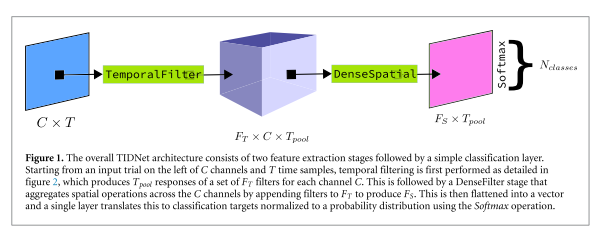

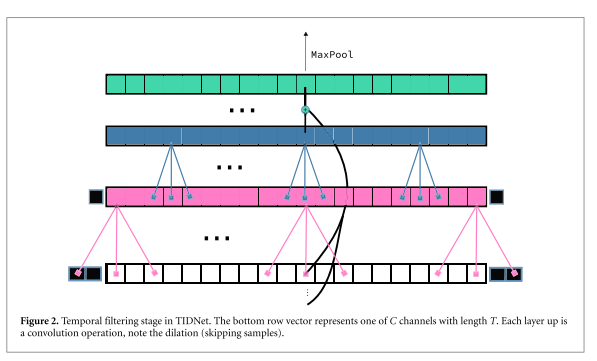

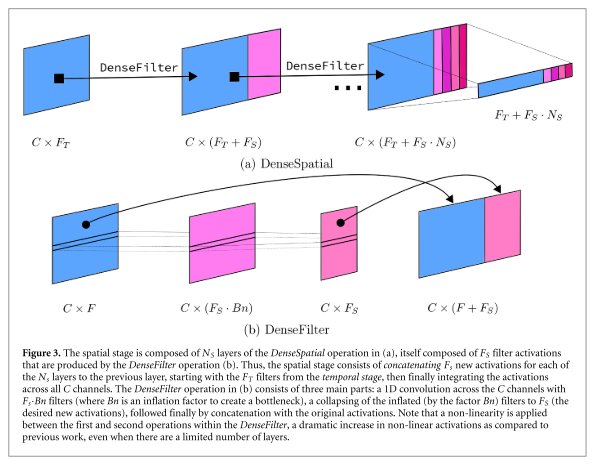

In [2]:
writer = SummaryWriter()

In [3]:
train_set = pd.read_csv("data/final_format/train_set.csv",header=None).to_numpy()
train_label = pd.read_csv("data/final_format/train_label.csv",header=None).to_numpy()
test_set = pd.read_csv("data/final_format/test_set.csv",header=None).to_numpy()
test_label = pd.read_csv("data/final_format/test_label.csv",header=None).to_numpy()

In [4]:
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14393, 4096) (14393, 1) (3599, 4096) (3599, 1)


In [5]:
#delet first row data
train_set = train_set[1:]
train_label = train_label[1:]
test_set = test_set[1:]
test_label = test_label[1:]
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 4096) (14392, 1) (3598, 4096) (3598, 1)


In [6]:
train_set = train_set.reshape((-1,1,64,64))
test_set = test_set.reshape((-1,1,64,64))
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 1, 64, 64) (14392, 1) (3598, 1, 64, 64) (3598, 1)


In [7]:
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 1, 64, 64) (14392,) (3598, 1, 64, 64) (3598,)


In [8]:
# Hyper parameters
num_epochs = 300
num_classes = 4
batch_size = 64
learning_rate = 1e-3

In [9]:
train_set_tensor = Tensor(train_set) 
train_label_tensor = Tensor(train_label).type(torch.LongTensor)

train_dataset = TensorDataset(train_set_tensor,train_label_tensor) 
train_loader = DataLoader(train_dataset, batch_size=batch_size) 

test_set_tensor = Tensor(test_set) 
test_label_tensor = Tensor(test_label).type(torch.LongTensor)

test_dataset = TensorDataset(test_set_tensor,test_label_tensor) 
test_loader = DataLoader(test_dataset, batch_size=batch_size) 

In [10]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [11]:
from math import ceil

import torch
from torch import nn
from torch.nn import init
from torch.nn.utils import weight_norm

from .modules import Ensure4d, Expression


class _BatchNormZG(nn.BatchNorm2d):
    def reset_parameters(self):
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1)
        if self.affine:
            self.weight.data.zero_()
            self.bias.data.zero_()


class _ConvBlock2D(nn.Module):
    """Implements Convolution block with order:
    Convolution, dropout, activation, batch-norm
    """
    def __init__(self, in_filters, out_filters, kernel, stride=(1, 1), padding=0, dilation=1,
                 groups=1, drop_prob=0.5, batch_norm=True, activation=nn.LeakyReLU, residual=False):
        super().__init__()
        self.kernel = kernel
        self.activation = activation()
        self.residual = residual

        self.conv = nn.Conv2d(in_filters, out_filters, kernel, stride=stride, padding=padding,
                              dilation=dilation, groups=groups, bias=not batch_norm)
        self.dropout = nn.Dropout2d(p=drop_prob)
        self.batch_norm = _BatchNormZG(out_filters) if residual else nn.BatchNorm2d(out_filters) if\
            batch_norm else lambda x: x

    def forward(self, input):
        res = input
        input = self.conv(input,)
        input = self.dropout(input)
        input = self.activation(input)
        input = self.batch_norm(input)
        return input + res if self.residual else input


class _DenseFilter(nn.Module):
    def __init__(self, in_features, growth_rate, filter_len=5, drop_prob=0.5, bottleneck=2,
                 activation=nn.LeakyReLU, dim=-2):
        super().__init__()
        dim = dim if dim > 0 else dim + 4
        if dim < 2 or dim > 3:
            raise ValueError('Only last two dimensions supported')
        kernel = (filter_len, 1) if dim == 2 else (1, filter_len)

        self.net = nn.Sequential(
            nn.BatchNorm2d(in_features),
            activation(),
            nn.Conv2d(in_features, bottleneck * growth_rate, 1),
            nn.BatchNorm2d(bottleneck * growth_rate),
            activation(),
            nn.Conv2d(bottleneck * growth_rate, growth_rate, kernel,
                      padding=tuple((k // 2 for k in kernel))),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, x):
        return torch.cat((x, self.net(x)), dim=1)


class _DenseSpatialFilter(nn.Module):
    def __init__(self, in_chans, growth, depth, in_ch=1, bottleneck=4, drop_prob=0.0,
                 activation=nn.LeakyReLU, collapse=True):
        super().__init__()
        self.net = nn.Sequential(*[
            _DenseFilter(in_ch + growth * d, growth, bottleneck=bottleneck, drop_prob=drop_prob,
                         activation=activation) for d in range(depth)
        ])
        n_filters = in_ch + growth * depth
        self.collapse = collapse
        if collapse:
            self.channel_collapse = _ConvBlock2D(n_filters, n_filters, (in_chans, 1), drop_prob=0)

    def forward(self, x):
        if len(x.shape) < 4:
            x = x.unsqueeze(1).permute([0, 1, 3, 2])
        x = self.net(x)
        if self.collapse:
            return self.channel_collapse(x).squeeze(-2)
        return x


class _TemporalFilter(nn.Module):
    def __init__(self, in_chans, filters, depth, temp_len, drop_prob=0., activation=nn.LeakyReLU,
                 residual='netwise'):
        super().__init__()
        temp_len = temp_len + 1 - temp_len % 2
        self.residual_style = str(residual)
        net = list()

        for i in range(depth):
            dil = depth - i
            conv = weight_norm(nn.Conv2d(in_chans if i == 0 else filters, filters,
                                         kernel_size=(1, temp_len), dilation=dil,
                                         padding=(0, dil * (temp_len - 1) // 2)))
            net.append(nn.Sequential(
                conv,
                activation(),
                nn.Dropout2d(drop_prob)
            ))
        if self.residual_style.lower() == 'netwise':
            self.net = nn.Sequential(*net)
            self.residual = nn.Conv2d(in_chans, filters, (1, 1))
        elif residual.lower() == 'dense':
            self.net = net

    def forward(self, x):
        if self.residual_style.lower() == 'netwise':
            return self.net(x) + self.residual(x)
        elif self.residual_style.lower() == 'dense':
            for layer in self.net:
                x = torch.cat((x, layer(x)), dim=1)
            return x


class _TIDNetFeatures(nn.Module):
    def __init__(self, s_growth, t_filters, in_chans, input_window_samples, drop_prob, pooling,
                 temp_layers, spat_layers, temp_span, bottleneck, summary):
        super().__init__()
        self.in_chans = in_chans
        self.input_windows_samples = input_window_samples
        self.temp_len = ceil(temp_span * input_window_samples)

        def _permute(x):
            """
            Permutes data:

            from dim:
            batch, chans, time, 1

            to dim:
            batch, 1, chans, time

            """
            return x.permute([0, 3, 1, 2])

        self.temporal = nn.Sequential(
            Ensure4d(),
            Expression(_permute),
            _TemporalFilter(1, t_filters, depth=temp_layers, temp_len=self.temp_len),
            nn.MaxPool2d((1, pooling)),
            nn.Dropout2d(drop_prob),
        )
        summary = input_window_samples // pooling if summary == -1 else summary

        self.spatial = _DenseSpatialFilter(in_chans, s_growth, spat_layers, in_ch=t_filters,
                                           drop_prob=drop_prob, bottleneck=bottleneck)
        self.extract_features = nn.Sequential(
            nn.AdaptiveAvgPool1d(int(summary)),
            nn.Flatten(start_dim=1)
        )

        self._num_features = (t_filters + s_growth * spat_layers) * summary

    @property
    def num_features(self):
        return self._num_features

    def forward(self, x):
        x = self.temporal(x)
        x = self.spatial(x)
        return self.extract_features(x)


class TIDNet(nn.Module):
    """Thinker Invariance DenseNet model from Kostas et al 2020.

    See [TIDNet]_ for details.

    Parameters
    ----------
    n_classes : int
        Number of classes.
    in_chans : int
        Number of EEG channels.
    input_window_samples : int
        Number of samples.
    s_growth : int
        DenseNet-style growth factor (added filters per DenseFilter)
    t_filters : int
        Number of temporal filters.
    drop_prob : float
        Dropout probability
    pooling : int
        Max temporal pooling (width and stride)
    temp_layers : int
        Number of temporal layers
    spat_layers : int
        Number of DenseFilters
    temp_span : float
        Percentage of input_window_samples that defines the temporal filter length:
        temp_len = ceil(temp_span * input_window_samples)
        e.g A value of 0.05 for temp_span with 1500 input_window_samples will yield a temporal
        filter of length 75.
    bottleneck : int
        Bottleneck factor within Densefilter
    summary : int
        Output size of AdaptiveAvgPool1D layer. If set to -1, value will be calculated
        automatically (input_window_samples // pooling).

    Notes
    -----
    Code adapted from: https://github.com/SPOClab-ca/ThinkerInvariance/

    References
    ----------
    .. [TIDNet] Kostas, D. & Rudzicz, F.
        Thinker invariance: enabling deep neural networks for BCI across more
        people.
        J. Neural Eng. 17, 056008 (2020).
        doi: 10.1088/1741-2552/abb7a7.
    """
    def __init__(self, in_chans, n_classes, input_window_samples, s_growth=24, t_filters=32,
                 drop_prob=0.4, pooling=15, temp_layers=2, spat_layers=2, temp_span=0.05,
                 bottleneck=3, summary=-1):
        super().__init__()
        self.n_classes = n_classes
        self.in_chans = in_chans
        self.input_window_samples = input_window_samples
        self.temp_len = ceil(temp_span * input_window_samples)

        self.dscnn = _TIDNetFeatures(s_growth=s_growth, t_filters=t_filters, in_chans=in_chans,
                                     input_window_samples=input_window_samples,
                                     drop_prob=drop_prob, pooling=pooling, temp_layers=temp_layers,
                                     spat_layers=spat_layers, temp_span=temp_span,
                                     bottleneck=bottleneck, summary=summary)

        self._num_features = self.dscnn.num_features

        self.classify = self._create_classifier(self.num_features, n_classes)

    def _create_classifier(self, incoming, n_classes):
        classifier = nn.Linear(incoming, n_classes)
        init.xavier_normal_(classifier.weight)
        classifier.bias.data.zero_()
        return nn.Sequential(nn.Flatten(start_dim=1), classifier, nn.LogSoftmax(dim=-1))

    def forward(self, x):
        """Forward pass.

        Parameters
        ----------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """

        x = self.dscnn(x)
        return self.classify(x)

    @property
    def num_features(self):
        return self._num_features


In [12]:
model = CNN(num_classes).to(device)

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3) 
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
milestones = [50,100,150,200,250]
milestones = [a * len(train_loader) for a in milestones]
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.5)

In [14]:
def train():
    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        correct=0
        total=0
        running_loss = 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.to(device)
            Y = Y.to(device)


            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, Y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            #scheduler.step() 
            #print(scheduler.get_last_lr()[0])

            optimizer.step()
            scheduler.step() 
            #print(optimizer.param_groups[0]["lr"])

            _, predicted = outputs.max(1)
            total += Y.size(0)
            correct += predicted.eq(Y).sum().item()
            running_loss += loss.item()
            accu=100.*correct/total
            train_loss = running_loss/(i+1)
            print ('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.4f}%, Training Loss: {:.4f}%'.format(epoch+1, num_epochs, i+1, total_step, accu, train_loss))


            #writer.add_scalar(f'train/accuracy', accu, epoch)
            #writer.add_scalar(f'train/loss', train_loss, epoch)
            writer.add_scalars(f'train/accuracy_loss', {
                'accuracy': accu,
                'loss': train_loss,
            }, epoch)
        
        

0.001
Epoch [1/300], Step [1/225], Training Accuracy: 35.9375%, Training Loss: 1.3860%
0.001
Epoch [1/300], Step [2/225], Training Accuracy: 28.1250%, Training Loss: 15.1225%
0.001
Epoch [1/300], Step [3/225], Training Accuracy: 26.0417%, Training Loss: 13.9029%
0.001
Epoch [1/300], Step [4/225], Training Accuracy: 26.5625%, Training Loss: 10.9293%
0.001
Epoch [1/300], Step [5/225], Training Accuracy: 27.5000%, Training Loss: 9.5791%
0.001
Epoch [1/300], Step [6/225], Training Accuracy: 25.7812%, Training Loss: 8.9962%
0.001
Epoch [1/300], Step [7/225], Training Accuracy: 25.6696%, Training Loss: 8.2697%
0.001
Epoch [1/300], Step [8/225], Training Accuracy: 25.0000%, Training Loss: 7.5742%
0.001
Epoch [1/300], Step [9/225], Training Accuracy: 25.0000%, Training Loss: 7.3103%
0.001
Epoch [1/300], Step [10/225], Training Accuracy: 25.4688%, Training Loss: 6.9672%
0.001
Epoch [1/300], Step [11/225], Training Accuracy: 25.0000%, Training Loss: 6.6907%
0.001
Epoch [1/300], Step [12/225], Tr

0.001
Epoch [1/300], Step [95/225], Training Accuracy: 27.2533%, Training Loss: 2.3196%
0.001
Epoch [1/300], Step [96/225], Training Accuracy: 27.2949%, Training Loss: 2.3100%
0.001
Epoch [1/300], Step [97/225], Training Accuracy: 27.3840%, Training Loss: 2.3000%
0.001
Epoch [1/300], Step [98/225], Training Accuracy: 27.4713%, Training Loss: 2.2907%
0.001
Epoch [1/300], Step [99/225], Training Accuracy: 27.5095%, Training Loss: 2.2813%
0.001
Epoch [1/300], Step [100/225], Training Accuracy: 27.5781%, Training Loss: 2.2725%
0.001
Epoch [1/300], Step [101/225], Training Accuracy: 27.6764%, Training Loss: 2.2640%
0.001
Epoch [1/300], Step [102/225], Training Accuracy: 27.6654%, Training Loss: 2.2565%
0.001
Epoch [1/300], Step [103/225], Training Accuracy: 27.7306%, Training Loss: 2.2476%
0.001
Epoch [1/300], Step [104/225], Training Accuracy: 27.8245%, Training Loss: 2.2383%
0.001
Epoch [1/300], Step [105/225], Training Accuracy: 27.9018%, Training Loss: 2.2302%
0.001
Epoch [1/300], Step 

0.001
Epoch [1/300], Step [193/225], Training Accuracy: 29.9790%, Training Loss: 1.8366%
0.001
Epoch [1/300], Step [194/225], Training Accuracy: 29.9855%, Training Loss: 1.8339%
0.001
Epoch [1/300], Step [195/225], Training Accuracy: 30.0000%, Training Loss: 1.8312%
0.001
Epoch [1/300], Step [196/225], Training Accuracy: 29.9665%, Training Loss: 1.8290%
0.001
Epoch [1/300], Step [197/225], Training Accuracy: 29.9492%, Training Loss: 1.8266%
0.001
Epoch [1/300], Step [198/225], Training Accuracy: 29.9716%, Training Loss: 1.8238%
0.001
Epoch [1/300], Step [199/225], Training Accuracy: 29.9623%, Training Loss: 1.8213%
0.001
Epoch [1/300], Step [200/225], Training Accuracy: 29.9766%, Training Loss: 1.8189%
0.001
Epoch [1/300], Step [201/225], Training Accuracy: 30.0295%, Training Loss: 1.8162%
0.001
Epoch [1/300], Step [202/225], Training Accuracy: 30.0124%, Training Loss: 1.8141%
0.001
Epoch [1/300], Step [203/225], Training Accuracy: 29.9877%, Training Loss: 1.8123%
0.001
Epoch [1/300], 

0.001
Epoch [2/300], Step [61/225], Training Accuracy: 36.4754%, Training Loss: 1.3020%
0.001
Epoch [2/300], Step [62/225], Training Accuracy: 36.5171%, Training Loss: 1.3016%
0.001
Epoch [2/300], Step [63/225], Training Accuracy: 36.5575%, Training Loss: 1.3017%
0.001
Epoch [2/300], Step [64/225], Training Accuracy: 36.5234%, Training Loss: 1.3033%
0.001
Epoch [2/300], Step [65/225], Training Accuracy: 36.6106%, Training Loss: 1.3028%
0.001
Epoch [2/300], Step [66/225], Training Accuracy: 36.7424%, Training Loss: 1.3026%
0.001
Epoch [2/300], Step [67/225], Training Accuracy: 36.8237%, Training Loss: 1.3014%
0.001
Epoch [2/300], Step [68/225], Training Accuracy: 36.8566%, Training Loss: 1.3004%
0.001
Epoch [2/300], Step [69/225], Training Accuracy: 36.7301%, Training Loss: 1.3001%
0.001
Epoch [2/300], Step [70/225], Training Accuracy: 36.6964%, Training Loss: 1.3003%
0.001
Epoch [2/300], Step [71/225], Training Accuracy: 36.7298%, Training Loss: 1.3006%
0.001
Epoch [2/300], Step [72/22

0.001
Epoch [2/300], Step [159/225], Training Accuracy: 37.5098%, Training Loss: 1.2872%
0.001
Epoch [2/300], Step [160/225], Training Accuracy: 37.5195%, Training Loss: 1.2867%
0.001
Epoch [2/300], Step [161/225], Training Accuracy: 37.5970%, Training Loss: 1.2855%
0.001
Epoch [2/300], Step [162/225], Training Accuracy: 37.6543%, Training Loss: 1.2847%
0.001
Epoch [2/300], Step [163/225], Training Accuracy: 37.6438%, Training Loss: 1.2844%
0.001
Epoch [2/300], Step [164/225], Training Accuracy: 37.6905%, Training Loss: 1.2845%
0.001
Epoch [2/300], Step [165/225], Training Accuracy: 37.6705%, Training Loss: 1.2847%
0.001
Epoch [2/300], Step [166/225], Training Accuracy: 37.6224%, Training Loss: 1.2849%
0.001
Epoch [2/300], Step [167/225], Training Accuracy: 37.6778%, Training Loss: 1.2842%
0.001
Epoch [2/300], Step [168/225], Training Accuracy: 37.6488%, Training Loss: 1.2839%
0.001
Epoch [2/300], Step [169/225], Training Accuracy: 37.7034%, Training Loss: 1.2830%
0.001
Epoch [2/300], 

Epoch [3/300], Step [28/225], Training Accuracy: 41.8527%, Training Loss: 1.2320%
0.001
Epoch [3/300], Step [29/225], Training Accuracy: 42.1336%, Training Loss: 1.2262%
0.001
Epoch [3/300], Step [30/225], Training Accuracy: 42.2396%, Training Loss: 1.2246%
0.001
Epoch [3/300], Step [31/225], Training Accuracy: 42.3891%, Training Loss: 1.2237%
0.001
Epoch [3/300], Step [32/225], Training Accuracy: 42.2852%, Training Loss: 1.2211%
0.001
Epoch [3/300], Step [33/225], Training Accuracy: 42.4242%, Training Loss: 1.2200%
0.001
Epoch [3/300], Step [34/225], Training Accuracy: 42.1415%, Training Loss: 1.2213%
0.001
Epoch [3/300], Step [35/225], Training Accuracy: 42.0089%, Training Loss: 1.2240%
0.001
Epoch [3/300], Step [36/225], Training Accuracy: 41.9271%, Training Loss: 1.2237%
0.001
Epoch [3/300], Step [37/225], Training Accuracy: 41.8074%, Training Loss: 1.2250%
0.001
Epoch [3/300], Step [38/225], Training Accuracy: 41.8586%, Training Loss: 1.2246%
0.001
Epoch [3/300], Step [39/225], Tr

Epoch [3/300], Step [122/225], Training Accuracy: 43.2121%, Training Loss: 1.1873%
0.001
Epoch [3/300], Step [123/225], Training Accuracy: 43.2419%, Training Loss: 1.1866%
0.001
Epoch [3/300], Step [124/225], Training Accuracy: 43.2712%, Training Loss: 1.1859%
0.001
Epoch [3/300], Step [125/225], Training Accuracy: 43.2125%, Training Loss: 1.1875%
0.001
Epoch [3/300], Step [126/225], Training Accuracy: 43.2540%, Training Loss: 1.1869%
0.001
Epoch [3/300], Step [127/225], Training Accuracy: 43.2087%, Training Loss: 1.1869%
0.001
Epoch [3/300], Step [128/225], Training Accuracy: 43.2007%, Training Loss: 1.1868%
0.001
Epoch [3/300], Step [129/225], Training Accuracy: 43.3018%, Training Loss: 1.1862%
0.001
Epoch [3/300], Step [130/225], Training Accuracy: 43.3173%, Training Loss: 1.1862%
0.001
Epoch [3/300], Step [131/225], Training Accuracy: 43.2610%, Training Loss: 1.1860%
0.001
Epoch [3/300], Step [132/225], Training Accuracy: 43.3239%, Training Loss: 1.1858%
0.001
Epoch [3/300], Step [

0.001
Epoch [3/300], Step [215/225], Training Accuracy: 44.4404%, Training Loss: 1.1679%
0.001
Epoch [3/300], Step [216/225], Training Accuracy: 44.4517%, Training Loss: 1.1683%
0.001
Epoch [3/300], Step [217/225], Training Accuracy: 44.4700%, Training Loss: 1.1678%
0.001
Epoch [3/300], Step [218/225], Training Accuracy: 44.4596%, Training Loss: 1.1676%
0.001
Epoch [3/300], Step [219/225], Training Accuracy: 44.4706%, Training Loss: 1.1672%
0.001
Epoch [3/300], Step [220/225], Training Accuracy: 44.4957%, Training Loss: 1.1663%
0.001
Epoch [3/300], Step [221/225], Training Accuracy: 44.4924%, Training Loss: 1.1662%
0.001
Epoch [3/300], Step [222/225], Training Accuracy: 44.5172%, Training Loss: 1.1655%
0.001
Epoch [3/300], Step [223/225], Training Accuracy: 44.5418%, Training Loss: 1.1653%
0.001
Epoch [3/300], Step [224/225], Training Accuracy: 44.5522%, Training Loss: 1.1648%
0.001
Epoch [3/300], Step [225/225], Training Accuracy: 44.5595%, Training Loss: 1.1651%
0.001
Epoch [4/300], 

0.001
Epoch [4/300], Step [84/225], Training Accuracy: 48.1957%, Training Loss: 1.0987%
0.001
Epoch [4/300], Step [85/225], Training Accuracy: 48.2537%, Training Loss: 1.0978%
0.001
Epoch [4/300], Step [86/225], Training Accuracy: 48.3467%, Training Loss: 1.0977%
0.001
Epoch [4/300], Step [87/225], Training Accuracy: 48.4195%, Training Loss: 1.0989%
0.001
Epoch [4/300], Step [88/225], Training Accuracy: 48.3487%, Training Loss: 1.0989%
0.001
Epoch [4/300], Step [89/225], Training Accuracy: 48.2971%, Training Loss: 1.1000%
0.001
Epoch [4/300], Step [90/225], Training Accuracy: 48.3160%, Training Loss: 1.0993%
0.001
Epoch [4/300], Step [91/225], Training Accuracy: 48.3516%, Training Loss: 1.0996%
0.001
Epoch [4/300], Step [92/225], Training Accuracy: 48.3016%, Training Loss: 1.1009%
0.001
Epoch [4/300], Step [93/225], Training Accuracy: 48.2359%, Training Loss: 1.1013%
0.001
Epoch [4/300], Step [94/225], Training Accuracy: 48.2713%, Training Loss: 1.0997%
0.001
Epoch [4/300], Step [95/22

Epoch [4/300], Step [178/225], Training Accuracy: 49.2275%, Training Loss: 1.0839%
0.001
Epoch [4/300], Step [179/225], Training Accuracy: 49.2580%, Training Loss: 1.0836%
0.001
Epoch [4/300], Step [180/225], Training Accuracy: 49.2795%, Training Loss: 1.0828%
0.001
Epoch [4/300], Step [181/225], Training Accuracy: 49.2835%, Training Loss: 1.0829%
0.001
Epoch [4/300], Step [182/225], Training Accuracy: 49.3046%, Training Loss: 1.0828%
0.001
Epoch [4/300], Step [183/225], Training Accuracy: 49.2657%, Training Loss: 1.0824%
0.001
Epoch [4/300], Step [184/225], Training Accuracy: 49.3291%, Training Loss: 1.0820%
0.001
Epoch [4/300], Step [185/225], Training Accuracy: 49.3328%, Training Loss: 1.0813%
0.001
Epoch [4/300], Step [186/225], Training Accuracy: 49.3112%, Training Loss: 1.0813%
0.001
Epoch [4/300], Step [187/225], Training Accuracy: 49.3733%, Training Loss: 1.0809%
0.001
Epoch [4/300], Step [188/225], Training Accuracy: 49.4432%, Training Loss: 1.0798%
0.001
Epoch [4/300], Step [

0.001
Epoch [5/300], Step [51/225], Training Accuracy: 52.6961%, Training Loss: 1.0059%
0.001
Epoch [5/300], Step [52/225], Training Accuracy: 52.8546%, Training Loss: 1.0036%
0.001
Epoch [5/300], Step [53/225], Training Accuracy: 52.9481%, Training Loss: 1.0035%
0.001
Epoch [5/300], Step [54/225], Training Accuracy: 52.8935%, Training Loss: 1.0045%
0.001
Epoch [5/300], Step [55/225], Training Accuracy: 52.9830%, Training Loss: 1.0047%
0.001
Epoch [5/300], Step [56/225], Training Accuracy: 52.7902%, Training Loss: 1.0067%
0.001
Epoch [5/300], Step [57/225], Training Accuracy: 52.9057%, Training Loss: 1.0055%
0.001
Epoch [5/300], Step [58/225], Training Accuracy: 52.8556%, Training Loss: 1.0067%
0.001
Epoch [5/300], Step [59/225], Training Accuracy: 52.7807%, Training Loss: 1.0072%
0.001
Epoch [5/300], Step [60/225], Training Accuracy: 52.7865%, Training Loss: 1.0061%
0.001
Epoch [5/300], Step [61/225], Training Accuracy: 52.8432%, Training Loss: 1.0049%
0.001
Epoch [5/300], Step [62/22

0.001
Epoch [5/300], Step [148/225], Training Accuracy: 54.0013%, Training Loss: 0.9963%
0.001
Epoch [5/300], Step [149/225], Training Accuracy: 54.0688%, Training Loss: 0.9958%
0.001
Epoch [5/300], Step [150/225], Training Accuracy: 54.0729%, Training Loss: 0.9958%
0.001
Epoch [5/300], Step [151/225], Training Accuracy: 54.1598%, Training Loss: 0.9948%
0.001
Epoch [5/300], Step [152/225], Training Accuracy: 54.1632%, Training Loss: 0.9945%
0.001
Epoch [5/300], Step [153/225], Training Accuracy: 54.1667%, Training Loss: 0.9939%
0.001
Epoch [5/300], Step [154/225], Training Accuracy: 54.1700%, Training Loss: 0.9939%
0.001
Epoch [5/300], Step [155/225], Training Accuracy: 54.1331%, Training Loss: 0.9939%
0.001
Epoch [5/300], Step [156/225], Training Accuracy: 54.1466%, Training Loss: 0.9935%
0.001
Epoch [5/300], Step [157/225], Training Accuracy: 54.2098%, Training Loss: 0.9932%
0.001
Epoch [5/300], Step [158/225], Training Accuracy: 54.1733%, Training Loss: 0.9946%
0.001
Epoch [5/300], 

Epoch [6/300], Step [21/225], Training Accuracy: 55.8780%, Training Loss: 0.9480%
0.001
Epoch [6/300], Step [22/225], Training Accuracy: 55.7528%, Training Loss: 0.9511%
0.001
Epoch [6/300], Step [23/225], Training Accuracy: 55.9783%, Training Loss: 0.9516%
0.001
Epoch [6/300], Step [24/225], Training Accuracy: 55.8594%, Training Loss: 0.9544%
0.001
Epoch [6/300], Step [25/225], Training Accuracy: 56.1250%, Training Loss: 0.9472%
0.001
Epoch [6/300], Step [26/225], Training Accuracy: 56.3101%, Training Loss: 0.9441%
0.001
Epoch [6/300], Step [27/225], Training Accuracy: 56.0764%, Training Loss: 0.9463%
0.001
Epoch [6/300], Step [28/225], Training Accuracy: 56.2500%, Training Loss: 0.9442%
0.001
Epoch [6/300], Step [29/225], Training Accuracy: 56.4655%, Training Loss: 0.9395%
0.001
Epoch [6/300], Step [30/225], Training Accuracy: 56.4583%, Training Loss: 0.9410%
0.001
Epoch [6/300], Step [31/225], Training Accuracy: 56.2500%, Training Loss: 0.9444%
0.001
Epoch [6/300], Step [32/225], Tr

0.001
Epoch [6/300], Step [116/225], Training Accuracy: 57.5027%, Training Loss: 0.9261%
0.001
Epoch [6/300], Step [117/225], Training Accuracy: 57.4786%, Training Loss: 0.9264%
0.001
Epoch [6/300], Step [118/225], Training Accuracy: 57.4815%, Training Loss: 0.9250%
0.001
Epoch [6/300], Step [119/225], Training Accuracy: 57.4580%, Training Loss: 0.9241%
0.001
Epoch [6/300], Step [120/225], Training Accuracy: 57.4219%, Training Loss: 0.9248%
0.001
Epoch [6/300], Step [121/225], Training Accuracy: 57.3218%, Training Loss: 0.9249%
0.001
Epoch [6/300], Step [122/225], Training Accuracy: 57.3130%, Training Loss: 0.9242%
0.001
Epoch [6/300], Step [123/225], Training Accuracy: 57.3552%, Training Loss: 0.9231%
0.001
Epoch [6/300], Step [124/225], Training Accuracy: 57.3337%, Training Loss: 0.9227%
0.001
Epoch [6/300], Step [125/225], Training Accuracy: 57.3125%, Training Loss: 0.9234%
0.001
Epoch [6/300], Step [126/225], Training Accuracy: 57.1801%, Training Loss: 0.9240%
0.001
Epoch [6/300], 

0.001
Epoch [6/300], Step [211/225], Training Accuracy: 57.9162%, Training Loss: 0.9114%
0.001
Epoch [6/300], Step [212/225], Training Accuracy: 57.9231%, Training Loss: 0.9114%
0.001
Epoch [6/300], Step [213/225], Training Accuracy: 57.8859%, Training Loss: 0.9119%
0.001
Epoch [6/300], Step [214/225], Training Accuracy: 57.9001%, Training Loss: 0.9115%
0.001
Epoch [6/300], Step [215/225], Training Accuracy: 57.8779%, Training Loss: 0.9123%
0.001
Epoch [6/300], Step [216/225], Training Accuracy: 57.8848%, Training Loss: 0.9126%
0.001
Epoch [6/300], Step [217/225], Training Accuracy: 57.8557%, Training Loss: 0.9129%
0.001
Epoch [6/300], Step [218/225], Training Accuracy: 57.8268%, Training Loss: 0.9130%
0.001
Epoch [6/300], Step [219/225], Training Accuracy: 57.8339%, Training Loss: 0.9128%
0.001
Epoch [6/300], Step [220/225], Training Accuracy: 57.8693%, Training Loss: 0.9125%
0.001
Epoch [6/300], Step [221/225], Training Accuracy: 57.8620%, Training Loss: 0.9125%
0.001
Epoch [6/300], 

Epoch [7/300], Step [79/225], Training Accuracy: 60.2650%, Training Loss: 0.8841%
0.001
Epoch [7/300], Step [80/225], Training Accuracy: 60.2539%, Training Loss: 0.8843%
0.001
Epoch [7/300], Step [81/225], Training Accuracy: 60.2045%, Training Loss: 0.8838%
0.001
Epoch [7/300], Step [82/225], Training Accuracy: 60.2515%, Training Loss: 0.8830%
0.001
Epoch [7/300], Step [83/225], Training Accuracy: 60.1657%, Training Loss: 0.8833%
0.001
Epoch [7/300], Step [84/225], Training Accuracy: 60.2307%, Training Loss: 0.8816%
0.001
Epoch [7/300], Step [85/225], Training Accuracy: 60.3125%, Training Loss: 0.8804%
0.001
Epoch [7/300], Step [86/225], Training Accuracy: 60.4288%, Training Loss: 0.8806%
0.001
Epoch [7/300], Step [87/225], Training Accuracy: 60.3628%, Training Loss: 0.8824%
0.001
Epoch [7/300], Step [88/225], Training Accuracy: 60.2628%, Training Loss: 0.8831%
0.001
Epoch [7/300], Step [89/225], Training Accuracy: 60.1826%, Training Loss: 0.8845%
0.001
Epoch [7/300], Step [90/225], Tr

0.001
Epoch [7/300], Step [174/225], Training Accuracy: 60.3897%, Training Loss: 0.8708%
0.001
Epoch [7/300], Step [175/225], Training Accuracy: 60.4018%, Training Loss: 0.8708%
0.001
Epoch [7/300], Step [176/225], Training Accuracy: 60.4226%, Training Loss: 0.8708%
0.001
Epoch [7/300], Step [177/225], Training Accuracy: 60.4255%, Training Loss: 0.8709%
0.001
Epoch [7/300], Step [178/225], Training Accuracy: 60.4371%, Training Loss: 0.8708%
0.001
Epoch [7/300], Step [179/225], Training Accuracy: 60.4574%, Training Loss: 0.8702%
0.001
Epoch [7/300], Step [180/225], Training Accuracy: 60.4774%, Training Loss: 0.8697%
0.001
Epoch [7/300], Step [181/225], Training Accuracy: 60.4368%, Training Loss: 0.8702%
0.001
Epoch [7/300], Step [182/225], Training Accuracy: 60.4138%, Training Loss: 0.8708%
0.001
Epoch [7/300], Step [183/225], Training Accuracy: 60.4423%, Training Loss: 0.8699%
0.001
Epoch [7/300], Step [184/225], Training Accuracy: 60.4620%, Training Loss: 0.8693%
0.001
Epoch [7/300], 

0.001
Epoch [8/300], Step [46/225], Training Accuracy: 62.7378%, Training Loss: 0.8169%
0.001
Epoch [8/300], Step [47/225], Training Accuracy: 62.5997%, Training Loss: 0.8177%
0.001
Epoch [8/300], Step [48/225], Training Accuracy: 62.4349%, Training Loss: 0.8199%
0.001
Epoch [8/300], Step [49/225], Training Accuracy: 62.6276%, Training Loss: 0.8192%
0.001
Epoch [8/300], Step [50/225], Training Accuracy: 62.6875%, Training Loss: 0.8173%
0.001
Epoch [8/300], Step [51/225], Training Accuracy: 62.8983%, Training Loss: 0.8159%
0.001
Epoch [8/300], Step [52/225], Training Accuracy: 62.9507%, Training Loss: 0.8148%
0.001
Epoch [8/300], Step [53/225], Training Accuracy: 63.0601%, Training Loss: 0.8148%
0.001
Epoch [8/300], Step [54/225], Training Accuracy: 62.9919%, Training Loss: 0.8167%
0.001
Epoch [8/300], Step [55/225], Training Accuracy: 62.8977%, Training Loss: 0.8180%
0.001
Epoch [8/300], Step [56/225], Training Accuracy: 62.5837%, Training Loss: 0.8210%
0.001
Epoch [8/300], Step [57/22

0.001
Epoch [8/300], Step [143/225], Training Accuracy: 62.5000%, Training Loss: 0.8132%
0.001
Epoch [8/300], Step [144/225], Training Accuracy: 62.4891%, Training Loss: 0.8141%
0.001
Epoch [8/300], Step [145/225], Training Accuracy: 62.4677%, Training Loss: 0.8136%
0.001
Epoch [8/300], Step [146/225], Training Accuracy: 62.4786%, Training Loss: 0.8151%
0.001
Epoch [8/300], Step [147/225], Training Accuracy: 62.5213%, Training Loss: 0.8145%
0.001
Epoch [8/300], Step [148/225], Training Accuracy: 62.5739%, Training Loss: 0.8140%
0.001
Epoch [8/300], Step [149/225], Training Accuracy: 62.5734%, Training Loss: 0.8134%
0.001
Epoch [8/300], Step [150/225], Training Accuracy: 62.6250%, Training Loss: 0.8125%
0.001
Epoch [8/300], Step [151/225], Training Accuracy: 62.6552%, Training Loss: 0.8122%
0.001
Epoch [8/300], Step [152/225], Training Accuracy: 62.6234%, Training Loss: 0.8126%
0.001
Epoch [8/300], Step [153/225], Training Accuracy: 62.6021%, Training Loss: 0.8127%
0.001
Epoch [8/300], 

0.001
Epoch [9/300], Step [15/225], Training Accuracy: 66.8750%, Training Loss: 0.7979%
0.001
Epoch [9/300], Step [16/225], Training Accuracy: 66.2109%, Training Loss: 0.8072%
0.001
Epoch [9/300], Step [17/225], Training Accuracy: 66.6360%, Training Loss: 0.7984%
0.001
Epoch [9/300], Step [18/225], Training Accuracy: 66.3194%, Training Loss: 0.8041%
0.001
Epoch [9/300], Step [19/225], Training Accuracy: 66.2007%, Training Loss: 0.8010%
0.001
Epoch [9/300], Step [20/225], Training Accuracy: 66.6406%, Training Loss: 0.7920%
0.001
Epoch [9/300], Step [21/225], Training Accuracy: 66.2946%, Training Loss: 0.7920%
0.001
Epoch [9/300], Step [22/225], Training Accuracy: 65.6250%, Training Loss: 0.7993%
0.001
Epoch [9/300], Step [23/225], Training Accuracy: 65.5571%, Training Loss: 0.7967%
0.001
Epoch [9/300], Step [24/225], Training Accuracy: 65.4948%, Training Loss: 0.7987%
0.001
Epoch [9/300], Step [25/225], Training Accuracy: 65.5625%, Training Loss: 0.7955%
0.001
Epoch [9/300], Step [26/22

0.001
Epoch [9/300], Step [113/225], Training Accuracy: 64.9751%, Training Loss: 0.7893%
0.001
Epoch [9/300], Step [114/225], Training Accuracy: 65.0356%, Training Loss: 0.7886%
0.001
Epoch [9/300], Step [115/225], Training Accuracy: 65.1087%, Training Loss: 0.7872%
0.001
Epoch [9/300], Step [116/225], Training Accuracy: 65.0458%, Training Loss: 0.7878%
0.001
Epoch [9/300], Step [117/225], Training Accuracy: 64.9973%, Training Loss: 0.7883%
0.001
Epoch [9/300], Step [118/225], Training Accuracy: 65.0291%, Training Loss: 0.7871%
0.001
Epoch [9/300], Step [119/225], Training Accuracy: 65.0079%, Training Loss: 0.7874%
0.001
Epoch [9/300], Step [120/225], Training Accuracy: 65.0130%, Training Loss: 0.7882%
0.001
Epoch [9/300], Step [121/225], Training Accuracy: 64.9148%, Training Loss: 0.7894%
0.001
Epoch [9/300], Step [122/225], Training Accuracy: 64.9078%, Training Loss: 0.7895%
0.001
Epoch [9/300], Step [123/225], Training Accuracy: 64.9390%, Training Loss: 0.7885%
0.001
Epoch [9/300], 

0.001
Epoch [9/300], Step [211/225], Training Accuracy: 65.3510%, Training Loss: 0.7724%
0.001
Epoch [9/300], Step [212/225], Training Accuracy: 65.3597%, Training Loss: 0.7721%
0.001
Epoch [9/300], Step [213/225], Training Accuracy: 65.2802%, Training Loss: 0.7731%
0.001
Epoch [9/300], Step [214/225], Training Accuracy: 65.3402%, Training Loss: 0.7722%
0.001
Epoch [9/300], Step [215/225], Training Accuracy: 65.3125%, Training Loss: 0.7726%
0.001
Epoch [9/300], Step [216/225], Training Accuracy: 65.2778%, Training Loss: 0.7734%
0.001
Epoch [9/300], Step [217/225], Training Accuracy: 65.2866%, Training Loss: 0.7737%
0.001
Epoch [9/300], Step [218/225], Training Accuracy: 65.2523%, Training Loss: 0.7744%
0.001
Epoch [9/300], Step [219/225], Training Accuracy: 65.2968%, Training Loss: 0.7737%
0.001
Epoch [9/300], Step [220/225], Training Accuracy: 65.2841%, Training Loss: 0.7741%
0.001
Epoch [9/300], Step [221/225], Training Accuracy: 65.2998%, Training Loss: 0.7739%
0.001
Epoch [9/300], 

0.001
Epoch [10/300], Step [83/225], Training Accuracy: 67.9593%, Training Loss: 0.7324%
0.001
Epoch [10/300], Step [84/225], Training Accuracy: 67.9315%, Training Loss: 0.7314%
0.001
Epoch [10/300], Step [85/225], Training Accuracy: 67.9228%, Training Loss: 0.7303%
0.001
Epoch [10/300], Step [86/225], Training Accuracy: 67.9688%, Training Loss: 0.7298%
0.001
Epoch [10/300], Step [87/225], Training Accuracy: 67.9777%, Training Loss: 0.7295%
0.001
Epoch [10/300], Step [88/225], Training Accuracy: 67.9332%, Training Loss: 0.7301%
0.001
Epoch [10/300], Step [89/225], Training Accuracy: 68.0126%, Training Loss: 0.7301%
0.001
Epoch [10/300], Step [90/225], Training Accuracy: 67.9514%, Training Loss: 0.7312%
0.001
Epoch [10/300], Step [91/225], Training Accuracy: 67.9087%, Training Loss: 0.7317%
0.001
Epoch [10/300], Step [92/225], Training Accuracy: 67.9008%, Training Loss: 0.7329%
0.001
Epoch [10/300], Step [93/225], Training Accuracy: 67.9772%, Training Loss: 0.7320%
0.001
Epoch [10/300],

0.001
Epoch [10/300], Step [176/225], Training Accuracy: 67.5515%, Training Loss: 0.7302%
0.001
Epoch [10/300], Step [177/225], Training Accuracy: 67.5671%, Training Loss: 0.7301%
0.001
Epoch [10/300], Step [178/225], Training Accuracy: 67.5386%, Training Loss: 0.7303%
0.001
Epoch [10/300], Step [179/225], Training Accuracy: 67.5628%, Training Loss: 0.7299%
0.001
Epoch [10/300], Step [180/225], Training Accuracy: 67.6215%, Training Loss: 0.7290%
0.001
Epoch [10/300], Step [181/225], Training Accuracy: 67.5932%, Training Loss: 0.7297%
0.001
Epoch [10/300], Step [182/225], Training Accuracy: 67.6082%, Training Loss: 0.7293%
0.001
Epoch [10/300], Step [183/225], Training Accuracy: 67.5803%, Training Loss: 0.7294%
0.001
Epoch [10/300], Step [184/225], Training Accuracy: 67.6630%, Training Loss: 0.7282%
0.001
Epoch [10/300], Step [185/225], Training Accuracy: 67.6858%, Training Loss: 0.7277%
0.001
Epoch [10/300], Step [186/225], Training Accuracy: 67.7083%, Training Loss: 0.7265%
0.001
Epoc

0.001
Epoch [11/300], Step [43/225], Training Accuracy: 68.2413%, Training Loss: 0.7182%
0.001
Epoch [11/300], Step [44/225], Training Accuracy: 68.4304%, Training Loss: 0.7141%
0.001
Epoch [11/300], Step [45/225], Training Accuracy: 68.3333%, Training Loss: 0.7162%
0.001
Epoch [11/300], Step [46/225], Training Accuracy: 68.3764%, Training Loss: 0.7149%
0.001
Epoch [11/300], Step [47/225], Training Accuracy: 68.4508%, Training Loss: 0.7136%
0.001
Epoch [11/300], Step [48/225], Training Accuracy: 68.4245%, Training Loss: 0.7149%
0.001
Epoch [11/300], Step [49/225], Training Accuracy: 68.6543%, Training Loss: 0.7109%
0.001
Epoch [11/300], Step [50/225], Training Accuracy: 68.7188%, Training Loss: 0.7106%
0.001
Epoch [11/300], Step [51/225], Training Accuracy: 68.9032%, Training Loss: 0.7080%
0.001
Epoch [11/300], Step [52/225], Training Accuracy: 69.1106%, Training Loss: 0.7063%
0.001
Epoch [11/300], Step [53/225], Training Accuracy: 69.1038%, Training Loss: 0.7065%
0.001
Epoch [11/300],

0.001
Epoch [11/300], Step [135/225], Training Accuracy: 69.1435%, Training Loss: 0.6939%
0.001
Epoch [11/300], Step [136/225], Training Accuracy: 69.1751%, Training Loss: 0.6936%
0.001
Epoch [11/300], Step [137/225], Training Accuracy: 69.1378%, Training Loss: 0.6939%
0.001
Epoch [11/300], Step [138/225], Training Accuracy: 69.2029%, Training Loss: 0.6921%
0.001
Epoch [11/300], Step [139/225], Training Accuracy: 69.1772%, Training Loss: 0.6919%
0.001
Epoch [11/300], Step [140/225], Training Accuracy: 69.2188%, Training Loss: 0.6913%
0.001
Epoch [11/300], Step [141/225], Training Accuracy: 69.1489%, Training Loss: 0.6922%
0.001
Epoch [11/300], Step [142/225], Training Accuracy: 69.1901%, Training Loss: 0.6912%
0.001
Epoch [11/300], Step [143/225], Training Accuracy: 69.2198%, Training Loss: 0.6908%
0.001
Epoch [11/300], Step [144/225], Training Accuracy: 69.1732%, Training Loss: 0.6914%
0.001
Epoch [11/300], Step [145/225], Training Accuracy: 69.2349%, Training Loss: 0.6908%
0.001
Epoc

Epoch [12/300], Step [6/225], Training Accuracy: 70.5729%, Training Loss: 0.6939%
0.001
Epoch [12/300], Step [7/225], Training Accuracy: 70.9821%, Training Loss: 0.6920%
0.001
Epoch [12/300], Step [8/225], Training Accuracy: 69.7266%, Training Loss: 0.7118%
0.001
Epoch [12/300], Step [9/225], Training Accuracy: 70.4861%, Training Loss: 0.7075%
0.001
Epoch [12/300], Step [10/225], Training Accuracy: 69.6875%, Training Loss: 0.7235%
0.001
Epoch [12/300], Step [11/225], Training Accuracy: 70.3125%, Training Loss: 0.7136%
0.001
Epoch [12/300], Step [12/225], Training Accuracy: 70.7031%, Training Loss: 0.7110%
0.001
Epoch [12/300], Step [13/225], Training Accuracy: 71.1538%, Training Loss: 0.7011%
0.001
Epoch [12/300], Step [14/225], Training Accuracy: 71.2054%, Training Loss: 0.6978%
0.001
Epoch [12/300], Step [15/225], Training Accuracy: 71.2500%, Training Loss: 0.7010%
0.001
Epoch [12/300], Step [16/225], Training Accuracy: 71.1914%, Training Loss: 0.7035%
0.001
Epoch [12/300], Step [17/

Epoch [12/300], Step [104/225], Training Accuracy: 71.3191%, Training Loss: 0.6751%
0.001
Epoch [12/300], Step [105/225], Training Accuracy: 71.3542%, Training Loss: 0.6751%
0.001
Epoch [12/300], Step [106/225], Training Accuracy: 71.3001%, Training Loss: 0.6764%
0.001
Epoch [12/300], Step [107/225], Training Accuracy: 71.2617%, Training Loss: 0.6777%
0.001
Epoch [12/300], Step [108/225], Training Accuracy: 71.2384%, Training Loss: 0.6776%
0.001
Epoch [12/300], Step [109/225], Training Accuracy: 71.3016%, Training Loss: 0.6763%
0.001
Epoch [12/300], Step [110/225], Training Accuracy: 71.3636%, Training Loss: 0.6751%
0.001
Epoch [12/300], Step [111/225], Training Accuracy: 71.4105%, Training Loss: 0.6749%
0.001
Epoch [12/300], Step [112/225], Training Accuracy: 71.4565%, Training Loss: 0.6731%
0.001
Epoch [12/300], Step [113/225], Training Accuracy: 71.4325%, Training Loss: 0.6740%
0.001
Epoch [12/300], Step [114/225], Training Accuracy: 71.4090%, Training Loss: 0.6733%
0.001
Epoch [12/

Epoch [12/300], Step [198/225], Training Accuracy: 71.7566%, Training Loss: 0.6597%
0.001
Epoch [12/300], Step [199/225], Training Accuracy: 71.7808%, Training Loss: 0.6592%
0.001
Epoch [12/300], Step [200/225], Training Accuracy: 71.7500%, Training Loss: 0.6594%
0.001
Epoch [12/300], Step [201/225], Training Accuracy: 71.7817%, Training Loss: 0.6593%
0.001
Epoch [12/300], Step [202/225], Training Accuracy: 71.7899%, Training Loss: 0.6592%
0.001
Epoch [12/300], Step [203/225], Training Accuracy: 71.8365%, Training Loss: 0.6582%
0.001
Epoch [12/300], Step [204/225], Training Accuracy: 71.8597%, Training Loss: 0.6577%
0.001
Epoch [12/300], Step [205/225], Training Accuracy: 71.8445%, Training Loss: 0.6578%
0.001
Epoch [12/300], Step [206/225], Training Accuracy: 71.8371%, Training Loss: 0.6575%
0.001
Epoch [12/300], Step [207/225], Training Accuracy: 71.8373%, Training Loss: 0.6577%
0.001
Epoch [12/300], Step [208/225], Training Accuracy: 71.8525%, Training Loss: 0.6571%
0.001
Epoch [12/

0.001
Epoch [13/300], Step [67/225], Training Accuracy: 74.1138%, Training Loss: 0.6076%
0.001
Epoch [13/300], Step [68/225], Training Accuracy: 74.0809%, Training Loss: 0.6081%
0.001
Epoch [13/300], Step [69/225], Training Accuracy: 73.9810%, Training Loss: 0.6098%
0.001
Epoch [13/300], Step [70/225], Training Accuracy: 74.0402%, Training Loss: 0.6088%
0.001
Epoch [13/300], Step [71/225], Training Accuracy: 74.1637%, Training Loss: 0.6071%
0.001
Epoch [13/300], Step [72/225], Training Accuracy: 74.0451%, Training Loss: 0.6103%
0.001
Epoch [13/300], Step [73/225], Training Accuracy: 74.0582%, Training Loss: 0.6106%
0.001
Epoch [13/300], Step [74/225], Training Accuracy: 74.1343%, Training Loss: 0.6084%
0.001
Epoch [13/300], Step [75/225], Training Accuracy: 74.1250%, Training Loss: 0.6091%
0.001
Epoch [13/300], Step [76/225], Training Accuracy: 74.0543%, Training Loss: 0.6106%
0.001
Epoch [13/300], Step [77/225], Training Accuracy: 74.0057%, Training Loss: 0.6124%
0.001
Epoch [13/300],

0.001
Epoch [13/300], Step [160/225], Training Accuracy: 74.3164%, Training Loss: 0.6035%
0.001
Epoch [13/300], Step [161/225], Training Accuracy: 74.3207%, Training Loss: 0.6035%
0.001
Epoch [13/300], Step [162/225], Training Accuracy: 74.3634%, Training Loss: 0.6033%
0.001
Epoch [13/300], Step [163/225], Training Accuracy: 74.3865%, Training Loss: 0.6032%
0.001
Epoch [13/300], Step [164/225], Training Accuracy: 74.4379%, Training Loss: 0.6023%
0.001
Epoch [13/300], Step [165/225], Training Accuracy: 74.3939%, Training Loss: 0.6038%
0.001
Epoch [13/300], Step [166/225], Training Accuracy: 74.4070%, Training Loss: 0.6038%
0.001
Epoch [13/300], Step [167/225], Training Accuracy: 74.4106%, Training Loss: 0.6036%
0.001
Epoch [13/300], Step [168/225], Training Accuracy: 74.3769%, Training Loss: 0.6041%
0.001
Epoch [13/300], Step [169/225], Training Accuracy: 74.3805%, Training Loss: 0.6034%
0.001
Epoch [13/300], Step [170/225], Training Accuracy: 74.3290%, Training Loss: 0.6040%
0.001
Epoc

Epoch [14/300], Step [27/225], Training Accuracy: 75.1157%, Training Loss: 0.5956%
0.001
Epoch [14/300], Step [28/225], Training Accuracy: 75.2790%, Training Loss: 0.5914%
0.001
Epoch [14/300], Step [29/225], Training Accuracy: 75.4310%, Training Loss: 0.5879%
0.001
Epoch [14/300], Step [30/225], Training Accuracy: 75.1562%, Training Loss: 0.5944%
0.001
Epoch [14/300], Step [31/225], Training Accuracy: 75.0000%, Training Loss: 0.5945%
0.001
Epoch [14/300], Step [32/225], Training Accuracy: 75.2441%, Training Loss: 0.5902%
0.001
Epoch [14/300], Step [33/225], Training Accuracy: 75.3788%, Training Loss: 0.5860%
0.001
Epoch [14/300], Step [34/225], Training Accuracy: 75.0460%, Training Loss: 0.6009%
0.001
Epoch [14/300], Step [35/225], Training Accuracy: 74.9107%, Training Loss: 0.6011%
0.001
Epoch [14/300], Step [36/225], Training Accuracy: 74.8698%, Training Loss: 0.6020%
0.001
Epoch [14/300], Step [37/225], Training Accuracy: 74.8733%, Training Loss: 0.5979%
0.001
Epoch [14/300], Step 

0.001
Epoch [14/300], Step [122/225], Training Accuracy: 74.7951%, Training Loss: 0.5945%
0.001
Epoch [14/300], Step [123/225], Training Accuracy: 74.7713%, Training Loss: 0.5951%
0.001
Epoch [14/300], Step [124/225], Training Accuracy: 74.7984%, Training Loss: 0.5947%
0.001
Epoch [14/300], Step [125/225], Training Accuracy: 74.8250%, Training Loss: 0.5949%
0.001
Epoch [14/300], Step [126/225], Training Accuracy: 74.7892%, Training Loss: 0.5971%
0.001
Epoch [14/300], Step [127/225], Training Accuracy: 74.7662%, Training Loss: 0.5969%
0.001
Epoch [14/300], Step [128/225], Training Accuracy: 74.8169%, Training Loss: 0.5962%
0.001
Epoch [14/300], Step [129/225], Training Accuracy: 74.8062%, Training Loss: 0.5965%
0.001
Epoch [14/300], Step [130/225], Training Accuracy: 74.7837%, Training Loss: 0.5964%
0.001
Epoch [14/300], Step [131/225], Training Accuracy: 74.8449%, Training Loss: 0.5953%
0.001
Epoch [14/300], Step [132/225], Training Accuracy: 74.8461%, Training Loss: 0.5953%
0.001
Epoc

Epoch [14/300], Step [213/225], Training Accuracy: 75.0513%, Training Loss: 0.5871%
0.001
Epoch [14/300], Step [214/225], Training Accuracy: 75.0730%, Training Loss: 0.5867%
0.001
Epoch [14/300], Step [215/225], Training Accuracy: 75.0509%, Training Loss: 0.5868%
0.001
Epoch [14/300], Step [216/225], Training Accuracy: 75.0145%, Training Loss: 0.5877%
0.001
Epoch [14/300], Step [217/225], Training Accuracy: 75.0288%, Training Loss: 0.5875%
0.001
Epoch [14/300], Step [218/225], Training Accuracy: 74.9713%, Training Loss: 0.5878%
0.001
Epoch [14/300], Step [219/225], Training Accuracy: 74.9786%, Training Loss: 0.5876%
0.001
Epoch [14/300], Step [220/225], Training Accuracy: 74.9929%, Training Loss: 0.5877%
0.001
Epoch [14/300], Step [221/225], Training Accuracy: 75.0071%, Training Loss: 0.5880%
0.001
Epoch [14/300], Step [222/225], Training Accuracy: 75.0352%, Training Loss: 0.5878%
0.001
Epoch [14/300], Step [223/225], Training Accuracy: 75.0561%, Training Loss: 0.5879%
0.001
Epoch [14/

Epoch [15/300], Step [85/225], Training Accuracy: 75.9926%, Training Loss: 0.5809%
0.001
Epoch [15/300], Step [86/225], Training Accuracy: 76.1083%, Training Loss: 0.5792%
0.001
Epoch [15/300], Step [87/225], Training Accuracy: 76.0596%, Training Loss: 0.5798%
0.001
Epoch [15/300], Step [88/225], Training Accuracy: 76.0831%, Training Loss: 0.5796%
0.001
Epoch [15/300], Step [89/225], Training Accuracy: 76.1236%, Training Loss: 0.5796%
0.001
Epoch [15/300], Step [90/225], Training Accuracy: 76.1111%, Training Loss: 0.5795%
0.001
Epoch [15/300], Step [91/225], Training Accuracy: 76.0817%, Training Loss: 0.5799%
0.001
Epoch [15/300], Step [92/225], Training Accuracy: 76.0700%, Training Loss: 0.5800%
0.001
Epoch [15/300], Step [93/225], Training Accuracy: 76.0921%, Training Loss: 0.5796%
0.001
Epoch [15/300], Step [94/225], Training Accuracy: 76.1303%, Training Loss: 0.5784%
0.001
Epoch [15/300], Step [95/225], Training Accuracy: 76.0526%, Training Loss: 0.5790%
0.001
Epoch [15/300], Step 

0.001
Epoch [15/300], Step [181/225], Training Accuracy: 76.1481%, Training Loss: 0.5662%
0.001
Epoch [15/300], Step [182/225], Training Accuracy: 76.1590%, Training Loss: 0.5659%
0.001
Epoch [15/300], Step [183/225], Training Accuracy: 76.1270%, Training Loss: 0.5663%
0.001
Epoch [15/300], Step [184/225], Training Accuracy: 76.1464%, Training Loss: 0.5660%
0.001
Epoch [15/300], Step [185/225], Training Accuracy: 76.1740%, Training Loss: 0.5653%
0.001
Epoch [15/300], Step [186/225], Training Accuracy: 76.2349%, Training Loss: 0.5640%
0.001
Epoch [15/300], Step [187/225], Training Accuracy: 76.2450%, Training Loss: 0.5639%
0.001
Epoch [15/300], Step [188/225], Training Accuracy: 76.2384%, Training Loss: 0.5644%
0.001
Epoch [15/300], Step [189/225], Training Accuracy: 76.2483%, Training Loss: 0.5640%
0.001
Epoch [15/300], Step [190/225], Training Accuracy: 76.2911%, Training Loss: 0.5635%
0.001
Epoch [15/300], Step [191/225], Training Accuracy: 76.2925%, Training Loss: 0.5635%
0.001
Epoc

0.001
Epoch [16/300], Step [48/225], Training Accuracy: 78.2552%, Training Loss: 0.5257%
0.001
Epoch [16/300], Step [49/225], Training Accuracy: 78.4758%, Training Loss: 0.5227%
0.001
Epoch [16/300], Step [50/225], Training Accuracy: 78.5000%, Training Loss: 0.5220%
0.001
Epoch [16/300], Step [51/225], Training Accuracy: 78.4620%, Training Loss: 0.5228%
0.001
Epoch [16/300], Step [52/225], Training Accuracy: 78.5757%, Training Loss: 0.5203%
0.001
Epoch [16/300], Step [53/225], Training Accuracy: 78.5083%, Training Loss: 0.5206%
0.001
Epoch [16/300], Step [54/225], Training Accuracy: 78.5012%, Training Loss: 0.5196%
0.001
Epoch [16/300], Step [55/225], Training Accuracy: 78.4091%, Training Loss: 0.5200%
0.001
Epoch [16/300], Step [56/225], Training Accuracy: 78.4040%, Training Loss: 0.5187%
0.001
Epoch [16/300], Step [57/225], Training Accuracy: 78.2895%, Training Loss: 0.5205%
0.001
Epoch [16/300], Step [58/225], Training Accuracy: 78.2328%, Training Loss: 0.5215%
0.001
Epoch [16/300],

Epoch [16/300], Step [145/225], Training Accuracy: 77.5431%, Training Loss: 0.5343%
0.001
Epoch [16/300], Step [146/225], Training Accuracy: 77.5792%, Training Loss: 0.5340%
0.001
Epoch [16/300], Step [147/225], Training Accuracy: 77.6042%, Training Loss: 0.5340%
0.001
Epoch [16/300], Step [148/225], Training Accuracy: 77.6394%, Training Loss: 0.5329%
0.001
Epoch [16/300], Step [149/225], Training Accuracy: 77.6741%, Training Loss: 0.5322%
0.001
Epoch [16/300], Step [150/225], Training Accuracy: 77.6875%, Training Loss: 0.5322%
0.001
Epoch [16/300], Step [151/225], Training Accuracy: 77.7007%, Training Loss: 0.5313%
0.001
Epoch [16/300], Step [152/225], Training Accuracy: 77.7138%, Training Loss: 0.5313%
0.001
Epoch [16/300], Step [153/225], Training Accuracy: 77.6757%, Training Loss: 0.5319%
0.001
Epoch [16/300], Step [154/225], Training Accuracy: 77.6786%, Training Loss: 0.5320%
0.001
Epoch [16/300], Step [155/225], Training Accuracy: 77.6310%, Training Loss: 0.5322%
0.001
Epoch [16/

0.001
Epoch [17/300], Step [17/225], Training Accuracy: 79.9632%, Training Loss: 0.4787%
0.001
Epoch [17/300], Step [18/225], Training Accuracy: 79.8611%, Training Loss: 0.4803%
0.001
Epoch [17/300], Step [19/225], Training Accuracy: 80.1809%, Training Loss: 0.4791%
0.001
Epoch [17/300], Step [20/225], Training Accuracy: 80.1562%, Training Loss: 0.4775%
0.001
Epoch [17/300], Step [21/225], Training Accuracy: 80.2083%, Training Loss: 0.4755%
0.001
Epoch [17/300], Step [22/225], Training Accuracy: 80.1847%, Training Loss: 0.4785%
0.001
Epoch [17/300], Step [23/225], Training Accuracy: 79.8913%, Training Loss: 0.4824%
0.001
Epoch [17/300], Step [24/225], Training Accuracy: 79.9479%, Training Loss: 0.4879%
0.001
Epoch [17/300], Step [25/225], Training Accuracy: 80.1250%, Training Loss: 0.4834%
0.001
Epoch [17/300], Step [26/225], Training Accuracy: 80.0481%, Training Loss: 0.4819%
0.001
Epoch [17/300], Step [27/225], Training Accuracy: 79.9190%, Training Loss: 0.4828%
0.001
Epoch [17/300],

0.001
Epoch [17/300], Step [113/225], Training Accuracy: 79.2588%, Training Loss: 0.5099%
0.001
Epoch [17/300], Step [114/225], Training Accuracy: 79.2626%, Training Loss: 0.5099%
0.001
Epoch [17/300], Step [115/225], Training Accuracy: 79.1984%, Training Loss: 0.5099%
0.001
Epoch [17/300], Step [116/225], Training Accuracy: 79.1756%, Training Loss: 0.5105%
0.001
Epoch [17/300], Step [117/225], Training Accuracy: 79.1533%, Training Loss: 0.5117%
0.001
Epoch [17/300], Step [118/225], Training Accuracy: 79.1843%, Training Loss: 0.5113%
0.001
Epoch [17/300], Step [119/225], Training Accuracy: 79.0835%, Training Loss: 0.5138%
0.001
Epoch [17/300], Step [120/225], Training Accuracy: 79.0885%, Training Loss: 0.5136%
0.001
Epoch [17/300], Step [121/225], Training Accuracy: 79.0031%, Training Loss: 0.5154%
0.001
Epoch [17/300], Step [122/225], Training Accuracy: 78.9831%, Training Loss: 0.5150%
0.001
Epoch [17/300], Step [123/225], Training Accuracy: 78.9634%, Training Loss: 0.5153%
0.001
Epoc

0.001
Epoch [17/300], Step [206/225], Training Accuracy: 78.8911%, Training Loss: 0.5175%
0.001
Epoch [17/300], Step [207/225], Training Accuracy: 78.9100%, Training Loss: 0.5170%
0.001
Epoch [17/300], Step [208/225], Training Accuracy: 78.9513%, Training Loss: 0.5164%
0.001
Epoch [17/300], Step [209/225], Training Accuracy: 78.9698%, Training Loss: 0.5160%
0.001
Epoch [17/300], Step [210/225], Training Accuracy: 78.9509%, Training Loss: 0.5164%
0.001
Epoch [17/300], Step [211/225], Training Accuracy: 78.9766%, Training Loss: 0.5160%
0.001
Epoch [17/300], Step [212/225], Training Accuracy: 78.9800%, Training Loss: 0.5161%
0.001
Epoch [17/300], Step [213/225], Training Accuracy: 78.9393%, Training Loss: 0.5162%
0.001
Epoch [17/300], Step [214/225], Training Accuracy: 78.9647%, Training Loss: 0.5155%
0.001
Epoch [17/300], Step [215/225], Training Accuracy: 78.9680%, Training Loss: 0.5157%
0.001
Epoch [17/300], Step [216/225], Training Accuracy: 78.9352%, Training Loss: 0.5163%
0.001
Epoc

0.001
Epoch [18/300], Step [73/225], Training Accuracy: 80.8861%, Training Loss: 0.4794%
0.001
Epoch [18/300], Step [74/225], Training Accuracy: 80.9966%, Training Loss: 0.4768%
0.001
Epoch [18/300], Step [75/225], Training Accuracy: 80.9792%, Training Loss: 0.4760%
0.001
Epoch [18/300], Step [76/225], Training Accuracy: 80.8183%, Training Loss: 0.4797%
0.001
Epoch [18/300], Step [77/225], Training Accuracy: 80.8036%, Training Loss: 0.4796%
0.001
Epoch [18/300], Step [78/225], Training Accuracy: 80.8694%, Training Loss: 0.4796%
0.001
Epoch [18/300], Step [79/225], Training Accuracy: 80.9335%, Training Loss: 0.4778%
0.001
Epoch [18/300], Step [80/225], Training Accuracy: 80.8984%, Training Loss: 0.4787%
0.001
Epoch [18/300], Step [81/225], Training Accuracy: 80.9606%, Training Loss: 0.4780%
0.001
Epoch [18/300], Step [82/225], Training Accuracy: 80.8880%, Training Loss: 0.4785%
0.001
Epoch [18/300], Step [83/225], Training Accuracy: 80.8170%, Training Loss: 0.4803%
0.001
Epoch [18/300],

0.001
Epoch [18/300], Step [170/225], Training Accuracy: 80.3768%, Training Loss: 0.4896%
0.001
Epoch [18/300], Step [171/225], Training Accuracy: 80.3454%, Training Loss: 0.4900%
0.001
Epoch [18/300], Step [172/225], Training Accuracy: 80.3507%, Training Loss: 0.4903%
0.001
Epoch [18/300], Step [173/225], Training Accuracy: 80.3197%, Training Loss: 0.4908%
0.001
Epoch [18/300], Step [174/225], Training Accuracy: 80.3520%, Training Loss: 0.4900%
0.001
Epoch [18/300], Step [175/225], Training Accuracy: 80.3393%, Training Loss: 0.4909%
0.001
Epoch [18/300], Step [176/225], Training Accuracy: 80.3356%, Training Loss: 0.4911%
0.001
Epoch [18/300], Step [177/225], Training Accuracy: 80.2790%, Training Loss: 0.4917%
0.001
Epoch [18/300], Step [178/225], Training Accuracy: 80.2756%, Training Loss: 0.4922%
0.001
Epoch [18/300], Step [179/225], Training Accuracy: 80.2549%, Training Loss: 0.4921%
0.001
Epoch [18/300], Step [180/225], Training Accuracy: 80.2257%, Training Loss: 0.4921%
0.001
Epoc

0.001
Epoch [19/300], Step [38/225], Training Accuracy: 80.5921%, Training Loss: 0.4593%
0.001
Epoch [19/300], Step [39/225], Training Accuracy: 80.4888%, Training Loss: 0.4616%
0.001
Epoch [19/300], Step [40/225], Training Accuracy: 80.5469%, Training Loss: 0.4634%
0.001
Epoch [19/300], Step [41/225], Training Accuracy: 80.5640%, Training Loss: 0.4682%
0.001
Epoch [19/300], Step [42/225], Training Accuracy: 80.4315%, Training Loss: 0.4707%
0.001
Epoch [19/300], Step [43/225], Training Accuracy: 80.4869%, Training Loss: 0.4697%
0.001
Epoch [19/300], Step [44/225], Training Accuracy: 80.6108%, Training Loss: 0.4677%
0.001
Epoch [19/300], Step [45/225], Training Accuracy: 80.6250%, Training Loss: 0.4669%
0.001
Epoch [19/300], Step [46/225], Training Accuracy: 80.6386%, Training Loss: 0.4655%
0.001
Epoch [19/300], Step [47/225], Training Accuracy: 80.6848%, Training Loss: 0.4681%
0.001
Epoch [19/300], Step [48/225], Training Accuracy: 80.6315%, Training Loss: 0.4684%
0.001
Epoch [19/300],

0.001
Epoch [19/300], Step [130/225], Training Accuracy: 80.8293%, Training Loss: 0.4731%
0.001
Epoch [19/300], Step [131/225], Training Accuracy: 80.9160%, Training Loss: 0.4717%
0.001
Epoch [19/300], Step [132/225], Training Accuracy: 80.9186%, Training Loss: 0.4721%
0.001
Epoch [19/300], Step [133/225], Training Accuracy: 80.9915%, Training Loss: 0.4706%
0.001
Epoch [19/300], Step [134/225], Training Accuracy: 80.9701%, Training Loss: 0.4707%
0.001
Epoch [19/300], Step [135/225], Training Accuracy: 80.8912%, Training Loss: 0.4719%
0.001
Epoch [19/300], Step [136/225], Training Accuracy: 80.9168%, Training Loss: 0.4716%
0.001
Epoch [19/300], Step [137/225], Training Accuracy: 80.9307%, Training Loss: 0.4712%
0.001
Epoch [19/300], Step [138/225], Training Accuracy: 80.9669%, Training Loss: 0.4705%
0.001
Epoch [19/300], Step [139/225], Training Accuracy: 80.9690%, Training Loss: 0.4705%
0.001
Epoch [19/300], Step [140/225], Training Accuracy: 80.9710%, Training Loss: 0.4706%
0.001
Epoc

0.001
Epoch [20/300], Step [1/225], Training Accuracy: 79.6875%, Training Loss: 0.4299%
0.001
Epoch [20/300], Step [2/225], Training Accuracy: 75.0000%, Training Loss: 0.5881%
0.001
Epoch [20/300], Step [3/225], Training Accuracy: 76.5625%, Training Loss: 0.5366%
0.001
Epoch [20/300], Step [4/225], Training Accuracy: 78.5156%, Training Loss: 0.5055%
0.001
Epoch [20/300], Step [5/225], Training Accuracy: 79.6875%, Training Loss: 0.4664%
0.001
Epoch [20/300], Step [6/225], Training Accuracy: 78.3854%, Training Loss: 0.4856%
0.001
Epoch [20/300], Step [7/225], Training Accuracy: 78.3482%, Training Loss: 0.4882%
0.001
Epoch [20/300], Step [8/225], Training Accuracy: 78.5156%, Training Loss: 0.4864%
0.001
Epoch [20/300], Step [9/225], Training Accuracy: 78.6458%, Training Loss: 0.4930%
0.001
Epoch [20/300], Step [10/225], Training Accuracy: 78.1250%, Training Loss: 0.4944%
0.001
Epoch [20/300], Step [11/225], Training Accuracy: 78.8352%, Training Loss: 0.4879%
0.001
Epoch [20/300], Step [12

0.001
Epoch [20/300], Step [98/225], Training Accuracy: 81.2978%, Training Loss: 0.4559%
0.001
Epoch [20/300], Step [99/225], Training Accuracy: 81.2658%, Training Loss: 0.4559%
0.001
Epoch [20/300], Step [100/225], Training Accuracy: 81.2812%, Training Loss: 0.4558%
0.001
Epoch [20/300], Step [101/225], Training Accuracy: 81.3428%, Training Loss: 0.4543%
0.001
Epoch [20/300], Step [102/225], Training Accuracy: 81.2806%, Training Loss: 0.4554%
0.001
Epoch [20/300], Step [103/225], Training Accuracy: 81.3714%, Training Loss: 0.4540%
0.001
Epoch [20/300], Step [104/225], Training Accuracy: 81.3401%, Training Loss: 0.4536%
0.001
Epoch [20/300], Step [105/225], Training Accuracy: 81.3839%, Training Loss: 0.4532%
0.001
Epoch [20/300], Step [106/225], Training Accuracy: 81.3679%, Training Loss: 0.4536%
0.001
Epoch [20/300], Step [107/225], Training Accuracy: 81.3814%, Training Loss: 0.4546%
0.001
Epoch [20/300], Step [108/225], Training Accuracy: 81.3947%, Training Loss: 0.4540%
0.001
Epoch 

Epoch [20/300], Step [195/225], Training Accuracy: 81.8910%, Training Loss: 0.4471%
0.001
Epoch [20/300], Step [196/225], Training Accuracy: 81.8878%, Training Loss: 0.4467%
0.001
Epoch [20/300], Step [197/225], Training Accuracy: 81.9242%, Training Loss: 0.4461%
0.001
Epoch [20/300], Step [198/225], Training Accuracy: 81.8892%, Training Loss: 0.4460%
0.001
Epoch [20/300], Step [199/225], Training Accuracy: 81.8624%, Training Loss: 0.4464%
0.001
Epoch [20/300], Step [200/225], Training Accuracy: 81.8359%, Training Loss: 0.4471%
0.001
Epoch [20/300], Step [201/225], Training Accuracy: 81.8019%, Training Loss: 0.4476%
0.001
Epoch [20/300], Step [202/225], Training Accuracy: 81.7915%, Training Loss: 0.4484%
0.001
Epoch [20/300], Step [203/225], Training Accuracy: 81.8196%, Training Loss: 0.4481%
0.001
Epoch [20/300], Step [204/225], Training Accuracy: 81.8474%, Training Loss: 0.4476%
0.001
Epoch [20/300], Step [205/225], Training Accuracy: 81.8521%, Training Loss: 0.4476%
0.001
Epoch [20/

0.001
Epoch [21/300], Step [65/225], Training Accuracy: 83.2452%, Training Loss: 0.4241%
0.001
Epoch [21/300], Step [66/225], Training Accuracy: 83.3570%, Training Loss: 0.4229%
0.001
Epoch [21/300], Step [67/225], Training Accuracy: 83.3489%, Training Loss: 0.4220%
0.001
Epoch [21/300], Step [68/225], Training Accuracy: 83.3180%, Training Loss: 0.4228%
0.001
Epoch [21/300], Step [69/225], Training Accuracy: 83.4013%, Training Loss: 0.4219%
0.001
Epoch [21/300], Step [70/225], Training Accuracy: 83.4598%, Training Loss: 0.4211%
0.001
Epoch [21/300], Step [71/225], Training Accuracy: 83.4507%, Training Loss: 0.4230%
0.001
Epoch [21/300], Step [72/225], Training Accuracy: 83.4635%, Training Loss: 0.4225%
0.001
Epoch [21/300], Step [73/225], Training Accuracy: 83.4332%, Training Loss: 0.4230%
0.001
Epoch [21/300], Step [74/225], Training Accuracy: 83.5726%, Training Loss: 0.4205%
0.001
Epoch [21/300], Step [75/225], Training Accuracy: 83.5625%, Training Loss: 0.4202%
0.001
Epoch [21/300],

0.001
Epoch [21/300], Step [158/225], Training Accuracy: 82.4367%, Training Loss: 0.4424%
0.001
Epoch [21/300], Step [159/225], Training Accuracy: 82.3703%, Training Loss: 0.4428%
0.001
Epoch [21/300], Step [160/225], Training Accuracy: 82.3633%, Training Loss: 0.4429%
0.001
Epoch [21/300], Step [161/225], Training Accuracy: 82.3078%, Training Loss: 0.4437%
0.001
Epoch [21/300], Step [162/225], Training Accuracy: 82.3399%, Training Loss: 0.4434%
0.001
Epoch [21/300], Step [163/225], Training Accuracy: 82.3524%, Training Loss: 0.4428%
0.001
Epoch [21/300], Step [164/225], Training Accuracy: 82.3647%, Training Loss: 0.4428%
0.001
Epoch [21/300], Step [165/225], Training Accuracy: 82.2917%, Training Loss: 0.4440%
0.001
Epoch [21/300], Step [166/225], Training Accuracy: 82.3230%, Training Loss: 0.4441%
0.001
Epoch [21/300], Step [167/225], Training Accuracy: 82.3821%, Training Loss: 0.4433%
0.001
Epoch [21/300], Step [168/225], Training Accuracy: 82.3568%, Training Loss: 0.4436%
0.001
Epoc

Epoch [22/300], Step [27/225], Training Accuracy: 82.9282%, Training Loss: 0.4142%
0.001
Epoch [22/300], Step [28/225], Training Accuracy: 83.2031%, Training Loss: 0.4087%
0.001
Epoch [22/300], Step [29/225], Training Accuracy: 83.1897%, Training Loss: 0.4087%
0.001
Epoch [22/300], Step [30/225], Training Accuracy: 83.1771%, Training Loss: 0.4120%
0.001
Epoch [22/300], Step [31/225], Training Accuracy: 83.2157%, Training Loss: 0.4180%
0.001
Epoch [22/300], Step [32/225], Training Accuracy: 83.3984%, Training Loss: 0.4143%
0.001
Epoch [22/300], Step [33/225], Training Accuracy: 83.4280%, Training Loss: 0.4129%
0.001
Epoch [22/300], Step [34/225], Training Accuracy: 83.5478%, Training Loss: 0.4113%
0.001
Epoch [22/300], Step [35/225], Training Accuracy: 83.5714%, Training Loss: 0.4085%
0.001
Epoch [22/300], Step [36/225], Training Accuracy: 83.8108%, Training Loss: 0.4035%
0.001
Epoch [22/300], Step [37/225], Training Accuracy: 83.6993%, Training Loss: 0.4069%
0.001
Epoch [22/300], Step 

Epoch [22/300], Step [121/225], Training Accuracy: 83.9876%, Training Loss: 0.4056%
0.001
Epoch [22/300], Step [122/225], Training Accuracy: 84.0292%, Training Loss: 0.4050%
0.001
Epoch [22/300], Step [123/225], Training Accuracy: 84.0320%, Training Loss: 0.4051%
0.001
Epoch [22/300], Step [124/225], Training Accuracy: 84.0474%, Training Loss: 0.4050%
0.001
Epoch [22/300], Step [125/225], Training Accuracy: 84.0250%, Training Loss: 0.4052%
0.001
Epoch [22/300], Step [126/225], Training Accuracy: 84.0154%, Training Loss: 0.4050%
0.001
Epoch [22/300], Step [127/225], Training Accuracy: 84.0428%, Training Loss: 0.4046%
0.001
Epoch [22/300], Step [128/225], Training Accuracy: 84.0210%, Training Loss: 0.4056%
0.001
Epoch [22/300], Step [129/225], Training Accuracy: 83.9874%, Training Loss: 0.4070%
0.001
Epoch [22/300], Step [130/225], Training Accuracy: 83.9543%, Training Loss: 0.4070%
0.001
Epoch [22/300], Step [131/225], Training Accuracy: 83.9337%, Training Loss: 0.4074%
0.001
Epoch [22/

0.001
Epoch [22/300], Step [213/225], Training Accuracy: 83.9495%, Training Loss: 0.4023%
0.001
Epoch [22/300], Step [214/225], Training Accuracy: 83.9734%, Training Loss: 0.4018%
0.001
Epoch [22/300], Step [215/225], Training Accuracy: 83.9608%, Training Loss: 0.4022%
0.001
Epoch [22/300], Step [216/225], Training Accuracy: 83.9410%, Training Loss: 0.4029%
0.001
Epoch [22/300], Step [217/225], Training Accuracy: 83.9430%, Training Loss: 0.4029%
0.001
Epoch [22/300], Step [218/225], Training Accuracy: 83.9306%, Training Loss: 0.4037%
0.001
Epoch [22/300], Step [219/225], Training Accuracy: 83.8970%, Training Loss: 0.4046%
0.001
Epoch [22/300], Step [220/225], Training Accuracy: 83.8778%, Training Loss: 0.4054%
0.001
Epoch [22/300], Step [221/225], Training Accuracy: 83.8589%, Training Loss: 0.4054%
0.001
Epoch [22/300], Step [222/225], Training Accuracy: 83.8542%, Training Loss: 0.4052%
0.001
Epoch [22/300], Step [223/225], Training Accuracy: 83.8565%, Training Loss: 0.4051%
0.001
Epoc

Epoch [23/300], Step [84/225], Training Accuracy: 83.6682%, Training Loss: 0.4102%
0.001
Epoch [23/300], Step [85/225], Training Accuracy: 83.7132%, Training Loss: 0.4090%
0.001
Epoch [23/300], Step [86/225], Training Accuracy: 83.6664%, Training Loss: 0.4101%
0.001
Epoch [23/300], Step [87/225], Training Accuracy: 83.7105%, Training Loss: 0.4089%
0.001
Epoch [23/300], Step [88/225], Training Accuracy: 83.6470%, Training Loss: 0.4098%
0.001
Epoch [23/300], Step [89/225], Training Accuracy: 83.5850%, Training Loss: 0.4109%
0.001
Epoch [23/300], Step [90/225], Training Accuracy: 83.5417%, Training Loss: 0.4133%
0.001
Epoch [23/300], Step [91/225], Training Accuracy: 83.5852%, Training Loss: 0.4127%
0.001
Epoch [23/300], Step [92/225], Training Accuracy: 83.5428%, Training Loss: 0.4136%
0.001
Epoch [23/300], Step [93/225], Training Accuracy: 83.5181%, Training Loss: 0.4133%
0.001
Epoch [23/300], Step [94/225], Training Accuracy: 83.6104%, Training Loss: 0.4117%
0.001
Epoch [23/300], Step 

Epoch [23/300], Step [176/225], Training Accuracy: 83.6737%, Training Loss: 0.4091%
0.001
Epoch [23/300], Step [177/225], Training Accuracy: 83.6423%, Training Loss: 0.4089%
0.001
Epoch [23/300], Step [178/225], Training Accuracy: 83.6640%, Training Loss: 0.4082%
0.001
Epoch [23/300], Step [179/225], Training Accuracy: 83.6505%, Training Loss: 0.4092%
0.001
Epoch [23/300], Step [180/225], Training Accuracy: 83.6719%, Training Loss: 0.4091%
0.001
Epoch [23/300], Step [181/225], Training Accuracy: 83.6844%, Training Loss: 0.4089%
0.001
Epoch [23/300], Step [182/225], Training Accuracy: 83.6624%, Training Loss: 0.4088%
0.001
Epoch [23/300], Step [183/225], Training Accuracy: 83.6492%, Training Loss: 0.4087%
0.001
Epoch [23/300], Step [184/225], Training Accuracy: 83.6787%, Training Loss: 0.4090%
0.001
Epoch [23/300], Step [185/225], Training Accuracy: 83.7162%, Training Loss: 0.4089%
0.001
Epoch [23/300], Step [186/225], Training Accuracy: 83.7702%, Training Loss: 0.4081%
0.001
Epoch [23/

0.001
Epoch [24/300], Step [45/225], Training Accuracy: 84.1319%, Training Loss: 0.3913%
0.001
Epoch [24/300], Step [46/225], Training Accuracy: 84.2391%, Training Loss: 0.3882%
0.001
Epoch [24/300], Step [47/225], Training Accuracy: 84.2088%, Training Loss: 0.3885%
0.001
Epoch [24/300], Step [48/225], Training Accuracy: 84.2448%, Training Loss: 0.3884%
0.001
Epoch [24/300], Step [49/225], Training Accuracy: 84.1837%, Training Loss: 0.3914%
0.001
Epoch [24/300], Step [50/225], Training Accuracy: 84.2500%, Training Loss: 0.3903%
0.001
Epoch [24/300], Step [51/225], Training Accuracy: 84.2831%, Training Loss: 0.3908%
0.001
Epoch [24/300], Step [52/225], Training Accuracy: 84.4651%, Training Loss: 0.3878%
0.001
Epoch [24/300], Step [53/225], Training Accuracy: 84.5224%, Training Loss: 0.3869%
0.001
Epoch [24/300], Step [54/225], Training Accuracy: 84.5486%, Training Loss: 0.3887%
0.001
Epoch [24/300], Step [55/225], Training Accuracy: 84.4602%, Training Loss: 0.3912%
0.001
Epoch [24/300],

0.001
Epoch [24/300], Step [140/225], Training Accuracy: 84.6987%, Training Loss: 0.3932%
0.001
Epoch [24/300], Step [141/225], Training Accuracy: 84.7296%, Training Loss: 0.3927%
0.001
Epoch [24/300], Step [142/225], Training Accuracy: 84.7931%, Training Loss: 0.3916%
0.001
Epoch [24/300], Step [143/225], Training Accuracy: 84.7902%, Training Loss: 0.3915%
0.001
Epoch [24/300], Step [144/225], Training Accuracy: 84.7656%, Training Loss: 0.3911%
0.001
Epoch [24/300], Step [145/225], Training Accuracy: 84.7306%, Training Loss: 0.3916%
0.001
Epoch [24/300], Step [146/225], Training Accuracy: 84.7282%, Training Loss: 0.3919%
0.001
Epoch [24/300], Step [147/225], Training Accuracy: 84.7683%, Training Loss: 0.3912%
0.001
Epoch [24/300], Step [148/225], Training Accuracy: 84.7867%, Training Loss: 0.3907%
0.001
Epoch [24/300], Step [149/225], Training Accuracy: 84.7630%, Training Loss: 0.3913%
0.001
Epoch [24/300], Step [150/225], Training Accuracy: 84.8021%, Training Loss: 0.3900%
0.001
Epoc

0.001
Epoch [25/300], Step [8/225], Training Accuracy: 86.3281%, Training Loss: 0.3833%
0.001
Epoch [25/300], Step [9/225], Training Accuracy: 85.9375%, Training Loss: 0.3923%
0.001
Epoch [25/300], Step [10/225], Training Accuracy: 85.3125%, Training Loss: 0.3938%
0.001
Epoch [25/300], Step [11/225], Training Accuracy: 85.0852%, Training Loss: 0.3989%
0.001
Epoch [25/300], Step [12/225], Training Accuracy: 84.8958%, Training Loss: 0.4029%
0.001
Epoch [25/300], Step [13/225], Training Accuracy: 85.0962%, Training Loss: 0.3936%
0.001
Epoch [25/300], Step [14/225], Training Accuracy: 85.1562%, Training Loss: 0.3891%
0.001
Epoch [25/300], Step [15/225], Training Accuracy: 85.3125%, Training Loss: 0.3984%
0.001
Epoch [25/300], Step [16/225], Training Accuracy: 85.0586%, Training Loss: 0.3992%
0.001
Epoch [25/300], Step [17/225], Training Accuracy: 85.2022%, Training Loss: 0.3909%
0.001
Epoch [25/300], Step [18/225], Training Accuracy: 85.2431%, Training Loss: 0.3912%
0.001
Epoch [25/300], S

0.001
Epoch [25/300], Step [104/225], Training Accuracy: 85.4417%, Training Loss: 0.3765%
0.001
Epoch [25/300], Step [105/225], Training Accuracy: 85.4464%, Training Loss: 0.3772%
0.001
Epoch [25/300], Step [106/225], Training Accuracy: 85.4658%, Training Loss: 0.3769%
0.001
Epoch [25/300], Step [107/225], Training Accuracy: 85.4118%, Training Loss: 0.3794%
0.001
Epoch [25/300], Step [108/225], Training Accuracy: 85.4601%, Training Loss: 0.3784%
0.001
Epoch [25/300], Step [109/225], Training Accuracy: 85.4644%, Training Loss: 0.3776%
0.001
Epoch [25/300], Step [110/225], Training Accuracy: 85.4830%, Training Loss: 0.3776%
0.001
Epoch [25/300], Step [111/225], Training Accuracy: 85.4870%, Training Loss: 0.3776%
0.001
Epoch [25/300], Step [112/225], Training Accuracy: 85.5050%, Training Loss: 0.3774%
0.001
Epoch [25/300], Step [113/225], Training Accuracy: 85.4674%, Training Loss: 0.3783%
0.001
Epoch [25/300], Step [114/225], Training Accuracy: 85.4852%, Training Loss: 0.3781%
0.001
Epoc

0.001
Epoch [25/300], Step [196/225], Training Accuracy: 85.2121%, Training Loss: 0.3792%
0.001
Epoch [25/300], Step [197/225], Training Accuracy: 85.2078%, Training Loss: 0.3795%
0.001
Epoch [25/300], Step [198/225], Training Accuracy: 85.2194%, Training Loss: 0.3794%
0.001
Epoch [25/300], Step [199/225], Training Accuracy: 85.1994%, Training Loss: 0.3798%
0.001
Epoch [25/300], Step [200/225], Training Accuracy: 85.1719%, Training Loss: 0.3801%
0.001
Epoch [25/300], Step [201/225], Training Accuracy: 85.1446%, Training Loss: 0.3814%
0.001
Epoch [25/300], Step [202/225], Training Accuracy: 85.1021%, Training Loss: 0.3823%
0.001
Epoch [25/300], Step [203/225], Training Accuracy: 85.1370%, Training Loss: 0.3816%
0.001
Epoch [25/300], Step [204/225], Training Accuracy: 85.1716%, Training Loss: 0.3809%
0.001
Epoch [25/300], Step [205/225], Training Accuracy: 85.1372%, Training Loss: 0.3818%
0.001
Epoch [25/300], Step [206/225], Training Accuracy: 85.1487%, Training Loss: 0.3817%
0.001
Epoc

Epoch [26/300], Step [63/225], Training Accuracy: 85.1687%, Training Loss: 0.3757%
0.001
Epoch [26/300], Step [64/225], Training Accuracy: 85.1807%, Training Loss: 0.3750%
0.001
Epoch [26/300], Step [65/225], Training Accuracy: 85.2163%, Training Loss: 0.3743%
0.001
Epoch [26/300], Step [66/225], Training Accuracy: 85.3693%, Training Loss: 0.3717%
0.001
Epoch [26/300], Step [67/225], Training Accuracy: 85.3778%, Training Loss: 0.3720%
0.001
Epoch [26/300], Step [68/225], Training Accuracy: 85.3860%, Training Loss: 0.3716%
0.001
Epoch [26/300], Step [69/225], Training Accuracy: 85.3487%, Training Loss: 0.3714%
0.001
Epoch [26/300], Step [70/225], Training Accuracy: 85.3571%, Training Loss: 0.3720%
0.001
Epoch [26/300], Step [71/225], Training Accuracy: 85.4313%, Training Loss: 0.3700%
0.001
Epoch [26/300], Step [72/225], Training Accuracy: 85.3516%, Training Loss: 0.3728%
0.001
Epoch [26/300], Step [73/225], Training Accuracy: 85.4024%, Training Loss: 0.3721%
0.001
Epoch [26/300], Step 

0.001
Epoch [26/300], Step [158/225], Training Accuracy: 85.3936%, Training Loss: 0.3627%
0.001
Epoch [26/300], Step [159/225], Training Accuracy: 85.4068%, Training Loss: 0.3623%
0.001
Epoch [26/300], Step [160/225], Training Accuracy: 85.4590%, Training Loss: 0.3615%
0.001
Epoch [26/300], Step [161/225], Training Accuracy: 85.4620%, Training Loss: 0.3615%
0.001
Epoch [26/300], Step [162/225], Training Accuracy: 85.4745%, Training Loss: 0.3612%
0.001
Epoch [26/300], Step [163/225], Training Accuracy: 85.4870%, Training Loss: 0.3615%
0.001
Epoch [26/300], Step [164/225], Training Accuracy: 85.5088%, Training Loss: 0.3608%
0.001
Epoch [26/300], Step [165/225], Training Accuracy: 85.4830%, Training Loss: 0.3612%
0.001
Epoch [26/300], Step [166/225], Training Accuracy: 85.4763%, Training Loss: 0.3619%
0.001
Epoch [26/300], Step [167/225], Training Accuracy: 85.4790%, Training Loss: 0.3618%
0.001
Epoch [26/300], Step [168/225], Training Accuracy: 85.4911%, Training Loss: 0.3615%
0.001
Epoc

0.001
Epoch [27/300], Step [27/225], Training Accuracy: 85.5324%, Training Loss: 0.3492%
0.001
Epoch [27/300], Step [28/225], Training Accuracy: 85.6585%, Training Loss: 0.3485%
0.001
Epoch [27/300], Step [29/225], Training Accuracy: 85.8297%, Training Loss: 0.3447%
0.001
Epoch [27/300], Step [30/225], Training Accuracy: 85.9896%, Training Loss: 0.3457%
0.001
Epoch [27/300], Step [31/225], Training Accuracy: 85.7359%, Training Loss: 0.3532%
0.001
Epoch [27/300], Step [32/225], Training Accuracy: 85.6934%, Training Loss: 0.3511%
0.001
Epoch [27/300], Step [33/225], Training Accuracy: 85.7955%, Training Loss: 0.3504%
0.001
Epoch [27/300], Step [34/225], Training Accuracy: 85.8915%, Training Loss: 0.3497%
0.001
Epoch [27/300], Step [35/225], Training Accuracy: 85.8036%, Training Loss: 0.3507%
0.001
Epoch [27/300], Step [36/225], Training Accuracy: 86.0677%, Training Loss: 0.3460%
0.001
Epoch [27/300], Step [37/225], Training Accuracy: 86.1486%, Training Loss: 0.3452%
0.001
Epoch [27/300],

Epoch [27/300], Step [123/225], Training Accuracy: 86.2678%, Training Loss: 0.3518%
0.001
Epoch [27/300], Step [124/225], Training Accuracy: 86.3029%, Training Loss: 0.3518%
0.001
Epoch [27/300], Step [125/225], Training Accuracy: 86.3125%, Training Loss: 0.3510%
0.001
Epoch [27/300], Step [126/225], Training Accuracy: 86.2971%, Training Loss: 0.3513%
0.001
Epoch [27/300], Step [127/225], Training Accuracy: 86.3558%, Training Loss: 0.3502%
0.001
Epoch [27/300], Step [128/225], Training Accuracy: 86.3159%, Training Loss: 0.3509%
0.001
Epoch [27/300], Step [129/225], Training Accuracy: 86.2645%, Training Loss: 0.3514%
0.001
Epoch [27/300], Step [130/225], Training Accuracy: 86.2260%, Training Loss: 0.3522%
0.001
Epoch [27/300], Step [131/225], Training Accuracy: 86.2357%, Training Loss: 0.3518%
0.001
Epoch [27/300], Step [132/225], Training Accuracy: 86.2334%, Training Loss: 0.3523%
0.001
Epoch [27/300], Step [133/225], Training Accuracy: 86.2547%, Training Loss: 0.3523%
0.001
Epoch [27/

Epoch [27/300], Step [216/225], Training Accuracy: 86.5741%, Training Loss: 0.3463%
0.001
Epoch [27/300], Step [217/225], Training Accuracy: 86.5423%, Training Loss: 0.3470%
0.001
Epoch [27/300], Step [218/225], Training Accuracy: 86.5252%, Training Loss: 0.3471%
0.001
Epoch [27/300], Step [219/225], Training Accuracy: 86.5297%, Training Loss: 0.3468%
0.001
Epoch [27/300], Step [220/225], Training Accuracy: 86.5128%, Training Loss: 0.3474%
0.001
Epoch [27/300], Step [221/225], Training Accuracy: 86.5173%, Training Loss: 0.3471%
0.001
Epoch [27/300], Step [222/225], Training Accuracy: 86.5217%, Training Loss: 0.3472%
0.001
Epoch [27/300], Step [223/225], Training Accuracy: 86.5121%, Training Loss: 0.3469%
0.001
Epoch [27/300], Step [224/225], Training Accuracy: 86.5025%, Training Loss: 0.3470%
0.001
Epoch [27/300], Step [225/225], Training Accuracy: 86.5064%, Training Loss: 0.3469%
0.001
Epoch [28/300], Step [1/225], Training Accuracy: 84.3750%, Training Loss: 0.2975%
0.001
Epoch [28/30

0.001
Epoch [28/300], Step [89/225], Training Accuracy: 86.0253%, Training Loss: 0.3590%
0.001
Epoch [28/300], Step [90/225], Training Accuracy: 86.0069%, Training Loss: 0.3596%
0.001
Epoch [28/300], Step [91/225], Training Accuracy: 85.9718%, Training Loss: 0.3599%
0.001
Epoch [28/300], Step [92/225], Training Accuracy: 85.9715%, Training Loss: 0.3602%
0.001
Epoch [28/300], Step [93/225], Training Accuracy: 85.8871%, Training Loss: 0.3619%
0.001
Epoch [28/300], Step [94/225], Training Accuracy: 85.9375%, Training Loss: 0.3614%
0.001
Epoch [28/300], Step [95/225], Training Accuracy: 85.9375%, Training Loss: 0.3610%
0.001
Epoch [28/300], Step [96/225], Training Accuracy: 85.9701%, Training Loss: 0.3611%
0.001
Epoch [28/300], Step [97/225], Training Accuracy: 85.9053%, Training Loss: 0.3632%
0.001
Epoch [28/300], Step [98/225], Training Accuracy: 85.8737%, Training Loss: 0.3641%
0.001
Epoch [28/300], Step [99/225], Training Accuracy: 85.8744%, Training Loss: 0.3635%
0.001
Epoch [28/300],

Epoch [28/300], Step [181/225], Training Accuracy: 85.9979%, Training Loss: 0.3681%
0.001
Epoch [28/300], Step [182/225], Training Accuracy: 86.0148%, Training Loss: 0.3676%
0.001
Epoch [28/300], Step [183/225], Training Accuracy: 86.0400%, Training Loss: 0.3669%
0.001
Epoch [28/300], Step [184/225], Training Accuracy: 86.0139%, Training Loss: 0.3670%
0.001
Epoch [28/300], Step [185/225], Training Accuracy: 85.9628%, Training Loss: 0.3681%
0.001
Epoch [28/300], Step [186/225], Training Accuracy: 85.9543%, Training Loss: 0.3678%
0.001
Epoch [28/300], Step [187/225], Training Accuracy: 85.9709%, Training Loss: 0.3674%
0.001
Epoch [28/300], Step [188/225], Training Accuracy: 85.9624%, Training Loss: 0.3673%
0.001
Epoch [28/300], Step [189/225], Training Accuracy: 85.9788%, Training Loss: 0.3669%
0.001
Epoch [28/300], Step [190/225], Training Accuracy: 86.0033%, Training Loss: 0.3666%
0.001
Epoch [28/300], Step [191/225], Training Accuracy: 85.9866%, Training Loss: 0.3671%
0.001
Epoch [28/

0.001
Epoch [29/300], Step [48/225], Training Accuracy: 87.3047%, Training Loss: 0.3344%
0.001
Epoch [29/300], Step [49/225], Training Accuracy: 87.2449%, Training Loss: 0.3346%
0.001
Epoch [29/300], Step [50/225], Training Accuracy: 87.3438%, Training Loss: 0.3321%
0.001
Epoch [29/300], Step [51/225], Training Accuracy: 87.4081%, Training Loss: 0.3314%
0.001
Epoch [29/300], Step [52/225], Training Accuracy: 87.4399%, Training Loss: 0.3299%
0.001
Epoch [29/300], Step [53/225], Training Accuracy: 87.4410%, Training Loss: 0.3291%
0.001
Epoch [29/300], Step [54/225], Training Accuracy: 87.4421%, Training Loss: 0.3310%
0.001
Epoch [29/300], Step [55/225], Training Accuracy: 87.3295%, Training Loss: 0.3322%
0.001
Epoch [29/300], Step [56/225], Training Accuracy: 87.1931%, Training Loss: 0.3338%
0.001
Epoch [29/300], Step [57/225], Training Accuracy: 87.1711%, Training Loss: 0.3348%
0.001
Epoch [29/300], Step [58/225], Training Accuracy: 87.1498%, Training Loss: 0.3347%
0.001
Epoch [29/300],

0.001
Epoch [29/300], Step [145/225], Training Accuracy: 86.7026%, Training Loss: 0.3457%
0.001
Epoch [29/300], Step [146/225], Training Accuracy: 86.6973%, Training Loss: 0.3458%
0.001
Epoch [29/300], Step [147/225], Training Accuracy: 86.7772%, Training Loss: 0.3446%
0.001
Epoch [29/300], Step [148/225], Training Accuracy: 86.7715%, Training Loss: 0.3444%
0.001
Epoch [29/300], Step [149/225], Training Accuracy: 86.7450%, Training Loss: 0.3446%
0.001
Epoch [29/300], Step [150/225], Training Accuracy: 86.7812%, Training Loss: 0.3433%
0.001
Epoch [29/300], Step [151/225], Training Accuracy: 86.8067%, Training Loss: 0.3427%
0.001
Epoch [29/300], Step [152/225], Training Accuracy: 86.8113%, Training Loss: 0.3428%
0.001
Epoch [29/300], Step [153/225], Training Accuracy: 86.7851%, Training Loss: 0.3428%
0.001
Epoch [29/300], Step [154/225], Training Accuracy: 86.7898%, Training Loss: 0.3429%
0.001
Epoch [29/300], Step [155/225], Training Accuracy: 86.7641%, Training Loss: 0.3434%
0.001
Epoc

Epoch [30/300], Step [14/225], Training Accuracy: 87.2768%, Training Loss: 0.3211%
0.001
Epoch [30/300], Step [15/225], Training Accuracy: 87.5000%, Training Loss: 0.3168%
0.001
Epoch [30/300], Step [16/225], Training Accuracy: 87.5000%, Training Loss: 0.3157%
0.001
Epoch [30/300], Step [17/225], Training Accuracy: 87.9596%, Training Loss: 0.3062%
0.001
Epoch [30/300], Step [18/225], Training Accuracy: 87.7604%, Training Loss: 0.3106%
0.001
Epoch [30/300], Step [19/225], Training Accuracy: 87.6645%, Training Loss: 0.3115%
0.001
Epoch [30/300], Step [20/225], Training Accuracy: 87.7344%, Training Loss: 0.3085%
0.001
Epoch [30/300], Step [21/225], Training Accuracy: 88.0208%, Training Loss: 0.3051%
0.001
Epoch [30/300], Step [22/225], Training Accuracy: 87.5000%, Training Loss: 0.3141%
0.001
Epoch [30/300], Step [23/225], Training Accuracy: 87.4321%, Training Loss: 0.3137%
0.001
Epoch [30/300], Step [24/225], Training Accuracy: 87.5000%, Training Loss: 0.3106%
0.001
Epoch [30/300], Step 

0.001
Epoch [30/300], Step [107/225], Training Accuracy: 87.1641%, Training Loss: 0.3279%
0.001
Epoch [30/300], Step [108/225], Training Accuracy: 87.1817%, Training Loss: 0.3276%
0.001
Epoch [30/300], Step [109/225], Training Accuracy: 87.1703%, Training Loss: 0.3279%
0.001
Epoch [30/300], Step [110/225], Training Accuracy: 87.1733%, Training Loss: 0.3283%
0.001
Epoch [30/300], Step [111/225], Training Accuracy: 87.1762%, Training Loss: 0.3281%
0.001
Epoch [30/300], Step [112/225], Training Accuracy: 87.1652%, Training Loss: 0.3281%
0.001
Epoch [30/300], Step [113/225], Training Accuracy: 87.1543%, Training Loss: 0.3278%
0.001
Epoch [30/300], Step [114/225], Training Accuracy: 87.1162%, Training Loss: 0.3278%
0.001
Epoch [30/300], Step [115/225], Training Accuracy: 87.1060%, Training Loss: 0.3279%
0.001
Epoch [30/300], Step [116/225], Training Accuracy: 87.0959%, Training Loss: 0.3278%
0.001
Epoch [30/300], Step [117/225], Training Accuracy: 86.9792%, Training Loss: 0.3308%
0.001
Epoc

0.001
Epoch [30/300], Step [203/225], Training Accuracy: 87.0305%, Training Loss: 0.3330%
0.001
Epoch [30/300], Step [204/225], Training Accuracy: 87.0251%, Training Loss: 0.3330%
0.001
Epoch [30/300], Step [205/225], Training Accuracy: 87.0503%, Training Loss: 0.3326%
0.001
Epoch [30/300], Step [206/225], Training Accuracy: 87.0525%, Training Loss: 0.3325%
0.001
Epoch [30/300], Step [207/225], Training Accuracy: 87.0471%, Training Loss: 0.3327%
0.001
Epoch [30/300], Step [208/225], Training Accuracy: 87.0568%, Training Loss: 0.3329%
0.001
Epoch [30/300], Step [209/225], Training Accuracy: 87.0215%, Training Loss: 0.3333%
0.001
Epoch [30/300], Step [210/225], Training Accuracy: 87.0164%, Training Loss: 0.3335%
0.001
Epoch [30/300], Step [211/225], Training Accuracy: 87.0261%, Training Loss: 0.3334%
0.001
Epoch [30/300], Step [212/225], Training Accuracy: 87.0357%, Training Loss: 0.3331%
0.001
Epoch [30/300], Step [213/225], Training Accuracy: 87.0232%, Training Loss: 0.3333%
0.001
Epoc

0.001
Epoch [31/300], Step [75/225], Training Accuracy: 87.9792%, Training Loss: 0.3056%
0.001
Epoch [31/300], Step [76/225], Training Accuracy: 87.8906%, Training Loss: 0.3085%
0.001
Epoch [31/300], Step [77/225], Training Accuracy: 87.8450%, Training Loss: 0.3089%
0.001
Epoch [31/300], Step [78/225], Training Accuracy: 87.8405%, Training Loss: 0.3094%
0.001
Epoch [31/300], Step [79/225], Training Accuracy: 87.9153%, Training Loss: 0.3087%
0.001
Epoch [31/300], Step [80/225], Training Accuracy: 87.9297%, Training Loss: 0.3083%
0.001
Epoch [31/300], Step [81/225], Training Accuracy: 87.9437%, Training Loss: 0.3086%
0.001
Epoch [31/300], Step [82/225], Training Accuracy: 87.9383%, Training Loss: 0.3080%
0.001
Epoch [31/300], Step [83/225], Training Accuracy: 87.9706%, Training Loss: 0.3075%
0.001
Epoch [31/300], Step [84/225], Training Accuracy: 87.9650%, Training Loss: 0.3074%
0.001
Epoch [31/300], Step [85/225], Training Accuracy: 87.9228%, Training Loss: 0.3092%
0.001
Epoch [31/300],

0.001
Epoch [31/300], Step [169/225], Training Accuracy: 87.6017%, Training Loss: 0.3215%
0.001
Epoch [31/300], Step [170/225], Training Accuracy: 87.5368%, Training Loss: 0.3225%
0.001
Epoch [31/300], Step [171/225], Training Accuracy: 87.5365%, Training Loss: 0.3225%
0.001
Epoch [31/300], Step [172/225], Training Accuracy: 87.5182%, Training Loss: 0.3225%
0.001
Epoch [31/300], Step [173/225], Training Accuracy: 87.5181%, Training Loss: 0.3225%
0.001
Epoch [31/300], Step [174/225], Training Accuracy: 87.5449%, Training Loss: 0.3221%
0.001
Epoch [31/300], Step [175/225], Training Accuracy: 87.5357%, Training Loss: 0.3225%
0.001
Epoch [31/300], Step [176/225], Training Accuracy: 87.5266%, Training Loss: 0.3230%
0.001
Epoch [31/300], Step [177/225], Training Accuracy: 87.5177%, Training Loss: 0.3230%
0.001
Epoch [31/300], Step [178/225], Training Accuracy: 87.5439%, Training Loss: 0.3225%
0.001
Epoch [31/300], Step [179/225], Training Accuracy: 87.5436%, Training Loss: 0.3224%
0.001
Epoc

0.001
Epoch [32/300], Step [36/225], Training Accuracy: 87.8472%, Training Loss: 0.3319%
0.001
Epoch [32/300], Step [37/225], Training Accuracy: 87.9223%, Training Loss: 0.3316%
0.001
Epoch [32/300], Step [38/225], Training Accuracy: 87.9523%, Training Loss: 0.3298%
0.001
Epoch [32/300], Step [39/225], Training Accuracy: 87.8205%, Training Loss: 0.3322%
0.001
Epoch [32/300], Step [40/225], Training Accuracy: 87.8906%, Training Loss: 0.3312%
0.001
Epoch [32/300], Step [41/225], Training Accuracy: 87.7668%, Training Loss: 0.3329%
0.001
Epoch [32/300], Step [42/225], Training Accuracy: 87.7976%, Training Loss: 0.3345%
0.001
Epoch [32/300], Step [43/225], Training Accuracy: 87.7907%, Training Loss: 0.3345%
0.001
Epoch [32/300], Step [44/225], Training Accuracy: 87.8196%, Training Loss: 0.3351%
0.001
Epoch [32/300], Step [45/225], Training Accuracy: 87.7778%, Training Loss: 0.3389%
0.001
Epoch [32/300], Step [46/225], Training Accuracy: 87.9416%, Training Loss: 0.3354%
0.001
Epoch [32/300],

0.001
Epoch [32/300], Step [130/225], Training Accuracy: 88.0649%, Training Loss: 0.3203%
0.001
Epoch [32/300], Step [131/225], Training Accuracy: 88.0367%, Training Loss: 0.3210%
0.001
Epoch [32/300], Step [132/225], Training Accuracy: 87.9853%, Training Loss: 0.3218%
0.001
Epoch [32/300], Step [133/225], Training Accuracy: 88.0169%, Training Loss: 0.3214%
0.001
Epoch [32/300], Step [134/225], Training Accuracy: 87.9897%, Training Loss: 0.3214%
0.001
Epoch [32/300], Step [135/225], Training Accuracy: 87.9977%, Training Loss: 0.3216%
0.001
Epoch [32/300], Step [136/225], Training Accuracy: 87.9940%, Training Loss: 0.3215%
0.001
Epoch [32/300], Step [137/225], Training Accuracy: 87.9904%, Training Loss: 0.3221%
0.001
Epoch [32/300], Step [138/225], Training Accuracy: 88.0095%, Training Loss: 0.3218%
0.001
Epoch [32/300], Step [139/225], Training Accuracy: 87.9946%, Training Loss: 0.3220%
0.001
Epoch [32/300], Step [140/225], Training Accuracy: 88.0022%, Training Loss: 0.3215%
0.001
Epoc

0.001
Epoch [32/300], Step [222/225], Training Accuracy: 88.1968%, Training Loss: 0.3190%
0.001
Epoch [32/300], Step [223/225], Training Accuracy: 88.1726%, Training Loss: 0.3191%
0.001
Epoch [32/300], Step [224/225], Training Accuracy: 88.1696%, Training Loss: 0.3194%
0.001
Epoch [32/300], Step [225/225], Training Accuracy: 88.1462%, Training Loss: 0.3196%
0.001
Epoch [33/300], Step [1/225], Training Accuracy: 87.5000%, Training Loss: 0.3033%
0.001
Epoch [33/300], Step [2/225], Training Accuracy: 88.2812%, Training Loss: 0.3072%
0.001
Epoch [33/300], Step [3/225], Training Accuracy: 85.4167%, Training Loss: 0.3412%
0.001
Epoch [33/300], Step [4/225], Training Accuracy: 87.1094%, Training Loss: 0.3422%
0.001
Epoch [33/300], Step [5/225], Training Accuracy: 87.5000%, Training Loss: 0.3288%
0.001
Epoch [33/300], Step [6/225], Training Accuracy: 86.9792%, Training Loss: 0.3309%
0.001
Epoch [33/300], Step [7/225], Training Accuracy: 86.3839%, Training Loss: 0.3466%
0.001
Epoch [33/300], St

0.001
Epoch [33/300], Step [95/225], Training Accuracy: 87.6316%, Training Loss: 0.3204%
0.001
Epoch [33/300], Step [96/225], Training Accuracy: 87.6302%, Training Loss: 0.3212%
0.001
Epoch [33/300], Step [97/225], Training Accuracy: 87.6611%, Training Loss: 0.3206%
0.001
Epoch [33/300], Step [98/225], Training Accuracy: 87.6116%, Training Loss: 0.3212%
0.001
Epoch [33/300], Step [99/225], Training Accuracy: 87.5789%, Training Loss: 0.3218%
0.001
Epoch [33/300], Step [100/225], Training Accuracy: 87.5625%, Training Loss: 0.3228%
0.001
Epoch [33/300], Step [101/225], Training Accuracy: 87.5464%, Training Loss: 0.3228%
0.001
Epoch [33/300], Step [102/225], Training Accuracy: 87.5460%, Training Loss: 0.3226%
0.001
Epoch [33/300], Step [103/225], Training Accuracy: 87.5607%, Training Loss: 0.3221%
0.001
Epoch [33/300], Step [104/225], Training Accuracy: 87.6502%, Training Loss: 0.3201%
0.001
Epoch [33/300], Step [105/225], Training Accuracy: 87.6637%, Training Loss: 0.3192%
0.001
Epoch [33

0.001
Epoch [33/300], Step [189/225], Training Accuracy: 88.1779%, Training Loss: 0.3097%
0.001
Epoch [33/300], Step [190/225], Training Accuracy: 88.1743%, Training Loss: 0.3100%
0.001
Epoch [33/300], Step [191/225], Training Accuracy: 88.1790%, Training Loss: 0.3099%
0.001
Epoch [33/300], Step [192/225], Training Accuracy: 88.2080%, Training Loss: 0.3094%
0.001
Epoch [33/300], Step [193/225], Training Accuracy: 88.2043%, Training Loss: 0.3090%
0.001
Epoch [33/300], Step [194/225], Training Accuracy: 88.1685%, Training Loss: 0.3094%
0.001
Epoch [33/300], Step [195/225], Training Accuracy: 88.1410%, Training Loss: 0.3103%
0.001
Epoch [33/300], Step [196/225], Training Accuracy: 88.1138%, Training Loss: 0.3109%
0.001
Epoch [33/300], Step [197/225], Training Accuracy: 88.1424%, Training Loss: 0.3105%
0.001
Epoch [33/300], Step [198/225], Training Accuracy: 88.1787%, Training Loss: 0.3098%
0.001
Epoch [33/300], Step [199/225], Training Accuracy: 88.1674%, Training Loss: 0.3102%
0.001
Epoc

0.001
Epoch [34/300], Step [56/225], Training Accuracy: 88.3371%, Training Loss: 0.3045%
0.001
Epoch [34/300], Step [57/225], Training Accuracy: 88.4046%, Training Loss: 0.3034%
0.001
Epoch [34/300], Step [58/225], Training Accuracy: 88.3082%, Training Loss: 0.3063%
0.001
Epoch [34/300], Step [59/225], Training Accuracy: 88.4269%, Training Loss: 0.3049%
0.001
Epoch [34/300], Step [60/225], Training Accuracy: 88.5156%, Training Loss: 0.3030%
0.001
Epoch [34/300], Step [61/225], Training Accuracy: 88.4990%, Training Loss: 0.3031%
0.001
Epoch [34/300], Step [62/225], Training Accuracy: 88.4829%, Training Loss: 0.3035%
0.001
Epoch [34/300], Step [63/225], Training Accuracy: 88.5417%, Training Loss: 0.3016%
0.001
Epoch [34/300], Step [64/225], Training Accuracy: 88.4766%, Training Loss: 0.3030%
0.001
Epoch [34/300], Step [65/225], Training Accuracy: 88.4615%, Training Loss: 0.3031%
0.001
Epoch [34/300], Step [66/225], Training Accuracy: 88.5180%, Training Loss: 0.3018%
0.001
Epoch [34/300],

0.001
Epoch [34/300], Step [151/225], Training Accuracy: 88.6175%, Training Loss: 0.2990%
0.001
Epoch [34/300], Step [152/225], Training Accuracy: 88.5999%, Training Loss: 0.2989%
0.001
Epoch [34/300], Step [153/225], Training Accuracy: 88.5621%, Training Loss: 0.3001%
0.001
Epoch [34/300], Step [154/225], Training Accuracy: 88.5552%, Training Loss: 0.3000%
0.001
Epoch [34/300], Step [155/225], Training Accuracy: 88.5585%, Training Loss: 0.3002%
0.001
Epoch [34/300], Step [156/225], Training Accuracy: 88.5717%, Training Loss: 0.2998%
0.001
Epoch [34/300], Step [157/225], Training Accuracy: 88.6047%, Training Loss: 0.2997%
0.001
Epoch [34/300], Step [158/225], Training Accuracy: 88.5581%, Training Loss: 0.3001%
0.001
Epoch [34/300], Step [159/225], Training Accuracy: 88.5318%, Training Loss: 0.3006%
0.001
Epoch [34/300], Step [160/225], Training Accuracy: 88.4863%, Training Loss: 0.3010%
0.001
Epoch [34/300], Step [161/225], Training Accuracy: 88.4802%, Training Loss: 0.3013%
0.001
Epoc

Epoch [35/300], Step [20/225], Training Accuracy: 87.4219%, Training Loss: 0.3018%
0.001
Epoch [35/300], Step [21/225], Training Accuracy: 87.6488%, Training Loss: 0.2969%
0.001
Epoch [35/300], Step [22/225], Training Accuracy: 87.9261%, Training Loss: 0.2914%
0.001
Epoch [35/300], Step [23/225], Training Accuracy: 87.9755%, Training Loss: 0.2950%
0.001
Epoch [35/300], Step [24/225], Training Accuracy: 87.7604%, Training Loss: 0.3010%
0.001
Epoch [35/300], Step [25/225], Training Accuracy: 88.0000%, Training Loss: 0.2949%
0.001
Epoch [35/300], Step [26/225], Training Accuracy: 87.9808%, Training Loss: 0.2984%
0.001
Epoch [35/300], Step [27/225], Training Accuracy: 88.1944%, Training Loss: 0.2922%
0.001
Epoch [35/300], Step [28/225], Training Accuracy: 88.2254%, Training Loss: 0.2913%
0.001
Epoch [35/300], Step [29/225], Training Accuracy: 88.0388%, Training Loss: 0.2930%
0.001
Epoch [35/300], Step [30/225], Training Accuracy: 87.7604%, Training Loss: 0.2990%
0.001
Epoch [35/300], Step 

0.001
Epoch [35/300], Step [113/225], Training Accuracy: 87.6936%, Training Loss: 0.3031%
0.001
Epoch [35/300], Step [114/225], Training Accuracy: 87.7193%, Training Loss: 0.3024%
0.001
Epoch [35/300], Step [115/225], Training Accuracy: 87.7310%, Training Loss: 0.3027%
0.001
Epoch [35/300], Step [116/225], Training Accuracy: 87.7155%, Training Loss: 0.3032%
0.001
Epoch [35/300], Step [117/225], Training Accuracy: 87.7270%, Training Loss: 0.3035%
0.001
Epoch [35/300], Step [118/225], Training Accuracy: 87.7251%, Training Loss: 0.3031%
0.001
Epoch [35/300], Step [119/225], Training Accuracy: 87.7101%, Training Loss: 0.3046%
0.001
Epoch [35/300], Step [120/225], Training Accuracy: 87.6562%, Training Loss: 0.3048%
0.001
Epoch [35/300], Step [121/225], Training Accuracy: 87.5904%, Training Loss: 0.3062%
0.001
Epoch [35/300], Step [122/225], Training Accuracy: 87.5640%, Training Loss: 0.3071%
0.001
Epoch [35/300], Step [123/225], Training Accuracy: 87.5254%, Training Loss: 0.3071%
0.001
Epoc

0.001
Epoch [35/300], Step [205/225], Training Accuracy: 87.9497%, Training Loss: 0.3076%
0.001
Epoch [35/300], Step [206/225], Training Accuracy: 87.9248%, Training Loss: 0.3079%
0.001
Epoch [35/300], Step [207/225], Training Accuracy: 87.9378%, Training Loss: 0.3078%
0.001
Epoch [35/300], Step [208/225], Training Accuracy: 87.9432%, Training Loss: 0.3077%
0.001
Epoch [35/300], Step [209/225], Training Accuracy: 87.9635%, Training Loss: 0.3072%
0.001
Epoch [35/300], Step [210/225], Training Accuracy: 87.9315%, Training Loss: 0.3079%
0.001
Epoch [35/300], Step [211/225], Training Accuracy: 87.9443%, Training Loss: 0.3075%
0.001
Epoch [35/300], Step [212/225], Training Accuracy: 87.9643%, Training Loss: 0.3073%
0.001
Epoch [35/300], Step [213/225], Training Accuracy: 87.9548%, Training Loss: 0.3075%
0.001
Epoch [35/300], Step [214/225], Training Accuracy: 87.9673%, Training Loss: 0.3072%
0.001
Epoch [35/300], Step [215/225], Training Accuracy: 87.9651%, Training Loss: 0.3071%
0.001
Epoc

0.001
Epoch [36/300], Step [73/225], Training Accuracy: 87.1789%, Training Loss: 0.3285%
0.001
Epoch [36/300], Step [74/225], Training Accuracy: 87.2255%, Training Loss: 0.3279%
0.001
Epoch [36/300], Step [75/225], Training Accuracy: 87.0833%, Training Loss: 0.3318%
0.001
Epoch [36/300], Step [76/225], Training Accuracy: 86.9860%, Training Loss: 0.3335%
0.001
Epoch [36/300], Step [77/225], Training Accuracy: 87.0739%, Training Loss: 0.3323%
0.001
Epoch [36/300], Step [78/225], Training Accuracy: 87.1595%, Training Loss: 0.3311%
0.001
Epoch [36/300], Step [79/225], Training Accuracy: 87.1440%, Training Loss: 0.3314%
0.001
Epoch [36/300], Step [80/225], Training Accuracy: 87.1094%, Training Loss: 0.3312%
0.001
Epoch [36/300], Step [81/225], Training Accuracy: 87.2106%, Training Loss: 0.3294%
0.001
Epoch [36/300], Step [82/225], Training Accuracy: 87.2713%, Training Loss: 0.3287%
0.001
Epoch [36/300], Step [83/225], Training Accuracy: 87.2741%, Training Loss: 0.3284%
0.001
Epoch [36/300],

0.001
Epoch [36/300], Step [166/225], Training Accuracy: 87.6883%, Training Loss: 0.3185%
0.001
Epoch [36/300], Step [167/225], Training Accuracy: 87.6871%, Training Loss: 0.3190%
0.001
Epoch [36/300], Step [168/225], Training Accuracy: 87.7418%, Training Loss: 0.3178%
0.001
Epoch [36/300], Step [169/225], Training Accuracy: 87.7219%, Training Loss: 0.3183%
0.001
Epoch [36/300], Step [170/225], Training Accuracy: 87.7482%, Training Loss: 0.3179%
0.001
Epoch [36/300], Step [171/225], Training Accuracy: 87.7741%, Training Loss: 0.3180%
0.001
Epoch [36/300], Step [172/225], Training Accuracy: 87.7816%, Training Loss: 0.3175%
0.001
Epoch [36/300], Step [173/225], Training Accuracy: 87.7890%, Training Loss: 0.3175%
0.001
Epoch [36/300], Step [174/225], Training Accuracy: 87.8502%, Training Loss: 0.3166%
0.001
Epoch [36/300], Step [175/225], Training Accuracy: 87.8750%, Training Loss: 0.3158%
0.001
Epoch [36/300], Step [176/225], Training Accuracy: 87.8817%, Training Loss: 0.3157%
0.001
Epoc

0.001
Epoch [37/300], Step [34/225], Training Accuracy: 89.0625%, Training Loss: 0.2770%
0.001
Epoch [37/300], Step [35/225], Training Accuracy: 89.0625%, Training Loss: 0.2787%
0.001
Epoch [37/300], Step [36/225], Training Accuracy: 89.1927%, Training Loss: 0.2758%
0.001
Epoch [37/300], Step [37/225], Training Accuracy: 89.2314%, Training Loss: 0.2754%
0.001
Epoch [37/300], Step [38/225], Training Accuracy: 89.3503%, Training Loss: 0.2735%
0.001
Epoch [37/300], Step [39/225], Training Accuracy: 89.3830%, Training Loss: 0.2742%
0.001
Epoch [37/300], Step [40/225], Training Accuracy: 89.3750%, Training Loss: 0.2741%
0.001
Epoch [37/300], Step [41/225], Training Accuracy: 89.2149%, Training Loss: 0.2759%
0.001
Epoch [37/300], Step [42/225], Training Accuracy: 89.2113%, Training Loss: 0.2752%
0.001
Epoch [37/300], Step [43/225], Training Accuracy: 89.3532%, Training Loss: 0.2722%
0.001
Epoch [37/300], Step [44/225], Training Accuracy: 89.4886%, Training Loss: 0.2705%
0.001
Epoch [37/300],

0.001
Epoch [37/300], Step [126/225], Training Accuracy: 89.3973%, Training Loss: 0.2797%
0.001
Epoch [37/300], Step [127/225], Training Accuracy: 89.4193%, Training Loss: 0.2796%
0.001
Epoch [37/300], Step [128/225], Training Accuracy: 89.4043%, Training Loss: 0.2802%
0.001
Epoch [37/300], Step [129/225], Training Accuracy: 89.3895%, Training Loss: 0.2805%
0.001
Epoch [37/300], Step [130/225], Training Accuracy: 89.3389%, Training Loss: 0.2808%
0.001
Epoch [37/300], Step [131/225], Training Accuracy: 89.3010%, Training Loss: 0.2813%
0.001
Epoch [37/300], Step [132/225], Training Accuracy: 89.3111%, Training Loss: 0.2811%
0.001
Epoch [37/300], Step [133/225], Training Accuracy: 89.2975%, Training Loss: 0.2810%
0.001
Epoch [37/300], Step [134/225], Training Accuracy: 89.2607%, Training Loss: 0.2814%
0.001
Epoch [37/300], Step [135/225], Training Accuracy: 89.2361%, Training Loss: 0.2818%
0.001
Epoch [37/300], Step [136/225], Training Accuracy: 89.2119%, Training Loss: 0.2821%
0.001
Epoc

0.001
Epoch [37/300], Step [222/225], Training Accuracy: 89.5130%, Training Loss: 0.2775%
0.001
Epoch [37/300], Step [223/225], Training Accuracy: 89.4899%, Training Loss: 0.2778%
0.001
Epoch [37/300], Step [224/225], Training Accuracy: 89.4950%, Training Loss: 0.2775%
0.001
Epoch [37/300], Step [225/225], Training Accuracy: 89.5150%, Training Loss: 0.2770%
0.001
Epoch [38/300], Step [1/225], Training Accuracy: 84.3750%, Training Loss: 0.2671%
0.001
Epoch [38/300], Step [2/225], Training Accuracy: 85.9375%, Training Loss: 0.2493%
0.001
Epoch [38/300], Step [3/225], Training Accuracy: 89.0625%, Training Loss: 0.2287%
0.001
Epoch [38/300], Step [4/225], Training Accuracy: 87.5000%, Training Loss: 0.2660%
0.001
Epoch [38/300], Step [5/225], Training Accuracy: 89.0625%, Training Loss: 0.2635%
0.001
Epoch [38/300], Step [6/225], Training Accuracy: 89.0625%, Training Loss: 0.2690%
0.001
Epoch [38/300], Step [7/225], Training Accuracy: 90.1786%, Training Loss: 0.2510%
0.001
Epoch [38/300], St

0.001
Epoch [38/300], Step [90/225], Training Accuracy: 88.7153%, Training Loss: 0.2855%
0.001
Epoch [38/300], Step [91/225], Training Accuracy: 88.6848%, Training Loss: 0.2867%
0.001
Epoch [38/300], Step [92/225], Training Accuracy: 88.7738%, Training Loss: 0.2850%
0.001
Epoch [38/300], Step [93/225], Training Accuracy: 88.7769%, Training Loss: 0.2861%
0.001
Epoch [38/300], Step [94/225], Training Accuracy: 88.7799%, Training Loss: 0.2865%
0.001
Epoch [38/300], Step [95/225], Training Accuracy: 88.7500%, Training Loss: 0.2867%
0.001
Epoch [38/300], Step [96/225], Training Accuracy: 88.6882%, Training Loss: 0.2876%
0.001
Epoch [38/300], Step [97/225], Training Accuracy: 88.7081%, Training Loss: 0.2868%
0.001
Epoch [38/300], Step [98/225], Training Accuracy: 88.6639%, Training Loss: 0.2889%
0.001
Epoch [38/300], Step [99/225], Training Accuracy: 88.6206%, Training Loss: 0.2893%
0.001
Epoch [38/300], Step [100/225], Training Accuracy: 88.6719%, Training Loss: 0.2888%
0.001
Epoch [38/300]

0.001
Epoch [38/300], Step [185/225], Training Accuracy: 88.7247%, Training Loss: 0.2969%
0.001
Epoch [38/300], Step [186/225], Training Accuracy: 88.7517%, Training Loss: 0.2960%
0.001
Epoch [38/300], Step [187/225], Training Accuracy: 88.7784%, Training Loss: 0.2955%
0.001
Epoch [38/300], Step [188/225], Training Accuracy: 88.7716%, Training Loss: 0.2954%
0.001
Epoch [38/300], Step [189/225], Training Accuracy: 88.7401%, Training Loss: 0.2956%
0.001
Epoch [38/300], Step [190/225], Training Accuracy: 88.6760%, Training Loss: 0.2966%
0.001
Epoch [38/300], Step [191/225], Training Accuracy: 88.6371%, Training Loss: 0.2973%
0.001
Epoch [38/300], Step [192/225], Training Accuracy: 88.6230%, Training Loss: 0.2973%
0.001
Epoch [38/300], Step [193/225], Training Accuracy: 88.6415%, Training Loss: 0.2972%
0.001
Epoch [38/300], Step [194/225], Training Accuracy: 88.6678%, Training Loss: 0.2968%
0.001
Epoch [38/300], Step [195/225], Training Accuracy: 88.6779%, Training Loss: 0.2964%
0.001
Epoc

0.001
Epoch [39/300], Step [53/225], Training Accuracy: 89.2099%, Training Loss: 0.2704%
0.001
Epoch [39/300], Step [54/225], Training Accuracy: 89.2650%, Training Loss: 0.2688%
0.001
Epoch [39/300], Step [55/225], Training Accuracy: 89.2045%, Training Loss: 0.2745%
0.001
Epoch [39/300], Step [56/225], Training Accuracy: 89.1741%, Training Loss: 0.2744%
0.001
Epoch [39/300], Step [57/225], Training Accuracy: 89.1447%, Training Loss: 0.2752%
0.001
Epoch [39/300], Step [58/225], Training Accuracy: 89.1164%, Training Loss: 0.2759%
0.001
Epoch [39/300], Step [59/225], Training Accuracy: 89.0095%, Training Loss: 0.2777%
0.001
Epoch [39/300], Step [60/225], Training Accuracy: 88.9844%, Training Loss: 0.2781%
0.001
Epoch [39/300], Step [61/225], Training Accuracy: 88.9857%, Training Loss: 0.2779%
0.001
Epoch [39/300], Step [62/225], Training Accuracy: 89.0121%, Training Loss: 0.2783%
0.001
Epoch [39/300], Step [63/225], Training Accuracy: 88.9633%, Training Loss: 0.2784%
0.001
Epoch [39/300],

0.001
Epoch [39/300], Step [145/225], Training Accuracy: 89.1487%, Training Loss: 0.2846%
0.001
Epoch [39/300], Step [146/225], Training Accuracy: 89.1160%, Training Loss: 0.2850%
0.001
Epoch [39/300], Step [147/225], Training Accuracy: 89.1369%, Training Loss: 0.2844%
0.001
Epoch [39/300], Step [148/225], Training Accuracy: 89.1575%, Training Loss: 0.2848%
0.001
Epoch [39/300], Step [149/225], Training Accuracy: 89.1254%, Training Loss: 0.2852%
0.001
Epoch [39/300], Step [150/225], Training Accuracy: 89.1250%, Training Loss: 0.2855%
0.001
Epoch [39/300], Step [151/225], Training Accuracy: 89.1556%, Training Loss: 0.2848%
0.001
Epoch [39/300], Step [152/225], Training Accuracy: 89.1345%, Training Loss: 0.2850%
0.001
Epoch [39/300], Step [153/225], Training Accuracy: 89.1340%, Training Loss: 0.2849%
0.001
Epoch [39/300], Step [154/225], Training Accuracy: 89.1234%, Training Loss: 0.2851%
0.001
Epoch [39/300], Step [155/225], Training Accuracy: 89.1331%, Training Loss: 0.2852%
0.001
Epoc

Epoch [40/300], Step [13/225], Training Accuracy: 90.9856%, Training Loss: 0.2469%
0.001
Epoch [40/300], Step [14/225], Training Accuracy: 90.8482%, Training Loss: 0.2516%
0.001
Epoch [40/300], Step [15/225], Training Accuracy: 90.8333%, Training Loss: 0.2473%
0.001
Epoch [40/300], Step [16/225], Training Accuracy: 91.2109%, Training Loss: 0.2456%
0.001
Epoch [40/300], Step [17/225], Training Accuracy: 91.3603%, Training Loss: 0.2437%
0.001
Epoch [40/300], Step [18/225], Training Accuracy: 91.4062%, Training Loss: 0.2402%
0.001
Epoch [40/300], Step [19/225], Training Accuracy: 91.7763%, Training Loss: 0.2347%
0.001
Epoch [40/300], Step [20/225], Training Accuracy: 91.9531%, Training Loss: 0.2317%
0.001
Epoch [40/300], Step [21/225], Training Accuracy: 91.6667%, Training Loss: 0.2392%
0.001
Epoch [40/300], Step [22/225], Training Accuracy: 91.6903%, Training Loss: 0.2381%
0.001
Epoch [40/300], Step [23/225], Training Accuracy: 91.5761%, Training Loss: 0.2400%
0.001
Epoch [40/300], Step 

0.001
Epoch [40/300], Step [107/225], Training Accuracy: 89.7488%, Training Loss: 0.2732%
0.001
Epoch [40/300], Step [108/225], Training Accuracy: 89.8148%, Training Loss: 0.2725%
0.001
Epoch [40/300], Step [109/225], Training Accuracy: 89.7506%, Training Loss: 0.2736%
0.001
Epoch [40/300], Step [110/225], Training Accuracy: 89.7443%, Training Loss: 0.2729%
0.001
Epoch [40/300], Step [111/225], Training Accuracy: 89.6959%, Training Loss: 0.2741%
0.001
Epoch [40/300], Step [112/225], Training Accuracy: 89.6763%, Training Loss: 0.2741%
0.001
Epoch [40/300], Step [113/225], Training Accuracy: 89.6709%, Training Loss: 0.2752%
0.001
Epoch [40/300], Step [114/225], Training Accuracy: 89.6656%, Training Loss: 0.2758%
0.001
Epoch [40/300], Step [115/225], Training Accuracy: 89.7011%, Training Loss: 0.2755%
0.001
Epoch [40/300], Step [116/225], Training Accuracy: 89.6821%, Training Loss: 0.2759%
0.001
Epoch [40/300], Step [117/225], Training Accuracy: 89.5967%, Training Loss: 0.2779%
0.001
Epoc

0.001
Epoch [40/300], Step [201/225], Training Accuracy: 89.4123%, Training Loss: 0.2858%
0.001
Epoch [40/300], Step [202/225], Training Accuracy: 89.3796%, Training Loss: 0.2862%
0.001
Epoch [40/300], Step [203/225], Training Accuracy: 89.3473%, Training Loss: 0.2868%
0.001
Epoch [40/300], Step [204/225], Training Accuracy: 89.3689%, Training Loss: 0.2865%
0.001
Epoch [40/300], Step [205/225], Training Accuracy: 89.3674%, Training Loss: 0.2868%
0.001
Epoch [40/300], Step [206/225], Training Accuracy: 89.3583%, Training Loss: 0.2866%
0.001
Epoch [40/300], Step [207/225], Training Accuracy: 89.3493%, Training Loss: 0.2871%
0.001
Epoch [40/300], Step [208/225], Training Accuracy: 89.3630%, Training Loss: 0.2869%
0.001
Epoch [40/300], Step [209/225], Training Accuracy: 89.3765%, Training Loss: 0.2866%
0.001
Epoch [40/300], Step [210/225], Training Accuracy: 89.3750%, Training Loss: 0.2867%
0.001
Epoch [40/300], Step [211/225], Training Accuracy: 89.4031%, Training Loss: 0.2863%
0.001
Epoc

0.001
Epoch [41/300], Step [69/225], Training Accuracy: 89.1531%, Training Loss: 0.2915%
0.001
Epoch [41/300], Step [70/225], Training Accuracy: 89.1964%, Training Loss: 0.2907%
0.001
Epoch [41/300], Step [71/225], Training Accuracy: 89.2386%, Training Loss: 0.2895%
0.001
Epoch [41/300], Step [72/225], Training Accuracy: 89.3012%, Training Loss: 0.2887%
0.001
Epoch [41/300], Step [73/225], Training Accuracy: 89.3836%, Training Loss: 0.2868%
0.001
Epoch [41/300], Step [74/225], Training Accuracy: 89.4848%, Training Loss: 0.2848%
0.001
Epoch [41/300], Step [75/225], Training Accuracy: 89.5000%, Training Loss: 0.2842%
0.001
Epoch [41/300], Step [76/225], Training Accuracy: 89.5148%, Training Loss: 0.2844%
0.001
Epoch [41/300], Step [77/225], Training Accuracy: 89.5292%, Training Loss: 0.2840%
0.001
Epoch [41/300], Step [78/225], Training Accuracy: 89.5232%, Training Loss: 0.2843%
0.001
Epoch [41/300], Step [79/225], Training Accuracy: 89.4581%, Training Loss: 0.2850%
0.001
Epoch [41/300],

0.001
Epoch [41/300], Step [161/225], Training Accuracy: 89.6739%, Training Loss: 0.2760%
0.001
Epoch [41/300], Step [162/225], Training Accuracy: 89.6894%, Training Loss: 0.2759%
0.001
Epoch [41/300], Step [163/225], Training Accuracy: 89.6952%, Training Loss: 0.2756%
0.001
Epoch [41/300], Step [164/225], Training Accuracy: 89.7294%, Training Loss: 0.2749%
0.001
Epoch [41/300], Step [165/225], Training Accuracy: 89.7159%, Training Loss: 0.2747%
0.001
Epoch [41/300], Step [166/225], Training Accuracy: 89.7308%, Training Loss: 0.2748%
0.001
Epoch [41/300], Step [167/225], Training Accuracy: 89.7362%, Training Loss: 0.2744%
0.001
Epoch [41/300], Step [168/225], Training Accuracy: 89.6670%, Training Loss: 0.2757%
0.001
Epoch [41/300], Step [169/225], Training Accuracy: 89.6727%, Training Loss: 0.2756%
0.001
Epoch [41/300], Step [170/225], Training Accuracy: 89.6691%, Training Loss: 0.2756%
0.001
Epoch [41/300], Step [171/225], Training Accuracy: 89.6564%, Training Loss: 0.2756%
0.001
Epoc

0.001
Epoch [42/300], Step [28/225], Training Accuracy: 90.7366%, Training Loss: 0.2383%
0.001
Epoch [42/300], Step [29/225], Training Accuracy: 90.7866%, Training Loss: 0.2345%
0.001
Epoch [42/300], Step [30/225], Training Accuracy: 90.6250%, Training Loss: 0.2368%
0.001
Epoch [42/300], Step [31/225], Training Accuracy: 90.5746%, Training Loss: 0.2386%
0.001
Epoch [42/300], Step [32/225], Training Accuracy: 90.5273%, Training Loss: 0.2400%
0.001
Epoch [42/300], Step [33/225], Training Accuracy: 90.4830%, Training Loss: 0.2408%
0.001
Epoch [42/300], Step [34/225], Training Accuracy: 90.4412%, Training Loss: 0.2418%
0.001
Epoch [42/300], Step [35/225], Training Accuracy: 90.5357%, Training Loss: 0.2414%
0.001
Epoch [42/300], Step [36/225], Training Accuracy: 90.5816%, Training Loss: 0.2400%
0.001
Epoch [42/300], Step [37/225], Training Accuracy: 90.7095%, Training Loss: 0.2385%
0.001
Epoch [42/300], Step [38/225], Training Accuracy: 90.7072%, Training Loss: 0.2389%
0.001
Epoch [42/300],

0.001
Epoch [42/300], Step [125/225], Training Accuracy: 89.9125%, Training Loss: 0.2634%
0.001
Epoch [42/300], Step [126/225], Training Accuracy: 89.8686%, Training Loss: 0.2637%
0.001
Epoch [42/300], Step [127/225], Training Accuracy: 89.8499%, Training Loss: 0.2640%
0.001
Epoch [42/300], Step [128/225], Training Accuracy: 89.8193%, Training Loss: 0.2645%
0.001
Epoch [42/300], Step [129/225], Training Accuracy: 89.7771%, Training Loss: 0.2659%
0.001
Epoch [42/300], Step [130/225], Training Accuracy: 89.7596%, Training Loss: 0.2664%
0.001
Epoch [42/300], Step [131/225], Training Accuracy: 89.7424%, Training Loss: 0.2664%
0.001
Epoch [42/300], Step [132/225], Training Accuracy: 89.6662%, Training Loss: 0.2672%
0.001
Epoch [42/300], Step [133/225], Training Accuracy: 89.6499%, Training Loss: 0.2673%
0.001
Epoch [42/300], Step [134/225], Training Accuracy: 89.5989%, Training Loss: 0.2683%
0.001
Epoch [42/300], Step [135/225], Training Accuracy: 89.5833%, Training Loss: 0.2688%
0.001
Epoc

0.001
Epoch [42/300], Step [219/225], Training Accuracy: 89.5120%, Training Loss: 0.2749%
0.001
Epoch [42/300], Step [220/225], Training Accuracy: 89.4957%, Training Loss: 0.2746%
0.001
Epoch [42/300], Step [221/225], Training Accuracy: 89.4726%, Training Loss: 0.2752%
0.001
Epoch [42/300], Step [222/225], Training Accuracy: 89.4848%, Training Loss: 0.2751%
0.001
Epoch [42/300], Step [223/225], Training Accuracy: 89.4619%, Training Loss: 0.2753%
0.001
Epoch [42/300], Step [224/225], Training Accuracy: 89.4671%, Training Loss: 0.2752%
0.001
Epoch [42/300], Step [225/225], Training Accuracy: 89.4525%, Training Loss: 0.2751%
0.001
Epoch [43/300], Step [1/225], Training Accuracy: 87.5000%, Training Loss: 0.3514%
0.001
Epoch [43/300], Step [2/225], Training Accuracy: 89.8438%, Training Loss: 0.2844%
0.001
Epoch [43/300], Step [3/225], Training Accuracy: 88.5417%, Training Loss: 0.3219%
0.001
Epoch [43/300], Step [4/225], Training Accuracy: 89.4531%, Training Loss: 0.3111%
0.001
Epoch [43/30

Epoch [43/300], Step [92/225], Training Accuracy: 89.7249%, Training Loss: 0.2767%
0.001
Epoch [43/300], Step [93/225], Training Accuracy: 89.7177%, Training Loss: 0.2766%
0.001
Epoch [43/300], Step [94/225], Training Accuracy: 89.7108%, Training Loss: 0.2760%
0.001
Epoch [43/300], Step [95/225], Training Accuracy: 89.7039%, Training Loss: 0.2753%
0.001
Epoch [43/300], Step [96/225], Training Accuracy: 89.6810%, Training Loss: 0.2758%
0.001
Epoch [43/300], Step [97/225], Training Accuracy: 89.7229%, Training Loss: 0.2746%
0.001
Epoch [43/300], Step [98/225], Training Accuracy: 89.7003%, Training Loss: 0.2749%
0.001
Epoch [43/300], Step [99/225], Training Accuracy: 89.6149%, Training Loss: 0.2759%
0.001
Epoch [43/300], Step [100/225], Training Accuracy: 89.5625%, Training Loss: 0.2774%
0.001
Epoch [43/300], Step [101/225], Training Accuracy: 89.5575%, Training Loss: 0.2775%
0.001
Epoch [43/300], Step [102/225], Training Accuracy: 89.4761%, Training Loss: 0.2798%
0.001
Epoch [43/300], St

0.001
Epoch [43/300], Step [185/225], Training Accuracy: 89.5777%, Training Loss: 0.2808%
0.001
Epoch [43/300], Step [186/225], Training Accuracy: 89.6085%, Training Loss: 0.2801%
0.001
Epoch [43/300], Step [187/225], Training Accuracy: 89.6056%, Training Loss: 0.2800%
0.001
Epoch [43/300], Step [188/225], Training Accuracy: 89.6277%, Training Loss: 0.2795%
0.001
Epoch [43/300], Step [189/225], Training Accuracy: 89.6247%, Training Loss: 0.2792%
0.001
Epoch [43/300], Step [190/225], Training Accuracy: 89.6628%, Training Loss: 0.2785%
0.001
Epoch [43/300], Step [191/225], Training Accuracy: 89.6515%, Training Loss: 0.2791%
0.001
Epoch [43/300], Step [192/225], Training Accuracy: 89.6484%, Training Loss: 0.2790%
0.001
Epoch [43/300], Step [193/225], Training Accuracy: 89.6535%, Training Loss: 0.2791%
0.001
Epoch [43/300], Step [194/225], Training Accuracy: 89.6343%, Training Loss: 0.2791%
0.001
Epoch [43/300], Step [195/225], Training Accuracy: 89.6474%, Training Loss: 0.2788%
0.001
Epoc

0.001
Epoch [44/300], Step [52/225], Training Accuracy: 89.3630%, Training Loss: 0.2740%
0.001
Epoch [44/300], Step [53/225], Training Accuracy: 89.4163%, Training Loss: 0.2745%
0.001
Epoch [44/300], Step [54/225], Training Accuracy: 89.4676%, Training Loss: 0.2725%
0.001
Epoch [44/300], Step [55/225], Training Accuracy: 89.4886%, Training Loss: 0.2722%
0.001
Epoch [44/300], Step [56/225], Training Accuracy: 89.4810%, Training Loss: 0.2735%
0.001
Epoch [44/300], Step [57/225], Training Accuracy: 89.5011%, Training Loss: 0.2738%
0.001
Epoch [44/300], Step [58/225], Training Accuracy: 89.4666%, Training Loss: 0.2753%
0.001
Epoch [44/300], Step [59/225], Training Accuracy: 89.4333%, Training Loss: 0.2773%
0.001
Epoch [44/300], Step [60/225], Training Accuracy: 89.5573%, Training Loss: 0.2754%
0.001
Epoch [44/300], Step [61/225], Training Accuracy: 89.6004%, Training Loss: 0.2748%
0.001
Epoch [44/300], Step [62/225], Training Accuracy: 89.5161%, Training Loss: 0.2757%
0.001
Epoch [44/300],

Epoch [44/300], Step [144/225], Training Accuracy: 88.9974%, Training Loss: 0.2860%
0.001
Epoch [44/300], Step [145/225], Training Accuracy: 88.9763%, Training Loss: 0.2865%
0.001
Epoch [44/300], Step [146/225], Training Accuracy: 88.9341%, Training Loss: 0.2869%
0.001
Epoch [44/300], Step [147/225], Training Accuracy: 88.9456%, Training Loss: 0.2867%
0.001
Epoch [44/300], Step [148/225], Training Accuracy: 88.9780%, Training Loss: 0.2859%
0.001
Epoch [44/300], Step [149/225], Training Accuracy: 88.9157%, Training Loss: 0.2872%
0.001
Epoch [44/300], Step [150/225], Training Accuracy: 88.9167%, Training Loss: 0.2873%
0.001
Epoch [44/300], Step [151/225], Training Accuracy: 88.9590%, Training Loss: 0.2866%
0.001
Epoch [44/300], Step [152/225], Training Accuracy: 88.9597%, Training Loss: 0.2863%
0.001
Epoch [44/300], Step [153/225], Training Accuracy: 88.9502%, Training Loss: 0.2863%
0.001
Epoch [44/300], Step [154/225], Training Accuracy: 88.8900%, Training Loss: 0.2872%
0.001
Epoch [44/

0.001
Epoch [45/300], Step [11/225], Training Accuracy: 87.7841%, Training Loss: 0.3214%
0.001
Epoch [45/300], Step [12/225], Training Accuracy: 88.1510%, Training Loss: 0.3112%
0.001
Epoch [45/300], Step [13/225], Training Accuracy: 88.3413%, Training Loss: 0.3086%
0.001
Epoch [45/300], Step [14/225], Training Accuracy: 88.7277%, Training Loss: 0.2998%
0.001
Epoch [45/300], Step [15/225], Training Accuracy: 88.7500%, Training Loss: 0.3025%
0.001
Epoch [45/300], Step [16/225], Training Accuracy: 88.7695%, Training Loss: 0.3021%
0.001
Epoch [45/300], Step [17/225], Training Accuracy: 89.0625%, Training Loss: 0.2943%
0.001
Epoch [45/300], Step [18/225], Training Accuracy: 89.4097%, Training Loss: 0.2926%
0.001
Epoch [45/300], Step [19/225], Training Accuracy: 89.3914%, Training Loss: 0.2901%
0.001
Epoch [45/300], Step [20/225], Training Accuracy: 89.3750%, Training Loss: 0.2902%
0.001
Epoch [45/300], Step [21/225], Training Accuracy: 89.0625%, Training Loss: 0.3048%
0.001
Epoch [45/300],

Epoch [45/300], Step [103/225], Training Accuracy: 89.6238%, Training Loss: 0.2824%
0.001
Epoch [45/300], Step [104/225], Training Accuracy: 89.5883%, Training Loss: 0.2832%
0.001
Epoch [45/300], Step [105/225], Training Accuracy: 89.5833%, Training Loss: 0.2829%
0.001
Epoch [45/300], Step [106/225], Training Accuracy: 89.5932%, Training Loss: 0.2824%
0.001
Epoch [45/300], Step [107/225], Training Accuracy: 89.6028%, Training Loss: 0.2828%
0.001
Epoch [45/300], Step [108/225], Training Accuracy: 89.5833%, Training Loss: 0.2835%
0.001
Epoch [45/300], Step [109/225], Training Accuracy: 89.5212%, Training Loss: 0.2840%
0.001
Epoch [45/300], Step [110/225], Training Accuracy: 89.5312%, Training Loss: 0.2830%
0.001
Epoch [45/300], Step [111/225], Training Accuracy: 89.5693%, Training Loss: 0.2820%
0.001
Epoch [45/300], Step [112/225], Training Accuracy: 89.5647%, Training Loss: 0.2816%
0.001
Epoch [45/300], Step [113/225], Training Accuracy: 89.4773%, Training Loss: 0.2829%
0.001
Epoch [45/

Epoch [45/300], Step [196/225], Training Accuracy: 89.6843%, Training Loss: 0.2771%
0.001
Epoch [45/300], Step [197/225], Training Accuracy: 89.6812%, Training Loss: 0.2770%
0.001
Epoch [45/300], Step [198/225], Training Accuracy: 89.7096%, Training Loss: 0.2765%
0.001
Epoch [45/300], Step [199/225], Training Accuracy: 89.6906%, Training Loss: 0.2764%
0.001
Epoch [45/300], Step [200/225], Training Accuracy: 89.7109%, Training Loss: 0.2760%
0.001
Epoch [45/300], Step [201/225], Training Accuracy: 89.6922%, Training Loss: 0.2758%
0.001
Epoch [45/300], Step [202/225], Training Accuracy: 89.6813%, Training Loss: 0.2758%
0.001
Epoch [45/300], Step [203/225], Training Accuracy: 89.6706%, Training Loss: 0.2759%
0.001
Epoch [45/300], Step [204/225], Training Accuracy: 89.6829%, Training Loss: 0.2756%
0.001
Epoch [45/300], Step [205/225], Training Accuracy: 89.6418%, Training Loss: 0.2763%
0.001
Epoch [45/300], Step [206/225], Training Accuracy: 89.6314%, Training Loss: 0.2762%
0.001
Epoch [45/

Epoch [46/300], Step [63/225], Training Accuracy: 90.2282%, Training Loss: 0.2575%
0.001
Epoch [46/300], Step [64/225], Training Accuracy: 90.2344%, Training Loss: 0.2595%
0.001
Epoch [46/300], Step [65/225], Training Accuracy: 90.2404%, Training Loss: 0.2586%
0.001
Epoch [46/300], Step [66/225], Training Accuracy: 90.3646%, Training Loss: 0.2560%
0.001
Epoch [46/300], Step [67/225], Training Accuracy: 90.3218%, Training Loss: 0.2574%
0.001
Epoch [46/300], Step [68/225], Training Accuracy: 90.3952%, Training Loss: 0.2559%
0.001
Epoch [46/300], Step [69/225], Training Accuracy: 90.1947%, Training Loss: 0.2612%
0.001
Epoch [46/300], Step [70/225], Training Accuracy: 90.1786%, Training Loss: 0.2607%
0.001
Epoch [46/300], Step [71/225], Training Accuracy: 90.2069%, Training Loss: 0.2596%
0.001
Epoch [46/300], Step [72/225], Training Accuracy: 90.1693%, Training Loss: 0.2599%
0.001
Epoch [46/300], Step [73/225], Training Accuracy: 90.0899%, Training Loss: 0.2626%
0.001
Epoch [46/300], Step 

0.001
Epoch [46/300], Step [156/225], Training Accuracy: 90.1342%, Training Loss: 0.2649%
0.001
Epoch [46/300], Step [157/225], Training Accuracy: 90.1274%, Training Loss: 0.2651%
0.001
Epoch [46/300], Step [158/225], Training Accuracy: 90.1206%, Training Loss: 0.2648%
0.001
Epoch [46/300], Step [159/225], Training Accuracy: 90.1336%, Training Loss: 0.2645%
0.001
Epoch [46/300], Step [160/225], Training Accuracy: 90.0977%, Training Loss: 0.2652%
0.001
Epoch [46/300], Step [161/225], Training Accuracy: 90.1300%, Training Loss: 0.2649%
0.001
Epoch [46/300], Step [162/225], Training Accuracy: 90.1620%, Training Loss: 0.2642%
0.001
Epoch [46/300], Step [163/225], Training Accuracy: 90.2032%, Training Loss: 0.2636%
0.001
Epoch [46/300], Step [164/225], Training Accuracy: 90.2534%, Training Loss: 0.2631%
0.001
Epoch [46/300], Step [165/225], Training Accuracy: 90.2746%, Training Loss: 0.2625%
0.001
Epoch [46/300], Step [166/225], Training Accuracy: 90.2861%, Training Loss: 0.2626%
0.001
Epoc

0.001
Epoch [47/300], Step [23/225], Training Accuracy: 90.0136%, Training Loss: 0.2658%
0.001
Epoch [47/300], Step [24/225], Training Accuracy: 89.9740%, Training Loss: 0.2659%
0.001
Epoch [47/300], Step [25/225], Training Accuracy: 89.9375%, Training Loss: 0.2646%
0.001
Epoch [47/300], Step [26/225], Training Accuracy: 90.2043%, Training Loss: 0.2595%
0.001
Epoch [47/300], Step [27/225], Training Accuracy: 90.2778%, Training Loss: 0.2605%
0.001
Epoch [47/300], Step [28/225], Training Accuracy: 90.3460%, Training Loss: 0.2600%
0.001
Epoch [47/300], Step [29/225], Training Accuracy: 90.3017%, Training Loss: 0.2589%
0.001
Epoch [47/300], Step [30/225], Training Accuracy: 90.3125%, Training Loss: 0.2619%
0.001
Epoch [47/300], Step [31/225], Training Accuracy: 90.5242%, Training Loss: 0.2605%
0.001
Epoch [47/300], Step [32/225], Training Accuracy: 90.6738%, Training Loss: 0.2584%
0.001
Epoch [47/300], Step [33/225], Training Accuracy: 90.7670%, Training Loss: 0.2562%
0.001
Epoch [47/300],

0.001
Epoch [47/300], Step [116/225], Training Accuracy: 89.4801%, Training Loss: 0.2783%
0.001
Epoch [47/300], Step [117/225], Training Accuracy: 89.4765%, Training Loss: 0.2790%
0.001
Epoch [47/300], Step [118/225], Training Accuracy: 89.4995%, Training Loss: 0.2785%
0.001
Epoch [47/300], Step [119/225], Training Accuracy: 89.4695%, Training Loss: 0.2788%
0.001
Epoch [47/300], Step [120/225], Training Accuracy: 89.4141%, Training Loss: 0.2795%
0.001
Epoch [47/300], Step [121/225], Training Accuracy: 89.3466%, Training Loss: 0.2813%
0.001
Epoch [47/300], Step [122/225], Training Accuracy: 89.3443%, Training Loss: 0.2819%
0.001
Epoch [47/300], Step [123/225], Training Accuracy: 89.3420%, Training Loss: 0.2816%
0.001
Epoch [47/300], Step [124/225], Training Accuracy: 89.4279%, Training Loss: 0.2800%
0.001
Epoch [47/300], Step [125/225], Training Accuracy: 89.4375%, Training Loss: 0.2798%
0.001
Epoch [47/300], Step [126/225], Training Accuracy: 89.3973%, Training Loss: 0.2803%
0.001
Epoc

0.001
Epoch [47/300], Step [210/225], Training Accuracy: 89.8512%, Training Loss: 0.2707%
0.001
Epoch [47/300], Step [211/225], Training Accuracy: 89.8549%, Training Loss: 0.2706%
0.001
Epoch [47/300], Step [212/225], Training Accuracy: 89.8585%, Training Loss: 0.2705%
0.001
Epoch [47/300], Step [213/225], Training Accuracy: 89.8254%, Training Loss: 0.2710%
0.001
Epoch [47/300], Step [214/225], Training Accuracy: 89.8364%, Training Loss: 0.2709%
0.001
Epoch [47/300], Step [215/225], Training Accuracy: 89.8328%, Training Loss: 0.2714%
0.001
Epoch [47/300], Step [216/225], Training Accuracy: 89.8220%, Training Loss: 0.2714%
0.001
Epoch [47/300], Step [217/225], Training Accuracy: 89.8113%, Training Loss: 0.2712%
0.001
Epoch [47/300], Step [218/225], Training Accuracy: 89.8294%, Training Loss: 0.2709%
0.001
Epoch [47/300], Step [219/225], Training Accuracy: 89.8687%, Training Loss: 0.2701%
0.001
Epoch [47/300], Step [220/225], Training Accuracy: 89.8793%, Training Loss: 0.2705%
0.001
Epoc

0.001
Epoch [48/300], Step [81/225], Training Accuracy: 88.9853%, Training Loss: 0.2864%
0.001
Epoch [48/300], Step [82/225], Training Accuracy: 89.1197%, Training Loss: 0.2839%
0.001
Epoch [48/300], Step [83/225], Training Accuracy: 89.0813%, Training Loss: 0.2839%
0.001
Epoch [48/300], Step [84/225], Training Accuracy: 89.1369%, Training Loss: 0.2827%
0.001
Epoch [48/300], Step [85/225], Training Accuracy: 89.0625%, Training Loss: 0.2854%
0.001
Epoch [48/300], Step [86/225], Training Accuracy: 89.0262%, Training Loss: 0.2868%
0.001
Epoch [48/300], Step [87/225], Training Accuracy: 89.0086%, Training Loss: 0.2879%
0.001
Epoch [48/300], Step [88/225], Training Accuracy: 88.9205%, Training Loss: 0.2909%
0.001
Epoch [48/300], Step [89/225], Training Accuracy: 88.9045%, Training Loss: 0.2936%
0.001
Epoch [48/300], Step [90/225], Training Accuracy: 88.8889%, Training Loss: 0.2935%
0.001
Epoch [48/300], Step [91/225], Training Accuracy: 88.9423%, Training Loss: 0.2923%
0.001
Epoch [48/300],

0.001
Epoch [48/300], Step [178/225], Training Accuracy: 88.8430%, Training Loss: 0.2915%
0.001
Epoch [48/300], Step [179/225], Training Accuracy: 88.8617%, Training Loss: 0.2911%
0.001
Epoch [48/300], Step [180/225], Training Accuracy: 88.8976%, Training Loss: 0.2905%
0.001
Epoch [48/300], Step [181/225], Training Accuracy: 88.8985%, Training Loss: 0.2905%
0.001
Epoch [48/300], Step [182/225], Training Accuracy: 88.8994%, Training Loss: 0.2907%
0.001
Epoch [48/300], Step [183/225], Training Accuracy: 88.9088%, Training Loss: 0.2901%
0.001
Epoch [48/300], Step [184/225], Training Accuracy: 88.9181%, Training Loss: 0.2897%
0.001
Epoch [48/300], Step [185/225], Training Accuracy: 88.9189%, Training Loss: 0.2895%
0.001
Epoch [48/300], Step [186/225], Training Accuracy: 88.9533%, Training Loss: 0.2886%
0.001
Epoch [48/300], Step [187/225], Training Accuracy: 88.9539%, Training Loss: 0.2883%
0.001
Epoch [48/300], Step [188/225], Training Accuracy: 88.9794%, Training Loss: 0.2877%
0.001
Epoc

0.001
Epoch [49/300], Step [45/225], Training Accuracy: 90.4514%, Training Loss: 0.2524%
0.001
Epoch [49/300], Step [46/225], Training Accuracy: 90.5231%, Training Loss: 0.2500%
0.001
Epoch [49/300], Step [47/225], Training Accuracy: 90.4920%, Training Loss: 0.2510%
0.001
Epoch [49/300], Step [48/225], Training Accuracy: 90.3971%, Training Loss: 0.2502%
0.001
Epoch [49/300], Step [49/225], Training Accuracy: 90.3699%, Training Loss: 0.2510%
0.001
Epoch [49/300], Step [50/225], Training Accuracy: 90.3750%, Training Loss: 0.2498%
0.001
Epoch [49/300], Step [51/225], Training Accuracy: 90.3493%, Training Loss: 0.2487%
0.001
Epoch [49/300], Step [52/225], Training Accuracy: 90.4147%, Training Loss: 0.2468%
0.001
Epoch [49/300], Step [53/225], Training Accuracy: 90.4481%, Training Loss: 0.2450%
0.001
Epoch [49/300], Step [54/225], Training Accuracy: 90.3356%, Training Loss: 0.2464%
0.001
Epoch [49/300], Step [55/225], Training Accuracy: 90.3125%, Training Loss: 0.2461%
0.001
Epoch [49/300],

0.001
Epoch [49/300], Step [137/225], Training Accuracy: 90.7162%, Training Loss: 0.2489%
0.001
Epoch [49/300], Step [138/225], Training Accuracy: 90.7722%, Training Loss: 0.2476%
0.001
Epoch [49/300], Step [139/225], Training Accuracy: 90.7824%, Training Loss: 0.2473%
0.001
Epoch [49/300], Step [140/225], Training Accuracy: 90.8147%, Training Loss: 0.2464%
0.001
Epoch [49/300], Step [141/225], Training Accuracy: 90.7801%, Training Loss: 0.2466%
0.001
Epoch [49/300], Step [142/225], Training Accuracy: 90.8231%, Training Loss: 0.2455%
0.001
Epoch [49/300], Step [143/225], Training Accuracy: 90.8326%, Training Loss: 0.2454%
0.001
Epoch [49/300], Step [144/225], Training Accuracy: 90.8637%, Training Loss: 0.2453%
0.001
Epoch [49/300], Step [145/225], Training Accuracy: 90.8621%, Training Loss: 0.2463%
0.001
Epoch [49/300], Step [146/225], Training Accuracy: 90.8390%, Training Loss: 0.2467%
0.001
Epoch [49/300], Step [147/225], Training Accuracy: 90.8588%, Training Loss: 0.2464%
0.001
Epoc

0.001
Epoch [50/300], Step [4/225], Training Accuracy: 89.8438%, Training Loss: 0.3094%
0.001
Epoch [50/300], Step [5/225], Training Accuracy: 90.9375%, Training Loss: 0.2898%
0.001
Epoch [50/300], Step [6/225], Training Accuracy: 91.1458%, Training Loss: 0.2854%
0.001
Epoch [50/300], Step [7/225], Training Accuracy: 90.4018%, Training Loss: 0.2924%
0.001
Epoch [50/300], Step [8/225], Training Accuracy: 90.0391%, Training Loss: 0.3044%
0.001
Epoch [50/300], Step [9/225], Training Accuracy: 89.7569%, Training Loss: 0.3011%
0.001
Epoch [50/300], Step [10/225], Training Accuracy: 89.6875%, Training Loss: 0.2983%
0.001
Epoch [50/300], Step [11/225], Training Accuracy: 89.9148%, Training Loss: 0.2987%
0.001
Epoch [50/300], Step [12/225], Training Accuracy: 89.7135%, Training Loss: 0.3001%
0.001
Epoch [50/300], Step [13/225], Training Accuracy: 89.6635%, Training Loss: 0.2988%
0.001
Epoch [50/300], Step [14/225], Training Accuracy: 90.0670%, Training Loss: 0.2931%
0.001
Epoch [50/300], Step 

0.001
Epoch [50/300], Step [98/225], Training Accuracy: 91.1671%, Training Loss: 0.2522%
0.001
Epoch [50/300], Step [99/225], Training Accuracy: 91.1616%, Training Loss: 0.2523%
0.001
Epoch [50/300], Step [100/225], Training Accuracy: 91.0938%, Training Loss: 0.2529%
0.001
Epoch [50/300], Step [101/225], Training Accuracy: 91.0891%, Training Loss: 0.2524%
0.001
Epoch [50/300], Step [102/225], Training Accuracy: 91.0386%, Training Loss: 0.2529%
0.001
Epoch [50/300], Step [103/225], Training Accuracy: 90.9587%, Training Loss: 0.2536%
0.001
Epoch [50/300], Step [104/225], Training Accuracy: 90.9555%, Training Loss: 0.2538%
0.001
Epoch [50/300], Step [105/225], Training Accuracy: 90.9821%, Training Loss: 0.2533%
0.001
Epoch [50/300], Step [106/225], Training Accuracy: 90.9788%, Training Loss: 0.2555%
0.001
Epoch [50/300], Step [107/225], Training Accuracy: 91.0047%, Training Loss: 0.2545%
0.001
Epoch [50/300], Step [108/225], Training Accuracy: 91.0156%, Training Loss: 0.2538%
0.001
Epoch 

0.001
Epoch [50/300], Step [191/225], Training Accuracy: 90.7968%, Training Loss: 0.2550%
0.001
Epoch [50/300], Step [192/225], Training Accuracy: 90.8203%, Training Loss: 0.2546%
0.001
Epoch [50/300], Step [193/225], Training Accuracy: 90.8112%, Training Loss: 0.2549%
0.001
Epoch [50/300], Step [194/225], Training Accuracy: 90.7619%, Training Loss: 0.2554%
0.001
Epoch [50/300], Step [195/225], Training Accuracy: 90.7853%, Training Loss: 0.2550%
0.001
Epoch [50/300], Step [196/225], Training Accuracy: 90.8004%, Training Loss: 0.2546%
0.001
Epoch [50/300], Step [197/225], Training Accuracy: 90.8391%, Training Loss: 0.2538%
0.001
Epoch [50/300], Step [198/225], Training Accuracy: 90.8539%, Training Loss: 0.2532%
0.001
Epoch [50/300], Step [199/225], Training Accuracy: 90.8763%, Training Loss: 0.2525%
0.001
Epoch [50/300], Step [200/225], Training Accuracy: 90.8672%, Training Loss: 0.2529%
0.001
Epoch [50/300], Step [201/225], Training Accuracy: 90.8427%, Training Loss: 0.2534%
0.001
Epoc

0.0005
Epoch [51/300], Step [59/225], Training Accuracy: 92.0551%, Training Loss: 0.2094%
0.0005
Epoch [51/300], Step [60/225], Training Accuracy: 92.1094%, Training Loss: 0.2090%
0.0005
Epoch [51/300], Step [61/225], Training Accuracy: 92.1619%, Training Loss: 0.2080%
0.0005
Epoch [51/300], Step [62/225], Training Accuracy: 92.2379%, Training Loss: 0.2062%
0.0005
Epoch [51/300], Step [63/225], Training Accuracy: 92.2371%, Training Loss: 0.2064%
0.0005
Epoch [51/300], Step [64/225], Training Accuracy: 92.2607%, Training Loss: 0.2056%
0.0005
Epoch [51/300], Step [65/225], Training Accuracy: 92.3317%, Training Loss: 0.2053%
0.0005
Epoch [51/300], Step [66/225], Training Accuracy: 92.3295%, Training Loss: 0.2057%
0.0005
Epoch [51/300], Step [67/225], Training Accuracy: 92.3274%, Training Loss: 0.2054%
0.0005
Epoch [51/300], Step [68/225], Training Accuracy: 92.3483%, Training Loss: 0.2048%
0.0005
Epoch [51/300], Step [69/225], Training Accuracy: 92.3234%, Training Loss: 0.2061%
0.0005
Epo

0.0005
Epoch [51/300], Step [153/225], Training Accuracy: 93.2700%, Training Loss: 0.1842%
0.0005
Epoch [51/300], Step [154/225], Training Accuracy: 93.2731%, Training Loss: 0.1838%
0.0005
Epoch [51/300], Step [155/225], Training Accuracy: 93.2863%, Training Loss: 0.1836%
0.0005
Epoch [51/300], Step [156/225], Training Accuracy: 93.2993%, Training Loss: 0.1834%
0.0005
Epoch [51/300], Step [157/225], Training Accuracy: 93.3121%, Training Loss: 0.1832%
0.0005
Epoch [51/300], Step [158/225], Training Accuracy: 93.2951%, Training Loss: 0.1833%
0.0005
Epoch [51/300], Step [159/225], Training Accuracy: 93.3176%, Training Loss: 0.1829%
0.0005
Epoch [51/300], Step [160/225], Training Accuracy: 93.3398%, Training Loss: 0.1823%
0.0005
Epoch [51/300], Step [161/225], Training Accuracy: 93.3812%, Training Loss: 0.1816%
0.0005
Epoch [51/300], Step [162/225], Training Accuracy: 93.3642%, Training Loss: 0.1820%
0.0005
Epoch [51/300], Step [163/225], Training Accuracy: 93.3474%, Training Loss: 0.1820%

0.0005
Epoch [52/300], Step [20/225], Training Accuracy: 93.6719%, Training Loss: 0.1596%
0.0005
Epoch [52/300], Step [21/225], Training Accuracy: 93.8244%, Training Loss: 0.1564%
0.0005
Epoch [52/300], Step [22/225], Training Accuracy: 94.1051%, Training Loss: 0.1525%
0.0005
Epoch [52/300], Step [23/225], Training Accuracy: 94.1576%, Training Loss: 0.1515%
0.0005
Epoch [52/300], Step [24/225], Training Accuracy: 94.2708%, Training Loss: 0.1497%
0.0005
Epoch [52/300], Step [25/225], Training Accuracy: 94.4375%, Training Loss: 0.1459%
0.0005
Epoch [52/300], Step [26/225], Training Accuracy: 94.4111%, Training Loss: 0.1463%
0.0005
Epoch [52/300], Step [27/225], Training Accuracy: 94.4444%, Training Loss: 0.1458%
0.0005
Epoch [52/300], Step [28/225], Training Accuracy: 94.4754%, Training Loss: 0.1449%
0.0005
Epoch [52/300], Step [29/225], Training Accuracy: 94.3966%, Training Loss: 0.1478%
0.0005
Epoch [52/300], Step [30/225], Training Accuracy: 94.2188%, Training Loss: 0.1501%
0.0005
Epo

0.0005
Epoch [52/300], Step [112/225], Training Accuracy: 95.3125%, Training Loss: 0.1331%
0.0005
Epoch [52/300], Step [113/225], Training Accuracy: 95.3402%, Training Loss: 0.1326%
0.0005
Epoch [52/300], Step [114/225], Training Accuracy: 95.3536%, Training Loss: 0.1324%
0.0005
Epoch [52/300], Step [115/225], Training Accuracy: 95.3397%, Training Loss: 0.1327%
0.0005
Epoch [52/300], Step [116/225], Training Accuracy: 95.3798%, Training Loss: 0.1320%
0.0005
Epoch [52/300], Step [117/225], Training Accuracy: 95.3659%, Training Loss: 0.1321%
0.0005
Epoch [52/300], Step [118/225], Training Accuracy: 95.4052%, Training Loss: 0.1315%
0.0005
Epoch [52/300], Step [119/225], Training Accuracy: 95.4044%, Training Loss: 0.1313%
0.0005
Epoch [52/300], Step [120/225], Training Accuracy: 95.4036%, Training Loss: 0.1311%
0.0005
Epoch [52/300], Step [121/225], Training Accuracy: 95.3900%, Training Loss: 0.1310%
0.0005
Epoch [52/300], Step [122/225], Training Accuracy: 95.4150%, Training Loss: 0.1308%

0.0005
Epoch [52/300], Step [203/225], Training Accuracy: 95.7820%, Training Loss: 0.1208%
0.0005
Epoch [52/300], Step [204/225], Training Accuracy: 95.7874%, Training Loss: 0.1206%
0.0005
Epoch [52/300], Step [205/225], Training Accuracy: 95.7927%, Training Loss: 0.1205%
0.0005
Epoch [52/300], Step [206/225], Training Accuracy: 95.7979%, Training Loss: 0.1204%
0.0005
Epoch [52/300], Step [207/225], Training Accuracy: 95.7880%, Training Loss: 0.1204%
0.0005
Epoch [52/300], Step [208/225], Training Accuracy: 95.8008%, Training Loss: 0.1201%
0.0005
Epoch [52/300], Step [209/225], Training Accuracy: 95.7984%, Training Loss: 0.1201%
0.0005
Epoch [52/300], Step [210/225], Training Accuracy: 95.8110%, Training Loss: 0.1198%
0.0005
Epoch [52/300], Step [211/225], Training Accuracy: 95.8086%, Training Loss: 0.1198%
0.0005
Epoch [52/300], Step [212/225], Training Accuracy: 95.8063%, Training Loss: 0.1197%
0.0005
Epoch [52/300], Step [213/225], Training Accuracy: 95.7967%, Training Loss: 0.1197%

0.0005
Epoch [53/300], Step [72/225], Training Accuracy: 96.1372%, Training Loss: 0.1124%
0.0005
Epoch [53/300], Step [73/225], Training Accuracy: 96.1259%, Training Loss: 0.1129%
0.0005
Epoch [53/300], Step [74/225], Training Accuracy: 96.0726%, Training Loss: 0.1130%
0.0005
Epoch [53/300], Step [75/225], Training Accuracy: 96.0417%, Training Loss: 0.1135%
0.0005
Epoch [53/300], Step [76/225], Training Accuracy: 96.0526%, Training Loss: 0.1136%
0.0005
Epoch [53/300], Step [77/225], Training Accuracy: 96.0836%, Training Loss: 0.1140%
0.0005
Epoch [53/300], Step [78/225], Training Accuracy: 96.1138%, Training Loss: 0.1131%
0.0005
Epoch [53/300], Step [79/225], Training Accuracy: 96.1630%, Training Loss: 0.1123%
0.0005
Epoch [53/300], Step [80/225], Training Accuracy: 96.1914%, Training Loss: 0.1117%
0.0005
Epoch [53/300], Step [81/225], Training Accuracy: 96.2191%, Training Loss: 0.1111%
0.0005
Epoch [53/300], Step [82/225], Training Accuracy: 96.2462%, Training Loss: 0.1111%
0.0005
Epo

0.0005
Epoch [53/300], Step [165/225], Training Accuracy: 96.2121%, Training Loss: 0.1116%
0.0005
Epoch [53/300], Step [166/225], Training Accuracy: 96.1973%, Training Loss: 0.1121%
0.0005
Epoch [53/300], Step [167/225], Training Accuracy: 96.1920%, Training Loss: 0.1119%
0.0005
Epoch [53/300], Step [168/225], Training Accuracy: 96.2054%, Training Loss: 0.1118%
0.0005
Epoch [53/300], Step [169/225], Training Accuracy: 96.1723%, Training Loss: 0.1128%
0.0005
Epoch [53/300], Step [170/225], Training Accuracy: 96.1765%, Training Loss: 0.1128%
0.0005
Epoch [53/300], Step [171/225], Training Accuracy: 96.1897%, Training Loss: 0.1125%
0.0005
Epoch [53/300], Step [172/225], Training Accuracy: 96.1937%, Training Loss: 0.1123%
0.0005
Epoch [53/300], Step [173/225], Training Accuracy: 96.1886%, Training Loss: 0.1122%
0.0005
Epoch [53/300], Step [174/225], Training Accuracy: 96.2105%, Training Loss: 0.1119%
0.0005
Epoch [53/300], Step [175/225], Training Accuracy: 96.2321%, Training Loss: 0.1116%

0.0005
Epoch [54/300], Step [36/225], Training Accuracy: 96.0938%, Training Loss: 0.1223%
0.0005
Epoch [54/300], Step [37/225], Training Accuracy: 96.0304%, Training Loss: 0.1245%
0.0005
Epoch [54/300], Step [38/225], Training Accuracy: 96.0526%, Training Loss: 0.1239%
0.0005
Epoch [54/300], Step [39/225], Training Accuracy: 96.0337%, Training Loss: 0.1256%
0.0005
Epoch [54/300], Step [40/225], Training Accuracy: 96.0156%, Training Loss: 0.1250%
0.0005
Epoch [54/300], Step [41/225], Training Accuracy: 95.8841%, Training Loss: 0.1276%
0.0005
Epoch [54/300], Step [42/225], Training Accuracy: 95.7961%, Training Loss: 0.1279%
0.0005
Epoch [54/300], Step [43/225], Training Accuracy: 95.8212%, Training Loss: 0.1273%
0.0005
Epoch [54/300], Step [44/225], Training Accuracy: 95.7386%, Training Loss: 0.1278%
0.0005
Epoch [54/300], Step [45/225], Training Accuracy: 95.7292%, Training Loss: 0.1282%
0.0005
Epoch [54/300], Step [46/225], Training Accuracy: 95.6861%, Training Loss: 0.1287%
0.0005
Epo

0.0005
Epoch [54/300], Step [132/225], Training Accuracy: 96.1056%, Training Loss: 0.1145%
0.0005
Epoch [54/300], Step [133/225], Training Accuracy: 96.0879%, Training Loss: 0.1150%
0.0005
Epoch [54/300], Step [134/225], Training Accuracy: 96.0588%, Training Loss: 0.1157%
0.0005
Epoch [54/300], Step [135/225], Training Accuracy: 96.0185%, Training Loss: 0.1171%
0.0005
Epoch [54/300], Step [136/225], Training Accuracy: 96.0133%, Training Loss: 0.1171%
0.0005
Epoch [54/300], Step [137/225], Training Accuracy: 96.0310%, Training Loss: 0.1170%
0.0005
Epoch [54/300], Step [138/225], Training Accuracy: 96.0145%, Training Loss: 0.1171%
0.0005
Epoch [54/300], Step [139/225], Training Accuracy: 95.9982%, Training Loss: 0.1173%
0.0005
Epoch [54/300], Step [140/225], Training Accuracy: 95.9933%, Training Loss: 0.1172%
0.0005
Epoch [54/300], Step [141/225], Training Accuracy: 95.9774%, Training Loss: 0.1174%
0.0005
Epoch [54/300], Step [142/225], Training Accuracy: 95.9947%, Training Loss: 0.1169%

0.0005
Epoch [54/300], Step [223/225], Training Accuracy: 96.0062%, Training Loss: 0.1161%
0.0005
Epoch [54/300], Step [224/225], Training Accuracy: 96.0031%, Training Loss: 0.1163%
0.0005
Epoch [54/300], Step [225/225], Training Accuracy: 96.0117%, Training Loss: 0.1161%
0.0005
Epoch [55/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0466%
0.0005
Epoch [55/300], Step [2/225], Training Accuracy: 98.4375%, Training Loss: 0.0640%
0.0005
Epoch [55/300], Step [3/225], Training Accuracy: 96.3542%, Training Loss: 0.1048%
0.0005
Epoch [55/300], Step [4/225], Training Accuracy: 96.4844%, Training Loss: 0.1070%
0.0005
Epoch [55/300], Step [5/225], Training Accuracy: 96.5625%, Training Loss: 0.0999%
0.0005
Epoch [55/300], Step [6/225], Training Accuracy: 96.3542%, Training Loss: 0.1027%
0.0005
Epoch [55/300], Step [7/225], Training Accuracy: 96.4286%, Training Loss: 0.1018%
0.0005
Epoch [55/300], Step [8/225], Training Accuracy: 96.2891%, Training Loss: 0.1090%
0.0005
Epoch [

0.0005
Epoch [55/300], Step [95/225], Training Accuracy: 96.2993%, Training Loss: 0.1083%
0.0005
Epoch [55/300], Step [96/225], Training Accuracy: 96.2891%, Training Loss: 0.1082%
0.0005
Epoch [55/300], Step [97/225], Training Accuracy: 96.3112%, Training Loss: 0.1081%
0.0005
Epoch [55/300], Step [98/225], Training Accuracy: 96.3170%, Training Loss: 0.1082%
0.0005
Epoch [55/300], Step [99/225], Training Accuracy: 96.3068%, Training Loss: 0.1083%
0.0005
Epoch [55/300], Step [100/225], Training Accuracy: 96.2969%, Training Loss: 0.1087%
0.0005
Epoch [55/300], Step [101/225], Training Accuracy: 96.2871%, Training Loss: 0.1088%
0.0005
Epoch [55/300], Step [102/225], Training Accuracy: 96.2776%, Training Loss: 0.1092%
0.0005
Epoch [55/300], Step [103/225], Training Accuracy: 96.2834%, Training Loss: 0.1090%
0.0005
Epoch [55/300], Step [104/225], Training Accuracy: 96.3041%, Training Loss: 0.1087%
0.0005
Epoch [55/300], Step [105/225], Training Accuracy: 96.2500%, Training Loss: 0.1090%
0.00

0.0005
Epoch [55/300], Step [190/225], Training Accuracy: 96.2253%, Training Loss: 0.1096%
0.0005
Epoch [55/300], Step [191/225], Training Accuracy: 96.2124%, Training Loss: 0.1098%
0.0005
Epoch [55/300], Step [192/225], Training Accuracy: 96.2321%, Training Loss: 0.1095%
0.0005
Epoch [55/300], Step [193/225], Training Accuracy: 96.2354%, Training Loss: 0.1096%
0.0005
Epoch [55/300], Step [194/225], Training Accuracy: 96.2468%, Training Loss: 0.1093%
0.0005
Epoch [55/300], Step [195/225], Training Accuracy: 96.2660%, Training Loss: 0.1090%
0.0005
Epoch [55/300], Step [196/225], Training Accuracy: 96.2612%, Training Loss: 0.1091%
0.0005
Epoch [55/300], Step [197/225], Training Accuracy: 96.2563%, Training Loss: 0.1091%
0.0005
Epoch [55/300], Step [198/225], Training Accuracy: 96.2516%, Training Loss: 0.1092%
0.0005
Epoch [55/300], Step [199/225], Training Accuracy: 96.2469%, Training Loss: 0.1093%
0.0005
Epoch [55/300], Step [200/225], Training Accuracy: 96.2188%, Training Loss: 0.1095%

0.0005
Epoch [56/300], Step [56/225], Training Accuracy: 96.1217%, Training Loss: 0.1092%
0.0005
Epoch [56/300], Step [57/225], Training Accuracy: 96.1623%, Training Loss: 0.1087%
0.0005
Epoch [56/300], Step [58/225], Training Accuracy: 96.1476%, Training Loss: 0.1096%
0.0005
Epoch [56/300], Step [59/225], Training Accuracy: 96.1600%, Training Loss: 0.1092%
0.0005
Epoch [56/300], Step [60/225], Training Accuracy: 96.1979%, Training Loss: 0.1082%
0.0005
Epoch [56/300], Step [61/225], Training Accuracy: 96.1578%, Training Loss: 0.1099%
0.0005
Epoch [56/300], Step [62/225], Training Accuracy: 96.1190%, Training Loss: 0.1109%
0.0005
Epoch [56/300], Step [63/225], Training Accuracy: 96.1310%, Training Loss: 0.1106%
0.0005
Epoch [56/300], Step [64/225], Training Accuracy: 96.1426%, Training Loss: 0.1098%
0.0005
Epoch [56/300], Step [65/225], Training Accuracy: 96.1538%, Training Loss: 0.1098%
0.0005
Epoch [56/300], Step [66/225], Training Accuracy: 96.1884%, Training Loss: 0.1089%
0.0005
Epo

0.0005
Epoch [56/300], Step [147/225], Training Accuracy: 96.0459%, Training Loss: 0.1171%
0.0005
Epoch [56/300], Step [148/225], Training Accuracy: 96.0726%, Training Loss: 0.1168%
0.0005
Epoch [56/300], Step [149/225], Training Accuracy: 96.0570%, Training Loss: 0.1170%
0.0005
Epoch [56/300], Step [150/225], Training Accuracy: 96.0625%, Training Loss: 0.1168%
0.0005
Epoch [56/300], Step [151/225], Training Accuracy: 96.0265%, Training Loss: 0.1172%
0.0005
Epoch [56/300], Step [152/225], Training Accuracy: 96.0115%, Training Loss: 0.1174%
0.0005
Epoch [56/300], Step [153/225], Training Accuracy: 96.0376%, Training Loss: 0.1170%
0.0005
Epoch [56/300], Step [154/225], Training Accuracy: 96.0532%, Training Loss: 0.1166%
0.0005
Epoch [56/300], Step [155/225], Training Accuracy: 96.0282%, Training Loss: 0.1170%
0.0005
Epoch [56/300], Step [156/225], Training Accuracy: 96.0437%, Training Loss: 0.1168%
0.0005
Epoch [56/300], Step [157/225], Training Accuracy: 96.0490%, Training Loss: 0.1165%

0.0005
Epoch [57/300], Step [13/225], Training Accuracy: 96.7548%, Training Loss: 0.1063%
0.0005
Epoch [57/300], Step [14/225], Training Accuracy: 96.7634%, Training Loss: 0.1065%
0.0005
Epoch [57/300], Step [15/225], Training Accuracy: 96.7708%, Training Loss: 0.1042%
0.0005
Epoch [57/300], Step [16/225], Training Accuracy: 96.5820%, Training Loss: 0.1093%
0.0005
Epoch [57/300], Step [17/225], Training Accuracy: 96.5074%, Training Loss: 0.1085%
0.0005
Epoch [57/300], Step [18/225], Training Accuracy: 96.2674%, Training Loss: 0.1110%
0.0005
Epoch [57/300], Step [19/225], Training Accuracy: 96.2171%, Training Loss: 0.1164%
0.0005
Epoch [57/300], Step [20/225], Training Accuracy: 96.3281%, Training Loss: 0.1131%
0.0005
Epoch [57/300], Step [21/225], Training Accuracy: 96.5030%, Training Loss: 0.1087%
0.0005
Epoch [57/300], Step [22/225], Training Accuracy: 96.3068%, Training Loss: 0.1140%
0.0005
Epoch [57/300], Step [23/225], Training Accuracy: 96.2636%, Training Loss: 0.1141%
0.0005
Epo

Epoch [57/300], Step [105/225], Training Accuracy: 95.6548%, Training Loss: 0.1216%
0.0005
Epoch [57/300], Step [106/225], Training Accuracy: 95.6221%, Training Loss: 0.1220%
0.0005
Epoch [57/300], Step [107/225], Training Accuracy: 95.6338%, Training Loss: 0.1217%
0.0005
Epoch [57/300], Step [108/225], Training Accuracy: 95.6308%, Training Loss: 0.1219%
0.0005
Epoch [57/300], Step [109/225], Training Accuracy: 95.6279%, Training Loss: 0.1220%
0.0005
Epoch [57/300], Step [110/225], Training Accuracy: 95.6676%, Training Loss: 0.1214%
0.0005
Epoch [57/300], Step [111/225], Training Accuracy: 95.6785%, Training Loss: 0.1216%
0.0005
Epoch [57/300], Step [112/225], Training Accuracy: 95.7031%, Training Loss: 0.1212%
0.0005
Epoch [57/300], Step [113/225], Training Accuracy: 95.7135%, Training Loss: 0.1208%
0.0005
Epoch [57/300], Step [114/225], Training Accuracy: 95.7100%, Training Loss: 0.1205%
0.0005
Epoch [57/300], Step [115/225], Training Accuracy: 95.6929%, Training Loss: 0.1208%
0.0005

0.0005
Epoch [57/300], Step [197/225], Training Accuracy: 95.8518%, Training Loss: 0.1176%
0.0005
Epoch [57/300], Step [198/225], Training Accuracy: 95.8491%, Training Loss: 0.1178%
0.0005
Epoch [57/300], Step [199/225], Training Accuracy: 95.8543%, Training Loss: 0.1176%
0.0005
Epoch [57/300], Step [200/225], Training Accuracy: 95.8594%, Training Loss: 0.1174%
0.0005
Epoch [57/300], Step [201/225], Training Accuracy: 95.8489%, Training Loss: 0.1177%
0.0005
Epoch [57/300], Step [202/225], Training Accuracy: 95.8385%, Training Loss: 0.1179%
0.0005
Epoch [57/300], Step [203/225], Training Accuracy: 95.8436%, Training Loss: 0.1179%
0.0005
Epoch [57/300], Step [204/225], Training Accuracy: 95.8410%, Training Loss: 0.1178%
0.0005
Epoch [57/300], Step [205/225], Training Accuracy: 95.8460%, Training Loss: 0.1176%
0.0005
Epoch [57/300], Step [206/225], Training Accuracy: 95.8359%, Training Loss: 0.1175%
0.0005
Epoch [57/300], Step [207/225], Training Accuracy: 95.8409%, Training Loss: 0.1174%

0.0005
Epoch [58/300], Step [66/225], Training Accuracy: 95.2178%, Training Loss: 0.1284%
0.0005
Epoch [58/300], Step [67/225], Training Accuracy: 95.2659%, Training Loss: 0.1276%
0.0005
Epoch [58/300], Step [68/225], Training Accuracy: 95.2895%, Training Loss: 0.1277%
0.0005
Epoch [58/300], Step [69/225], Training Accuracy: 95.3125%, Training Loss: 0.1275%
0.0005
Epoch [58/300], Step [70/225], Training Accuracy: 95.3571%, Training Loss: 0.1280%
0.0005
Epoch [58/300], Step [71/225], Training Accuracy: 95.4225%, Training Loss: 0.1269%
0.0005
Epoch [58/300], Step [72/225], Training Accuracy: 95.3993%, Training Loss: 0.1283%
0.0005
Epoch [58/300], Step [73/225], Training Accuracy: 95.4195%, Training Loss: 0.1277%
0.0005
Epoch [58/300], Step [74/225], Training Accuracy: 95.4392%, Training Loss: 0.1274%
0.0005
Epoch [58/300], Step [75/225], Training Accuracy: 95.4792%, Training Loss: 0.1277%
0.0005
Epoch [58/300], Step [76/225], Training Accuracy: 95.4770%, Training Loss: 0.1273%
0.0005
Epo

0.0005
Epoch [58/300], Step [161/225], Training Accuracy: 95.6522%, Training Loss: 0.1240%
0.0005
Epoch [58/300], Step [162/225], Training Accuracy: 95.6597%, Training Loss: 0.1241%
0.0005
Epoch [58/300], Step [163/225], Training Accuracy: 95.6863%, Training Loss: 0.1238%
0.0005
Epoch [58/300], Step [164/225], Training Accuracy: 95.6936%, Training Loss: 0.1237%
0.0005
Epoch [58/300], Step [165/225], Training Accuracy: 95.7008%, Training Loss: 0.1236%
0.0005
Epoch [58/300], Step [166/225], Training Accuracy: 95.7078%, Training Loss: 0.1236%
0.0005
Epoch [58/300], Step [167/225], Training Accuracy: 95.7148%, Training Loss: 0.1233%
0.0005
Epoch [58/300], Step [168/225], Training Accuracy: 95.7031%, Training Loss: 0.1233%
0.0005
Epoch [58/300], Step [169/225], Training Accuracy: 95.7008%, Training Loss: 0.1232%
0.0005
Epoch [58/300], Step [170/225], Training Accuracy: 95.7077%, Training Loss: 0.1236%
0.0005
Epoch [58/300], Step [171/225], Training Accuracy: 95.7054%, Training Loss: 0.1234%

Epoch [59/300], Step [30/225], Training Accuracy: 95.8854%, Training Loss: 0.1153%
0.0005
Epoch [59/300], Step [31/225], Training Accuracy: 95.8165%, Training Loss: 0.1168%
0.0005
Epoch [59/300], Step [32/225], Training Accuracy: 95.7520%, Training Loss: 0.1163%
0.0005
Epoch [59/300], Step [33/225], Training Accuracy: 95.8807%, Training Loss: 0.1148%
0.0005
Epoch [59/300], Step [34/225], Training Accuracy: 95.9559%, Training Loss: 0.1133%
0.0005
Epoch [59/300], Step [35/225], Training Accuracy: 95.8482%, Training Loss: 0.1167%
0.0005
Epoch [59/300], Step [36/225], Training Accuracy: 95.9635%, Training Loss: 0.1148%
0.0005
Epoch [59/300], Step [37/225], Training Accuracy: 95.9882%, Training Loss: 0.1138%
0.0005
Epoch [59/300], Step [38/225], Training Accuracy: 96.0526%, Training Loss: 0.1122%
0.0005
Epoch [59/300], Step [39/225], Training Accuracy: 95.9535%, Training Loss: 0.1140%
0.0005
Epoch [59/300], Step [40/225], Training Accuracy: 95.9375%, Training Loss: 0.1137%
0.0005
Epoch [59/

0.0005
Epoch [59/300], Step [124/225], Training Accuracy: 95.7283%, Training Loss: 0.1218%
0.0005
Epoch [59/300], Step [125/225], Training Accuracy: 95.7000%, Training Loss: 0.1222%
0.0005
Epoch [59/300], Step [126/225], Training Accuracy: 95.6597%, Training Loss: 0.1226%
0.0005
Epoch [59/300], Step [127/225], Training Accuracy: 95.6078%, Training Loss: 0.1236%
0.0005
Epoch [59/300], Step [128/225], Training Accuracy: 95.5811%, Training Loss: 0.1240%
0.0005
Epoch [59/300], Step [129/225], Training Accuracy: 95.5790%, Training Loss: 0.1244%
0.0005
Epoch [59/300], Step [130/225], Training Accuracy: 95.5649%, Training Loss: 0.1250%
0.0005
Epoch [59/300], Step [131/225], Training Accuracy: 95.5868%, Training Loss: 0.1246%
0.0005
Epoch [59/300], Step [132/225], Training Accuracy: 95.6084%, Training Loss: 0.1241%
0.0005
Epoch [59/300], Step [133/225], Training Accuracy: 95.6062%, Training Loss: 0.1239%
0.0005
Epoch [59/300], Step [134/225], Training Accuracy: 95.6157%, Training Loss: 0.1240%

0.0005
Epoch [59/300], Step [215/225], Training Accuracy: 95.3198%, Training Loss: 0.1296%
0.0005
Epoch [59/300], Step [216/225], Training Accuracy: 95.3197%, Training Loss: 0.1296%
0.0005
Epoch [59/300], Step [217/225], Training Accuracy: 95.2981%, Training Loss: 0.1296%
0.0005
Epoch [59/300], Step [218/225], Training Accuracy: 95.3053%, Training Loss: 0.1295%
0.0005
Epoch [59/300], Step [219/225], Training Accuracy: 95.3054%, Training Loss: 0.1294%
0.0005
Epoch [59/300], Step [220/225], Training Accuracy: 95.2912%, Training Loss: 0.1298%
0.0005
Epoch [59/300], Step [221/225], Training Accuracy: 95.2913%, Training Loss: 0.1298%
0.0005
Epoch [59/300], Step [222/225], Training Accuracy: 95.2984%, Training Loss: 0.1296%
0.0005
Epoch [59/300], Step [223/225], Training Accuracy: 95.2985%, Training Loss: 0.1296%
0.0005
Epoch [59/300], Step [224/225], Training Accuracy: 95.3195%, Training Loss: 0.1292%
0.0005
Epoch [59/300], Step [225/225], Training Accuracy: 95.3238%, Training Loss: 0.1290%

0.0005
Epoch [60/300], Step [87/225], Training Accuracy: 95.1688%, Training Loss: 0.1298%
0.0005
Epoch [60/300], Step [88/225], Training Accuracy: 95.1527%, Training Loss: 0.1313%
0.0005
Epoch [60/300], Step [89/225], Training Accuracy: 95.1545%, Training Loss: 0.1312%
0.0005
Epoch [60/300], Step [90/225], Training Accuracy: 95.1562%, Training Loss: 0.1313%
0.0005
Epoch [60/300], Step [91/225], Training Accuracy: 95.1408%, Training Loss: 0.1317%
0.0005
Epoch [60/300], Step [92/225], Training Accuracy: 95.1257%, Training Loss: 0.1319%
0.0005
Epoch [60/300], Step [93/225], Training Accuracy: 95.1781%, Training Loss: 0.1310%
0.0005
Epoch [60/300], Step [94/225], Training Accuracy: 95.1961%, Training Loss: 0.1307%
0.0005
Epoch [60/300], Step [95/225], Training Accuracy: 95.1974%, Training Loss: 0.1310%
0.0005
Epoch [60/300], Step [96/225], Training Accuracy: 95.2148%, Training Loss: 0.1305%
0.0005
Epoch [60/300], Step [97/225], Training Accuracy: 95.2159%, Training Loss: 0.1301%
0.0005
Epo

0.0005
Epoch [60/300], Step [180/225], Training Accuracy: 95.1562%, Training Loss: 0.1350%
0.0005
Epoch [60/300], Step [181/225], Training Accuracy: 95.1398%, Training Loss: 0.1354%
0.0005
Epoch [60/300], Step [182/225], Training Accuracy: 95.1236%, Training Loss: 0.1357%
0.0005
Epoch [60/300], Step [183/225], Training Accuracy: 95.1076%, Training Loss: 0.1357%
0.0005
Epoch [60/300], Step [184/225], Training Accuracy: 95.1342%, Training Loss: 0.1352%
0.0005
Epoch [60/300], Step [185/225], Training Accuracy: 95.1436%, Training Loss: 0.1349%
0.0005
Epoch [60/300], Step [186/225], Training Accuracy: 95.1613%, Training Loss: 0.1345%
0.0005
Epoch [60/300], Step [187/225], Training Accuracy: 95.1203%, Training Loss: 0.1352%
0.0005
Epoch [60/300], Step [188/225], Training Accuracy: 95.1213%, Training Loss: 0.1352%
0.0005
Epoch [60/300], Step [189/225], Training Accuracy: 95.1224%, Training Loss: 0.1352%
0.0005
Epoch [60/300], Step [190/225], Training Accuracy: 95.1398%, Training Loss: 0.1349%

0.0005
Epoch [61/300], Step [48/225], Training Accuracy: 95.4753%, Training Loss: 0.1400%
0.0005
Epoch [61/300], Step [49/225], Training Accuracy: 95.5357%, Training Loss: 0.1387%
0.0005
Epoch [61/300], Step [50/225], Training Accuracy: 95.5938%, Training Loss: 0.1368%
0.0005
Epoch [61/300], Step [51/225], Training Accuracy: 95.6189%, Training Loss: 0.1362%
0.0005
Epoch [61/300], Step [52/225], Training Accuracy: 95.6130%, Training Loss: 0.1366%
0.0005
Epoch [61/300], Step [53/225], Training Accuracy: 95.5483%, Training Loss: 0.1391%
0.0005
Epoch [61/300], Step [54/225], Training Accuracy: 95.5729%, Training Loss: 0.1382%
0.0005
Epoch [61/300], Step [55/225], Training Accuracy: 95.5682%, Training Loss: 0.1393%
0.0005
Epoch [61/300], Step [56/225], Training Accuracy: 95.5636%, Training Loss: 0.1390%
0.0005
Epoch [61/300], Step [57/225], Training Accuracy: 95.6140%, Training Loss: 0.1380%
0.0005
Epoch [61/300], Step [58/225], Training Accuracy: 95.5819%, Training Loss: 0.1380%
0.0005
Epo

Epoch [61/300], Step [140/225], Training Accuracy: 95.2009%, Training Loss: 0.1428%
0.0005
Epoch [61/300], Step [141/225], Training Accuracy: 95.2128%, Training Loss: 0.1424%
0.0005
Epoch [61/300], Step [142/225], Training Accuracy: 95.2025%, Training Loss: 0.1432%
0.0005
Epoch [61/300], Step [143/225], Training Accuracy: 95.1595%, Training Loss: 0.1445%
0.0005
Epoch [61/300], Step [144/225], Training Accuracy: 95.1606%, Training Loss: 0.1445%
0.0005
Epoch [61/300], Step [145/225], Training Accuracy: 95.1509%, Training Loss: 0.1449%
0.0005
Epoch [61/300], Step [146/225], Training Accuracy: 95.1413%, Training Loss: 0.1448%
0.0005
Epoch [61/300], Step [147/225], Training Accuracy: 95.1743%, Training Loss: 0.1442%
0.0005
Epoch [61/300], Step [148/225], Training Accuracy: 95.1541%, Training Loss: 0.1446%
0.0005
Epoch [61/300], Step [149/225], Training Accuracy: 95.1657%, Training Loss: 0.1444%
0.0005
Epoch [61/300], Step [150/225], Training Accuracy: 95.1458%, Training Loss: 0.1445%
0.0005

0.0005
Epoch [62/300], Step [9/225], Training Accuracy: 94.2708%, Training Loss: 0.1295%
0.0005
Epoch [62/300], Step [10/225], Training Accuracy: 94.6875%, Training Loss: 0.1208%
0.0005
Epoch [62/300], Step [11/225], Training Accuracy: 94.6023%, Training Loss: 0.1209%
0.0005
Epoch [62/300], Step [12/225], Training Accuracy: 94.5312%, Training Loss: 0.1246%
0.0005
Epoch [62/300], Step [13/225], Training Accuracy: 94.7115%, Training Loss: 0.1202%
0.0005
Epoch [62/300], Step [14/225], Training Accuracy: 94.8661%, Training Loss: 0.1173%
0.0005
Epoch [62/300], Step [15/225], Training Accuracy: 95.1042%, Training Loss: 0.1142%
0.0005
Epoch [62/300], Step [16/225], Training Accuracy: 95.1172%, Training Loss: 0.1132%
0.0005
Epoch [62/300], Step [17/225], Training Accuracy: 95.1287%, Training Loss: 0.1133%
0.0005
Epoch [62/300], Step [18/225], Training Accuracy: 95.2257%, Training Loss: 0.1154%
0.0005
Epoch [62/300], Step [19/225], Training Accuracy: 95.0658%, Training Loss: 0.1194%
0.0005
Epoc

0.0005
Epoch [62/300], Step [101/225], Training Accuracy: 95.1114%, Training Loss: 0.1290%
0.0005
Epoch [62/300], Step [102/225], Training Accuracy: 95.1440%, Training Loss: 0.1285%
0.0005
Epoch [62/300], Step [103/225], Training Accuracy: 95.1608%, Training Loss: 0.1284%
0.0005
Epoch [62/300], Step [104/225], Training Accuracy: 95.1923%, Training Loss: 0.1277%
0.0005
Epoch [62/300], Step [105/225], Training Accuracy: 95.2083%, Training Loss: 0.1273%
0.0005
Epoch [62/300], Step [106/225], Training Accuracy: 95.2093%, Training Loss: 0.1273%
0.0005
Epoch [62/300], Step [107/225], Training Accuracy: 95.2541%, Training Loss: 0.1266%
0.0005
Epoch [62/300], Step [108/225], Training Accuracy: 95.2836%, Training Loss: 0.1260%
0.0005
Epoch [62/300], Step [109/225], Training Accuracy: 95.2838%, Training Loss: 0.1264%
0.0005
Epoch [62/300], Step [110/225], Training Accuracy: 95.2557%, Training Loss: 0.1268%
0.0005
Epoch [62/300], Step [111/225], Training Accuracy: 95.2703%, Training Loss: 0.1270%

0.0005
Epoch [62/300], Step [192/225], Training Accuracy: 95.4834%, Training Loss: 0.1266%
0.0005
Epoch [62/300], Step [193/225], Training Accuracy: 95.4987%, Training Loss: 0.1264%
0.0005
Epoch [62/300], Step [194/225], Training Accuracy: 95.5058%, Training Loss: 0.1264%
0.0005
Epoch [62/300], Step [195/225], Training Accuracy: 95.5048%, Training Loss: 0.1264%
0.0005
Epoch [62/300], Step [196/225], Training Accuracy: 95.5198%, Training Loss: 0.1261%
0.0005
Epoch [62/300], Step [197/225], Training Accuracy: 95.5108%, Training Loss: 0.1265%
0.0005
Epoch [62/300], Step [198/225], Training Accuracy: 95.5256%, Training Loss: 0.1263%
0.0005
Epoch [62/300], Step [199/225], Training Accuracy: 95.5245%, Training Loss: 0.1262%
0.0005
Epoch [62/300], Step [200/225], Training Accuracy: 95.5312%, Training Loss: 0.1263%
0.0005
Epoch [62/300], Step [201/225], Training Accuracy: 95.5457%, Training Loss: 0.1259%
0.0005
Epoch [62/300], Step [202/225], Training Accuracy: 95.5291%, Training Loss: 0.1259%

0.0005
Epoch [63/300], Step [58/225], Training Accuracy: 96.0668%, Training Loss: 0.1137%
0.0005
Epoch [63/300], Step [59/225], Training Accuracy: 96.1070%, Training Loss: 0.1128%
0.0005
Epoch [63/300], Step [60/225], Training Accuracy: 96.0417%, Training Loss: 0.1146%
0.0005
Epoch [63/300], Step [61/225], Training Accuracy: 95.9273%, Training Loss: 0.1158%
0.0005
Epoch [63/300], Step [62/225], Training Accuracy: 95.8417%, Training Loss: 0.1171%
0.0005
Epoch [63/300], Step [63/225], Training Accuracy: 95.7589%, Training Loss: 0.1178%
0.0005
Epoch [63/300], Step [64/225], Training Accuracy: 95.7520%, Training Loss: 0.1178%
0.0005
Epoch [63/300], Step [65/225], Training Accuracy: 95.7452%, Training Loss: 0.1180%
0.0005
Epoch [63/300], Step [66/225], Training Accuracy: 95.8097%, Training Loss: 0.1168%
0.0005
Epoch [63/300], Step [67/225], Training Accuracy: 95.8022%, Training Loss: 0.1168%
0.0005
Epoch [63/300], Step [68/225], Training Accuracy: 95.7721%, Training Loss: 0.1168%
0.0005
Epo

Epoch [63/300], Step [150/225], Training Accuracy: 95.7188%, Training Loss: 0.1219%
0.0005
Epoch [63/300], Step [151/225], Training Accuracy: 95.7161%, Training Loss: 0.1221%
0.0005
Epoch [63/300], Step [152/225], Training Accuracy: 95.7134%, Training Loss: 0.1221%
0.0005
Epoch [63/300], Step [153/225], Training Accuracy: 95.7210%, Training Loss: 0.1220%
0.0005
Epoch [63/300], Step [154/225], Training Accuracy: 95.7082%, Training Loss: 0.1221%
0.0005
Epoch [63/300], Step [155/225], Training Accuracy: 95.7157%, Training Loss: 0.1219%
0.0005
Epoch [63/300], Step [156/225], Training Accuracy: 95.6931%, Training Loss: 0.1222%
0.0005
Epoch [63/300], Step [157/225], Training Accuracy: 95.7205%, Training Loss: 0.1217%
0.0005
Epoch [63/300], Step [158/225], Training Accuracy: 95.6784%, Training Loss: 0.1228%
0.0005
Epoch [63/300], Step [159/225], Training Accuracy: 95.6761%, Training Loss: 0.1228%
0.0005
Epoch [63/300], Step [160/225], Training Accuracy: 95.6934%, Training Loss: 0.1225%
0.0005

Epoch [64/300], Step [16/225], Training Accuracy: 95.6055%, Training Loss: 0.1220%
0.0005
Epoch [64/300], Step [17/225], Training Accuracy: 95.7721%, Training Loss: 0.1184%
0.0005
Epoch [64/300], Step [18/225], Training Accuracy: 95.6597%, Training Loss: 0.1182%
0.0005
Epoch [64/300], Step [19/225], Training Accuracy: 95.8059%, Training Loss: 0.1156%
0.0005
Epoch [64/300], Step [20/225], Training Accuracy: 95.7812%, Training Loss: 0.1186%
0.0005
Epoch [64/300], Step [21/225], Training Accuracy: 95.9077%, Training Loss: 0.1149%
0.0005
Epoch [64/300], Step [22/225], Training Accuracy: 95.8807%, Training Loss: 0.1156%
0.0005
Epoch [64/300], Step [23/225], Training Accuracy: 95.8560%, Training Loss: 0.1162%
0.0005
Epoch [64/300], Step [24/225], Training Accuracy: 95.8984%, Training Loss: 0.1146%
0.0005
Epoch [64/300], Step [25/225], Training Accuracy: 96.0000%, Training Loss: 0.1123%
0.0005
Epoch [64/300], Step [26/225], Training Accuracy: 96.0337%, Training Loss: 0.1112%
0.0005
Epoch [64/

0.0005
Epoch [64/300], Step [111/225], Training Accuracy: 96.0163%, Training Loss: 0.1130%
0.0005
Epoch [64/300], Step [112/225], Training Accuracy: 95.9542%, Training Loss: 0.1142%
0.0005
Epoch [64/300], Step [113/225], Training Accuracy: 95.9486%, Training Loss: 0.1141%
0.0005
Epoch [64/300], Step [114/225], Training Accuracy: 95.9430%, Training Loss: 0.1142%
0.0005
Epoch [64/300], Step [115/225], Training Accuracy: 95.9375%, Training Loss: 0.1144%
0.0005
Epoch [64/300], Step [116/225], Training Accuracy: 95.9052%, Training Loss: 0.1143%
0.0005
Epoch [64/300], Step [117/225], Training Accuracy: 95.8600%, Training Loss: 0.1156%
0.0005
Epoch [64/300], Step [118/225], Training Accuracy: 95.8422%, Training Loss: 0.1155%
0.0005
Epoch [64/300], Step [119/225], Training Accuracy: 95.8377%, Training Loss: 0.1155%
0.0005
Epoch [64/300], Step [120/225], Training Accuracy: 95.8464%, Training Loss: 0.1151%
0.0005
Epoch [64/300], Step [121/225], Training Accuracy: 95.8290%, Training Loss: 0.1158%

0.0005
Epoch [64/300], Step [205/225], Training Accuracy: 95.8003%, Training Loss: 0.1210%
0.0005
Epoch [64/300], Step [206/225], Training Accuracy: 95.7904%, Training Loss: 0.1215%
0.0005
Epoch [64/300], Step [207/225], Training Accuracy: 95.8031%, Training Loss: 0.1213%
0.0005
Epoch [64/300], Step [208/225], Training Accuracy: 95.8158%, Training Loss: 0.1211%
0.0005
Epoch [64/300], Step [209/225], Training Accuracy: 95.8059%, Training Loss: 0.1212%
0.0005
Epoch [64/300], Step [210/225], Training Accuracy: 95.8185%, Training Loss: 0.1212%
0.0005
Epoch [64/300], Step [211/225], Training Accuracy: 95.8086%, Training Loss: 0.1211%
0.0005
Epoch [64/300], Step [212/225], Training Accuracy: 95.8210%, Training Loss: 0.1208%
0.0005
Epoch [64/300], Step [213/225], Training Accuracy: 95.8113%, Training Loss: 0.1209%
0.0005
Epoch [64/300], Step [214/225], Training Accuracy: 95.8309%, Training Loss: 0.1206%
0.0005
Epoch [64/300], Step [215/225], Training Accuracy: 95.8285%, Training Loss: 0.1208%

Epoch [65/300], Step [73/225], Training Accuracy: 95.6550%, Training Loss: 0.1245%
0.0005
Epoch [65/300], Step [74/225], Training Accuracy: 95.6292%, Training Loss: 0.1247%
0.0005
Epoch [65/300], Step [75/225], Training Accuracy: 95.6042%, Training Loss: 0.1248%
0.0005
Epoch [65/300], Step [76/225], Training Accuracy: 95.5798%, Training Loss: 0.1253%
0.0005
Epoch [65/300], Step [77/225], Training Accuracy: 95.6169%, Training Loss: 0.1247%
0.0005
Epoch [65/300], Step [78/225], Training Accuracy: 95.5929%, Training Loss: 0.1244%
0.0005
Epoch [65/300], Step [79/225], Training Accuracy: 95.6092%, Training Loss: 0.1238%
0.0005
Epoch [65/300], Step [80/225], Training Accuracy: 95.6250%, Training Loss: 0.1233%
0.0005
Epoch [65/300], Step [81/225], Training Accuracy: 95.6019%, Training Loss: 0.1237%
0.0005
Epoch [65/300], Step [82/225], Training Accuracy: 95.6174%, Training Loss: 0.1232%
0.0005
Epoch [65/300], Step [83/225], Training Accuracy: 95.6325%, Training Loss: 0.1227%
0.0005
Epoch [65/

0.0005
Epoch [65/300], Step [166/225], Training Accuracy: 95.4537%, Training Loss: 0.1264%
0.0005
Epoch [65/300], Step [167/225], Training Accuracy: 95.4622%, Training Loss: 0.1261%
0.0005
Epoch [65/300], Step [168/225], Training Accuracy: 95.4613%, Training Loss: 0.1264%
0.0005
Epoch [65/300], Step [169/225], Training Accuracy: 95.4789%, Training Loss: 0.1261%
0.0005
Epoch [65/300], Step [170/225], Training Accuracy: 95.4688%, Training Loss: 0.1267%
0.0005
Epoch [65/300], Step [171/225], Training Accuracy: 95.4861%, Training Loss: 0.1264%
0.0005
Epoch [65/300], Step [172/225], Training Accuracy: 95.4851%, Training Loss: 0.1265%
0.0005
Epoch [65/300], Step [173/225], Training Accuracy: 95.4931%, Training Loss: 0.1265%
0.0005
Epoch [65/300], Step [174/225], Training Accuracy: 95.4831%, Training Loss: 0.1267%
0.0005
Epoch [65/300], Step [175/225], Training Accuracy: 95.5000%, Training Loss: 0.1263%
0.0005
Epoch [65/300], Step [176/225], Training Accuracy: 95.5078%, Training Loss: 0.1260%

0.0005
Epoch [66/300], Step [33/225], Training Accuracy: 95.7860%, Training Loss: 0.1295%
0.0005
Epoch [66/300], Step [34/225], Training Accuracy: 95.7261%, Training Loss: 0.1303%
0.0005
Epoch [66/300], Step [35/225], Training Accuracy: 95.6696%, Training Loss: 0.1303%
0.0005
Epoch [66/300], Step [36/225], Training Accuracy: 95.7465%, Training Loss: 0.1278%
0.0005
Epoch [66/300], Step [37/225], Training Accuracy: 95.6503%, Training Loss: 0.1287%
0.0005
Epoch [66/300], Step [38/225], Training Accuracy: 95.6414%, Training Loss: 0.1281%
0.0005
Epoch [66/300], Step [39/225], Training Accuracy: 95.5529%, Training Loss: 0.1294%
0.0005
Epoch [66/300], Step [40/225], Training Accuracy: 95.5859%, Training Loss: 0.1282%
0.0005
Epoch [66/300], Step [41/225], Training Accuracy: 95.4268%, Training Loss: 0.1317%
0.0005
Epoch [66/300], Step [42/225], Training Accuracy: 95.3497%, Training Loss: 0.1331%
0.0005
Epoch [66/300], Step [43/225], Training Accuracy: 95.3488%, Training Loss: 0.1327%
0.0005
Epo

0.0005
Epoch [66/300], Step [124/225], Training Accuracy: 95.1739%, Training Loss: 0.1325%
0.0005
Epoch [66/300], Step [125/225], Training Accuracy: 95.2000%, Training Loss: 0.1317%
0.0005
Epoch [66/300], Step [126/225], Training Accuracy: 95.2133%, Training Loss: 0.1314%
0.0005
Epoch [66/300], Step [127/225], Training Accuracy: 95.1895%, Training Loss: 0.1318%
0.0005
Epoch [66/300], Step [128/225], Training Accuracy: 95.2026%, Training Loss: 0.1320%
0.0005
Epoch [66/300], Step [129/225], Training Accuracy: 95.2035%, Training Loss: 0.1321%
0.0005
Epoch [66/300], Step [130/225], Training Accuracy: 95.2163%, Training Loss: 0.1319%
0.0005
Epoch [66/300], Step [131/225], Training Accuracy: 95.2409%, Training Loss: 0.1312%
0.0005
Epoch [66/300], Step [132/225], Training Accuracy: 95.2296%, Training Loss: 0.1314%
0.0005
Epoch [66/300], Step [133/225], Training Accuracy: 95.2538%, Training Loss: 0.1309%
0.0005
Epoch [66/300], Step [134/225], Training Accuracy: 95.2659%, Training Loss: 0.1305%

0.0005
Epoch [66/300], Step [217/225], Training Accuracy: 95.4853%, Training Loss: 0.1248%
0.0005
Epoch [66/300], Step [218/225], Training Accuracy: 95.4702%, Training Loss: 0.1251%
0.0005
Epoch [66/300], Step [219/225], Training Accuracy: 95.4623%, Training Loss: 0.1255%
0.0005
Epoch [66/300], Step [220/225], Training Accuracy: 95.4759%, Training Loss: 0.1252%
0.0005
Epoch [66/300], Step [221/225], Training Accuracy: 95.4751%, Training Loss: 0.1253%
0.0005
Epoch [66/300], Step [222/225], Training Accuracy: 95.4462%, Training Loss: 0.1257%
0.0005
Epoch [66/300], Step [223/225], Training Accuracy: 95.4596%, Training Loss: 0.1255%
0.0005
Epoch [66/300], Step [224/225], Training Accuracy: 95.4799%, Training Loss: 0.1251%
0.0005
Epoch [66/300], Step [225/225], Training Accuracy: 95.4767%, Training Loss: 0.1254%
0.0005
Epoch [67/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0721%
0.0005
Epoch [67/300], Step [2/225], Training Accuracy: 96.8750%, Training Loss: 0.0865%
0.0

0.0005
Epoch [67/300], Step [87/225], Training Accuracy: 95.4921%, Training Loss: 0.1218%
0.0005
Epoch [67/300], Step [88/225], Training Accuracy: 95.4723%, Training Loss: 0.1224%
0.0005
Epoch [67/300], Step [89/225], Training Accuracy: 95.4705%, Training Loss: 0.1221%
0.0005
Epoch [67/300], Step [90/225], Training Accuracy: 95.4861%, Training Loss: 0.1219%
0.0005
Epoch [67/300], Step [91/225], Training Accuracy: 95.5185%, Training Loss: 0.1212%
0.0005
Epoch [67/300], Step [92/225], Training Accuracy: 95.5333%, Training Loss: 0.1209%
0.0005
Epoch [67/300], Step [93/225], Training Accuracy: 95.5477%, Training Loss: 0.1206%
0.0005
Epoch [67/300], Step [94/225], Training Accuracy: 95.5618%, Training Loss: 0.1205%
0.0005
Epoch [67/300], Step [95/225], Training Accuracy: 95.5921%, Training Loss: 0.1202%
0.0005
Epoch [67/300], Step [96/225], Training Accuracy: 95.6380%, Training Loss: 0.1194%
0.0005
Epoch [67/300], Step [97/225], Training Accuracy: 95.6024%, Training Loss: 0.1199%
0.0005
Epo

Epoch [67/300], Step [181/225], Training Accuracy: 95.4334%, Training Loss: 0.1264%
0.0005
Epoch [67/300], Step [182/225], Training Accuracy: 95.4241%, Training Loss: 0.1264%
0.0005
Epoch [67/300], Step [183/225], Training Accuracy: 95.4406%, Training Loss: 0.1263%
0.0005
Epoch [67/300], Step [184/225], Training Accuracy: 95.4314%, Training Loss: 0.1268%
0.0005
Epoch [67/300], Step [185/225], Training Accuracy: 95.4307%, Training Loss: 0.1267%
0.0005
Epoch [67/300], Step [186/225], Training Accuracy: 95.4217%, Training Loss: 0.1266%
0.0005
Epoch [67/300], Step [187/225], Training Accuracy: 95.4211%, Training Loss: 0.1263%
0.0005
Epoch [67/300], Step [188/225], Training Accuracy: 95.4122%, Training Loss: 0.1261%
0.0005
Epoch [67/300], Step [189/225], Training Accuracy: 95.4200%, Training Loss: 0.1259%
0.0005
Epoch [67/300], Step [190/225], Training Accuracy: 95.4276%, Training Loss: 0.1259%
0.0005
Epoch [67/300], Step [191/225], Training Accuracy: 95.4270%, Training Loss: 0.1258%
0.0005

0.0005
Epoch [68/300], Step [52/225], Training Accuracy: 95.7632%, Training Loss: 0.1128%
0.0005
Epoch [68/300], Step [53/225], Training Accuracy: 95.8137%, Training Loss: 0.1115%
0.0005
Epoch [68/300], Step [54/225], Training Accuracy: 95.8623%, Training Loss: 0.1102%
0.0005
Epoch [68/300], Step [55/225], Training Accuracy: 95.7670%, Training Loss: 0.1132%
0.0005
Epoch [68/300], Step [56/225], Training Accuracy: 95.7589%, Training Loss: 0.1131%
0.0005
Epoch [68/300], Step [57/225], Training Accuracy: 95.7237%, Training Loss: 0.1146%
0.0005
Epoch [68/300], Step [58/225], Training Accuracy: 95.6897%, Training Loss: 0.1156%
0.0005
Epoch [68/300], Step [59/225], Training Accuracy: 95.7362%, Training Loss: 0.1151%
0.0005
Epoch [68/300], Step [60/225], Training Accuracy: 95.7031%, Training Loss: 0.1181%
0.0005
Epoch [68/300], Step [61/225], Training Accuracy: 95.7480%, Training Loss: 0.1171%
0.0005
Epoch [68/300], Step [62/225], Training Accuracy: 95.7913%, Training Loss: 0.1160%
0.0005
Epo

0.0005
Epoch [68/300], Step [143/225], Training Accuracy: 95.6731%, Training Loss: 0.1236%
0.0005
Epoch [68/300], Step [144/225], Training Accuracy: 95.6814%, Training Loss: 0.1235%
0.0005
Epoch [68/300], Step [145/225], Training Accuracy: 95.6573%, Training Loss: 0.1236%
0.0005
Epoch [68/300], Step [146/225], Training Accuracy: 95.6550%, Training Loss: 0.1238%
0.0005
Epoch [68/300], Step [147/225], Training Accuracy: 95.6739%, Training Loss: 0.1234%
0.0005
Epoch [68/300], Step [148/225], Training Accuracy: 95.6926%, Training Loss: 0.1231%
0.0005
Epoch [68/300], Step [149/225], Training Accuracy: 95.6795%, Training Loss: 0.1232%
0.0005
Epoch [68/300], Step [150/225], Training Accuracy: 95.6562%, Training Loss: 0.1238%
0.0005
Epoch [68/300], Step [151/225], Training Accuracy: 95.6747%, Training Loss: 0.1234%
0.0005
Epoch [68/300], Step [152/225], Training Accuracy: 95.6723%, Training Loss: 0.1234%
0.0005
Epoch [68/300], Step [153/225], Training Accuracy: 95.6597%, Training Loss: 0.1234%

0.0005
Epoch [69/300], Step [9/225], Training Accuracy: 97.7431%, Training Loss: 0.0847%
0.0005
Epoch [69/300], Step [10/225], Training Accuracy: 97.5000%, Training Loss: 0.0870%
0.0005
Epoch [69/300], Step [11/225], Training Accuracy: 97.0170%, Training Loss: 0.1017%
0.0005
Epoch [69/300], Step [12/225], Training Accuracy: 97.0052%, Training Loss: 0.1062%
0.0005
Epoch [69/300], Step [13/225], Training Accuracy: 96.9952%, Training Loss: 0.1022%
0.0005
Epoch [69/300], Step [14/225], Training Accuracy: 96.8750%, Training Loss: 0.1022%
0.0005
Epoch [69/300], Step [15/225], Training Accuracy: 96.5625%, Training Loss: 0.1049%
0.0005
Epoch [69/300], Step [16/225], Training Accuracy: 96.3867%, Training Loss: 0.1079%
0.0005
Epoch [69/300], Step [17/225], Training Accuracy: 96.3235%, Training Loss: 0.1076%
0.0005
Epoch [69/300], Step [18/225], Training Accuracy: 96.1806%, Training Loss: 0.1118%
0.0005
Epoch [69/300], Step [19/225], Training Accuracy: 95.9704%, Training Loss: 0.1175%
0.0005
Epoc

Epoch [69/300], Step [101/225], Training Accuracy: 95.4517%, Training Loss: 0.1274%
0.0005
Epoch [69/300], Step [102/225], Training Accuracy: 95.4044%, Training Loss: 0.1284%
0.0005
Epoch [69/300], Step [103/225], Training Accuracy: 95.3580%, Training Loss: 0.1293%
0.0005
Epoch [69/300], Step [104/225], Training Accuracy: 95.3876%, Training Loss: 0.1285%
0.0005
Epoch [69/300], Step [105/225], Training Accuracy: 95.4018%, Training Loss: 0.1280%
0.0005
Epoch [69/300], Step [106/225], Training Accuracy: 95.4304%, Training Loss: 0.1273%
0.0005
Epoch [69/300], Step [107/225], Training Accuracy: 95.4585%, Training Loss: 0.1267%
0.0005
Epoch [69/300], Step [108/225], Training Accuracy: 95.4716%, Training Loss: 0.1265%
0.0005
Epoch [69/300], Step [109/225], Training Accuracy: 95.4702%, Training Loss: 0.1264%
0.0005
Epoch [69/300], Step [110/225], Training Accuracy: 95.4972%, Training Loss: 0.1257%
0.0005
Epoch [69/300], Step [111/225], Training Accuracy: 95.4814%, Training Loss: 0.1264%
0.0005

Epoch [69/300], Step [193/225], Training Accuracy: 95.3044%, Training Loss: 0.1327%
0.0005
Epoch [69/300], Step [194/225], Training Accuracy: 95.3044%, Training Loss: 0.1327%
0.0005
Epoch [69/300], Step [195/225], Training Accuracy: 95.3045%, Training Loss: 0.1333%
0.0005
Epoch [69/300], Step [196/225], Training Accuracy: 95.3045%, Training Loss: 0.1339%
0.0005
Epoch [69/300], Step [197/225], Training Accuracy: 95.2887%, Training Loss: 0.1344%
0.0005
Epoch [69/300], Step [198/225], Training Accuracy: 95.2967%, Training Loss: 0.1343%
0.0005
Epoch [69/300], Step [199/225], Training Accuracy: 95.2811%, Training Loss: 0.1345%
0.0005
Epoch [69/300], Step [200/225], Training Accuracy: 95.2812%, Training Loss: 0.1343%
0.0005
Epoch [69/300], Step [201/225], Training Accuracy: 95.2970%, Training Loss: 0.1339%
0.0005
Epoch [69/300], Step [202/225], Training Accuracy: 95.2816%, Training Loss: 0.1340%
0.0005
Epoch [69/300], Step [203/225], Training Accuracy: 95.2663%, Training Loss: 0.1341%
0.0005

0.0005
Epoch [70/300], Step [61/225], Training Accuracy: 95.4662%, Training Loss: 0.1254%
0.0005
Epoch [70/300], Step [62/225], Training Accuracy: 95.4637%, Training Loss: 0.1247%
0.0005
Epoch [70/300], Step [63/225], Training Accuracy: 95.4613%, Training Loss: 0.1247%
0.0005
Epoch [70/300], Step [64/225], Training Accuracy: 95.4834%, Training Loss: 0.1239%
0.0005
Epoch [70/300], Step [65/225], Training Accuracy: 95.5048%, Training Loss: 0.1238%
0.0005
Epoch [70/300], Step [66/225], Training Accuracy: 95.4782%, Training Loss: 0.1243%
0.0005
Epoch [70/300], Step [67/225], Training Accuracy: 95.4524%, Training Loss: 0.1246%
0.0005
Epoch [70/300], Step [68/225], Training Accuracy: 95.4274%, Training Loss: 0.1262%
0.0005
Epoch [70/300], Step [69/225], Training Accuracy: 95.4257%, Training Loss: 0.1258%
0.0005
Epoch [70/300], Step [70/225], Training Accuracy: 95.4464%, Training Loss: 0.1257%
0.0005
Epoch [70/300], Step [71/225], Training Accuracy: 95.4665%, Training Loss: 0.1248%
0.0005
Epo

0.0005
Epoch [70/300], Step [152/225], Training Accuracy: 95.6106%, Training Loss: 0.1227%
0.0005
Epoch [70/300], Step [153/225], Training Accuracy: 95.6189%, Training Loss: 0.1230%
0.0005
Epoch [70/300], Step [154/225], Training Accuracy: 95.6169%, Training Loss: 0.1230%
0.0005
Epoch [70/300], Step [155/225], Training Accuracy: 95.6048%, Training Loss: 0.1233%
0.0005
Epoch [70/300], Step [156/225], Training Accuracy: 95.6330%, Training Loss: 0.1228%
0.0005
Epoch [70/300], Step [157/225], Training Accuracy: 95.6310%, Training Loss: 0.1227%
0.0005
Epoch [70/300], Step [158/225], Training Accuracy: 95.5993%, Training Loss: 0.1230%
0.0005
Epoch [70/300], Step [159/225], Training Accuracy: 95.5877%, Training Loss: 0.1232%
0.0005
Epoch [70/300], Step [160/225], Training Accuracy: 95.5664%, Training Loss: 0.1241%
0.0005
Epoch [70/300], Step [161/225], Training Accuracy: 95.5551%, Training Loss: 0.1248%
0.0005
Epoch [70/300], Step [162/225], Training Accuracy: 95.5536%, Training Loss: 0.1248%

0.0005
Epoch [71/300], Step [20/225], Training Accuracy: 95.1562%, Training Loss: 0.1404%
0.0005
Epoch [71/300], Step [21/225], Training Accuracy: 95.1637%, Training Loss: 0.1423%
0.0005
Epoch [71/300], Step [22/225], Training Accuracy: 95.3125%, Training Loss: 0.1409%
0.0005
Epoch [71/300], Step [23/225], Training Accuracy: 95.3804%, Training Loss: 0.1425%
0.0005
Epoch [71/300], Step [24/225], Training Accuracy: 95.3776%, Training Loss: 0.1411%
0.0005
Epoch [71/300], Step [25/225], Training Accuracy: 95.4375%, Training Loss: 0.1387%
0.0005
Epoch [71/300], Step [26/225], Training Accuracy: 95.5529%, Training Loss: 0.1371%
0.0005
Epoch [71/300], Step [27/225], Training Accuracy: 95.6019%, Training Loss: 0.1363%
0.0005
Epoch [71/300], Step [28/225], Training Accuracy: 95.7031%, Training Loss: 0.1329%
0.0005
Epoch [71/300], Step [29/225], Training Accuracy: 95.7435%, Training Loss: 0.1318%
0.0005
Epoch [71/300], Step [30/225], Training Accuracy: 95.8854%, Training Loss: 0.1286%
0.0005
Epo

0.0005
Epoch [71/300], Step [112/225], Training Accuracy: 95.4381%, Training Loss: 0.1225%
0.0005
Epoch [71/300], Step [113/225], Training Accuracy: 95.4646%, Training Loss: 0.1219%
0.0005
Epoch [71/300], Step [114/225], Training Accuracy: 95.4770%, Training Loss: 0.1217%
0.0005
Epoch [71/300], Step [115/225], Training Accuracy: 95.4755%, Training Loss: 0.1213%
0.0005
Epoch [71/300], Step [116/225], Training Accuracy: 95.4741%, Training Loss: 0.1211%
0.0005
Epoch [71/300], Step [117/225], Training Accuracy: 95.5128%, Training Loss: 0.1205%
0.0005
Epoch [71/300], Step [118/225], Training Accuracy: 95.5376%, Training Loss: 0.1203%
0.0005
Epoch [71/300], Step [119/225], Training Accuracy: 95.5620%, Training Loss: 0.1200%
0.0005
Epoch [71/300], Step [120/225], Training Accuracy: 95.5729%, Training Loss: 0.1201%
0.0005
Epoch [71/300], Step [121/225], Training Accuracy: 95.5966%, Training Loss: 0.1195%
0.0005
Epoch [71/300], Step [122/225], Training Accuracy: 95.5815%, Training Loss: 0.1201%

0.0005
Epoch [71/300], Step [203/225], Training Accuracy: 95.7050%, Training Loss: 0.1187%
0.0005
Epoch [71/300], Step [204/225], Training Accuracy: 95.7184%, Training Loss: 0.1185%
0.0005
Epoch [71/300], Step [205/225], Training Accuracy: 95.7012%, Training Loss: 0.1189%
0.0005
Epoch [71/300], Step [206/225], Training Accuracy: 95.6842%, Training Loss: 0.1193%
0.0005
Epoch [71/300], Step [207/225], Training Accuracy: 95.6673%, Training Loss: 0.1199%
0.0005
Epoch [71/300], Step [208/225], Training Accuracy: 95.6806%, Training Loss: 0.1197%
0.0005
Epoch [71/300], Step [209/225], Training Accuracy: 95.6938%, Training Loss: 0.1196%
0.0005
Epoch [71/300], Step [210/225], Training Accuracy: 95.6771%, Training Loss: 0.1199%
0.0005
Epoch [71/300], Step [211/225], Training Accuracy: 95.6680%, Training Loss: 0.1201%
0.0005
Epoch [71/300], Step [212/225], Training Accuracy: 95.6663%, Training Loss: 0.1201%
0.0005
Epoch [71/300], Step [213/225], Training Accuracy: 95.6646%, Training Loss: 0.1201%

0.0005
Epoch [72/300], Step [71/225], Training Accuracy: 95.0044%, Training Loss: 0.1316%
0.0005
Epoch [72/300], Step [72/225], Training Accuracy: 95.0304%, Training Loss: 0.1313%
0.0005
Epoch [72/300], Step [73/225], Training Accuracy: 95.0342%, Training Loss: 0.1310%
0.0005
Epoch [72/300], Step [74/225], Training Accuracy: 95.0591%, Training Loss: 0.1304%
0.0005
Epoch [72/300], Step [75/225], Training Accuracy: 95.0000%, Training Loss: 0.1308%
0.0005
Epoch [72/300], Step [76/225], Training Accuracy: 94.9424%, Training Loss: 0.1313%
0.0005
Epoch [72/300], Step [77/225], Training Accuracy: 94.8864%, Training Loss: 0.1332%
0.0005
Epoch [72/300], Step [78/225], Training Accuracy: 94.9319%, Training Loss: 0.1327%
0.0005
Epoch [72/300], Step [79/225], Training Accuracy: 94.9169%, Training Loss: 0.1332%
0.0005
Epoch [72/300], Step [80/225], Training Accuracy: 94.9219%, Training Loss: 0.1328%
0.0005
Epoch [72/300], Step [81/225], Training Accuracy: 94.9460%, Training Loss: 0.1328%
0.0005
Epo

Epoch [72/300], Step [164/225], Training Accuracy: 95.0648%, Training Loss: 0.1320%
0.0005
Epoch [72/300], Step [165/225], Training Accuracy: 95.0758%, Training Loss: 0.1326%
0.0005
Epoch [72/300], Step [166/225], Training Accuracy: 95.0866%, Training Loss: 0.1323%
0.0005
Epoch [72/300], Step [167/225], Training Accuracy: 95.0973%, Training Loss: 0.1320%
0.0005
Epoch [72/300], Step [168/225], Training Accuracy: 95.0893%, Training Loss: 0.1319%
0.0005
Epoch [72/300], Step [169/225], Training Accuracy: 95.1091%, Training Loss: 0.1318%
0.0005
Epoch [72/300], Step [170/225], Training Accuracy: 95.1195%, Training Loss: 0.1316%
0.0005
Epoch [72/300], Step [171/225], Training Accuracy: 95.1389%, Training Loss: 0.1311%
0.0005
Epoch [72/300], Step [172/225], Training Accuracy: 95.1308%, Training Loss: 0.1310%
0.0005
Epoch [72/300], Step [173/225], Training Accuracy: 95.1499%, Training Loss: 0.1308%
0.0005
Epoch [72/300], Step [174/225], Training Accuracy: 95.1509%, Training Loss: 0.1307%
0.0005

0.0005
Epoch [73/300], Step [32/225], Training Accuracy: 95.6055%, Training Loss: 0.1143%
0.0005
Epoch [73/300], Step [33/225], Training Accuracy: 95.7386%, Training Loss: 0.1122%
0.0005
Epoch [73/300], Step [34/225], Training Accuracy: 95.5882%, Training Loss: 0.1165%
0.0005
Epoch [73/300], Step [35/225], Training Accuracy: 95.6250%, Training Loss: 0.1171%
0.0005
Epoch [73/300], Step [36/225], Training Accuracy: 95.6597%, Training Loss: 0.1162%
0.0005
Epoch [73/300], Step [37/225], Training Accuracy: 95.7348%, Training Loss: 0.1142%
0.0005
Epoch [73/300], Step [38/225], Training Accuracy: 95.7237%, Training Loss: 0.1138%
0.0005
Epoch [73/300], Step [39/225], Training Accuracy: 95.7532%, Training Loss: 0.1138%
0.0005
Epoch [73/300], Step [40/225], Training Accuracy: 95.8203%, Training Loss: 0.1124%
0.0005
Epoch [73/300], Step [41/225], Training Accuracy: 95.8079%, Training Loss: 0.1124%
0.0005
Epoch [73/300], Step [42/225], Training Accuracy: 95.8333%, Training Loss: 0.1111%
0.0005
Epo

0.0005
Epoch [73/300], Step [125/225], Training Accuracy: 95.9500%, Training Loss: 0.1079%
0.0005
Epoch [73/300], Step [126/225], Training Accuracy: 95.9077%, Training Loss: 0.1084%
0.0005
Epoch [73/300], Step [127/225], Training Accuracy: 95.9154%, Training Loss: 0.1085%
0.0005
Epoch [73/300], Step [128/225], Training Accuracy: 95.8862%, Training Loss: 0.1086%
0.0005
Epoch [73/300], Step [129/225], Training Accuracy: 95.8818%, Training Loss: 0.1084%
0.0005
Epoch [73/300], Step [130/225], Training Accuracy: 95.8413%, Training Loss: 0.1088%
0.0005
Epoch [73/300], Step [131/225], Training Accuracy: 95.8373%, Training Loss: 0.1087%
0.0005
Epoch [73/300], Step [132/225], Training Accuracy: 95.8452%, Training Loss: 0.1090%
0.0005
Epoch [73/300], Step [133/225], Training Accuracy: 95.8529%, Training Loss: 0.1088%
0.0005
Epoch [73/300], Step [134/225], Training Accuracy: 95.8605%, Training Loss: 0.1088%
0.0005
Epoch [73/300], Step [135/225], Training Accuracy: 95.8681%, Training Loss: 0.1087%

0.0005
Epoch [73/300], Step [216/225], Training Accuracy: 95.9418%, Training Loss: 0.1092%
0.0005
Epoch [73/300], Step [217/225], Training Accuracy: 95.9533%, Training Loss: 0.1091%
0.0005
Epoch [73/300], Step [218/225], Training Accuracy: 95.9289%, Training Loss: 0.1094%
0.0005
Epoch [73/300], Step [219/225], Training Accuracy: 95.9189%, Training Loss: 0.1097%
0.0005
Epoch [73/300], Step [220/225], Training Accuracy: 95.9020%, Training Loss: 0.1100%
0.0005
Epoch [73/300], Step [221/225], Training Accuracy: 95.9135%, Training Loss: 0.1097%
0.0005
Epoch [73/300], Step [222/225], Training Accuracy: 95.9248%, Training Loss: 0.1095%
0.0005
Epoch [73/300], Step [223/225], Training Accuracy: 95.9011%, Training Loss: 0.1098%
0.0005
Epoch [73/300], Step [224/225], Training Accuracy: 95.8915%, Training Loss: 0.1102%
0.0005
Epoch [73/300], Step [225/225], Training Accuracy: 95.8797%, Training Loss: 0.1109%
0.0005
Epoch [74/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.0951%
0

Epoch [74/300], Step [84/225], Training Accuracy: 96.1496%, Training Loss: 0.1146%
0.0005
Epoch [74/300], Step [85/225], Training Accuracy: 96.1949%, Training Loss: 0.1135%
0.0005
Epoch [74/300], Step [86/225], Training Accuracy: 96.2391%, Training Loss: 0.1127%
0.0005
Epoch [74/300], Step [87/225], Training Accuracy: 96.1925%, Training Loss: 0.1137%
0.0005
Epoch [74/300], Step [88/225], Training Accuracy: 96.2003%, Training Loss: 0.1136%
0.0005
Epoch [74/300], Step [89/225], Training Accuracy: 96.1903%, Training Loss: 0.1138%
0.0005
Epoch [74/300], Step [90/225], Training Accuracy: 96.2153%, Training Loss: 0.1134%
0.0005
Epoch [74/300], Step [91/225], Training Accuracy: 96.1882%, Training Loss: 0.1138%
0.0005
Epoch [74/300], Step [92/225], Training Accuracy: 96.0938%, Training Loss: 0.1159%
0.0005
Epoch [74/300], Step [93/225], Training Accuracy: 96.0853%, Training Loss: 0.1165%
0.0005
Epoch [74/300], Step [94/225], Training Accuracy: 96.1270%, Training Loss: 0.1155%
0.0005
Epoch [74/

Epoch [74/300], Step [178/225], Training Accuracy: 95.9884%, Training Loss: 0.1172%
0.0005
Epoch [74/300], Step [179/225], Training Accuracy: 95.9672%, Training Loss: 0.1176%
0.0005
Epoch [74/300], Step [180/225], Training Accuracy: 95.9896%, Training Loss: 0.1171%
0.0005
Epoch [74/300], Step [181/225], Training Accuracy: 96.0117%, Training Loss: 0.1169%
0.0005
Epoch [74/300], Step [182/225], Training Accuracy: 96.0165%, Training Loss: 0.1166%
0.0005
Epoch [74/300], Step [183/225], Training Accuracy: 96.0212%, Training Loss: 0.1166%
0.0005
Epoch [74/300], Step [184/225], Training Accuracy: 96.0088%, Training Loss: 0.1165%
0.0005
Epoch [74/300], Step [185/225], Training Accuracy: 96.0051%, Training Loss: 0.1164%
0.0005
Epoch [74/300], Step [186/225], Training Accuracy: 96.0097%, Training Loss: 0.1163%
0.0005
Epoch [74/300], Step [187/225], Training Accuracy: 96.0227%, Training Loss: 0.1161%
0.0005
Epoch [74/300], Step [188/225], Training Accuracy: 96.0273%, Training Loss: 0.1157%
0.0005

0.0005
Epoch [75/300], Step [45/225], Training Accuracy: 96.0764%, Training Loss: 0.1150%
0.0005
Epoch [75/300], Step [46/225], Training Accuracy: 96.0938%, Training Loss: 0.1153%
0.0005
Epoch [75/300], Step [47/225], Training Accuracy: 96.1104%, Training Loss: 0.1151%
0.0005
Epoch [75/300], Step [48/225], Training Accuracy: 96.0612%, Training Loss: 0.1152%
0.0005
Epoch [75/300], Step [49/225], Training Accuracy: 95.9503%, Training Loss: 0.1173%
0.0005
Epoch [75/300], Step [50/225], Training Accuracy: 95.9062%, Training Loss: 0.1188%
0.0005
Epoch [75/300], Step [51/225], Training Accuracy: 95.9559%, Training Loss: 0.1175%
0.0005
Epoch [75/300], Step [52/225], Training Accuracy: 96.0036%, Training Loss: 0.1178%
0.0005
Epoch [75/300], Step [53/225], Training Accuracy: 95.9906%, Training Loss: 0.1193%
0.0005
Epoch [75/300], Step [54/225], Training Accuracy: 96.0069%, Training Loss: 0.1186%
0.0005
Epoch [75/300], Step [55/225], Training Accuracy: 95.9943%, Training Loss: 0.1188%
0.0005
Epo

0.0005
Epoch [75/300], Step [138/225], Training Accuracy: 95.8107%, Training Loss: 0.1187%
0.0005
Epoch [75/300], Step [139/225], Training Accuracy: 95.8071%, Training Loss: 0.1185%
0.0005
Epoch [75/300], Step [140/225], Training Accuracy: 95.8371%, Training Loss: 0.1180%
0.0005
Epoch [75/300], Step [141/225], Training Accuracy: 95.8223%, Training Loss: 0.1187%
0.0005
Epoch [75/300], Step [142/225], Training Accuracy: 95.8187%, Training Loss: 0.1185%
0.0005
Epoch [75/300], Step [143/225], Training Accuracy: 95.8260%, Training Loss: 0.1181%
0.0005
Epoch [75/300], Step [144/225], Training Accuracy: 95.8442%, Training Loss: 0.1177%
0.0005
Epoch [75/300], Step [145/225], Training Accuracy: 95.8405%, Training Loss: 0.1181%
0.0005
Epoch [75/300], Step [146/225], Training Accuracy: 95.8369%, Training Loss: 0.1181%
0.0005
Epoch [75/300], Step [147/225], Training Accuracy: 95.8546%, Training Loss: 0.1180%
0.0005
Epoch [75/300], Step [148/225], Training Accuracy: 95.8615%, Training Loss: 0.1182%

0.0005
Epoch [76/300], Step [7/225], Training Accuracy: 94.8661%, Training Loss: 0.1413%
0.0005
Epoch [76/300], Step [8/225], Training Accuracy: 94.9219%, Training Loss: 0.1373%
0.0005
Epoch [76/300], Step [9/225], Training Accuracy: 94.0972%, Training Loss: 0.1451%
0.0005
Epoch [76/300], Step [10/225], Training Accuracy: 94.0625%, Training Loss: 0.1456%
0.0005
Epoch [76/300], Step [11/225], Training Accuracy: 94.3182%, Training Loss: 0.1392%
0.0005
Epoch [76/300], Step [12/225], Training Accuracy: 94.2708%, Training Loss: 0.1394%
0.0005
Epoch [76/300], Step [13/225], Training Accuracy: 94.3510%, Training Loss: 0.1366%
0.0005
Epoch [76/300], Step [14/225], Training Accuracy: 94.6429%, Training Loss: 0.1321%
0.0005
Epoch [76/300], Step [15/225], Training Accuracy: 94.5833%, Training Loss: 0.1316%
0.0005
Epoch [76/300], Step [16/225], Training Accuracy: 94.4336%, Training Loss: 0.1326%
0.0005
Epoch [76/300], Step [17/225], Training Accuracy: 94.4853%, Training Loss: 0.1307%
0.0005
Epoch 

0.0005
Epoch [76/300], Step [99/225], Training Accuracy: 95.4545%, Training Loss: 0.1178%
0.0005
Epoch [76/300], Step [100/225], Training Accuracy: 95.4531%, Training Loss: 0.1177%
0.0005
Epoch [76/300], Step [101/225], Training Accuracy: 95.4517%, Training Loss: 0.1180%
0.0005
Epoch [76/300], Step [102/225], Training Accuracy: 95.4657%, Training Loss: 0.1178%
0.0005
Epoch [76/300], Step [103/225], Training Accuracy: 95.4339%, Training Loss: 0.1183%
0.0005
Epoch [76/300], Step [104/225], Training Accuracy: 95.4177%, Training Loss: 0.1186%
0.0005
Epoch [76/300], Step [105/225], Training Accuracy: 95.4464%, Training Loss: 0.1183%
0.0005
Epoch [76/300], Step [106/225], Training Accuracy: 95.4304%, Training Loss: 0.1186%
0.0005
Epoch [76/300], Step [107/225], Training Accuracy: 95.4439%, Training Loss: 0.1190%
0.0005
Epoch [76/300], Step [108/225], Training Accuracy: 95.4716%, Training Loss: 0.1186%
0.0005
Epoch [76/300], Step [109/225], Training Accuracy: 95.4702%, Training Loss: 0.1187%


Epoch [76/300], Step [189/225], Training Accuracy: 95.2133%, Training Loss: 0.1288%
0.0005
Epoch [76/300], Step [190/225], Training Accuracy: 95.2056%, Training Loss: 0.1286%
0.0005
Epoch [76/300], Step [191/225], Training Accuracy: 95.2307%, Training Loss: 0.1280%
0.0005
Epoch [76/300], Step [192/225], Training Accuracy: 95.2393%, Training Loss: 0.1280%
0.0005
Epoch [76/300], Step [193/225], Training Accuracy: 95.2396%, Training Loss: 0.1279%
0.0005
Epoch [76/300], Step [194/225], Training Accuracy: 95.2642%, Training Loss: 0.1275%
0.0005
Epoch [76/300], Step [195/225], Training Accuracy: 95.2724%, Training Loss: 0.1273%
0.0005
Epoch [76/300], Step [196/225], Training Accuracy: 95.2726%, Training Loss: 0.1272%
0.0005
Epoch [76/300], Step [197/225], Training Accuracy: 95.2728%, Training Loss: 0.1274%
0.0005
Epoch [76/300], Step [198/225], Training Accuracy: 95.2652%, Training Loss: 0.1277%
0.0005
Epoch [76/300], Step [199/225], Training Accuracy: 95.2732%, Training Loss: 0.1287%
0.0005

0.0005
Epoch [77/300], Step [58/225], Training Accuracy: 95.6627%, Training Loss: 0.1180%
0.0005
Epoch [77/300], Step [59/225], Training Accuracy: 95.6833%, Training Loss: 0.1176%
0.0005
Epoch [77/300], Step [60/225], Training Accuracy: 95.7552%, Training Loss: 0.1167%
0.0005
Epoch [77/300], Step [61/225], Training Accuracy: 95.7480%, Training Loss: 0.1166%
0.0005
Epoch [77/300], Step [62/225], Training Accuracy: 95.7661%, Training Loss: 0.1169%
0.0005
Epoch [77/300], Step [63/225], Training Accuracy: 95.7341%, Training Loss: 0.1178%
0.0005
Epoch [77/300], Step [64/225], Training Accuracy: 95.7520%, Training Loss: 0.1167%
0.0005
Epoch [77/300], Step [65/225], Training Accuracy: 95.7692%, Training Loss: 0.1162%
0.0005
Epoch [77/300], Step [66/225], Training Accuracy: 95.7860%, Training Loss: 0.1157%
0.0005
Epoch [77/300], Step [67/225], Training Accuracy: 95.6856%, Training Loss: 0.1183%
0.0005
Epoch [77/300], Step [68/225], Training Accuracy: 95.6572%, Training Loss: 0.1187%
0.0005
Epo

Epoch [77/300], Step [151/225], Training Accuracy: 95.9851%, Training Loss: 0.1131%
0.0005
Epoch [77/300], Step [152/225], Training Accuracy: 95.9910%, Training Loss: 0.1132%
0.0005
Epoch [77/300], Step [153/225], Training Accuracy: 95.9559%, Training Loss: 0.1141%
0.0005
Epoch [77/300], Step [154/225], Training Accuracy: 95.9314%, Training Loss: 0.1142%
0.0005
Epoch [77/300], Step [155/225], Training Accuracy: 95.9375%, Training Loss: 0.1141%
0.0005
Epoch [77/300], Step [156/225], Training Accuracy: 95.9335%, Training Loss: 0.1139%
0.0005
Epoch [77/300], Step [157/225], Training Accuracy: 95.8798%, Training Loss: 0.1143%
0.0005
Epoch [77/300], Step [158/225], Training Accuracy: 95.8861%, Training Loss: 0.1141%
0.0005
Epoch [77/300], Step [159/225], Training Accuracy: 95.8530%, Training Loss: 0.1144%
0.0005
Epoch [77/300], Step [160/225], Training Accuracy: 95.8789%, Training Loss: 0.1140%
0.0005
Epoch [77/300], Step [161/225], Training Accuracy: 95.8754%, Training Loss: 0.1141%
0.0005

0.0005
Epoch [78/300], Step [19/225], Training Accuracy: 95.3125%, Training Loss: 0.1327%
0.0005
Epoch [78/300], Step [20/225], Training Accuracy: 95.4688%, Training Loss: 0.1302%
0.0005
Epoch [78/300], Step [21/225], Training Accuracy: 95.6845%, Training Loss: 0.1259%
0.0005
Epoch [78/300], Step [22/225], Training Accuracy: 95.7386%, Training Loss: 0.1269%
0.0005
Epoch [78/300], Step [23/225], Training Accuracy: 95.6522%, Training Loss: 0.1267%
0.0005
Epoch [78/300], Step [24/225], Training Accuracy: 95.6380%, Training Loss: 0.1265%
0.0005
Epoch [78/300], Step [25/225], Training Accuracy: 95.7500%, Training Loss: 0.1238%
0.0005
Epoch [78/300], Step [26/225], Training Accuracy: 95.7332%, Training Loss: 0.1258%
0.0005
Epoch [78/300], Step [27/225], Training Accuracy: 95.5440%, Training Loss: 0.1276%
0.0005
Epoch [78/300], Step [28/225], Training Accuracy: 95.7031%, Training Loss: 0.1244%
0.0005
Epoch [78/300], Step [29/225], Training Accuracy: 95.6897%, Training Loss: 0.1246%
0.0005
Epo

Epoch [78/300], Step [112/225], Training Accuracy: 96.0519%, Training Loss: 0.1165%
0.0005
Epoch [78/300], Step [113/225], Training Accuracy: 96.0730%, Training Loss: 0.1165%
0.0005
Epoch [78/300], Step [114/225], Training Accuracy: 96.0526%, Training Loss: 0.1173%
0.0005
Epoch [78/300], Step [115/225], Training Accuracy: 96.0734%, Training Loss: 0.1168%
0.0005
Epoch [78/300], Step [116/225], Training Accuracy: 96.0399%, Training Loss: 0.1171%
0.0005
Epoch [78/300], Step [117/225], Training Accuracy: 96.0203%, Training Loss: 0.1172%
0.0005
Epoch [78/300], Step [118/225], Training Accuracy: 96.0275%, Training Loss: 0.1170%
0.0005
Epoch [78/300], Step [119/225], Training Accuracy: 96.0084%, Training Loss: 0.1176%
0.0005
Epoch [78/300], Step [120/225], Training Accuracy: 96.0026%, Training Loss: 0.1175%
0.0005
Epoch [78/300], Step [121/225], Training Accuracy: 96.0227%, Training Loss: 0.1171%
0.0005
Epoch [78/300], Step [122/225], Training Accuracy: 95.9913%, Training Loss: 0.1174%
0.0005

Epoch [78/300], Step [205/225], Training Accuracy: 95.8994%, Training Loss: 0.1171%
0.0005
Epoch [78/300], Step [206/225], Training Accuracy: 95.8890%, Training Loss: 0.1174%
0.0005
Epoch [78/300], Step [207/225], Training Accuracy: 95.9088%, Training Loss: 0.1170%
0.0005
Epoch [78/300], Step [208/225], Training Accuracy: 95.9059%, Training Loss: 0.1170%
0.0005
Epoch [78/300], Step [209/225], Training Accuracy: 95.8956%, Training Loss: 0.1171%
0.0005
Epoch [78/300], Step [210/225], Training Accuracy: 95.8557%, Training Loss: 0.1174%
0.0005
Epoch [78/300], Step [211/225], Training Accuracy: 95.8679%, Training Loss: 0.1172%
0.0005
Epoch [78/300], Step [212/225], Training Accuracy: 95.8653%, Training Loss: 0.1173%
0.0005
Epoch [78/300], Step [213/225], Training Accuracy: 95.8480%, Training Loss: 0.1176%
0.0005
Epoch [78/300], Step [214/225], Training Accuracy: 95.8236%, Training Loss: 0.1181%
0.0005
Epoch [78/300], Step [215/225], Training Accuracy: 95.8212%, Training Loss: 0.1183%
0.0005

0.0005
Epoch [79/300], Step [72/225], Training Accuracy: 95.7682%, Training Loss: 0.1171%
0.0005
Epoch [79/300], Step [73/225], Training Accuracy: 95.7834%, Training Loss: 0.1173%
0.0005
Epoch [79/300], Step [74/225], Training Accuracy: 95.7981%, Training Loss: 0.1170%
0.0005
Epoch [79/300], Step [75/225], Training Accuracy: 95.8125%, Training Loss: 0.1165%
0.0005
Epoch [79/300], Step [76/225], Training Accuracy: 95.7854%, Training Loss: 0.1172%
0.0005
Epoch [79/300], Step [77/225], Training Accuracy: 95.7386%, Training Loss: 0.1177%
0.0005
Epoch [79/300], Step [78/225], Training Accuracy: 95.7131%, Training Loss: 0.1185%
0.0005
Epoch [79/300], Step [79/225], Training Accuracy: 95.7081%, Training Loss: 0.1187%
0.0005
Epoch [79/300], Step [80/225], Training Accuracy: 95.6641%, Training Loss: 0.1196%
0.0005
Epoch [79/300], Step [81/225], Training Accuracy: 95.6790%, Training Loss: 0.1194%
0.0005
Epoch [79/300], Step [82/225], Training Accuracy: 95.6936%, Training Loss: 0.1194%
0.0005
Epo

0.0005
Epoch [79/300], Step [163/225], Training Accuracy: 95.9068%, Training Loss: 0.1155%
0.0005
Epoch [79/300], Step [164/225], Training Accuracy: 95.9032%, Training Loss: 0.1155%
0.0005
Epoch [79/300], Step [165/225], Training Accuracy: 95.8807%, Training Loss: 0.1160%
0.0005
Epoch [79/300], Step [166/225], Training Accuracy: 95.8678%, Training Loss: 0.1164%
0.0005
Epoch [79/300], Step [167/225], Training Accuracy: 95.8739%, Training Loss: 0.1163%
0.0005
Epoch [79/300], Step [168/225], Training Accuracy: 95.8798%, Training Loss: 0.1164%
0.0005
Epoch [79/300], Step [169/225], Training Accuracy: 95.8857%, Training Loss: 0.1163%
0.0005
Epoch [79/300], Step [170/225], Training Accuracy: 95.8824%, Training Loss: 0.1163%
0.0005
Epoch [79/300], Step [171/225], Training Accuracy: 95.9064%, Training Loss: 0.1159%
0.0005
Epoch [79/300], Step [172/225], Training Accuracy: 95.9121%, Training Loss: 0.1158%
0.0005
Epoch [79/300], Step [173/225], Training Accuracy: 95.9267%, Training Loss: 0.1157%

0.0005
Epoch [80/300], Step [30/225], Training Accuracy: 96.7188%, Training Loss: 0.0972%
0.0005
Epoch [80/300], Step [31/225], Training Accuracy: 96.4718%, Training Loss: 0.0995%
0.0005
Epoch [80/300], Step [32/225], Training Accuracy: 96.4844%, Training Loss: 0.0998%
0.0005
Epoch [80/300], Step [33/225], Training Accuracy: 96.4489%, Training Loss: 0.1002%
0.0005
Epoch [80/300], Step [34/225], Training Accuracy: 96.5074%, Training Loss: 0.1004%
0.0005
Epoch [80/300], Step [35/225], Training Accuracy: 96.4286%, Training Loss: 0.1057%
0.0005
Epoch [80/300], Step [36/225], Training Accuracy: 96.4844%, Training Loss: 0.1048%
0.0005
Epoch [80/300], Step [37/225], Training Accuracy: 96.4527%, Training Loss: 0.1044%
0.0005
Epoch [80/300], Step [38/225], Training Accuracy: 96.3816%, Training Loss: 0.1056%
0.0005
Epoch [80/300], Step [39/225], Training Accuracy: 96.2340%, Training Loss: 0.1089%
0.0005
Epoch [80/300], Step [40/225], Training Accuracy: 96.1328%, Training Loss: 0.1115%
0.0005
Epo

0.0005
Epoch [80/300], Step [124/225], Training Accuracy: 95.4889%, Training Loss: 0.1332%
0.0005
Epoch [80/300], Step [125/225], Training Accuracy: 95.4625%, Training Loss: 0.1334%
0.0005
Epoch [80/300], Step [126/225], Training Accuracy: 95.4613%, Training Loss: 0.1336%
0.0005
Epoch [80/300], Step [127/225], Training Accuracy: 95.4601%, Training Loss: 0.1333%
0.0005
Epoch [80/300], Step [128/225], Training Accuracy: 95.4712%, Training Loss: 0.1328%
0.0005
Epoch [80/300], Step [129/225], Training Accuracy: 95.4821%, Training Loss: 0.1326%
0.0005
Epoch [80/300], Step [130/225], Training Accuracy: 95.4928%, Training Loss: 0.1324%
0.0005
Epoch [80/300], Step [131/225], Training Accuracy: 95.4914%, Training Loss: 0.1322%
0.0005
Epoch [80/300], Step [132/225], Training Accuracy: 95.5137%, Training Loss: 0.1319%
0.0005
Epoch [80/300], Step [133/225], Training Accuracy: 95.5240%, Training Loss: 0.1318%
0.0005
Epoch [80/300], Step [134/225], Training Accuracy: 95.4874%, Training Loss: 0.1318%

0.0005
Epoch [80/300], Step [216/225], Training Accuracy: 95.5367%, Training Loss: 0.1269%
0.0005
Epoch [80/300], Step [217/225], Training Accuracy: 95.5357%, Training Loss: 0.1269%
0.0005
Epoch [80/300], Step [218/225], Training Accuracy: 95.5132%, Training Loss: 0.1271%
0.0005
Epoch [80/300], Step [219/225], Training Accuracy: 95.5265%, Training Loss: 0.1269%
0.0005
Epoch [80/300], Step [220/225], Training Accuracy: 95.5256%, Training Loss: 0.1270%
0.0005
Epoch [80/300], Step [221/225], Training Accuracy: 95.5317%, Training Loss: 0.1269%
0.0005
Epoch [80/300], Step [222/225], Training Accuracy: 95.5448%, Training Loss: 0.1266%
0.0005
Epoch [80/300], Step [223/225], Training Accuracy: 95.5507%, Training Loss: 0.1265%
0.0005
Epoch [80/300], Step [224/225], Training Accuracy: 95.5287%, Training Loss: 0.1265%
0.0005
Epoch [80/300], Step [225/225], Training Accuracy: 95.5392%, Training Loss: 0.1263%
0.0005
Epoch [81/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0727%
0

0.0005
Epoch [81/300], Step [88/225], Training Accuracy: 95.8807%, Training Loss: 0.1164%
0.0005
Epoch [81/300], Step [89/225], Training Accuracy: 95.8919%, Training Loss: 0.1157%
0.0005
Epoch [81/300], Step [90/225], Training Accuracy: 95.8854%, Training Loss: 0.1160%
0.0005
Epoch [81/300], Step [91/225], Training Accuracy: 95.8620%, Training Loss: 0.1164%
0.0005
Epoch [81/300], Step [92/225], Training Accuracy: 95.8899%, Training Loss: 0.1157%
0.0005
Epoch [81/300], Step [93/225], Training Accuracy: 95.8501%, Training Loss: 0.1158%
0.0005
Epoch [81/300], Step [94/225], Training Accuracy: 95.7945%, Training Loss: 0.1164%
0.0005
Epoch [81/300], Step [95/225], Training Accuracy: 95.7730%, Training Loss: 0.1168%
0.0005
Epoch [81/300], Step [96/225], Training Accuracy: 95.8008%, Training Loss: 0.1163%
0.0005
Epoch [81/300], Step [97/225], Training Accuracy: 95.7957%, Training Loss: 0.1165%
0.0005
Epoch [81/300], Step [98/225], Training Accuracy: 95.7749%, Training Loss: 0.1174%
0.0005
Epo

Epoch [81/300], Step [184/225], Training Accuracy: 95.9749%, Training Loss: 0.1139%
0.0005
Epoch [81/300], Step [185/225], Training Accuracy: 95.9713%, Training Loss: 0.1140%
0.0005
Epoch [81/300], Step [186/225], Training Accuracy: 95.9845%, Training Loss: 0.1137%
0.0005
Epoch [81/300], Step [187/225], Training Accuracy: 96.0060%, Training Loss: 0.1133%
0.0005
Epoch [81/300], Step [188/225], Training Accuracy: 96.0106%, Training Loss: 0.1131%
0.0005
Epoch [81/300], Step [189/225], Training Accuracy: 96.0069%, Training Loss: 0.1130%
0.0005
Epoch [81/300], Step [190/225], Training Accuracy: 95.9786%, Training Loss: 0.1133%
0.0005
Epoch [81/300], Step [191/225], Training Accuracy: 95.9751%, Training Loss: 0.1133%
0.0005
Epoch [81/300], Step [192/225], Training Accuracy: 95.9717%, Training Loss: 0.1134%
0.0005
Epoch [81/300], Step [193/225], Training Accuracy: 95.9602%, Training Loss: 0.1136%
0.0005
Epoch [81/300], Step [194/225], Training Accuracy: 95.9649%, Training Loss: 0.1137%
0.0005

0.0005
Epoch [82/300], Step [53/225], Training Accuracy: 95.5778%, Training Loss: 0.1199%
0.0005
Epoch [82/300], Step [54/225], Training Accuracy: 95.4861%, Training Loss: 0.1208%
0.0005
Epoch [82/300], Step [55/225], Training Accuracy: 95.5114%, Training Loss: 0.1217%
0.0005
Epoch [82/300], Step [56/225], Training Accuracy: 95.5357%, Training Loss: 0.1214%
0.0005
Epoch [82/300], Step [57/225], Training Accuracy: 95.5866%, Training Loss: 0.1217%
0.0005
Epoch [82/300], Step [58/225], Training Accuracy: 95.5280%, Training Loss: 0.1229%
0.0005
Epoch [82/300], Step [59/225], Training Accuracy: 95.6038%, Training Loss: 0.1216%
0.0005
Epoch [82/300], Step [60/225], Training Accuracy: 95.6771%, Training Loss: 0.1204%
0.0005
Epoch [82/300], Step [61/225], Training Accuracy: 95.6711%, Training Loss: 0.1245%
0.0005
Epoch [82/300], Step [62/225], Training Accuracy: 95.6149%, Training Loss: 0.1246%
0.0005
Epoch [82/300], Step [63/225], Training Accuracy: 95.6101%, Training Loss: 0.1252%
0.0005
Epo

0.0005
Epoch [82/300], Step [145/225], Training Accuracy: 95.6142%, Training Loss: 0.1255%
0.0005
Epoch [82/300], Step [146/225], Training Accuracy: 95.6443%, Training Loss: 0.1250%
0.0005
Epoch [82/300], Step [147/225], Training Accuracy: 95.6207%, Training Loss: 0.1251%
0.0005
Epoch [82/300], Step [148/225], Training Accuracy: 95.6292%, Training Loss: 0.1249%
0.0005
Epoch [82/300], Step [149/225], Training Accuracy: 95.6061%, Training Loss: 0.1253%
0.0005
Epoch [82/300], Step [150/225], Training Accuracy: 95.6042%, Training Loss: 0.1252%
0.0005
Epoch [82/300], Step [151/225], Training Accuracy: 95.6229%, Training Loss: 0.1252%
0.0005
Epoch [82/300], Step [152/225], Training Accuracy: 95.6312%, Training Loss: 0.1249%
0.0005
Epoch [82/300], Step [153/225], Training Accuracy: 95.6189%, Training Loss: 0.1251%
0.0005
Epoch [82/300], Step [154/225], Training Accuracy: 95.6270%, Training Loss: 0.1247%
0.0005
Epoch [82/300], Step [155/225], Training Accuracy: 95.6149%, Training Loss: 0.1250%

0.0005
Epoch [83/300], Step [11/225], Training Accuracy: 96.8750%, Training Loss: 0.1025%
0.0005
Epoch [83/300], Step [12/225], Training Accuracy: 96.7448%, Training Loss: 0.1022%
0.0005
Epoch [83/300], Step [13/225], Training Accuracy: 96.5144%, Training Loss: 0.1056%
0.0005
Epoch [83/300], Step [14/225], Training Accuracy: 96.6518%, Training Loss: 0.1024%
0.0005
Epoch [83/300], Step [15/225], Training Accuracy: 96.5625%, Training Loss: 0.1043%
0.0005
Epoch [83/300], Step [16/225], Training Accuracy: 96.5820%, Training Loss: 0.1038%
0.0005
Epoch [83/300], Step [17/225], Training Accuracy: 96.5993%, Training Loss: 0.1037%
0.0005
Epoch [83/300], Step [18/225], Training Accuracy: 96.7014%, Training Loss: 0.1049%
0.0005
Epoch [83/300], Step [19/225], Training Accuracy: 96.6283%, Training Loss: 0.1031%
0.0005
Epoch [83/300], Step [20/225], Training Accuracy: 96.5625%, Training Loss: 0.1031%
0.0005
Epoch [83/300], Step [21/225], Training Accuracy: 96.7262%, Training Loss: 0.1001%
0.0005
Epo

0.0005
Epoch [83/300], Step [104/225], Training Accuracy: 95.8834%, Training Loss: 0.1137%
0.0005
Epoch [83/300], Step [105/225], Training Accuracy: 95.8482%, Training Loss: 0.1143%
0.0005
Epoch [83/300], Step [106/225], Training Accuracy: 95.7989%, Training Loss: 0.1149%
0.0005
Epoch [83/300], Step [107/225], Training Accuracy: 95.7944%, Training Loss: 0.1155%
0.0005
Epoch [83/300], Step [108/225], Training Accuracy: 95.8044%, Training Loss: 0.1152%
0.0005
Epoch [83/300], Step [109/225], Training Accuracy: 95.7712%, Training Loss: 0.1163%
0.0005
Epoch [83/300], Step [110/225], Training Accuracy: 95.7812%, Training Loss: 0.1166%
0.0005
Epoch [83/300], Step [111/225], Training Accuracy: 95.8052%, Training Loss: 0.1160%
0.0005
Epoch [83/300], Step [112/225], Training Accuracy: 95.7589%, Training Loss: 0.1166%
0.0005
Epoch [83/300], Step [113/225], Training Accuracy: 95.7273%, Training Loss: 0.1175%
0.0005
Epoch [83/300], Step [114/225], Training Accuracy: 95.7374%, Training Loss: 0.1171%

0.0005
Epoch [83/300], Step [195/225], Training Accuracy: 95.7051%, Training Loss: 0.1171%
0.0005
Epoch [83/300], Step [196/225], Training Accuracy: 95.6792%, Training Loss: 0.1180%
0.0005
Epoch [83/300], Step [197/225], Training Accuracy: 95.6773%, Training Loss: 0.1179%
0.0005
Epoch [83/300], Step [198/225], Training Accuracy: 95.6834%, Training Loss: 0.1176%
0.0005
Epoch [83/300], Step [199/225], Training Accuracy: 95.6815%, Training Loss: 0.1178%
0.0005
Epoch [83/300], Step [200/225], Training Accuracy: 95.7031%, Training Loss: 0.1176%
0.0005
Epoch [83/300], Step [201/225], Training Accuracy: 95.6779%, Training Loss: 0.1179%
0.0005
Epoch [83/300], Step [202/225], Training Accuracy: 95.6838%, Training Loss: 0.1179%
0.0005
Epoch [83/300], Step [203/225], Training Accuracy: 95.6666%, Training Loss: 0.1185%
0.0005
Epoch [83/300], Step [204/225], Training Accuracy: 95.6725%, Training Loss: 0.1184%
0.0005
Epoch [83/300], Step [205/225], Training Accuracy: 95.6784%, Training Loss: 0.1182%

0.0005
Epoch [84/300], Step [61/225], Training Accuracy: 95.7736%, Training Loss: 0.1185%
0.0005
Epoch [84/300], Step [62/225], Training Accuracy: 95.7913%, Training Loss: 0.1179%
0.0005
Epoch [84/300], Step [63/225], Training Accuracy: 95.7589%, Training Loss: 0.1182%
0.0005
Epoch [84/300], Step [64/225], Training Accuracy: 95.6787%, Training Loss: 0.1190%
0.0005
Epoch [84/300], Step [65/225], Training Accuracy: 95.6971%, Training Loss: 0.1183%
0.0005
Epoch [84/300], Step [66/225], Training Accuracy: 95.6676%, Training Loss: 0.1189%
0.0005
Epoch [84/300], Step [67/225], Training Accuracy: 95.6390%, Training Loss: 0.1188%
0.0005
Epoch [84/300], Step [68/225], Training Accuracy: 95.6801%, Training Loss: 0.1191%
0.0005
Epoch [84/300], Step [69/225], Training Accuracy: 95.7201%, Training Loss: 0.1182%
0.0005
Epoch [84/300], Step [70/225], Training Accuracy: 95.7366%, Training Loss: 0.1180%
0.0005
Epoch [84/300], Step [71/225], Training Accuracy: 95.7526%, Training Loss: 0.1175%
0.0005
Epo

0.0005
Epoch [84/300], Step [153/225], Training Accuracy: 95.4963%, Training Loss: 0.1238%
0.0005
Epoch [84/300], Step [154/225], Training Accuracy: 95.4748%, Training Loss: 0.1240%
0.0005
Epoch [84/300], Step [155/225], Training Accuracy: 95.4839%, Training Loss: 0.1239%
0.0005
Epoch [84/300], Step [156/225], Training Accuracy: 95.4527%, Training Loss: 0.1248%
0.0005
Epoch [84/300], Step [157/225], Training Accuracy: 95.4518%, Training Loss: 0.1248%
0.0005
Epoch [84/300], Step [158/225], Training Accuracy: 95.4411%, Training Loss: 0.1250%
0.0005
Epoch [84/300], Step [159/225], Training Accuracy: 95.4304%, Training Loss: 0.1251%
0.0005
Epoch [84/300], Step [160/225], Training Accuracy: 95.4297%, Training Loss: 0.1249%
0.0005
Epoch [84/300], Step [161/225], Training Accuracy: 95.4193%, Training Loss: 0.1248%
0.0005
Epoch [84/300], Step [162/225], Training Accuracy: 95.4282%, Training Loss: 0.1245%
0.0005
Epoch [84/300], Step [163/225], Training Accuracy: 95.3988%, Training Loss: 0.1255%

0.0005
Epoch [85/300], Step [21/225], Training Accuracy: 96.6518%, Training Loss: 0.0916%
0.0005
Epoch [85/300], Step [22/225], Training Accuracy: 96.6619%, Training Loss: 0.0939%
0.0005
Epoch [85/300], Step [23/225], Training Accuracy: 96.4674%, Training Loss: 0.1006%
0.0005
Epoch [85/300], Step [24/225], Training Accuracy: 96.3542%, Training Loss: 0.1031%
0.0005
Epoch [85/300], Step [25/225], Training Accuracy: 96.3750%, Training Loss: 0.1013%
0.0005
Epoch [85/300], Step [26/225], Training Accuracy: 96.2740%, Training Loss: 0.1049%
0.0005
Epoch [85/300], Step [27/225], Training Accuracy: 96.2963%, Training Loss: 0.1046%
0.0005
Epoch [85/300], Step [28/225], Training Accuracy: 96.4286%, Training Loss: 0.1014%
0.0005
Epoch [85/300], Step [29/225], Training Accuracy: 96.4440%, Training Loss: 0.1029%
0.0005
Epoch [85/300], Step [30/225], Training Accuracy: 96.3542%, Training Loss: 0.1072%
0.0005
Epoch [85/300], Step [31/225], Training Accuracy: 96.3206%, Training Loss: 0.1138%
0.0005
Epo

0.0005
Epoch [85/300], Step [115/225], Training Accuracy: 95.9918%, Training Loss: 0.1189%
0.0005
Epoch [85/300], Step [116/225], Training Accuracy: 96.0264%, Training Loss: 0.1182%
0.0005
Epoch [85/300], Step [117/225], Training Accuracy: 96.0203%, Training Loss: 0.1179%
0.0005
Epoch [85/300], Step [118/225], Training Accuracy: 96.0011%, Training Loss: 0.1179%
0.0005
Epoch [85/300], Step [119/225], Training Accuracy: 95.9953%, Training Loss: 0.1176%
0.0005
Epoch [85/300], Step [120/225], Training Accuracy: 96.0026%, Training Loss: 0.1172%
0.0005
Epoch [85/300], Step [121/225], Training Accuracy: 95.9969%, Training Loss: 0.1170%
0.0005
Epoch [85/300], Step [122/225], Training Accuracy: 96.0169%, Training Loss: 0.1166%
0.0005
Epoch [85/300], Step [123/225], Training Accuracy: 96.0239%, Training Loss: 0.1163%
0.0005
Epoch [85/300], Step [124/225], Training Accuracy: 96.0181%, Training Loss: 0.1160%
0.0005
Epoch [85/300], Step [125/225], Training Accuracy: 96.0500%, Training Loss: 0.1156%

0.0005
Epoch [85/300], Step [207/225], Training Accuracy: 95.8409%, Training Loss: 0.1219%
0.0005
Epoch [85/300], Step [208/225], Training Accuracy: 95.8308%, Training Loss: 0.1222%
0.0005
Epoch [85/300], Step [209/225], Training Accuracy: 95.8283%, Training Loss: 0.1220%
0.0005
Epoch [85/300], Step [210/225], Training Accuracy: 95.8333%, Training Loss: 0.1220%
0.0005
Epoch [85/300], Step [211/225], Training Accuracy: 95.8383%, Training Loss: 0.1220%
0.0005
Epoch [85/300], Step [212/225], Training Accuracy: 95.8210%, Training Loss: 0.1223%
0.0005
Epoch [85/300], Step [213/225], Training Accuracy: 95.7967%, Training Loss: 0.1228%
0.0005
Epoch [85/300], Step [214/225], Training Accuracy: 95.8090%, Training Loss: 0.1225%
0.0005
Epoch [85/300], Step [215/225], Training Accuracy: 95.8285%, Training Loss: 0.1223%
0.0005
Epoch [85/300], Step [216/225], Training Accuracy: 95.8189%, Training Loss: 0.1225%
0.0005
Epoch [85/300], Step [217/225], Training Accuracy: 95.8093%, Training Loss: 0.1226%

0.0005
Epoch [86/300], Step [79/225], Training Accuracy: 95.7674%, Training Loss: 0.1251%
0.0005
Epoch [86/300], Step [80/225], Training Accuracy: 95.7812%, Training Loss: 0.1248%
0.0005
Epoch [86/300], Step [81/225], Training Accuracy: 95.7755%, Training Loss: 0.1246%
0.0005
Epoch [86/300], Step [82/225], Training Accuracy: 95.7508%, Training Loss: 0.1262%
0.0005
Epoch [86/300], Step [83/225], Training Accuracy: 95.7643%, Training Loss: 0.1259%
0.0005
Epoch [86/300], Step [84/225], Training Accuracy: 95.7589%, Training Loss: 0.1255%
0.0005
Epoch [86/300], Step [85/225], Training Accuracy: 95.7904%, Training Loss: 0.1250%
0.0005
Epoch [86/300], Step [86/225], Training Accuracy: 95.7667%, Training Loss: 0.1252%
0.0005
Epoch [86/300], Step [87/225], Training Accuracy: 95.7076%, Training Loss: 0.1266%
0.0005
Epoch [86/300], Step [88/225], Training Accuracy: 95.7386%, Training Loss: 0.1258%
0.0005
Epoch [86/300], Step [89/225], Training Accuracy: 95.7690%, Training Loss: 0.1252%
0.0005
Epo

0.0005
Epoch [86/300], Step [172/225], Training Accuracy: 95.6305%, Training Loss: 0.1250%
0.0005
Epoch [86/300], Step [173/225], Training Accuracy: 95.6196%, Training Loss: 0.1251%
0.0005
Epoch [86/300], Step [174/225], Training Accuracy: 95.5909%, Training Loss: 0.1251%
0.0005
Epoch [86/300], Step [175/225], Training Accuracy: 95.5982%, Training Loss: 0.1252%
0.0005
Epoch [86/300], Step [176/225], Training Accuracy: 95.6232%, Training Loss: 0.1245%
0.0005
Epoch [86/300], Step [177/225], Training Accuracy: 95.6391%, Training Loss: 0.1241%
0.0005
Epoch [86/300], Step [178/225], Training Accuracy: 95.6197%, Training Loss: 0.1243%
0.0005
Epoch [86/300], Step [179/225], Training Accuracy: 95.6267%, Training Loss: 0.1240%
0.0005
Epoch [86/300], Step [180/225], Training Accuracy: 95.6337%, Training Loss: 0.1239%
0.0005
Epoch [86/300], Step [181/225], Training Accuracy: 95.6492%, Training Loss: 0.1240%
0.0005
Epoch [86/300], Step [182/225], Training Accuracy: 95.6559%, Training Loss: 0.1240%

0.0005
Epoch [87/300], Step [38/225], Training Accuracy: 96.4227%, Training Loss: 0.1055%
0.0005
Epoch [87/300], Step [39/225], Training Accuracy: 96.3141%, Training Loss: 0.1086%
0.0005
Epoch [87/300], Step [40/225], Training Accuracy: 96.2891%, Training Loss: 0.1080%
0.0005
Epoch [87/300], Step [41/225], Training Accuracy: 96.2652%, Training Loss: 0.1087%
0.0005
Epoch [87/300], Step [42/225], Training Accuracy: 96.2054%, Training Loss: 0.1107%
0.0005
Epoch [87/300], Step [43/225], Training Accuracy: 96.2209%, Training Loss: 0.1109%
0.0005
Epoch [87/300], Step [44/225], Training Accuracy: 96.2003%, Training Loss: 0.1116%
0.0005
Epoch [87/300], Step [45/225], Training Accuracy: 96.1111%, Training Loss: 0.1117%
0.0005
Epoch [87/300], Step [46/225], Training Accuracy: 96.1617%, Training Loss: 0.1103%
0.0005
Epoch [87/300], Step [47/225], Training Accuracy: 96.0771%, Training Loss: 0.1114%
0.0005
Epoch [87/300], Step [48/225], Training Accuracy: 96.0286%, Training Loss: 0.1112%
0.0005
Epo

0.0005
Epoch [87/300], Step [129/225], Training Accuracy: 96.0635%, Training Loss: 0.1137%
0.0005
Epoch [87/300], Step [130/225], Training Accuracy: 96.0817%, Training Loss: 0.1133%
0.0005
Epoch [87/300], Step [131/225], Training Accuracy: 96.0520%, Training Loss: 0.1143%
0.0005
Epoch [87/300], Step [132/225], Training Accuracy: 96.0464%, Training Loss: 0.1147%
0.0005
Epoch [87/300], Step [133/225], Training Accuracy: 96.0644%, Training Loss: 0.1142%
0.0005
Epoch [87/300], Step [134/225], Training Accuracy: 96.0471%, Training Loss: 0.1145%
0.0005
Epoch [87/300], Step [135/225], Training Accuracy: 96.0301%, Training Loss: 0.1152%
0.0005
Epoch [87/300], Step [136/225], Training Accuracy: 96.0478%, Training Loss: 0.1147%
0.0005
Epoch [87/300], Step [137/225], Training Accuracy: 96.0538%, Training Loss: 0.1145%
0.0005
Epoch [87/300], Step [138/225], Training Accuracy: 96.0598%, Training Loss: 0.1143%
0.0005
Epoch [87/300], Step [139/225], Training Accuracy: 96.0432%, Training Loss: 0.1152%

0.0005
Epoch [87/300], Step [221/225], Training Accuracy: 96.3023%, Training Loss: 0.1078%
0.0005
Epoch [87/300], Step [222/225], Training Accuracy: 96.2908%, Training Loss: 0.1081%
0.0005
Epoch [87/300], Step [223/225], Training Accuracy: 96.2654%, Training Loss: 0.1085%
0.0005
Epoch [87/300], Step [224/225], Training Accuracy: 96.2681%, Training Loss: 0.1084%
0.0005
Epoch [87/300], Step [225/225], Training Accuracy: 96.2688%, Training Loss: 0.1084%
0.0005
Epoch [88/300], Step [1/225], Training Accuracy: 93.7500%, Training Loss: 0.1428%
0.0005
Epoch [88/300], Step [2/225], Training Accuracy: 93.7500%, Training Loss: 0.1374%
0.0005
Epoch [88/300], Step [3/225], Training Accuracy: 94.7917%, Training Loss: 0.1094%
0.0005
Epoch [88/300], Step [4/225], Training Accuracy: 95.3125%, Training Loss: 0.1124%
0.0005
Epoch [88/300], Step [5/225], Training Accuracy: 95.6250%, Training Loss: 0.1075%
0.0005
Epoch [88/300], Step [6/225], Training Accuracy: 95.8333%, Training Loss: 0.1045%
0.0005
Epoc

0.0005
Epoch [88/300], Step [90/225], Training Accuracy: 96.3021%, Training Loss: 0.1050%
0.0005
Epoch [88/300], Step [91/225], Training Accuracy: 96.2912%, Training Loss: 0.1047%
0.0005
Epoch [88/300], Step [92/225], Training Accuracy: 96.2806%, Training Loss: 0.1049%
0.0005
Epoch [88/300], Step [93/225], Training Accuracy: 96.2534%, Training Loss: 0.1048%
0.0005
Epoch [88/300], Step [94/225], Training Accuracy: 96.2600%, Training Loss: 0.1047%
0.0005
Epoch [88/300], Step [95/225], Training Accuracy: 96.2336%, Training Loss: 0.1055%
0.0005
Epoch [88/300], Step [96/225], Training Accuracy: 96.2402%, Training Loss: 0.1050%
0.0005
Epoch [88/300], Step [97/225], Training Accuracy: 96.2307%, Training Loss: 0.1053%
0.0005
Epoch [88/300], Step [98/225], Training Accuracy: 96.2372%, Training Loss: 0.1051%
0.0005
Epoch [88/300], Step [99/225], Training Accuracy: 96.2279%, Training Loss: 0.1054%
0.0005
Epoch [88/300], Step [100/225], Training Accuracy: 96.2188%, Training Loss: 0.1054%
0.0005
Ep

Epoch [88/300], Step [181/225], Training Accuracy: 96.0549%, Training Loss: 0.1095%
0.0005
Epoch [88/300], Step [182/225], Training Accuracy: 96.0594%, Training Loss: 0.1093%
0.0005
Epoch [88/300], Step [183/225], Training Accuracy: 96.0809%, Training Loss: 0.1089%
0.0005
Epoch [88/300], Step [184/225], Training Accuracy: 96.0768%, Training Loss: 0.1088%
0.0005
Epoch [88/300], Step [185/225], Training Accuracy: 96.0726%, Training Loss: 0.1089%
0.0005
Epoch [88/300], Step [186/225], Training Accuracy: 96.0685%, Training Loss: 0.1091%
0.0005
Epoch [88/300], Step [187/225], Training Accuracy: 96.0645%, Training Loss: 0.1093%
0.0005
Epoch [88/300], Step [188/225], Training Accuracy: 96.0522%, Training Loss: 0.1099%
0.0005
Epoch [88/300], Step [189/225], Training Accuracy: 96.0565%, Training Loss: 0.1100%
0.0005
Epoch [88/300], Step [190/225], Training Accuracy: 96.0526%, Training Loss: 0.1101%
0.0005
Epoch [88/300], Step [191/225], Training Accuracy: 96.0569%, Training Loss: 0.1099%
0.0005

0.0005
Epoch [89/300], Step [50/225], Training Accuracy: 96.1875%, Training Loss: 0.1074%
0.0005
Epoch [89/300], Step [51/225], Training Accuracy: 96.1703%, Training Loss: 0.1085%
0.0005
Epoch [89/300], Step [52/225], Training Accuracy: 96.1839%, Training Loss: 0.1080%
0.0005
Epoch [89/300], Step [53/225], Training Accuracy: 96.1675%, Training Loss: 0.1088%
0.0005
Epoch [89/300], Step [54/225], Training Accuracy: 96.1516%, Training Loss: 0.1093%
0.0005
Epoch [89/300], Step [55/225], Training Accuracy: 96.1648%, Training Loss: 0.1088%
0.0005
Epoch [89/300], Step [56/225], Training Accuracy: 96.1775%, Training Loss: 0.1088%
0.0005
Epoch [89/300], Step [57/225], Training Accuracy: 96.1897%, Training Loss: 0.1083%
0.0005
Epoch [89/300], Step [58/225], Training Accuracy: 96.0938%, Training Loss: 0.1098%
0.0005
Epoch [89/300], Step [59/225], Training Accuracy: 96.0540%, Training Loss: 0.1101%
0.0005
Epoch [89/300], Step [60/225], Training Accuracy: 96.0677%, Training Loss: 0.1097%
0.0005
Epo

0.0005
Epoch [89/300], Step [142/225], Training Accuracy: 95.6536%, Training Loss: 0.1157%
0.0005
Epoch [89/300], Step [143/225], Training Accuracy: 95.6731%, Training Loss: 0.1153%
0.0005
Epoch [89/300], Step [144/225], Training Accuracy: 95.6706%, Training Loss: 0.1156%
0.0005
Epoch [89/300], Step [145/225], Training Accuracy: 95.6573%, Training Loss: 0.1159%
0.0005
Epoch [89/300], Step [146/225], Training Accuracy: 95.6871%, Training Loss: 0.1154%
0.0005
Epoch [89/300], Step [147/225], Training Accuracy: 95.6952%, Training Loss: 0.1152%
0.0005
Epoch [89/300], Step [148/225], Training Accuracy: 95.6820%, Training Loss: 0.1157%
0.0005
Epoch [89/300], Step [149/225], Training Accuracy: 95.6795%, Training Loss: 0.1158%
0.0005
Epoch [89/300], Step [150/225], Training Accuracy: 95.6562%, Training Loss: 0.1162%
0.0005
Epoch [89/300], Step [151/225], Training Accuracy: 95.6643%, Training Loss: 0.1164%
0.0005
Epoch [89/300], Step [152/225], Training Accuracy: 95.6620%, Training Loss: 0.1163%

0.0005
Epoch [90/300], Step [8/225], Training Accuracy: 95.5078%, Training Loss: 0.1030%
0.0005
Epoch [90/300], Step [9/225], Training Accuracy: 95.8333%, Training Loss: 0.0963%
0.0005
Epoch [90/300], Step [10/225], Training Accuracy: 95.1562%, Training Loss: 0.1059%
0.0005
Epoch [90/300], Step [11/225], Training Accuracy: 95.1705%, Training Loss: 0.1078%
0.0005
Epoch [90/300], Step [12/225], Training Accuracy: 95.1823%, Training Loss: 0.1068%
0.0005
Epoch [90/300], Step [13/225], Training Accuracy: 94.9519%, Training Loss: 0.1097%
0.0005
Epoch [90/300], Step [14/225], Training Accuracy: 95.2009%, Training Loss: 0.1056%
0.0005
Epoch [90/300], Step [15/225], Training Accuracy: 95.2083%, Training Loss: 0.1065%
0.0005
Epoch [90/300], Step [16/225], Training Accuracy: 95.2148%, Training Loss: 0.1057%
0.0005
Epoch [90/300], Step [17/225], Training Accuracy: 95.2206%, Training Loss: 0.1053%
0.0005
Epoch [90/300], Step [18/225], Training Accuracy: 95.2257%, Training Loss: 0.1082%
0.0005
Epoch

0.0005
Epoch [90/300], Step [104/225], Training Accuracy: 95.6881%, Training Loss: 0.1133%
0.0005
Epoch [90/300], Step [105/225], Training Accuracy: 95.6845%, Training Loss: 0.1132%
0.0005
Epoch [90/300], Step [106/225], Training Accuracy: 95.7105%, Training Loss: 0.1130%
0.0005
Epoch [90/300], Step [107/225], Training Accuracy: 95.7068%, Training Loss: 0.1128%
0.0005
Epoch [90/300], Step [108/225], Training Accuracy: 95.7031%, Training Loss: 0.1128%
0.0005
Epoch [90/300], Step [109/225], Training Accuracy: 95.7139%, Training Loss: 0.1128%
0.0005
Epoch [90/300], Step [110/225], Training Accuracy: 95.6960%, Training Loss: 0.1128%
0.0005
Epoch [90/300], Step [111/225], Training Accuracy: 95.6926%, Training Loss: 0.1136%
0.0005
Epoch [90/300], Step [112/225], Training Accuracy: 95.7171%, Training Loss: 0.1129%
0.0005
Epoch [90/300], Step [113/225], Training Accuracy: 95.6858%, Training Loss: 0.1136%
0.0005
Epoch [90/300], Step [114/225], Training Accuracy: 95.7100%, Training Loss: 0.1136%

0.0005
Epoch [90/300], Step [195/225], Training Accuracy: 95.6490%, Training Loss: 0.1200%
0.0005
Epoch [90/300], Step [196/225], Training Accuracy: 95.6314%, Training Loss: 0.1202%
0.0005
Epoch [90/300], Step [197/225], Training Accuracy: 95.6218%, Training Loss: 0.1207%
0.0005
Epoch [90/300], Step [198/225], Training Accuracy: 95.6360%, Training Loss: 0.1203%
0.0005
Epoch [90/300], Step [199/225], Training Accuracy: 95.6423%, Training Loss: 0.1203%
0.0005
Epoch [90/300], Step [200/225], Training Accuracy: 95.6328%, Training Loss: 0.1204%
0.0005
Epoch [90/300], Step [201/225], Training Accuracy: 95.6234%, Training Loss: 0.1208%
0.0005
Epoch [90/300], Step [202/225], Training Accuracy: 95.6219%, Training Loss: 0.1209%
0.0005
Epoch [90/300], Step [203/225], Training Accuracy: 95.5896%, Training Loss: 0.1212%
0.0005
Epoch [90/300], Step [204/225], Training Accuracy: 95.5959%, Training Loss: 0.1210%
0.0005
Epoch [90/300], Step [205/225], Training Accuracy: 95.6021%, Training Loss: 0.1208%

0.0005
Epoch [91/300], Step [61/225], Training Accuracy: 96.3883%, Training Loss: 0.1087%
0.0005
Epoch [91/300], Step [62/225], Training Accuracy: 96.4214%, Training Loss: 0.1083%
0.0005
Epoch [91/300], Step [63/225], Training Accuracy: 96.4038%, Training Loss: 0.1077%
0.0005
Epoch [91/300], Step [64/225], Training Accuracy: 96.4111%, Training Loss: 0.1073%
0.0005
Epoch [91/300], Step [65/225], Training Accuracy: 96.4183%, Training Loss: 0.1082%
0.0005
Epoch [91/300], Step [66/225], Training Accuracy: 96.4015%, Training Loss: 0.1091%
0.0005
Epoch [91/300], Step [67/225], Training Accuracy: 96.4086%, Training Loss: 0.1084%
0.0005
Epoch [91/300], Step [68/225], Training Accuracy: 96.4154%, Training Loss: 0.1080%
0.0005
Epoch [91/300], Step [69/225], Training Accuracy: 96.3315%, Training Loss: 0.1098%
0.0005
Epoch [91/300], Step [70/225], Training Accuracy: 96.2723%, Training Loss: 0.1106%
0.0005
Epoch [91/300], Step [71/225], Training Accuracy: 96.2368%, Training Loss: 0.1113%
0.0005
Epo

0.0005
Epoch [91/300], Step [155/225], Training Accuracy: 95.9980%, Training Loss: 0.1133%
0.0005
Epoch [91/300], Step [156/225], Training Accuracy: 96.0136%, Training Loss: 0.1131%
0.0005
Epoch [91/300], Step [157/225], Training Accuracy: 96.0191%, Training Loss: 0.1130%
0.0005
Epoch [91/300], Step [158/225], Training Accuracy: 96.0047%, Training Loss: 0.1136%
0.0005
Epoch [91/300], Step [159/225], Training Accuracy: 95.9906%, Training Loss: 0.1136%
0.0005
Epoch [91/300], Step [160/225], Training Accuracy: 95.9863%, Training Loss: 0.1139%
0.0005
Epoch [91/300], Step [161/225], Training Accuracy: 95.9918%, Training Loss: 0.1136%
0.0005
Epoch [91/300], Step [162/225], Training Accuracy: 95.9587%, Training Loss: 0.1146%
0.0005
Epoch [91/300], Step [163/225], Training Accuracy: 95.9643%, Training Loss: 0.1144%
0.0005
Epoch [91/300], Step [164/225], Training Accuracy: 95.9699%, Training Loss: 0.1144%
0.0005
Epoch [91/300], Step [165/225], Training Accuracy: 95.9754%, Training Loss: 0.1141%

0.0005
Epoch [92/300], Step [21/225], Training Accuracy: 96.1310%, Training Loss: 0.1193%
0.0005
Epoch [92/300], Step [22/225], Training Accuracy: 96.0938%, Training Loss: 0.1187%
0.0005
Epoch [92/300], Step [23/225], Training Accuracy: 96.1277%, Training Loss: 0.1208%
0.0005
Epoch [92/300], Step [24/225], Training Accuracy: 96.0286%, Training Loss: 0.1286%
0.0005
Epoch [92/300], Step [25/225], Training Accuracy: 96.0625%, Training Loss: 0.1275%
0.0005
Epoch [92/300], Step [26/225], Training Accuracy: 96.0337%, Training Loss: 0.1286%
0.0005
Epoch [92/300], Step [27/225], Training Accuracy: 95.9491%, Training Loss: 0.1276%
0.0005
Epoch [92/300], Step [28/225], Training Accuracy: 96.0938%, Training Loss: 0.1235%
0.0005
Epoch [92/300], Step [29/225], Training Accuracy: 96.0129%, Training Loss: 0.1235%
0.0005
Epoch [92/300], Step [30/225], Training Accuracy: 96.0417%, Training Loss: 0.1216%
0.0005
Epoch [92/300], Step [31/225], Training Accuracy: 95.9173%, Training Loss: 0.1245%
0.0005
Epo

0.0005
Epoch [92/300], Step [112/225], Training Accuracy: 96.0100%, Training Loss: 0.1162%
0.0005
Epoch [92/300], Step [113/225], Training Accuracy: 96.0454%, Training Loss: 0.1156%
0.0005
Epoch [92/300], Step [114/225], Training Accuracy: 96.0389%, Training Loss: 0.1154%
0.0005
Epoch [92/300], Step [115/225], Training Accuracy: 96.0054%, Training Loss: 0.1158%
0.0005
Epoch [92/300], Step [116/225], Training Accuracy: 96.0129%, Training Loss: 0.1155%
0.0005
Epoch [92/300], Step [117/225], Training Accuracy: 96.0069%, Training Loss: 0.1157%
0.0005
Epoch [92/300], Step [118/225], Training Accuracy: 96.0143%, Training Loss: 0.1153%
0.0005
Epoch [92/300], Step [119/225], Training Accuracy: 96.0347%, Training Loss: 0.1149%
0.0005
Epoch [92/300], Step [120/225], Training Accuracy: 96.0547%, Training Loss: 0.1143%
0.0005
Epoch [92/300], Step [121/225], Training Accuracy: 96.0486%, Training Loss: 0.1149%
0.0005
Epoch [92/300], Step [122/225], Training Accuracy: 96.0809%, Training Loss: 0.1142%

0.0005
Epoch [92/300], Step [205/225], Training Accuracy: 96.0290%, Training Loss: 0.1153%
0.0005
Epoch [92/300], Step [206/225], Training Accuracy: 96.0255%, Training Loss: 0.1152%
0.0005
Epoch [92/300], Step [207/225], Training Accuracy: 96.0145%, Training Loss: 0.1152%
0.0005
Epoch [92/300], Step [208/225], Training Accuracy: 96.0186%, Training Loss: 0.1150%
0.0005
Epoch [92/300], Step [209/225], Training Accuracy: 96.0078%, Training Loss: 0.1152%
0.0005
Epoch [92/300], Step [210/225], Training Accuracy: 96.0045%, Training Loss: 0.1154%
0.0005
Epoch [92/300], Step [211/225], Training Accuracy: 96.0086%, Training Loss: 0.1152%
0.0005
Epoch [92/300], Step [212/225], Training Accuracy: 95.9979%, Training Loss: 0.1150%
0.0005
Epoch [92/300], Step [213/225], Training Accuracy: 95.9947%, Training Loss: 0.1151%
0.0005
Epoch [92/300], Step [214/225], Training Accuracy: 95.9769%, Training Loss: 0.1153%
0.0005
Epoch [92/300], Step [215/225], Training Accuracy: 95.9884%, Training Loss: 0.1151%

0.0005
Epoch [93/300], Step [76/225], Training Accuracy: 95.9704%, Training Loss: 0.1207%
0.0005
Epoch [93/300], Step [77/225], Training Accuracy: 96.0024%, Training Loss: 0.1198%
0.0005
Epoch [93/300], Step [78/225], Training Accuracy: 95.9936%, Training Loss: 0.1199%
0.0005
Epoch [93/300], Step [79/225], Training Accuracy: 96.0245%, Training Loss: 0.1197%
0.0005
Epoch [93/300], Step [80/225], Training Accuracy: 96.0742%, Training Loss: 0.1187%
0.0005
Epoch [93/300], Step [81/225], Training Accuracy: 96.1034%, Training Loss: 0.1184%
0.0005
Epoch [93/300], Step [82/225], Training Accuracy: 96.0556%, Training Loss: 0.1189%
0.0005
Epoch [93/300], Step [83/225], Training Accuracy: 96.0655%, Training Loss: 0.1183%
0.0005
Epoch [93/300], Step [84/225], Training Accuracy: 96.0565%, Training Loss: 0.1177%
0.0005
Epoch [93/300], Step [85/225], Training Accuracy: 96.0294%, Training Loss: 0.1179%
0.0005
Epoch [93/300], Step [86/225], Training Accuracy: 96.0029%, Training Loss: 0.1180%
0.0005
Epo

0.0005
Epoch [93/300], Step [168/225], Training Accuracy: 95.9542%, Training Loss: 0.1144%
0.0005
Epoch [93/300], Step [169/225], Training Accuracy: 95.9689%, Training Loss: 0.1140%
0.0005
Epoch [93/300], Step [170/225], Training Accuracy: 95.9283%, Training Loss: 0.1144%
0.0005
Epoch [93/300], Step [171/225], Training Accuracy: 95.9430%, Training Loss: 0.1141%
0.0005
Epoch [93/300], Step [172/225], Training Accuracy: 95.9030%, Training Loss: 0.1149%
0.0005
Epoch [93/300], Step [173/225], Training Accuracy: 95.8815%, Training Loss: 0.1151%
0.0005
Epoch [93/300], Step [174/225], Training Accuracy: 95.8782%, Training Loss: 0.1151%
0.0005
Epoch [93/300], Step [175/225], Training Accuracy: 95.9018%, Training Loss: 0.1148%
0.0005
Epoch [93/300], Step [176/225], Training Accuracy: 95.9162%, Training Loss: 0.1146%
0.0005
Epoch [93/300], Step [177/225], Training Accuracy: 95.9040%, Training Loss: 0.1146%
0.0005
Epoch [93/300], Step [178/225], Training Accuracy: 95.8919%, Training Loss: 0.1150%

0.0005
Epoch [94/300], Step [36/225], Training Accuracy: 95.3125%, Training Loss: 0.1271%
0.0005
Epoch [94/300], Step [37/225], Training Accuracy: 95.2703%, Training Loss: 0.1297%
0.0005
Epoch [94/300], Step [38/225], Training Accuracy: 95.2303%, Training Loss: 0.1288%
0.0005
Epoch [94/300], Step [39/225], Training Accuracy: 95.1122%, Training Loss: 0.1305%
0.0005
Epoch [94/300], Step [40/225], Training Accuracy: 95.0391%, Training Loss: 0.1331%
0.0005
Epoch [94/300], Step [41/225], Training Accuracy: 95.1220%, Training Loss: 0.1321%
0.0005
Epoch [94/300], Step [42/225], Training Accuracy: 95.2009%, Training Loss: 0.1306%
0.0005
Epoch [94/300], Step [43/225], Training Accuracy: 95.2035%, Training Loss: 0.1308%
0.0005
Epoch [94/300], Step [44/225], Training Accuracy: 95.2415%, Training Loss: 0.1293%
0.0005
Epoch [94/300], Step [45/225], Training Accuracy: 95.2083%, Training Loss: 0.1297%
0.0005
Epoch [94/300], Step [46/225], Training Accuracy: 95.2446%, Training Loss: 0.1286%
0.0005
Epo

0.0005
Epoch [94/300], Step [128/225], Training Accuracy: 95.6177%, Training Loss: 0.1207%
0.0005
Epoch [94/300], Step [129/225], Training Accuracy: 95.6032%, Training Loss: 0.1213%
0.0005
Epoch [94/300], Step [130/225], Training Accuracy: 95.6010%, Training Loss: 0.1212%
0.0005
Epoch [94/300], Step [131/225], Training Accuracy: 95.6226%, Training Loss: 0.1209%
0.0005
Epoch [94/300], Step [132/225], Training Accuracy: 95.6084%, Training Loss: 0.1212%
0.0005
Epoch [94/300], Step [133/225], Training Accuracy: 95.6180%, Training Loss: 0.1209%
0.0005
Epoch [94/300], Step [134/225], Training Accuracy: 95.6157%, Training Loss: 0.1214%
0.0005
Epoch [94/300], Step [135/225], Training Accuracy: 95.6250%, Training Loss: 0.1216%
0.0005
Epoch [94/300], Step [136/225], Training Accuracy: 95.6457%, Training Loss: 0.1215%
0.0005
Epoch [94/300], Step [137/225], Training Accuracy: 95.6432%, Training Loss: 0.1219%
0.0005
Epoch [94/300], Step [138/225], Training Accuracy: 95.6522%, Training Loss: 0.1216%

0.0005
Epoch [94/300], Step [219/225], Training Accuracy: 95.7049%, Training Loss: 0.1174%
0.0005
Epoch [94/300], Step [220/225], Training Accuracy: 95.6960%, Training Loss: 0.1174%
0.0005
Epoch [94/300], Step [221/225], Training Accuracy: 95.6943%, Training Loss: 0.1174%
0.0005
Epoch [94/300], Step [222/225], Training Accuracy: 95.6926%, Training Loss: 0.1174%
0.0005
Epoch [94/300], Step [223/225], Training Accuracy: 95.7049%, Training Loss: 0.1172%
0.0005
Epoch [94/300], Step [224/225], Training Accuracy: 95.6892%, Training Loss: 0.1173%
0.0005
Epoch [94/300], Step [225/225], Training Accuracy: 95.7059%, Training Loss: 0.1170%
0.0005
Epoch [95/300], Step [1/225], Training Accuracy: 95.3125%, Training Loss: 0.1902%
0.0005
Epoch [95/300], Step [2/225], Training Accuracy: 93.7500%, Training Loss: 0.1815%
0.0005
Epoch [95/300], Step [3/225], Training Accuracy: 95.3125%, Training Loss: 0.1481%
0.0005
Epoch [95/300], Step [4/225], Training Accuracy: 95.7031%, Training Loss: 0.1553%
0.0005


0.0005
Epoch [95/300], Step [89/225], Training Accuracy: 95.6812%, Training Loss: 0.1222%
0.0005
Epoch [95/300], Step [90/225], Training Accuracy: 95.6771%, Training Loss: 0.1225%
0.0005
Epoch [95/300], Step [91/225], Training Accuracy: 95.6902%, Training Loss: 0.1224%
0.0005
Epoch [95/300], Step [92/225], Training Accuracy: 95.6522%, Training Loss: 0.1239%
0.0005
Epoch [95/300], Step [93/225], Training Accuracy: 95.6821%, Training Loss: 0.1229%
0.0005
Epoch [95/300], Step [94/225], Training Accuracy: 95.6782%, Training Loss: 0.1228%
0.0005
Epoch [95/300], Step [95/225], Training Accuracy: 95.6743%, Training Loss: 0.1226%
0.0005
Epoch [95/300], Step [96/225], Training Accuracy: 95.7031%, Training Loss: 0.1217%
0.0005
Epoch [95/300], Step [97/225], Training Accuracy: 95.7313%, Training Loss: 0.1208%
0.0005
Epoch [95/300], Step [98/225], Training Accuracy: 95.7111%, Training Loss: 0.1218%
0.0005
Epoch [95/300], Step [99/225], Training Accuracy: 95.6913%, Training Loss: 0.1221%
0.0005
Epo

0.0005
Epoch [95/300], Step [182/225], Training Accuracy: 95.4241%, Training Loss: 0.1263%
0.0005
Epoch [95/300], Step [183/225], Training Accuracy: 95.4406%, Training Loss: 0.1259%
0.0005
Epoch [95/300], Step [184/225], Training Accuracy: 95.4229%, Training Loss: 0.1262%
0.0005
Epoch [95/300], Step [185/225], Training Accuracy: 95.4139%, Training Loss: 0.1262%
0.0005
Epoch [95/300], Step [186/225], Training Accuracy: 95.4133%, Training Loss: 0.1262%
0.0005
Epoch [95/300], Step [187/225], Training Accuracy: 95.4295%, Training Loss: 0.1258%
0.0005
Epoch [95/300], Step [188/225], Training Accuracy: 95.4372%, Training Loss: 0.1256%
0.0005
Epoch [95/300], Step [189/225], Training Accuracy: 95.4365%, Training Loss: 0.1254%
0.0005
Epoch [95/300], Step [190/225], Training Accuracy: 95.4276%, Training Loss: 0.1253%
0.0005
Epoch [95/300], Step [191/225], Training Accuracy: 95.4434%, Training Loss: 0.1251%
0.0005
Epoch [95/300], Step [192/225], Training Accuracy: 95.4590%, Training Loss: 0.1247%

0.0005
Epoch [96/300], Step [49/225], Training Accuracy: 95.7270%, Training Loss: 0.1129%
0.0005
Epoch [96/300], Step [50/225], Training Accuracy: 95.6875%, Training Loss: 0.1131%
0.0005
Epoch [96/300], Step [51/225], Training Accuracy: 95.7414%, Training Loss: 0.1126%
0.0005
Epoch [96/300], Step [52/225], Training Accuracy: 95.7332%, Training Loss: 0.1151%
0.0005
Epoch [96/300], Step [53/225], Training Accuracy: 95.7547%, Training Loss: 0.1142%
0.0005
Epoch [96/300], Step [54/225], Training Accuracy: 95.7755%, Training Loss: 0.1145%
0.0005
Epoch [96/300], Step [55/225], Training Accuracy: 95.6818%, Training Loss: 0.1167%
0.0005
Epoch [96/300], Step [56/225], Training Accuracy: 95.7310%, Training Loss: 0.1155%
0.0005
Epoch [96/300], Step [57/225], Training Accuracy: 95.7511%, Training Loss: 0.1145%
0.0005
Epoch [96/300], Step [58/225], Training Accuracy: 95.7166%, Training Loss: 0.1155%
0.0005
Epoch [96/300], Step [59/225], Training Accuracy: 95.7627%, Training Loss: 0.1145%
0.0005
Epo

0.0005
Epoch [96/300], Step [144/225], Training Accuracy: 95.8225%, Training Loss: 0.1143%
0.0005
Epoch [96/300], Step [145/225], Training Accuracy: 95.7759%, Training Loss: 0.1153%
0.0005
Epoch [96/300], Step [146/225], Training Accuracy: 95.8048%, Training Loss: 0.1150%
0.0005
Epoch [96/300], Step [147/225], Training Accuracy: 95.8121%, Training Loss: 0.1148%
0.0005
Epoch [96/300], Step [148/225], Training Accuracy: 95.7876%, Training Loss: 0.1148%
0.0005
Epoch [96/300], Step [149/225], Training Accuracy: 95.8054%, Training Loss: 0.1145%
0.0005
Epoch [96/300], Step [150/225], Training Accuracy: 95.8125%, Training Loss: 0.1144%
0.0005
Epoch [96/300], Step [151/225], Training Accuracy: 95.8299%, Training Loss: 0.1139%
0.0005
Epoch [96/300], Step [152/225], Training Accuracy: 95.7956%, Training Loss: 0.1144%
0.0005
Epoch [96/300], Step [153/225], Training Accuracy: 95.7925%, Training Loss: 0.1145%
0.0005
Epoch [96/300], Step [154/225], Training Accuracy: 95.8097%, Training Loss: 0.1142%

Epoch [97/300], Step [11/225], Training Accuracy: 96.3068%, Training Loss: 0.1089%
0.0005
Epoch [97/300], Step [12/225], Training Accuracy: 95.9635%, Training Loss: 0.1127%
0.0005
Epoch [97/300], Step [13/225], Training Accuracy: 95.9135%, Training Loss: 0.1107%
0.0005
Epoch [97/300], Step [14/225], Training Accuracy: 96.0938%, Training Loss: 0.1051%
0.0005
Epoch [97/300], Step [15/225], Training Accuracy: 95.9375%, Training Loss: 0.1067%
0.0005
Epoch [97/300], Step [16/225], Training Accuracy: 96.1914%, Training Loss: 0.1033%
0.0005
Epoch [97/300], Step [17/225], Training Accuracy: 96.2316%, Training Loss: 0.1026%
0.0005
Epoch [97/300], Step [18/225], Training Accuracy: 96.1806%, Training Loss: 0.1014%
0.0005
Epoch [97/300], Step [19/225], Training Accuracy: 96.2171%, Training Loss: 0.1043%
0.0005
Epoch [97/300], Step [20/225], Training Accuracy: 96.1719%, Training Loss: 0.1057%
0.0005
Epoch [97/300], Step [21/225], Training Accuracy: 96.2798%, Training Loss: 0.1026%
0.0005
Epoch [97/

0.0005
Epoch [97/300], Step [103/225], Training Accuracy: 96.1620%, Training Loss: 0.1079%
0.0005
Epoch [97/300], Step [104/225], Training Accuracy: 96.1689%, Training Loss: 0.1077%
0.0005
Epoch [97/300], Step [105/225], Training Accuracy: 96.1756%, Training Loss: 0.1074%
0.0005
Epoch [97/300], Step [106/225], Training Accuracy: 96.1527%, Training Loss: 0.1076%
0.0005
Epoch [97/300], Step [107/225], Training Accuracy: 96.1595%, Training Loss: 0.1073%
0.0005
Epoch [97/300], Step [108/225], Training Accuracy: 96.1661%, Training Loss: 0.1072%
0.0005
Epoch [97/300], Step [109/225], Training Accuracy: 96.1726%, Training Loss: 0.1067%
0.0005
Epoch [97/300], Step [110/225], Training Accuracy: 96.1790%, Training Loss: 0.1069%
0.0005
Epoch [97/300], Step [111/225], Training Accuracy: 96.1852%, Training Loss: 0.1068%
0.0005
Epoch [97/300], Step [112/225], Training Accuracy: 96.1914%, Training Loss: 0.1063%
0.0005
Epoch [97/300], Step [113/225], Training Accuracy: 96.1975%, Training Loss: 0.1063%

0.0005
Epoch [97/300], Step [199/225], Training Accuracy: 96.3097%, Training Loss: 0.1026%
0.0005
Epoch [97/300], Step [200/225], Training Accuracy: 96.3125%, Training Loss: 0.1025%
0.0005
Epoch [97/300], Step [201/225], Training Accuracy: 96.2998%, Training Loss: 0.1028%
0.0005
Epoch [97/300], Step [202/225], Training Accuracy: 96.2949%, Training Loss: 0.1030%
0.0005
Epoch [97/300], Step [203/225], Training Accuracy: 96.2977%, Training Loss: 0.1032%
0.0005
Epoch [97/300], Step [204/225], Training Accuracy: 96.2776%, Training Loss: 0.1032%
0.0005
Epoch [97/300], Step [205/225], Training Accuracy: 96.2729%, Training Loss: 0.1034%
0.0005
Epoch [97/300], Step [206/225], Training Accuracy: 96.2606%, Training Loss: 0.1036%
0.0005
Epoch [97/300], Step [207/225], Training Accuracy: 96.2560%, Training Loss: 0.1036%
0.0005
Epoch [97/300], Step [208/225], Training Accuracy: 96.2515%, Training Loss: 0.1036%
0.0005
Epoch [97/300], Step [209/225], Training Accuracy: 96.2321%, Training Loss: 0.1041%

Epoch [98/300], Step [66/225], Training Accuracy: 96.3542%, Training Loss: 0.1089%
0.0005
Epoch [98/300], Step [67/225], Training Accuracy: 96.3619%, Training Loss: 0.1090%
0.0005
Epoch [98/300], Step [68/225], Training Accuracy: 96.3465%, Training Loss: 0.1087%
0.0005
Epoch [98/300], Step [69/225], Training Accuracy: 96.3315%, Training Loss: 0.1093%
0.0005
Epoch [98/300], Step [70/225], Training Accuracy: 96.3393%, Training Loss: 0.1084%
0.0005
Epoch [98/300], Step [71/225], Training Accuracy: 96.3028%, Training Loss: 0.1092%
0.0005
Epoch [98/300], Step [72/225], Training Accuracy: 96.3325%, Training Loss: 0.1086%
0.0005
Epoch [98/300], Step [73/225], Training Accuracy: 96.2971%, Training Loss: 0.1096%
0.0005
Epoch [98/300], Step [74/225], Training Accuracy: 96.2204%, Training Loss: 0.1111%
0.0005
Epoch [98/300], Step [75/225], Training Accuracy: 96.2083%, Training Loss: 0.1112%
0.0005
Epoch [98/300], Step [76/225], Training Accuracy: 96.2377%, Training Loss: 0.1106%
0.0005
Epoch [98/

0.0005
Epoch [98/300], Step [160/225], Training Accuracy: 95.9961%, Training Loss: 0.1144%
0.0005
Epoch [98/300], Step [161/225], Training Accuracy: 95.9918%, Training Loss: 0.1146%
0.0005
Epoch [98/300], Step [162/225], Training Accuracy: 96.0069%, Training Loss: 0.1144%
0.0005
Epoch [98/300], Step [163/225], Training Accuracy: 95.9931%, Training Loss: 0.1144%
0.0005
Epoch [98/300], Step [164/225], Training Accuracy: 95.9889%, Training Loss: 0.1148%
0.0005
Epoch [98/300], Step [165/225], Training Accuracy: 95.9754%, Training Loss: 0.1149%
0.0005
Epoch [98/300], Step [166/225], Training Accuracy: 95.9902%, Training Loss: 0.1146%
0.0005
Epoch [98/300], Step [167/225], Training Accuracy: 95.9862%, Training Loss: 0.1146%
0.0005
Epoch [98/300], Step [168/225], Training Accuracy: 96.0007%, Training Loss: 0.1142%
0.0005
Epoch [98/300], Step [169/225], Training Accuracy: 96.0059%, Training Loss: 0.1140%
0.0005
Epoch [98/300], Step [170/225], Training Accuracy: 96.0294%, Training Loss: 0.1137%

0.0005
Epoch [99/300], Step [27/225], Training Accuracy: 95.5440%, Training Loss: 0.1205%
0.0005
Epoch [99/300], Step [28/225], Training Accuracy: 95.5915%, Training Loss: 0.1185%
0.0005
Epoch [99/300], Step [29/225], Training Accuracy: 95.6897%, Training Loss: 0.1158%
0.0005
Epoch [99/300], Step [30/225], Training Accuracy: 95.7292%, Training Loss: 0.1140%
0.0005
Epoch [99/300], Step [31/225], Training Accuracy: 95.8165%, Training Loss: 0.1125%
0.0005
Epoch [99/300], Step [32/225], Training Accuracy: 95.8984%, Training Loss: 0.1108%
0.0005
Epoch [99/300], Step [33/225], Training Accuracy: 95.9280%, Training Loss: 0.1095%
0.0005
Epoch [99/300], Step [34/225], Training Accuracy: 95.9099%, Training Loss: 0.1108%
0.0005
Epoch [99/300], Step [35/225], Training Accuracy: 95.8929%, Training Loss: 0.1122%
0.0005
Epoch [99/300], Step [36/225], Training Accuracy: 95.9635%, Training Loss: 0.1108%
0.0005
Epoch [99/300], Step [37/225], Training Accuracy: 96.0304%, Training Loss: 0.1093%
0.0005
Epo

0.0005
Epoch [99/300], Step [119/225], Training Accuracy: 96.1397%, Training Loss: 0.1058%
0.0005
Epoch [99/300], Step [120/225], Training Accuracy: 96.1589%, Training Loss: 0.1057%
0.0005
Epoch [99/300], Step [121/225], Training Accuracy: 96.1906%, Training Loss: 0.1051%
0.0005
Epoch [99/300], Step [122/225], Training Accuracy: 96.1706%, Training Loss: 0.1053%
0.0005
Epoch [99/300], Step [123/225], Training Accuracy: 96.1509%, Training Loss: 0.1055%
0.0005
Epoch [99/300], Step [124/225], Training Accuracy: 96.1568%, Training Loss: 0.1057%
0.0005
Epoch [99/300], Step [125/225], Training Accuracy: 96.1875%, Training Loss: 0.1051%
0.0005
Epoch [99/300], Step [126/225], Training Accuracy: 96.1930%, Training Loss: 0.1051%
0.0005
Epoch [99/300], Step [127/225], Training Accuracy: 96.2106%, Training Loss: 0.1047%
0.0005
Epoch [99/300], Step [128/225], Training Accuracy: 96.2158%, Training Loss: 0.1044%
0.0005
Epoch [99/300], Step [129/225], Training Accuracy: 96.2088%, Training Loss: 0.1046%

0.0005
Epoch [99/300], Step [212/225], Training Accuracy: 95.8505%, Training Loss: 0.1111%
0.0005
Epoch [99/300], Step [213/225], Training Accuracy: 95.8407%, Training Loss: 0.1113%
0.0005
Epoch [99/300], Step [214/225], Training Accuracy: 95.8382%, Training Loss: 0.1113%
0.0005
Epoch [99/300], Step [215/225], Training Accuracy: 95.8430%, Training Loss: 0.1113%
0.0005
Epoch [99/300], Step [216/225], Training Accuracy: 95.8406%, Training Loss: 0.1115%
0.0005
Epoch [99/300], Step [217/225], Training Accuracy: 95.8453%, Training Loss: 0.1114%
0.0005
Epoch [99/300], Step [218/225], Training Accuracy: 95.8501%, Training Loss: 0.1112%
0.0005
Epoch [99/300], Step [219/225], Training Accuracy: 95.8547%, Training Loss: 0.1113%
0.0005
Epoch [99/300], Step [220/225], Training Accuracy: 95.8665%, Training Loss: 0.1115%
0.0005
Epoch [99/300], Step [221/225], Training Accuracy: 95.8781%, Training Loss: 0.1113%
0.0005
Epoch [99/300], Step [222/225], Training Accuracy: 95.8544%, Training Loss: 0.1115%

0.0005
Epoch [100/300], Step [79/225], Training Accuracy: 96.4201%, Training Loss: 0.1066%
0.0005
Epoch [100/300], Step [80/225], Training Accuracy: 96.4062%, Training Loss: 0.1061%
0.0005
Epoch [100/300], Step [81/225], Training Accuracy: 96.4313%, Training Loss: 0.1062%
0.0005
Epoch [100/300], Step [82/225], Training Accuracy: 96.4177%, Training Loss: 0.1064%
0.0005
Epoch [100/300], Step [83/225], Training Accuracy: 96.4420%, Training Loss: 0.1060%
0.0005
Epoch [100/300], Step [84/225], Training Accuracy: 96.4472%, Training Loss: 0.1058%
0.0005
Epoch [100/300], Step [85/225], Training Accuracy: 96.4522%, Training Loss: 0.1058%
0.0005
Epoch [100/300], Step [86/225], Training Accuracy: 96.4753%, Training Loss: 0.1051%
0.0005
Epoch [100/300], Step [87/225], Training Accuracy: 96.4619%, Training Loss: 0.1049%
0.0005
Epoch [100/300], Step [88/225], Training Accuracy: 96.4134%, Training Loss: 0.1062%
0.0005
Epoch [100/300], Step [89/225], Training Accuracy: 96.4185%, Training Loss: 0.1063%

0.0005
Epoch [100/300], Step [172/225], Training Accuracy: 96.0665%, Training Loss: 0.1148%
0.0005
Epoch [100/300], Step [173/225], Training Accuracy: 96.0621%, Training Loss: 0.1149%
0.0005
Epoch [100/300], Step [174/225], Training Accuracy: 96.0758%, Training Loss: 0.1146%
0.0005
Epoch [100/300], Step [175/225], Training Accuracy: 96.0714%, Training Loss: 0.1152%
0.0005
Epoch [100/300], Step [176/225], Training Accuracy: 96.0760%, Training Loss: 0.1150%
0.0005
Epoch [100/300], Step [177/225], Training Accuracy: 96.0893%, Training Loss: 0.1146%
0.0005
Epoch [100/300], Step [178/225], Training Accuracy: 96.1113%, Training Loss: 0.1143%
0.0005
Epoch [100/300], Step [179/225], Training Accuracy: 96.1068%, Training Loss: 0.1142%
0.0005
Epoch [100/300], Step [180/225], Training Accuracy: 96.1198%, Training Loss: 0.1144%
0.0005
Epoch [100/300], Step [181/225], Training Accuracy: 96.1067%, Training Loss: 0.1146%
0.0005
Epoch [100/300], Step [182/225], Training Accuracy: 96.0938%, Training Lo

0.00025
Epoch [101/300], Step [38/225], Training Accuracy: 97.0806%, Training Loss: 0.0855%
0.00025
Epoch [101/300], Step [39/225], Training Accuracy: 96.9952%, Training Loss: 0.0869%
0.00025
Epoch [101/300], Step [40/225], Training Accuracy: 97.0703%, Training Loss: 0.0867%
0.00025
Epoch [101/300], Step [41/225], Training Accuracy: 97.0655%, Training Loss: 0.0885%
0.00025
Epoch [101/300], Step [42/225], Training Accuracy: 97.0610%, Training Loss: 0.0882%
0.00025
Epoch [101/300], Step [43/225], Training Accuracy: 97.0567%, Training Loss: 0.0884%
0.00025
Epoch [101/300], Step [44/225], Training Accuracy: 97.0170%, Training Loss: 0.0895%
0.00025
Epoch [101/300], Step [45/225], Training Accuracy: 97.0486%, Training Loss: 0.0890%
0.00025
Epoch [101/300], Step [46/225], Training Accuracy: 97.0448%, Training Loss: 0.0887%
0.00025
Epoch [101/300], Step [47/225], Training Accuracy: 97.0412%, Training Loss: 0.0886%
0.00025
Epoch [101/300], Step [48/225], Training Accuracy: 97.0052%, Training Lo

0.00025
Epoch [101/300], Step [130/225], Training Accuracy: 97.0433%, Training Loss: 0.0846%
0.00025
Epoch [101/300], Step [131/225], Training Accuracy: 97.0658%, Training Loss: 0.0843%
0.00025
Epoch [101/300], Step [132/225], Training Accuracy: 97.0644%, Training Loss: 0.0843%
0.00025
Epoch [101/300], Step [133/225], Training Accuracy: 97.0865%, Training Loss: 0.0840%
0.00025
Epoch [101/300], Step [134/225], Training Accuracy: 97.0616%, Training Loss: 0.0843%
0.00025
Epoch [101/300], Step [135/225], Training Accuracy: 97.0602%, Training Loss: 0.0841%
0.00025
Epoch [101/300], Step [136/225], Training Accuracy: 97.0588%, Training Loss: 0.0842%
0.00025
Epoch [101/300], Step [137/225], Training Accuracy: 97.0689%, Training Loss: 0.0840%
0.00025
Epoch [101/300], Step [138/225], Training Accuracy: 97.0788%, Training Loss: 0.0838%
0.00025
Epoch [101/300], Step [139/225], Training Accuracy: 97.0886%, Training Loss: 0.0836%
0.00025
Epoch [101/300], Step [140/225], Training Accuracy: 97.0982%, 

0.00025
Epoch [101/300], Step [223/225], Training Accuracy: 97.5406%, Training Loss: 0.0725%
0.00025
Epoch [101/300], Step [224/225], Training Accuracy: 97.5516%, Training Loss: 0.0723%
0.00025
Epoch [101/300], Step [225/225], Training Accuracy: 97.5542%, Training Loss: 0.0722%
0.00025
Epoch [102/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0816%
0.00025
Epoch [102/300], Step [2/225], Training Accuracy: 98.4375%, Training Loss: 0.0640%
0.00025
Epoch [102/300], Step [3/225], Training Accuracy: 98.4375%, Training Loss: 0.0654%
0.00025
Epoch [102/300], Step [4/225], Training Accuracy: 98.4375%, Training Loss: 0.0596%
0.00025
Epoch [102/300], Step [5/225], Training Accuracy: 98.1250%, Training Loss: 0.0715%
0.00025
Epoch [102/300], Step [6/225], Training Accuracy: 98.1771%, Training Loss: 0.0659%
0.00025
Epoch [102/300], Step [7/225], Training Accuracy: 97.9911%, Training Loss: 0.0645%
0.00025
Epoch [102/300], Step [8/225], Training Accuracy: 98.2422%, Training Loss: 0

0.00025
Epoch [102/300], Step [90/225], Training Accuracy: 98.0729%, Training Loss: 0.0546%
0.00025
Epoch [102/300], Step [91/225], Training Accuracy: 98.0598%, Training Loss: 0.0548%
0.00025
Epoch [102/300], Step [92/225], Training Accuracy: 98.0469%, Training Loss: 0.0548%
0.00025
Epoch [102/300], Step [93/225], Training Accuracy: 98.0679%, Training Loss: 0.0544%
0.00025
Epoch [102/300], Step [94/225], Training Accuracy: 98.0552%, Training Loss: 0.0544%
0.00025
Epoch [102/300], Step [95/225], Training Accuracy: 98.0757%, Training Loss: 0.0541%
0.00025
Epoch [102/300], Step [96/225], Training Accuracy: 98.0957%, Training Loss: 0.0537%
0.00025
Epoch [102/300], Step [97/225], Training Accuracy: 98.0992%, Training Loss: 0.0536%
0.00025
Epoch [102/300], Step [98/225], Training Accuracy: 98.1186%, Training Loss: 0.0534%
0.00025
Epoch [102/300], Step [99/225], Training Accuracy: 98.1376%, Training Loss: 0.0531%
0.00025
Epoch [102/300], Step [100/225], Training Accuracy: 98.1094%, Training L

0.00025
Epoch [102/300], Step [183/225], Training Accuracy: 98.1301%, Training Loss: 0.0551%
0.00025
Epoch [102/300], Step [184/225], Training Accuracy: 98.1403%, Training Loss: 0.0549%
0.00025
Epoch [102/300], Step [185/225], Training Accuracy: 98.1334%, Training Loss: 0.0550%
0.00025
Epoch [102/300], Step [186/225], Training Accuracy: 98.1351%, Training Loss: 0.0549%
0.00025
Epoch [102/300], Step [187/225], Training Accuracy: 98.1451%, Training Loss: 0.0549%
0.00025
Epoch [102/300], Step [188/225], Training Accuracy: 98.1383%, Training Loss: 0.0550%
0.00025
Epoch [102/300], Step [189/225], Training Accuracy: 98.1399%, Training Loss: 0.0550%
0.00025
Epoch [102/300], Step [190/225], Training Accuracy: 98.1414%, Training Loss: 0.0549%
0.00025
Epoch [102/300], Step [191/225], Training Accuracy: 98.1266%, Training Loss: 0.0551%
0.00025
Epoch [102/300], Step [192/225], Training Accuracy: 98.1283%, Training Loss: 0.0550%
0.00025
Epoch [102/300], Step [193/225], Training Accuracy: 98.1218%, 

0.00025
Epoch [103/300], Step [51/225], Training Accuracy: 98.2843%, Training Loss: 0.0482%
0.00025
Epoch [103/300], Step [52/225], Training Accuracy: 98.3173%, Training Loss: 0.0478%
0.00025
Epoch [103/300], Step [53/225], Training Accuracy: 98.3196%, Training Loss: 0.0484%
0.00025
Epoch [103/300], Step [54/225], Training Accuracy: 98.3218%, Training Loss: 0.0485%
0.00025
Epoch [103/300], Step [55/225], Training Accuracy: 98.3239%, Training Loss: 0.0481%
0.00025
Epoch [103/300], Step [56/225], Training Accuracy: 98.3538%, Training Loss: 0.0478%
0.00025
Epoch [103/300], Step [57/225], Training Accuracy: 98.3827%, Training Loss: 0.0473%
0.00025
Epoch [103/300], Step [58/225], Training Accuracy: 98.3028%, Training Loss: 0.0491%
0.00025
Epoch [103/300], Step [59/225], Training Accuracy: 98.2786%, Training Loss: 0.0501%
0.00025
Epoch [103/300], Step [60/225], Training Accuracy: 98.2812%, Training Loss: 0.0505%
0.00025
Epoch [103/300], Step [61/225], Training Accuracy: 98.3094%, Training Lo

0.00025
Epoch [103/300], Step [144/225], Training Accuracy: 98.3507%, Training Loss: 0.0533%
0.00025
Epoch [103/300], Step [145/225], Training Accuracy: 98.3513%, Training Loss: 0.0534%
0.00025
Epoch [103/300], Step [146/225], Training Accuracy: 98.3412%, Training Loss: 0.0535%
0.00025
Epoch [103/300], Step [147/225], Training Accuracy: 98.3418%, Training Loss: 0.0534%
0.00025
Epoch [103/300], Step [148/225], Training Accuracy: 98.3530%, Training Loss: 0.0532%
0.00025
Epoch [103/300], Step [149/225], Training Accuracy: 98.3641%, Training Loss: 0.0529%
0.00025
Epoch [103/300], Step [150/225], Training Accuracy: 98.3646%, Training Loss: 0.0528%
0.00025
Epoch [103/300], Step [151/225], Training Accuracy: 98.3754%, Training Loss: 0.0525%
0.00025
Epoch [103/300], Step [152/225], Training Accuracy: 98.3655%, Training Loss: 0.0528%
0.00025
Epoch [103/300], Step [153/225], Training Accuracy: 98.3762%, Training Loss: 0.0527%
0.00025
Epoch [103/300], Step [154/225], Training Accuracy: 98.3868%, 

0.00025
Epoch [104/300], Step [12/225], Training Accuracy: 99.3490%, Training Loss: 0.0357%
0.00025
Epoch [104/300], Step [13/225], Training Accuracy: 99.2788%, Training Loss: 0.0373%
0.00025
Epoch [104/300], Step [14/225], Training Accuracy: 99.1071%, Training Loss: 0.0397%
0.00025
Epoch [104/300], Step [15/225], Training Accuracy: 98.9583%, Training Loss: 0.0426%
0.00025
Epoch [104/300], Step [16/225], Training Accuracy: 98.8281%, Training Loss: 0.0437%
0.00025
Epoch [104/300], Step [17/225], Training Accuracy: 98.8971%, Training Loss: 0.0441%
0.00025
Epoch [104/300], Step [18/225], Training Accuracy: 98.9583%, Training Loss: 0.0431%
0.00025
Epoch [104/300], Step [19/225], Training Accuracy: 99.0132%, Training Loss: 0.0424%
0.00025
Epoch [104/300], Step [20/225], Training Accuracy: 98.9062%, Training Loss: 0.0436%
0.00025
Epoch [104/300], Step [21/225], Training Accuracy: 98.8839%, Training Loss: 0.0426%
0.00025
Epoch [104/300], Step [22/225], Training Accuracy: 98.8636%, Training Lo

Epoch [104/300], Step [105/225], Training Accuracy: 98.9583%, Training Loss: 0.0377%
0.00025
Epoch [104/300], Step [106/225], Training Accuracy: 98.9682%, Training Loss: 0.0376%
0.00025
Epoch [104/300], Step [107/225], Training Accuracy: 98.9778%, Training Loss: 0.0375%
0.00025
Epoch [104/300], Step [108/225], Training Accuracy: 98.9439%, Training Loss: 0.0380%
0.00025
Epoch [104/300], Step [109/225], Training Accuracy: 98.9392%, Training Loss: 0.0381%
0.00025
Epoch [104/300], Step [110/225], Training Accuracy: 98.9205%, Training Loss: 0.0384%
0.00025
Epoch [104/300], Step [111/225], Training Accuracy: 98.9302%, Training Loss: 0.0384%
0.00025
Epoch [104/300], Step [112/225], Training Accuracy: 98.9258%, Training Loss: 0.0383%
0.00025
Epoch [104/300], Step [113/225], Training Accuracy: 98.9215%, Training Loss: 0.0387%
0.00025
Epoch [104/300], Step [114/225], Training Accuracy: 98.9309%, Training Loss: 0.0385%
0.00025
Epoch [104/300], Step [115/225], Training Accuracy: 98.9266%, Training

0.00025
Epoch [104/300], Step [200/225], Training Accuracy: 98.8438%, Training Loss: 0.0393%
0.00025
Epoch [104/300], Step [201/225], Training Accuracy: 98.8495%, Training Loss: 0.0393%
0.00025
Epoch [104/300], Step [202/225], Training Accuracy: 98.8397%, Training Loss: 0.0395%
0.00025
Epoch [104/300], Step [203/225], Training Accuracy: 98.8454%, Training Loss: 0.0394%
0.00025
Epoch [104/300], Step [204/225], Training Accuracy: 98.8434%, Training Loss: 0.0396%
0.00025
Epoch [104/300], Step [205/225], Training Accuracy: 98.8491%, Training Loss: 0.0394%
0.00025
Epoch [104/300], Step [206/225], Training Accuracy: 98.8547%, Training Loss: 0.0394%
0.00025
Epoch [104/300], Step [207/225], Training Accuracy: 98.8527%, Training Loss: 0.0394%
0.00025
Epoch [104/300], Step [208/225], Training Accuracy: 98.8582%, Training Loss: 0.0393%
0.00025
Epoch [104/300], Step [209/225], Training Accuracy: 98.8636%, Training Loss: 0.0392%
0.00025
Epoch [104/300], Step [210/225], Training Accuracy: 98.8616%, 

0.00025
Epoch [105/300], Step [68/225], Training Accuracy: 98.8051%, Training Loss: 0.0431%
0.00025
Epoch [105/300], Step [69/225], Training Accuracy: 98.8225%, Training Loss: 0.0427%
0.00025
Epoch [105/300], Step [70/225], Training Accuracy: 98.8170%, Training Loss: 0.0425%
0.00025
Epoch [105/300], Step [71/225], Training Accuracy: 98.8336%, Training Loss: 0.0422%
0.00025
Epoch [105/300], Step [72/225], Training Accuracy: 98.7630%, Training Loss: 0.0437%
0.00025
Epoch [105/300], Step [73/225], Training Accuracy: 98.7586%, Training Loss: 0.0439%
0.00025
Epoch [105/300], Step [74/225], Training Accuracy: 98.7542%, Training Loss: 0.0438%
0.00025
Epoch [105/300], Step [75/225], Training Accuracy: 98.7500%, Training Loss: 0.0439%
0.00025
Epoch [105/300], Step [76/225], Training Accuracy: 98.7459%, Training Loss: 0.0440%
0.00025
Epoch [105/300], Step [77/225], Training Accuracy: 98.7013%, Training Loss: 0.0443%
0.00025
Epoch [105/300], Step [78/225], Training Accuracy: 98.6979%, Training Lo

0.00025
Epoch [105/300], Step [162/225], Training Accuracy: 98.6979%, Training Loss: 0.0432%
0.00025
Epoch [105/300], Step [163/225], Training Accuracy: 98.6867%, Training Loss: 0.0433%
0.00025
Epoch [105/300], Step [164/225], Training Accuracy: 98.6947%, Training Loss: 0.0431%
0.00025
Epoch [105/300], Step [165/225], Training Accuracy: 98.6932%, Training Loss: 0.0431%
0.00025
Epoch [105/300], Step [166/225], Training Accuracy: 98.7011%, Training Loss: 0.0429%
0.00025
Epoch [105/300], Step [167/225], Training Accuracy: 98.6995%, Training Loss: 0.0429%
0.00025
Epoch [105/300], Step [168/225], Training Accuracy: 98.6979%, Training Loss: 0.0429%
0.00025
Epoch [105/300], Step [169/225], Training Accuracy: 98.6964%, Training Loss: 0.0433%
0.00025
Epoch [105/300], Step [170/225], Training Accuracy: 98.6949%, Training Loss: 0.0433%
0.00025
Epoch [105/300], Step [171/225], Training Accuracy: 98.7025%, Training Loss: 0.0431%
0.00025
Epoch [105/300], Step [172/225], Training Accuracy: 98.7009%, 

0.00025
Epoch [106/300], Step [30/225], Training Accuracy: 98.0729%, Training Loss: 0.0519%
0.00025
Epoch [106/300], Step [31/225], Training Accuracy: 98.1351%, Training Loss: 0.0512%
0.00025
Epoch [106/300], Step [32/225], Training Accuracy: 98.0957%, Training Loss: 0.0515%
0.00025
Epoch [106/300], Step [33/225], Training Accuracy: 98.1534%, Training Loss: 0.0507%
0.00025
Epoch [106/300], Step [34/225], Training Accuracy: 98.2077%, Training Loss: 0.0496%
0.00025
Epoch [106/300], Step [35/225], Training Accuracy: 98.2589%, Training Loss: 0.0487%
0.00025
Epoch [106/300], Step [36/225], Training Accuracy: 98.2639%, Training Loss: 0.0485%
0.00025
Epoch [106/300], Step [37/225], Training Accuracy: 98.3108%, Training Loss: 0.0476%
0.00025
Epoch [106/300], Step [38/225], Training Accuracy: 98.2730%, Training Loss: 0.0483%
0.00025
Epoch [106/300], Step [39/225], Training Accuracy: 98.3173%, Training Loss: 0.0480%
0.00025
Epoch [106/300], Step [40/225], Training Accuracy: 98.3203%, Training Lo

0.00025
Epoch [106/300], Step [120/225], Training Accuracy: 98.3984%, Training Loss: 0.0481%
0.00025
Epoch [106/300], Step [121/225], Training Accuracy: 98.4117%, Training Loss: 0.0479%
0.00025
Epoch [106/300], Step [122/225], Training Accuracy: 98.4247%, Training Loss: 0.0478%
0.00025
Epoch [106/300], Step [123/225], Training Accuracy: 98.4248%, Training Loss: 0.0478%
0.00025
Epoch [106/300], Step [124/225], Training Accuracy: 98.4249%, Training Loss: 0.0477%
0.00025
Epoch [106/300], Step [125/225], Training Accuracy: 98.4125%, Training Loss: 0.0478%
0.00025
Epoch [106/300], Step [126/225], Training Accuracy: 98.4127%, Training Loss: 0.0477%
0.00025
Epoch [106/300], Step [127/225], Training Accuracy: 98.4252%, Training Loss: 0.0474%
0.00025
Epoch [106/300], Step [128/225], Training Accuracy: 98.4375%, Training Loss: 0.0472%
0.00025
Epoch [106/300], Step [129/225], Training Accuracy: 98.4133%, Training Loss: 0.0475%
0.00025
Epoch [106/300], Step [130/225], Training Accuracy: 98.4255%, 

0.00025
Epoch [106/300], Step [212/225], Training Accuracy: 98.5923%, Training Loss: 0.0441%
0.00025
Epoch [106/300], Step [213/225], Training Accuracy: 98.5989%, Training Loss: 0.0440%
0.00025
Epoch [106/300], Step [214/225], Training Accuracy: 98.6054%, Training Loss: 0.0439%
0.00025
Epoch [106/300], Step [215/225], Training Accuracy: 98.6047%, Training Loss: 0.0439%
0.00025
Epoch [106/300], Step [216/225], Training Accuracy: 98.5966%, Training Loss: 0.0439%
0.00025
Epoch [106/300], Step [217/225], Training Accuracy: 98.5959%, Training Loss: 0.0440%
0.00025
Epoch [106/300], Step [218/225], Training Accuracy: 98.6024%, Training Loss: 0.0440%
0.00025
Epoch [106/300], Step [219/225], Training Accuracy: 98.6087%, Training Loss: 0.0438%
0.00025
Epoch [106/300], Step [220/225], Training Accuracy: 98.6151%, Training Loss: 0.0437%
0.00025
Epoch [106/300], Step [221/225], Training Accuracy: 98.6213%, Training Loss: 0.0436%
0.00025
Epoch [106/300], Step [222/225], Training Accuracy: 98.6275%, 

0.00025
Epoch [107/300], Step [79/225], Training Accuracy: 98.4771%, Training Loss: 0.0422%
0.00025
Epoch [107/300], Step [80/225], Training Accuracy: 98.4570%, Training Loss: 0.0426%
0.00025
Epoch [107/300], Step [81/225], Training Accuracy: 98.4761%, Training Loss: 0.0426%
0.00025
Epoch [107/300], Step [82/225], Training Accuracy: 98.4756%, Training Loss: 0.0424%
0.00025
Epoch [107/300], Step [83/225], Training Accuracy: 98.4940%, Training Loss: 0.0422%
0.00025
Epoch [107/300], Step [84/225], Training Accuracy: 98.5119%, Training Loss: 0.0420%
0.00025
Epoch [107/300], Step [85/225], Training Accuracy: 98.4926%, Training Loss: 0.0420%
0.00025
Epoch [107/300], Step [86/225], Training Accuracy: 98.4920%, Training Loss: 0.0421%
0.00025
Epoch [107/300], Step [87/225], Training Accuracy: 98.5093%, Training Loss: 0.0418%
0.00025
Epoch [107/300], Step [88/225], Training Accuracy: 98.5263%, Training Loss: 0.0417%
0.00025
Epoch [107/300], Step [89/225], Training Accuracy: 98.5253%, Training Lo

Epoch [107/300], Step [169/225], Training Accuracy: 98.5022%, Training Loss: 0.0439%
0.00025
Epoch [107/300], Step [170/225], Training Accuracy: 98.5018%, Training Loss: 0.0441%
0.00025
Epoch [107/300], Step [171/225], Training Accuracy: 98.5015%, Training Loss: 0.0441%
0.00025
Epoch [107/300], Step [172/225], Training Accuracy: 98.5102%, Training Loss: 0.0440%
0.00025
Epoch [107/300], Step [173/225], Training Accuracy: 98.5007%, Training Loss: 0.0442%
0.00025
Epoch [107/300], Step [174/225], Training Accuracy: 98.5004%, Training Loss: 0.0442%
0.00025
Epoch [107/300], Step [175/225], Training Accuracy: 98.5000%, Training Loss: 0.0442%
0.00025
Epoch [107/300], Step [176/225], Training Accuracy: 98.4908%, Training Loss: 0.0444%
0.00025
Epoch [107/300], Step [177/225], Training Accuracy: 98.4993%, Training Loss: 0.0443%
0.00025
Epoch [107/300], Step [178/225], Training Accuracy: 98.4989%, Training Loss: 0.0444%
0.00025
Epoch [107/300], Step [179/225], Training Accuracy: 98.4986%, Training

0.00025
Epoch [108/300], Step [37/225], Training Accuracy: 98.6909%, Training Loss: 0.0444%
0.00025
Epoch [108/300], Step [38/225], Training Accuracy: 98.7253%, Training Loss: 0.0435%
0.00025
Epoch [108/300], Step [39/225], Training Accuracy: 98.5978%, Training Loss: 0.0456%
0.00025
Epoch [108/300], Step [40/225], Training Accuracy: 98.6328%, Training Loss: 0.0454%
0.00025
Epoch [108/300], Step [41/225], Training Accuracy: 98.5518%, Training Loss: 0.0463%
0.00025
Epoch [108/300], Step [42/225], Training Accuracy: 98.5863%, Training Loss: 0.0459%
0.00025
Epoch [108/300], Step [43/225], Training Accuracy: 98.6192%, Training Loss: 0.0457%
0.00025
Epoch [108/300], Step [44/225], Training Accuracy: 98.5795%, Training Loss: 0.0465%
0.00025
Epoch [108/300], Step [45/225], Training Accuracy: 98.5764%, Training Loss: 0.0463%
0.00025
Epoch [108/300], Step [46/225], Training Accuracy: 98.5734%, Training Loss: 0.0482%
0.00025
Epoch [108/300], Step [47/225], Training Accuracy: 98.6037%, Training Lo

Epoch [108/300], Step [128/225], Training Accuracy: 98.5596%, Training Loss: 0.0451%
0.00025
Epoch [108/300], Step [129/225], Training Accuracy: 98.5465%, Training Loss: 0.0456%
0.00025
Epoch [108/300], Step [130/225], Training Accuracy: 98.5577%, Training Loss: 0.0456%
0.00025
Epoch [108/300], Step [131/225], Training Accuracy: 98.5687%, Training Loss: 0.0454%
0.00025
Epoch [108/300], Step [132/225], Training Accuracy: 98.5559%, Training Loss: 0.0455%
0.00025
Epoch [108/300], Step [133/225], Training Accuracy: 98.5432%, Training Loss: 0.0458%
0.00025
Epoch [108/300], Step [134/225], Training Accuracy: 98.5424%, Training Loss: 0.0458%
0.00025
Epoch [108/300], Step [135/225], Training Accuracy: 98.5417%, Training Loss: 0.0461%
0.00025
Epoch [108/300], Step [136/225], Training Accuracy: 98.5524%, Training Loss: 0.0461%
0.00025
Epoch [108/300], Step [137/225], Training Accuracy: 98.5516%, Training Loss: 0.0461%
0.00025
Epoch [108/300], Step [138/225], Training Accuracy: 98.5507%, Training

Epoch [108/300], Step [220/225], Training Accuracy: 98.4517%, Training Loss: 0.0492%
0.00025
Epoch [108/300], Step [221/225], Training Accuracy: 98.4446%, Training Loss: 0.0494%
0.00025
Epoch [108/300], Step [222/225], Training Accuracy: 98.4516%, Training Loss: 0.0493%
0.00025
Epoch [108/300], Step [223/225], Training Accuracy: 98.4515%, Training Loss: 0.0492%
0.00025
Epoch [108/300], Step [224/225], Training Accuracy: 98.4445%, Training Loss: 0.0493%
0.00025
Epoch [108/300], Step [225/225], Training Accuracy: 98.4436%, Training Loss: 0.0494%
0.00025
Epoch [109/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.0613%
0.00025
Epoch [109/300], Step [2/225], Training Accuracy: 97.6562%, Training Loss: 0.0582%
0.00025
Epoch [109/300], Step [3/225], Training Accuracy: 97.3958%, Training Loss: 0.0631%
0.00025
Epoch [109/300], Step [4/225], Training Accuracy: 98.0469%, Training Loss: 0.0552%
0.00025
Epoch [109/300], Step [5/225], Training Accuracy: 98.1250%, Training Loss: 0.0

Epoch [109/300], Step [86/225], Training Accuracy: 98.6737%, Training Loss: 0.0412%
0.00025
Epoch [109/300], Step [87/225], Training Accuracy: 98.6889%, Training Loss: 0.0410%
0.00025
Epoch [109/300], Step [88/225], Training Accuracy: 98.7038%, Training Loss: 0.0409%
0.00025
Epoch [109/300], Step [89/225], Training Accuracy: 98.7008%, Training Loss: 0.0410%
0.00025
Epoch [109/300], Step [90/225], Training Accuracy: 98.6806%, Training Loss: 0.0412%
0.00025
Epoch [109/300], Step [91/225], Training Accuracy: 98.6607%, Training Loss: 0.0414%
0.00025
Epoch [109/300], Step [92/225], Training Accuracy: 98.6753%, Training Loss: 0.0413%
0.00025
Epoch [109/300], Step [93/225], Training Accuracy: 98.6391%, Training Loss: 0.0419%
0.00025
Epoch [109/300], Step [94/225], Training Accuracy: 98.6370%, Training Loss: 0.0418%
0.00025
Epoch [109/300], Step [95/225], Training Accuracy: 98.6513%, Training Loss: 0.0416%
0.00025
Epoch [109/300], Step [96/225], Training Accuracy: 98.6491%, Training Loss: 0.04

0.00025
Epoch [109/300], Step [178/225], Training Accuracy: 98.6043%, Training Loss: 0.0454%
0.00025
Epoch [109/300], Step [179/225], Training Accuracy: 98.5946%, Training Loss: 0.0455%
0.00025
Epoch [109/300], Step [180/225], Training Accuracy: 98.6024%, Training Loss: 0.0454%
0.00025
Epoch [109/300], Step [181/225], Training Accuracy: 98.6015%, Training Loss: 0.0455%
0.00025
Epoch [109/300], Step [182/225], Training Accuracy: 98.6092%, Training Loss: 0.0454%
0.00025
Epoch [109/300], Step [183/225], Training Accuracy: 98.6168%, Training Loss: 0.0452%
0.00025
Epoch [109/300], Step [184/225], Training Accuracy: 98.6243%, Training Loss: 0.0451%
0.00025
Epoch [109/300], Step [185/225], Training Accuracy: 98.6318%, Training Loss: 0.0450%
0.00025
Epoch [109/300], Step [186/225], Training Accuracy: 98.6391%, Training Loss: 0.0449%
0.00025
Epoch [109/300], Step [187/225], Training Accuracy: 98.6464%, Training Loss: 0.0447%
0.00025
Epoch [109/300], Step [188/225], Training Accuracy: 98.6536%, 

0.00025
Epoch [110/300], Step [44/225], Training Accuracy: 98.5795%, Training Loss: 0.0470%
0.00025
Epoch [110/300], Step [45/225], Training Accuracy: 98.6111%, Training Loss: 0.0462%
0.00025
Epoch [110/300], Step [46/225], Training Accuracy: 98.6073%, Training Loss: 0.0460%
0.00025
Epoch [110/300], Step [47/225], Training Accuracy: 98.6037%, Training Loss: 0.0458%
0.00025
Epoch [110/300], Step [48/225], Training Accuracy: 98.5677%, Training Loss: 0.0457%
0.00025
Epoch [110/300], Step [49/225], Training Accuracy: 98.5969%, Training Loss: 0.0451%
0.00025
Epoch [110/300], Step [50/225], Training Accuracy: 98.5938%, Training Loss: 0.0451%
0.00025
Epoch [110/300], Step [51/225], Training Accuracy: 98.6213%, Training Loss: 0.0447%
0.00025
Epoch [110/300], Step [52/225], Training Accuracy: 98.6478%, Training Loss: 0.0441%
0.00025
Epoch [110/300], Step [53/225], Training Accuracy: 98.6733%, Training Loss: 0.0435%
0.00025
Epoch [110/300], Step [54/225], Training Accuracy: 98.6979%, Training Lo

0.00025
Epoch [110/300], Step [136/225], Training Accuracy: 98.6098%, Training Loss: 0.0458%
0.00025
Epoch [110/300], Step [137/225], Training Accuracy: 98.6200%, Training Loss: 0.0457%
0.00025
Epoch [110/300], Step [138/225], Training Accuracy: 98.6187%, Training Loss: 0.0459%
0.00025
Epoch [110/300], Step [139/225], Training Accuracy: 98.6174%, Training Loss: 0.0459%
0.00025
Epoch [110/300], Step [140/225], Training Accuracy: 98.6272%, Training Loss: 0.0459%
0.00025
Epoch [110/300], Step [141/225], Training Accuracy: 98.6370%, Training Loss: 0.0457%
0.00025
Epoch [110/300], Step [142/225], Training Accuracy: 98.6356%, Training Loss: 0.0457%
0.00025
Epoch [110/300], Step [143/225], Training Accuracy: 98.6342%, Training Loss: 0.0457%
0.00025
Epoch [110/300], Step [144/225], Training Accuracy: 98.6437%, Training Loss: 0.0456%
0.00025
Epoch [110/300], Step [145/225], Training Accuracy: 98.6099%, Training Loss: 0.0459%
0.00025
Epoch [110/300], Step [146/225], Training Accuracy: 98.6194%, 

0.00025
Epoch [111/300], Step [2/225], Training Accuracy: 98.4375%, Training Loss: 0.0513%
0.00025
Epoch [111/300], Step [3/225], Training Accuracy: 98.9583%, Training Loss: 0.0401%
0.00025
Epoch [111/300], Step [4/225], Training Accuracy: 98.8281%, Training Loss: 0.0479%
0.00025
Epoch [111/300], Step [5/225], Training Accuracy: 98.4375%, Training Loss: 0.0595%
0.00025
Epoch [111/300], Step [6/225], Training Accuracy: 98.1771%, Training Loss: 0.0606%
0.00025
Epoch [111/300], Step [7/225], Training Accuracy: 97.7679%, Training Loss: 0.0642%
0.00025
Epoch [111/300], Step [8/225], Training Accuracy: 98.0469%, Training Loss: 0.0604%
0.00025
Epoch [111/300], Step [9/225], Training Accuracy: 98.0903%, Training Loss: 0.0573%
0.00025
Epoch [111/300], Step [10/225], Training Accuracy: 98.1250%, Training Loss: 0.0557%
0.00025
Epoch [111/300], Step [11/225], Training Accuracy: 98.2955%, Training Loss: 0.0525%
0.00025
Epoch [111/300], Step [12/225], Training Accuracy: 98.3073%, Training Loss: 0.05

0.00025
Epoch [111/300], Step [94/225], Training Accuracy: 97.8557%, Training Loss: 0.0610%
0.00025
Epoch [111/300], Step [95/225], Training Accuracy: 97.8454%, Training Loss: 0.0614%
0.00025
Epoch [111/300], Step [96/225], Training Accuracy: 97.8678%, Training Loss: 0.0610%
0.00025
Epoch [111/300], Step [97/225], Training Accuracy: 97.8576%, Training Loss: 0.0614%
0.00025
Epoch [111/300], Step [98/225], Training Accuracy: 97.8795%, Training Loss: 0.0611%
0.00025
Epoch [111/300], Step [99/225], Training Accuracy: 97.8220%, Training Loss: 0.0624%
0.00025
Epoch [111/300], Step [100/225], Training Accuracy: 97.7969%, Training Loss: 0.0624%
0.00025
Epoch [111/300], Step [101/225], Training Accuracy: 97.7877%, Training Loss: 0.0629%
0.00025
Epoch [111/300], Step [102/225], Training Accuracy: 97.7941%, Training Loss: 0.0628%
0.00025
Epoch [111/300], Step [103/225], Training Accuracy: 97.8004%, Training Loss: 0.0628%
0.00025
Epoch [111/300], Step [104/225], Training Accuracy: 97.7915%, Traini

0.00025
Epoch [111/300], Step [185/225], Training Accuracy: 97.9307%, Training Loss: 0.0603%
0.00025
Epoch [111/300], Step [186/225], Training Accuracy: 97.9251%, Training Loss: 0.0603%
0.00025
Epoch [111/300], Step [187/225], Training Accuracy: 97.9278%, Training Loss: 0.0603%
0.00025
Epoch [111/300], Step [188/225], Training Accuracy: 97.9222%, Training Loss: 0.0604%
0.00025
Epoch [111/300], Step [189/225], Training Accuracy: 97.9332%, Training Loss: 0.0601%
0.00025
Epoch [111/300], Step [190/225], Training Accuracy: 97.9030%, Training Loss: 0.0604%
0.00025
Epoch [111/300], Step [191/225], Training Accuracy: 97.9058%, Training Loss: 0.0604%
0.00025
Epoch [111/300], Step [192/225], Training Accuracy: 97.9085%, Training Loss: 0.0603%
0.00025
Epoch [111/300], Step [193/225], Training Accuracy: 97.9113%, Training Loss: 0.0603%
0.00025
Epoch [111/300], Step [194/225], Training Accuracy: 97.9059%, Training Loss: 0.0604%
0.00025
Epoch [111/300], Step [195/225], Training Accuracy: 97.9167%, 

0.00025
Epoch [112/300], Step [51/225], Training Accuracy: 98.0699%, Training Loss: 0.0590%
0.00025
Epoch [112/300], Step [52/225], Training Accuracy: 98.1070%, Training Loss: 0.0584%
0.00025
Epoch [112/300], Step [53/225], Training Accuracy: 98.1427%, Training Loss: 0.0580%
0.00025
Epoch [112/300], Step [54/225], Training Accuracy: 98.1771%, Training Loss: 0.0570%
0.00025
Epoch [112/300], Step [55/225], Training Accuracy: 98.0966%, Training Loss: 0.0587%
0.00025
Epoch [112/300], Step [56/225], Training Accuracy: 98.1306%, Training Loss: 0.0580%
0.00025
Epoch [112/300], Step [57/225], Training Accuracy: 98.1086%, Training Loss: 0.0583%
0.00025
Epoch [112/300], Step [58/225], Training Accuracy: 98.1142%, Training Loss: 0.0580%
0.00025
Epoch [112/300], Step [59/225], Training Accuracy: 98.1462%, Training Loss: 0.0577%
0.00025
Epoch [112/300], Step [60/225], Training Accuracy: 98.0990%, Training Loss: 0.0581%
0.00025
Epoch [112/300], Step [61/225], Training Accuracy: 98.0533%, Training Lo

0.00025
Epoch [112/300], Step [144/225], Training Accuracy: 98.2205%, Training Loss: 0.0537%
0.00025
Epoch [112/300], Step [145/225], Training Accuracy: 98.2112%, Training Loss: 0.0539%
0.00025
Epoch [112/300], Step [146/225], Training Accuracy: 98.2235%, Training Loss: 0.0538%
0.00025
Epoch [112/300], Step [147/225], Training Accuracy: 98.2249%, Training Loss: 0.0537%
0.00025
Epoch [112/300], Step [148/225], Training Accuracy: 98.2369%, Training Loss: 0.0536%
0.00025
Epoch [112/300], Step [149/225], Training Accuracy: 98.2278%, Training Loss: 0.0538%
0.00025
Epoch [112/300], Step [150/225], Training Accuracy: 98.2396%, Training Loss: 0.0536%
0.00025
Epoch [112/300], Step [151/225], Training Accuracy: 98.2512%, Training Loss: 0.0534%
0.00025
Epoch [112/300], Step [152/225], Training Accuracy: 98.2319%, Training Loss: 0.0538%
0.00025
Epoch [112/300], Step [153/225], Training Accuracy: 98.2230%, Training Loss: 0.0538%
0.00025
Epoch [112/300], Step [154/225], Training Accuracy: 98.2244%, 

0.00025
Epoch [113/300], Step [9/225], Training Accuracy: 97.9167%, Training Loss: 0.0666%
0.00025
Epoch [113/300], Step [10/225], Training Accuracy: 97.9688%, Training Loss: 0.0665%
0.00025
Epoch [113/300], Step [11/225], Training Accuracy: 98.1534%, Training Loss: 0.0671%
0.00025
Epoch [113/300], Step [12/225], Training Accuracy: 98.1771%, Training Loss: 0.0640%
0.00025
Epoch [113/300], Step [13/225], Training Accuracy: 98.1971%, Training Loss: 0.0614%
0.00025
Epoch [113/300], Step [14/225], Training Accuracy: 98.2143%, Training Loss: 0.0588%
0.00025
Epoch [113/300], Step [15/225], Training Accuracy: 98.2292%, Training Loss: 0.0575%
0.00025
Epoch [113/300], Step [16/225], Training Accuracy: 98.3398%, Training Loss: 0.0559%
0.00025
Epoch [113/300], Step [17/225], Training Accuracy: 98.4375%, Training Loss: 0.0547%
0.00025
Epoch [113/300], Step [18/225], Training Accuracy: 98.5243%, Training Loss: 0.0524%
0.00025
Epoch [113/300], Step [19/225], Training Accuracy: 98.4375%, Training Los

0.00025
Epoch [113/300], Step [102/225], Training Accuracy: 98.1158%, Training Loss: 0.0562%
0.00025
Epoch [113/300], Step [103/225], Training Accuracy: 98.1341%, Training Loss: 0.0560%
0.00025
Epoch [113/300], Step [104/225], Training Accuracy: 98.0919%, Training Loss: 0.0568%
0.00025
Epoch [113/300], Step [105/225], Training Accuracy: 98.0952%, Training Loss: 0.0571%
0.00025
Epoch [113/300], Step [106/225], Training Accuracy: 98.1132%, Training Loss: 0.0566%
0.00025
Epoch [113/300], Step [107/225], Training Accuracy: 98.1016%, Training Loss: 0.0572%
0.00025
Epoch [113/300], Step [108/225], Training Accuracy: 98.1047%, Training Loss: 0.0574%
0.00025
Epoch [113/300], Step [109/225], Training Accuracy: 98.1221%, Training Loss: 0.0572%
0.00025
Epoch [113/300], Step [110/225], Training Accuracy: 98.1392%, Training Loss: 0.0568%
0.00025
Epoch [113/300], Step [111/225], Training Accuracy: 98.1560%, Training Loss: 0.0565%
0.00025
Epoch [113/300], Step [112/225], Training Accuracy: 98.1585%, 

0.00025
Epoch [113/300], Step [196/225], Training Accuracy: 98.2781%, Training Loss: 0.0542%
0.00025
Epoch [113/300], Step [197/225], Training Accuracy: 98.2789%, Training Loss: 0.0542%
0.00025
Epoch [113/300], Step [198/225], Training Accuracy: 98.2876%, Training Loss: 0.0540%
0.00025
Epoch [113/300], Step [199/225], Training Accuracy: 98.2883%, Training Loss: 0.0539%
0.00025
Epoch [113/300], Step [200/225], Training Accuracy: 98.2734%, Training Loss: 0.0541%
0.00025
Epoch [113/300], Step [201/225], Training Accuracy: 98.2665%, Training Loss: 0.0545%
0.00025
Epoch [113/300], Step [202/225], Training Accuracy: 98.2673%, Training Loss: 0.0544%
0.00025
Epoch [113/300], Step [203/225], Training Accuracy: 98.2759%, Training Loss: 0.0543%
0.00025
Epoch [113/300], Step [204/225], Training Accuracy: 98.2767%, Training Loss: 0.0543%
0.00025
Epoch [113/300], Step [205/225], Training Accuracy: 98.2851%, Training Loss: 0.0542%
0.00025
Epoch [113/300], Step [206/225], Training Accuracy: 98.2858%, 

Epoch [114/300], Step [65/225], Training Accuracy: 98.7740%, Training Loss: 0.0387%
0.00025
Epoch [114/300], Step [66/225], Training Accuracy: 98.7926%, Training Loss: 0.0383%
0.00025
Epoch [114/300], Step [67/225], Training Accuracy: 98.7873%, Training Loss: 0.0384%
0.00025
Epoch [114/300], Step [68/225], Training Accuracy: 98.7822%, Training Loss: 0.0387%
0.00025
Epoch [114/300], Step [69/225], Training Accuracy: 98.7998%, Training Loss: 0.0385%
0.00025
Epoch [114/300], Step [70/225], Training Accuracy: 98.8170%, Training Loss: 0.0385%
0.00025
Epoch [114/300], Step [71/225], Training Accuracy: 98.8116%, Training Loss: 0.0386%
0.00025
Epoch [114/300], Step [72/225], Training Accuracy: 98.8281%, Training Loss: 0.0383%
0.00025
Epoch [114/300], Step [73/225], Training Accuracy: 98.8014%, Training Loss: 0.0387%
0.00025
Epoch [114/300], Step [74/225], Training Accuracy: 98.8176%, Training Loss: 0.0384%
0.00025
Epoch [114/300], Step [75/225], Training Accuracy: 98.7917%, Training Loss: 0.03

0.00025
Epoch [114/300], Step [159/225], Training Accuracy: 98.4670%, Training Loss: 0.0499%
0.00025
Epoch [114/300], Step [160/225], Training Accuracy: 98.4766%, Training Loss: 0.0498%
0.00025
Epoch [114/300], Step [161/225], Training Accuracy: 98.4763%, Training Loss: 0.0497%
0.00025
Epoch [114/300], Step [162/225], Training Accuracy: 98.4471%, Training Loss: 0.0502%
0.00025
Epoch [114/300], Step [163/225], Training Accuracy: 98.4471%, Training Loss: 0.0503%
0.00025
Epoch [114/300], Step [164/225], Training Accuracy: 98.4470%, Training Loss: 0.0502%
0.00025
Epoch [114/300], Step [165/225], Training Accuracy: 98.4564%, Training Loss: 0.0500%
0.00025
Epoch [114/300], Step [166/225], Training Accuracy: 98.4657%, Training Loss: 0.0499%
0.00025
Epoch [114/300], Step [167/225], Training Accuracy: 98.4749%, Training Loss: 0.0498%
0.00025
Epoch [114/300], Step [168/225], Training Accuracy: 98.4840%, Training Loss: 0.0496%
0.00025
Epoch [114/300], Step [169/225], Training Accuracy: 98.4837%, 

0.00025
Epoch [115/300], Step [25/225], Training Accuracy: 98.1250%, Training Loss: 0.0579%
0.00025
Epoch [115/300], Step [26/225], Training Accuracy: 98.0168%, Training Loss: 0.0595%
0.00025
Epoch [115/300], Step [27/225], Training Accuracy: 97.9745%, Training Loss: 0.0590%
0.00025
Epoch [115/300], Step [28/225], Training Accuracy: 98.0469%, Training Loss: 0.0574%
0.00025
Epoch [115/300], Step [29/225], Training Accuracy: 98.0603%, Training Loss: 0.0574%
0.00025
Epoch [115/300], Step [30/225], Training Accuracy: 98.1250%, Training Loss: 0.0561%
0.00025
Epoch [115/300], Step [31/225], Training Accuracy: 98.1855%, Training Loss: 0.0557%
0.00025
Epoch [115/300], Step [32/225], Training Accuracy: 98.1934%, Training Loss: 0.0552%
0.00025
Epoch [115/300], Step [33/225], Training Accuracy: 98.2481%, Training Loss: 0.0541%
0.00025
Epoch [115/300], Step [34/225], Training Accuracy: 98.2996%, Training Loss: 0.0529%
0.00025
Epoch [115/300], Step [35/225], Training Accuracy: 98.3482%, Training Lo

0.00025
Epoch [115/300], Step [117/225], Training Accuracy: 98.3173%, Training Loss: 0.0530%
0.00025
Epoch [115/300], Step [118/225], Training Accuracy: 98.3051%, Training Loss: 0.0533%
0.00025
Epoch [115/300], Step [119/225], Training Accuracy: 98.2931%, Training Loss: 0.0532%
0.00025
Epoch [115/300], Step [120/225], Training Accuracy: 98.2812%, Training Loss: 0.0534%
0.00025
Epoch [115/300], Step [121/225], Training Accuracy: 98.2567%, Training Loss: 0.0536%
0.00025
Epoch [115/300], Step [122/225], Training Accuracy: 98.2710%, Training Loss: 0.0534%
0.00025
Epoch [115/300], Step [123/225], Training Accuracy: 98.2215%, Training Loss: 0.0542%
0.00025
Epoch [115/300], Step [124/225], Training Accuracy: 98.2359%, Training Loss: 0.0539%
0.00025
Epoch [115/300], Step [125/225], Training Accuracy: 98.2250%, Training Loss: 0.0540%
0.00025
Epoch [115/300], Step [126/225], Training Accuracy: 98.2391%, Training Loss: 0.0538%
0.00025
Epoch [115/300], Step [127/225], Training Accuracy: 98.2530%, 

0.00025
Epoch [115/300], Step [208/225], Training Accuracy: 98.0919%, Training Loss: 0.0589%
0.00025
Epoch [115/300], Step [209/225], Training Accuracy: 98.0936%, Training Loss: 0.0588%
0.00025
Epoch [115/300], Step [210/225], Training Accuracy: 98.1027%, Training Loss: 0.0587%
0.00025
Epoch [115/300], Step [211/225], Training Accuracy: 98.0969%, Training Loss: 0.0587%
0.00025
Epoch [115/300], Step [212/225], Training Accuracy: 98.0911%, Training Loss: 0.0590%
0.00025
Epoch [115/300], Step [213/225], Training Accuracy: 98.0854%, Training Loss: 0.0590%
0.00025
Epoch [115/300], Step [214/225], Training Accuracy: 98.0870%, Training Loss: 0.0589%
0.00025
Epoch [115/300], Step [215/225], Training Accuracy: 98.0887%, Training Loss: 0.0588%
0.00025
Epoch [115/300], Step [216/225], Training Accuracy: 98.0903%, Training Loss: 0.0587%
0.00025
Epoch [115/300], Step [217/225], Training Accuracy: 98.0991%, Training Loss: 0.0587%
0.00025
Epoch [115/300], Step [218/225], Training Accuracy: 98.1006%, 

0.00025
Epoch [116/300], Step [75/225], Training Accuracy: 98.3125%, Training Loss: 0.0554%
0.00025
Epoch [116/300], Step [76/225], Training Accuracy: 98.3141%, Training Loss: 0.0553%
0.00025
Epoch [116/300], Step [77/225], Training Accuracy: 98.3360%, Training Loss: 0.0548%
0.00025
Epoch [116/300], Step [78/225], Training Accuracy: 98.3574%, Training Loss: 0.0544%
0.00025
Epoch [116/300], Step [79/225], Training Accuracy: 98.3584%, Training Loss: 0.0543%
0.00025
Epoch [116/300], Step [80/225], Training Accuracy: 98.3789%, Training Loss: 0.0541%
0.00025
Epoch [116/300], Step [81/225], Training Accuracy: 98.3603%, Training Loss: 0.0545%
0.00025
Epoch [116/300], Step [82/225], Training Accuracy: 98.3613%, Training Loss: 0.0544%
0.00025
Epoch [116/300], Step [83/225], Training Accuracy: 98.3622%, Training Loss: 0.0542%
0.00025
Epoch [116/300], Step [84/225], Training Accuracy: 98.3817%, Training Loss: 0.0538%
0.00025
Epoch [116/300], Step [85/225], Training Accuracy: 98.3824%, Training Lo

0.00025
Epoch [116/300], Step [167/225], Training Accuracy: 98.2878%, Training Loss: 0.0549%
0.00025
Epoch [116/300], Step [168/225], Training Accuracy: 98.2980%, Training Loss: 0.0548%
0.00025
Epoch [116/300], Step [169/225], Training Accuracy: 98.2988%, Training Loss: 0.0549%
0.00025
Epoch [116/300], Step [170/225], Training Accuracy: 98.2904%, Training Loss: 0.0550%
0.00025
Epoch [116/300], Step [171/225], Training Accuracy: 98.2913%, Training Loss: 0.0548%
0.00025
Epoch [116/300], Step [172/225], Training Accuracy: 98.3012%, Training Loss: 0.0547%
0.00025
Epoch [116/300], Step [173/225], Training Accuracy: 98.3020%, Training Loss: 0.0547%
0.00025
Epoch [116/300], Step [174/225], Training Accuracy: 98.3118%, Training Loss: 0.0545%
0.00025
Epoch [116/300], Step [175/225], Training Accuracy: 98.3214%, Training Loss: 0.0544%
0.00025
Epoch [116/300], Step [176/225], Training Accuracy: 98.3132%, Training Loss: 0.0545%
0.00025
Epoch [116/300], Step [177/225], Training Accuracy: 98.3227%, 

0.00025
Epoch [117/300], Step [35/225], Training Accuracy: 98.5268%, Training Loss: 0.0514%
0.00025
Epoch [117/300], Step [36/225], Training Accuracy: 98.5677%, Training Loss: 0.0507%
0.00025
Epoch [117/300], Step [37/225], Training Accuracy: 98.6064%, Training Loss: 0.0499%
0.00025
Epoch [117/300], Step [38/225], Training Accuracy: 98.6431%, Training Loss: 0.0494%
0.00025
Epoch [117/300], Step [39/225], Training Accuracy: 98.6378%, Training Loss: 0.0495%
0.00025
Epoch [117/300], Step [40/225], Training Accuracy: 98.6719%, Training Loss: 0.0488%
0.00025
Epoch [117/300], Step [41/225], Training Accuracy: 98.5137%, Training Loss: 0.0519%
0.00025
Epoch [117/300], Step [42/225], Training Accuracy: 98.5491%, Training Loss: 0.0515%
0.00025
Epoch [117/300], Step [43/225], Training Accuracy: 98.5465%, Training Loss: 0.0515%
0.00025
Epoch [117/300], Step [44/225], Training Accuracy: 98.5085%, Training Loss: 0.0530%
0.00025
Epoch [117/300], Step [45/225], Training Accuracy: 98.5069%, Training Lo

0.00025
Epoch [117/300], Step [129/225], Training Accuracy: 98.3164%, Training Loss: 0.0524%
0.00025
Epoch [117/300], Step [130/225], Training Accuracy: 98.3293%, Training Loss: 0.0522%
0.00025
Epoch [117/300], Step [131/225], Training Accuracy: 98.3421%, Training Loss: 0.0520%
0.00025
Epoch [117/300], Step [132/225], Training Accuracy: 98.2955%, Training Loss: 0.0525%
0.00025
Epoch [117/300], Step [133/225], Training Accuracy: 98.3083%, Training Loss: 0.0523%
0.00025
Epoch [117/300], Step [134/225], Training Accuracy: 98.3092%, Training Loss: 0.0524%
0.00025
Epoch [117/300], Step [135/225], Training Accuracy: 98.2986%, Training Loss: 0.0525%
0.00025
Epoch [117/300], Step [136/225], Training Accuracy: 98.2881%, Training Loss: 0.0529%
0.00025
Epoch [117/300], Step [137/225], Training Accuracy: 98.2892%, Training Loss: 0.0532%
0.00025
Epoch [117/300], Step [138/225], Training Accuracy: 98.2790%, Training Loss: 0.0531%
0.00025
Epoch [117/300], Step [139/225], Training Accuracy: 98.2914%, 

Epoch [117/300], Step [222/225], Training Accuracy: 98.4516%, Training Loss: 0.0505%
0.00025
Epoch [117/300], Step [223/225], Training Accuracy: 98.4445%, Training Loss: 0.0505%
0.00025
Epoch [117/300], Step [224/225], Training Accuracy: 98.4445%, Training Loss: 0.0504%
0.00025
Epoch [117/300], Step [225/225], Training Accuracy: 98.4227%, Training Loss: 0.0507%
0.00025
Epoch [118/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0368%
0.00025
Epoch [118/300], Step [2/225], Training Accuracy: 98.4375%, Training Loss: 0.0443%
0.00025
Epoch [118/300], Step [3/225], Training Accuracy: 98.9583%, Training Loss: 0.0383%
0.00025
Epoch [118/300], Step [4/225], Training Accuracy: 98.4375%, Training Loss: 0.0516%
0.00025
Epoch [118/300], Step [5/225], Training Accuracy: 98.1250%, Training Loss: 0.0982%
0.00025
Epoch [118/300], Step [6/225], Training Accuracy: 97.9167%, Training Loss: 0.0953%
0.00025
Epoch [118/300], Step [7/225], Training Accuracy: 98.2143%, Training Loss: 0.0847%

0.00025
Epoch [118/300], Step [89/225], Training Accuracy: 98.2619%, Training Loss: 0.0636%
0.00025
Epoch [118/300], Step [90/225], Training Accuracy: 98.2812%, Training Loss: 0.0633%
0.00025
Epoch [118/300], Step [91/225], Training Accuracy: 98.2658%, Training Loss: 0.0633%
0.00025
Epoch [118/300], Step [92/225], Training Accuracy: 98.2507%, Training Loss: 0.0632%
0.00025
Epoch [118/300], Step [93/225], Training Accuracy: 98.2695%, Training Loss: 0.0628%
0.00025
Epoch [118/300], Step [94/225], Training Accuracy: 98.2547%, Training Loss: 0.0630%
0.00025
Epoch [118/300], Step [95/225], Training Accuracy: 98.2730%, Training Loss: 0.0626%
0.00025
Epoch [118/300], Step [96/225], Training Accuracy: 98.2910%, Training Loss: 0.0624%
0.00025
Epoch [118/300], Step [97/225], Training Accuracy: 98.3086%, Training Loss: 0.0620%
0.00025
Epoch [118/300], Step [98/225], Training Accuracy: 98.2940%, Training Loss: 0.0622%
0.00025
Epoch [118/300], Step [99/225], Training Accuracy: 98.2955%, Training Lo

0.00025
Epoch [118/300], Step [179/225], Training Accuracy: 98.2716%, Training Loss: 0.0590%
0.00025
Epoch [118/300], Step [180/225], Training Accuracy: 98.2812%, Training Loss: 0.0588%
0.00025
Epoch [118/300], Step [181/225], Training Accuracy: 98.2821%, Training Loss: 0.0587%
0.00025
Epoch [118/300], Step [182/225], Training Accuracy: 98.2916%, Training Loss: 0.0585%
0.00025
Epoch [118/300], Step [183/225], Training Accuracy: 98.3009%, Training Loss: 0.0582%
0.00025
Epoch [118/300], Step [184/225], Training Accuracy: 98.2931%, Training Loss: 0.0584%
0.00025
Epoch [118/300], Step [185/225], Training Accuracy: 98.2939%, Training Loss: 0.0583%
0.00025
Epoch [118/300], Step [186/225], Training Accuracy: 98.3031%, Training Loss: 0.0581%
0.00025
Epoch [118/300], Step [187/225], Training Accuracy: 98.3038%, Training Loss: 0.0581%
0.00025
Epoch [118/300], Step [188/225], Training Accuracy: 98.2796%, Training Loss: 0.0585%
0.00025
Epoch [118/300], Step [189/225], Training Accuracy: 98.2804%, 

0.00025
Epoch [119/300], Step [46/225], Training Accuracy: 98.5054%, Training Loss: 0.0507%
0.00025
Epoch [119/300], Step [47/225], Training Accuracy: 98.5040%, Training Loss: 0.0508%
0.00025
Epoch [119/300], Step [48/225], Training Accuracy: 98.5026%, Training Loss: 0.0505%
0.00025
Epoch [119/300], Step [49/225], Training Accuracy: 98.4694%, Training Loss: 0.0511%
0.00025
Epoch [119/300], Step [50/225], Training Accuracy: 98.4688%, Training Loss: 0.0514%
0.00025
Epoch [119/300], Step [51/225], Training Accuracy: 98.4988%, Training Loss: 0.0510%
0.00025
Epoch [119/300], Step [52/225], Training Accuracy: 98.4976%, Training Loss: 0.0507%
0.00025
Epoch [119/300], Step [53/225], Training Accuracy: 98.4670%, Training Loss: 0.0507%
0.00025
Epoch [119/300], Step [54/225], Training Accuracy: 98.4664%, Training Loss: 0.0505%
0.00025
Epoch [119/300], Step [55/225], Training Accuracy: 98.4659%, Training Loss: 0.0509%
0.00025
Epoch [119/300], Step [56/225], Training Accuracy: 98.4933%, Training Lo

0.00025
Epoch [119/300], Step [138/225], Training Accuracy: 98.2790%, Training Loss: 0.0534%
0.00025
Epoch [119/300], Step [139/225], Training Accuracy: 98.2689%, Training Loss: 0.0538%
0.00025
Epoch [119/300], Step [140/225], Training Accuracy: 98.2701%, Training Loss: 0.0538%
0.00025
Epoch [119/300], Step [141/225], Training Accuracy: 98.2713%, Training Loss: 0.0538%
0.00025
Epoch [119/300], Step [142/225], Training Accuracy: 98.2835%, Training Loss: 0.0537%
0.00025
Epoch [119/300], Step [143/225], Training Accuracy: 98.2845%, Training Loss: 0.0537%
0.00025
Epoch [119/300], Step [144/225], Training Accuracy: 98.2964%, Training Loss: 0.0535%
0.00025
Epoch [119/300], Step [145/225], Training Accuracy: 98.2866%, Training Loss: 0.0537%
0.00025
Epoch [119/300], Step [146/225], Training Accuracy: 98.2877%, Training Loss: 0.0538%
0.00025
Epoch [119/300], Step [147/225], Training Accuracy: 98.2781%, Training Loss: 0.0538%
0.00025
Epoch [119/300], Step [148/225], Training Accuracy: 98.2686%, 

0.00025
Epoch [120/300], Step [7/225], Training Accuracy: 97.9911%, Training Loss: 0.0531%
0.00025
Epoch [120/300], Step [8/225], Training Accuracy: 98.2422%, Training Loss: 0.0512%
0.00025
Epoch [120/300], Step [9/225], Training Accuracy: 98.4375%, Training Loss: 0.0479%
0.00025
Epoch [120/300], Step [10/225], Training Accuracy: 98.2812%, Training Loss: 0.0540%
0.00025
Epoch [120/300], Step [11/225], Training Accuracy: 98.1534%, Training Loss: 0.0554%
0.00025
Epoch [120/300], Step [12/225], Training Accuracy: 97.7865%, Training Loss: 0.0658%
0.00025
Epoch [120/300], Step [13/225], Training Accuracy: 97.8365%, Training Loss: 0.0635%
0.00025
Epoch [120/300], Step [14/225], Training Accuracy: 97.7679%, Training Loss: 0.0632%
0.00025
Epoch [120/300], Step [15/225], Training Accuracy: 97.9167%, Training Loss: 0.0619%
0.00025
Epoch [120/300], Step [16/225], Training Accuracy: 97.8516%, Training Loss: 0.0646%
0.00025
Epoch [120/300], Step [17/225], Training Accuracy: 97.8860%, Training Loss:

0.00025
Epoch [120/300], Step [101/225], Training Accuracy: 98.5149%, Training Loss: 0.0530%
0.00025
Epoch [120/300], Step [102/225], Training Accuracy: 98.4988%, Training Loss: 0.0533%
0.00025
Epoch [120/300], Step [103/225], Training Accuracy: 98.5133%, Training Loss: 0.0531%
0.00025
Epoch [120/300], Step [104/225], Training Accuracy: 98.5126%, Training Loss: 0.0529%
0.00025
Epoch [120/300], Step [105/225], Training Accuracy: 98.5119%, Training Loss: 0.0527%
0.00025
Epoch [120/300], Step [106/225], Training Accuracy: 98.5112%, Training Loss: 0.0528%
0.00025
Epoch [120/300], Step [107/225], Training Accuracy: 98.4813%, Training Loss: 0.0533%
0.00025
Epoch [120/300], Step [108/225], Training Accuracy: 98.4664%, Training Loss: 0.0532%
0.00025
Epoch [120/300], Step [109/225], Training Accuracy: 98.4662%, Training Loss: 0.0535%
0.00025
Epoch [120/300], Step [110/225], Training Accuracy: 98.4375%, Training Loss: 0.0540%
0.00025
Epoch [120/300], Step [111/225], Training Accuracy: 98.4234%, 

0.00025
Epoch [120/300], Step [193/225], Training Accuracy: 98.4213%, Training Loss: 0.0538%
0.00025
Epoch [120/300], Step [194/225], Training Accuracy: 98.4214%, Training Loss: 0.0538%
0.00025
Epoch [120/300], Step [195/225], Training Accuracy: 98.4295%, Training Loss: 0.0537%
0.00025
Epoch [120/300], Step [196/225], Training Accuracy: 98.4375%, Training Loss: 0.0537%
0.00025
Epoch [120/300], Step [197/225], Training Accuracy: 98.4296%, Training Loss: 0.0536%
0.00025
Epoch [120/300], Step [198/225], Training Accuracy: 98.4375%, Training Loss: 0.0534%
0.00025
Epoch [120/300], Step [199/225], Training Accuracy: 98.4296%, Training Loss: 0.0534%
0.00025
Epoch [120/300], Step [200/225], Training Accuracy: 98.4375%, Training Loss: 0.0533%
0.00025
Epoch [120/300], Step [201/225], Training Accuracy: 98.4375%, Training Loss: 0.0532%
0.00025
Epoch [120/300], Step [202/225], Training Accuracy: 98.4298%, Training Loss: 0.0533%
0.00025
Epoch [120/300], Step [203/225], Training Accuracy: 98.4298%, 

0.00025
Epoch [121/300], Step [60/225], Training Accuracy: 98.7240%, Training Loss: 0.0411%
0.00025
Epoch [121/300], Step [61/225], Training Accuracy: 98.7193%, Training Loss: 0.0414%
0.00025
Epoch [121/300], Step [62/225], Training Accuracy: 98.6895%, Training Loss: 0.0414%
0.00025
Epoch [121/300], Step [63/225], Training Accuracy: 98.6855%, Training Loss: 0.0415%
0.00025
Epoch [121/300], Step [64/225], Training Accuracy: 98.7061%, Training Loss: 0.0411%
0.00025
Epoch [121/300], Step [65/225], Training Accuracy: 98.7260%, Training Loss: 0.0408%
0.00025
Epoch [121/300], Step [66/225], Training Accuracy: 98.7453%, Training Loss: 0.0404%
0.00025
Epoch [121/300], Step [67/225], Training Accuracy: 98.7407%, Training Loss: 0.0403%
0.00025
Epoch [121/300], Step [68/225], Training Accuracy: 98.7362%, Training Loss: 0.0405%
0.00025
Epoch [121/300], Step [69/225], Training Accuracy: 98.6866%, Training Loss: 0.0410%
0.00025
Epoch [121/300], Step [70/225], Training Accuracy: 98.6607%, Training Lo

0.00025
Epoch [121/300], Step [149/225], Training Accuracy: 98.5738%, Training Loss: 0.0438%
0.00025
Epoch [121/300], Step [150/225], Training Accuracy: 98.5729%, Training Loss: 0.0438%
0.00025
Epoch [121/300], Step [151/225], Training Accuracy: 98.5720%, Training Loss: 0.0439%
0.00025
Epoch [121/300], Step [152/225], Training Accuracy: 98.5609%, Training Loss: 0.0439%
0.00025
Epoch [121/300], Step [153/225], Training Accuracy: 98.5703%, Training Loss: 0.0438%
0.00025
Epoch [121/300], Step [154/225], Training Accuracy: 98.5593%, Training Loss: 0.0439%
0.00025
Epoch [121/300], Step [155/225], Training Accuracy: 98.5685%, Training Loss: 0.0438%
0.00025
Epoch [121/300], Step [156/225], Training Accuracy: 98.5577%, Training Loss: 0.0439%
0.00025
Epoch [121/300], Step [157/225], Training Accuracy: 98.5569%, Training Loss: 0.0440%
0.00025
Epoch [121/300], Step [158/225], Training Accuracy: 98.5463%, Training Loss: 0.0440%
0.00025
Epoch [121/300], Step [159/225], Training Accuracy: 98.5554%, 

0.00025
Epoch [122/300], Step [16/225], Training Accuracy: 97.9492%, Training Loss: 0.0559%
0.00025
Epoch [122/300], Step [17/225], Training Accuracy: 98.0699%, Training Loss: 0.0536%
0.00025
Epoch [122/300], Step [18/225], Training Accuracy: 98.0035%, Training Loss: 0.0553%
0.00025
Epoch [122/300], Step [19/225], Training Accuracy: 98.0263%, Training Loss: 0.0558%
0.00025
Epoch [122/300], Step [20/225], Training Accuracy: 98.0469%, Training Loss: 0.0545%
0.00025
Epoch [122/300], Step [21/225], Training Accuracy: 98.0655%, Training Loss: 0.0545%
0.00025
Epoch [122/300], Step [22/225], Training Accuracy: 98.0824%, Training Loss: 0.0544%
0.00025
Epoch [122/300], Step [23/225], Training Accuracy: 98.0299%, Training Loss: 0.0565%
0.00025
Epoch [122/300], Step [24/225], Training Accuracy: 98.0469%, Training Loss: 0.0563%
0.00025
Epoch [122/300], Step [25/225], Training Accuracy: 98.0625%, Training Loss: 0.0548%
0.00025
Epoch [122/300], Step [26/225], Training Accuracy: 98.0769%, Training Lo

0.00025
Epoch [122/300], Step [107/225], Training Accuracy: 98.3353%, Training Loss: 0.0534%
0.00025
Epoch [122/300], Step [108/225], Training Accuracy: 98.3362%, Training Loss: 0.0533%
0.00025
Epoch [122/300], Step [109/225], Training Accuracy: 98.3085%, Training Loss: 0.0538%
0.00025
Epoch [122/300], Step [110/225], Training Accuracy: 98.2955%, Training Loss: 0.0538%
0.00025
Epoch [122/300], Step [111/225], Training Accuracy: 98.2827%, Training Loss: 0.0538%
0.00025
Epoch [122/300], Step [112/225], Training Accuracy: 98.2840%, Training Loss: 0.0536%
0.00025
Epoch [122/300], Step [113/225], Training Accuracy: 98.2992%, Training Loss: 0.0535%
0.00025
Epoch [122/300], Step [114/225], Training Accuracy: 98.3004%, Training Loss: 0.0533%
0.00025
Epoch [122/300], Step [115/225], Training Accuracy: 98.3152%, Training Loss: 0.0531%
0.00025
Epoch [122/300], Step [116/225], Training Accuracy: 98.3297%, Training Loss: 0.0531%
0.00025
Epoch [122/300], Step [117/225], Training Accuracy: 98.3440%, 

Epoch [122/300], Step [201/225], Training Accuracy: 98.3986%, Training Loss: 0.0504%
0.00025
Epoch [122/300], Step [202/225], Training Accuracy: 98.3988%, Training Loss: 0.0503%
0.00025
Epoch [122/300], Step [203/225], Training Accuracy: 98.3913%, Training Loss: 0.0506%
0.00025
Epoch [122/300], Step [204/225], Training Accuracy: 98.3839%, Training Loss: 0.0507%
0.00025
Epoch [122/300], Step [205/225], Training Accuracy: 98.3765%, Training Loss: 0.0507%
0.00025
Epoch [122/300], Step [206/225], Training Accuracy: 98.3844%, Training Loss: 0.0506%
0.00025
Epoch [122/300], Step [207/225], Training Accuracy: 98.3771%, Training Loss: 0.0506%
0.00025
Epoch [122/300], Step [208/225], Training Accuracy: 98.3774%, Training Loss: 0.0506%
0.00025
Epoch [122/300], Step [209/225], Training Accuracy: 98.3478%, Training Loss: 0.0513%
0.00025
Epoch [122/300], Step [210/225], Training Accuracy: 98.3557%, Training Loss: 0.0511%
0.00025
Epoch [122/300], Step [211/225], Training Accuracy: 98.3338%, Training

Epoch [123/300], Step [68/225], Training Accuracy: 98.6213%, Training Loss: 0.0473%
0.00025
Epoch [123/300], Step [69/225], Training Accuracy: 98.6413%, Training Loss: 0.0470%
0.00025
Epoch [123/300], Step [70/225], Training Accuracy: 98.6161%, Training Loss: 0.0471%
0.00025
Epoch [123/300], Step [71/225], Training Accuracy: 98.5695%, Training Loss: 0.0481%
0.00025
Epoch [123/300], Step [72/225], Training Accuracy: 98.5677%, Training Loss: 0.0481%
0.00025
Epoch [123/300], Step [73/225], Training Accuracy: 98.5659%, Training Loss: 0.0480%
0.00025
Epoch [123/300], Step [74/225], Training Accuracy: 98.5642%, Training Loss: 0.0481%
0.00025
Epoch [123/300], Step [75/225], Training Accuracy: 98.5833%, Training Loss: 0.0479%
0.00025
Epoch [123/300], Step [76/225], Training Accuracy: 98.5403%, Training Loss: 0.0489%
0.00025
Epoch [123/300], Step [77/225], Training Accuracy: 98.5390%, Training Loss: 0.0491%
0.00025
Epoch [123/300], Step [78/225], Training Accuracy: 98.5577%, Training Loss: 0.04

0.00025
Epoch [123/300], Step [162/225], Training Accuracy: 98.3796%, Training Loss: 0.0511%
0.00025
Epoch [123/300], Step [163/225], Training Accuracy: 98.3704%, Training Loss: 0.0511%
0.00025
Epoch [123/300], Step [164/225], Training Accuracy: 98.3518%, Training Loss: 0.0513%
0.00025
Epoch [123/300], Step [165/225], Training Accuracy: 98.3617%, Training Loss: 0.0512%
0.00025
Epoch [123/300], Step [166/225], Training Accuracy: 98.3716%, Training Loss: 0.0510%
0.00025
Epoch [123/300], Step [167/225], Training Accuracy: 98.3814%, Training Loss: 0.0508%
0.00025
Epoch [123/300], Step [168/225], Training Accuracy: 98.3910%, Training Loss: 0.0507%
0.00025
Epoch [123/300], Step [169/225], Training Accuracy: 98.4005%, Training Loss: 0.0505%
0.00025
Epoch [123/300], Step [170/225], Training Accuracy: 98.3915%, Training Loss: 0.0506%
0.00025
Epoch [123/300], Step [171/225], Training Accuracy: 98.3918%, Training Loss: 0.0507%
0.00025
Epoch [123/300], Step [172/225], Training Accuracy: 98.3921%, 

0.00025
Epoch [124/300], Step [26/225], Training Accuracy: 98.5577%, Training Loss: 0.0466%
0.00025
Epoch [124/300], Step [27/225], Training Accuracy: 98.5532%, Training Loss: 0.0460%
0.00025
Epoch [124/300], Step [28/225], Training Accuracy: 98.5491%, Training Loss: 0.0459%
0.00025
Epoch [124/300], Step [29/225], Training Accuracy: 98.5991%, Training Loss: 0.0449%
0.00025
Epoch [124/300], Step [30/225], Training Accuracy: 98.6458%, Training Loss: 0.0451%
0.00025
Epoch [124/300], Step [31/225], Training Accuracy: 98.5887%, Training Loss: 0.0465%
0.00025
Epoch [124/300], Step [32/225], Training Accuracy: 98.5840%, Training Loss: 0.0466%
0.00025
Epoch [124/300], Step [33/225], Training Accuracy: 98.6269%, Training Loss: 0.0456%
0.00025
Epoch [124/300], Step [34/225], Training Accuracy: 98.5754%, Training Loss: 0.0472%
0.00025
Epoch [124/300], Step [35/225], Training Accuracy: 98.5714%, Training Loss: 0.0475%
0.00025
Epoch [124/300], Step [36/225], Training Accuracy: 98.5677%, Training Lo

0.00025
Epoch [124/300], Step [118/225], Training Accuracy: 98.4772%, Training Loss: 0.0473%
0.00025
Epoch [124/300], Step [119/225], Training Accuracy: 98.4638%, Training Loss: 0.0474%
0.00025
Epoch [124/300], Step [120/225], Training Accuracy: 98.4635%, Training Loss: 0.0475%
0.00025
Epoch [124/300], Step [121/225], Training Accuracy: 98.4504%, Training Loss: 0.0475%
0.00025
Epoch [124/300], Step [122/225], Training Accuracy: 98.4375%, Training Loss: 0.0478%
0.00025
Epoch [124/300], Step [123/225], Training Accuracy: 98.4248%, Training Loss: 0.0479%
0.00025
Epoch [124/300], Step [124/225], Training Accuracy: 98.4123%, Training Loss: 0.0481%
0.00025
Epoch [124/300], Step [125/225], Training Accuracy: 98.4125%, Training Loss: 0.0481%
0.00025
Epoch [124/300], Step [126/225], Training Accuracy: 98.3755%, Training Loss: 0.0489%
0.00025
Epoch [124/300], Step [127/225], Training Accuracy: 98.3637%, Training Loss: 0.0498%
0.00025
Epoch [124/300], Step [128/225], Training Accuracy: 98.3521%, 

0.00025
Epoch [124/300], Step [210/225], Training Accuracy: 98.3705%, Training Loss: 0.0515%
0.00025
Epoch [124/300], Step [211/225], Training Accuracy: 98.3634%, Training Loss: 0.0517%
0.00025
Epoch [124/300], Step [212/225], Training Accuracy: 98.3417%, Training Loss: 0.0521%
0.00025
Epoch [124/300], Step [213/225], Training Accuracy: 98.3348%, Training Loss: 0.0523%
0.00025
Epoch [124/300], Step [214/225], Training Accuracy: 98.3353%, Training Loss: 0.0522%
0.00025
Epoch [124/300], Step [215/225], Training Accuracy: 98.3285%, Training Loss: 0.0523%
0.00025
Epoch [124/300], Step [216/225], Training Accuracy: 98.3218%, Training Loss: 0.0525%
0.00025
Epoch [124/300], Step [217/225], Training Accuracy: 98.3223%, Training Loss: 0.0524%
0.00025
Epoch [124/300], Step [218/225], Training Accuracy: 98.3157%, Training Loss: 0.0524%
0.00025
Epoch [124/300], Step [219/225], Training Accuracy: 98.3162%, Training Loss: 0.0523%
0.00025
Epoch [124/300], Step [220/225], Training Accuracy: 98.3097%, 

Epoch [125/300], Step [76/225], Training Accuracy: 98.1702%, Training Loss: 0.0536%
0.00025
Epoch [125/300], Step [77/225], Training Accuracy: 98.1331%, Training Loss: 0.0538%
0.00025
Epoch [125/300], Step [78/225], Training Accuracy: 98.1370%, Training Loss: 0.0536%
0.00025
Epoch [125/300], Step [79/225], Training Accuracy: 98.1606%, Training Loss: 0.0532%
0.00025
Epoch [125/300], Step [80/225], Training Accuracy: 98.1836%, Training Loss: 0.0529%
0.00025
Epoch [125/300], Step [81/225], Training Accuracy: 98.2060%, Training Loss: 0.0525%
0.00025
Epoch [125/300], Step [82/225], Training Accuracy: 98.2088%, Training Loss: 0.0524%
0.00025
Epoch [125/300], Step [83/225], Training Accuracy: 98.2116%, Training Loss: 0.0524%
0.00025
Epoch [125/300], Step [84/225], Training Accuracy: 98.1957%, Training Loss: 0.0524%
0.00025
Epoch [125/300], Step [85/225], Training Accuracy: 98.2169%, Training Loss: 0.0519%
0.00025
Epoch [125/300], Step [86/225], Training Accuracy: 98.2013%, Training Loss: 0.05

0.00025
Epoch [125/300], Step [165/225], Training Accuracy: 98.2576%, Training Loss: 0.0521%
0.00025
Epoch [125/300], Step [166/225], Training Accuracy: 98.2681%, Training Loss: 0.0519%
0.00025
Epoch [125/300], Step [167/225], Training Accuracy: 98.2784%, Training Loss: 0.0517%
0.00025
Epoch [125/300], Step [168/225], Training Accuracy: 98.2794%, Training Loss: 0.0518%
0.00025
Epoch [125/300], Step [169/225], Training Accuracy: 98.2896%, Training Loss: 0.0516%
0.00025
Epoch [125/300], Step [170/225], Training Accuracy: 98.2904%, Training Loss: 0.0516%
0.00025
Epoch [125/300], Step [171/225], Training Accuracy: 98.2913%, Training Loss: 0.0517%
0.00025
Epoch [125/300], Step [172/225], Training Accuracy: 98.2922%, Training Loss: 0.0517%
0.00025
Epoch [125/300], Step [173/225], Training Accuracy: 98.2930%, Training Loss: 0.0517%
0.00025
Epoch [125/300], Step [174/225], Training Accuracy: 98.2938%, Training Loss: 0.0518%
0.00025
Epoch [125/300], Step [175/225], Training Accuracy: 98.2857%, 

0.00025
Epoch [126/300], Step [33/225], Training Accuracy: 98.5322%, Training Loss: 0.0562%
0.00025
Epoch [126/300], Step [34/225], Training Accuracy: 98.5294%, Training Loss: 0.0556%
0.00025
Epoch [126/300], Step [35/225], Training Accuracy: 98.5714%, Training Loss: 0.0542%
0.00025
Epoch [126/300], Step [36/225], Training Accuracy: 98.4809%, Training Loss: 0.0567%
0.00025
Epoch [126/300], Step [37/225], Training Accuracy: 98.4797%, Training Loss: 0.0564%
0.00025
Epoch [126/300], Step [38/225], Training Accuracy: 98.5197%, Training Loss: 0.0556%
0.00025
Epoch [126/300], Step [39/225], Training Accuracy: 98.5176%, Training Loss: 0.0554%
0.00025
Epoch [126/300], Step [40/225], Training Accuracy: 98.5547%, Training Loss: 0.0548%
0.00025
Epoch [126/300], Step [41/225], Training Accuracy: 98.4375%, Training Loss: 0.0565%
0.00025
Epoch [126/300], Step [42/225], Training Accuracy: 98.4003%, Training Loss: 0.0570%
0.00025
Epoch [126/300], Step [43/225], Training Accuracy: 98.4012%, Training Lo

Epoch [126/300], Step [124/225], Training Accuracy: 98.3619%, Training Loss: 0.0552%
0.00025
Epoch [126/300], Step [125/225], Training Accuracy: 98.3625%, Training Loss: 0.0552%
0.00025
Epoch [126/300], Step [126/225], Training Accuracy: 98.3631%, Training Loss: 0.0554%
0.00025
Epoch [126/300], Step [127/225], Training Accuracy: 98.3514%, Training Loss: 0.0555%
0.00025
Epoch [126/300], Step [128/225], Training Accuracy: 98.3398%, Training Loss: 0.0557%
0.00025
Epoch [126/300], Step [129/225], Training Accuracy: 98.3043%, Training Loss: 0.0561%
0.00025
Epoch [126/300], Step [130/225], Training Accuracy: 98.3053%, Training Loss: 0.0559%
0.00025
Epoch [126/300], Step [131/225], Training Accuracy: 98.2944%, Training Loss: 0.0561%
0.00025
Epoch [126/300], Step [132/225], Training Accuracy: 98.3073%, Training Loss: 0.0559%
0.00025
Epoch [126/300], Step [133/225], Training Accuracy: 98.3200%, Training Loss: 0.0558%
0.00025
Epoch [126/300], Step [134/225], Training Accuracy: 98.3209%, Training

0.00025
Epoch [126/300], Step [217/225], Training Accuracy: 98.3223%, Training Loss: 0.0554%
0.00025
Epoch [126/300], Step [218/225], Training Accuracy: 98.3085%, Training Loss: 0.0555%
0.00025
Epoch [126/300], Step [219/225], Training Accuracy: 98.3091%, Training Loss: 0.0554%
0.00025
Epoch [126/300], Step [220/225], Training Accuracy: 98.3026%, Training Loss: 0.0555%
0.00025
Epoch [126/300], Step [221/225], Training Accuracy: 98.2890%, Training Loss: 0.0560%
0.00025
Epoch [126/300], Step [222/225], Training Accuracy: 98.2827%, Training Loss: 0.0562%
0.00025
Epoch [126/300], Step [223/225], Training Accuracy: 98.2904%, Training Loss: 0.0561%
0.00025
Epoch [126/300], Step [224/225], Training Accuracy: 98.2771%, Training Loss: 0.0563%
0.00025
Epoch [126/300], Step [225/225], Training Accuracy: 98.2838%, Training Loss: 0.0562%
0.00025
Epoch [127/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0165%
0.00025
Epoch [127/300], Step [2/225], Training Accuracy: 99.2188%, Tra

0.00025
Epoch [127/300], Step [85/225], Training Accuracy: 98.2353%, Training Loss: 0.0555%
0.00025
Epoch [127/300], Step [86/225], Training Accuracy: 98.2376%, Training Loss: 0.0555%
0.00025
Epoch [127/300], Step [87/225], Training Accuracy: 98.2040%, Training Loss: 0.0562%
0.00025
Epoch [127/300], Step [88/225], Training Accuracy: 98.1889%, Training Loss: 0.0568%
0.00025
Epoch [127/300], Step [89/225], Training Accuracy: 98.1917%, Training Loss: 0.0566%
0.00025
Epoch [127/300], Step [90/225], Training Accuracy: 98.1944%, Training Loss: 0.0565%
0.00025
Epoch [127/300], Step [91/225], Training Accuracy: 98.1971%, Training Loss: 0.0566%
0.00025
Epoch [127/300], Step [92/225], Training Accuracy: 98.1997%, Training Loss: 0.0562%
0.00025
Epoch [127/300], Step [93/225], Training Accuracy: 98.2023%, Training Loss: 0.0560%
0.00025
Epoch [127/300], Step [94/225], Training Accuracy: 98.2048%, Training Loss: 0.0563%
0.00025
Epoch [127/300], Step [95/225], Training Accuracy: 98.1908%, Training Lo

0.00025
Epoch [127/300], Step [177/225], Training Accuracy: 98.0314%, Training Loss: 0.0598%
0.00025
Epoch [127/300], Step [178/225], Training Accuracy: 98.0425%, Training Loss: 0.0596%
0.00025
Epoch [127/300], Step [179/225], Training Accuracy: 98.0447%, Training Loss: 0.0595%
0.00025
Epoch [127/300], Step [180/225], Training Accuracy: 98.0469%, Training Loss: 0.0598%
0.00025
Epoch [127/300], Step [181/225], Training Accuracy: 98.0490%, Training Loss: 0.0597%
0.00025
Epoch [127/300], Step [182/225], Training Accuracy: 98.0598%, Training Loss: 0.0596%
0.00025
Epoch [127/300], Step [183/225], Training Accuracy: 98.0704%, Training Loss: 0.0594%
0.00025
Epoch [127/300], Step [184/225], Training Accuracy: 98.0724%, Training Loss: 0.0594%
0.00025
Epoch [127/300], Step [185/225], Training Accuracy: 98.0659%, Training Loss: 0.0595%
0.00025
Epoch [127/300], Step [186/225], Training Accuracy: 98.0763%, Training Loss: 0.0593%
0.00025
Epoch [127/300], Step [187/225], Training Accuracy: 98.0866%, 

0.00025
Epoch [128/300], Step [45/225], Training Accuracy: 98.6806%, Training Loss: 0.0445%
0.00025
Epoch [128/300], Step [46/225], Training Accuracy: 98.6753%, Training Loss: 0.0447%
0.00025
Epoch [128/300], Step [47/225], Training Accuracy: 98.7035%, Training Loss: 0.0444%
0.00025
Epoch [128/300], Step [48/225], Training Accuracy: 98.6654%, Training Loss: 0.0457%
0.00025
Epoch [128/300], Step [49/225], Training Accuracy: 98.6926%, Training Loss: 0.0450%
0.00025
Epoch [128/300], Step [50/225], Training Accuracy: 98.6562%, Training Loss: 0.0465%
0.00025
Epoch [128/300], Step [51/225], Training Accuracy: 98.6826%, Training Loss: 0.0460%
0.00025
Epoch [128/300], Step [52/225], Training Accuracy: 98.6478%, Training Loss: 0.0468%
0.00025
Epoch [128/300], Step [53/225], Training Accuracy: 98.6144%, Training Loss: 0.0478%
0.00025
Epoch [128/300], Step [54/225], Training Accuracy: 98.6111%, Training Loss: 0.0476%
0.00025
Epoch [128/300], Step [55/225], Training Accuracy: 98.5795%, Training Lo

0.00025
Epoch [128/300], Step [138/225], Training Accuracy: 97.9846%, Training Loss: 0.0603%
0.00025
Epoch [128/300], Step [139/225], Training Accuracy: 97.9991%, Training Loss: 0.0600%
0.00025
Epoch [128/300], Step [140/225], Training Accuracy: 98.0022%, Training Loss: 0.0599%
0.00025
Epoch [128/300], Step [141/225], Training Accuracy: 97.9942%, Training Loss: 0.0598%
0.00025
Epoch [128/300], Step [142/225], Training Accuracy: 97.9864%, Training Loss: 0.0600%
0.00025
Epoch [128/300], Step [143/225], Training Accuracy: 97.9895%, Training Loss: 0.0598%
0.00025
Epoch [128/300], Step [144/225], Training Accuracy: 98.0035%, Training Loss: 0.0596%
0.00025
Epoch [128/300], Step [145/225], Training Accuracy: 98.0065%, Training Loss: 0.0596%
0.00025
Epoch [128/300], Step [146/225], Training Accuracy: 98.0201%, Training Loss: 0.0594%
0.00025
Epoch [128/300], Step [147/225], Training Accuracy: 98.0123%, Training Loss: 0.0596%
0.00025
Epoch [128/300], Step [148/225], Training Accuracy: 98.0152%, 

0.00025
Epoch [129/300], Step [4/225], Training Accuracy: 98.4375%, Training Loss: 0.0668%
0.00025
Epoch [129/300], Step [5/225], Training Accuracy: 98.7500%, Training Loss: 0.0569%
0.00025
Epoch [129/300], Step [6/225], Training Accuracy: 98.6979%, Training Loss: 0.0592%
0.00025
Epoch [129/300], Step [7/225], Training Accuracy: 98.6607%, Training Loss: 0.0552%
0.00025
Epoch [129/300], Step [8/225], Training Accuracy: 98.8281%, Training Loss: 0.0520%
0.00025
Epoch [129/300], Step [9/225], Training Accuracy: 98.6111%, Training Loss: 0.0533%
0.00025
Epoch [129/300], Step [10/225], Training Accuracy: 98.5938%, Training Loss: 0.0527%
0.00025
Epoch [129/300], Step [11/225], Training Accuracy: 98.5795%, Training Loss: 0.0536%
0.00025
Epoch [129/300], Step [12/225], Training Accuracy: 98.4375%, Training Loss: 0.0565%
0.00025
Epoch [129/300], Step [13/225], Training Accuracy: 98.4375%, Training Loss: 0.0552%
0.00025
Epoch [129/300], Step [14/225], Training Accuracy: 98.3259%, Training Loss: 0.

0.00025
Epoch [129/300], Step [98/225], Training Accuracy: 98.0708%, Training Loss: 0.0550%
0.00025
Epoch [129/300], Step [99/225], Training Accuracy: 98.0745%, Training Loss: 0.0550%
0.00025
Epoch [129/300], Step [100/225], Training Accuracy: 98.0469%, Training Loss: 0.0551%
0.00025
Epoch [129/300], Step [101/225], Training Accuracy: 98.0198%, Training Loss: 0.0554%
0.00025
Epoch [129/300], Step [102/225], Training Accuracy: 98.0392%, Training Loss: 0.0551%
0.00025
Epoch [129/300], Step [103/225], Training Accuracy: 98.0431%, Training Loss: 0.0551%
0.00025
Epoch [129/300], Step [104/225], Training Accuracy: 98.0469%, Training Loss: 0.0551%
0.00025
Epoch [129/300], Step [105/225], Training Accuracy: 98.0357%, Training Loss: 0.0551%
0.00025
Epoch [129/300], Step [106/225], Training Accuracy: 98.0395%, Training Loss: 0.0551%
0.00025
Epoch [129/300], Step [107/225], Training Accuracy: 98.0578%, Training Loss: 0.0549%
0.00025
Epoch [129/300], Step [108/225], Training Accuracy: 98.0035%, Tr

0.00025
Epoch [129/300], Step [193/225], Training Accuracy: 98.0732%, Training Loss: 0.0559%
0.00025
Epoch [129/300], Step [194/225], Training Accuracy: 98.0831%, Training Loss: 0.0558%
0.00025
Epoch [129/300], Step [195/225], Training Accuracy: 98.0849%, Training Loss: 0.0558%
0.00025
Epoch [129/300], Step [196/225], Training Accuracy: 98.0867%, Training Loss: 0.0558%
0.00025
Epoch [129/300], Step [197/225], Training Accuracy: 98.0964%, Training Loss: 0.0556%
0.00025
Epoch [129/300], Step [198/225], Training Accuracy: 98.1061%, Training Loss: 0.0554%
0.00025
Epoch [129/300], Step [199/225], Training Accuracy: 98.1156%, Training Loss: 0.0554%
0.00025
Epoch [129/300], Step [200/225], Training Accuracy: 98.1094%, Training Loss: 0.0555%
0.00025
Epoch [129/300], Step [201/225], Training Accuracy: 98.1032%, Training Loss: 0.0556%
0.00025
Epoch [129/300], Step [202/225], Training Accuracy: 98.1126%, Training Loss: 0.0554%
0.00025
Epoch [129/300], Step [203/225], Training Accuracy: 98.1219%, 

0.00025
Epoch [130/300], Step [60/225], Training Accuracy: 98.7500%, Training Loss: 0.0459%
0.00025
Epoch [130/300], Step [61/225], Training Accuracy: 98.7193%, Training Loss: 0.0457%
0.00025
Epoch [130/300], Step [62/225], Training Accuracy: 98.7399%, Training Loss: 0.0453%
0.00025
Epoch [130/300], Step [63/225], Training Accuracy: 98.7103%, Training Loss: 0.0453%
0.00025
Epoch [130/300], Step [64/225], Training Accuracy: 98.7061%, Training Loss: 0.0455%
0.00025
Epoch [130/300], Step [65/225], Training Accuracy: 98.7019%, Training Loss: 0.0455%
0.00025
Epoch [130/300], Step [66/225], Training Accuracy: 98.7216%, Training Loss: 0.0449%
0.00025
Epoch [130/300], Step [67/225], Training Accuracy: 98.7407%, Training Loss: 0.0445%
0.00025
Epoch [130/300], Step [68/225], Training Accuracy: 98.7592%, Training Loss: 0.0443%
0.00025
Epoch [130/300], Step [69/225], Training Accuracy: 98.7772%, Training Loss: 0.0440%
0.00025
Epoch [130/300], Step [70/225], Training Accuracy: 98.7500%, Training Lo

0.00025
Epoch [130/300], Step [153/225], Training Accuracy: 98.4579%, Training Loss: 0.0494%
0.00025
Epoch [130/300], Step [154/225], Training Accuracy: 98.4679%, Training Loss: 0.0493%
0.00025
Epoch [130/300], Step [155/225], Training Accuracy: 98.4677%, Training Loss: 0.0494%
0.00025
Epoch [130/300], Step [156/225], Training Accuracy: 98.4675%, Training Loss: 0.0492%
0.00025
Epoch [130/300], Step [157/225], Training Accuracy: 98.4574%, Training Loss: 0.0492%
0.00025
Epoch [130/300], Step [158/225], Training Accuracy: 98.4573%, Training Loss: 0.0493%
0.00025
Epoch [130/300], Step [159/225], Training Accuracy: 98.4670%, Training Loss: 0.0491%
0.00025
Epoch [130/300], Step [160/225], Training Accuracy: 98.4766%, Training Loss: 0.0489%
0.00025
Epoch [130/300], Step [161/225], Training Accuracy: 98.4666%, Training Loss: 0.0488%
0.00025
Epoch [130/300], Step [162/225], Training Accuracy: 98.4761%, Training Loss: 0.0486%
0.00025
Epoch [130/300], Step [163/225], Training Accuracy: 98.4758%, 

0.00025
Epoch [131/300], Step [20/225], Training Accuracy: 98.1250%, Training Loss: 0.0583%
0.00025
Epoch [131/300], Step [21/225], Training Accuracy: 98.1399%, Training Loss: 0.0568%
0.00025
Epoch [131/300], Step [22/225], Training Accuracy: 98.0114%, Training Loss: 0.0585%
0.00025
Epoch [131/300], Step [23/225], Training Accuracy: 98.0299%, Training Loss: 0.0593%
0.00025
Epoch [131/300], Step [24/225], Training Accuracy: 98.1120%, Training Loss: 0.0586%
0.00025
Epoch [131/300], Step [25/225], Training Accuracy: 98.1250%, Training Loss: 0.0579%
0.00025
Epoch [131/300], Step [26/225], Training Accuracy: 98.1370%, Training Loss: 0.0582%
0.00025
Epoch [131/300], Step [27/225], Training Accuracy: 98.0903%, Training Loss: 0.0591%
0.00025
Epoch [131/300], Step [28/225], Training Accuracy: 98.1585%, Training Loss: 0.0579%
0.00025
Epoch [131/300], Step [29/225], Training Accuracy: 98.2220%, Training Loss: 0.0565%
0.00025
Epoch [131/300], Step [30/225], Training Accuracy: 98.2812%, Training Lo

0.00025
Epoch [131/300], Step [113/225], Training Accuracy: 98.4098%, Training Loss: 0.0515%
0.00025
Epoch [131/300], Step [114/225], Training Accuracy: 98.4101%, Training Loss: 0.0514%
0.00025
Epoch [131/300], Step [115/225], Training Accuracy: 98.4239%, Training Loss: 0.0512%
0.00025
Epoch [131/300], Step [116/225], Training Accuracy: 98.4375%, Training Loss: 0.0510%
0.00025
Epoch [131/300], Step [117/225], Training Accuracy: 98.4375%, Training Loss: 0.0512%
0.00025
Epoch [131/300], Step [118/225], Training Accuracy: 98.4507%, Training Loss: 0.0511%
0.00025
Epoch [131/300], Step [119/225], Training Accuracy: 98.4506%, Training Loss: 0.0512%
0.00025
Epoch [131/300], Step [120/225], Training Accuracy: 98.4505%, Training Loss: 0.0512%
0.00025
Epoch [131/300], Step [121/225], Training Accuracy: 98.4375%, Training Loss: 0.0512%
0.00025
Epoch [131/300], Step [122/225], Training Accuracy: 98.4119%, Training Loss: 0.0520%
0.00025
Epoch [131/300], Step [123/225], Training Accuracy: 98.4121%, 

0.00025
Epoch [131/300], Step [205/225], Training Accuracy: 98.3003%, Training Loss: 0.0522%
0.00025
Epoch [131/300], Step [206/225], Training Accuracy: 98.2934%, Training Loss: 0.0522%
0.00025
Epoch [131/300], Step [207/225], Training Accuracy: 98.3016%, Training Loss: 0.0521%
0.00025
Epoch [131/300], Step [208/225], Training Accuracy: 98.3023%, Training Loss: 0.0521%
0.00025
Epoch [131/300], Step [209/225], Training Accuracy: 98.2955%, Training Loss: 0.0523%
0.00025
Epoch [131/300], Step [210/225], Training Accuracy: 98.2961%, Training Loss: 0.0524%
0.00025
Epoch [131/300], Step [211/225], Training Accuracy: 98.2968%, Training Loss: 0.0522%
0.00025
Epoch [131/300], Step [212/225], Training Accuracy: 98.2901%, Training Loss: 0.0522%
0.00025
Epoch [131/300], Step [213/225], Training Accuracy: 98.2981%, Training Loss: 0.0521%
0.00025
Epoch [131/300], Step [214/225], Training Accuracy: 98.2988%, Training Loss: 0.0520%
0.00025
Epoch [131/300], Step [215/225], Training Accuracy: 98.2922%, 

0.00025
Epoch [132/300], Step [73/225], Training Accuracy: 98.3305%, Training Loss: 0.0500%
0.00025
Epoch [132/300], Step [74/225], Training Accuracy: 98.3319%, Training Loss: 0.0500%
0.00025
Epoch [132/300], Step [75/225], Training Accuracy: 98.3125%, Training Loss: 0.0500%
0.00025
Epoch [132/300], Step [76/225], Training Accuracy: 98.2936%, Training Loss: 0.0501%
0.00025
Epoch [132/300], Step [77/225], Training Accuracy: 98.2955%, Training Loss: 0.0502%
0.00025
Epoch [132/300], Step [78/225], Training Accuracy: 98.3173%, Training Loss: 0.0497%
0.00025
Epoch [132/300], Step [79/225], Training Accuracy: 98.3188%, Training Loss: 0.0498%
0.00025
Epoch [132/300], Step [80/225], Training Accuracy: 98.2617%, Training Loss: 0.0506%
0.00025
Epoch [132/300], Step [81/225], Training Accuracy: 98.2832%, Training Loss: 0.0502%
0.00025
Epoch [132/300], Step [82/225], Training Accuracy: 98.2851%, Training Loss: 0.0503%
0.00025
Epoch [132/300], Step [83/225], Training Accuracy: 98.2492%, Training Lo

0.00025
Epoch [132/300], Step [165/225], Training Accuracy: 98.3902%, Training Loss: 0.0499%
0.00025
Epoch [132/300], Step [166/225], Training Accuracy: 98.3904%, Training Loss: 0.0498%
0.00025
Epoch [132/300], Step [167/225], Training Accuracy: 98.4001%, Training Loss: 0.0496%
0.00025
Epoch [132/300], Step [168/225], Training Accuracy: 98.4003%, Training Loss: 0.0497%
0.00025
Epoch [132/300], Step [169/225], Training Accuracy: 98.3728%, Training Loss: 0.0499%
0.00025
Epoch [132/300], Step [170/225], Training Accuracy: 98.3640%, Training Loss: 0.0499%
0.00025
Epoch [132/300], Step [171/225], Training Accuracy: 98.3735%, Training Loss: 0.0497%
0.00025
Epoch [132/300], Step [172/225], Training Accuracy: 98.3739%, Training Loss: 0.0498%
0.00025
Epoch [132/300], Step [173/225], Training Accuracy: 98.3743%, Training Loss: 0.0498%
0.00025
Epoch [132/300], Step [174/225], Training Accuracy: 98.3746%, Training Loss: 0.0499%
0.00025
Epoch [132/300], Step [175/225], Training Accuracy: 98.3750%, 

0.00025
Epoch [133/300], Step [34/225], Training Accuracy: 98.5754%, Training Loss: 0.0441%
0.00025
Epoch [133/300], Step [35/225], Training Accuracy: 98.5714%, Training Loss: 0.0441%
0.00025
Epoch [133/300], Step [36/225], Training Accuracy: 98.5677%, Training Loss: 0.0441%
0.00025
Epoch [133/300], Step [37/225], Training Accuracy: 98.6064%, Training Loss: 0.0437%
0.00025
Epoch [133/300], Step [38/225], Training Accuracy: 98.6020%, Training Loss: 0.0433%
0.00025
Epoch [133/300], Step [39/225], Training Accuracy: 98.5978%, Training Loss: 0.0438%
0.00025
Epoch [133/300], Step [40/225], Training Accuracy: 98.5547%, Training Loss: 0.0445%
0.00025
Epoch [133/300], Step [41/225], Training Accuracy: 98.5518%, Training Loss: 0.0446%
0.00025
Epoch [133/300], Step [42/225], Training Accuracy: 98.5491%, Training Loss: 0.0449%
0.00025
Epoch [133/300], Step [43/225], Training Accuracy: 98.5828%, Training Loss: 0.0442%
0.00025
Epoch [133/300], Step [44/225], Training Accuracy: 98.6151%, Training Lo

0.00025
Epoch [133/300], Step [128/225], Training Accuracy: 98.5107%, Training Loss: 0.0460%
0.00025
Epoch [133/300], Step [129/225], Training Accuracy: 98.4981%, Training Loss: 0.0464%
0.00025
Epoch [133/300], Step [130/225], Training Accuracy: 98.5096%, Training Loss: 0.0463%
0.00025
Epoch [133/300], Step [131/225], Training Accuracy: 98.5091%, Training Loss: 0.0463%
0.00025
Epoch [133/300], Step [132/225], Training Accuracy: 98.5204%, Training Loss: 0.0460%
0.00025
Epoch [133/300], Step [133/225], Training Accuracy: 98.5197%, Training Loss: 0.0459%
0.00025
Epoch [133/300], Step [134/225], Training Accuracy: 98.5191%, Training Loss: 0.0463%
0.00025
Epoch [133/300], Step [135/225], Training Accuracy: 98.5069%, Training Loss: 0.0471%
0.00025
Epoch [133/300], Step [136/225], Training Accuracy: 98.5179%, Training Loss: 0.0468%
0.00025
Epoch [133/300], Step [137/225], Training Accuracy: 98.5173%, Training Loss: 0.0472%
0.00025
Epoch [133/300], Step [138/225], Training Accuracy: 98.5168%, 

Epoch [133/300], Step [220/225], Training Accuracy: 98.4517%, Training Loss: 0.0468%
0.00025
Epoch [133/300], Step [221/225], Training Accuracy: 98.4516%, Training Loss: 0.0468%
0.00025
Epoch [133/300], Step [222/225], Training Accuracy: 98.4586%, Training Loss: 0.0468%
0.00025
Epoch [133/300], Step [223/225], Training Accuracy: 98.4515%, Training Loss: 0.0469%
0.00025
Epoch [133/300], Step [224/225], Training Accuracy: 98.4515%, Training Loss: 0.0469%
0.00025
Epoch [133/300], Step [225/225], Training Accuracy: 98.4575%, Training Loss: 0.0468%
0.00025
Epoch [134/300], Step [1/225], Training Accuracy: 95.3125%, Training Loss: 0.0821%
0.00025
Epoch [134/300], Step [2/225], Training Accuracy: 96.8750%, Training Loss: 0.0578%
0.00025
Epoch [134/300], Step [3/225], Training Accuracy: 97.3958%, Training Loss: 0.0461%
0.00025
Epoch [134/300], Step [4/225], Training Accuracy: 97.2656%, Training Loss: 0.0496%
0.00025
Epoch [134/300], Step [5/225], Training Accuracy: 97.5000%, Training Loss: 0.0

0.00025
Epoch [134/300], Step [88/225], Training Accuracy: 98.0824%, Training Loss: 0.0553%
0.00025
Epoch [134/300], Step [89/225], Training Accuracy: 98.0513%, Training Loss: 0.0558%
0.00025
Epoch [134/300], Step [90/225], Training Accuracy: 98.0382%, Training Loss: 0.0557%
0.00025
Epoch [134/300], Step [91/225], Training Accuracy: 98.0426%, Training Loss: 0.0555%
0.00025
Epoch [134/300], Step [92/225], Training Accuracy: 98.0639%, Training Loss: 0.0552%
0.00025
Epoch [134/300], Step [93/225], Training Accuracy: 98.0847%, Training Loss: 0.0548%
0.00025
Epoch [134/300], Step [94/225], Training Accuracy: 98.1051%, Training Loss: 0.0544%
0.00025
Epoch [134/300], Step [95/225], Training Accuracy: 98.1250%, Training Loss: 0.0541%
0.00025
Epoch [134/300], Step [96/225], Training Accuracy: 98.1283%, Training Loss: 0.0539%
0.00025
Epoch [134/300], Step [97/225], Training Accuracy: 98.0831%, Training Loss: 0.0547%
0.00025
Epoch [134/300], Step [98/225], Training Accuracy: 98.0708%, Training Lo

0.00025
Epoch [134/300], Step [180/225], Training Accuracy: 98.2292%, Training Loss: 0.0512%
0.00025
Epoch [134/300], Step [181/225], Training Accuracy: 98.2390%, Training Loss: 0.0510%
0.00025
Epoch [134/300], Step [182/225], Training Accuracy: 98.2486%, Training Loss: 0.0510%
0.00025
Epoch [134/300], Step [183/225], Training Accuracy: 98.2497%, Training Loss: 0.0510%
0.00025
Epoch [134/300], Step [184/225], Training Accuracy: 98.2507%, Training Loss: 0.0510%
0.00025
Epoch [134/300], Step [185/225], Training Accuracy: 98.2601%, Training Loss: 0.0508%
0.00025
Epoch [134/300], Step [186/225], Training Accuracy: 98.2611%, Training Loss: 0.0507%
0.00025
Epoch [134/300], Step [187/225], Training Accuracy: 98.2704%, Training Loss: 0.0505%
0.00025
Epoch [134/300], Step [188/225], Training Accuracy: 98.2796%, Training Loss: 0.0503%
0.00025
Epoch [134/300], Step [189/225], Training Accuracy: 98.2804%, Training Loss: 0.0504%
0.00025
Epoch [134/300], Step [190/225], Training Accuracy: 98.2730%, 

0.00025
Epoch [135/300], Step [47/225], Training Accuracy: 98.3710%, Training Loss: 0.0477%
0.00025
Epoch [135/300], Step [48/225], Training Accuracy: 98.3073%, Training Loss: 0.0482%
0.00025
Epoch [135/300], Step [49/225], Training Accuracy: 98.3418%, Training Loss: 0.0476%
0.00025
Epoch [135/300], Step [50/225], Training Accuracy: 98.3438%, Training Loss: 0.0475%
0.00025
Epoch [135/300], Step [51/225], Training Accuracy: 98.3762%, Training Loss: 0.0470%
0.00025
Epoch [135/300], Step [52/225], Training Accuracy: 98.3173%, Training Loss: 0.0476%
0.00025
Epoch [135/300], Step [53/225], Training Accuracy: 98.3491%, Training Loss: 0.0469%
0.00025
Epoch [135/300], Step [54/225], Training Accuracy: 98.3796%, Training Loss: 0.0464%
0.00025
Epoch [135/300], Step [55/225], Training Accuracy: 98.3523%, Training Loss: 0.0474%
0.00025
Epoch [135/300], Step [56/225], Training Accuracy: 98.3259%, Training Loss: 0.0477%
0.00025
Epoch [135/300], Step [57/225], Training Accuracy: 98.3279%, Training Lo

0.00025
Epoch [135/300], Step [140/225], Training Accuracy: 98.1362%, Training Loss: 0.0517%
0.00025
Epoch [135/300], Step [141/225], Training Accuracy: 98.1383%, Training Loss: 0.0521%
0.00025
Epoch [135/300], Step [142/225], Training Accuracy: 98.1404%, Training Loss: 0.0521%
0.00025
Epoch [135/300], Step [143/225], Training Accuracy: 98.1534%, Training Loss: 0.0520%
0.00025
Epoch [135/300], Step [144/225], Training Accuracy: 98.1662%, Training Loss: 0.0519%
0.00025
Epoch [135/300], Step [145/225], Training Accuracy: 98.1681%, Training Loss: 0.0518%
0.00025
Epoch [135/300], Step [146/225], Training Accuracy: 98.1485%, Training Loss: 0.0524%
0.00025
Epoch [135/300], Step [147/225], Training Accuracy: 98.1399%, Training Loss: 0.0526%
0.00025
Epoch [135/300], Step [148/225], Training Accuracy: 98.1524%, Training Loss: 0.0525%
0.00025
Epoch [135/300], Step [149/225], Training Accuracy: 98.1334%, Training Loss: 0.0533%
0.00025
Epoch [135/300], Step [150/225], Training Accuracy: 98.1250%, 

0.00025
Epoch [136/300], Step [7/225], Training Accuracy: 98.4375%, Training Loss: 0.0586%
0.00025
Epoch [136/300], Step [8/225], Training Accuracy: 98.6328%, Training Loss: 0.0574%
0.00025
Epoch [136/300], Step [9/225], Training Accuracy: 98.7847%, Training Loss: 0.0546%
0.00025
Epoch [136/300], Step [10/225], Training Accuracy: 98.7500%, Training Loss: 0.0555%
0.00025
Epoch [136/300], Step [11/225], Training Accuracy: 98.8636%, Training Loss: 0.0523%
0.00025
Epoch [136/300], Step [12/225], Training Accuracy: 98.4375%, Training Loss: 0.0565%
0.00025
Epoch [136/300], Step [13/225], Training Accuracy: 98.4375%, Training Loss: 0.0629%
0.00025
Epoch [136/300], Step [14/225], Training Accuracy: 98.5491%, Training Loss: 0.0596%
0.00025
Epoch [136/300], Step [15/225], Training Accuracy: 98.4375%, Training Loss: 0.0606%
0.00025
Epoch [136/300], Step [16/225], Training Accuracy: 98.5352%, Training Loss: 0.0588%
0.00025
Epoch [136/300], Step [17/225], Training Accuracy: 98.3456%, Training Loss:

Epoch [136/300], Step [98/225], Training Accuracy: 98.2781%, Training Loss: 0.0549%
0.00025
Epoch [136/300], Step [99/225], Training Accuracy: 98.2955%, Training Loss: 0.0544%
0.00025
Epoch [136/300], Step [100/225], Training Accuracy: 98.2656%, Training Loss: 0.0552%
0.00025
Epoch [136/300], Step [101/225], Training Accuracy: 98.2364%, Training Loss: 0.0556%
0.00025
Epoch [136/300], Step [102/225], Training Accuracy: 98.2384%, Training Loss: 0.0554%
0.00025
Epoch [136/300], Step [103/225], Training Accuracy: 98.2251%, Training Loss: 0.0558%
0.00025
Epoch [136/300], Step [104/225], Training Accuracy: 98.2272%, Training Loss: 0.0571%
0.00025
Epoch [136/300], Step [105/225], Training Accuracy: 98.2292%, Training Loss: 0.0569%
0.00025
Epoch [136/300], Step [106/225], Training Accuracy: 98.2311%, Training Loss: 0.0568%
0.00025
Epoch [136/300], Step [107/225], Training Accuracy: 98.2331%, Training Loss: 0.0570%
0.00025
Epoch [136/300], Step [108/225], Training Accuracy: 98.2205%, Training L

0.00025
Epoch [136/300], Step [193/225], Training Accuracy: 98.1622%, Training Loss: 0.0569%
0.00025
Epoch [136/300], Step [194/225], Training Accuracy: 98.1717%, Training Loss: 0.0567%
0.00025
Epoch [136/300], Step [195/225], Training Accuracy: 98.1811%, Training Loss: 0.0565%
0.00025
Epoch [136/300], Step [196/225], Training Accuracy: 98.1744%, Training Loss: 0.0565%
0.00025
Epoch [136/300], Step [197/225], Training Accuracy: 98.1678%, Training Loss: 0.0566%
0.00025
Epoch [136/300], Step [198/225], Training Accuracy: 98.1771%, Training Loss: 0.0564%
0.00025
Epoch [136/300], Step [199/225], Training Accuracy: 98.1784%, Training Loss: 0.0563%
0.00025
Epoch [136/300], Step [200/225], Training Accuracy: 98.1797%, Training Loss: 0.0562%
0.00025
Epoch [136/300], Step [201/225], Training Accuracy: 98.1810%, Training Loss: 0.0564%
0.00025
Epoch [136/300], Step [202/225], Training Accuracy: 98.1822%, Training Loss: 0.0564%
0.00025
Epoch [136/300], Step [203/225], Training Accuracy: 98.1835%, 

Epoch [137/300], Step [59/225], Training Accuracy: 97.6695%, Training Loss: 0.0639%
0.00025
Epoch [137/300], Step [60/225], Training Accuracy: 97.7083%, Training Loss: 0.0632%
0.00025
Epoch [137/300], Step [61/225], Training Accuracy: 97.7459%, Training Loss: 0.0626%
0.00025
Epoch [137/300], Step [62/225], Training Accuracy: 97.7823%, Training Loss: 0.0620%
0.00025
Epoch [137/300], Step [63/225], Training Accuracy: 97.8175%, Training Loss: 0.0617%
0.00025
Epoch [137/300], Step [64/225], Training Accuracy: 97.8271%, Training Loss: 0.0613%
0.00025
Epoch [137/300], Step [65/225], Training Accuracy: 97.8606%, Training Loss: 0.0607%
0.00025
Epoch [137/300], Step [66/225], Training Accuracy: 97.8456%, Training Loss: 0.0610%
0.00025
Epoch [137/300], Step [67/225], Training Accuracy: 97.8778%, Training Loss: 0.0605%
0.00025
Epoch [137/300], Step [68/225], Training Accuracy: 97.8631%, Training Loss: 0.0605%
0.00025
Epoch [137/300], Step [69/225], Training Accuracy: 97.8714%, Training Loss: 0.06

0.00025
Epoch [137/300], Step [152/225], Training Accuracy: 98.0160%, Training Loss: 0.0561%
0.00025
Epoch [137/300], Step [153/225], Training Accuracy: 98.0188%, Training Loss: 0.0559%
0.00025
Epoch [137/300], Step [154/225], Training Accuracy: 98.0215%, Training Loss: 0.0559%
0.00025
Epoch [137/300], Step [155/225], Training Accuracy: 98.0141%, Training Loss: 0.0561%
0.00025
Epoch [137/300], Step [156/225], Training Accuracy: 97.9968%, Training Loss: 0.0563%
0.00025
Epoch [137/300], Step [157/225], Training Accuracy: 97.9896%, Training Loss: 0.0564%
0.00025
Epoch [137/300], Step [158/225], Training Accuracy: 97.9826%, Training Loss: 0.0564%
0.00025
Epoch [137/300], Step [159/225], Training Accuracy: 97.9953%, Training Loss: 0.0562%
0.00025
Epoch [137/300], Step [160/225], Training Accuracy: 97.9883%, Training Loss: 0.0563%
0.00025
Epoch [137/300], Step [161/225], Training Accuracy: 97.9814%, Training Loss: 0.0562%
0.00025
Epoch [137/300], Step [162/225], Training Accuracy: 97.9842%, 

0.00025
Epoch [138/300], Step [19/225], Training Accuracy: 97.9441%, Training Loss: 0.0586%
0.00025
Epoch [138/300], Step [20/225], Training Accuracy: 97.9688%, Training Loss: 0.0584%
0.00025
Epoch [138/300], Step [21/225], Training Accuracy: 97.8423%, Training Loss: 0.0588%
0.00025
Epoch [138/300], Step [22/225], Training Accuracy: 97.9403%, Training Loss: 0.0578%
0.00025
Epoch [138/300], Step [23/225], Training Accuracy: 98.0299%, Training Loss: 0.0556%
0.00025
Epoch [138/300], Step [24/225], Training Accuracy: 98.0469%, Training Loss: 0.0553%
0.00025
Epoch [138/300], Step [25/225], Training Accuracy: 98.0000%, Training Loss: 0.0548%
0.00025
Epoch [138/300], Step [26/225], Training Accuracy: 98.0769%, Training Loss: 0.0535%
0.00025
Epoch [138/300], Step [27/225], Training Accuracy: 97.9745%, Training Loss: 0.0548%
0.00025
Epoch [138/300], Step [28/225], Training Accuracy: 97.9911%, Training Loss: 0.0537%
0.00025
Epoch [138/300], Step [29/225], Training Accuracy: 97.8987%, Training Lo

0.00025
Epoch [138/300], Step [110/225], Training Accuracy: 98.0824%, Training Loss: 0.0559%
0.00025
Epoch [138/300], Step [111/225], Training Accuracy: 98.0856%, Training Loss: 0.0564%
0.00025
Epoch [138/300], Step [112/225], Training Accuracy: 98.0887%, Training Loss: 0.0567%
0.00025
Epoch [138/300], Step [113/225], Training Accuracy: 98.1056%, Training Loss: 0.0564%
0.00025
Epoch [138/300], Step [114/225], Training Accuracy: 98.1223%, Training Loss: 0.0561%
0.00025
Epoch [138/300], Step [115/225], Training Accuracy: 98.1114%, Training Loss: 0.0560%
0.00025
Epoch [138/300], Step [116/225], Training Accuracy: 98.0873%, Training Loss: 0.0567%
0.00025
Epoch [138/300], Step [117/225], Training Accuracy: 98.0769%, Training Loss: 0.0569%
0.00025
Epoch [138/300], Step [118/225], Training Accuracy: 98.0932%, Training Loss: 0.0567%
0.00025
Epoch [138/300], Step [119/225], Training Accuracy: 98.0830%, Training Loss: 0.0568%
0.00025
Epoch [138/300], Step [120/225], Training Accuracy: 98.0859%, 

0.00025
Epoch [138/300], Step [201/225], Training Accuracy: 97.9244%, Training Loss: 0.0623%
0.00025
Epoch [138/300], Step [202/225], Training Accuracy: 97.9270%, Training Loss: 0.0622%
0.00025
Epoch [138/300], Step [203/225], Training Accuracy: 97.9295%, Training Loss: 0.0621%
0.00025
Epoch [138/300], Step [204/225], Training Accuracy: 97.9396%, Training Loss: 0.0618%
0.00025
Epoch [138/300], Step [205/225], Training Accuracy: 97.9421%, Training Loss: 0.0616%
0.00025
Epoch [138/300], Step [206/225], Training Accuracy: 97.9445%, Training Loss: 0.0615%
0.00025
Epoch [138/300], Step [207/225], Training Accuracy: 97.9318%, Training Loss: 0.0617%
0.00025
Epoch [138/300], Step [208/225], Training Accuracy: 97.9417%, Training Loss: 0.0616%
0.00025
Epoch [138/300], Step [209/225], Training Accuracy: 97.9441%, Training Loss: 0.0618%
0.00025
Epoch [138/300], Step [210/225], Training Accuracy: 97.9464%, Training Loss: 0.0618%
0.00025
Epoch [138/300], Step [211/225], Training Accuracy: 97.9488%, 

0.00025
Epoch [139/300], Step [66/225], Training Accuracy: 98.3902%, Training Loss: 0.0494%
0.00025
Epoch [139/300], Step [67/225], Training Accuracy: 98.4142%, Training Loss: 0.0489%
0.00025
Epoch [139/300], Step [68/225], Training Accuracy: 98.4145%, Training Loss: 0.0489%
0.00025
Epoch [139/300], Step [69/225], Training Accuracy: 98.4375%, Training Loss: 0.0484%
0.00025
Epoch [139/300], Step [70/225], Training Accuracy: 98.4598%, Training Loss: 0.0482%
0.00025
Epoch [139/300], Step [71/225], Training Accuracy: 98.4815%, Training Loss: 0.0480%
0.00025
Epoch [139/300], Step [72/225], Training Accuracy: 98.5026%, Training Loss: 0.0477%
0.00025
Epoch [139/300], Step [73/225], Training Accuracy: 98.5231%, Training Loss: 0.0475%
0.00025
Epoch [139/300], Step [74/225], Training Accuracy: 98.5220%, Training Loss: 0.0475%
0.00025
Epoch [139/300], Step [75/225], Training Accuracy: 98.5417%, Training Loss: 0.0472%
0.00025
Epoch [139/300], Step [76/225], Training Accuracy: 98.5403%, Training Lo

0.00025
Epoch [139/300], Step [159/225], Training Accuracy: 98.5358%, Training Loss: 0.0482%
0.00025
Epoch [139/300], Step [160/225], Training Accuracy: 98.5449%, Training Loss: 0.0481%
0.00025
Epoch [139/300], Step [161/225], Training Accuracy: 98.5345%, Training Loss: 0.0484%
0.00025
Epoch [139/300], Step [162/225], Training Accuracy: 98.5340%, Training Loss: 0.0483%
0.00025
Epoch [139/300], Step [163/225], Training Accuracy: 98.5429%, Training Loss: 0.0482%
0.00025
Epoch [139/300], Step [164/225], Training Accuracy: 98.5328%, Training Loss: 0.0482%
0.00025
Epoch [139/300], Step [165/225], Training Accuracy: 98.5322%, Training Loss: 0.0482%
0.00025
Epoch [139/300], Step [166/225], Training Accuracy: 98.5316%, Training Loss: 0.0481%
0.00025
Epoch [139/300], Step [167/225], Training Accuracy: 98.5404%, Training Loss: 0.0480%
0.00025
Epoch [139/300], Step [168/225], Training Accuracy: 98.5398%, Training Loss: 0.0481%
0.00025
Epoch [139/300], Step [169/225], Training Accuracy: 98.5392%, 

0.00025
Epoch [140/300], Step [29/225], Training Accuracy: 98.2220%, Training Loss: 0.0493%
0.00025
Epoch [140/300], Step [30/225], Training Accuracy: 98.2292%, Training Loss: 0.0489%
0.00025
Epoch [140/300], Step [31/225], Training Accuracy: 98.2359%, Training Loss: 0.0493%
0.00025
Epoch [140/300], Step [32/225], Training Accuracy: 98.0957%, Training Loss: 0.0520%
0.00025
Epoch [140/300], Step [33/225], Training Accuracy: 98.0587%, Training Loss: 0.0522%
0.00025
Epoch [140/300], Step [34/225], Training Accuracy: 98.0699%, Training Loss: 0.0517%
0.00025
Epoch [140/300], Step [35/225], Training Accuracy: 98.0804%, Training Loss: 0.0517%
0.00025
Epoch [140/300], Step [36/225], Training Accuracy: 98.1337%, Training Loss: 0.0506%
0.00025
Epoch [140/300], Step [37/225], Training Accuracy: 98.1841%, Training Loss: 0.0493%
0.00025
Epoch [140/300], Step [38/225], Training Accuracy: 98.2319%, Training Loss: 0.0483%
0.00025
Epoch [140/300], Step [39/225], Training Accuracy: 98.1971%, Training Lo

0.00025
Epoch [140/300], Step [122/225], Training Accuracy: 98.1173%, Training Loss: 0.0554%
0.00025
Epoch [140/300], Step [123/225], Training Accuracy: 98.1199%, Training Loss: 0.0552%
0.00025
Epoch [140/300], Step [124/225], Training Accuracy: 98.1225%, Training Loss: 0.0552%
0.00025
Epoch [140/300], Step [125/225], Training Accuracy: 98.1125%, Training Loss: 0.0557%
0.00025
Epoch [140/300], Step [126/225], Training Accuracy: 98.1027%, Training Loss: 0.0562%
0.00025
Epoch [140/300], Step [127/225], Training Accuracy: 98.1176%, Training Loss: 0.0560%
0.00025
Epoch [140/300], Step [128/225], Training Accuracy: 98.1201%, Training Loss: 0.0559%
0.00025
Epoch [140/300], Step [129/225], Training Accuracy: 98.1226%, Training Loss: 0.0561%
0.00025
Epoch [140/300], Step [130/225], Training Accuracy: 98.1250%, Training Loss: 0.0562%
0.00025
Epoch [140/300], Step [131/225], Training Accuracy: 98.1393%, Training Loss: 0.0558%
0.00025
Epoch [140/300], Step [132/225], Training Accuracy: 98.1297%, 

0.00025
Epoch [140/300], Step [214/225], Training Accuracy: 98.1089%, Training Loss: 0.0546%
0.00025
Epoch [140/300], Step [215/225], Training Accuracy: 98.1105%, Training Loss: 0.0546%
0.00025
Epoch [140/300], Step [216/225], Training Accuracy: 98.1047%, Training Loss: 0.0545%
0.00025
Epoch [140/300], Step [217/225], Training Accuracy: 98.1063%, Training Loss: 0.0545%
0.00025
Epoch [140/300], Step [218/225], Training Accuracy: 98.1006%, Training Loss: 0.0547%
0.00025
Epoch [140/300], Step [219/225], Training Accuracy: 98.0950%, Training Loss: 0.0547%
0.00025
Epoch [140/300], Step [220/225], Training Accuracy: 98.0966%, Training Loss: 0.0546%
0.00025
Epoch [140/300], Step [221/225], Training Accuracy: 98.0769%, Training Loss: 0.0550%
0.00025
Epoch [140/300], Step [222/225], Training Accuracy: 98.0715%, Training Loss: 0.0551%
0.00025
Epoch [140/300], Step [223/225], Training Accuracy: 98.0802%, Training Loss: 0.0550%
0.00025
Epoch [140/300], Step [224/225], Training Accuracy: 98.0748%, 

0.00025
Epoch [141/300], Step [81/225], Training Accuracy: 98.5340%, Training Loss: 0.0459%
0.00025
Epoch [141/300], Step [82/225], Training Accuracy: 98.5328%, Training Loss: 0.0460%
0.00025
Epoch [141/300], Step [83/225], Training Accuracy: 98.5505%, Training Loss: 0.0458%
0.00025
Epoch [141/300], Step [84/225], Training Accuracy: 98.5491%, Training Loss: 0.0461%
0.00025
Epoch [141/300], Step [85/225], Training Accuracy: 98.5662%, Training Loss: 0.0456%
0.00025
Epoch [141/300], Step [86/225], Training Accuracy: 98.5828%, Training Loss: 0.0454%
0.00025
Epoch [141/300], Step [87/225], Training Accuracy: 98.5632%, Training Loss: 0.0457%
0.00025
Epoch [141/300], Step [88/225], Training Accuracy: 98.5440%, Training Loss: 0.0463%
0.00025
Epoch [141/300], Step [89/225], Training Accuracy: 98.5428%, Training Loss: 0.0463%
0.00025
Epoch [141/300], Step [90/225], Training Accuracy: 98.5417%, Training Loss: 0.0470%
0.00025
Epoch [141/300], Step [91/225], Training Accuracy: 98.5577%, Training Lo

0.00025
Epoch [141/300], Step [173/225], Training Accuracy: 98.4285%, Training Loss: 0.0501%
0.00025
Epoch [141/300], Step [174/225], Training Accuracy: 98.4375%, Training Loss: 0.0499%
0.00025
Epoch [141/300], Step [175/225], Training Accuracy: 98.4464%, Training Loss: 0.0497%
0.00025
Epoch [141/300], Step [176/225], Training Accuracy: 98.4553%, Training Loss: 0.0496%
0.00025
Epoch [141/300], Step [177/225], Training Accuracy: 98.4640%, Training Loss: 0.0495%
0.00025
Epoch [141/300], Step [178/225], Training Accuracy: 98.4463%, Training Loss: 0.0497%
0.00025
Epoch [141/300], Step [179/225], Training Accuracy: 98.4462%, Training Loss: 0.0496%
0.00025
Epoch [141/300], Step [180/225], Training Accuracy: 98.4549%, Training Loss: 0.0495%
0.00025
Epoch [141/300], Step [181/225], Training Accuracy: 98.4548%, Training Loss: 0.0497%
0.00025
Epoch [141/300], Step [182/225], Training Accuracy: 98.4461%, Training Loss: 0.0501%
0.00025
Epoch [141/300], Step [183/225], Training Accuracy: 98.4546%, 

0.00025
Epoch [142/300], Step [42/225], Training Accuracy: 98.4747%, Training Loss: 0.0529%
0.00025
Epoch [142/300], Step [43/225], Training Accuracy: 98.4738%, Training Loss: 0.0526%
0.00025
Epoch [142/300], Step [44/225], Training Accuracy: 98.4730%, Training Loss: 0.0523%
0.00025
Epoch [142/300], Step [45/225], Training Accuracy: 98.4028%, Training Loss: 0.0530%
0.00025
Epoch [142/300], Step [46/225], Training Accuracy: 98.4035%, Training Loss: 0.0527%
0.00025
Epoch [142/300], Step [47/225], Training Accuracy: 98.4043%, Training Loss: 0.0530%
0.00025
Epoch [142/300], Step [48/225], Training Accuracy: 98.4375%, Training Loss: 0.0525%
0.00025
Epoch [142/300], Step [49/225], Training Accuracy: 98.4694%, Training Loss: 0.0517%
0.00025
Epoch [142/300], Step [50/225], Training Accuracy: 98.5000%, Training Loss: 0.0513%
0.00025
Epoch [142/300], Step [51/225], Training Accuracy: 98.5294%, Training Loss: 0.0505%
0.00025
Epoch [142/300], Step [52/225], Training Accuracy: 98.5276%, Training Lo

0.00025
Epoch [142/300], Step [134/225], Training Accuracy: 98.2626%, Training Loss: 0.0541%
0.00025
Epoch [142/300], Step [135/225], Training Accuracy: 98.2755%, Training Loss: 0.0540%
0.00025
Epoch [142/300], Step [136/225], Training Accuracy: 98.2652%, Training Loss: 0.0539%
0.00025
Epoch [142/300], Step [137/225], Training Accuracy: 98.2778%, Training Loss: 0.0538%
0.00025
Epoch [142/300], Step [138/225], Training Accuracy: 98.2903%, Training Loss: 0.0534%
0.00025
Epoch [142/300], Step [139/225], Training Accuracy: 98.2914%, Training Loss: 0.0533%
0.00025
Epoch [142/300], Step [140/225], Training Accuracy: 98.2924%, Training Loss: 0.0531%
0.00025
Epoch [142/300], Step [141/225], Training Accuracy: 98.2934%, Training Loss: 0.0532%
0.00025
Epoch [142/300], Step [142/225], Training Accuracy: 98.2945%, Training Loss: 0.0532%
0.00025
Epoch [142/300], Step [143/225], Training Accuracy: 98.2845%, Training Loss: 0.0532%
0.00025
Epoch [142/300], Step [144/225], Training Accuracy: 98.2856%, 

Epoch [143/300], Step [2/225], Training Accuracy: 97.6562%, Training Loss: 0.0654%
0.00025
Epoch [143/300], Step [3/225], Training Accuracy: 96.3542%, Training Loss: 0.0724%
0.00025
Epoch [143/300], Step [4/225], Training Accuracy: 96.4844%, Training Loss: 0.0697%
0.00025
Epoch [143/300], Step [5/225], Training Accuracy: 96.8750%, Training Loss: 0.0649%
0.00025
Epoch [143/300], Step [6/225], Training Accuracy: 97.1354%, Training Loss: 0.0603%
0.00025
Epoch [143/300], Step [7/225], Training Accuracy: 97.3214%, Training Loss: 0.0638%
0.00025
Epoch [143/300], Step [8/225], Training Accuracy: 97.4609%, Training Loss: 0.0652%
0.00025
Epoch [143/300], Step [9/225], Training Accuracy: 97.5694%, Training Loss: 0.0614%
0.00025
Epoch [143/300], Step [10/225], Training Accuracy: 97.6562%, Training Loss: 0.0607%
0.00025
Epoch [143/300], Step [11/225], Training Accuracy: 97.8693%, Training Loss: 0.0577%
0.00025
Epoch [143/300], Step [12/225], Training Accuracy: 97.7865%, Training Loss: 0.0570%
0.00

0.00025
Epoch [143/300], Step [97/225], Training Accuracy: 98.0992%, Training Loss: 0.0510%
0.00025
Epoch [143/300], Step [98/225], Training Accuracy: 98.1027%, Training Loss: 0.0511%
0.00025
Epoch [143/300], Step [99/225], Training Accuracy: 98.1061%, Training Loss: 0.0512%
0.00025
Epoch [143/300], Step [100/225], Training Accuracy: 98.0938%, Training Loss: 0.0518%
0.00025
Epoch [143/300], Step [101/225], Training Accuracy: 98.0662%, Training Loss: 0.0525%
0.00025
Epoch [143/300], Step [102/225], Training Accuracy: 98.0545%, Training Loss: 0.0528%
0.00025
Epoch [143/300], Step [103/225], Training Accuracy: 98.0734%, Training Loss: 0.0528%
0.00025
Epoch [143/300], Step [104/225], Training Accuracy: 98.0319%, Training Loss: 0.0537%
0.00025
Epoch [143/300], Step [105/225], Training Accuracy: 98.0357%, Training Loss: 0.0535%
0.00025
Epoch [143/300], Step [106/225], Training Accuracy: 98.0542%, Training Loss: 0.0533%
0.00025
Epoch [143/300], Step [107/225], Training Accuracy: 98.0286%, Tra

0.00025
Epoch [143/300], Step [190/225], Training Accuracy: 98.3141%, Training Loss: 0.0500%
0.00025
Epoch [143/300], Step [191/225], Training Accuracy: 98.2984%, Training Loss: 0.0502%
0.00025
Epoch [143/300], Step [192/225], Training Accuracy: 98.2992%, Training Loss: 0.0501%
0.00025
Epoch [143/300], Step [193/225], Training Accuracy: 98.3080%, Training Loss: 0.0500%
0.00025
Epoch [143/300], Step [194/225], Training Accuracy: 98.3086%, Training Loss: 0.0501%
0.00025
Epoch [143/300], Step [195/225], Training Accuracy: 98.3173%, Training Loss: 0.0499%
0.00025
Epoch [143/300], Step [196/225], Training Accuracy: 98.3099%, Training Loss: 0.0500%
0.00025
Epoch [143/300], Step [197/225], Training Accuracy: 98.3106%, Training Loss: 0.0499%
0.00025
Epoch [143/300], Step [198/225], Training Accuracy: 98.3191%, Training Loss: 0.0497%
0.00025
Epoch [143/300], Step [199/225], Training Accuracy: 98.3276%, Training Loss: 0.0495%
0.00025
Epoch [143/300], Step [200/225], Training Accuracy: 98.3359%, 

0.00025
Epoch [144/300], Step [56/225], Training Accuracy: 98.2143%, Training Loss: 0.0489%
0.00025
Epoch [144/300], Step [57/225], Training Accuracy: 98.1908%, Training Loss: 0.0489%
0.00025
Epoch [144/300], Step [58/225], Training Accuracy: 98.1681%, Training Loss: 0.0496%
0.00025
Epoch [144/300], Step [59/225], Training Accuracy: 98.1992%, Training Loss: 0.0492%
0.00025
Epoch [144/300], Step [60/225], Training Accuracy: 98.1250%, Training Loss: 0.0507%
0.00025
Epoch [144/300], Step [61/225], Training Accuracy: 98.1045%, Training Loss: 0.0512%
0.00025
Epoch [144/300], Step [62/225], Training Accuracy: 98.1351%, Training Loss: 0.0510%
0.00025
Epoch [144/300], Step [63/225], Training Accuracy: 98.0655%, Training Loss: 0.0523%
0.00025
Epoch [144/300], Step [64/225], Training Accuracy: 98.0713%, Training Loss: 0.0523%
0.00025
Epoch [144/300], Step [65/225], Training Accuracy: 98.0529%, Training Loss: 0.0527%
0.00025
Epoch [144/300], Step [66/225], Training Accuracy: 98.0350%, Training Lo

0.00025
Epoch [144/300], Step [149/225], Training Accuracy: 98.1439%, Training Loss: 0.0530%
0.00025
Epoch [144/300], Step [150/225], Training Accuracy: 98.1562%, Training Loss: 0.0530%
0.00025
Epoch [144/300], Step [151/225], Training Accuracy: 98.1581%, Training Loss: 0.0529%
0.00025
Epoch [144/300], Step [152/225], Training Accuracy: 98.1600%, Training Loss: 0.0529%
0.00025
Epoch [144/300], Step [153/225], Training Accuracy: 98.1618%, Training Loss: 0.0528%
0.00025
Epoch [144/300], Step [154/225], Training Accuracy: 98.1636%, Training Loss: 0.0526%
0.00025
Epoch [144/300], Step [155/225], Training Accuracy: 98.1754%, Training Loss: 0.0524%
0.00025
Epoch [144/300], Step [156/225], Training Accuracy: 98.1771%, Training Loss: 0.0524%
0.00025
Epoch [144/300], Step [157/225], Training Accuracy: 98.1787%, Training Loss: 0.0524%
0.00025
Epoch [144/300], Step [158/225], Training Accuracy: 98.1705%, Training Loss: 0.0525%
0.00025
Epoch [144/300], Step [159/225], Training Accuracy: 98.1722%, 

0.00025
Epoch [145/300], Step [15/225], Training Accuracy: 98.2292%, Training Loss: 0.0550%
0.00025
Epoch [145/300], Step [16/225], Training Accuracy: 98.2422%, Training Loss: 0.0555%
0.00025
Epoch [145/300], Step [17/225], Training Accuracy: 98.2537%, Training Loss: 0.0539%
0.00025
Epoch [145/300], Step [18/225], Training Accuracy: 98.2639%, Training Loss: 0.0531%
0.00025
Epoch [145/300], Step [19/225], Training Accuracy: 98.3553%, Training Loss: 0.0514%
0.00025
Epoch [145/300], Step [20/225], Training Accuracy: 98.4375%, Training Loss: 0.0501%
0.00025
Epoch [145/300], Step [21/225], Training Accuracy: 98.5119%, Training Loss: 0.0487%
0.00025
Epoch [145/300], Step [22/225], Training Accuracy: 98.5085%, Training Loss: 0.0503%
0.00025
Epoch [145/300], Step [23/225], Training Accuracy: 98.4375%, Training Loss: 0.0529%
0.00025
Epoch [145/300], Step [24/225], Training Accuracy: 98.4375%, Training Loss: 0.0522%
0.00025
Epoch [145/300], Step [25/225], Training Accuracy: 98.3750%, Training Lo

0.00025
Epoch [145/300], Step [107/225], Training Accuracy: 98.4667%, Training Loss: 0.0541%
0.00025
Epoch [145/300], Step [108/225], Training Accuracy: 98.4520%, Training Loss: 0.0544%
0.00025
Epoch [145/300], Step [109/225], Training Accuracy: 98.4088%, Training Loss: 0.0556%
0.00025
Epoch [145/300], Step [110/225], Training Accuracy: 98.4233%, Training Loss: 0.0553%
0.00025
Epoch [145/300], Step [111/225], Training Accuracy: 98.4234%, Training Loss: 0.0552%
0.00025
Epoch [145/300], Step [112/225], Training Accuracy: 98.3956%, Training Loss: 0.0559%
0.00025
Epoch [145/300], Step [113/225], Training Accuracy: 98.3822%, Training Loss: 0.0559%
0.00025
Epoch [145/300], Step [114/225], Training Accuracy: 98.3827%, Training Loss: 0.0558%
0.00025
Epoch [145/300], Step [115/225], Training Accuracy: 98.3967%, Training Loss: 0.0555%
0.00025
Epoch [145/300], Step [116/225], Training Accuracy: 98.3836%, Training Loss: 0.0560%
0.00025
Epoch [145/300], Step [117/225], Training Accuracy: 98.3707%, 

0.00025
Epoch [145/300], Step [201/225], Training Accuracy: 98.0644%, Training Loss: 0.0622%
0.00025
Epoch [145/300], Step [202/225], Training Accuracy: 98.0739%, Training Loss: 0.0620%
0.00025
Epoch [145/300], Step [203/225], Training Accuracy: 98.0680%, Training Loss: 0.0623%
0.00025
Epoch [145/300], Step [204/225], Training Accuracy: 98.0622%, Training Loss: 0.0625%
0.00025
Epoch [145/300], Step [205/225], Training Accuracy: 98.0716%, Training Loss: 0.0624%
0.00025
Epoch [145/300], Step [206/225], Training Accuracy: 98.0734%, Training Loss: 0.0623%
0.00025
Epoch [145/300], Step [207/225], Training Accuracy: 98.0827%, Training Loss: 0.0623%
0.00025
Epoch [145/300], Step [208/225], Training Accuracy: 98.0919%, Training Loss: 0.0621%
0.00025
Epoch [145/300], Step [209/225], Training Accuracy: 98.0861%, Training Loss: 0.0623%
0.00025
Epoch [145/300], Step [210/225], Training Accuracy: 98.0878%, Training Loss: 0.0623%
0.00025
Epoch [145/300], Step [211/225], Training Accuracy: 98.0820%, 

0.00025
Epoch [146/300], Step [69/225], Training Accuracy: 98.0978%, Training Loss: 0.0618%
0.00025
Epoch [146/300], Step [70/225], Training Accuracy: 98.1027%, Training Loss: 0.0619%
0.00025
Epoch [146/300], Step [71/225], Training Accuracy: 98.1294%, Training Loss: 0.0615%
0.00025
Epoch [146/300], Step [72/225], Training Accuracy: 98.1337%, Training Loss: 0.0614%
0.00025
Epoch [146/300], Step [73/225], Training Accuracy: 98.1164%, Training Loss: 0.0620%
0.00025
Epoch [146/300], Step [74/225], Training Accuracy: 98.1208%, Training Loss: 0.0620%
0.00025
Epoch [146/300], Step [75/225], Training Accuracy: 98.1250%, Training Loss: 0.0618%
0.00025
Epoch [146/300], Step [76/225], Training Accuracy: 98.1086%, Training Loss: 0.0620%
0.00025
Epoch [146/300], Step [77/225], Training Accuracy: 98.1128%, Training Loss: 0.0619%
0.00025
Epoch [146/300], Step [78/225], Training Accuracy: 98.1370%, Training Loss: 0.0616%
0.00025
Epoch [146/300], Step [79/225], Training Accuracy: 98.1606%, Training Lo

Epoch [146/300], Step [161/225], Training Accuracy: 98.1755%, Training Loss: 0.0571%
0.00025
Epoch [146/300], Step [162/225], Training Accuracy: 98.1771%, Training Loss: 0.0570%
0.00025
Epoch [146/300], Step [163/225], Training Accuracy: 98.1787%, Training Loss: 0.0569%
0.00025
Epoch [146/300], Step [164/225], Training Accuracy: 98.1707%, Training Loss: 0.0570%
0.00025
Epoch [146/300], Step [165/225], Training Accuracy: 98.1629%, Training Loss: 0.0571%
0.00025
Epoch [146/300], Step [166/225], Training Accuracy: 98.1739%, Training Loss: 0.0569%
0.00025
Epoch [146/300], Step [167/225], Training Accuracy: 98.1849%, Training Loss: 0.0568%
0.00025
Epoch [146/300], Step [168/225], Training Accuracy: 98.1864%, Training Loss: 0.0568%
0.00025
Epoch [146/300], Step [169/225], Training Accuracy: 98.1971%, Training Loss: 0.0565%
0.00025
Epoch [146/300], Step [170/225], Training Accuracy: 98.1985%, Training Loss: 0.0564%
0.00025
Epoch [146/300], Step [171/225], Training Accuracy: 98.1999%, Training

0.00025
Epoch [147/300], Step [25/225], Training Accuracy: 98.3750%, Training Loss: 0.0510%
0.00025
Epoch [147/300], Step [26/225], Training Accuracy: 98.3774%, Training Loss: 0.0505%
0.00025
Epoch [147/300], Step [27/225], Training Accuracy: 98.2060%, Training Loss: 0.0522%
0.00025
Epoch [147/300], Step [28/225], Training Accuracy: 98.2701%, Training Loss: 0.0511%
0.00025
Epoch [147/300], Step [29/225], Training Accuracy: 98.1681%, Training Loss: 0.0526%
0.00025
Epoch [147/300], Step [30/225], Training Accuracy: 98.2292%, Training Loss: 0.0512%
0.00025
Epoch [147/300], Step [31/225], Training Accuracy: 98.2359%, Training Loss: 0.0522%
0.00025
Epoch [147/300], Step [32/225], Training Accuracy: 98.2910%, Training Loss: 0.0515%
0.00025
Epoch [147/300], Step [33/225], Training Accuracy: 98.3428%, Training Loss: 0.0506%
0.00025
Epoch [147/300], Step [34/225], Training Accuracy: 98.2996%, Training Loss: 0.0510%
0.00025
Epoch [147/300], Step [35/225], Training Accuracy: 98.3036%, Training Lo

Epoch [147/300], Step [118/225], Training Accuracy: 98.2521%, Training Loss: 0.0508%
0.00025
Epoch [147/300], Step [119/225], Training Accuracy: 98.2668%, Training Loss: 0.0507%
0.00025
Epoch [147/300], Step [120/225], Training Accuracy: 98.2682%, Training Loss: 0.0505%
0.00025
Epoch [147/300], Step [121/225], Training Accuracy: 98.2696%, Training Loss: 0.0505%
0.00025
Epoch [147/300], Step [122/225], Training Accuracy: 98.2454%, Training Loss: 0.0508%
0.00025
Epoch [147/300], Step [123/225], Training Accuracy: 98.2342%, Training Loss: 0.0509%
0.00025
Epoch [147/300], Step [124/225], Training Accuracy: 98.2359%, Training Loss: 0.0507%
0.00025
Epoch [147/300], Step [125/225], Training Accuracy: 98.2500%, Training Loss: 0.0506%
0.00025
Epoch [147/300], Step [126/225], Training Accuracy: 98.2391%, Training Loss: 0.0507%
0.00025
Epoch [147/300], Step [127/225], Training Accuracy: 98.2406%, Training Loss: 0.0507%
0.00025
Epoch [147/300], Step [128/225], Training Accuracy: 98.2300%, Training

0.00025
Epoch [147/300], Step [210/225], Training Accuracy: 98.0952%, Training Loss: 0.0562%
0.00025
Epoch [147/300], Step [211/225], Training Accuracy: 98.1043%, Training Loss: 0.0560%
0.00025
Epoch [147/300], Step [212/225], Training Accuracy: 98.0985%, Training Loss: 0.0560%
0.00025
Epoch [147/300], Step [213/225], Training Accuracy: 98.0854%, Training Loss: 0.0564%
0.00025
Epoch [147/300], Step [214/225], Training Accuracy: 98.0870%, Training Loss: 0.0563%
0.00025
Epoch [147/300], Step [215/225], Training Accuracy: 98.0887%, Training Loss: 0.0561%
0.00025
Epoch [147/300], Step [216/225], Training Accuracy: 98.0903%, Training Loss: 0.0561%
0.00025
Epoch [147/300], Step [217/225], Training Accuracy: 98.0919%, Training Loss: 0.0561%
0.00025
Epoch [147/300], Step [218/225], Training Accuracy: 98.0935%, Training Loss: 0.0561%
0.00025
Epoch [147/300], Step [219/225], Training Accuracy: 98.0950%, Training Loss: 0.0561%
0.00025
Epoch [147/300], Step [220/225], Training Accuracy: 98.1037%, 

0.00025
Epoch [148/300], Step [78/225], Training Accuracy: 97.8365%, Training Loss: 0.0587%
0.00025
Epoch [148/300], Step [79/225], Training Accuracy: 97.8441%, Training Loss: 0.0586%
0.00025
Epoch [148/300], Step [80/225], Training Accuracy: 97.8711%, Training Loss: 0.0582%
0.00025
Epoch [148/300], Step [81/225], Training Accuracy: 97.8974%, Training Loss: 0.0576%
0.00025
Epoch [148/300], Step [82/225], Training Accuracy: 97.9230%, Training Loss: 0.0571%
0.00025
Epoch [148/300], Step [83/225], Training Accuracy: 97.9480%, Training Loss: 0.0567%
0.00025
Epoch [148/300], Step [84/225], Training Accuracy: 97.9725%, Training Loss: 0.0562%
0.00025
Epoch [148/300], Step [85/225], Training Accuracy: 97.9779%, Training Loss: 0.0560%
0.00025
Epoch [148/300], Step [86/225], Training Accuracy: 97.9833%, Training Loss: 0.0557%
0.00025
Epoch [148/300], Step [87/225], Training Accuracy: 98.0065%, Training Loss: 0.0553%
0.00025
Epoch [148/300], Step [88/225], Training Accuracy: 97.9936%, Training Lo

0.00025
Epoch [148/300], Step [171/225], Training Accuracy: 98.1725%, Training Loss: 0.0530%
0.00025
Epoch [148/300], Step [172/225], Training Accuracy: 98.1741%, Training Loss: 0.0530%
0.00025
Epoch [148/300], Step [173/225], Training Accuracy: 98.1846%, Training Loss: 0.0529%
0.00025
Epoch [148/300], Step [174/225], Training Accuracy: 98.1861%, Training Loss: 0.0528%
0.00025
Epoch [148/300], Step [175/225], Training Accuracy: 98.1875%, Training Loss: 0.0529%
0.00025
Epoch [148/300], Step [176/225], Training Accuracy: 98.1889%, Training Loss: 0.0528%
0.00025
Epoch [148/300], Step [177/225], Training Accuracy: 98.1815%, Training Loss: 0.0532%
0.00025
Epoch [148/300], Step [178/225], Training Accuracy: 98.1829%, Training Loss: 0.0531%
0.00025
Epoch [148/300], Step [179/225], Training Accuracy: 98.1931%, Training Loss: 0.0531%
0.00025
Epoch [148/300], Step [180/225], Training Accuracy: 98.1944%, Training Loss: 0.0530%
0.00025
Epoch [148/300], Step [181/225], Training Accuracy: 98.1872%, 

0.00025
Epoch [149/300], Step [40/225], Training Accuracy: 98.9453%, Training Loss: 0.0379%
0.00025
Epoch [149/300], Step [41/225], Training Accuracy: 98.9329%, Training Loss: 0.0385%
0.00025
Epoch [149/300], Step [42/225], Training Accuracy: 98.9583%, Training Loss: 0.0382%
0.00025
Epoch [149/300], Step [43/225], Training Accuracy: 98.9462%, Training Loss: 0.0385%
0.00025
Epoch [149/300], Step [44/225], Training Accuracy: 98.9702%, Training Loss: 0.0385%
0.00025
Epoch [149/300], Step [45/225], Training Accuracy: 98.9583%, Training Loss: 0.0384%
0.00025
Epoch [149/300], Step [46/225], Training Accuracy: 98.9810%, Training Loss: 0.0378%
0.00025
Epoch [149/300], Step [47/225], Training Accuracy: 98.9694%, Training Loss: 0.0379%
0.00025
Epoch [149/300], Step [48/225], Training Accuracy: 98.9583%, Training Loss: 0.0382%
0.00025
Epoch [149/300], Step [49/225], Training Accuracy: 98.9796%, Training Loss: 0.0376%
0.00025
Epoch [149/300], Step [50/225], Training Accuracy: 98.9688%, Training Lo

0.00025
Epoch [149/300], Step [132/225], Training Accuracy: 98.4493%, Training Loss: 0.0516%
0.00025
Epoch [149/300], Step [133/225], Training Accuracy: 98.4610%, Training Loss: 0.0514%
0.00025
Epoch [149/300], Step [134/225], Training Accuracy: 98.4608%, Training Loss: 0.0514%
0.00025
Epoch [149/300], Step [135/225], Training Accuracy: 98.4491%, Training Loss: 0.0514%
0.00025
Epoch [149/300], Step [136/225], Training Accuracy: 98.4605%, Training Loss: 0.0515%
0.00025
Epoch [149/300], Step [137/225], Training Accuracy: 98.4717%, Training Loss: 0.0514%
0.00025
Epoch [149/300], Step [138/225], Training Accuracy: 98.4715%, Training Loss: 0.0513%
0.00025
Epoch [149/300], Step [139/225], Training Accuracy: 98.4825%, Training Loss: 0.0511%
0.00025
Epoch [149/300], Step [140/225], Training Accuracy: 98.4933%, Training Loss: 0.0508%
0.00025
Epoch [149/300], Step [141/225], Training Accuracy: 98.4929%, Training Loss: 0.0510%
0.00025
Epoch [149/300], Step [142/225], Training Accuracy: 98.4705%, 

0.00025
Epoch [149/300], Step [225/225], Training Accuracy: 98.3880%, Training Loss: 0.0508%
0.00025
Epoch [150/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0297%
0.00025
Epoch [150/300], Step [2/225], Training Accuracy: 99.2188%, Training Loss: 0.0501%
0.00025
Epoch [150/300], Step [3/225], Training Accuracy: 99.4792%, Training Loss: 0.0421%
0.00025
Epoch [150/300], Step [4/225], Training Accuracy: 98.8281%, Training Loss: 0.0506%
0.00025
Epoch [150/300], Step [5/225], Training Accuracy: 98.1250%, Training Loss: 0.0542%
0.00025
Epoch [150/300], Step [6/225], Training Accuracy: 98.4375%, Training Loss: 0.0523%
0.00025
Epoch [150/300], Step [7/225], Training Accuracy: 98.2143%, Training Loss: 0.0541%
0.00025
Epoch [150/300], Step [8/225], Training Accuracy: 98.2422%, Training Loss: 0.0524%
0.00025
Epoch [150/300], Step [9/225], Training Accuracy: 98.4375%, Training Loss: 0.0501%
0.00025
Epoch [150/300], Step [10/225], Training Accuracy: 98.5938%, Training Loss: 0.0

0.00025
Epoch [150/300], Step [93/225], Training Accuracy: 98.2191%, Training Loss: 0.0542%
0.00025
Epoch [150/300], Step [94/225], Training Accuracy: 98.1715%, Training Loss: 0.0548%
0.00025
Epoch [150/300], Step [95/225], Training Accuracy: 98.1908%, Training Loss: 0.0544%
0.00025
Epoch [150/300], Step [96/225], Training Accuracy: 98.1934%, Training Loss: 0.0545%
0.00025
Epoch [150/300], Step [97/225], Training Accuracy: 98.1959%, Training Loss: 0.0544%
0.00025
Epoch [150/300], Step [98/225], Training Accuracy: 98.1665%, Training Loss: 0.0550%
0.00025
Epoch [150/300], Step [99/225], Training Accuracy: 98.1850%, Training Loss: 0.0546%
0.00025
Epoch [150/300], Step [100/225], Training Accuracy: 98.1719%, Training Loss: 0.0550%
0.00025
Epoch [150/300], Step [101/225], Training Accuracy: 98.1436%, Training Loss: 0.0554%
0.00025
Epoch [150/300], Step [102/225], Training Accuracy: 98.1158%, Training Loss: 0.0557%
0.00025
Epoch [150/300], Step [103/225], Training Accuracy: 98.1341%, Trainin

0.00025
Epoch [150/300], Step [186/225], Training Accuracy: 98.1183%, Training Loss: 0.0570%
0.00025
Epoch [150/300], Step [187/225], Training Accuracy: 98.1200%, Training Loss: 0.0568%
0.00025
Epoch [150/300], Step [188/225], Training Accuracy: 98.1217%, Training Loss: 0.0568%
0.00025
Epoch [150/300], Step [189/225], Training Accuracy: 98.1316%, Training Loss: 0.0567%
0.00025
Epoch [150/300], Step [190/225], Training Accuracy: 98.1332%, Training Loss: 0.0568%
0.00025
Epoch [150/300], Step [191/225], Training Accuracy: 98.1348%, Training Loss: 0.0567%
0.00025
Epoch [150/300], Step [192/225], Training Accuracy: 98.1445%, Training Loss: 0.0565%
0.00025
Epoch [150/300], Step [193/225], Training Accuracy: 98.1460%, Training Loss: 0.0564%
0.00025
Epoch [150/300], Step [194/225], Training Accuracy: 98.1395%, Training Loss: 0.0565%
0.00025
Epoch [150/300], Step [195/225], Training Accuracy: 98.1490%, Training Loss: 0.0564%
0.00025
Epoch [150/300], Step [196/225], Training Accuracy: 98.1505%, 

0.000125
Epoch [151/300], Step [54/225], Training Accuracy: 98.1192%, Training Loss: 0.0581%
0.000125
Epoch [151/300], Step [55/225], Training Accuracy: 98.1534%, Training Loss: 0.0575%
0.000125
Epoch [151/300], Step [56/225], Training Accuracy: 98.1864%, Training Loss: 0.0566%
0.000125
Epoch [151/300], Step [57/225], Training Accuracy: 98.1908%, Training Loss: 0.0560%
0.000125
Epoch [151/300], Step [58/225], Training Accuracy: 98.1412%, Training Loss: 0.0573%
0.000125
Epoch [151/300], Step [59/225], Training Accuracy: 98.1727%, Training Loss: 0.0566%
0.000125
Epoch [151/300], Step [60/225], Training Accuracy: 98.2031%, Training Loss: 0.0560%
0.000125
Epoch [151/300], Step [61/225], Training Accuracy: 98.2326%, Training Loss: 0.0553%
0.000125
Epoch [151/300], Step [62/225], Training Accuracy: 98.2359%, Training Loss: 0.0549%
0.000125
Epoch [151/300], Step [63/225], Training Accuracy: 98.2639%, Training Loss: 0.0543%
0.000125
Epoch [151/300], Step [64/225], Training Accuracy: 98.2666%, 

Epoch [151/300], Step [145/225], Training Accuracy: 98.6315%, Training Loss: 0.0434%
0.000125
Epoch [151/300], Step [146/225], Training Accuracy: 98.6408%, Training Loss: 0.0432%
0.000125
Epoch [151/300], Step [147/225], Training Accuracy: 98.6501%, Training Loss: 0.0430%
0.000125
Epoch [151/300], Step [148/225], Training Accuracy: 98.6592%, Training Loss: 0.0428%
0.000125
Epoch [151/300], Step [149/225], Training Accuracy: 98.6577%, Training Loss: 0.0428%
0.000125
Epoch [151/300], Step [150/225], Training Accuracy: 98.6667%, Training Loss: 0.0426%
0.000125
Epoch [151/300], Step [151/225], Training Accuracy: 98.6651%, Training Loss: 0.0426%
0.000125
Epoch [151/300], Step [152/225], Training Accuracy: 98.6637%, Training Loss: 0.0428%
0.000125
Epoch [151/300], Step [153/225], Training Accuracy: 98.6724%, Training Loss: 0.0426%
0.000125
Epoch [151/300], Step [154/225], Training Accuracy: 98.6810%, Training Loss: 0.0424%
0.000125
Epoch [151/300], Step [155/225], Training Accuracy: 98.6593%

0.000125
Epoch [152/300], Step [8/225], Training Accuracy: 98.6328%, Training Loss: 0.0350%
0.000125
Epoch [152/300], Step [9/225], Training Accuracy: 98.6111%, Training Loss: 0.0367%
0.000125
Epoch [152/300], Step [10/225], Training Accuracy: 98.7500%, Training Loss: 0.0340%
0.000125
Epoch [152/300], Step [11/225], Training Accuracy: 98.7216%, Training Loss: 0.0353%
0.000125
Epoch [152/300], Step [12/225], Training Accuracy: 98.5677%, Training Loss: 0.0362%
0.000125
Epoch [152/300], Step [13/225], Training Accuracy: 98.5577%, Training Loss: 0.0352%
0.000125
Epoch [152/300], Step [14/225], Training Accuracy: 98.5491%, Training Loss: 0.0351%
0.000125
Epoch [152/300], Step [15/225], Training Accuracy: 98.6458%, Training Loss: 0.0336%
0.000125
Epoch [152/300], Step [16/225], Training Accuracy: 98.7305%, Training Loss: 0.0337%
0.000125
Epoch [152/300], Step [17/225], Training Accuracy: 98.8051%, Training Loss: 0.0334%
0.000125
Epoch [152/300], Step [18/225], Training Accuracy: 98.8715%, Tr

0.000125
Epoch [152/300], Step [100/225], Training Accuracy: 99.2500%, Training Loss: 0.0260%
0.000125
Epoch [152/300], Step [101/225], Training Accuracy: 99.2420%, Training Loss: 0.0260%
0.000125
Epoch [152/300], Step [102/225], Training Accuracy: 99.2341%, Training Loss: 0.0261%
0.000125
Epoch [152/300], Step [103/225], Training Accuracy: 99.2415%, Training Loss: 0.0260%
0.000125
Epoch [152/300], Step [104/225], Training Accuracy: 99.2488%, Training Loss: 0.0258%
0.000125
Epoch [152/300], Step [105/225], Training Accuracy: 99.2560%, Training Loss: 0.0257%
0.000125
Epoch [152/300], Step [106/225], Training Accuracy: 99.2630%, Training Loss: 0.0257%
0.000125
Epoch [152/300], Step [107/225], Training Accuracy: 99.2699%, Training Loss: 0.0255%
0.000125
Epoch [152/300], Step [108/225], Training Accuracy: 99.2766%, Training Loss: 0.0254%
0.000125
Epoch [152/300], Step [109/225], Training Accuracy: 99.2833%, Training Loss: 0.0253%
0.000125
Epoch [152/300], Step [110/225], Training Accuracy:

0.000125
Epoch [152/300], Step [192/225], Training Accuracy: 99.3571%, Training Loss: 0.0250%
0.000125
Epoch [152/300], Step [193/225], Training Accuracy: 99.3523%, Training Loss: 0.0252%
0.000125
Epoch [152/300], Step [194/225], Training Accuracy: 99.3557%, Training Loss: 0.0252%
0.000125
Epoch [152/300], Step [195/225], Training Accuracy: 99.3590%, Training Loss: 0.0251%
0.000125
Epoch [152/300], Step [196/225], Training Accuracy: 99.3543%, Training Loss: 0.0251%
0.000125
Epoch [152/300], Step [197/225], Training Accuracy: 99.3576%, Training Loss: 0.0251%
0.000125
Epoch [152/300], Step [198/225], Training Accuracy: 99.3529%, Training Loss: 0.0252%
0.000125
Epoch [152/300], Step [199/225], Training Accuracy: 99.3483%, Training Loss: 0.0252%
0.000125
Epoch [152/300], Step [200/225], Training Accuracy: 99.3516%, Training Loss: 0.0252%
0.000125
Epoch [152/300], Step [201/225], Training Accuracy: 99.3470%, Training Loss: 0.0252%
0.000125
Epoch [152/300], Step [202/225], Training Accuracy:

Epoch [153/300], Step [58/225], Training Accuracy: 99.2726%, Training Loss: 0.0240%
0.000125
Epoch [153/300], Step [59/225], Training Accuracy: 99.2850%, Training Loss: 0.0239%
0.000125
Epoch [153/300], Step [60/225], Training Accuracy: 99.2708%, Training Loss: 0.0239%
0.000125
Epoch [153/300], Step [61/225], Training Accuracy: 99.2828%, Training Loss: 0.0237%
0.000125
Epoch [153/300], Step [62/225], Training Accuracy: 99.2692%, Training Loss: 0.0239%
0.000125
Epoch [153/300], Step [63/225], Training Accuracy: 99.2808%, Training Loss: 0.0237%
0.000125
Epoch [153/300], Step [64/225], Training Accuracy: 99.2920%, Training Loss: 0.0234%
0.000125
Epoch [153/300], Step [65/225], Training Accuracy: 99.3029%, Training Loss: 0.0232%
0.000125
Epoch [153/300], Step [66/225], Training Accuracy: 99.2661%, Training Loss: 0.0242%
0.000125
Epoch [153/300], Step [67/225], Training Accuracy: 99.2771%, Training Loss: 0.0240%
0.000125
Epoch [153/300], Step [68/225], Training Accuracy: 99.2877%, Training 

0.000125
Epoch [153/300], Step [150/225], Training Accuracy: 99.4479%, Training Loss: 0.0223%
0.000125
Epoch [153/300], Step [151/225], Training Accuracy: 99.4516%, Training Loss: 0.0222%
0.000125
Epoch [153/300], Step [152/225], Training Accuracy: 99.4552%, Training Loss: 0.0221%
0.000125
Epoch [153/300], Step [153/225], Training Accuracy: 99.4485%, Training Loss: 0.0221%
0.000125
Epoch [153/300], Step [154/225], Training Accuracy: 99.4521%, Training Loss: 0.0220%
0.000125
Epoch [153/300], Step [155/225], Training Accuracy: 99.4456%, Training Loss: 0.0222%
0.000125
Epoch [153/300], Step [156/225], Training Accuracy: 99.4491%, Training Loss: 0.0221%
0.000125
Epoch [153/300], Step [157/225], Training Accuracy: 99.4427%, Training Loss: 0.0221%
0.000125
Epoch [153/300], Step [158/225], Training Accuracy: 99.4363%, Training Loss: 0.0222%
0.000125
Epoch [153/300], Step [159/225], Training Accuracy: 99.4399%, Training Loss: 0.0221%
0.000125
Epoch [153/300], Step [160/225], Training Accuracy:

0.000125
Epoch [154/300], Step [17/225], Training Accuracy: 98.8971%, Training Loss: 0.0253%
0.000125
Epoch [154/300], Step [18/225], Training Accuracy: 98.7847%, Training Loss: 0.0272%
0.000125
Epoch [154/300], Step [19/225], Training Accuracy: 98.6842%, Training Loss: 0.0290%
0.000125
Epoch [154/300], Step [20/225], Training Accuracy: 98.7500%, Training Loss: 0.0280%
0.000125
Epoch [154/300], Step [21/225], Training Accuracy: 98.8095%, Training Loss: 0.0273%
0.000125
Epoch [154/300], Step [22/225], Training Accuracy: 98.8636%, Training Loss: 0.0261%
0.000125
Epoch [154/300], Step [23/225], Training Accuracy: 98.8451%, Training Loss: 0.0258%
0.000125
Epoch [154/300], Step [24/225], Training Accuracy: 98.8281%, Training Loss: 0.0262%
0.000125
Epoch [154/300], Step [25/225], Training Accuracy: 98.8125%, Training Loss: 0.0261%
0.000125
Epoch [154/300], Step [26/225], Training Accuracy: 98.8582%, Training Loss: 0.0256%
0.000125
Epoch [154/300], Step [27/225], Training Accuracy: 98.9005%, 

0.000125
Epoch [154/300], Step [111/225], Training Accuracy: 99.0428%, Training Loss: 0.0256%
0.000125
Epoch [154/300], Step [112/225], Training Accuracy: 99.0513%, Training Loss: 0.0255%
0.000125
Epoch [154/300], Step [113/225], Training Accuracy: 99.0459%, Training Loss: 0.0255%
0.000125
Epoch [154/300], Step [114/225], Training Accuracy: 99.0543%, Training Loss: 0.0254%
0.000125
Epoch [154/300], Step [115/225], Training Accuracy: 99.0353%, Training Loss: 0.0256%
0.000125
Epoch [154/300], Step [116/225], Training Accuracy: 99.0302%, Training Loss: 0.0258%
0.000125
Epoch [154/300], Step [117/225], Training Accuracy: 99.0385%, Training Loss: 0.0257%
0.000125
Epoch [154/300], Step [118/225], Training Accuracy: 99.0466%, Training Loss: 0.0256%
0.000125
Epoch [154/300], Step [119/225], Training Accuracy: 99.0415%, Training Loss: 0.0257%
0.000125
Epoch [154/300], Step [120/225], Training Accuracy: 99.0365%, Training Loss: 0.0256%
0.000125
Epoch [154/300], Step [121/225], Training Accuracy:

0.000125
Epoch [154/300], Step [203/225], Training Accuracy: 99.1533%, Training Loss: 0.0244%
0.000125
Epoch [154/300], Step [204/225], Training Accuracy: 99.1575%, Training Loss: 0.0243%
0.000125
Epoch [154/300], Step [205/225], Training Accuracy: 99.1616%, Training Loss: 0.0244%
0.000125
Epoch [154/300], Step [206/225], Training Accuracy: 99.1581%, Training Loss: 0.0245%
0.000125
Epoch [154/300], Step [207/225], Training Accuracy: 99.1621%, Training Loss: 0.0244%
0.000125
Epoch [154/300], Step [208/225], Training Accuracy: 99.1662%, Training Loss: 0.0244%
0.000125
Epoch [154/300], Step [209/225], Training Accuracy: 99.1627%, Training Loss: 0.0245%
0.000125
Epoch [154/300], Step [210/225], Training Accuracy: 99.1667%, Training Loss: 0.0244%
0.000125
Epoch [154/300], Step [211/225], Training Accuracy: 99.1632%, Training Loss: 0.0245%
0.000125
Epoch [154/300], Step [212/225], Training Accuracy: 99.1672%, Training Loss: 0.0244%
0.000125
Epoch [154/300], Step [213/225], Training Accuracy:

0.000125
Epoch [155/300], Step [71/225], Training Accuracy: 99.2958%, Training Loss: 0.0233%
0.000125
Epoch [155/300], Step [72/225], Training Accuracy: 99.2839%, Training Loss: 0.0236%
0.000125
Epoch [155/300], Step [73/225], Training Accuracy: 99.2937%, Training Loss: 0.0235%
0.000125
Epoch [155/300], Step [74/225], Training Accuracy: 99.3032%, Training Loss: 0.0234%
0.000125
Epoch [155/300], Step [75/225], Training Accuracy: 99.3125%, Training Loss: 0.0233%
0.000125
Epoch [155/300], Step [76/225], Training Accuracy: 99.3010%, Training Loss: 0.0233%
0.000125
Epoch [155/300], Step [77/225], Training Accuracy: 99.2898%, Training Loss: 0.0233%
0.000125
Epoch [155/300], Step [78/225], Training Accuracy: 99.2989%, Training Loss: 0.0231%
0.000125
Epoch [155/300], Step [79/225], Training Accuracy: 99.2880%, Training Loss: 0.0234%
0.000125
Epoch [155/300], Step [80/225], Training Accuracy: 99.2969%, Training Loss: 0.0232%
0.000125
Epoch [155/300], Step [81/225], Training Accuracy: 99.2863%, 

0.000125
Epoch [155/300], Step [159/225], Training Accuracy: 99.3318%, Training Loss: 0.0224%
0.000125
Epoch [155/300], Step [160/225], Training Accuracy: 99.3359%, Training Loss: 0.0223%
0.000125
Epoch [155/300], Step [161/225], Training Accuracy: 99.3401%, Training Loss: 0.0224%
0.000125
Epoch [155/300], Step [162/225], Training Accuracy: 99.3441%, Training Loss: 0.0223%
0.000125
Epoch [155/300], Step [163/225], Training Accuracy: 99.3482%, Training Loss: 0.0223%
0.000125
Epoch [155/300], Step [164/225], Training Accuracy: 99.3521%, Training Loss: 0.0222%
0.000125
Epoch [155/300], Step [165/225], Training Accuracy: 99.3561%, Training Loss: 0.0222%
0.000125
Epoch [155/300], Step [166/225], Training Accuracy: 99.3505%, Training Loss: 0.0222%
0.000125
Epoch [155/300], Step [167/225], Training Accuracy: 99.3544%, Training Loss: 0.0222%
0.000125
Epoch [155/300], Step [168/225], Training Accuracy: 99.3583%, Training Loss: 0.0221%
0.000125
Epoch [155/300], Step [169/225], Training Accuracy:

0.000125
Epoch [156/300], Step [25/225], Training Accuracy: 99.3125%, Training Loss: 0.0249%
0.000125
Epoch [156/300], Step [26/225], Training Accuracy: 99.2788%, Training Loss: 0.0251%
0.000125
Epoch [156/300], Step [27/225], Training Accuracy: 99.2477%, Training Loss: 0.0249%
0.000125
Epoch [156/300], Step [28/225], Training Accuracy: 99.2746%, Training Loss: 0.0241%
0.000125
Epoch [156/300], Step [29/225], Training Accuracy: 99.2996%, Training Loss: 0.0237%
0.000125
Epoch [156/300], Step [30/225], Training Accuracy: 99.2708%, Training Loss: 0.0239%
0.000125
Epoch [156/300], Step [31/225], Training Accuracy: 99.2944%, Training Loss: 0.0237%
0.000125
Epoch [156/300], Step [32/225], Training Accuracy: 99.3164%, Training Loss: 0.0235%
0.000125
Epoch [156/300], Step [33/225], Training Accuracy: 99.2898%, Training Loss: 0.0234%
0.000125
Epoch [156/300], Step [34/225], Training Accuracy: 99.3107%, Training Loss: 0.0232%
0.000125
Epoch [156/300], Step [35/225], Training Accuracy: 99.2857%, 

0.000125
Epoch [156/300], Step [116/225], Training Accuracy: 99.4747%, Training Loss: 0.0205%
0.000125
Epoch [156/300], Step [117/225], Training Accuracy: 99.4792%, Training Loss: 0.0204%
0.000125
Epoch [156/300], Step [118/225], Training Accuracy: 99.4836%, Training Loss: 0.0203%
0.000125
Epoch [156/300], Step [119/225], Training Accuracy: 99.4879%, Training Loss: 0.0201%
0.000125
Epoch [156/300], Step [120/225], Training Accuracy: 99.4792%, Training Loss: 0.0203%
0.000125
Epoch [156/300], Step [121/225], Training Accuracy: 99.4835%, Training Loss: 0.0202%
0.000125
Epoch [156/300], Step [122/225], Training Accuracy: 99.4621%, Training Loss: 0.0204%
0.000125
Epoch [156/300], Step [123/225], Training Accuracy: 99.4665%, Training Loss: 0.0204%
0.000125
Epoch [156/300], Step [124/225], Training Accuracy: 99.4582%, Training Loss: 0.0207%
0.000125
Epoch [156/300], Step [125/225], Training Accuracy: 99.4625%, Training Loss: 0.0207%
0.000125
Epoch [156/300], Step [126/225], Training Accuracy:

0.000125
Epoch [156/300], Step [209/225], Training Accuracy: 99.5215%, Training Loss: 0.0204%
0.000125
Epoch [156/300], Step [210/225], Training Accuracy: 99.5238%, Training Loss: 0.0203%
0.000125
Epoch [156/300], Step [211/225], Training Accuracy: 99.5187%, Training Loss: 0.0204%
0.000125
Epoch [156/300], Step [212/225], Training Accuracy: 99.5136%, Training Loss: 0.0205%
0.000125
Epoch [156/300], Step [213/225], Training Accuracy: 99.5085%, Training Loss: 0.0207%
0.000125
Epoch [156/300], Step [214/225], Training Accuracy: 99.5035%, Training Loss: 0.0207%
0.000125
Epoch [156/300], Step [215/225], Training Accuracy: 99.5058%, Training Loss: 0.0207%
0.000125
Epoch [156/300], Step [216/225], Training Accuracy: 99.5009%, Training Loss: 0.0207%
0.000125
Epoch [156/300], Step [217/225], Training Accuracy: 99.5032%, Training Loss: 0.0207%
0.000125
Epoch [156/300], Step [218/225], Training Accuracy: 99.4911%, Training Loss: 0.0208%
0.000125
Epoch [156/300], Step [219/225], Training Accuracy:

0.000125
Epoch [157/300], Step [77/225], Training Accuracy: 99.2492%, Training Loss: 0.0235%
0.000125
Epoch [157/300], Step [78/225], Training Accuracy: 99.2588%, Training Loss: 0.0235%
0.000125
Epoch [157/300], Step [79/225], Training Accuracy: 99.2484%, Training Loss: 0.0236%
0.000125
Epoch [157/300], Step [80/225], Training Accuracy: 99.2578%, Training Loss: 0.0234%
0.000125
Epoch [157/300], Step [81/225], Training Accuracy: 99.2670%, Training Loss: 0.0233%
0.000125
Epoch [157/300], Step [82/225], Training Accuracy: 99.2759%, Training Loss: 0.0233%
0.000125
Epoch [157/300], Step [83/225], Training Accuracy: 99.2846%, Training Loss: 0.0234%
0.000125
Epoch [157/300], Step [84/225], Training Accuracy: 99.2746%, Training Loss: 0.0236%
0.000125
Epoch [157/300], Step [85/225], Training Accuracy: 99.2831%, Training Loss: 0.0235%
0.000125
Epoch [157/300], Step [86/225], Training Accuracy: 99.2551%, Training Loss: 0.0238%
0.000125
Epoch [157/300], Step [87/225], Training Accuracy: 99.2457%, 

0.000125
Epoch [157/300], Step [169/225], Training Accuracy: 99.2696%, Training Loss: 0.0234%
0.000125
Epoch [157/300], Step [170/225], Training Accuracy: 99.2647%, Training Loss: 0.0234%
0.000125
Epoch [157/300], Step [171/225], Training Accuracy: 99.2690%, Training Loss: 0.0233%
0.000125
Epoch [157/300], Step [172/225], Training Accuracy: 99.2642%, Training Loss: 0.0234%
0.000125
Epoch [157/300], Step [173/225], Training Accuracy: 99.2684%, Training Loss: 0.0234%
0.000125
Epoch [157/300], Step [174/225], Training Accuracy: 99.2726%, Training Loss: 0.0233%
0.000125
Epoch [157/300], Step [175/225], Training Accuracy: 99.2768%, Training Loss: 0.0233%
0.000125
Epoch [157/300], Step [176/225], Training Accuracy: 99.2809%, Training Loss: 0.0233%
0.000125
Epoch [157/300], Step [177/225], Training Accuracy: 99.2761%, Training Loss: 0.0235%
0.000125
Epoch [157/300], Step [178/225], Training Accuracy: 99.2714%, Training Loss: 0.0236%
0.000125
Epoch [157/300], Step [179/225], Training Accuracy:

0.000125
Epoch [158/300], Step [36/225], Training Accuracy: 99.4358%, Training Loss: 0.0230%
0.000125
Epoch [158/300], Step [37/225], Training Accuracy: 99.3666%, Training Loss: 0.0246%
0.000125
Epoch [158/300], Step [38/225], Training Accuracy: 99.3832%, Training Loss: 0.0240%
0.000125
Epoch [158/300], Step [39/225], Training Accuracy: 99.3990%, Training Loss: 0.0238%
0.000125
Epoch [158/300], Step [40/225], Training Accuracy: 99.3750%, Training Loss: 0.0243%
0.000125
Epoch [158/300], Step [41/225], Training Accuracy: 99.3521%, Training Loss: 0.0243%
0.000125
Epoch [158/300], Step [42/225], Training Accuracy: 99.3676%, Training Loss: 0.0239%
0.000125
Epoch [158/300], Step [43/225], Training Accuracy: 99.3823%, Training Loss: 0.0236%
0.000125
Epoch [158/300], Step [44/225], Training Accuracy: 99.3608%, Training Loss: 0.0240%
0.000125
Epoch [158/300], Step [45/225], Training Accuracy: 99.3750%, Training Loss: 0.0237%
0.000125
Epoch [158/300], Step [46/225], Training Accuracy: 99.3546%, 

0.000125
Epoch [158/300], Step [127/225], Training Accuracy: 99.3479%, Training Loss: 0.0246%
0.000125
Epoch [158/300], Step [128/225], Training Accuracy: 99.3530%, Training Loss: 0.0246%
0.000125
Epoch [158/300], Step [129/225], Training Accuracy: 99.3580%, Training Loss: 0.0245%
0.000125
Epoch [158/300], Step [130/225], Training Accuracy: 99.3630%, Training Loss: 0.0244%
0.000125
Epoch [158/300], Step [131/225], Training Accuracy: 99.3678%, Training Loss: 0.0243%
0.000125
Epoch [158/300], Step [132/225], Training Accuracy: 99.3726%, Training Loss: 0.0242%
0.000125
Epoch [158/300], Step [133/225], Training Accuracy: 99.3773%, Training Loss: 0.0241%
0.000125
Epoch [158/300], Step [134/225], Training Accuracy: 99.3703%, Training Loss: 0.0242%
0.000125
Epoch [158/300], Step [135/225], Training Accuracy: 99.3634%, Training Loss: 0.0243%
0.000125
Epoch [158/300], Step [136/225], Training Accuracy: 99.3566%, Training Loss: 0.0243%
0.000125
Epoch [158/300], Step [137/225], Training Accuracy:

0.000125
Epoch [158/300], Step [216/225], Training Accuracy: 99.3490%, Training Loss: 0.0239%
0.000125
Epoch [158/300], Step [217/225], Training Accuracy: 99.3520%, Training Loss: 0.0239%
0.000125
Epoch [158/300], Step [218/225], Training Accuracy: 99.3478%, Training Loss: 0.0239%
0.000125
Epoch [158/300], Step [219/225], Training Accuracy: 99.3507%, Training Loss: 0.0239%
0.000125
Epoch [158/300], Step [220/225], Training Accuracy: 99.3537%, Training Loss: 0.0238%
0.000125
Epoch [158/300], Step [221/225], Training Accuracy: 99.3566%, Training Loss: 0.0238%
0.000125
Epoch [158/300], Step [222/225], Training Accuracy: 99.3454%, Training Loss: 0.0239%
0.000125
Epoch [158/300], Step [223/225], Training Accuracy: 99.3484%, Training Loss: 0.0238%
0.000125
Epoch [158/300], Step [224/225], Training Accuracy: 99.3513%, Training Loss: 0.0237%
0.000125
Epoch [158/300], Step [225/225], Training Accuracy: 99.3399%, Training Loss: 0.0239%
0.000125
Epoch [159/300], Step [1/225], Training Accuracy: 1

Epoch [159/300], Step [85/225], Training Accuracy: 99.4485%, Training Loss: 0.0236%
0.000125
Epoch [159/300], Step [86/225], Training Accuracy: 99.4368%, Training Loss: 0.0238%
0.000125
Epoch [159/300], Step [87/225], Training Accuracy: 99.4073%, Training Loss: 0.0243%
0.000125
Epoch [159/300], Step [88/225], Training Accuracy: 99.4141%, Training Loss: 0.0245%
0.000125
Epoch [159/300], Step [89/225], Training Accuracy: 99.4031%, Training Loss: 0.0246%
0.000125
Epoch [159/300], Step [90/225], Training Accuracy: 99.4097%, Training Loss: 0.0245%
0.000125
Epoch [159/300], Step [91/225], Training Accuracy: 99.4162%, Training Loss: 0.0243%
0.000125
Epoch [159/300], Step [92/225], Training Accuracy: 99.4226%, Training Loss: 0.0241%
0.000125
Epoch [159/300], Step [93/225], Training Accuracy: 99.4288%, Training Loss: 0.0239%
0.000125
Epoch [159/300], Step [94/225], Training Accuracy: 99.4348%, Training Loss: 0.0239%
0.000125
Epoch [159/300], Step [95/225], Training Accuracy: 99.4408%, Training 

0.000125
Epoch [159/300], Step [173/225], Training Accuracy: 99.4310%, Training Loss: 0.0223%
0.000125
Epoch [159/300], Step [174/225], Training Accuracy: 99.4253%, Training Loss: 0.0223%
0.000125
Epoch [159/300], Step [175/225], Training Accuracy: 99.4286%, Training Loss: 0.0222%
0.000125
Epoch [159/300], Step [176/225], Training Accuracy: 99.4318%, Training Loss: 0.0221%
0.000125
Epoch [159/300], Step [177/225], Training Accuracy: 99.4350%, Training Loss: 0.0221%
0.000125
Epoch [159/300], Step [178/225], Training Accuracy: 99.4294%, Training Loss: 0.0221%
0.000125
Epoch [159/300], Step [179/225], Training Accuracy: 99.4239%, Training Loss: 0.0224%
0.000125
Epoch [159/300], Step [180/225], Training Accuracy: 99.4271%, Training Loss: 0.0223%
0.000125
Epoch [159/300], Step [181/225], Training Accuracy: 99.4302%, Training Loss: 0.0223%
0.000125
Epoch [159/300], Step [182/225], Training Accuracy: 99.4334%, Training Loss: 0.0223%
0.000125
Epoch [159/300], Step [183/225], Training Accuracy:

0.000125
Epoch [160/300], Step [42/225], Training Accuracy: 99.5164%, Training Loss: 0.0224%
0.000125
Epoch [160/300], Step [43/225], Training Accuracy: 99.5276%, Training Loss: 0.0225%
0.000125
Epoch [160/300], Step [44/225], Training Accuracy: 99.5384%, Training Loss: 0.0222%
0.000125
Epoch [160/300], Step [45/225], Training Accuracy: 99.5139%, Training Loss: 0.0223%
0.000125
Epoch [160/300], Step [46/225], Training Accuracy: 99.5245%, Training Loss: 0.0221%
0.000125
Epoch [160/300], Step [47/225], Training Accuracy: 99.4681%, Training Loss: 0.0226%
0.000125
Epoch [160/300], Step [48/225], Training Accuracy: 99.4792%, Training Loss: 0.0226%
0.000125
Epoch [160/300], Step [49/225], Training Accuracy: 99.4898%, Training Loss: 0.0224%
0.000125
Epoch [160/300], Step [50/225], Training Accuracy: 99.5000%, Training Loss: 0.0222%
0.000125
Epoch [160/300], Step [51/225], Training Accuracy: 99.4792%, Training Loss: 0.0224%
0.000125
Epoch [160/300], Step [52/225], Training Accuracy: 99.4591%, 

0.000125
Epoch [160/300], Step [133/225], Training Accuracy: 99.3539%, Training Loss: 0.0234%
0.000125
Epoch [160/300], Step [134/225], Training Accuracy: 99.3587%, Training Loss: 0.0233%
0.000125
Epoch [160/300], Step [135/225], Training Accuracy: 99.3519%, Training Loss: 0.0235%
0.000125
Epoch [160/300], Step [136/225], Training Accuracy: 99.3566%, Training Loss: 0.0233%
0.000125
Epoch [160/300], Step [137/225], Training Accuracy: 99.3613%, Training Loss: 0.0233%
0.000125
Epoch [160/300], Step [138/225], Training Accuracy: 99.3659%, Training Loss: 0.0232%
0.000125
Epoch [160/300], Step [139/225], Training Accuracy: 99.3705%, Training Loss: 0.0231%
0.000125
Epoch [160/300], Step [140/225], Training Accuracy: 99.3750%, Training Loss: 0.0230%
0.000125
Epoch [160/300], Step [141/225], Training Accuracy: 99.3794%, Training Loss: 0.0229%
0.000125
Epoch [160/300], Step [142/225], Training Accuracy: 99.3838%, Training Loss: 0.0228%
0.000125
Epoch [160/300], Step [143/225], Training Accuracy:

0.000125
Epoch [160/300], Step [221/225], Training Accuracy: 99.4273%, Training Loss: 0.0218%
0.000125
Epoch [160/300], Step [222/225], Training Accuracy: 99.4299%, Training Loss: 0.0218%
0.000125
Epoch [160/300], Step [223/225], Training Accuracy: 99.4325%, Training Loss: 0.0217%
0.000125
Epoch [160/300], Step [224/225], Training Accuracy: 99.4350%, Training Loss: 0.0217%
0.000125
Epoch [160/300], Step [225/225], Training Accuracy: 99.4302%, Training Loss: 0.0217%
0.000125
Epoch [161/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0195%
0.000125
Epoch [161/300], Step [2/225], Training Accuracy: 99.2188%, Training Loss: 0.0153%
0.000125
Epoch [161/300], Step [3/225], Training Accuracy: 98.9583%, Training Loss: 0.0423%
0.000125
Epoch [161/300], Step [4/225], Training Accuracy: 98.8281%, Training Loss: 0.0361%
0.000125
Epoch [161/300], Step [5/225], Training Accuracy: 99.0625%, Training Loss: 0.0322%
0.000125
Epoch [161/300], Step [6/225], Training Accuracy: 99.2188%, T

0.000125
Epoch [161/300], Step [89/225], Training Accuracy: 99.2978%, Training Loss: 0.0254%
0.000125
Epoch [161/300], Step [90/225], Training Accuracy: 99.2882%, Training Loss: 0.0260%
0.000125
Epoch [161/300], Step [91/225], Training Accuracy: 99.2788%, Training Loss: 0.0260%
0.000125
Epoch [161/300], Step [92/225], Training Accuracy: 99.2867%, Training Loss: 0.0258%
0.000125
Epoch [161/300], Step [93/225], Training Accuracy: 99.2944%, Training Loss: 0.0257%
0.000125
Epoch [161/300], Step [94/225], Training Accuracy: 99.3019%, Training Loss: 0.0255%
0.000125
Epoch [161/300], Step [95/225], Training Accuracy: 99.3092%, Training Loss: 0.0254%
0.000125
Epoch [161/300], Step [96/225], Training Accuracy: 99.3164%, Training Loss: 0.0252%
0.000125
Epoch [161/300], Step [97/225], Training Accuracy: 99.3073%, Training Loss: 0.0253%
0.000125
Epoch [161/300], Step [98/225], Training Accuracy: 99.3144%, Training Loss: 0.0251%
0.000125
Epoch [161/300], Step [99/225], Training Accuracy: 99.3213%, 

0.000125
Epoch [161/300], Step [178/225], Training Accuracy: 99.2626%, Training Loss: 0.0258%
0.000125
Epoch [161/300], Step [179/225], Training Accuracy: 99.2493%, Training Loss: 0.0261%
0.000125
Epoch [161/300], Step [180/225], Training Accuracy: 99.2448%, Training Loss: 0.0263%
0.000125
Epoch [161/300], Step [181/225], Training Accuracy: 99.2490%, Training Loss: 0.0263%
0.000125
Epoch [161/300], Step [182/225], Training Accuracy: 99.2445%, Training Loss: 0.0263%
0.000125
Epoch [161/300], Step [183/225], Training Accuracy: 99.2401%, Training Loss: 0.0264%
0.000125
Epoch [161/300], Step [184/225], Training Accuracy: 99.2442%, Training Loss: 0.0263%
0.000125
Epoch [161/300], Step [185/225], Training Accuracy: 99.2399%, Training Loss: 0.0264%
0.000125
Epoch [161/300], Step [186/225], Training Accuracy: 99.2440%, Training Loss: 0.0263%
0.000125
Epoch [161/300], Step [187/225], Training Accuracy: 99.2480%, Training Loss: 0.0262%
0.000125
Epoch [161/300], Step [188/225], Training Accuracy:

Epoch [162/300], Step [46/225], Training Accuracy: 99.2188%, Training Loss: 0.0229%
0.000125
Epoch [162/300], Step [47/225], Training Accuracy: 99.2354%, Training Loss: 0.0227%
0.000125
Epoch [162/300], Step [48/225], Training Accuracy: 99.2513%, Training Loss: 0.0225%
0.000125
Epoch [162/300], Step [49/225], Training Accuracy: 99.2666%, Training Loss: 0.0221%
0.000125
Epoch [162/300], Step [50/225], Training Accuracy: 99.2812%, Training Loss: 0.0221%
0.000125
Epoch [162/300], Step [51/225], Training Accuracy: 99.2953%, Training Loss: 0.0220%
0.000125
Epoch [162/300], Step [52/225], Training Accuracy: 99.3089%, Training Loss: 0.0219%
0.000125
Epoch [162/300], Step [53/225], Training Accuracy: 99.3219%, Training Loss: 0.0217%
0.000125
Epoch [162/300], Step [54/225], Training Accuracy: 99.3345%, Training Loss: 0.0215%
0.000125
Epoch [162/300], Step [55/225], Training Accuracy: 99.3466%, Training Loss: 0.0216%
0.000125
Epoch [162/300], Step [56/225], Training Accuracy: 99.3304%, Training 

0.000125
Epoch [162/300], Step [139/225], Training Accuracy: 99.4604%, Training Loss: 0.0224%
0.000125
Epoch [162/300], Step [140/225], Training Accuracy: 99.4643%, Training Loss: 0.0223%
0.000125
Epoch [162/300], Step [141/225], Training Accuracy: 99.4570%, Training Loss: 0.0223%
0.000125
Epoch [162/300], Step [142/225], Training Accuracy: 99.4498%, Training Loss: 0.0226%
0.000125
Epoch [162/300], Step [143/225], Training Accuracy: 99.4537%, Training Loss: 0.0225%
0.000125
Epoch [162/300], Step [144/225], Training Accuracy: 99.4575%, Training Loss: 0.0226%
0.000125
Epoch [162/300], Step [145/225], Training Accuracy: 99.4612%, Training Loss: 0.0225%
0.000125
Epoch [162/300], Step [146/225], Training Accuracy: 99.4649%, Training Loss: 0.0224%
0.000125
Epoch [162/300], Step [147/225], Training Accuracy: 99.4685%, Training Loss: 0.0224%
0.000125
Epoch [162/300], Step [148/225], Training Accuracy: 99.4510%, Training Loss: 0.0228%
0.000125
Epoch [162/300], Step [149/225], Training Accuracy:

0.000125
Epoch [163/300], Step [8/225], Training Accuracy: 99.8047%, Training Loss: 0.0169%
0.000125
Epoch [163/300], Step [9/225], Training Accuracy: 99.8264%, Training Loss: 0.0178%
0.000125
Epoch [163/300], Step [10/225], Training Accuracy: 99.6875%, Training Loss: 0.0195%
0.000125
Epoch [163/300], Step [11/225], Training Accuracy: 99.5739%, Training Loss: 0.0212%
0.000125
Epoch [163/300], Step [12/225], Training Accuracy: 99.4792%, Training Loss: 0.0226%
0.000125
Epoch [163/300], Step [13/225], Training Accuracy: 99.5192%, Training Loss: 0.0219%
0.000125
Epoch [163/300], Step [14/225], Training Accuracy: 99.5536%, Training Loss: 0.0207%
0.000125
Epoch [163/300], Step [15/225], Training Accuracy: 99.5833%, Training Loss: 0.0203%
0.000125
Epoch [163/300], Step [16/225], Training Accuracy: 99.6094%, Training Loss: 0.0204%
0.000125
Epoch [163/300], Step [17/225], Training Accuracy: 99.6324%, Training Loss: 0.0193%
0.000125
Epoch [163/300], Step [18/225], Training Accuracy: 99.5660%, Tr

Epoch [163/300], Step [100/225], Training Accuracy: 99.5938%, Training Loss: 0.0194%
0.000125
Epoch [163/300], Step [101/225], Training Accuracy: 99.5823%, Training Loss: 0.0196%
0.000125
Epoch [163/300], Step [102/225], Training Accuracy: 99.5864%, Training Loss: 0.0195%
0.000125
Epoch [163/300], Step [103/225], Training Accuracy: 99.5904%, Training Loss: 0.0195%
0.000125
Epoch [163/300], Step [104/225], Training Accuracy: 99.5944%, Training Loss: 0.0194%
0.000125
Epoch [163/300], Step [105/225], Training Accuracy: 99.5833%, Training Loss: 0.0194%
0.000125
Epoch [163/300], Step [106/225], Training Accuracy: 99.5873%, Training Loss: 0.0193%
0.000125
Epoch [163/300], Step [107/225], Training Accuracy: 99.5765%, Training Loss: 0.0194%
0.000125
Epoch [163/300], Step [108/225], Training Accuracy: 99.5804%, Training Loss: 0.0193%
0.000125
Epoch [163/300], Step [109/225], Training Accuracy: 99.5843%, Training Loss: 0.0194%
0.000125
Epoch [163/300], Step [110/225], Training Accuracy: 99.5881%

0.000125
Epoch [163/300], Step [188/225], Training Accuracy: 99.4681%, Training Loss: 0.0213%
0.000125
Epoch [163/300], Step [189/225], Training Accuracy: 99.4709%, Training Loss: 0.0214%
0.000125
Epoch [163/300], Step [190/225], Training Accuracy: 99.4737%, Training Loss: 0.0213%
0.000125
Epoch [163/300], Step [191/225], Training Accuracy: 99.4764%, Training Loss: 0.0213%
0.000125
Epoch [163/300], Step [192/225], Training Accuracy: 99.4792%, Training Loss: 0.0212%
0.000125
Epoch [163/300], Step [193/225], Training Accuracy: 99.4819%, Training Loss: 0.0212%
0.000125
Epoch [163/300], Step [194/225], Training Accuracy: 99.4845%, Training Loss: 0.0212%
0.000125
Epoch [163/300], Step [195/225], Training Accuracy: 99.4872%, Training Loss: 0.0211%
0.000125
Epoch [163/300], Step [196/225], Training Accuracy: 99.4898%, Training Loss: 0.0211%
0.000125
Epoch [163/300], Step [197/225], Training Accuracy: 99.4924%, Training Loss: 0.0210%
0.000125
Epoch [163/300], Step [198/225], Training Accuracy:

Epoch [164/300], Step [53/225], Training Accuracy: 99.2925%, Training Loss: 0.0273%
0.000125
Epoch [164/300], Step [54/225], Training Accuracy: 99.2477%, Training Loss: 0.0276%
0.000125
Epoch [164/300], Step [55/225], Training Accuracy: 99.2614%, Training Loss: 0.0273%
0.000125
Epoch [164/300], Step [56/225], Training Accuracy: 99.2467%, Training Loss: 0.0272%
0.000125
Epoch [164/300], Step [57/225], Training Accuracy: 99.2325%, Training Loss: 0.0272%
0.000125
Epoch [164/300], Step [58/225], Training Accuracy: 99.2457%, Training Loss: 0.0270%
0.000125
Epoch [164/300], Step [59/225], Training Accuracy: 99.2585%, Training Loss: 0.0268%
0.000125
Epoch [164/300], Step [60/225], Training Accuracy: 99.1927%, Training Loss: 0.0279%
0.000125
Epoch [164/300], Step [61/225], Training Accuracy: 99.2059%, Training Loss: 0.0276%
0.000125
Epoch [164/300], Step [62/225], Training Accuracy: 99.2188%, Training Loss: 0.0274%
0.000125
Epoch [164/300], Step [63/225], Training Accuracy: 99.2063%, Training 

0.000125
Epoch [164/300], Step [145/225], Training Accuracy: 99.2134%, Training Loss: 0.0285%
0.000125
Epoch [164/300], Step [146/225], Training Accuracy: 99.2188%, Training Loss: 0.0283%
0.000125
Epoch [164/300], Step [147/225], Training Accuracy: 99.2134%, Training Loss: 0.0287%
0.000125
Epoch [164/300], Step [148/225], Training Accuracy: 99.2188%, Training Loss: 0.0286%
0.000125
Epoch [164/300], Step [149/225], Training Accuracy: 99.2240%, Training Loss: 0.0285%
0.000125
Epoch [164/300], Step [150/225], Training Accuracy: 99.2188%, Training Loss: 0.0286%
0.000125
Epoch [164/300], Step [151/225], Training Accuracy: 99.2239%, Training Loss: 0.0286%
0.000125
Epoch [164/300], Step [152/225], Training Accuracy: 99.2290%, Training Loss: 0.0286%
0.000125
Epoch [164/300], Step [153/225], Training Accuracy: 99.2341%, Training Loss: 0.0285%
0.000125
Epoch [164/300], Step [154/225], Training Accuracy: 99.2390%, Training Loss: 0.0284%
0.000125
Epoch [164/300], Step [155/225], Training Accuracy:

0.000125
Epoch [165/300], Step [14/225], Training Accuracy: 99.4420%, Training Loss: 0.0210%
0.000125
Epoch [165/300], Step [15/225], Training Accuracy: 99.3750%, Training Loss: 0.0225%
0.000125
Epoch [165/300], Step [16/225], Training Accuracy: 99.4141%, Training Loss: 0.0215%
0.000125
Epoch [165/300], Step [17/225], Training Accuracy: 99.4485%, Training Loss: 0.0213%
0.000125
Epoch [165/300], Step [18/225], Training Accuracy: 99.2188%, Training Loss: 0.0238%
0.000125
Epoch [165/300], Step [19/225], Training Accuracy: 99.1776%, Training Loss: 0.0242%
0.000125
Epoch [165/300], Step [20/225], Training Accuracy: 99.2188%, Training Loss: 0.0234%
0.000125
Epoch [165/300], Step [21/225], Training Accuracy: 99.2560%, Training Loss: 0.0225%
0.000125
Epoch [165/300], Step [22/225], Training Accuracy: 99.2898%, Training Loss: 0.0220%
0.000125
Epoch [165/300], Step [23/225], Training Accuracy: 99.3207%, Training Loss: 0.0216%
0.000125
Epoch [165/300], Step [24/225], Training Accuracy: 99.3490%, 

0.000125
Epoch [165/300], Step [107/225], Training Accuracy: 99.2261%, Training Loss: 0.0252%
0.000125
Epoch [165/300], Step [108/225], Training Accuracy: 99.2332%, Training Loss: 0.0251%
0.000125
Epoch [165/300], Step [109/225], Training Accuracy: 99.2403%, Training Loss: 0.0251%
0.000125
Epoch [165/300], Step [110/225], Training Accuracy: 99.2472%, Training Loss: 0.0251%
0.000125
Epoch [165/300], Step [111/225], Training Accuracy: 99.2539%, Training Loss: 0.0251%
0.000125
Epoch [165/300], Step [112/225], Training Accuracy: 99.2606%, Training Loss: 0.0249%
0.000125
Epoch [165/300], Step [113/225], Training Accuracy: 99.2671%, Training Loss: 0.0249%
0.000125
Epoch [165/300], Step [114/225], Training Accuracy: 99.2736%, Training Loss: 0.0248%
0.000125
Epoch [165/300], Step [115/225], Training Accuracy: 99.2663%, Training Loss: 0.0252%
0.000125
Epoch [165/300], Step [116/225], Training Accuracy: 99.2592%, Training Loss: 0.0253%
0.000125
Epoch [165/300], Step [117/225], Training Accuracy:

0.000125
Epoch [165/300], Step [198/225], Training Accuracy: 99.2582%, Training Loss: 0.0254%
0.000125
Epoch [165/300], Step [199/225], Training Accuracy: 99.2541%, Training Loss: 0.0254%
0.000125
Epoch [165/300], Step [200/225], Training Accuracy: 99.2578%, Training Loss: 0.0253%
0.000125
Epoch [165/300], Step [201/225], Training Accuracy: 99.2615%, Training Loss: 0.0254%
0.000125
Epoch [165/300], Step [202/225], Training Accuracy: 99.2497%, Training Loss: 0.0255%
0.000125
Epoch [165/300], Step [203/225], Training Accuracy: 99.2303%, Training Loss: 0.0257%
0.000125
Epoch [165/300], Step [204/225], Training Accuracy: 99.2188%, Training Loss: 0.0258%
0.000125
Epoch [165/300], Step [205/225], Training Accuracy: 99.2073%, Training Loss: 0.0258%
0.000125
Epoch [165/300], Step [206/225], Training Accuracy: 99.2112%, Training Loss: 0.0259%
0.000125
Epoch [165/300], Step [207/225], Training Accuracy: 99.2150%, Training Loss: 0.0258%
0.000125
Epoch [165/300], Step [208/225], Training Accuracy:

Epoch [166/300], Step [61/225], Training Accuracy: 99.0010%, Training Loss: 0.0320%
0.000125
Epoch [166/300], Step [62/225], Training Accuracy: 98.9919%, Training Loss: 0.0320%
0.000125
Epoch [166/300], Step [63/225], Training Accuracy: 98.9831%, Training Loss: 0.0321%
0.000125
Epoch [166/300], Step [64/225], Training Accuracy: 98.9746%, Training Loss: 0.0322%
0.000125
Epoch [166/300], Step [65/225], Training Accuracy: 98.9663%, Training Loss: 0.0322%
0.000125
Epoch [166/300], Step [66/225], Training Accuracy: 98.9820%, Training Loss: 0.0319%
0.000125
Epoch [166/300], Step [67/225], Training Accuracy: 98.9739%, Training Loss: 0.0322%
0.000125
Epoch [166/300], Step [68/225], Training Accuracy: 98.9660%, Training Loss: 0.0325%
0.000125
Epoch [166/300], Step [69/225], Training Accuracy: 98.9583%, Training Loss: 0.0328%
0.000125
Epoch [166/300], Step [70/225], Training Accuracy: 98.9509%, Training Loss: 0.0327%
0.000125
Epoch [166/300], Step [71/225], Training Accuracy: 98.8996%, Training 

0.000125
Epoch [166/300], Step [153/225], Training Accuracy: 99.0605%, Training Loss: 0.0308%
0.000125
Epoch [166/300], Step [154/225], Training Accuracy: 99.0666%, Training Loss: 0.0307%
0.000125
Epoch [166/300], Step [155/225], Training Accuracy: 99.0726%, Training Loss: 0.0307%
0.000125
Epoch [166/300], Step [156/225], Training Accuracy: 99.0685%, Training Loss: 0.0306%
0.000125
Epoch [166/300], Step [157/225], Training Accuracy: 99.0744%, Training Loss: 0.0306%
0.000125
Epoch [166/300], Step [158/225], Training Accuracy: 99.0803%, Training Loss: 0.0306%
0.000125
Epoch [166/300], Step [159/225], Training Accuracy: 99.0763%, Training Loss: 0.0305%
0.000125
Epoch [166/300], Step [160/225], Training Accuracy: 99.0820%, Training Loss: 0.0304%
0.000125
Epoch [166/300], Step [161/225], Training Accuracy: 99.0877%, Training Loss: 0.0303%
0.000125
Epoch [166/300], Step [162/225], Training Accuracy: 99.0837%, Training Loss: 0.0303%
0.000125
Epoch [166/300], Step [163/225], Training Accuracy:

0.000125
Epoch [167/300], Step [22/225], Training Accuracy: 99.6449%, Training Loss: 0.0200%
0.000125
Epoch [167/300], Step [23/225], Training Accuracy: 99.6603%, Training Loss: 0.0198%
0.000125
Epoch [167/300], Step [24/225], Training Accuracy: 99.6745%, Training Loss: 0.0199%
0.000125
Epoch [167/300], Step [25/225], Training Accuracy: 99.6875%, Training Loss: 0.0196%
0.000125
Epoch [167/300], Step [26/225], Training Accuracy: 99.6995%, Training Loss: 0.0195%
0.000125
Epoch [167/300], Step [27/225], Training Accuracy: 99.7106%, Training Loss: 0.0193%
0.000125
Epoch [167/300], Step [28/225], Training Accuracy: 99.7210%, Training Loss: 0.0188%
0.000125
Epoch [167/300], Step [29/225], Training Accuracy: 99.7306%, Training Loss: 0.0188%
0.000125
Epoch [167/300], Step [30/225], Training Accuracy: 99.7396%, Training Loss: 0.0190%
0.000125
Epoch [167/300], Step [31/225], Training Accuracy: 99.6472%, Training Loss: 0.0215%
0.000125
Epoch [167/300], Step [32/225], Training Accuracy: 99.6582%, 

0.000125
Epoch [167/300], Step [115/225], Training Accuracy: 99.4158%, Training Loss: 0.0219%
0.000125
Epoch [167/300], Step [116/225], Training Accuracy: 99.4208%, Training Loss: 0.0218%
0.000125
Epoch [167/300], Step [117/225], Training Accuracy: 99.4257%, Training Loss: 0.0217%
0.000125
Epoch [167/300], Step [118/225], Training Accuracy: 99.4306%, Training Loss: 0.0217%
0.000125
Epoch [167/300], Step [119/225], Training Accuracy: 99.4354%, Training Loss: 0.0216%
0.000125
Epoch [167/300], Step [120/225], Training Accuracy: 99.4401%, Training Loss: 0.0216%
0.000125
Epoch [167/300], Step [121/225], Training Accuracy: 99.4189%, Training Loss: 0.0218%
0.000125
Epoch [167/300], Step [122/225], Training Accuracy: 99.4237%, Training Loss: 0.0218%
0.000125
Epoch [167/300], Step [123/225], Training Accuracy: 99.4284%, Training Loss: 0.0217%
0.000125
Epoch [167/300], Step [124/225], Training Accuracy: 99.4330%, Training Loss: 0.0216%
0.000125
Epoch [167/300], Step [125/225], Training Accuracy:

0.000125
Epoch [167/300], Step [208/225], Training Accuracy: 99.4291%, Training Loss: 0.0222%
0.000125
Epoch [167/300], Step [209/225], Training Accuracy: 99.4318%, Training Loss: 0.0222%
0.000125
Epoch [167/300], Step [210/225], Training Accuracy: 99.4271%, Training Loss: 0.0222%
0.000125
Epoch [167/300], Step [211/225], Training Accuracy: 99.4298%, Training Loss: 0.0222%
0.000125
Epoch [167/300], Step [212/225], Training Accuracy: 99.4325%, Training Loss: 0.0222%
0.000125
Epoch [167/300], Step [213/225], Training Accuracy: 99.4352%, Training Loss: 0.0222%
0.000125
Epoch [167/300], Step [214/225], Training Accuracy: 99.4378%, Training Loss: 0.0222%
0.000125
Epoch [167/300], Step [215/225], Training Accuracy: 99.4404%, Training Loss: 0.0221%
0.000125
Epoch [167/300], Step [216/225], Training Accuracy: 99.4358%, Training Loss: 0.0222%
0.000125
Epoch [167/300], Step [217/225], Training Accuracy: 99.4384%, Training Loss: 0.0222%
0.000125
Epoch [167/300], Step [218/225], Training Accuracy:

0.000125
Epoch [168/300], Step [76/225], Training Accuracy: 99.1982%, Training Loss: 0.0279%
0.000125
Epoch [168/300], Step [77/225], Training Accuracy: 99.2086%, Training Loss: 0.0277%
0.000125
Epoch [168/300], Step [78/225], Training Accuracy: 99.1987%, Training Loss: 0.0277%
0.000125
Epoch [168/300], Step [79/225], Training Accuracy: 99.1891%, Training Loss: 0.0276%
0.000125
Epoch [168/300], Step [80/225], Training Accuracy: 99.1992%, Training Loss: 0.0274%
0.000125
Epoch [168/300], Step [81/225], Training Accuracy: 99.2091%, Training Loss: 0.0271%
0.000125
Epoch [168/300], Step [82/225], Training Accuracy: 99.2188%, Training Loss: 0.0270%
0.000125
Epoch [168/300], Step [83/225], Training Accuracy: 99.2282%, Training Loss: 0.0269%
0.000125
Epoch [168/300], Step [84/225], Training Accuracy: 99.2001%, Training Loss: 0.0272%
0.000125
Epoch [168/300], Step [85/225], Training Accuracy: 99.1912%, Training Loss: 0.0274%
0.000125
Epoch [168/300], Step [86/225], Training Accuracy: 99.2006%, 

Epoch [168/300], Step [168/225], Training Accuracy: 99.1443%, Training Loss: 0.0286%
0.000125
Epoch [168/300], Step [169/225], Training Accuracy: 99.1494%, Training Loss: 0.0285%
0.000125
Epoch [168/300], Step [170/225], Training Accuracy: 99.1544%, Training Loss: 0.0285%
0.000125
Epoch [168/300], Step [171/225], Training Accuracy: 99.1502%, Training Loss: 0.0284%
0.000125
Epoch [168/300], Step [172/225], Training Accuracy: 99.1552%, Training Loss: 0.0284%
0.000125
Epoch [168/300], Step [173/225], Training Accuracy: 99.1600%, Training Loss: 0.0284%
0.000125
Epoch [168/300], Step [174/225], Training Accuracy: 99.1559%, Training Loss: 0.0284%
0.000125
Epoch [168/300], Step [175/225], Training Accuracy: 99.1607%, Training Loss: 0.0283%
0.000125
Epoch [168/300], Step [176/225], Training Accuracy: 99.1566%, Training Loss: 0.0284%
0.000125
Epoch [168/300], Step [177/225], Training Accuracy: 99.1614%, Training Loss: 0.0283%
0.000125
Epoch [168/300], Step [178/225], Training Accuracy: 99.1397%

0.000125
Epoch [169/300], Step [36/225], Training Accuracy: 99.5226%, Training Loss: 0.0210%
0.000125
Epoch [169/300], Step [37/225], Training Accuracy: 99.5355%, Training Loss: 0.0207%
0.000125
Epoch [169/300], Step [38/225], Training Accuracy: 99.5477%, Training Loss: 0.0208%
0.000125
Epoch [169/300], Step [39/225], Training Accuracy: 99.5192%, Training Loss: 0.0212%
0.000125
Epoch [169/300], Step [40/225], Training Accuracy: 99.5312%, Training Loss: 0.0212%
0.000125
Epoch [169/300], Step [41/225], Training Accuracy: 99.4284%, Training Loss: 0.0223%
0.000125
Epoch [169/300], Step [42/225], Training Accuracy: 99.4048%, Training Loss: 0.0226%
0.000125
Epoch [169/300], Step [43/225], Training Accuracy: 99.4186%, Training Loss: 0.0223%
0.000125
Epoch [169/300], Step [44/225], Training Accuracy: 99.4318%, Training Loss: 0.0220%
0.000125
Epoch [169/300], Step [45/225], Training Accuracy: 99.4444%, Training Loss: 0.0215%
0.000125
Epoch [169/300], Step [46/225], Training Accuracy: 99.4565%, 

0.000125
Epoch [169/300], Step [128/225], Training Accuracy: 99.2310%, Training Loss: 0.0269%
0.000125
Epoch [169/300], Step [129/225], Training Accuracy: 99.2369%, Training Loss: 0.0270%
0.000125
Epoch [169/300], Step [130/225], Training Accuracy: 99.2308%, Training Loss: 0.0274%
0.000125
Epoch [169/300], Step [131/225], Training Accuracy: 99.2366%, Training Loss: 0.0273%
0.000125
Epoch [169/300], Step [132/225], Training Accuracy: 99.2424%, Training Loss: 0.0273%
0.000125
Epoch [169/300], Step [133/225], Training Accuracy: 99.2364%, Training Loss: 0.0274%
0.000125
Epoch [169/300], Step [134/225], Training Accuracy: 99.2304%, Training Loss: 0.0274%
0.000125
Epoch [169/300], Step [135/225], Training Accuracy: 99.2245%, Training Loss: 0.0276%
0.000125
Epoch [169/300], Step [136/225], Training Accuracy: 99.2302%, Training Loss: 0.0275%
0.000125
Epoch [169/300], Step [137/225], Training Accuracy: 99.2359%, Training Loss: 0.0275%
0.000125
Epoch [169/300], Step [138/225], Training Accuracy:

Epoch [169/300], Step [219/225], Training Accuracy: 99.1581%, Training Loss: 0.0293%
0.000125
Epoch [169/300], Step [220/225], Training Accuracy: 99.1619%, Training Loss: 0.0292%
0.000125
Epoch [169/300], Step [221/225], Training Accuracy: 99.1587%, Training Loss: 0.0292%
0.000125
Epoch [169/300], Step [222/225], Training Accuracy: 99.1554%, Training Loss: 0.0292%
0.000125
Epoch [169/300], Step [223/225], Training Accuracy: 99.1522%, Training Loss: 0.0292%
0.000125
Epoch [169/300], Step [224/225], Training Accuracy: 99.1490%, Training Loss: 0.0293%
0.000125
Epoch [169/300], Step [225/225], Training Accuracy: 99.1384%, Training Loss: 0.0294%
0.000125
Epoch [170/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0176%
0.000125
Epoch [170/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0173%
0.000125
Epoch [170/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0144%
0.000125
Epoch [170/300], Step [4/225], Training Accuracy: 100.0000%, Tr

0.000125
Epoch [170/300], Step [87/225], Training Accuracy: 99.0661%, Training Loss: 0.0292%
0.000125
Epoch [170/300], Step [88/225], Training Accuracy: 99.0767%, Training Loss: 0.0293%
0.000125
Epoch [170/300], Step [89/225], Training Accuracy: 99.0871%, Training Loss: 0.0292%
0.000125
Epoch [170/300], Step [90/225], Training Accuracy: 99.0972%, Training Loss: 0.0290%
0.000125
Epoch [170/300], Step [91/225], Training Accuracy: 99.0728%, Training Loss: 0.0293%
0.000125
Epoch [170/300], Step [92/225], Training Accuracy: 99.0659%, Training Loss: 0.0292%
0.000125
Epoch [170/300], Step [93/225], Training Accuracy: 99.0759%, Training Loss: 0.0291%
0.000125
Epoch [170/300], Step [94/225], Training Accuracy: 99.0858%, Training Loss: 0.0290%
0.000125
Epoch [170/300], Step [95/225], Training Accuracy: 99.0954%, Training Loss: 0.0288%
0.000125
Epoch [170/300], Step [96/225], Training Accuracy: 99.0885%, Training Loss: 0.0287%
0.000125
Epoch [170/300], Step [97/225], Training Accuracy: 99.0979%, 

0.000125
Epoch [170/300], Step [180/225], Training Accuracy: 99.1667%, Training Loss: 0.0282%
0.000125
Epoch [170/300], Step [181/225], Training Accuracy: 99.1713%, Training Loss: 0.0282%
0.000125
Epoch [170/300], Step [182/225], Training Accuracy: 99.1758%, Training Loss: 0.0282%
0.000125
Epoch [170/300], Step [183/225], Training Accuracy: 99.1718%, Training Loss: 0.0283%
0.000125
Epoch [170/300], Step [184/225], Training Accuracy: 99.1763%, Training Loss: 0.0283%
0.000125
Epoch [170/300], Step [185/225], Training Accuracy: 99.1723%, Training Loss: 0.0283%
0.000125
Epoch [170/300], Step [186/225], Training Accuracy: 99.1767%, Training Loss: 0.0283%
0.000125
Epoch [170/300], Step [187/225], Training Accuracy: 99.1811%, Training Loss: 0.0282%
0.000125
Epoch [170/300], Step [188/225], Training Accuracy: 99.1855%, Training Loss: 0.0281%
0.000125
Epoch [170/300], Step [189/225], Training Accuracy: 99.1898%, Training Loss: 0.0280%
0.000125
Epoch [170/300], Step [190/225], Training Accuracy:

Epoch [171/300], Step [46/225], Training Accuracy: 99.2188%, Training Loss: 0.0293%
0.000125
Epoch [171/300], Step [47/225], Training Accuracy: 99.2354%, Training Loss: 0.0290%
0.000125
Epoch [171/300], Step [48/225], Training Accuracy: 99.2188%, Training Loss: 0.0288%
0.000125
Epoch [171/300], Step [49/225], Training Accuracy: 99.2347%, Training Loss: 0.0286%
0.000125
Epoch [171/300], Step [50/225], Training Accuracy: 99.2500%, Training Loss: 0.0285%
0.000125
Epoch [171/300], Step [51/225], Training Accuracy: 99.2647%, Training Loss: 0.0280%
0.000125
Epoch [171/300], Step [52/225], Training Accuracy: 99.2788%, Training Loss: 0.0279%
0.000125
Epoch [171/300], Step [53/225], Training Accuracy: 99.2630%, Training Loss: 0.0278%
0.000125
Epoch [171/300], Step [54/225], Training Accuracy: 99.2766%, Training Loss: 0.0276%
0.000125
Epoch [171/300], Step [55/225], Training Accuracy: 99.2898%, Training Loss: 0.0277%
0.000125
Epoch [171/300], Step [56/225], Training Accuracy: 99.2746%, Training 

0.000125
Epoch [171/300], Step [134/225], Training Accuracy: 99.3120%, Training Loss: 0.0257%
0.000125
Epoch [171/300], Step [135/225], Training Accuracy: 99.3171%, Training Loss: 0.0257%
0.000125
Epoch [171/300], Step [136/225], Training Accuracy: 99.3222%, Training Loss: 0.0256%
0.000125
Epoch [171/300], Step [137/225], Training Accuracy: 99.3271%, Training Loss: 0.0255%
0.000125
Epoch [171/300], Step [138/225], Training Accuracy: 99.3207%, Training Loss: 0.0255%
0.000125
Epoch [171/300], Step [139/225], Training Accuracy: 99.3255%, Training Loss: 0.0254%
0.000125
Epoch [171/300], Step [140/225], Training Accuracy: 99.3304%, Training Loss: 0.0254%
0.000125
Epoch [171/300], Step [141/225], Training Accuracy: 99.3351%, Training Loss: 0.0253%
0.000125
Epoch [171/300], Step [142/225], Training Accuracy: 99.3398%, Training Loss: 0.0254%
0.000125
Epoch [171/300], Step [143/225], Training Accuracy: 99.3226%, Training Loss: 0.0255%
0.000125
Epoch [171/300], Step [144/225], Training Accuracy:

0.000125
Epoch [171/300], Step [222/225], Training Accuracy: 99.3314%, Training Loss: 0.0253%
0.000125
Epoch [171/300], Step [223/225], Training Accuracy: 99.3344%, Training Loss: 0.0252%
0.000125
Epoch [171/300], Step [224/225], Training Accuracy: 99.3373%, Training Loss: 0.0252%
0.000125
Epoch [171/300], Step [225/225], Training Accuracy: 99.3330%, Training Loss: 0.0256%
0.000125
Epoch [172/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0713%
0.000125
Epoch [172/300], Step [2/225], Training Accuracy: 99.2188%, Training Loss: 0.0557%
0.000125
Epoch [172/300], Step [3/225], Training Accuracy: 99.4792%, Training Loss: 0.0434%
0.000125
Epoch [172/300], Step [4/225], Training Accuracy: 99.6094%, Training Loss: 0.0357%
0.000125
Epoch [172/300], Step [5/225], Training Accuracy: 99.6875%, Training Loss: 0.0327%
0.000125
Epoch [172/300], Step [6/225], Training Accuracy: 99.7396%, Training Loss: 0.0302%
0.000125
Epoch [172/300], Step [7/225], Training Accuracy: 99.5536%, Tra

0.000125
Epoch [172/300], Step [90/225], Training Accuracy: 99.3403%, Training Loss: 0.0266%
0.000125
Epoch [172/300], Step [91/225], Training Accuracy: 99.3304%, Training Loss: 0.0266%
0.000125
Epoch [172/300], Step [92/225], Training Accuracy: 99.3376%, Training Loss: 0.0265%
0.000125
Epoch [172/300], Step [93/225], Training Accuracy: 99.3448%, Training Loss: 0.0263%
0.000125
Epoch [172/300], Step [94/225], Training Accuracy: 99.3517%, Training Loss: 0.0262%
0.000125
Epoch [172/300], Step [95/225], Training Accuracy: 99.3586%, Training Loss: 0.0261%
0.000125
Epoch [172/300], Step [96/225], Training Accuracy: 99.3490%, Training Loss: 0.0263%
0.000125
Epoch [172/300], Step [97/225], Training Accuracy: 99.3235%, Training Loss: 0.0266%
0.000125
Epoch [172/300], Step [98/225], Training Accuracy: 99.3304%, Training Loss: 0.0265%
0.000125
Epoch [172/300], Step [99/225], Training Accuracy: 99.3213%, Training Loss: 0.0270%
0.000125
Epoch [172/300], Step [100/225], Training Accuracy: 99.3125%,

Epoch [172/300], Step [182/225], Training Accuracy: 99.3304%, Training Loss: 0.0253%
0.000125
Epoch [172/300], Step [183/225], Training Accuracy: 99.3255%, Training Loss: 0.0254%
0.000125
Epoch [172/300], Step [184/225], Training Accuracy: 99.3291%, Training Loss: 0.0253%
0.000125
Epoch [172/300], Step [185/225], Training Accuracy: 99.3243%, Training Loss: 0.0254%
0.000125
Epoch [172/300], Step [186/225], Training Accuracy: 99.3196%, Training Loss: 0.0254%
0.000125
Epoch [172/300], Step [187/225], Training Accuracy: 99.3232%, Training Loss: 0.0253%
0.000125
Epoch [172/300], Step [188/225], Training Accuracy: 99.3185%, Training Loss: 0.0253%
0.000125
Epoch [172/300], Step [189/225], Training Accuracy: 99.3138%, Training Loss: 0.0253%
0.000125
Epoch [172/300], Step [190/225], Training Accuracy: 99.3092%, Training Loss: 0.0256%
0.000125
Epoch [172/300], Step [191/225], Training Accuracy: 99.3046%, Training Loss: 0.0256%
0.000125
Epoch [172/300], Step [192/225], Training Accuracy: 99.3001%

0.000125
Epoch [173/300], Step [45/225], Training Accuracy: 99.5139%, Training Loss: 0.0207%
0.000125
Epoch [173/300], Step [46/225], Training Accuracy: 99.5245%, Training Loss: 0.0204%
0.000125
Epoch [173/300], Step [47/225], Training Accuracy: 99.5346%, Training Loss: 0.0203%
0.000125
Epoch [173/300], Step [48/225], Training Accuracy: 99.5117%, Training Loss: 0.0204%
0.000125
Epoch [173/300], Step [49/225], Training Accuracy: 99.5217%, Training Loss: 0.0201%
0.000125
Epoch [173/300], Step [50/225], Training Accuracy: 99.5312%, Training Loss: 0.0198%
0.000125
Epoch [173/300], Step [51/225], Training Accuracy: 99.5098%, Training Loss: 0.0200%
0.000125
Epoch [173/300], Step [52/225], Training Accuracy: 99.5192%, Training Loss: 0.0198%
0.000125
Epoch [173/300], Step [53/225], Training Accuracy: 99.5283%, Training Loss: 0.0196%
0.000125
Epoch [173/300], Step [54/225], Training Accuracy: 99.5081%, Training Loss: 0.0201%
0.000125
Epoch [173/300], Step [55/225], Training Accuracy: 99.4602%, 

0.000125
Epoch [173/300], Step [138/225], Training Accuracy: 99.2867%, Training Loss: 0.0254%
0.000125
Epoch [173/300], Step [139/225], Training Accuracy: 99.2918%, Training Loss: 0.0254%
0.000125
Epoch [173/300], Step [140/225], Training Accuracy: 99.2969%, Training Loss: 0.0254%
0.000125
Epoch [173/300], Step [141/225], Training Accuracy: 99.2908%, Training Loss: 0.0257%
0.000125
Epoch [173/300], Step [142/225], Training Accuracy: 99.2848%, Training Loss: 0.0259%
0.000125
Epoch [173/300], Step [143/225], Training Accuracy: 99.2898%, Training Loss: 0.0258%
0.000125
Epoch [173/300], Step [144/225], Training Accuracy: 99.2947%, Training Loss: 0.0257%
0.000125
Epoch [173/300], Step [145/225], Training Accuracy: 99.2996%, Training Loss: 0.0256%
0.000125
Epoch [173/300], Step [146/225], Training Accuracy: 99.3044%, Training Loss: 0.0255%
0.000125
Epoch [173/300], Step [147/225], Training Accuracy: 99.2985%, Training Loss: 0.0256%
0.000125
Epoch [173/300], Step [148/225], Training Accuracy:

0.000125
Epoch [174/300], Step [5/225], Training Accuracy: 98.7500%, Training Loss: 0.0265%
0.000125
Epoch [174/300], Step [6/225], Training Accuracy: 98.9583%, Training Loss: 0.0255%
0.000125
Epoch [174/300], Step [7/225], Training Accuracy: 99.1071%, Training Loss: 0.0256%
0.000125
Epoch [174/300], Step [8/225], Training Accuracy: 99.2188%, Training Loss: 0.0235%
0.000125
Epoch [174/300], Step [9/225], Training Accuracy: 99.3056%, Training Loss: 0.0228%
0.000125
Epoch [174/300], Step [10/225], Training Accuracy: 99.3750%, Training Loss: 0.0217%
0.000125
Epoch [174/300], Step [11/225], Training Accuracy: 99.4318%, Training Loss: 0.0211%
0.000125
Epoch [174/300], Step [12/225], Training Accuracy: 99.3490%, Training Loss: 0.0224%
0.000125
Epoch [174/300], Step [13/225], Training Accuracy: 99.1587%, Training Loss: 0.0245%
0.000125
Epoch [174/300], Step [14/225], Training Accuracy: 99.2188%, Training Loss: 0.0234%
0.000125
Epoch [174/300], Step [15/225], Training Accuracy: 99.2708%, Train

0.000125
Epoch [174/300], Step [98/225], Training Accuracy: 99.0912%, Training Loss: 0.0290%
0.000125
Epoch [174/300], Step [99/225], Training Accuracy: 99.1004%, Training Loss: 0.0288%
0.000125
Epoch [174/300], Step [100/225], Training Accuracy: 99.1094%, Training Loss: 0.0286%
0.000125
Epoch [174/300], Step [101/225], Training Accuracy: 99.1182%, Training Loss: 0.0286%
0.000125
Epoch [174/300], Step [102/225], Training Accuracy: 99.1268%, Training Loss: 0.0286%
0.000125
Epoch [174/300], Step [103/225], Training Accuracy: 99.1353%, Training Loss: 0.0285%
0.000125
Epoch [174/300], Step [104/225], Training Accuracy: 99.1286%, Training Loss: 0.0286%
0.000125
Epoch [174/300], Step [105/225], Training Accuracy: 99.1369%, Training Loss: 0.0284%
0.000125
Epoch [174/300], Step [106/225], Training Accuracy: 99.1156%, Training Loss: 0.0288%
0.000125
Epoch [174/300], Step [107/225], Training Accuracy: 99.1238%, Training Loss: 0.0287%
0.000125
Epoch [174/300], Step [108/225], Training Accuracy: 9

0.000125
Epoch [174/300], Step [190/225], Training Accuracy: 99.2023%, Training Loss: 0.0274%
0.000125
Epoch [174/300], Step [191/225], Training Accuracy: 99.2065%, Training Loss: 0.0273%
0.000125
Epoch [174/300], Step [192/225], Training Accuracy: 99.2106%, Training Loss: 0.0273%
0.000125
Epoch [174/300], Step [193/225], Training Accuracy: 99.2066%, Training Loss: 0.0274%
0.000125
Epoch [174/300], Step [194/225], Training Accuracy: 99.2107%, Training Loss: 0.0273%
0.000125
Epoch [174/300], Step [195/225], Training Accuracy: 99.1987%, Training Loss: 0.0275%
0.000125
Epoch [174/300], Step [196/225], Training Accuracy: 99.1948%, Training Loss: 0.0276%
0.000125
Epoch [174/300], Step [197/225], Training Accuracy: 99.1989%, Training Loss: 0.0275%
0.000125
Epoch [174/300], Step [198/225], Training Accuracy: 99.2030%, Training Loss: 0.0274%
0.000125
Epoch [174/300], Step [199/225], Training Accuracy: 99.2070%, Training Loss: 0.0273%
0.000125
Epoch [174/300], Step [200/225], Training Accuracy:

0.000125
Epoch [175/300], Step [53/225], Training Accuracy: 99.2040%, Training Loss: 0.0291%
0.000125
Epoch [175/300], Step [54/225], Training Accuracy: 99.2188%, Training Loss: 0.0289%
0.000125
Epoch [175/300], Step [55/225], Training Accuracy: 99.2330%, Training Loss: 0.0288%
0.000125
Epoch [175/300], Step [56/225], Training Accuracy: 99.2467%, Training Loss: 0.0284%
0.000125
Epoch [175/300], Step [57/225], Training Accuracy: 99.2599%, Training Loss: 0.0281%
0.000125
Epoch [175/300], Step [58/225], Training Accuracy: 99.2726%, Training Loss: 0.0281%
0.000125
Epoch [175/300], Step [59/225], Training Accuracy: 99.2850%, Training Loss: 0.0277%
0.000125
Epoch [175/300], Step [60/225], Training Accuracy: 99.2969%, Training Loss: 0.0276%
0.000125
Epoch [175/300], Step [61/225], Training Accuracy: 99.3084%, Training Loss: 0.0274%
0.000125
Epoch [175/300], Step [62/225], Training Accuracy: 99.3196%, Training Loss: 0.0272%
0.000125
Epoch [175/300], Step [63/225], Training Accuracy: 99.3056%, 

0.000125
Epoch [175/300], Step [145/225], Training Accuracy: 99.3427%, Training Loss: 0.0250%
0.000125
Epoch [175/300], Step [146/225], Training Accuracy: 99.3472%, Training Loss: 0.0250%
0.000125
Epoch [175/300], Step [147/225], Training Accuracy: 99.3410%, Training Loss: 0.0251%
0.000125
Epoch [175/300], Step [148/225], Training Accuracy: 99.3454%, Training Loss: 0.0251%
0.000125
Epoch [175/300], Step [149/225], Training Accuracy: 99.3498%, Training Loss: 0.0251%
0.000125
Epoch [175/300], Step [150/225], Training Accuracy: 99.3542%, Training Loss: 0.0249%
0.000125
Epoch [175/300], Step [151/225], Training Accuracy: 99.3584%, Training Loss: 0.0248%
0.000125
Epoch [175/300], Step [152/225], Training Accuracy: 99.3627%, Training Loss: 0.0248%
0.000125
Epoch [175/300], Step [153/225], Training Accuracy: 99.3668%, Training Loss: 0.0248%
0.000125
Epoch [175/300], Step [154/225], Training Accuracy: 99.3709%, Training Loss: 0.0247%
0.000125
Epoch [175/300], Step [155/225], Training Accuracy:

Epoch [176/300], Step [12/225], Training Accuracy: 99.0885%, Training Loss: 0.0278%
0.000125
Epoch [176/300], Step [13/225], Training Accuracy: 99.1587%, Training Loss: 0.0271%
0.000125
Epoch [176/300], Step [14/225], Training Accuracy: 99.1071%, Training Loss: 0.0270%
0.000125
Epoch [176/300], Step [15/225], Training Accuracy: 99.1667%, Training Loss: 0.0268%
0.000125
Epoch [176/300], Step [16/225], Training Accuracy: 99.2188%, Training Loss: 0.0277%
0.000125
Epoch [176/300], Step [17/225], Training Accuracy: 99.1728%, Training Loss: 0.0283%
0.000125
Epoch [176/300], Step [18/225], Training Accuracy: 99.2188%, Training Loss: 0.0286%
0.000125
Epoch [176/300], Step [19/225], Training Accuracy: 99.1776%, Training Loss: 0.0315%
0.000125
Epoch [176/300], Step [20/225], Training Accuracy: 99.2188%, Training Loss: 0.0302%
0.000125
Epoch [176/300], Step [21/225], Training Accuracy: 99.2560%, Training Loss: 0.0292%
0.000125
Epoch [176/300], Step [22/225], Training Accuracy: 99.2188%, Training 

0.000125
Epoch [176/300], Step [106/225], Training Accuracy: 99.3514%, Training Loss: 0.0255%
0.000125
Epoch [176/300], Step [107/225], Training Accuracy: 99.3429%, Training Loss: 0.0256%
0.000125
Epoch [176/300], Step [108/225], Training Accuracy: 99.3345%, Training Loss: 0.0256%
0.000125
Epoch [176/300], Step [109/225], Training Accuracy: 99.3406%, Training Loss: 0.0255%
0.000125
Epoch [176/300], Step [110/225], Training Accuracy: 99.3182%, Training Loss: 0.0260%
0.000125
Epoch [176/300], Step [111/225], Training Accuracy: 99.3243%, Training Loss: 0.0259%
0.000125
Epoch [176/300], Step [112/225], Training Accuracy: 99.3304%, Training Loss: 0.0259%
0.000125
Epoch [176/300], Step [113/225], Training Accuracy: 99.3363%, Training Loss: 0.0260%
0.000125
Epoch [176/300], Step [114/225], Training Accuracy: 99.3421%, Training Loss: 0.0260%
0.000125
Epoch [176/300], Step [115/225], Training Accuracy: 99.3478%, Training Loss: 0.0259%
0.000125
Epoch [176/300], Step [116/225], Training Accuracy:

0.000125
Epoch [176/300], Step [200/225], Training Accuracy: 99.3359%, Training Loss: 0.0257%
0.000125
Epoch [176/300], Step [201/225], Training Accuracy: 99.3315%, Training Loss: 0.0257%
0.000125
Epoch [176/300], Step [202/225], Training Accuracy: 99.3348%, Training Loss: 0.0256%
0.000125
Epoch [176/300], Step [203/225], Training Accuracy: 99.3304%, Training Loss: 0.0257%
0.000125
Epoch [176/300], Step [204/225], Training Accuracy: 99.3336%, Training Loss: 0.0256%
0.000125
Epoch [176/300], Step [205/225], Training Accuracy: 99.3369%, Training Loss: 0.0256%
0.000125
Epoch [176/300], Step [206/225], Training Accuracy: 99.3325%, Training Loss: 0.0256%
0.000125
Epoch [176/300], Step [207/225], Training Accuracy: 99.3282%, Training Loss: 0.0256%
0.000125
Epoch [176/300], Step [208/225], Training Accuracy: 99.3239%, Training Loss: 0.0256%
0.000125
Epoch [176/300], Step [209/225], Training Accuracy: 99.3272%, Training Loss: 0.0255%
0.000125
Epoch [176/300], Step [210/225], Training Accuracy:

0.000125
Epoch [177/300], Step [68/225], Training Accuracy: 99.4715%, Training Loss: 0.0236%
0.000125
Epoch [177/300], Step [69/225], Training Accuracy: 99.4565%, Training Loss: 0.0238%
0.000125
Epoch [177/300], Step [70/225], Training Accuracy: 99.4643%, Training Loss: 0.0238%
0.000125
Epoch [177/300], Step [71/225], Training Accuracy: 99.4718%, Training Loss: 0.0235%
0.000125
Epoch [177/300], Step [72/225], Training Accuracy: 99.4575%, Training Loss: 0.0238%
0.000125
Epoch [177/300], Step [73/225], Training Accuracy: 99.4649%, Training Loss: 0.0237%
0.000125
Epoch [177/300], Step [74/225], Training Accuracy: 99.4721%, Training Loss: 0.0237%
0.000125
Epoch [177/300], Step [75/225], Training Accuracy: 99.4792%, Training Loss: 0.0236%
0.000125
Epoch [177/300], Step [76/225], Training Accuracy: 99.4655%, Training Loss: 0.0242%
0.000125
Epoch [177/300], Step [77/225], Training Accuracy: 99.4724%, Training Loss: 0.0240%
0.000125
Epoch [177/300], Step [78/225], Training Accuracy: 99.4591%, 

0.000125
Epoch [177/300], Step [160/225], Training Accuracy: 99.4434%, Training Loss: 0.0239%
0.000125
Epoch [177/300], Step [161/225], Training Accuracy: 99.4371%, Training Loss: 0.0240%
0.000125
Epoch [177/300], Step [162/225], Training Accuracy: 99.4309%, Training Loss: 0.0242%
0.000125
Epoch [177/300], Step [163/225], Training Accuracy: 99.4344%, Training Loss: 0.0241%
0.000125
Epoch [177/300], Step [164/225], Training Accuracy: 99.4188%, Training Loss: 0.0243%
0.000125
Epoch [177/300], Step [165/225], Training Accuracy: 99.4223%, Training Loss: 0.0242%
0.000125
Epoch [177/300], Step [166/225], Training Accuracy: 99.4164%, Training Loss: 0.0243%
0.000125
Epoch [177/300], Step [167/225], Training Accuracy: 99.4106%, Training Loss: 0.0246%
0.000125
Epoch [177/300], Step [168/225], Training Accuracy: 99.4048%, Training Loss: 0.0248%
0.000125
Epoch [177/300], Step [169/225], Training Accuracy: 99.4083%, Training Loss: 0.0248%
0.000125
Epoch [177/300], Step [170/225], Training Accuracy:

0.000125
Epoch [178/300], Step [28/225], Training Accuracy: 99.1629%, Training Loss: 0.0313%
0.000125
Epoch [178/300], Step [29/225], Training Accuracy: 99.1918%, Training Loss: 0.0305%
0.000125
Epoch [178/300], Step [30/225], Training Accuracy: 99.2188%, Training Loss: 0.0302%
0.000125
Epoch [178/300], Step [31/225], Training Accuracy: 99.1935%, Training Loss: 0.0303%
0.000125
Epoch [178/300], Step [32/225], Training Accuracy: 99.2188%, Training Loss: 0.0298%
0.000125
Epoch [178/300], Step [33/225], Training Accuracy: 99.1477%, Training Loss: 0.0315%
0.000125
Epoch [178/300], Step [34/225], Training Accuracy: 99.1268%, Training Loss: 0.0319%
0.000125
Epoch [178/300], Step [35/225], Training Accuracy: 99.1071%, Training Loss: 0.0321%
0.000125
Epoch [178/300], Step [36/225], Training Accuracy: 99.1319%, Training Loss: 0.0313%
0.000125
Epoch [178/300], Step [37/225], Training Accuracy: 99.1554%, Training Loss: 0.0307%
0.000125
Epoch [178/300], Step [38/225], Training Accuracy: 99.1776%, 

0.000125
Epoch [178/300], Step [120/225], Training Accuracy: 99.3359%, Training Loss: 0.0270%
0.000125
Epoch [178/300], Step [121/225], Training Accuracy: 99.3414%, Training Loss: 0.0269%
0.000125
Epoch [178/300], Step [122/225], Training Accuracy: 99.3468%, Training Loss: 0.0268%
0.000125
Epoch [178/300], Step [123/225], Training Accuracy: 99.3521%, Training Loss: 0.0267%
0.000125
Epoch [178/300], Step [124/225], Training Accuracy: 99.3574%, Training Loss: 0.0266%
0.000125
Epoch [178/300], Step [125/225], Training Accuracy: 99.3375%, Training Loss: 0.0268%
0.000125
Epoch [178/300], Step [126/225], Training Accuracy: 99.3428%, Training Loss: 0.0269%
0.000125
Epoch [178/300], Step [127/225], Training Accuracy: 99.3479%, Training Loss: 0.0268%
0.000125
Epoch [178/300], Step [128/225], Training Accuracy: 99.3530%, Training Loss: 0.0269%
0.000125
Epoch [178/300], Step [129/225], Training Accuracy: 99.3459%, Training Loss: 0.0269%
0.000125
Epoch [178/300], Step [130/225], Training Accuracy:

0.000125
Epoch [178/300], Step [209/225], Training Accuracy: 99.3421%, Training Loss: 0.0260%
0.000125
Epoch [178/300], Step [210/225], Training Accuracy: 99.3304%, Training Loss: 0.0261%
0.000125
Epoch [178/300], Step [211/225], Training Accuracy: 99.3261%, Training Loss: 0.0262%
0.000125
Epoch [178/300], Step [212/225], Training Accuracy: 99.3293%, Training Loss: 0.0262%
0.000125
Epoch [178/300], Step [213/225], Training Accuracy: 99.3251%, Training Loss: 0.0264%
0.000125
Epoch [178/300], Step [214/225], Training Accuracy: 99.3283%, Training Loss: 0.0263%
0.000125
Epoch [178/300], Step [215/225], Training Accuracy: 99.3314%, Training Loss: 0.0263%
0.000125
Epoch [178/300], Step [216/225], Training Accuracy: 99.3273%, Training Loss: 0.0266%
0.000125
Epoch [178/300], Step [217/225], Training Accuracy: 99.3160%, Training Loss: 0.0267%
0.000125
Epoch [178/300], Step [218/225], Training Accuracy: 99.3119%, Training Loss: 0.0267%
0.000125
Epoch [178/300], Step [219/225], Training Accuracy:

0.000125
Epoch [179/300], Step [76/225], Training Accuracy: 99.3627%, Training Loss: 0.0280%
0.000125
Epoch [179/300], Step [77/225], Training Accuracy: 99.3304%, Training Loss: 0.0285%
0.000125
Epoch [179/300], Step [78/225], Training Accuracy: 99.3389%, Training Loss: 0.0283%
0.000125
Epoch [179/300], Step [79/225], Training Accuracy: 99.3473%, Training Loss: 0.0281%
0.000125
Epoch [179/300], Step [80/225], Training Accuracy: 99.3555%, Training Loss: 0.0280%
0.000125
Epoch [179/300], Step [81/225], Training Accuracy: 99.3634%, Training Loss: 0.0278%
0.000125
Epoch [179/300], Step [82/225], Training Accuracy: 99.3331%, Training Loss: 0.0282%
0.000125
Epoch [179/300], Step [83/225], Training Accuracy: 99.3411%, Training Loss: 0.0279%
0.000125
Epoch [179/300], Step [84/225], Training Accuracy: 99.3304%, Training Loss: 0.0279%
0.000125
Epoch [179/300], Step [85/225], Training Accuracy: 99.3382%, Training Loss: 0.0277%
0.000125
Epoch [179/300], Step [86/225], Training Accuracy: 99.3459%, 

0.000125
Epoch [179/300], Step [169/225], Training Accuracy: 99.3528%, Training Loss: 0.0258%
0.000125
Epoch [179/300], Step [170/225], Training Accuracy: 99.3474%, Training Loss: 0.0259%
0.000125
Epoch [179/300], Step [171/225], Training Accuracy: 99.3512%, Training Loss: 0.0258%
0.000125
Epoch [179/300], Step [172/225], Training Accuracy: 99.3459%, Training Loss: 0.0258%
0.000125
Epoch [179/300], Step [173/225], Training Accuracy: 99.3316%, Training Loss: 0.0260%
0.000125
Epoch [179/300], Step [174/225], Training Accuracy: 99.3355%, Training Loss: 0.0259%
0.000125
Epoch [179/300], Step [175/225], Training Accuracy: 99.3393%, Training Loss: 0.0258%
0.000125
Epoch [179/300], Step [176/225], Training Accuracy: 99.3430%, Training Loss: 0.0257%
0.000125
Epoch [179/300], Step [177/225], Training Accuracy: 99.3468%, Training Loss: 0.0256%
0.000125
Epoch [179/300], Step [178/225], Training Accuracy: 99.3504%, Training Loss: 0.0256%
0.000125
Epoch [179/300], Step [179/225], Training Accuracy:

Epoch [180/300], Step [36/225], Training Accuracy: 99.1753%, Training Loss: 0.0278%
0.000125
Epoch [180/300], Step [37/225], Training Accuracy: 99.1554%, Training Loss: 0.0281%
0.000125
Epoch [180/300], Step [38/225], Training Accuracy: 99.1776%, Training Loss: 0.0277%
0.000125
Epoch [180/300], Step [39/225], Training Accuracy: 99.1987%, Training Loss: 0.0274%
0.000125
Epoch [180/300], Step [40/225], Training Accuracy: 99.1797%, Training Loss: 0.0278%
0.000125
Epoch [180/300], Step [41/225], Training Accuracy: 99.1997%, Training Loss: 0.0274%
0.000125
Epoch [180/300], Step [42/225], Training Accuracy: 99.2188%, Training Loss: 0.0273%
0.000125
Epoch [180/300], Step [43/225], Training Accuracy: 99.2006%, Training Loss: 0.0275%
0.000125
Epoch [180/300], Step [44/225], Training Accuracy: 99.2188%, Training Loss: 0.0270%
0.000125
Epoch [180/300], Step [45/225], Training Accuracy: 99.1667%, Training Loss: 0.0273%
0.000125
Epoch [180/300], Step [46/225], Training Accuracy: 99.1848%, Training 

0.000125
Epoch [180/300], Step [124/225], Training Accuracy: 99.3322%, Training Loss: 0.0251%
0.000125
Epoch [180/300], Step [125/225], Training Accuracy: 99.3125%, Training Loss: 0.0256%
0.000125
Epoch [180/300], Step [126/225], Training Accuracy: 99.3180%, Training Loss: 0.0255%
0.000125
Epoch [180/300], Step [127/225], Training Accuracy: 99.3110%, Training Loss: 0.0256%
0.000125
Epoch [180/300], Step [128/225], Training Accuracy: 99.2798%, Training Loss: 0.0261%
0.000125
Epoch [180/300], Step [129/225], Training Accuracy: 99.2733%, Training Loss: 0.0262%
0.000125
Epoch [180/300], Step [130/225], Training Accuracy: 99.2788%, Training Loss: 0.0261%
0.000125
Epoch [180/300], Step [131/225], Training Accuracy: 99.2844%, Training Loss: 0.0260%
0.000125
Epoch [180/300], Step [132/225], Training Accuracy: 99.2898%, Training Loss: 0.0259%
0.000125
Epoch [180/300], Step [133/225], Training Accuracy: 99.2834%, Training Loss: 0.0260%
0.000125
Epoch [180/300], Step [134/225], Training Accuracy:

Epoch [180/300], Step [214/225], Training Accuracy: 99.3356%, Training Loss: 0.0247%
0.000125
Epoch [180/300], Step [215/225], Training Accuracy: 99.3387%, Training Loss: 0.0247%
0.000125
Epoch [180/300], Step [216/225], Training Accuracy: 99.3417%, Training Loss: 0.0246%
0.000125
Epoch [180/300], Step [217/225], Training Accuracy: 99.3376%, Training Loss: 0.0247%
0.000125
Epoch [180/300], Step [218/225], Training Accuracy: 99.3406%, Training Loss: 0.0246%
0.000125
Epoch [180/300], Step [219/225], Training Accuracy: 99.3365%, Training Loss: 0.0247%
0.000125
Epoch [180/300], Step [220/225], Training Accuracy: 99.3324%, Training Loss: 0.0247%
0.000125
Epoch [180/300], Step [221/225], Training Accuracy: 99.3354%, Training Loss: 0.0248%
0.000125
Epoch [180/300], Step [222/225], Training Accuracy: 99.3384%, Training Loss: 0.0248%
0.000125
Epoch [180/300], Step [223/225], Training Accuracy: 99.3344%, Training Loss: 0.0248%
0.000125
Epoch [180/300], Step [224/225], Training Accuracy: 99.3373%

0.000125
Epoch [181/300], Step [84/225], Training Accuracy: 98.9955%, Training Loss: 0.0301%
0.000125
Epoch [181/300], Step [85/225], Training Accuracy: 98.9890%, Training Loss: 0.0300%
0.000125
Epoch [181/300], Step [86/225], Training Accuracy: 99.0007%, Training Loss: 0.0299%
0.000125
Epoch [181/300], Step [87/225], Training Accuracy: 99.0122%, Training Loss: 0.0296%
0.000125
Epoch [181/300], Step [88/225], Training Accuracy: 98.9879%, Training Loss: 0.0299%
0.000125
Epoch [181/300], Step [89/225], Training Accuracy: 98.9993%, Training Loss: 0.0298%
0.000125
Epoch [181/300], Step [90/225], Training Accuracy: 98.9931%, Training Loss: 0.0298%
0.000125
Epoch [181/300], Step [91/225], Training Accuracy: 99.0041%, Training Loss: 0.0297%
0.000125
Epoch [181/300], Step [92/225], Training Accuracy: 98.9980%, Training Loss: 0.0297%
0.000125
Epoch [181/300], Step [93/225], Training Accuracy: 98.9751%, Training Loss: 0.0300%
0.000125
Epoch [181/300], Step [94/225], Training Accuracy: 98.9860%, 

0.000125
Epoch [181/300], Step [176/225], Training Accuracy: 99.0767%, Training Loss: 0.0295%
0.000125
Epoch [181/300], Step [177/225], Training Accuracy: 99.0819%, Training Loss: 0.0294%
0.000125
Epoch [181/300], Step [178/225], Training Accuracy: 99.0871%, Training Loss: 0.0293%
0.000125
Epoch [181/300], Step [179/225], Training Accuracy: 99.0834%, Training Loss: 0.0293%
0.000125
Epoch [181/300], Step [180/225], Training Accuracy: 99.0885%, Training Loss: 0.0293%
0.000125
Epoch [181/300], Step [181/225], Training Accuracy: 99.0763%, Training Loss: 0.0295%
0.000125
Epoch [181/300], Step [182/225], Training Accuracy: 99.0728%, Training Loss: 0.0295%
0.000125
Epoch [181/300], Step [183/225], Training Accuracy: 99.0693%, Training Loss: 0.0297%
0.000125
Epoch [181/300], Step [184/225], Training Accuracy: 99.0659%, Training Loss: 0.0297%
0.000125
Epoch [181/300], Step [185/225], Training Accuracy: 99.0625%, Training Loss: 0.0297%
0.000125
Epoch [181/300], Step [186/225], Training Accuracy:

Epoch [182/300], Step [44/225], Training Accuracy: 99.2543%, Training Loss: 0.0252%
0.000125
Epoch [182/300], Step [45/225], Training Accuracy: 99.2708%, Training Loss: 0.0247%
0.000125
Epoch [182/300], Step [46/225], Training Accuracy: 99.2527%, Training Loss: 0.0249%
0.000125
Epoch [182/300], Step [47/225], Training Accuracy: 99.2354%, Training Loss: 0.0251%
0.000125
Epoch [182/300], Step [48/225], Training Accuracy: 99.2513%, Training Loss: 0.0248%
0.000125
Epoch [182/300], Step [49/225], Training Accuracy: 99.2666%, Training Loss: 0.0245%
0.000125
Epoch [182/300], Step [50/225], Training Accuracy: 99.2500%, Training Loss: 0.0247%
0.000125
Epoch [182/300], Step [51/225], Training Accuracy: 99.2341%, Training Loss: 0.0247%
0.000125
Epoch [182/300], Step [52/225], Training Accuracy: 99.2188%, Training Loss: 0.0247%
0.000125
Epoch [182/300], Step [53/225], Training Accuracy: 99.1156%, Training Loss: 0.0257%
0.000125
Epoch [182/300], Step [54/225], Training Accuracy: 99.1319%, Training 

0.000125
Epoch [182/300], Step [136/225], Training Accuracy: 99.3336%, Training Loss: 0.0239%
0.000125
Epoch [182/300], Step [137/225], Training Accuracy: 99.3271%, Training Loss: 0.0239%
0.000125
Epoch [182/300], Step [138/225], Training Accuracy: 99.3320%, Training Loss: 0.0238%
0.000125
Epoch [182/300], Step [139/225], Training Accuracy: 99.3255%, Training Loss: 0.0239%
0.000125
Epoch [182/300], Step [140/225], Training Accuracy: 99.3192%, Training Loss: 0.0239%
0.000125
Epoch [182/300], Step [141/225], Training Accuracy: 99.3240%, Training Loss: 0.0239%
0.000125
Epoch [182/300], Step [142/225], Training Accuracy: 99.2958%, Training Loss: 0.0242%
0.000125
Epoch [182/300], Step [143/225], Training Accuracy: 99.3007%, Training Loss: 0.0242%
0.000125
Epoch [182/300], Step [144/225], Training Accuracy: 99.3056%, Training Loss: 0.0242%
0.000125
Epoch [182/300], Step [145/225], Training Accuracy: 99.3103%, Training Loss: 0.0241%
0.000125
Epoch [182/300], Step [146/225], Training Accuracy:

0.000125
Epoch [182/300], Step [224/225], Training Accuracy: 99.2746%, Training Loss: 0.0255%
0.000125
Epoch [182/300], Step [225/225], Training Accuracy: 99.2704%, Training Loss: 0.0255%
0.000125
Epoch [183/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0208%
0.000125
Epoch [183/300], Step [2/225], Training Accuracy: 99.2188%, Training Loss: 0.0189%
0.000125
Epoch [183/300], Step [3/225], Training Accuracy: 99.4792%, Training Loss: 0.0189%
0.000125
Epoch [183/300], Step [4/225], Training Accuracy: 99.6094%, Training Loss: 0.0163%
0.000125
Epoch [183/300], Step [5/225], Training Accuracy: 99.6875%, Training Loss: 0.0156%
0.000125
Epoch [183/300], Step [6/225], Training Accuracy: 99.4792%, Training Loss: 0.0201%
0.000125
Epoch [183/300], Step [7/225], Training Accuracy: 99.5536%, Training Loss: 0.0184%
0.000125
Epoch [183/300], Step [8/225], Training Accuracy: 99.4141%, Training Loss: 0.0214%
0.000125
Epoch [183/300], Step [9/225], Training Accuracy: 99.4792%, Trainin

0.000125
Epoch [183/300], Step [93/225], Training Accuracy: 99.2103%, Training Loss: 0.0260%
0.000125
Epoch [183/300], Step [94/225], Training Accuracy: 99.2188%, Training Loss: 0.0259%
0.000125
Epoch [183/300], Step [95/225], Training Accuracy: 99.2105%, Training Loss: 0.0258%
0.000125
Epoch [183/300], Step [96/225], Training Accuracy: 99.2188%, Training Loss: 0.0257%
0.000125
Epoch [183/300], Step [97/225], Training Accuracy: 99.2268%, Training Loss: 0.0256%
0.000125
Epoch [183/300], Step [98/225], Training Accuracy: 99.2347%, Training Loss: 0.0255%
0.000125
Epoch [183/300], Step [99/225], Training Accuracy: 99.2424%, Training Loss: 0.0254%
0.000125
Epoch [183/300], Step [100/225], Training Accuracy: 99.2344%, Training Loss: 0.0256%
0.000125
Epoch [183/300], Step [101/225], Training Accuracy: 99.2420%, Training Loss: 0.0256%
0.000125
Epoch [183/300], Step [102/225], Training Accuracy: 99.2188%, Training Loss: 0.0258%
0.000125
Epoch [183/300], Step [103/225], Training Accuracy: 99.226

0.000125
Epoch [183/300], Step [185/225], Training Accuracy: 99.3243%, Training Loss: 0.0243%
0.000125
Epoch [183/300], Step [186/225], Training Accuracy: 99.3280%, Training Loss: 0.0242%
0.000125
Epoch [183/300], Step [187/225], Training Accuracy: 99.3316%, Training Loss: 0.0241%
0.000125
Epoch [183/300], Step [188/225], Training Accuracy: 99.3268%, Training Loss: 0.0242%
0.000125
Epoch [183/300], Step [189/225], Training Accuracy: 99.3221%, Training Loss: 0.0243%
0.000125
Epoch [183/300], Step [190/225], Training Accuracy: 99.3174%, Training Loss: 0.0244%
0.000125
Epoch [183/300], Step [191/225], Training Accuracy: 99.3210%, Training Loss: 0.0244%
0.000125
Epoch [183/300], Step [192/225], Training Accuracy: 99.3164%, Training Loss: 0.0244%
0.000125
Epoch [183/300], Step [193/225], Training Accuracy: 99.3199%, Training Loss: 0.0244%
0.000125
Epoch [183/300], Step [194/225], Training Accuracy: 99.3073%, Training Loss: 0.0245%
0.000125
Epoch [183/300], Step [195/225], Training Accuracy:

0.000125
Epoch [184/300], Step [48/225], Training Accuracy: 99.1862%, Training Loss: 0.0278%
0.000125
Epoch [184/300], Step [49/225], Training Accuracy: 99.2028%, Training Loss: 0.0275%
0.000125
Epoch [184/300], Step [50/225], Training Accuracy: 99.2188%, Training Loss: 0.0273%
0.000125
Epoch [184/300], Step [51/225], Training Accuracy: 99.2341%, Training Loss: 0.0272%
0.000125
Epoch [184/300], Step [52/225], Training Accuracy: 99.2488%, Training Loss: 0.0268%
0.000125
Epoch [184/300], Step [53/225], Training Accuracy: 99.2630%, Training Loss: 0.0266%
0.000125
Epoch [184/300], Step [54/225], Training Accuracy: 99.2766%, Training Loss: 0.0263%
0.000125
Epoch [184/300], Step [55/225], Training Accuracy: 99.2898%, Training Loss: 0.0261%
0.000125
Epoch [184/300], Step [56/225], Training Accuracy: 99.2746%, Training Loss: 0.0261%
0.000125
Epoch [184/300], Step [57/225], Training Accuracy: 99.2325%, Training Loss: 0.0263%
0.000125
Epoch [184/300], Step [58/225], Training Accuracy: 99.2457%, 

0.000125
Epoch [184/300], Step [140/225], Training Accuracy: 99.0625%, Training Loss: 0.0304%
0.000125
Epoch [184/300], Step [141/225], Training Accuracy: 99.0470%, Training Loss: 0.0306%
0.000125
Epoch [184/300], Step [142/225], Training Accuracy: 99.0537%, Training Loss: 0.0305%
0.000125
Epoch [184/300], Step [143/225], Training Accuracy: 99.0385%, Training Loss: 0.0313%
0.000125
Epoch [184/300], Step [144/225], Training Accuracy: 99.0451%, Training Loss: 0.0311%
0.000125
Epoch [184/300], Step [145/225], Training Accuracy: 99.0517%, Training Loss: 0.0310%
0.000125
Epoch [184/300], Step [146/225], Training Accuracy: 99.0582%, Training Loss: 0.0309%
0.000125
Epoch [184/300], Step [147/225], Training Accuracy: 99.0646%, Training Loss: 0.0307%
0.000125
Epoch [184/300], Step [148/225], Training Accuracy: 99.0709%, Training Loss: 0.0306%
0.000125
Epoch [184/300], Step [149/225], Training Accuracy: 99.0772%, Training Loss: 0.0306%
0.000125
Epoch [184/300], Step [150/225], Training Accuracy:

0.000125
Epoch [185/300], Step [6/225], Training Accuracy: 99.7396%, Training Loss: 0.0188%
0.000125
Epoch [185/300], Step [7/225], Training Accuracy: 99.5536%, Training Loss: 0.0201%
0.000125
Epoch [185/300], Step [8/225], Training Accuracy: 99.4141%, Training Loss: 0.0253%
0.000125
Epoch [185/300], Step [9/225], Training Accuracy: 99.3056%, Training Loss: 0.0257%
0.000125
Epoch [185/300], Step [10/225], Training Accuracy: 99.3750%, Training Loss: 0.0241%
0.000125
Epoch [185/300], Step [11/225], Training Accuracy: 99.1477%, Training Loss: 0.0266%
0.000125
Epoch [185/300], Step [12/225], Training Accuracy: 99.2188%, Training Loss: 0.0251%
0.000125
Epoch [185/300], Step [13/225], Training Accuracy: 99.0385%, Training Loss: 0.0288%
0.000125
Epoch [185/300], Step [14/225], Training Accuracy: 99.1071%, Training Loss: 0.0272%
0.000125
Epoch [185/300], Step [15/225], Training Accuracy: 99.1667%, Training Loss: 0.0262%
0.000125
Epoch [185/300], Step [16/225], Training Accuracy: 99.2188%, Trai

Epoch [185/300], Step [98/225], Training Accuracy: 99.4101%, Training Loss: 0.0241%
0.000125
Epoch [185/300], Step [99/225], Training Accuracy: 99.4160%, Training Loss: 0.0240%
0.000125
Epoch [185/300], Step [100/225], Training Accuracy: 99.4219%, Training Loss: 0.0239%
0.000125
Epoch [185/300], Step [101/225], Training Accuracy: 99.4276%, Training Loss: 0.0238%
0.000125
Epoch [185/300], Step [102/225], Training Accuracy: 99.4026%, Training Loss: 0.0241%
0.000125
Epoch [185/300], Step [103/225], Training Accuracy: 99.3932%, Training Loss: 0.0243%
0.000125
Epoch [185/300], Step [104/225], Training Accuracy: 99.3840%, Training Loss: 0.0242%
0.000125
Epoch [185/300], Step [105/225], Training Accuracy: 99.3899%, Training Loss: 0.0242%
0.000125
Epoch [185/300], Step [106/225], Training Accuracy: 99.3956%, Training Loss: 0.0241%
0.000125
Epoch [185/300], Step [107/225], Training Accuracy: 99.4013%, Training Loss: 0.0240%
0.000125
Epoch [185/300], Step [108/225], Training Accuracy: 99.4068%, 

0.000125
Epoch [185/300], Step [192/225], Training Accuracy: 99.3815%, Training Loss: 0.0241%
0.000125
Epoch [185/300], Step [193/225], Training Accuracy: 99.3847%, Training Loss: 0.0241%
0.000125
Epoch [185/300], Step [194/225], Training Accuracy: 99.3879%, Training Loss: 0.0241%
0.000125
Epoch [185/300], Step [195/225], Training Accuracy: 99.3830%, Training Loss: 0.0241%
0.000125
Epoch [185/300], Step [196/225], Training Accuracy: 99.3782%, Training Loss: 0.0242%
0.000125
Epoch [185/300], Step [197/225], Training Accuracy: 99.3813%, Training Loss: 0.0241%
0.000125
Epoch [185/300], Step [198/225], Training Accuracy: 99.3845%, Training Loss: 0.0241%
0.000125
Epoch [185/300], Step [199/225], Training Accuracy: 99.3876%, Training Loss: 0.0241%
0.000125
Epoch [185/300], Step [200/225], Training Accuracy: 99.3906%, Training Loss: 0.0240%
0.000125
Epoch [185/300], Step [201/225], Training Accuracy: 99.3937%, Training Loss: 0.0240%
0.000125
Epoch [185/300], Step [202/225], Training Accuracy:

0.000125
Epoch [186/300], Step [58/225], Training Accuracy: 99.5151%, Training Loss: 0.0237%
0.000125
Epoch [186/300], Step [59/225], Training Accuracy: 99.5233%, Training Loss: 0.0235%
0.000125
Epoch [186/300], Step [60/225], Training Accuracy: 99.5312%, Training Loss: 0.0234%
0.000125
Epoch [186/300], Step [61/225], Training Accuracy: 99.5389%, Training Loss: 0.0234%
0.000125
Epoch [186/300], Step [62/225], Training Accuracy: 99.5212%, Training Loss: 0.0235%
0.000125
Epoch [186/300], Step [63/225], Training Accuracy: 99.5040%, Training Loss: 0.0238%
0.000125
Epoch [186/300], Step [64/225], Training Accuracy: 99.4873%, Training Loss: 0.0239%
0.000125
Epoch [186/300], Step [65/225], Training Accuracy: 99.4712%, Training Loss: 0.0245%
0.000125
Epoch [186/300], Step [66/225], Training Accuracy: 99.4792%, Training Loss: 0.0242%
0.000125
Epoch [186/300], Step [67/225], Training Accuracy: 99.4869%, Training Loss: 0.0239%
0.000125
Epoch [186/300], Step [68/225], Training Accuracy: 99.4945%, 

0.000125
Epoch [186/300], Step [147/225], Training Accuracy: 99.5004%, Training Loss: 0.0224%
0.000125
Epoch [186/300], Step [148/225], Training Accuracy: 99.4932%, Training Loss: 0.0227%
0.000125
Epoch [186/300], Step [149/225], Training Accuracy: 99.4966%, Training Loss: 0.0228%
0.000125
Epoch [186/300], Step [150/225], Training Accuracy: 99.4896%, Training Loss: 0.0228%
0.000125
Epoch [186/300], Step [151/225], Training Accuracy: 99.4930%, Training Loss: 0.0227%
0.000125
Epoch [186/300], Step [152/225], Training Accuracy: 99.4860%, Training Loss: 0.0228%
0.000125
Epoch [186/300], Step [153/225], Training Accuracy: 99.4792%, Training Loss: 0.0228%
0.000125
Epoch [186/300], Step [154/225], Training Accuracy: 99.4825%, Training Loss: 0.0229%
0.000125
Epoch [186/300], Step [155/225], Training Accuracy: 99.4758%, Training Loss: 0.0231%
0.000125
Epoch [186/300], Step [156/225], Training Accuracy: 99.4792%, Training Loss: 0.0231%
0.000125
Epoch [186/300], Step [157/225], Training Accuracy:

Epoch [187/300], Step [15/225], Training Accuracy: 99.3750%, Training Loss: 0.0270%
0.000125
Epoch [187/300], Step [16/225], Training Accuracy: 99.4141%, Training Loss: 0.0264%
0.000125
Epoch [187/300], Step [17/225], Training Accuracy: 99.4485%, Training Loss: 0.0257%
0.000125
Epoch [187/300], Step [18/225], Training Accuracy: 99.3924%, Training Loss: 0.0266%
0.000125
Epoch [187/300], Step [19/225], Training Accuracy: 99.4243%, Training Loss: 0.0256%
0.000125
Epoch [187/300], Step [20/225], Training Accuracy: 99.3750%, Training Loss: 0.0259%
0.000125
Epoch [187/300], Step [21/225], Training Accuracy: 99.4048%, Training Loss: 0.0253%
0.000125
Epoch [187/300], Step [22/225], Training Accuracy: 99.3608%, Training Loss: 0.0254%
0.000125
Epoch [187/300], Step [23/225], Training Accuracy: 99.3886%, Training Loss: 0.0251%
0.000125
Epoch [187/300], Step [24/225], Training Accuracy: 99.4141%, Training Loss: 0.0248%
0.000125
Epoch [187/300], Step [25/225], Training Accuracy: 99.4375%, Training 

0.000125
Epoch [187/300], Step [109/225], Training Accuracy: 99.2403%, Training Loss: 0.0269%
0.000125
Epoch [187/300], Step [110/225], Training Accuracy: 99.2472%, Training Loss: 0.0269%
0.000125
Epoch [187/300], Step [111/225], Training Accuracy: 99.2399%, Training Loss: 0.0270%
0.000125
Epoch [187/300], Step [112/225], Training Accuracy: 99.2467%, Training Loss: 0.0269%
0.000125
Epoch [187/300], Step [113/225], Training Accuracy: 99.2533%, Training Loss: 0.0268%
0.000125
Epoch [187/300], Step [114/225], Training Accuracy: 99.2599%, Training Loss: 0.0267%
0.000125
Epoch [187/300], Step [115/225], Training Accuracy: 99.2663%, Training Loss: 0.0265%
0.000125
Epoch [187/300], Step [116/225], Training Accuracy: 99.2592%, Training Loss: 0.0265%
0.000125
Epoch [187/300], Step [117/225], Training Accuracy: 99.2388%, Training Loss: 0.0267%
0.000125
Epoch [187/300], Step [118/225], Training Accuracy: 99.2452%, Training Loss: 0.0268%
0.000125
Epoch [187/300], Step [119/225], Training Accuracy:

0.000125
Epoch [187/300], Step [203/225], Training Accuracy: 99.1379%, Training Loss: 0.0293%
0.000125
Epoch [187/300], Step [204/225], Training Accuracy: 99.1345%, Training Loss: 0.0293%
0.000125
Epoch [187/300], Step [205/225], Training Accuracy: 99.1387%, Training Loss: 0.0292%
0.000125
Epoch [187/300], Step [206/225], Training Accuracy: 99.1353%, Training Loss: 0.0293%
0.000125
Epoch [187/300], Step [207/225], Training Accuracy: 99.1319%, Training Loss: 0.0294%
0.000125
Epoch [187/300], Step [208/225], Training Accuracy: 99.1361%, Training Loss: 0.0294%
0.000125
Epoch [187/300], Step [209/225], Training Accuracy: 99.1253%, Training Loss: 0.0296%
0.000125
Epoch [187/300], Step [210/225], Training Accuracy: 99.1295%, Training Loss: 0.0295%
0.000125
Epoch [187/300], Step [211/225], Training Accuracy: 99.1114%, Training Loss: 0.0301%
0.000125
Epoch [187/300], Step [212/225], Training Accuracy: 99.1082%, Training Loss: 0.0301%
0.000125
Epoch [187/300], Step [213/225], Training Accuracy:

0.000125
Epoch [188/300], Step [69/225], Training Accuracy: 99.2301%, Training Loss: 0.0282%
0.000125
Epoch [188/300], Step [70/225], Training Accuracy: 99.2188%, Training Loss: 0.0286%
0.000125
Epoch [188/300], Step [71/225], Training Accuracy: 99.2298%, Training Loss: 0.0287%
0.000125
Epoch [188/300], Step [72/225], Training Accuracy: 99.2405%, Training Loss: 0.0284%
0.000125
Epoch [188/300], Step [73/225], Training Accuracy: 99.2295%, Training Loss: 0.0287%
0.000125
Epoch [188/300], Step [74/225], Training Accuracy: 99.2399%, Training Loss: 0.0284%
0.000125
Epoch [188/300], Step [75/225], Training Accuracy: 99.2500%, Training Loss: 0.0284%
0.000125
Epoch [188/300], Step [76/225], Training Accuracy: 99.2599%, Training Loss: 0.0281%
0.000125
Epoch [188/300], Step [77/225], Training Accuracy: 99.2492%, Training Loss: 0.0286%
0.000125
Epoch [188/300], Step [78/225], Training Accuracy: 99.2588%, Training Loss: 0.0286%
0.000125
Epoch [188/300], Step [79/225], Training Accuracy: 99.2484%, 

0.000125
Epoch [188/300], Step [162/225], Training Accuracy: 99.1705%, Training Loss: 0.0300%
0.000125
Epoch [188/300], Step [163/225], Training Accuracy: 99.1756%, Training Loss: 0.0299%
0.000125
Epoch [188/300], Step [164/225], Training Accuracy: 99.1806%, Training Loss: 0.0297%
0.000125
Epoch [188/300], Step [165/225], Training Accuracy: 99.1856%, Training Loss: 0.0296%
0.000125
Epoch [188/300], Step [166/225], Training Accuracy: 99.1905%, Training Loss: 0.0295%
0.000125
Epoch [188/300], Step [167/225], Training Accuracy: 99.1954%, Training Loss: 0.0294%
0.000125
Epoch [188/300], Step [168/225], Training Accuracy: 99.1908%, Training Loss: 0.0295%
0.000125
Epoch [188/300], Step [169/225], Training Accuracy: 99.1864%, Training Loss: 0.0295%
0.000125
Epoch [188/300], Step [170/225], Training Accuracy: 99.1912%, Training Loss: 0.0294%
0.000125
Epoch [188/300], Step [171/225], Training Accuracy: 99.1959%, Training Loss: 0.0294%
0.000125
Epoch [188/300], Step [172/225], Training Accuracy:

Epoch [189/300], Step [30/225], Training Accuracy: 99.3750%, Training Loss: 0.0250%
0.000125
Epoch [189/300], Step [31/225], Training Accuracy: 99.3952%, Training Loss: 0.0244%
0.000125
Epoch [189/300], Step [32/225], Training Accuracy: 99.4141%, Training Loss: 0.0242%
0.000125
Epoch [189/300], Step [33/225], Training Accuracy: 99.4318%, Training Loss: 0.0237%
0.000125
Epoch [189/300], Step [34/225], Training Accuracy: 99.4485%, Training Loss: 0.0233%
0.000125
Epoch [189/300], Step [35/225], Training Accuracy: 99.4196%, Training Loss: 0.0237%
0.000125
Epoch [189/300], Step [36/225], Training Accuracy: 99.3924%, Training Loss: 0.0239%
0.000125
Epoch [189/300], Step [37/225], Training Accuracy: 99.4088%, Training Loss: 0.0234%
0.000125
Epoch [189/300], Step [38/225], Training Accuracy: 99.4243%, Training Loss: 0.0230%
0.000125
Epoch [189/300], Step [39/225], Training Accuracy: 99.4391%, Training Loss: 0.0231%
0.000125
Epoch [189/300], Step [40/225], Training Accuracy: 99.3750%, Training 

0.000125
Epoch [189/300], Step [119/225], Training Accuracy: 99.2910%, Training Loss: 0.0262%
0.000125
Epoch [189/300], Step [120/225], Training Accuracy: 99.2839%, Training Loss: 0.0263%
0.000125
Epoch [189/300], Step [121/225], Training Accuracy: 99.2898%, Training Loss: 0.0262%
0.000125
Epoch [189/300], Step [122/225], Training Accuracy: 99.2956%, Training Loss: 0.0261%
0.000125
Epoch [189/300], Step [123/225], Training Accuracy: 99.3013%, Training Loss: 0.0260%
0.000125
Epoch [189/300], Step [124/225], Training Accuracy: 99.3070%, Training Loss: 0.0259%
0.000125
Epoch [189/300], Step [125/225], Training Accuracy: 99.3125%, Training Loss: 0.0257%
0.000125
Epoch [189/300], Step [126/225], Training Accuracy: 99.2932%, Training Loss: 0.0260%
0.000125
Epoch [189/300], Step [127/225], Training Accuracy: 99.2987%, Training Loss: 0.0260%
0.000125
Epoch [189/300], Step [128/225], Training Accuracy: 99.2920%, Training Loss: 0.0262%
0.000125
Epoch [189/300], Step [129/225], Training Accuracy:

0.000125
Epoch [189/300], Step [212/225], Training Accuracy: 99.2998%, Training Loss: 0.0258%
0.000125
Epoch [189/300], Step [213/225], Training Accuracy: 99.3031%, Training Loss: 0.0258%
0.000125
Epoch [189/300], Step [214/225], Training Accuracy: 99.3064%, Training Loss: 0.0257%
0.000125
Epoch [189/300], Step [215/225], Training Accuracy: 99.3096%, Training Loss: 0.0256%
0.000125
Epoch [189/300], Step [216/225], Training Accuracy: 99.3128%, Training Loss: 0.0256%
0.000125
Epoch [189/300], Step [217/225], Training Accuracy: 99.3088%, Training Loss: 0.0257%
0.000125
Epoch [189/300], Step [218/225], Training Accuracy: 99.3119%, Training Loss: 0.0256%
0.000125
Epoch [189/300], Step [219/225], Training Accuracy: 99.3151%, Training Loss: 0.0255%
0.000125
Epoch [189/300], Step [220/225], Training Accuracy: 99.3182%, Training Loss: 0.0255%
0.000125
Epoch [189/300], Step [221/225], Training Accuracy: 99.3142%, Training Loss: 0.0255%
0.000125
Epoch [189/300], Step [222/225], Training Accuracy:

0.000125
Epoch [190/300], Step [79/225], Training Accuracy: 99.3473%, Training Loss: 0.0249%
0.000125
Epoch [190/300], Step [80/225], Training Accuracy: 99.3555%, Training Loss: 0.0248%
0.000125
Epoch [190/300], Step [81/225], Training Accuracy: 99.3441%, Training Loss: 0.0249%
0.000125
Epoch [190/300], Step [82/225], Training Accuracy: 99.3331%, Training Loss: 0.0250%
0.000125
Epoch [190/300], Step [83/225], Training Accuracy: 99.3223%, Training Loss: 0.0250%
0.000125
Epoch [190/300], Step [84/225], Training Accuracy: 99.3304%, Training Loss: 0.0248%
0.000125
Epoch [190/300], Step [85/225], Training Accuracy: 99.3382%, Training Loss: 0.0246%
0.000125
Epoch [190/300], Step [86/225], Training Accuracy: 99.3278%, Training Loss: 0.0247%
0.000125
Epoch [190/300], Step [87/225], Training Accuracy: 99.3175%, Training Loss: 0.0253%
0.000125
Epoch [190/300], Step [88/225], Training Accuracy: 99.3253%, Training Loss: 0.0254%
0.000125
Epoch [190/300], Step [89/225], Training Accuracy: 99.3153%, 

0.000125
Epoch [190/300], Step [172/225], Training Accuracy: 99.2733%, Training Loss: 0.0262%
0.000125
Epoch [190/300], Step [173/225], Training Accuracy: 99.2775%, Training Loss: 0.0262%
0.000125
Epoch [190/300], Step [174/225], Training Accuracy: 99.2816%, Training Loss: 0.0261%
0.000125
Epoch [190/300], Step [175/225], Training Accuracy: 99.2679%, Training Loss: 0.0267%
0.000125
Epoch [190/300], Step [176/225], Training Accuracy: 99.2720%, Training Loss: 0.0266%
0.000125
Epoch [190/300], Step [177/225], Training Accuracy: 99.2761%, Training Loss: 0.0266%
0.000125
Epoch [190/300], Step [178/225], Training Accuracy: 99.2802%, Training Loss: 0.0265%
0.000125
Epoch [190/300], Step [179/225], Training Accuracy: 99.2842%, Training Loss: 0.0266%
0.000125
Epoch [190/300], Step [180/225], Training Accuracy: 99.2882%, Training Loss: 0.0265%
0.000125
Epoch [190/300], Step [181/225], Training Accuracy: 99.2835%, Training Loss: 0.0265%
0.000125
Epoch [190/300], Step [182/225], Training Accuracy:

0.000125
Epoch [191/300], Step [39/225], Training Accuracy: 99.1587%, Training Loss: 0.0287%
0.000125
Epoch [191/300], Step [40/225], Training Accuracy: 99.1797%, Training Loss: 0.0284%
0.000125
Epoch [191/300], Step [41/225], Training Accuracy: 99.1997%, Training Loss: 0.0284%
0.000125
Epoch [191/300], Step [42/225], Training Accuracy: 99.2188%, Training Loss: 0.0278%
0.000125
Epoch [191/300], Step [43/225], Training Accuracy: 99.2369%, Training Loss: 0.0275%
0.000125
Epoch [191/300], Step [44/225], Training Accuracy: 99.2543%, Training Loss: 0.0273%
0.000125
Epoch [191/300], Step [45/225], Training Accuracy: 99.2361%, Training Loss: 0.0271%
0.000125
Epoch [191/300], Step [46/225], Training Accuracy: 99.2527%, Training Loss: 0.0267%
0.000125
Epoch [191/300], Step [47/225], Training Accuracy: 99.2686%, Training Loss: 0.0264%
0.000125
Epoch [191/300], Step [48/225], Training Accuracy: 99.2839%, Training Loss: 0.0261%
0.000125
Epoch [191/300], Step [49/225], Training Accuracy: 99.2985%, 

0.000125
Epoch [191/300], Step [130/225], Training Accuracy: 99.3990%, Training Loss: 0.0238%
0.000125
Epoch [191/300], Step [131/225], Training Accuracy: 99.4036%, Training Loss: 0.0236%
0.000125
Epoch [191/300], Step [132/225], Training Accuracy: 99.3845%, Training Loss: 0.0240%
0.000125
Epoch [191/300], Step [133/225], Training Accuracy: 99.3773%, Training Loss: 0.0241%
0.000125
Epoch [191/300], Step [134/225], Training Accuracy: 99.3820%, Training Loss: 0.0240%
0.000125
Epoch [191/300], Step [135/225], Training Accuracy: 99.3866%, Training Loss: 0.0239%
0.000125
Epoch [191/300], Step [136/225], Training Accuracy: 99.3911%, Training Loss: 0.0240%
0.000125
Epoch [191/300], Step [137/225], Training Accuracy: 99.3955%, Training Loss: 0.0239%
0.000125
Epoch [191/300], Step [138/225], Training Accuracy: 99.3886%, Training Loss: 0.0240%
0.000125
Epoch [191/300], Step [139/225], Training Accuracy: 99.3930%, Training Loss: 0.0240%
0.000125
Epoch [191/300], Step [140/225], Training Accuracy:

0.000125
Epoch [191/300], Step [218/225], Training Accuracy: 99.3478%, Training Loss: 0.0248%
0.000125
Epoch [191/300], Step [219/225], Training Accuracy: 99.3507%, Training Loss: 0.0247%
0.000125
Epoch [191/300], Step [220/225], Training Accuracy: 99.3537%, Training Loss: 0.0247%
0.000125
Epoch [191/300], Step [221/225], Training Accuracy: 99.3566%, Training Loss: 0.0247%
0.000125
Epoch [191/300], Step [222/225], Training Accuracy: 99.3595%, Training Loss: 0.0246%
0.000125
Epoch [191/300], Step [223/225], Training Accuracy: 99.3554%, Training Loss: 0.0248%
0.000125
Epoch [191/300], Step [224/225], Training Accuracy: 99.3583%, Training Loss: 0.0248%
0.000125
Epoch [191/300], Step [225/225], Training Accuracy: 99.3608%, Training Loss: 0.0247%
0.000125
Epoch [192/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0075%
0.000125
Epoch [192/300], Step [2/225], Training Accuracy: 99.2188%, Training Loss: 0.0245%
0.000125
Epoch [192/300], Step [3/225], Training Accuracy: 99.4

0.000125
Epoch [192/300], Step [85/225], Training Accuracy: 99.2279%, Training Loss: 0.0270%
0.000125
Epoch [192/300], Step [86/225], Training Accuracy: 99.2188%, Training Loss: 0.0275%
0.000125
Epoch [192/300], Step [87/225], Training Accuracy: 99.2098%, Training Loss: 0.0275%
0.000125
Epoch [192/300], Step [88/225], Training Accuracy: 99.2188%, Training Loss: 0.0276%
0.000125
Epoch [192/300], Step [89/225], Training Accuracy: 99.2100%, Training Loss: 0.0276%
0.000125
Epoch [192/300], Step [90/225], Training Accuracy: 99.2188%, Training Loss: 0.0275%
0.000125
Epoch [192/300], Step [91/225], Training Accuracy: 99.2102%, Training Loss: 0.0275%
0.000125
Epoch [192/300], Step [92/225], Training Accuracy: 99.2188%, Training Loss: 0.0274%
0.000125
Epoch [192/300], Step [93/225], Training Accuracy: 99.2272%, Training Loss: 0.0272%
0.000125
Epoch [192/300], Step [94/225], Training Accuracy: 99.2354%, Training Loss: 0.0271%
0.000125
Epoch [192/300], Step [95/225], Training Accuracy: 99.2434%, 

0.000125
Epoch [192/300], Step [178/225], Training Accuracy: 99.3065%, Training Loss: 0.0249%
0.000125
Epoch [192/300], Step [179/225], Training Accuracy: 99.3104%, Training Loss: 0.0248%
0.000125
Epoch [192/300], Step [180/225], Training Accuracy: 99.3142%, Training Loss: 0.0248%
0.000125
Epoch [192/300], Step [181/225], Training Accuracy: 99.3180%, Training Loss: 0.0248%
0.000125
Epoch [192/300], Step [182/225], Training Accuracy: 99.3218%, Training Loss: 0.0249%
0.000125
Epoch [192/300], Step [183/225], Training Accuracy: 99.3169%, Training Loss: 0.0252%
0.000125
Epoch [192/300], Step [184/225], Training Accuracy: 99.3122%, Training Loss: 0.0253%
0.000125
Epoch [192/300], Step [185/225], Training Accuracy: 99.3159%, Training Loss: 0.0253%
0.000125
Epoch [192/300], Step [186/225], Training Accuracy: 99.3196%, Training Loss: 0.0252%
0.000125
Epoch [192/300], Step [187/225], Training Accuracy: 99.3232%, Training Loss: 0.0252%
0.000125
Epoch [192/300], Step [188/225], Training Accuracy:

0.000125
Epoch [193/300], Step [47/225], Training Accuracy: 99.4681%, Training Loss: 0.0261%
0.000125
Epoch [193/300], Step [48/225], Training Accuracy: 99.4466%, Training Loss: 0.0262%
0.000125
Epoch [193/300], Step [49/225], Training Accuracy: 99.4579%, Training Loss: 0.0258%
0.000125
Epoch [193/300], Step [50/225], Training Accuracy: 99.4688%, Training Loss: 0.0257%
0.000125
Epoch [193/300], Step [51/225], Training Accuracy: 99.4792%, Training Loss: 0.0254%
0.000125
Epoch [193/300], Step [52/225], Training Accuracy: 99.4591%, Training Loss: 0.0254%
0.000125
Epoch [193/300], Step [53/225], Training Accuracy: 99.4693%, Training Loss: 0.0252%
0.000125
Epoch [193/300], Step [54/225], Training Accuracy: 99.4792%, Training Loss: 0.0248%
0.000125
Epoch [193/300], Step [55/225], Training Accuracy: 99.4602%, Training Loss: 0.0248%
0.000125
Epoch [193/300], Step [56/225], Training Accuracy: 99.4420%, Training Loss: 0.0250%
0.000125
Epoch [193/300], Step [57/225], Training Accuracy: 99.4243%, 

0.000125
Epoch [193/300], Step [135/225], Training Accuracy: 99.3634%, Training Loss: 0.0259%
0.000125
Epoch [193/300], Step [136/225], Training Accuracy: 99.3681%, Training Loss: 0.0258%
0.000125
Epoch [193/300], Step [137/225], Training Accuracy: 99.3613%, Training Loss: 0.0260%
0.000125
Epoch [193/300], Step [138/225], Training Accuracy: 99.3546%, Training Loss: 0.0260%
0.000125
Epoch [193/300], Step [139/225], Training Accuracy: 99.3593%, Training Loss: 0.0259%
0.000125
Epoch [193/300], Step [140/225], Training Accuracy: 99.3638%, Training Loss: 0.0258%
0.000125
Epoch [193/300], Step [141/225], Training Accuracy: 99.3684%, Training Loss: 0.0258%
0.000125
Epoch [193/300], Step [142/225], Training Accuracy: 99.3728%, Training Loss: 0.0257%
0.000125
Epoch [193/300], Step [143/225], Training Accuracy: 99.3772%, Training Loss: 0.0256%
0.000125
Epoch [193/300], Step [144/225], Training Accuracy: 99.3707%, Training Loss: 0.0257%
0.000125
Epoch [193/300], Step [145/225], Training Accuracy:

0.000125
Epoch [194/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0265%
0.000125
Epoch [194/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0287%
0.000125
Epoch [194/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0248%
0.000125
Epoch [194/300], Step [6/225], Training Accuracy: 100.0000%, Training Loss: 0.0226%
0.000125
Epoch [194/300], Step [7/225], Training Accuracy: 100.0000%, Training Loss: 0.0202%
0.000125
Epoch [194/300], Step [8/225], Training Accuracy: 100.0000%, Training Loss: 0.0212%
0.000125
Epoch [194/300], Step [9/225], Training Accuracy: 99.8264%, Training Loss: 0.0237%
0.000125
Epoch [194/300], Step [10/225], Training Accuracy: 99.8438%, Training Loss: 0.0220%
0.000125
Epoch [194/300], Step [11/225], Training Accuracy: 99.7159%, Training Loss: 0.0244%
0.000125
Epoch [194/300], Step [12/225], Training Accuracy: 99.7396%, Training Loss: 0.0248%
0.000125
Epoch [194/300], Step [13/225], Training Accuracy: 99.7596%, T

0.000125
Epoch [194/300], Step [97/225], Training Accuracy: 99.3557%, Training Loss: 0.0251%
0.000125
Epoch [194/300], Step [98/225], Training Accuracy: 99.3622%, Training Loss: 0.0249%
0.000125
Epoch [194/300], Step [99/225], Training Accuracy: 99.3529%, Training Loss: 0.0250%
0.000125
Epoch [194/300], Step [100/225], Training Accuracy: 99.3594%, Training Loss: 0.0250%
0.000125
Epoch [194/300], Step [101/225], Training Accuracy: 99.3657%, Training Loss: 0.0251%
0.000125
Epoch [194/300], Step [102/225], Training Accuracy: 99.3719%, Training Loss: 0.0252%
0.000125
Epoch [194/300], Step [103/225], Training Accuracy: 99.3780%, Training Loss: 0.0250%
0.000125
Epoch [194/300], Step [104/225], Training Accuracy: 99.3840%, Training Loss: 0.0249%
0.000125
Epoch [194/300], Step [105/225], Training Accuracy: 99.3750%, Training Loss: 0.0249%
0.000125
Epoch [194/300], Step [106/225], Training Accuracy: 99.3662%, Training Loss: 0.0248%
0.000125
Epoch [194/300], Step [107/225], Training Accuracy: 99

Epoch [194/300], Step [188/225], Training Accuracy: 99.4182%, Training Loss: 0.0237%
0.000125
Epoch [194/300], Step [189/225], Training Accuracy: 99.4213%, Training Loss: 0.0236%
0.000125
Epoch [194/300], Step [190/225], Training Accuracy: 99.4243%, Training Loss: 0.0235%
0.000125
Epoch [194/300], Step [191/225], Training Accuracy: 99.4274%, Training Loss: 0.0235%
0.000125
Epoch [194/300], Step [192/225], Training Accuracy: 99.4141%, Training Loss: 0.0238%
0.000125
Epoch [194/300], Step [193/225], Training Accuracy: 99.4171%, Training Loss: 0.0237%
0.000125
Epoch [194/300], Step [194/225], Training Accuracy: 99.4120%, Training Loss: 0.0238%
0.000125
Epoch [194/300], Step [195/225], Training Accuracy: 99.4151%, Training Loss: 0.0238%
0.000125
Epoch [194/300], Step [196/225], Training Accuracy: 99.4180%, Training Loss: 0.0238%
0.000125
Epoch [194/300], Step [197/225], Training Accuracy: 99.4051%, Training Loss: 0.0238%
0.000125
Epoch [194/300], Step [198/225], Training Accuracy: 99.4081%

0.000125
Epoch [195/300], Step [51/225], Training Accuracy: 99.4485%, Training Loss: 0.0236%
0.000125
Epoch [195/300], Step [52/225], Training Accuracy: 99.3990%, Training Loss: 0.0250%
0.000125
Epoch [195/300], Step [53/225], Training Accuracy: 99.4104%, Training Loss: 0.0246%
0.000125
Epoch [195/300], Step [54/225], Training Accuracy: 99.4213%, Training Loss: 0.0246%
0.000125
Epoch [195/300], Step [55/225], Training Accuracy: 99.4318%, Training Loss: 0.0246%
0.000125
Epoch [195/300], Step [56/225], Training Accuracy: 99.4420%, Training Loss: 0.0245%
0.000125
Epoch [195/300], Step [57/225], Training Accuracy: 99.4518%, Training Loss: 0.0245%
0.000125
Epoch [195/300], Step [58/225], Training Accuracy: 99.4612%, Training Loss: 0.0245%
0.000125
Epoch [195/300], Step [59/225], Training Accuracy: 99.4439%, Training Loss: 0.0247%
0.000125
Epoch [195/300], Step [60/225], Training Accuracy: 99.4531%, Training Loss: 0.0246%
0.000125
Epoch [195/300], Step [61/225], Training Accuracy: 99.4365%, 

0.000125
Epoch [195/300], Step [144/225], Training Accuracy: 99.4358%, Training Loss: 0.0249%
0.000125
Epoch [195/300], Step [145/225], Training Accuracy: 99.4397%, Training Loss: 0.0249%
0.000125
Epoch [195/300], Step [146/225], Training Accuracy: 99.4435%, Training Loss: 0.0249%
0.000125
Epoch [195/300], Step [147/225], Training Accuracy: 99.4473%, Training Loss: 0.0247%
0.000125
Epoch [195/300], Step [148/225], Training Accuracy: 99.4510%, Training Loss: 0.0246%
0.000125
Epoch [195/300], Step [149/225], Training Accuracy: 99.4547%, Training Loss: 0.0245%
0.000125
Epoch [195/300], Step [150/225], Training Accuracy: 99.4479%, Training Loss: 0.0246%
0.000125
Epoch [195/300], Step [151/225], Training Accuracy: 99.4412%, Training Loss: 0.0247%
0.000125
Epoch [195/300], Step [152/225], Training Accuracy: 99.4449%, Training Loss: 0.0247%
0.000125
Epoch [195/300], Step [153/225], Training Accuracy: 99.4383%, Training Loss: 0.0247%
0.000125
Epoch [195/300], Step [154/225], Training Accuracy:

Epoch [196/300], Step [12/225], Training Accuracy: 99.2188%, Training Loss: 0.0223%
0.000125
Epoch [196/300], Step [13/225], Training Accuracy: 99.1587%, Training Loss: 0.0240%
0.000125
Epoch [196/300], Step [14/225], Training Accuracy: 99.2188%, Training Loss: 0.0229%
0.000125
Epoch [196/300], Step [15/225], Training Accuracy: 99.2708%, Training Loss: 0.0229%
0.000125
Epoch [196/300], Step [16/225], Training Accuracy: 99.3164%, Training Loss: 0.0222%
0.000125
Epoch [196/300], Step [17/225], Training Accuracy: 99.3566%, Training Loss: 0.0214%
0.000125
Epoch [196/300], Step [18/225], Training Accuracy: 99.3924%, Training Loss: 0.0215%
0.000125
Epoch [196/300], Step [19/225], Training Accuracy: 99.4243%, Training Loss: 0.0211%
0.000125
Epoch [196/300], Step [20/225], Training Accuracy: 99.4531%, Training Loss: 0.0203%
0.000125
Epoch [196/300], Step [21/225], Training Accuracy: 99.4048%, Training Loss: 0.0215%
0.000125
Epoch [196/300], Step [22/225], Training Accuracy: 99.2898%, Training 

0.000125
Epoch [196/300], Step [105/225], Training Accuracy: 99.3899%, Training Loss: 0.0242%
0.000125
Epoch [196/300], Step [106/225], Training Accuracy: 99.3956%, Training Loss: 0.0241%
0.000125
Epoch [196/300], Step [107/225], Training Accuracy: 99.4013%, Training Loss: 0.0240%
0.000125
Epoch [196/300], Step [108/225], Training Accuracy: 99.4068%, Training Loss: 0.0240%
0.000125
Epoch [196/300], Step [109/225], Training Accuracy: 99.4123%, Training Loss: 0.0240%
0.000125
Epoch [196/300], Step [110/225], Training Accuracy: 99.4176%, Training Loss: 0.0239%
0.000125
Epoch [196/300], Step [111/225], Training Accuracy: 99.4229%, Training Loss: 0.0240%
0.000125
Epoch [196/300], Step [112/225], Training Accuracy: 99.4280%, Training Loss: 0.0238%
0.000125
Epoch [196/300], Step [113/225], Training Accuracy: 99.4331%, Training Loss: 0.0237%
0.000125
Epoch [196/300], Step [114/225], Training Accuracy: 99.4380%, Training Loss: 0.0237%
0.000125
Epoch [196/300], Step [115/225], Training Accuracy:

0.000125
Epoch [196/300], Step [197/225], Training Accuracy: 99.4765%, Training Loss: 0.0227%
0.000125
Epoch [196/300], Step [198/225], Training Accuracy: 99.4792%, Training Loss: 0.0226%
0.000125
Epoch [196/300], Step [199/225], Training Accuracy: 99.4818%, Training Loss: 0.0226%
0.000125
Epoch [196/300], Step [200/225], Training Accuracy: 99.4844%, Training Loss: 0.0225%
0.000125
Epoch [196/300], Step [201/225], Training Accuracy: 99.4869%, Training Loss: 0.0225%
0.000125
Epoch [196/300], Step [202/225], Training Accuracy: 99.4895%, Training Loss: 0.0224%
0.000125
Epoch [196/300], Step [203/225], Training Accuracy: 99.4920%, Training Loss: 0.0224%
0.000125
Epoch [196/300], Step [204/225], Training Accuracy: 99.4945%, Training Loss: 0.0223%
0.000125
Epoch [196/300], Step [205/225], Training Accuracy: 99.4970%, Training Loss: 0.0223%
0.000125
Epoch [196/300], Step [206/225], Training Accuracy: 99.4994%, Training Loss: 0.0223%
0.000125
Epoch [196/300], Step [207/225], Training Accuracy:

0.000125
Epoch [197/300], Step [65/225], Training Accuracy: 99.1346%, Training Loss: 0.0305%
0.000125
Epoch [197/300], Step [66/225], Training Accuracy: 99.1241%, Training Loss: 0.0306%
0.000125
Epoch [197/300], Step [67/225], Training Accuracy: 99.1371%, Training Loss: 0.0303%
0.000125
Epoch [197/300], Step [68/225], Training Accuracy: 99.1498%, Training Loss: 0.0302%
0.000125
Epoch [197/300], Step [69/225], Training Accuracy: 99.1168%, Training Loss: 0.0304%
0.000125
Epoch [197/300], Step [70/225], Training Accuracy: 99.0625%, Training Loss: 0.0311%
0.000125
Epoch [197/300], Step [71/225], Training Accuracy: 99.0757%, Training Loss: 0.0308%
0.000125
Epoch [197/300], Step [72/225], Training Accuracy: 99.0451%, Training Loss: 0.0325%
0.000125
Epoch [197/300], Step [73/225], Training Accuracy: 99.0582%, Training Loss: 0.0323%
0.000125
Epoch [197/300], Step [74/225], Training Accuracy: 99.0709%, Training Loss: 0.0320%
0.000125
Epoch [197/300], Step [75/225], Training Accuracy: 99.0625%, 

0.000125
Epoch [197/300], Step [153/225], Training Accuracy: 99.0400%, Training Loss: 0.0319%
0.000125
Epoch [197/300], Step [154/225], Training Accuracy: 99.0361%, Training Loss: 0.0318%
0.000125
Epoch [197/300], Step [155/225], Training Accuracy: 99.0423%, Training Loss: 0.0318%
0.000125
Epoch [197/300], Step [156/225], Training Accuracy: 99.0485%, Training Loss: 0.0318%
0.000125
Epoch [197/300], Step [157/225], Training Accuracy: 99.0545%, Training Loss: 0.0317%
0.000125
Epoch [197/300], Step [158/225], Training Accuracy: 99.0605%, Training Loss: 0.0317%
0.000125
Epoch [197/300], Step [159/225], Training Accuracy: 99.0566%, Training Loss: 0.0318%
0.000125
Epoch [197/300], Step [160/225], Training Accuracy: 99.0625%, Training Loss: 0.0316%
0.000125
Epoch [197/300], Step [161/225], Training Accuracy: 99.0489%, Training Loss: 0.0318%
0.000125
Epoch [197/300], Step [162/225], Training Accuracy: 99.0355%, Training Loss: 0.0320%
0.000125
Epoch [197/300], Step [163/225], Training Accuracy:

0.000125
Epoch [198/300], Step [22/225], Training Accuracy: 98.7926%, Training Loss: 0.0359%
0.000125
Epoch [198/300], Step [23/225], Training Accuracy: 98.8451%, Training Loss: 0.0353%
0.000125
Epoch [198/300], Step [24/225], Training Accuracy: 98.8932%, Training Loss: 0.0344%
0.000125
Epoch [198/300], Step [25/225], Training Accuracy: 98.9375%, Training Loss: 0.0336%
0.000125
Epoch [198/300], Step [26/225], Training Accuracy: 98.9183%, Training Loss: 0.0331%
0.000125
Epoch [198/300], Step [27/225], Training Accuracy: 98.9005%, Training Loss: 0.0335%
0.000125
Epoch [198/300], Step [28/225], Training Accuracy: 98.9397%, Training Loss: 0.0328%
0.000125
Epoch [198/300], Step [29/225], Training Accuracy: 98.9224%, Training Loss: 0.0325%
0.000125
Epoch [198/300], Step [30/225], Training Accuracy: 98.8542%, Training Loss: 0.0337%
0.000125
Epoch [198/300], Step [31/225], Training Accuracy: 98.8911%, Training Loss: 0.0330%
0.000125
Epoch [198/300], Step [32/225], Training Accuracy: 98.8281%, 

0.000125
Epoch [198/300], Step [116/225], Training Accuracy: 98.9898%, Training Loss: 0.0309%
0.000125
Epoch [198/300], Step [117/225], Training Accuracy: 98.9984%, Training Loss: 0.0309%
0.000125
Epoch [198/300], Step [118/225], Training Accuracy: 98.9936%, Training Loss: 0.0309%
0.000125
Epoch [198/300], Step [119/225], Training Accuracy: 99.0021%, Training Loss: 0.0308%
0.000125
Epoch [198/300], Step [120/225], Training Accuracy: 98.9974%, Training Loss: 0.0310%
0.000125
Epoch [198/300], Step [121/225], Training Accuracy: 98.9928%, Training Loss: 0.0310%
0.000125
Epoch [198/300], Step [122/225], Training Accuracy: 98.9882%, Training Loss: 0.0310%
0.000125
Epoch [198/300], Step [123/225], Training Accuracy: 98.9837%, Training Loss: 0.0310%
0.000125
Epoch [198/300], Step [124/225], Training Accuracy: 98.9919%, Training Loss: 0.0310%
0.000125
Epoch [198/300], Step [125/225], Training Accuracy: 99.0000%, Training Loss: 0.0309%
0.000125
Epoch [198/300], Step [126/225], Training Accuracy:

Epoch [198/300], Step [208/225], Training Accuracy: 99.0760%, Training Loss: 0.0304%
0.000125
Epoch [198/300], Step [209/225], Training Accuracy: 99.0730%, Training Loss: 0.0304%
0.000125
Epoch [198/300], Step [210/225], Training Accuracy: 99.0774%, Training Loss: 0.0303%
0.000125
Epoch [198/300], Step [211/225], Training Accuracy: 99.0818%, Training Loss: 0.0303%
0.000125
Epoch [198/300], Step [212/225], Training Accuracy: 99.0787%, Training Loss: 0.0303%
0.000125
Epoch [198/300], Step [213/225], Training Accuracy: 99.0757%, Training Loss: 0.0304%
0.000125
Epoch [198/300], Step [214/225], Training Accuracy: 99.0654%, Training Loss: 0.0305%
0.000125
Epoch [198/300], Step [215/225], Training Accuracy: 99.0480%, Training Loss: 0.0308%
0.000125
Epoch [198/300], Step [216/225], Training Accuracy: 99.0451%, Training Loss: 0.0308%
0.000125
Epoch [198/300], Step [217/225], Training Accuracy: 99.0351%, Training Loss: 0.0309%
0.000125
Epoch [198/300], Step [218/225], Training Accuracy: 99.0324%

0.000125
Epoch [199/300], Step [77/225], Training Accuracy: 99.1274%, Training Loss: 0.0296%
0.000125
Epoch [199/300], Step [78/225], Training Accuracy: 99.1186%, Training Loss: 0.0300%
0.000125
Epoch [199/300], Step [79/225], Training Accuracy: 99.1100%, Training Loss: 0.0300%
0.000125
Epoch [199/300], Step [80/225], Training Accuracy: 99.1211%, Training Loss: 0.0300%
0.000125
Epoch [199/300], Step [81/225], Training Accuracy: 99.1319%, Training Loss: 0.0298%
0.000125
Epoch [199/300], Step [82/225], Training Accuracy: 99.1235%, Training Loss: 0.0300%
0.000125
Epoch [199/300], Step [83/225], Training Accuracy: 99.0964%, Training Loss: 0.0308%
0.000125
Epoch [199/300], Step [84/225], Training Accuracy: 99.0885%, Training Loss: 0.0311%
0.000125
Epoch [199/300], Step [85/225], Training Accuracy: 99.0993%, Training Loss: 0.0309%
0.000125
Epoch [199/300], Step [86/225], Training Accuracy: 99.1097%, Training Loss: 0.0308%
0.000125
Epoch [199/300], Step [87/225], Training Accuracy: 99.1200%, 

0.000125
Epoch [199/300], Step [168/225], Training Accuracy: 99.2001%, Training Loss: 0.0297%
0.000125
Epoch [199/300], Step [169/225], Training Accuracy: 99.1956%, Training Loss: 0.0297%
0.000125
Epoch [199/300], Step [170/225], Training Accuracy: 99.2004%, Training Loss: 0.0296%
0.000125
Epoch [199/300], Step [171/225], Training Accuracy: 99.2050%, Training Loss: 0.0295%
0.000125
Epoch [199/300], Step [172/225], Training Accuracy: 99.2097%, Training Loss: 0.0295%
0.000125
Epoch [199/300], Step [173/225], Training Accuracy: 99.2142%, Training Loss: 0.0294%
0.000125
Epoch [199/300], Step [174/225], Training Accuracy: 99.2098%, Training Loss: 0.0295%
0.000125
Epoch [199/300], Step [175/225], Training Accuracy: 99.2143%, Training Loss: 0.0294%
0.000125
Epoch [199/300], Step [176/225], Training Accuracy: 99.2099%, Training Loss: 0.0294%
0.000125
Epoch [199/300], Step [177/225], Training Accuracy: 99.2055%, Training Loss: 0.0295%
0.000125
Epoch [199/300], Step [178/225], Training Accuracy:

Epoch [200/300], Step [36/225], Training Accuracy: 99.3056%, Training Loss: 0.0278%
0.000125
Epoch [200/300], Step [37/225], Training Accuracy: 99.2821%, Training Loss: 0.0280%
0.000125
Epoch [200/300], Step [38/225], Training Accuracy: 99.3010%, Training Loss: 0.0277%
0.000125
Epoch [200/300], Step [39/225], Training Accuracy: 99.2788%, Training Loss: 0.0281%
0.000125
Epoch [200/300], Step [40/225], Training Accuracy: 99.2969%, Training Loss: 0.0276%
0.000125
Epoch [200/300], Step [41/225], Training Accuracy: 99.2378%, Training Loss: 0.0291%
0.000125
Epoch [200/300], Step [42/225], Training Accuracy: 99.2188%, Training Loss: 0.0293%
0.000125
Epoch [200/300], Step [43/225], Training Accuracy: 99.1642%, Training Loss: 0.0297%
0.000125
Epoch [200/300], Step [44/225], Training Accuracy: 99.1832%, Training Loss: 0.0294%
0.000125
Epoch [200/300], Step [45/225], Training Accuracy: 99.2014%, Training Loss: 0.0291%
0.000125
Epoch [200/300], Step [46/225], Training Accuracy: 99.2188%, Training 

0.000125
Epoch [200/300], Step [129/225], Training Accuracy: 99.2854%, Training Loss: 0.0270%
0.000125
Epoch [200/300], Step [130/225], Training Accuracy: 99.2909%, Training Loss: 0.0268%
0.000125
Epoch [200/300], Step [131/225], Training Accuracy: 99.2963%, Training Loss: 0.0267%
0.000125
Epoch [200/300], Step [132/225], Training Accuracy: 99.2898%, Training Loss: 0.0267%
0.000125
Epoch [200/300], Step [133/225], Training Accuracy: 99.2951%, Training Loss: 0.0266%
0.000125
Epoch [200/300], Step [134/225], Training Accuracy: 99.2771%, Training Loss: 0.0268%
0.000125
Epoch [200/300], Step [135/225], Training Accuracy: 99.2708%, Training Loss: 0.0270%
0.000125
Epoch [200/300], Step [136/225], Training Accuracy: 99.2647%, Training Loss: 0.0270%
0.000125
Epoch [200/300], Step [137/225], Training Accuracy: 99.2587%, Training Loss: 0.0272%
0.000125
Epoch [200/300], Step [138/225], Training Accuracy: 99.2640%, Training Loss: 0.0271%
0.000125
Epoch [200/300], Step [139/225], Training Accuracy:

0.000125
Epoch [200/300], Step [221/225], Training Accuracy: 99.2364%, Training Loss: 0.0284%
0.000125
Epoch [200/300], Step [222/225], Training Accuracy: 99.2328%, Training Loss: 0.0284%
0.000125
Epoch [200/300], Step [223/225], Training Accuracy: 99.2363%, Training Loss: 0.0283%
0.000125
Epoch [200/300], Step [224/225], Training Accuracy: 99.2327%, Training Loss: 0.0284%
6.25e-05
Epoch [200/300], Step [225/225], Training Accuracy: 99.2357%, Training Loss: 0.0283%
6.25e-05
Epoch [201/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0149%
6.25e-05
Epoch [201/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0191%
6.25e-05
Epoch [201/300], Step [3/225], Training Accuracy: 98.9583%, Training Loss: 0.0331%
6.25e-05
Epoch [201/300], Step [4/225], Training Accuracy: 98.8281%, Training Loss: 0.0349%
6.25e-05
Epoch [201/300], Step [5/225], Training Accuracy: 98.7500%, Training Loss: 0.0357%
6.25e-05
Epoch [201/300], Step [6/225], Training Accuracy: 98.9583%,

6.25e-05
Epoch [201/300], Step [87/225], Training Accuracy: 99.4612%, Training Loss: 0.0223%
6.25e-05
Epoch [201/300], Step [88/225], Training Accuracy: 99.4496%, Training Loss: 0.0224%
6.25e-05
Epoch [201/300], Step [89/225], Training Accuracy: 99.4558%, Training Loss: 0.0223%
6.25e-05
Epoch [201/300], Step [90/225], Training Accuracy: 99.4444%, Training Loss: 0.0224%
6.25e-05
Epoch [201/300], Step [91/225], Training Accuracy: 99.4334%, Training Loss: 0.0224%
6.25e-05
Epoch [201/300], Step [92/225], Training Accuracy: 99.4226%, Training Loss: 0.0224%
6.25e-05
Epoch [201/300], Step [93/225], Training Accuracy: 99.4288%, Training Loss: 0.0223%
6.25e-05
Epoch [201/300], Step [94/225], Training Accuracy: 99.4348%, Training Loss: 0.0222%
6.25e-05
Epoch [201/300], Step [95/225], Training Accuracy: 99.4408%, Training Loss: 0.0222%
6.25e-05
Epoch [201/300], Step [96/225], Training Accuracy: 99.4466%, Training Loss: 0.0222%
6.25e-05
Epoch [201/300], Step [97/225], Training Accuracy: 99.4523%, 

Epoch [201/300], Step [179/225], Training Accuracy: 99.4413%, Training Loss: 0.0218%
6.25e-05
Epoch [201/300], Step [180/225], Training Accuracy: 99.4444%, Training Loss: 0.0217%
6.25e-05
Epoch [201/300], Step [181/225], Training Accuracy: 99.4475%, Training Loss: 0.0216%
6.25e-05
Epoch [201/300], Step [182/225], Training Accuracy: 99.4334%, Training Loss: 0.0217%
6.25e-05
Epoch [201/300], Step [183/225], Training Accuracy: 99.4365%, Training Loss: 0.0217%
6.25e-05
Epoch [201/300], Step [184/225], Training Accuracy: 99.4395%, Training Loss: 0.0217%
6.25e-05
Epoch [201/300], Step [185/225], Training Accuracy: 99.4341%, Training Loss: 0.0217%
6.25e-05
Epoch [201/300], Step [186/225], Training Accuracy: 99.4372%, Training Loss: 0.0216%
6.25e-05
Epoch [201/300], Step [187/225], Training Accuracy: 99.4402%, Training Loss: 0.0215%
6.25e-05
Epoch [201/300], Step [188/225], Training Accuracy: 99.4432%, Training Loss: 0.0215%
6.25e-05
Epoch [201/300], Step [189/225], Training Accuracy: 99.4461%

6.25e-05
Epoch [202/300], Step [42/225], Training Accuracy: 99.5164%, Training Loss: 0.0168%
6.25e-05
Epoch [202/300], Step [43/225], Training Accuracy: 99.4913%, Training Loss: 0.0171%
6.25e-05
Epoch [202/300], Step [44/225], Training Accuracy: 99.5028%, Training Loss: 0.0170%
6.25e-05
Epoch [202/300], Step [45/225], Training Accuracy: 99.5139%, Training Loss: 0.0167%
6.25e-05
Epoch [202/300], Step [46/225], Training Accuracy: 99.5245%, Training Loss: 0.0165%
6.25e-05
Epoch [202/300], Step [47/225], Training Accuracy: 99.5346%, Training Loss: 0.0163%
6.25e-05
Epoch [202/300], Step [48/225], Training Accuracy: 99.5443%, Training Loss: 0.0161%
6.25e-05
Epoch [202/300], Step [49/225], Training Accuracy: 99.5536%, Training Loss: 0.0164%
6.25e-05
Epoch [202/300], Step [50/225], Training Accuracy: 99.5625%, Training Loss: 0.0167%
6.25e-05
Epoch [202/300], Step [51/225], Training Accuracy: 99.5711%, Training Loss: 0.0165%
6.25e-05
Epoch [202/300], Step [52/225], Training Accuracy: 99.5793%, 

Epoch [202/300], Step [134/225], Training Accuracy: 99.5686%, Training Loss: 0.0172%
6.25e-05
Epoch [202/300], Step [135/225], Training Accuracy: 99.5602%, Training Loss: 0.0173%
6.25e-05
Epoch [202/300], Step [136/225], Training Accuracy: 99.5634%, Training Loss: 0.0173%
6.25e-05
Epoch [202/300], Step [137/225], Training Accuracy: 99.5666%, Training Loss: 0.0173%
6.25e-05
Epoch [202/300], Step [138/225], Training Accuracy: 99.5584%, Training Loss: 0.0173%
6.25e-05
Epoch [202/300], Step [139/225], Training Accuracy: 99.5504%, Training Loss: 0.0174%
6.25e-05
Epoch [202/300], Step [140/225], Training Accuracy: 99.5536%, Training Loss: 0.0173%
6.25e-05
Epoch [202/300], Step [141/225], Training Accuracy: 99.5567%, Training Loss: 0.0174%
6.25e-05
Epoch [202/300], Step [142/225], Training Accuracy: 99.5489%, Training Loss: 0.0175%
6.25e-05
Epoch [202/300], Step [143/225], Training Accuracy: 99.5520%, Training Loss: 0.0174%
6.25e-05
Epoch [202/300], Step [144/225], Training Accuracy: 99.5551%

6.25e-05
Epoch [203/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0131%
6.25e-05
Epoch [203/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0149%
6.25e-05
Epoch [203/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0125%
6.25e-05
Epoch [203/300], Step [5/225], Training Accuracy: 99.6875%, Training Loss: 0.0155%
6.25e-05
Epoch [203/300], Step [6/225], Training Accuracy: 99.7396%, Training Loss: 0.0140%
6.25e-05
Epoch [203/300], Step [7/225], Training Accuracy: 99.5536%, Training Loss: 0.0187%
6.25e-05
Epoch [203/300], Step [8/225], Training Accuracy: 99.6094%, Training Loss: 0.0176%
6.25e-05
Epoch [203/300], Step [9/225], Training Accuracy: 99.6528%, Training Loss: 0.0162%
6.25e-05
Epoch [203/300], Step [10/225], Training Accuracy: 99.5312%, Training Loss: 0.0176%
6.25e-05
Epoch [203/300], Step [11/225], Training Accuracy: 99.5739%, Training Loss: 0.0179%
6.25e-05
Epoch [203/300], Step [12/225], Training Accuracy: 99.6094%, Train

Epoch [203/300], Step [93/225], Training Accuracy: 99.6808%, Training Loss: 0.0158%
6.25e-05
Epoch [203/300], Step [94/225], Training Accuracy: 99.6842%, Training Loss: 0.0158%
6.25e-05
Epoch [203/300], Step [95/225], Training Accuracy: 99.6875%, Training Loss: 0.0158%
6.25e-05
Epoch [203/300], Step [96/225], Training Accuracy: 99.6419%, Training Loss: 0.0165%
6.25e-05
Epoch [203/300], Step [97/225], Training Accuracy: 99.6456%, Training Loss: 0.0163%
6.25e-05
Epoch [203/300], Step [98/225], Training Accuracy: 99.6492%, Training Loss: 0.0163%
6.25e-05
Epoch [203/300], Step [99/225], Training Accuracy: 99.6528%, Training Loss: 0.0163%
6.25e-05
Epoch [203/300], Step [100/225], Training Accuracy: 99.6406%, Training Loss: 0.0163%
6.25e-05
Epoch [203/300], Step [101/225], Training Accuracy: 99.6442%, Training Loss: 0.0162%
6.25e-05
Epoch [203/300], Step [102/225], Training Accuracy: 99.6477%, Training Loss: 0.0162%
6.25e-05
Epoch [203/300], Step [103/225], Training Accuracy: 99.6359%, Train

6.25e-05
Epoch [203/300], Step [182/225], Training Accuracy: 99.6308%, Training Loss: 0.0156%
6.25e-05
Epoch [203/300], Step [183/225], Training Accuracy: 99.6329%, Training Loss: 0.0156%
6.25e-05
Epoch [203/300], Step [184/225], Training Accuracy: 99.6349%, Training Loss: 0.0155%
6.25e-05
Epoch [203/300], Step [185/225], Training Accuracy: 99.6368%, Training Loss: 0.0156%
6.25e-05
Epoch [203/300], Step [186/225], Training Accuracy: 99.6304%, Training Loss: 0.0156%
6.25e-05
Epoch [203/300], Step [187/225], Training Accuracy: 99.6324%, Training Loss: 0.0155%
6.25e-05
Epoch [203/300], Step [188/225], Training Accuracy: 99.6343%, Training Loss: 0.0155%
6.25e-05
Epoch [203/300], Step [189/225], Training Accuracy: 99.6362%, Training Loss: 0.0154%
6.25e-05
Epoch [203/300], Step [190/225], Training Accuracy: 99.6382%, Training Loss: 0.0154%
6.25e-05
Epoch [203/300], Step [191/225], Training Accuracy: 99.6401%, Training Loss: 0.0153%
6.25e-05
Epoch [203/300], Step [192/225], Training Accuracy:

6.25e-05
Epoch [204/300], Step [48/225], Training Accuracy: 99.8372%, Training Loss: 0.0117%
6.25e-05
Epoch [204/300], Step [49/225], Training Accuracy: 99.8406%, Training Loss: 0.0115%
6.25e-05
Epoch [204/300], Step [50/225], Training Accuracy: 99.8438%, Training Loss: 0.0116%
6.25e-05
Epoch [204/300], Step [51/225], Training Accuracy: 99.8468%, Training Loss: 0.0116%
6.25e-05
Epoch [204/300], Step [52/225], Training Accuracy: 99.8498%, Training Loss: 0.0115%
6.25e-05
Epoch [204/300], Step [53/225], Training Accuracy: 99.7936%, Training Loss: 0.0120%
6.25e-05
Epoch [204/300], Step [54/225], Training Accuracy: 99.7975%, Training Loss: 0.0120%
6.25e-05
Epoch [204/300], Step [55/225], Training Accuracy: 99.8011%, Training Loss: 0.0119%
6.25e-05
Epoch [204/300], Step [56/225], Training Accuracy: 99.8047%, Training Loss: 0.0118%
6.25e-05
Epoch [204/300], Step [57/225], Training Accuracy: 99.8081%, Training Loss: 0.0119%
6.25e-05
Epoch [204/300], Step [58/225], Training Accuracy: 99.8114%, 

6.25e-05
Epoch [204/300], Step [140/225], Training Accuracy: 99.7656%, Training Loss: 0.0131%
6.25e-05
Epoch [204/300], Step [141/225], Training Accuracy: 99.7673%, Training Loss: 0.0131%
6.25e-05
Epoch [204/300], Step [142/225], Training Accuracy: 99.7689%, Training Loss: 0.0131%
6.25e-05
Epoch [204/300], Step [143/225], Training Accuracy: 99.7705%, Training Loss: 0.0131%
6.25e-05
Epoch [204/300], Step [144/225], Training Accuracy: 99.7613%, Training Loss: 0.0131%
6.25e-05
Epoch [204/300], Step [145/225], Training Accuracy: 99.7629%, Training Loss: 0.0131%
6.25e-05
Epoch [204/300], Step [146/225], Training Accuracy: 99.7646%, Training Loss: 0.0131%
6.25e-05
Epoch [204/300], Step [147/225], Training Accuracy: 99.7662%, Training Loss: 0.0130%
6.25e-05
Epoch [204/300], Step [148/225], Training Accuracy: 99.7677%, Training Loss: 0.0130%
6.25e-05
Epoch [204/300], Step [149/225], Training Accuracy: 99.7693%, Training Loss: 0.0130%
6.25e-05
Epoch [204/300], Step [150/225], Training Accuracy:

6.25e-05
Epoch [205/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0078%
6.25e-05
Epoch [205/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0080%
6.25e-05
Epoch [205/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0084%
6.25e-05
Epoch [205/300], Step [6/225], Training Accuracy: 100.0000%, Training Loss: 0.0094%
6.25e-05
Epoch [205/300], Step [7/225], Training Accuracy: 100.0000%, Training Loss: 0.0097%
6.25e-05
Epoch [205/300], Step [8/225], Training Accuracy: 100.0000%, Training Loss: 0.0094%
6.25e-05
Epoch [205/300], Step [9/225], Training Accuracy: 100.0000%, Training Loss: 0.0088%
6.25e-05
Epoch [205/300], Step [10/225], Training Accuracy: 100.0000%, Training Loss: 0.0083%
6.25e-05
Epoch [205/300], Step [11/225], Training Accuracy: 99.8580%, Training Loss: 0.0109%
6.25e-05
Epoch [205/300], Step [12/225], Training Accuracy: 99.8698%, Training Loss: 0.0103%
6.25e-05
Epoch [205/300], Step [13/225], Training Accuracy: 99.8798%,

6.25e-05
Epoch [205/300], Step [97/225], Training Accuracy: 99.6134%, Training Loss: 0.0141%
6.25e-05
Epoch [205/300], Step [98/225], Training Accuracy: 99.6173%, Training Loss: 0.0140%
6.25e-05
Epoch [205/300], Step [99/225], Training Accuracy: 99.6212%, Training Loss: 0.0139%
6.25e-05
Epoch [205/300], Step [100/225], Training Accuracy: 99.6250%, Training Loss: 0.0139%
6.25e-05
Epoch [205/300], Step [101/225], Training Accuracy: 99.6132%, Training Loss: 0.0142%
6.25e-05
Epoch [205/300], Step [102/225], Training Accuracy: 99.6170%, Training Loss: 0.0142%
6.25e-05
Epoch [205/300], Step [103/225], Training Accuracy: 99.6208%, Training Loss: 0.0142%
6.25e-05
Epoch [205/300], Step [104/225], Training Accuracy: 99.6244%, Training Loss: 0.0141%
6.25e-05
Epoch [205/300], Step [105/225], Training Accuracy: 99.6280%, Training Loss: 0.0141%
6.25e-05
Epoch [205/300], Step [106/225], Training Accuracy: 99.6315%, Training Loss: 0.0143%
6.25e-05
Epoch [205/300], Step [107/225], Training Accuracy: 99

6.25e-05
Epoch [205/300], Step [190/225], Training Accuracy: 99.6793%, Training Loss: 0.0143%
6.25e-05
Epoch [205/300], Step [191/225], Training Accuracy: 99.6810%, Training Loss: 0.0143%
6.25e-05
Epoch [205/300], Step [192/225], Training Accuracy: 99.6826%, Training Loss: 0.0142%
6.25e-05
Epoch [205/300], Step [193/225], Training Accuracy: 99.6762%, Training Loss: 0.0145%
6.25e-05
Epoch [205/300], Step [194/225], Training Accuracy: 99.6617%, Training Loss: 0.0147%
6.25e-05
Epoch [205/300], Step [195/225], Training Accuracy: 99.6635%, Training Loss: 0.0146%
6.25e-05
Epoch [205/300], Step [196/225], Training Accuracy: 99.6652%, Training Loss: 0.0146%
6.25e-05
Epoch [205/300], Step [197/225], Training Accuracy: 99.6669%, Training Loss: 0.0146%
6.25e-05
Epoch [205/300], Step [198/225], Training Accuracy: 99.6686%, Training Loss: 0.0145%
6.25e-05
Epoch [205/300], Step [199/225], Training Accuracy: 99.6702%, Training Loss: 0.0145%
6.25e-05
Epoch [205/300], Step [200/225], Training Accuracy:

Epoch [206/300], Step [53/225], Training Accuracy: 99.7347%, Training Loss: 0.0132%
6.25e-05
Epoch [206/300], Step [54/225], Training Accuracy: 99.7396%, Training Loss: 0.0131%
6.25e-05
Epoch [206/300], Step [55/225], Training Accuracy: 99.7443%, Training Loss: 0.0132%
6.25e-05
Epoch [206/300], Step [56/225], Training Accuracy: 99.7489%, Training Loss: 0.0131%
6.25e-05
Epoch [206/300], Step [57/225], Training Accuracy: 99.7533%, Training Loss: 0.0129%
6.25e-05
Epoch [206/300], Step [58/225], Training Accuracy: 99.7575%, Training Loss: 0.0129%
6.25e-05
Epoch [206/300], Step [59/225], Training Accuracy: 99.7617%, Training Loss: 0.0128%
6.25e-05
Epoch [206/300], Step [60/225], Training Accuracy: 99.7656%, Training Loss: 0.0129%
6.25e-05
Epoch [206/300], Step [61/225], Training Accuracy: 99.7695%, Training Loss: 0.0128%
6.25e-05
Epoch [206/300], Step [62/225], Training Accuracy: 99.7732%, Training Loss: 0.0127%
6.25e-05
Epoch [206/300], Step [63/225], Training Accuracy: 99.7768%, Training 

6.25e-05
Epoch [206/300], Step [145/225], Training Accuracy: 99.7306%, Training Loss: 0.0137%
6.25e-05
Epoch [206/300], Step [146/225], Training Accuracy: 99.7217%, Training Loss: 0.0139%
6.25e-05
Epoch [206/300], Step [147/225], Training Accuracy: 99.7236%, Training Loss: 0.0139%
6.25e-05
Epoch [206/300], Step [148/225], Training Accuracy: 99.7255%, Training Loss: 0.0138%
6.25e-05
Epoch [206/300], Step [149/225], Training Accuracy: 99.7273%, Training Loss: 0.0139%
6.25e-05
Epoch [206/300], Step [150/225], Training Accuracy: 99.7292%, Training Loss: 0.0139%
6.25e-05
Epoch [206/300], Step [151/225], Training Accuracy: 99.7103%, Training Loss: 0.0140%
6.25e-05
Epoch [206/300], Step [152/225], Training Accuracy: 99.7122%, Training Loss: 0.0140%
6.25e-05
Epoch [206/300], Step [153/225], Training Accuracy: 99.7141%, Training Loss: 0.0140%
6.25e-05
Epoch [206/300], Step [154/225], Training Accuracy: 99.7159%, Training Loss: 0.0139%
6.25e-05
Epoch [206/300], Step [155/225], Training Accuracy:

Epoch [207/300], Step [12/225], Training Accuracy: 99.8698%, Training Loss: 0.0097%
6.25e-05
Epoch [207/300], Step [13/225], Training Accuracy: 99.8798%, Training Loss: 0.0093%
6.25e-05
Epoch [207/300], Step [14/225], Training Accuracy: 99.8884%, Training Loss: 0.0091%
6.25e-05
Epoch [207/300], Step [15/225], Training Accuracy: 99.8958%, Training Loss: 0.0090%
6.25e-05
Epoch [207/300], Step [16/225], Training Accuracy: 99.9023%, Training Loss: 0.0086%
6.25e-05
Epoch [207/300], Step [17/225], Training Accuracy: 99.9081%, Training Loss: 0.0084%
6.25e-05
Epoch [207/300], Step [18/225], Training Accuracy: 99.9132%, Training Loss: 0.0088%
6.25e-05
Epoch [207/300], Step [19/225], Training Accuracy: 99.8355%, Training Loss: 0.0098%
6.25e-05
Epoch [207/300], Step [20/225], Training Accuracy: 99.8438%, Training Loss: 0.0096%
6.25e-05
Epoch [207/300], Step [21/225], Training Accuracy: 99.8512%, Training Loss: 0.0094%
6.25e-05
Epoch [207/300], Step [22/225], Training Accuracy: 99.8580%, Training 

6.25e-05
Epoch [207/300], Step [106/225], Training Accuracy: 99.7642%, Training Loss: 0.0121%
6.25e-05
Epoch [207/300], Step [107/225], Training Accuracy: 99.7664%, Training Loss: 0.0121%
6.25e-05
Epoch [207/300], Step [108/225], Training Accuracy: 99.7685%, Training Loss: 0.0120%
6.25e-05
Epoch [207/300], Step [109/225], Training Accuracy: 99.7706%, Training Loss: 0.0120%
6.25e-05
Epoch [207/300], Step [110/225], Training Accuracy: 99.7585%, Training Loss: 0.0123%
6.25e-05
Epoch [207/300], Step [111/225], Training Accuracy: 99.7607%, Training Loss: 0.0123%
6.25e-05
Epoch [207/300], Step [112/225], Training Accuracy: 99.7628%, Training Loss: 0.0123%
6.25e-05
Epoch [207/300], Step [113/225], Training Accuracy: 99.7649%, Training Loss: 0.0122%
6.25e-05
Epoch [207/300], Step [114/225], Training Accuracy: 99.7670%, Training Loss: 0.0123%
6.25e-05
Epoch [207/300], Step [115/225], Training Accuracy: 99.7690%, Training Loss: 0.0122%
6.25e-05
Epoch [207/300], Step [116/225], Training Accuracy:

6.25e-05
Epoch [207/300], Step [199/225], Training Accuracy: 99.7644%, Training Loss: 0.0125%
6.25e-05
Epoch [207/300], Step [200/225], Training Accuracy: 99.7656%, Training Loss: 0.0125%
6.25e-05
Epoch [207/300], Step [201/225], Training Accuracy: 99.7668%, Training Loss: 0.0125%
6.25e-05
Epoch [207/300], Step [202/225], Training Accuracy: 99.7679%, Training Loss: 0.0124%
6.25e-05
Epoch [207/300], Step [203/225], Training Accuracy: 99.7460%, Training Loss: 0.0127%
6.25e-05
Epoch [207/300], Step [204/225], Training Accuracy: 99.7472%, Training Loss: 0.0127%
6.25e-05
Epoch [207/300], Step [205/225], Training Accuracy: 99.7485%, Training Loss: 0.0126%
6.25e-05
Epoch [207/300], Step [206/225], Training Accuracy: 99.7497%, Training Loss: 0.0127%
6.25e-05
Epoch [207/300], Step [207/225], Training Accuracy: 99.7509%, Training Loss: 0.0127%
6.25e-05
Epoch [207/300], Step [208/225], Training Accuracy: 99.7446%, Training Loss: 0.0127%
6.25e-05
Epoch [207/300], Step [209/225], Training Accuracy:

6.25e-05
Epoch [208/300], Step [66/225], Training Accuracy: 99.7633%, Training Loss: 0.0112%
6.25e-05
Epoch [208/300], Step [67/225], Training Accuracy: 99.7435%, Training Loss: 0.0115%
6.25e-05
Epoch [208/300], Step [68/225], Training Accuracy: 99.7472%, Training Loss: 0.0114%
6.25e-05
Epoch [208/300], Step [69/225], Training Accuracy: 99.7509%, Training Loss: 0.0114%
6.25e-05
Epoch [208/300], Step [70/225], Training Accuracy: 99.7545%, Training Loss: 0.0114%
6.25e-05
Epoch [208/300], Step [71/225], Training Accuracy: 99.7579%, Training Loss: 0.0114%
6.25e-05
Epoch [208/300], Step [72/225], Training Accuracy: 99.7613%, Training Loss: 0.0114%
6.25e-05
Epoch [208/300], Step [73/225], Training Accuracy: 99.7646%, Training Loss: 0.0114%
6.25e-05
Epoch [208/300], Step [74/225], Training Accuracy: 99.7677%, Training Loss: 0.0113%
6.25e-05
Epoch [208/300], Step [75/225], Training Accuracy: 99.7708%, Training Loss: 0.0115%
6.25e-05
Epoch [208/300], Step [76/225], Training Accuracy: 99.7738%, 

6.25e-05
Epoch [208/300], Step [160/225], Training Accuracy: 99.7266%, Training Loss: 0.0127%
6.25e-05
Epoch [208/300], Step [161/225], Training Accuracy: 99.7283%, Training Loss: 0.0127%
6.25e-05
Epoch [208/300], Step [162/225], Training Accuracy: 99.7299%, Training Loss: 0.0128%
6.25e-05
Epoch [208/300], Step [163/225], Training Accuracy: 99.7316%, Training Loss: 0.0127%
6.25e-05
Epoch [208/300], Step [164/225], Training Accuracy: 99.7332%, Training Loss: 0.0127%
6.25e-05
Epoch [208/300], Step [165/225], Training Accuracy: 99.7348%, Training Loss: 0.0126%
6.25e-05
Epoch [208/300], Step [166/225], Training Accuracy: 99.7364%, Training Loss: 0.0126%
6.25e-05
Epoch [208/300], Step [167/225], Training Accuracy: 99.7287%, Training Loss: 0.0128%
6.25e-05
Epoch [208/300], Step [168/225], Training Accuracy: 99.7303%, Training Loss: 0.0127%
6.25e-05
Epoch [208/300], Step [169/225], Training Accuracy: 99.7319%, Training Loss: 0.0127%
6.25e-05
Epoch [208/300], Step [170/225], Training Accuracy:

6.25e-05
Epoch [209/300], Step [28/225], Training Accuracy: 99.6652%, Training Loss: 0.0130%
6.25e-05
Epoch [209/300], Step [29/225], Training Accuracy: 99.6767%, Training Loss: 0.0130%
6.25e-05
Epoch [209/300], Step [30/225], Training Accuracy: 99.6875%, Training Loss: 0.0127%
6.25e-05
Epoch [209/300], Step [31/225], Training Accuracy: 99.6976%, Training Loss: 0.0129%
6.25e-05
Epoch [209/300], Step [32/225], Training Accuracy: 99.7070%, Training Loss: 0.0126%
6.25e-05
Epoch [209/300], Step [33/225], Training Accuracy: 99.7159%, Training Loss: 0.0123%
6.25e-05
Epoch [209/300], Step [34/225], Training Accuracy: 99.6783%, Training Loss: 0.0128%
6.25e-05
Epoch [209/300], Step [35/225], Training Accuracy: 99.6875%, Training Loss: 0.0127%
6.25e-05
Epoch [209/300], Step [36/225], Training Accuracy: 99.6962%, Training Loss: 0.0125%
6.25e-05
Epoch [209/300], Step [37/225], Training Accuracy: 99.6622%, Training Loss: 0.0132%
6.25e-05
Epoch [209/300], Step [38/225], Training Accuracy: 99.6711%, 

6.25e-05
Epoch [209/300], Step [122/225], Training Accuracy: 99.7310%, Training Loss: 0.0134%
6.25e-05
Epoch [209/300], Step [123/225], Training Accuracy: 99.7332%, Training Loss: 0.0133%
6.25e-05
Epoch [209/300], Step [124/225], Training Accuracy: 99.7354%, Training Loss: 0.0134%
6.25e-05
Epoch [209/300], Step [125/225], Training Accuracy: 99.7375%, Training Loss: 0.0134%
6.25e-05
Epoch [209/300], Step [126/225], Training Accuracy: 99.7396%, Training Loss: 0.0134%
6.25e-05
Epoch [209/300], Step [127/225], Training Accuracy: 99.7416%, Training Loss: 0.0135%
6.25e-05
Epoch [209/300], Step [128/225], Training Accuracy: 99.7437%, Training Loss: 0.0135%
6.25e-05
Epoch [209/300], Step [129/225], Training Accuracy: 99.7335%, Training Loss: 0.0136%
6.25e-05
Epoch [209/300], Step [130/225], Training Accuracy: 99.7356%, Training Loss: 0.0135%
6.25e-05
Epoch [209/300], Step [131/225], Training Accuracy: 99.7257%, Training Loss: 0.0137%
6.25e-05
Epoch [209/300], Step [132/225], Training Accuracy:

6.25e-05
Epoch [209/300], Step [216/225], Training Accuracy: 99.7179%, Training Loss: 0.0141%
6.25e-05
Epoch [209/300], Step [217/225], Training Accuracy: 99.7120%, Training Loss: 0.0142%
6.25e-05
Epoch [209/300], Step [218/225], Training Accuracy: 99.7061%, Training Loss: 0.0142%
6.25e-05
Epoch [209/300], Step [219/225], Training Accuracy: 99.7075%, Training Loss: 0.0142%
6.25e-05
Epoch [209/300], Step [220/225], Training Accuracy: 99.7088%, Training Loss: 0.0142%
6.25e-05
Epoch [209/300], Step [221/225], Training Accuracy: 99.7101%, Training Loss: 0.0142%
6.25e-05
Epoch [209/300], Step [222/225], Training Accuracy: 99.7044%, Training Loss: 0.0143%
6.25e-05
Epoch [209/300], Step [223/225], Training Accuracy: 99.7057%, Training Loss: 0.0142%
6.25e-05
Epoch [209/300], Step [224/225], Training Accuracy: 99.7070%, Training Loss: 0.0142%
6.25e-05
Epoch [209/300], Step [225/225], Training Accuracy: 99.7082%, Training Loss: 0.0142%
6.25e-05
Epoch [210/300], Step [1/225], Training Accuracy: 1

6.25e-05
Epoch [210/300], Step [83/225], Training Accuracy: 99.8117%, Training Loss: 0.0123%
6.25e-05
Epoch [210/300], Step [84/225], Training Accuracy: 99.8140%, Training Loss: 0.0122%
6.25e-05
Epoch [210/300], Step [85/225], Training Accuracy: 99.7978%, Training Loss: 0.0123%
6.25e-05
Epoch [210/300], Step [86/225], Training Accuracy: 99.8001%, Training Loss: 0.0124%
6.25e-05
Epoch [210/300], Step [87/225], Training Accuracy: 99.7845%, Training Loss: 0.0126%
6.25e-05
Epoch [210/300], Step [88/225], Training Accuracy: 99.7692%, Training Loss: 0.0129%
6.25e-05
Epoch [210/300], Step [89/225], Training Accuracy: 99.7718%, Training Loss: 0.0130%
6.25e-05
Epoch [210/300], Step [90/225], Training Accuracy: 99.7743%, Training Loss: 0.0130%
6.25e-05
Epoch [210/300], Step [91/225], Training Accuracy: 99.7768%, Training Loss: 0.0129%
6.25e-05
Epoch [210/300], Step [92/225], Training Accuracy: 99.7792%, Training Loss: 0.0130%
6.25e-05
Epoch [210/300], Step [93/225], Training Accuracy: 99.7816%, 

6.25e-05
Epoch [210/300], Step [175/225], Training Accuracy: 99.6786%, Training Loss: 0.0138%
6.25e-05
Epoch [210/300], Step [176/225], Training Accuracy: 99.6715%, Training Loss: 0.0139%
6.25e-05
Epoch [210/300], Step [177/225], Training Accuracy: 99.6645%, Training Loss: 0.0140%
6.25e-05
Epoch [210/300], Step [178/225], Training Accuracy: 99.6664%, Training Loss: 0.0140%
6.25e-05
Epoch [210/300], Step [179/225], Training Accuracy: 99.6596%, Training Loss: 0.0140%
6.25e-05
Epoch [210/300], Step [180/225], Training Accuracy: 99.6615%, Training Loss: 0.0140%
6.25e-05
Epoch [210/300], Step [181/225], Training Accuracy: 99.6461%, Training Loss: 0.0142%
6.25e-05
Epoch [210/300], Step [182/225], Training Accuracy: 99.6480%, Training Loss: 0.0142%
6.25e-05
Epoch [210/300], Step [183/225], Training Accuracy: 99.6499%, Training Loss: 0.0142%
6.25e-05
Epoch [210/300], Step [184/225], Training Accuracy: 99.6518%, Training Loss: 0.0143%
6.25e-05
Epoch [210/300], Step [185/225], Training Accuracy:

6.25e-05
Epoch [211/300], Step [43/225], Training Accuracy: 99.7456%, Training Loss: 0.0135%
6.25e-05
Epoch [211/300], Step [44/225], Training Accuracy: 99.7514%, Training Loss: 0.0134%
6.25e-05
Epoch [211/300], Step [45/225], Training Accuracy: 99.7569%, Training Loss: 0.0135%
6.25e-05
Epoch [211/300], Step [46/225], Training Accuracy: 99.7283%, Training Loss: 0.0138%
6.25e-05
Epoch [211/300], Step [47/225], Training Accuracy: 99.7008%, Training Loss: 0.0141%
6.25e-05
Epoch [211/300], Step [48/225], Training Accuracy: 99.7070%, Training Loss: 0.0139%
6.25e-05
Epoch [211/300], Step [49/225], Training Accuracy: 99.7130%, Training Loss: 0.0137%
6.25e-05
Epoch [211/300], Step [50/225], Training Accuracy: 99.6562%, Training Loss: 0.0144%
6.25e-05
Epoch [211/300], Step [51/225], Training Accuracy: 99.6630%, Training Loss: 0.0142%
6.25e-05
Epoch [211/300], Step [52/225], Training Accuracy: 99.6695%, Training Loss: 0.0142%
6.25e-05
Epoch [211/300], Step [53/225], Training Accuracy: 99.6757%, 

Epoch [211/300], Step [135/225], Training Accuracy: 99.6644%, Training Loss: 0.0156%
6.25e-05
Epoch [211/300], Step [136/225], Training Accuracy: 99.6668%, Training Loss: 0.0155%
6.25e-05
Epoch [211/300], Step [137/225], Training Accuracy: 99.6693%, Training Loss: 0.0155%
6.25e-05
Epoch [211/300], Step [138/225], Training Accuracy: 99.6716%, Training Loss: 0.0154%
6.25e-05
Epoch [211/300], Step [139/225], Training Accuracy: 99.6740%, Training Loss: 0.0154%
6.25e-05
Epoch [211/300], Step [140/225], Training Accuracy: 99.6763%, Training Loss: 0.0154%
6.25e-05
Epoch [211/300], Step [141/225], Training Accuracy: 99.6676%, Training Loss: 0.0155%
6.25e-05
Epoch [211/300], Step [142/225], Training Accuracy: 99.6699%, Training Loss: 0.0155%
6.25e-05
Epoch [211/300], Step [143/225], Training Accuracy: 99.6722%, Training Loss: 0.0154%
6.25e-05
Epoch [211/300], Step [144/225], Training Accuracy: 99.6745%, Training Loss: 0.0154%
6.25e-05
Epoch [211/300], Step [145/225], Training Accuracy: 99.6767%

6.25e-05
Epoch [212/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0074%
6.25e-05
Epoch [212/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0080%
6.25e-05
Epoch [212/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0073%
6.25e-05
Epoch [212/300], Step [5/225], Training Accuracy: 99.6875%, Training Loss: 0.0112%
6.25e-05
Epoch [212/300], Step [6/225], Training Accuracy: 99.4792%, Training Loss: 0.0121%
6.25e-05
Epoch [212/300], Step [7/225], Training Accuracy: 99.5536%, Training Loss: 0.0120%
6.25e-05
Epoch [212/300], Step [8/225], Training Accuracy: 99.6094%, Training Loss: 0.0120%
6.25e-05
Epoch [212/300], Step [9/225], Training Accuracy: 99.6528%, Training Loss: 0.0118%
6.25e-05
Epoch [212/300], Step [10/225], Training Accuracy: 99.5312%, Training Loss: 0.0138%
6.25e-05
Epoch [212/300], Step [11/225], Training Accuracy: 99.4318%, Training Loss: 0.0195%
6.25e-05
Epoch [212/300], Step [12/225], Training Accuracy: 99.4792%, Train

6.25e-05
Epoch [212/300], Step [93/225], Training Accuracy: 99.5296%, Training Loss: 0.0169%
6.25e-05
Epoch [212/300], Step [94/225], Training Accuracy: 99.5346%, Training Loss: 0.0168%
6.25e-05
Epoch [212/300], Step [95/225], Training Accuracy: 99.5395%, Training Loss: 0.0167%
6.25e-05
Epoch [212/300], Step [96/225], Training Accuracy: 99.5443%, Training Loss: 0.0165%
6.25e-05
Epoch [212/300], Step [97/225], Training Accuracy: 99.5490%, Training Loss: 0.0164%
6.25e-05
Epoch [212/300], Step [98/225], Training Accuracy: 99.5536%, Training Loss: 0.0163%
6.25e-05
Epoch [212/300], Step [99/225], Training Accuracy: 99.5423%, Training Loss: 0.0164%
6.25e-05
Epoch [212/300], Step [100/225], Training Accuracy: 99.5469%, Training Loss: 0.0163%
6.25e-05
Epoch [212/300], Step [101/225], Training Accuracy: 99.5514%, Training Loss: 0.0163%
6.25e-05
Epoch [212/300], Step [102/225], Training Accuracy: 99.5558%, Training Loss: 0.0162%
6.25e-05
Epoch [212/300], Step [103/225], Training Accuracy: 99.560

6.25e-05
Epoch [212/300], Step [186/225], Training Accuracy: 99.6220%, Training Loss: 0.0161%
6.25e-05
Epoch [212/300], Step [187/225], Training Accuracy: 99.6240%, Training Loss: 0.0161%
6.25e-05
Epoch [212/300], Step [188/225], Training Accuracy: 99.6260%, Training Loss: 0.0160%
6.25e-05
Epoch [212/300], Step [189/225], Training Accuracy: 99.6280%, Training Loss: 0.0160%
6.25e-05
Epoch [212/300], Step [190/225], Training Accuracy: 99.6299%, Training Loss: 0.0159%
6.25e-05
Epoch [212/300], Step [191/225], Training Accuracy: 99.6319%, Training Loss: 0.0160%
6.25e-05
Epoch [212/300], Step [192/225], Training Accuracy: 99.6338%, Training Loss: 0.0160%
6.25e-05
Epoch [212/300], Step [193/225], Training Accuracy: 99.6276%, Training Loss: 0.0161%
6.25e-05
Epoch [212/300], Step [194/225], Training Accuracy: 99.6215%, Training Loss: 0.0161%
6.25e-05
Epoch [212/300], Step [195/225], Training Accuracy: 99.6234%, Training Loss: 0.0161%
6.25e-05
Epoch [212/300], Step [196/225], Training Accuracy:

6.25e-05
Epoch [213/300], Step [51/225], Training Accuracy: 99.6324%, Training Loss: 0.0142%
6.25e-05
Epoch [213/300], Step [52/225], Training Accuracy: 99.6394%, Training Loss: 0.0141%
6.25e-05
Epoch [213/300], Step [53/225], Training Accuracy: 99.6167%, Training Loss: 0.0145%
6.25e-05
Epoch [213/300], Step [54/225], Training Accuracy: 99.6238%, Training Loss: 0.0145%
6.25e-05
Epoch [213/300], Step [55/225], Training Accuracy: 99.5739%, Training Loss: 0.0154%
6.25e-05
Epoch [213/300], Step [56/225], Training Accuracy: 99.5815%, Training Loss: 0.0152%
6.25e-05
Epoch [213/300], Step [57/225], Training Accuracy: 99.5888%, Training Loss: 0.0152%
6.25e-05
Epoch [213/300], Step [58/225], Training Accuracy: 99.5959%, Training Loss: 0.0153%
6.25e-05
Epoch [213/300], Step [59/225], Training Accuracy: 99.5763%, Training Loss: 0.0153%
6.25e-05
Epoch [213/300], Step [60/225], Training Accuracy: 99.5833%, Training Loss: 0.0152%
6.25e-05
Epoch [213/300], Step [61/225], Training Accuracy: 99.5902%, 

6.25e-05
Epoch [213/300], Step [139/225], Training Accuracy: 99.5841%, Training Loss: 0.0163%
6.25e-05
Epoch [213/300], Step [140/225], Training Accuracy: 99.5871%, Training Loss: 0.0162%
6.25e-05
Epoch [213/300], Step [141/225], Training Accuracy: 99.5900%, Training Loss: 0.0162%
6.25e-05
Epoch [213/300], Step [142/225], Training Accuracy: 99.5929%, Training Loss: 0.0161%
6.25e-05
Epoch [213/300], Step [143/225], Training Accuracy: 99.5848%, Training Loss: 0.0163%
6.25e-05
Epoch [213/300], Step [144/225], Training Accuracy: 99.5877%, Training Loss: 0.0162%
6.25e-05
Epoch [213/300], Step [145/225], Training Accuracy: 99.5905%, Training Loss: 0.0161%
6.25e-05
Epoch [213/300], Step [146/225], Training Accuracy: 99.5933%, Training Loss: 0.0160%
6.25e-05
Epoch [213/300], Step [147/225], Training Accuracy: 99.5961%, Training Loss: 0.0160%
6.25e-05
Epoch [213/300], Step [148/225], Training Accuracy: 99.5988%, Training Loss: 0.0160%
6.25e-05
Epoch [213/300], Step [149/225], Training Accuracy:

6.25e-05
Epoch [214/300], Step [6/225], Training Accuracy: 99.7396%, Training Loss: 0.0146%
6.25e-05
Epoch [214/300], Step [7/225], Training Accuracy: 99.7768%, Training Loss: 0.0143%
6.25e-05
Epoch [214/300], Step [8/225], Training Accuracy: 99.8047%, Training Loss: 0.0149%
6.25e-05
Epoch [214/300], Step [9/225], Training Accuracy: 99.8264%, Training Loss: 0.0145%
6.25e-05
Epoch [214/300], Step [10/225], Training Accuracy: 99.8438%, Training Loss: 0.0139%
6.25e-05
Epoch [214/300], Step [11/225], Training Accuracy: 99.8580%, Training Loss: 0.0143%
6.25e-05
Epoch [214/300], Step [12/225], Training Accuracy: 99.8698%, Training Loss: 0.0136%
6.25e-05
Epoch [214/300], Step [13/225], Training Accuracy: 99.8798%, Training Loss: 0.0133%
6.25e-05
Epoch [214/300], Step [14/225], Training Accuracy: 99.8884%, Training Loss: 0.0126%
6.25e-05
Epoch [214/300], Step [15/225], Training Accuracy: 99.8958%, Training Loss: 0.0128%
6.25e-05
Epoch [214/300], Step [16/225], Training Accuracy: 99.9023%, Trai

Epoch [214/300], Step [97/225], Training Accuracy: 99.7262%, Training Loss: 0.0145%
6.25e-05
Epoch [214/300], Step [98/225], Training Accuracy: 99.7290%, Training Loss: 0.0147%
6.25e-05
Epoch [214/300], Step [99/225], Training Accuracy: 99.7317%, Training Loss: 0.0146%
6.25e-05
Epoch [214/300], Step [100/225], Training Accuracy: 99.7344%, Training Loss: 0.0148%
6.25e-05
Epoch [214/300], Step [101/225], Training Accuracy: 99.7370%, Training Loss: 0.0147%
6.25e-05
Epoch [214/300], Step [102/225], Training Accuracy: 99.7396%, Training Loss: 0.0147%
6.25e-05
Epoch [214/300], Step [103/225], Training Accuracy: 99.7421%, Training Loss: 0.0147%
6.25e-05
Epoch [214/300], Step [104/225], Training Accuracy: 99.7446%, Training Loss: 0.0146%
6.25e-05
Epoch [214/300], Step [105/225], Training Accuracy: 99.7470%, Training Loss: 0.0146%
6.25e-05
Epoch [214/300], Step [106/225], Training Accuracy: 99.7494%, Training Loss: 0.0146%
6.25e-05
Epoch [214/300], Step [107/225], Training Accuracy: 99.7518%, T

6.25e-05
Epoch [214/300], Step [191/225], Training Accuracy: 99.6973%, Training Loss: 0.0146%
6.25e-05
Epoch [214/300], Step [192/225], Training Accuracy: 99.6989%, Training Loss: 0.0146%
6.25e-05
Epoch [214/300], Step [193/225], Training Accuracy: 99.7005%, Training Loss: 0.0145%
6.25e-05
Epoch [214/300], Step [194/225], Training Accuracy: 99.6939%, Training Loss: 0.0146%
6.25e-05
Epoch [214/300], Step [195/225], Training Accuracy: 99.6955%, Training Loss: 0.0145%
6.25e-05
Epoch [214/300], Step [196/225], Training Accuracy: 99.6971%, Training Loss: 0.0145%
6.25e-05
Epoch [214/300], Step [197/225], Training Accuracy: 99.6986%, Training Loss: 0.0144%
6.25e-05
Epoch [214/300], Step [198/225], Training Accuracy: 99.7001%, Training Loss: 0.0144%
6.25e-05
Epoch [214/300], Step [199/225], Training Accuracy: 99.7016%, Training Loss: 0.0143%
6.25e-05
Epoch [214/300], Step [200/225], Training Accuracy: 99.7031%, Training Loss: 0.0143%
6.25e-05
Epoch [214/300], Step [201/225], Training Accuracy:

6.25e-05
Epoch [215/300], Step [58/225], Training Accuracy: 99.6228%, Training Loss: 0.0184%
6.25e-05
Epoch [215/300], Step [59/225], Training Accuracy: 99.6292%, Training Loss: 0.0183%
6.25e-05
Epoch [215/300], Step [60/225], Training Accuracy: 99.6354%, Training Loss: 0.0182%
6.25e-05
Epoch [215/300], Step [61/225], Training Accuracy: 99.6414%, Training Loss: 0.0182%
6.25e-05
Epoch [215/300], Step [62/225], Training Accuracy: 99.6472%, Training Loss: 0.0181%
6.25e-05
Epoch [215/300], Step [63/225], Training Accuracy: 99.6280%, Training Loss: 0.0182%
6.25e-05
Epoch [215/300], Step [64/225], Training Accuracy: 99.6338%, Training Loss: 0.0182%
6.25e-05
Epoch [215/300], Step [65/225], Training Accuracy: 99.6394%, Training Loss: 0.0183%
6.25e-05
Epoch [215/300], Step [66/225], Training Accuracy: 99.6449%, Training Loss: 0.0181%
6.25e-05
Epoch [215/300], Step [67/225], Training Accuracy: 99.6502%, Training Loss: 0.0182%
6.25e-05
Epoch [215/300], Step [68/225], Training Accuracy: 99.6324%, 

6.25e-05
Epoch [215/300], Step [151/225], Training Accuracy: 99.6275%, Training Loss: 0.0169%
6.25e-05
Epoch [215/300], Step [152/225], Training Accuracy: 99.6299%, Training Loss: 0.0168%
6.25e-05
Epoch [215/300], Step [153/225], Training Accuracy: 99.6324%, Training Loss: 0.0167%
6.25e-05
Epoch [215/300], Step [154/225], Training Accuracy: 99.6347%, Training Loss: 0.0166%
6.25e-05
Epoch [215/300], Step [155/225], Training Accuracy: 99.6270%, Training Loss: 0.0167%
6.25e-05
Epoch [215/300], Step [156/225], Training Accuracy: 99.6294%, Training Loss: 0.0167%
6.25e-05
Epoch [215/300], Step [157/225], Training Accuracy: 99.6218%, Training Loss: 0.0168%
6.25e-05
Epoch [215/300], Step [158/225], Training Accuracy: 99.6242%, Training Loss: 0.0167%
6.25e-05
Epoch [215/300], Step [159/225], Training Accuracy: 99.6266%, Training Loss: 0.0166%
6.25e-05
Epoch [215/300], Step [160/225], Training Accuracy: 99.6191%, Training Loss: 0.0167%
6.25e-05
Epoch [215/300], Step [161/225], Training Accuracy:

6.25e-05
Epoch [216/300], Step [18/225], Training Accuracy: 99.9132%, Training Loss: 0.0108%
6.25e-05
Epoch [216/300], Step [19/225], Training Accuracy: 99.9178%, Training Loss: 0.0109%
6.25e-05
Epoch [216/300], Step [20/225], Training Accuracy: 99.9219%, Training Loss: 0.0106%
6.25e-05
Epoch [216/300], Step [21/225], Training Accuracy: 99.9256%, Training Loss: 0.0104%
6.25e-05
Epoch [216/300], Step [22/225], Training Accuracy: 99.9290%, Training Loss: 0.0102%
6.25e-05
Epoch [216/300], Step [23/225], Training Accuracy: 99.9321%, Training Loss: 0.0102%
6.25e-05
Epoch [216/300], Step [24/225], Training Accuracy: 99.9349%, Training Loss: 0.0100%
6.25e-05
Epoch [216/300], Step [25/225], Training Accuracy: 99.8750%, Training Loss: 0.0104%
6.25e-05
Epoch [216/300], Step [26/225], Training Accuracy: 99.8798%, Training Loss: 0.0105%
6.25e-05
Epoch [216/300], Step [27/225], Training Accuracy: 99.8843%, Training Loss: 0.0102%
6.25e-05
Epoch [216/300], Step [28/225], Training Accuracy: 99.8884%, 

6.25e-05
Epoch [216/300], Step [107/225], Training Accuracy: 99.7225%, Training Loss: 0.0142%
6.25e-05
Epoch [216/300], Step [108/225], Training Accuracy: 99.7251%, Training Loss: 0.0142%
6.25e-05
Epoch [216/300], Step [109/225], Training Accuracy: 99.7276%, Training Loss: 0.0142%
6.25e-05
Epoch [216/300], Step [110/225], Training Accuracy: 99.7301%, Training Loss: 0.0142%
6.25e-05
Epoch [216/300], Step [111/225], Training Accuracy: 99.7325%, Training Loss: 0.0141%
6.25e-05
Epoch [216/300], Step [112/225], Training Accuracy: 99.7349%, Training Loss: 0.0141%
6.25e-05
Epoch [216/300], Step [113/225], Training Accuracy: 99.7373%, Training Loss: 0.0140%
6.25e-05
Epoch [216/300], Step [114/225], Training Accuracy: 99.7396%, Training Loss: 0.0140%
6.25e-05
Epoch [216/300], Step [115/225], Training Accuracy: 99.7418%, Training Loss: 0.0139%
6.25e-05
Epoch [216/300], Step [116/225], Training Accuracy: 99.7441%, Training Loss: 0.0139%
6.25e-05
Epoch [216/300], Step [117/225], Training Accuracy:

6.25e-05
Epoch [216/300], Step [200/225], Training Accuracy: 99.7578%, Training Loss: 0.0137%
6.25e-05
Epoch [216/300], Step [201/225], Training Accuracy: 99.7590%, Training Loss: 0.0137%
6.25e-05
Epoch [216/300], Step [202/225], Training Accuracy: 99.7602%, Training Loss: 0.0137%
6.25e-05
Epoch [216/300], Step [203/225], Training Accuracy: 99.7614%, Training Loss: 0.0137%
6.25e-05
Epoch [216/300], Step [204/225], Training Accuracy: 99.7626%, Training Loss: 0.0137%
6.25e-05
Epoch [216/300], Step [205/225], Training Accuracy: 99.7637%, Training Loss: 0.0137%
6.25e-05
Epoch [216/300], Step [206/225], Training Accuracy: 99.7649%, Training Loss: 0.0136%
6.25e-05
Epoch [216/300], Step [207/225], Training Accuracy: 99.7660%, Training Loss: 0.0136%
6.25e-05
Epoch [216/300], Step [208/225], Training Accuracy: 99.7596%, Training Loss: 0.0136%
6.25e-05
Epoch [216/300], Step [209/225], Training Accuracy: 99.7608%, Training Loss: 0.0136%
6.25e-05
Epoch [216/300], Step [210/225], Training Accuracy:

6.25e-05
Epoch [217/300], Step [68/225], Training Accuracy: 99.5634%, Training Loss: 0.0151%
6.25e-05
Epoch [217/300], Step [69/225], Training Accuracy: 99.5697%, Training Loss: 0.0152%
6.25e-05
Epoch [217/300], Step [70/225], Training Accuracy: 99.5759%, Training Loss: 0.0151%
6.25e-05
Epoch [217/300], Step [71/225], Training Accuracy: 99.5819%, Training Loss: 0.0150%
6.25e-05
Epoch [217/300], Step [72/225], Training Accuracy: 99.5877%, Training Loss: 0.0150%
6.25e-05
Epoch [217/300], Step [73/225], Training Accuracy: 99.5933%, Training Loss: 0.0149%
6.25e-05
Epoch [217/300], Step [74/225], Training Accuracy: 99.5988%, Training Loss: 0.0148%
6.25e-05
Epoch [217/300], Step [75/225], Training Accuracy: 99.5833%, Training Loss: 0.0149%
6.25e-05
Epoch [217/300], Step [76/225], Training Accuracy: 99.5477%, Training Loss: 0.0152%
6.25e-05
Epoch [217/300], Step [77/225], Training Accuracy: 99.5536%, Training Loss: 0.0151%
6.25e-05
Epoch [217/300], Step [78/225], Training Accuracy: 99.5593%, 

6.25e-05
Epoch [217/300], Step [161/225], Training Accuracy: 99.6409%, Training Loss: 0.0142%
6.25e-05
Epoch [217/300], Step [162/225], Training Accuracy: 99.6431%, Training Loss: 0.0142%
6.25e-05
Epoch [217/300], Step [163/225], Training Accuracy: 99.6453%, Training Loss: 0.0141%
6.25e-05
Epoch [217/300], Step [164/225], Training Accuracy: 99.6380%, Training Loss: 0.0142%
6.25e-05
Epoch [217/300], Step [165/225], Training Accuracy: 99.6402%, Training Loss: 0.0142%
6.25e-05
Epoch [217/300], Step [166/225], Training Accuracy: 99.6423%, Training Loss: 0.0141%
6.25e-05
Epoch [217/300], Step [167/225], Training Accuracy: 99.6445%, Training Loss: 0.0141%
6.25e-05
Epoch [217/300], Step [168/225], Training Accuracy: 99.6373%, Training Loss: 0.0141%
6.25e-05
Epoch [217/300], Step [169/225], Training Accuracy: 99.6394%, Training Loss: 0.0142%
6.25e-05
Epoch [217/300], Step [170/225], Training Accuracy: 99.6324%, Training Loss: 0.0144%
6.25e-05
Epoch [217/300], Step [171/225], Training Accuracy:

6.25e-05
Epoch [218/300], Step [29/225], Training Accuracy: 99.7306%, Training Loss: 0.0143%
6.25e-05
Epoch [218/300], Step [30/225], Training Accuracy: 99.7396%, Training Loss: 0.0148%
6.25e-05
Epoch [218/300], Step [31/225], Training Accuracy: 99.7480%, Training Loss: 0.0145%
6.25e-05
Epoch [218/300], Step [32/225], Training Accuracy: 99.7559%, Training Loss: 0.0143%
6.25e-05
Epoch [218/300], Step [33/225], Training Accuracy: 99.7159%, Training Loss: 0.0148%
6.25e-05
Epoch [218/300], Step [34/225], Training Accuracy: 99.7243%, Training Loss: 0.0148%
6.25e-05
Epoch [218/300], Step [35/225], Training Accuracy: 99.7321%, Training Loss: 0.0146%
6.25e-05
Epoch [218/300], Step [36/225], Training Accuracy: 99.7396%, Training Loss: 0.0143%
6.25e-05
Epoch [218/300], Step [37/225], Training Accuracy: 99.7466%, Training Loss: 0.0142%
6.25e-05
Epoch [218/300], Step [38/225], Training Accuracy: 99.7533%, Training Loss: 0.0139%
6.25e-05
Epoch [218/300], Step [39/225], Training Accuracy: 99.7196%, 

6.25e-05
Epoch [218/300], Step [122/225], Training Accuracy: 99.6926%, Training Loss: 0.0148%
6.25e-05
Epoch [218/300], Step [123/225], Training Accuracy: 99.6824%, Training Loss: 0.0150%
6.25e-05
Epoch [218/300], Step [124/225], Training Accuracy: 99.6850%, Training Loss: 0.0150%
6.25e-05
Epoch [218/300], Step [125/225], Training Accuracy: 99.6875%, Training Loss: 0.0150%
6.25e-05
Epoch [218/300], Step [126/225], Training Accuracy: 99.6900%, Training Loss: 0.0150%
6.25e-05
Epoch [218/300], Step [127/225], Training Accuracy: 99.6924%, Training Loss: 0.0149%
6.25e-05
Epoch [218/300], Step [128/225], Training Accuracy: 99.6826%, Training Loss: 0.0150%
6.25e-05
Epoch [218/300], Step [129/225], Training Accuracy: 99.6851%, Training Loss: 0.0150%
6.25e-05
Epoch [218/300], Step [130/225], Training Accuracy: 99.6875%, Training Loss: 0.0150%
6.25e-05
Epoch [218/300], Step [131/225], Training Accuracy: 99.6899%, Training Loss: 0.0150%
6.25e-05
Epoch [218/300], Step [132/225], Training Accuracy:

Epoch [218/300], Step [214/225], Training Accuracy: 99.7298%, Training Loss: 0.0137%
6.25e-05
Epoch [218/300], Step [215/225], Training Accuracy: 99.7311%, Training Loss: 0.0137%
6.25e-05
Epoch [218/300], Step [216/225], Training Accuracy: 99.7323%, Training Loss: 0.0136%
6.25e-05
Epoch [218/300], Step [217/225], Training Accuracy: 99.7336%, Training Loss: 0.0136%
6.25e-05
Epoch [218/300], Step [218/225], Training Accuracy: 99.7276%, Training Loss: 0.0138%
6.25e-05
Epoch [218/300], Step [219/225], Training Accuracy: 99.7217%, Training Loss: 0.0138%
6.25e-05
Epoch [218/300], Step [220/225], Training Accuracy: 99.7230%, Training Loss: 0.0138%
6.25e-05
Epoch [218/300], Step [221/225], Training Accuracy: 99.7243%, Training Loss: 0.0138%
6.25e-05
Epoch [218/300], Step [222/225], Training Accuracy: 99.7255%, Training Loss: 0.0138%
6.25e-05
Epoch [218/300], Step [223/225], Training Accuracy: 99.7267%, Training Loss: 0.0138%
6.25e-05
Epoch [218/300], Step [224/225], Training Accuracy: 99.7280%

6.25e-05
Epoch [219/300], Step [83/225], Training Accuracy: 99.5482%, Training Loss: 0.0171%
6.25e-05
Epoch [219/300], Step [84/225], Training Accuracy: 99.5536%, Training Loss: 0.0170%
6.25e-05
Epoch [219/300], Step [85/225], Training Accuracy: 99.5588%, Training Loss: 0.0169%
6.25e-05
Epoch [219/300], Step [86/225], Training Accuracy: 99.5640%, Training Loss: 0.0169%
6.25e-05
Epoch [219/300], Step [87/225], Training Accuracy: 99.5510%, Training Loss: 0.0169%
6.25e-05
Epoch [219/300], Step [88/225], Training Accuracy: 99.5561%, Training Loss: 0.0169%
6.25e-05
Epoch [219/300], Step [89/225], Training Accuracy: 99.5611%, Training Loss: 0.0168%
6.25e-05
Epoch [219/300], Step [90/225], Training Accuracy: 99.5660%, Training Loss: 0.0168%
6.25e-05
Epoch [219/300], Step [91/225], Training Accuracy: 99.5707%, Training Loss: 0.0167%
6.25e-05
Epoch [219/300], Step [92/225], Training Accuracy: 99.5584%, Training Loss: 0.0167%
6.25e-05
Epoch [219/300], Step [93/225], Training Accuracy: 99.5632%, 

6.25e-05
Epoch [219/300], Step [175/225], Training Accuracy: 99.6250%, Training Loss: 0.0158%
6.25e-05
Epoch [219/300], Step [176/225], Training Accuracy: 99.6271%, Training Loss: 0.0157%
6.25e-05
Epoch [219/300], Step [177/225], Training Accuracy: 99.6292%, Training Loss: 0.0156%
6.25e-05
Epoch [219/300], Step [178/225], Training Accuracy: 99.6313%, Training Loss: 0.0156%
6.25e-05
Epoch [219/300], Step [179/225], Training Accuracy: 99.6334%, Training Loss: 0.0156%
6.25e-05
Epoch [219/300], Step [180/225], Training Accuracy: 99.6267%, Training Loss: 0.0157%
6.25e-05
Epoch [219/300], Step [181/225], Training Accuracy: 99.6288%, Training Loss: 0.0156%
6.25e-05
Epoch [219/300], Step [182/225], Training Accuracy: 99.6308%, Training Loss: 0.0156%
6.25e-05
Epoch [219/300], Step [183/225], Training Accuracy: 99.6243%, Training Loss: 0.0156%
6.25e-05
Epoch [219/300], Step [184/225], Training Accuracy: 99.6264%, Training Loss: 0.0156%
6.25e-05
Epoch [219/300], Step [185/225], Training Accuracy:

6.25e-05
Epoch [220/300], Step [43/225], Training Accuracy: 99.6366%, Training Loss: 0.0144%
6.25e-05
Epoch [220/300], Step [44/225], Training Accuracy: 99.6449%, Training Loss: 0.0144%
6.25e-05
Epoch [220/300], Step [45/225], Training Accuracy: 99.6528%, Training Loss: 0.0149%
6.25e-05
Epoch [220/300], Step [46/225], Training Accuracy: 99.6264%, Training Loss: 0.0151%
6.25e-05
Epoch [220/300], Step [47/225], Training Accuracy: 99.6343%, Training Loss: 0.0151%
6.25e-05
Epoch [220/300], Step [48/225], Training Accuracy: 99.6419%, Training Loss: 0.0149%
6.25e-05
Epoch [220/300], Step [49/225], Training Accuracy: 99.6492%, Training Loss: 0.0146%
6.25e-05
Epoch [220/300], Step [50/225], Training Accuracy: 99.6562%, Training Loss: 0.0144%
6.25e-05
Epoch [220/300], Step [51/225], Training Accuracy: 99.6324%, Training Loss: 0.0146%
6.25e-05
Epoch [220/300], Step [52/225], Training Accuracy: 99.6394%, Training Loss: 0.0146%
6.25e-05
Epoch [220/300], Step [53/225], Training Accuracy: 99.6462%, 

6.25e-05
Epoch [220/300], Step [136/225], Training Accuracy: 99.6898%, Training Loss: 0.0153%
6.25e-05
Epoch [220/300], Step [137/225], Training Accuracy: 99.6921%, Training Loss: 0.0152%
6.25e-05
Epoch [220/300], Step [138/225], Training Accuracy: 99.6943%, Training Loss: 0.0151%
6.25e-05
Epoch [220/300], Step [139/225], Training Accuracy: 99.6965%, Training Loss: 0.0151%
6.25e-05
Epoch [220/300], Step [140/225], Training Accuracy: 99.6987%, Training Loss: 0.0151%
6.25e-05
Epoch [220/300], Step [141/225], Training Accuracy: 99.7008%, Training Loss: 0.0151%
6.25e-05
Epoch [220/300], Step [142/225], Training Accuracy: 99.6919%, Training Loss: 0.0151%
6.25e-05
Epoch [220/300], Step [143/225], Training Accuracy: 99.6941%, Training Loss: 0.0152%
6.25e-05
Epoch [220/300], Step [144/225], Training Accuracy: 99.6962%, Training Loss: 0.0152%
6.25e-05
Epoch [220/300], Step [145/225], Training Accuracy: 99.6875%, Training Loss: 0.0152%
6.25e-05
Epoch [220/300], Step [146/225], Training Accuracy:

6.25e-05
Epoch [221/300], Step [4/225], Training Accuracy: 99.6094%, Training Loss: 0.0236%
6.25e-05
Epoch [221/300], Step [5/225], Training Accuracy: 99.6875%, Training Loss: 0.0207%
6.25e-05
Epoch [221/300], Step [6/225], Training Accuracy: 99.7396%, Training Loss: 0.0199%
6.25e-05
Epoch [221/300], Step [7/225], Training Accuracy: 99.7768%, Training Loss: 0.0188%
6.25e-05
Epoch [221/300], Step [8/225], Training Accuracy: 99.8047%, Training Loss: 0.0184%
6.25e-05
Epoch [221/300], Step [9/225], Training Accuracy: 99.8264%, Training Loss: 0.0168%
6.25e-05
Epoch [221/300], Step [10/225], Training Accuracy: 99.8438%, Training Loss: 0.0160%
6.25e-05
Epoch [221/300], Step [11/225], Training Accuracy: 99.8580%, Training Loss: 0.0153%
6.25e-05
Epoch [221/300], Step [12/225], Training Accuracy: 99.7396%, Training Loss: 0.0165%
6.25e-05
Epoch [221/300], Step [13/225], Training Accuracy: 99.7596%, Training Loss: 0.0159%
6.25e-05
Epoch [221/300], Step [14/225], Training Accuracy: 99.6652%, Traini

6.25e-05
Epoch [221/300], Step [97/225], Training Accuracy: 99.6295%, Training Loss: 0.0163%
6.25e-05
Epoch [221/300], Step [98/225], Training Accuracy: 99.6333%, Training Loss: 0.0163%
6.25e-05
Epoch [221/300], Step [99/225], Training Accuracy: 99.6370%, Training Loss: 0.0162%
6.25e-05
Epoch [221/300], Step [100/225], Training Accuracy: 99.6250%, Training Loss: 0.0163%
6.25e-05
Epoch [221/300], Step [101/225], Training Accuracy: 99.6287%, Training Loss: 0.0162%
6.25e-05
Epoch [221/300], Step [102/225], Training Accuracy: 99.6170%, Training Loss: 0.0163%
6.25e-05
Epoch [221/300], Step [103/225], Training Accuracy: 99.6208%, Training Loss: 0.0162%
6.25e-05
Epoch [221/300], Step [104/225], Training Accuracy: 99.6244%, Training Loss: 0.0162%
6.25e-05
Epoch [221/300], Step [105/225], Training Accuracy: 99.5982%, Training Loss: 0.0166%
6.25e-05
Epoch [221/300], Step [106/225], Training Accuracy: 99.5873%, Training Loss: 0.0167%
6.25e-05
Epoch [221/300], Step [107/225], Training Accuracy: 99

6.25e-05
Epoch [221/300], Step [189/225], Training Accuracy: 99.6693%, Training Loss: 0.0154%
6.25e-05
Epoch [221/300], Step [190/225], Training Accuracy: 99.6711%, Training Loss: 0.0154%
6.25e-05
Epoch [221/300], Step [191/225], Training Accuracy: 99.6728%, Training Loss: 0.0154%
6.25e-05
Epoch [221/300], Step [192/225], Training Accuracy: 99.6663%, Training Loss: 0.0155%
6.25e-05
Epoch [221/300], Step [193/225], Training Accuracy: 99.6681%, Training Loss: 0.0154%
6.25e-05
Epoch [221/300], Step [194/225], Training Accuracy: 99.6698%, Training Loss: 0.0154%
6.25e-05
Epoch [221/300], Step [195/225], Training Accuracy: 99.6715%, Training Loss: 0.0153%
6.25e-05
Epoch [221/300], Step [196/225], Training Accuracy: 99.6732%, Training Loss: 0.0153%
6.25e-05
Epoch [221/300], Step [197/225], Training Accuracy: 99.6669%, Training Loss: 0.0154%
6.25e-05
Epoch [221/300], Step [198/225], Training Accuracy: 99.6686%, Training Loss: 0.0154%
6.25e-05
Epoch [221/300], Step [199/225], Training Accuracy:

6.25e-05
Epoch [222/300], Step [57/225], Training Accuracy: 99.8355%, Training Loss: 0.0111%
6.25e-05
Epoch [222/300], Step [58/225], Training Accuracy: 99.8114%, Training Loss: 0.0113%
6.25e-05
Epoch [222/300], Step [59/225], Training Accuracy: 99.8146%, Training Loss: 0.0115%
6.25e-05
Epoch [222/300], Step [60/225], Training Accuracy: 99.8177%, Training Loss: 0.0115%
6.25e-05
Epoch [222/300], Step [61/225], Training Accuracy: 99.8207%, Training Loss: 0.0114%
6.25e-05
Epoch [222/300], Step [62/225], Training Accuracy: 99.8236%, Training Loss: 0.0113%
6.25e-05
Epoch [222/300], Step [63/225], Training Accuracy: 99.8016%, Training Loss: 0.0115%
6.25e-05
Epoch [222/300], Step [64/225], Training Accuracy: 99.8047%, Training Loss: 0.0116%
6.25e-05
Epoch [222/300], Step [65/225], Training Accuracy: 99.8077%, Training Loss: 0.0115%
6.25e-05
Epoch [222/300], Step [66/225], Training Accuracy: 99.8106%, Training Loss: 0.0114%
6.25e-05
Epoch [222/300], Step [67/225], Training Accuracy: 99.8134%, 

6.25e-05
Epoch [222/300], Step [150/225], Training Accuracy: 99.7292%, Training Loss: 0.0131%
6.25e-05
Epoch [222/300], Step [151/225], Training Accuracy: 99.7206%, Training Loss: 0.0132%
6.25e-05
Epoch [222/300], Step [152/225], Training Accuracy: 99.7225%, Training Loss: 0.0132%
6.25e-05
Epoch [222/300], Step [153/225], Training Accuracy: 99.7243%, Training Loss: 0.0132%
6.25e-05
Epoch [222/300], Step [154/225], Training Accuracy: 99.7261%, Training Loss: 0.0132%
6.25e-05
Epoch [222/300], Step [155/225], Training Accuracy: 99.7278%, Training Loss: 0.0131%
6.25e-05
Epoch [222/300], Step [156/225], Training Accuracy: 99.7296%, Training Loss: 0.0131%
6.25e-05
Epoch [222/300], Step [157/225], Training Accuracy: 99.7213%, Training Loss: 0.0132%
6.25e-05
Epoch [222/300], Step [158/225], Training Accuracy: 99.7231%, Training Loss: 0.0132%
6.25e-05
Epoch [222/300], Step [159/225], Training Accuracy: 99.7248%, Training Loss: 0.0131%
6.25e-05
Epoch [222/300], Step [160/225], Training Accuracy:

Epoch [223/300], Step [18/225], Training Accuracy: 99.7396%, Training Loss: 0.0143%
6.25e-05
Epoch [223/300], Step [19/225], Training Accuracy: 99.6711%, Training Loss: 0.0147%
6.25e-05
Epoch [223/300], Step [20/225], Training Accuracy: 99.6875%, Training Loss: 0.0149%
6.25e-05
Epoch [223/300], Step [21/225], Training Accuracy: 99.7024%, Training Loss: 0.0145%
6.25e-05
Epoch [223/300], Step [22/225], Training Accuracy: 99.7159%, Training Loss: 0.0141%
6.25e-05
Epoch [223/300], Step [23/225], Training Accuracy: 99.7283%, Training Loss: 0.0139%
6.25e-05
Epoch [223/300], Step [24/225], Training Accuracy: 99.7396%, Training Loss: 0.0141%
6.25e-05
Epoch [223/300], Step [25/225], Training Accuracy: 99.7500%, Training Loss: 0.0138%
6.25e-05
Epoch [223/300], Step [26/225], Training Accuracy: 99.7596%, Training Loss: 0.0136%
6.25e-05
Epoch [223/300], Step [27/225], Training Accuracy: 99.7685%, Training Loss: 0.0135%
6.25e-05
Epoch [223/300], Step [28/225], Training Accuracy: 99.7210%, Training 

6.25e-05
Epoch [223/300], Step [111/225], Training Accuracy: 99.5918%, Training Loss: 0.0161%
6.25e-05
Epoch [223/300], Step [112/225], Training Accuracy: 99.5815%, Training Loss: 0.0163%
6.25e-05
Epoch [223/300], Step [113/225], Training Accuracy: 99.5852%, Training Loss: 0.0163%
6.25e-05
Epoch [223/300], Step [114/225], Training Accuracy: 99.5888%, Training Loss: 0.0163%
6.25e-05
Epoch [223/300], Step [115/225], Training Accuracy: 99.5924%, Training Loss: 0.0162%
6.25e-05
Epoch [223/300], Step [116/225], Training Accuracy: 99.5959%, Training Loss: 0.0162%
6.25e-05
Epoch [223/300], Step [117/225], Training Accuracy: 99.5994%, Training Loss: 0.0161%
6.25e-05
Epoch [223/300], Step [118/225], Training Accuracy: 99.6028%, Training Loss: 0.0161%
6.25e-05
Epoch [223/300], Step [119/225], Training Accuracy: 99.6061%, Training Loss: 0.0160%
6.25e-05
Epoch [223/300], Step [120/225], Training Accuracy: 99.5964%, Training Loss: 0.0160%
6.25e-05
Epoch [223/300], Step [121/225], Training Accuracy:

6.25e-05
Epoch [223/300], Step [204/225], Training Accuracy: 99.6094%, Training Loss: 0.0159%
6.25e-05
Epoch [223/300], Step [205/225], Training Accuracy: 99.6113%, Training Loss: 0.0159%
6.25e-05
Epoch [223/300], Step [206/225], Training Accuracy: 99.6132%, Training Loss: 0.0158%
6.25e-05
Epoch [223/300], Step [207/225], Training Accuracy: 99.6150%, Training Loss: 0.0158%
6.25e-05
Epoch [223/300], Step [208/225], Training Accuracy: 99.6169%, Training Loss: 0.0157%
6.25e-05
Epoch [223/300], Step [209/225], Training Accuracy: 99.6187%, Training Loss: 0.0156%
6.25e-05
Epoch [223/300], Step [210/225], Training Accuracy: 99.6131%, Training Loss: 0.0158%
6.25e-05
Epoch [223/300], Step [211/225], Training Accuracy: 99.6149%, Training Loss: 0.0158%
6.25e-05
Epoch [223/300], Step [212/225], Training Accuracy: 99.6167%, Training Loss: 0.0158%
6.25e-05
Epoch [223/300], Step [213/225], Training Accuracy: 99.6185%, Training Loss: 0.0158%
6.25e-05
Epoch [223/300], Step [214/225], Training Accuracy:

6.25e-05
Epoch [224/300], Step [72/225], Training Accuracy: 99.6094%, Training Loss: 0.0157%
6.25e-05
Epoch [224/300], Step [73/225], Training Accuracy: 99.5933%, Training Loss: 0.0157%
6.25e-05
Epoch [224/300], Step [74/225], Training Accuracy: 99.5988%, Training Loss: 0.0158%
6.25e-05
Epoch [224/300], Step [75/225], Training Accuracy: 99.5625%, Training Loss: 0.0161%
6.25e-05
Epoch [224/300], Step [76/225], Training Accuracy: 99.5683%, Training Loss: 0.0160%
6.25e-05
Epoch [224/300], Step [77/225], Training Accuracy: 99.5739%, Training Loss: 0.0160%
6.25e-05
Epoch [224/300], Step [78/225], Training Accuracy: 99.5593%, Training Loss: 0.0162%
6.25e-05
Epoch [224/300], Step [79/225], Training Accuracy: 99.5649%, Training Loss: 0.0162%
6.25e-05
Epoch [224/300], Step [80/225], Training Accuracy: 99.5703%, Training Loss: 0.0161%
6.25e-05
Epoch [224/300], Step [81/225], Training Accuracy: 99.5756%, Training Loss: 0.0160%
6.25e-05
Epoch [224/300], Step [82/225], Training Accuracy: 99.5808%, 

6.25e-05
Epoch [224/300], Step [165/225], Training Accuracy: 99.6496%, Training Loss: 0.0153%
6.25e-05
Epoch [224/300], Step [166/225], Training Accuracy: 99.6517%, Training Loss: 0.0153%
6.25e-05
Epoch [224/300], Step [167/225], Training Accuracy: 99.6538%, Training Loss: 0.0153%
6.25e-05
Epoch [224/300], Step [168/225], Training Accuracy: 99.6559%, Training Loss: 0.0153%
6.25e-05
Epoch [224/300], Step [169/225], Training Accuracy: 99.6579%, Training Loss: 0.0152%
6.25e-05
Epoch [224/300], Step [170/225], Training Accuracy: 99.6599%, Training Loss: 0.0152%
6.25e-05
Epoch [224/300], Step [171/225], Training Accuracy: 99.6619%, Training Loss: 0.0151%
6.25e-05
Epoch [224/300], Step [172/225], Training Accuracy: 99.6639%, Training Loss: 0.0151%
6.25e-05
Epoch [224/300], Step [173/225], Training Accuracy: 99.6568%, Training Loss: 0.0153%
6.25e-05
Epoch [224/300], Step [174/225], Training Accuracy: 99.6588%, Training Loss: 0.0152%
6.25e-05
Epoch [224/300], Step [175/225], Training Accuracy:

6.25e-05
Epoch [225/300], Step [32/225], Training Accuracy: 99.5605%, Training Loss: 0.0246%
6.25e-05
Epoch [225/300], Step [33/225], Training Accuracy: 99.5739%, Training Loss: 0.0241%
6.25e-05
Epoch [225/300], Step [34/225], Training Accuracy: 99.5864%, Training Loss: 0.0241%
6.25e-05
Epoch [225/300], Step [35/225], Training Accuracy: 99.5982%, Training Loss: 0.0235%
6.25e-05
Epoch [225/300], Step [36/225], Training Accuracy: 99.5660%, Training Loss: 0.0239%
6.25e-05
Epoch [225/300], Step [37/225], Training Accuracy: 99.5355%, Training Loss: 0.0242%
6.25e-05
Epoch [225/300], Step [38/225], Training Accuracy: 99.5477%, Training Loss: 0.0238%
6.25e-05
Epoch [225/300], Step [39/225], Training Accuracy: 99.5593%, Training Loss: 0.0237%
6.25e-05
Epoch [225/300], Step [40/225], Training Accuracy: 99.5703%, Training Loss: 0.0234%
6.25e-05
Epoch [225/300], Step [41/225], Training Accuracy: 99.5427%, Training Loss: 0.0237%
6.25e-05
Epoch [225/300], Step [42/225], Training Accuracy: 99.5536%, 

6.25e-05
Epoch [225/300], Step [124/225], Training Accuracy: 99.6472%, Training Loss: 0.0178%
6.25e-05
Epoch [225/300], Step [125/225], Training Accuracy: 99.6500%, Training Loss: 0.0177%
6.25e-05
Epoch [225/300], Step [126/225], Training Accuracy: 99.6528%, Training Loss: 0.0177%
6.25e-05
Epoch [225/300], Step [127/225], Training Accuracy: 99.6555%, Training Loss: 0.0175%
6.25e-05
Epoch [225/300], Step [128/225], Training Accuracy: 99.6582%, Training Loss: 0.0175%
6.25e-05
Epoch [225/300], Step [129/225], Training Accuracy: 99.6609%, Training Loss: 0.0175%
6.25e-05
Epoch [225/300], Step [130/225], Training Accuracy: 99.6635%, Training Loss: 0.0174%
6.25e-05
Epoch [225/300], Step [131/225], Training Accuracy: 99.6660%, Training Loss: 0.0174%
6.25e-05
Epoch [225/300], Step [132/225], Training Accuracy: 99.6567%, Training Loss: 0.0175%
6.25e-05
Epoch [225/300], Step [133/225], Training Accuracy: 99.6593%, Training Loss: 0.0174%
6.25e-05
Epoch [225/300], Step [134/225], Training Accuracy:

6.25e-05
Epoch [225/300], Step [217/225], Training Accuracy: 99.6976%, Training Loss: 0.0166%
6.25e-05
Epoch [225/300], Step [218/225], Training Accuracy: 99.6990%, Training Loss: 0.0165%
6.25e-05
Epoch [225/300], Step [219/225], Training Accuracy: 99.7003%, Training Loss: 0.0165%
6.25e-05
Epoch [225/300], Step [220/225], Training Accuracy: 99.7017%, Training Loss: 0.0165%
6.25e-05
Epoch [225/300], Step [221/225], Training Accuracy: 99.7031%, Training Loss: 0.0164%
6.25e-05
Epoch [225/300], Step [222/225], Training Accuracy: 99.7044%, Training Loss: 0.0164%
6.25e-05
Epoch [225/300], Step [223/225], Training Accuracy: 99.7057%, Training Loss: 0.0163%
6.25e-05
Epoch [225/300], Step [224/225], Training Accuracy: 99.7001%, Training Loss: 0.0164%
6.25e-05
Epoch [225/300], Step [225/225], Training Accuracy: 99.6943%, Training Loss: 0.0164%
6.25e-05
Epoch [226/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0378%
6.25e-05
Epoch [226/300], Step [2/225], Training Accuracy: 99.

6.25e-05
Epoch [226/300], Step [86/225], Training Accuracy: 99.7456%, Training Loss: 0.0129%
6.25e-05
Epoch [226/300], Step [87/225], Training Accuracy: 99.7486%, Training Loss: 0.0129%
6.25e-05
Epoch [226/300], Step [88/225], Training Accuracy: 99.7337%, Training Loss: 0.0130%
6.25e-05
Epoch [226/300], Step [89/225], Training Accuracy: 99.7367%, Training Loss: 0.0129%
6.25e-05
Epoch [226/300], Step [90/225], Training Accuracy: 99.7222%, Training Loss: 0.0131%
6.25e-05
Epoch [226/300], Step [91/225], Training Accuracy: 99.7253%, Training Loss: 0.0130%
6.25e-05
Epoch [226/300], Step [92/225], Training Accuracy: 99.7283%, Training Loss: 0.0131%
6.25e-05
Epoch [226/300], Step [93/225], Training Accuracy: 99.7312%, Training Loss: 0.0130%
6.25e-05
Epoch [226/300], Step [94/225], Training Accuracy: 99.7174%, Training Loss: 0.0134%
6.25e-05
Epoch [226/300], Step [95/225], Training Accuracy: 99.7204%, Training Loss: 0.0133%
6.25e-05
Epoch [226/300], Step [96/225], Training Accuracy: 99.7233%, 

6.25e-05
Epoch [226/300], Step [179/225], Training Accuracy: 99.6945%, Training Loss: 0.0138%
6.25e-05
Epoch [226/300], Step [180/225], Training Accuracy: 99.6962%, Training Loss: 0.0138%
6.25e-05
Epoch [226/300], Step [181/225], Training Accuracy: 99.6979%, Training Loss: 0.0138%
6.25e-05
Epoch [226/300], Step [182/225], Training Accuracy: 99.6995%, Training Loss: 0.0137%
6.25e-05
Epoch [226/300], Step [183/225], Training Accuracy: 99.6926%, Training Loss: 0.0138%
6.25e-05
Epoch [226/300], Step [184/225], Training Accuracy: 99.6858%, Training Loss: 0.0139%
6.25e-05
Epoch [226/300], Step [185/225], Training Accuracy: 99.6875%, Training Loss: 0.0139%
6.25e-05
Epoch [226/300], Step [186/225], Training Accuracy: 99.6892%, Training Loss: 0.0140%
6.25e-05
Epoch [226/300], Step [187/225], Training Accuracy: 99.6825%, Training Loss: 0.0141%
6.25e-05
Epoch [226/300], Step [188/225], Training Accuracy: 99.6842%, Training Loss: 0.0140%
6.25e-05
Epoch [226/300], Step [189/225], Training Accuracy:

6.25e-05
Epoch [227/300], Step [47/225], Training Accuracy: 99.6676%, Training Loss: 0.0159%
6.25e-05
Epoch [227/300], Step [48/225], Training Accuracy: 99.6745%, Training Loss: 0.0158%
6.25e-05
Epoch [227/300], Step [49/225], Training Accuracy: 99.6811%, Training Loss: 0.0157%
6.25e-05
Epoch [227/300], Step [50/225], Training Accuracy: 99.6250%, Training Loss: 0.0167%
6.25e-05
Epoch [227/300], Step [51/225], Training Accuracy: 99.6324%, Training Loss: 0.0165%
6.25e-05
Epoch [227/300], Step [52/225], Training Accuracy: 99.6094%, Training Loss: 0.0170%
6.25e-05
Epoch [227/300], Step [53/225], Training Accuracy: 99.6167%, Training Loss: 0.0169%
6.25e-05
Epoch [227/300], Step [54/225], Training Accuracy: 99.6238%, Training Loss: 0.0167%
6.25e-05
Epoch [227/300], Step [55/225], Training Accuracy: 99.6307%, Training Loss: 0.0165%
6.25e-05
Epoch [227/300], Step [56/225], Training Accuracy: 99.6373%, Training Loss: 0.0166%
6.25e-05
Epoch [227/300], Step [57/225], Training Accuracy: 99.6436%, 

6.25e-05
Epoch [227/300], Step [140/225], Training Accuracy: 99.5312%, Training Loss: 0.0177%
6.25e-05
Epoch [227/300], Step [141/225], Training Accuracy: 99.5346%, Training Loss: 0.0176%
6.25e-05
Epoch [227/300], Step [142/225], Training Accuracy: 99.5379%, Training Loss: 0.0177%
6.25e-05
Epoch [227/300], Step [143/225], Training Accuracy: 99.5411%, Training Loss: 0.0176%
6.25e-05
Epoch [227/300], Step [144/225], Training Accuracy: 99.5443%, Training Loss: 0.0176%
6.25e-05
Epoch [227/300], Step [145/225], Training Accuracy: 99.5474%, Training Loss: 0.0176%
6.25e-05
Epoch [227/300], Step [146/225], Training Accuracy: 99.5505%, Training Loss: 0.0175%
6.25e-05
Epoch [227/300], Step [147/225], Training Accuracy: 99.5429%, Training Loss: 0.0177%
6.25e-05
Epoch [227/300], Step [148/225], Training Accuracy: 99.5355%, Training Loss: 0.0179%
6.25e-05
Epoch [227/300], Step [149/225], Training Accuracy: 99.5386%, Training Loss: 0.0179%
6.25e-05
Epoch [227/300], Step [150/225], Training Accuracy:

6.25e-05
Epoch [228/300], Step [8/225], Training Accuracy: 99.8047%, Training Loss: 0.0104%
6.25e-05
Epoch [228/300], Step [9/225], Training Accuracy: 99.8264%, Training Loss: 0.0116%
6.25e-05
Epoch [228/300], Step [10/225], Training Accuracy: 99.8438%, Training Loss: 0.0113%
6.25e-05
Epoch [228/300], Step [11/225], Training Accuracy: 99.8580%, Training Loss: 0.0113%
6.25e-05
Epoch [228/300], Step [12/225], Training Accuracy: 99.8698%, Training Loss: 0.0129%
6.25e-05
Epoch [228/300], Step [13/225], Training Accuracy: 99.8798%, Training Loss: 0.0127%
6.25e-05
Epoch [228/300], Step [14/225], Training Accuracy: 99.8884%, Training Loss: 0.0127%
6.25e-05
Epoch [228/300], Step [15/225], Training Accuracy: 99.7917%, Training Loss: 0.0138%
6.25e-05
Epoch [228/300], Step [16/225], Training Accuracy: 99.8047%, Training Loss: 0.0140%
6.25e-05
Epoch [228/300], Step [17/225], Training Accuracy: 99.8162%, Training Loss: 0.0136%
6.25e-05
Epoch [228/300], Step [18/225], Training Accuracy: 99.8264%, Tr

6.25e-05
Epoch [228/300], Step [101/225], Training Accuracy: 99.7061%, Training Loss: 0.0151%
6.25e-05
Epoch [228/300], Step [102/225], Training Accuracy: 99.7089%, Training Loss: 0.0151%
6.25e-05
Epoch [228/300], Step [103/225], Training Accuracy: 99.7118%, Training Loss: 0.0150%
6.25e-05
Epoch [228/300], Step [104/225], Training Accuracy: 99.7145%, Training Loss: 0.0151%
6.25e-05
Epoch [228/300], Step [105/225], Training Accuracy: 99.7173%, Training Loss: 0.0150%
6.25e-05
Epoch [228/300], Step [106/225], Training Accuracy: 99.7052%, Training Loss: 0.0154%
6.25e-05
Epoch [228/300], Step [107/225], Training Accuracy: 99.6933%, Training Loss: 0.0154%
6.25e-05
Epoch [228/300], Step [108/225], Training Accuracy: 99.6962%, Training Loss: 0.0154%
6.25e-05
Epoch [228/300], Step [109/225], Training Accuracy: 99.6990%, Training Loss: 0.0153%
6.25e-05
Epoch [228/300], Step [110/225], Training Accuracy: 99.7017%, Training Loss: 0.0152%
6.25e-05
Epoch [228/300], Step [111/225], Training Accuracy:

6.25e-05
Epoch [228/300], Step [194/225], Training Accuracy: 99.7101%, Training Loss: 0.0152%
6.25e-05
Epoch [228/300], Step [195/225], Training Accuracy: 99.7115%, Training Loss: 0.0152%
6.25e-05
Epoch [228/300], Step [196/225], Training Accuracy: 99.7050%, Training Loss: 0.0152%
6.25e-05
Epoch [228/300], Step [197/225], Training Accuracy: 99.6986%, Training Loss: 0.0152%
6.25e-05
Epoch [228/300], Step [198/225], Training Accuracy: 99.7001%, Training Loss: 0.0152%
6.25e-05
Epoch [228/300], Step [199/225], Training Accuracy: 99.6938%, Training Loss: 0.0155%
6.25e-05
Epoch [228/300], Step [200/225], Training Accuracy: 99.6953%, Training Loss: 0.0154%
6.25e-05
Epoch [228/300], Step [201/225], Training Accuracy: 99.6968%, Training Loss: 0.0154%
6.25e-05
Epoch [228/300], Step [202/225], Training Accuracy: 99.6983%, Training Loss: 0.0154%
6.25e-05
Epoch [228/300], Step [203/225], Training Accuracy: 99.6921%, Training Loss: 0.0154%
6.25e-05
Epoch [228/300], Step [204/225], Training Accuracy:

6.25e-05
Epoch [229/300], Step [62/225], Training Accuracy: 99.7480%, Training Loss: 0.0160%
6.25e-05
Epoch [229/300], Step [63/225], Training Accuracy: 99.7520%, Training Loss: 0.0158%
6.25e-05
Epoch [229/300], Step [64/225], Training Accuracy: 99.7559%, Training Loss: 0.0157%
6.25e-05
Epoch [229/300], Step [65/225], Training Accuracy: 99.7596%, Training Loss: 0.0155%
6.25e-05
Epoch [229/300], Step [66/225], Training Accuracy: 99.7633%, Training Loss: 0.0153%
6.25e-05
Epoch [229/300], Step [67/225], Training Accuracy: 99.7668%, Training Loss: 0.0153%
6.25e-05
Epoch [229/300], Step [68/225], Training Accuracy: 99.7702%, Training Loss: 0.0153%
6.25e-05
Epoch [229/300], Step [69/225], Training Accuracy: 99.7509%, Training Loss: 0.0157%
6.25e-05
Epoch [229/300], Step [70/225], Training Accuracy: 99.7545%, Training Loss: 0.0155%
6.25e-05
Epoch [229/300], Step [71/225], Training Accuracy: 99.7359%, Training Loss: 0.0156%
6.25e-05
Epoch [229/300], Step [72/225], Training Accuracy: 99.6962%, 

Epoch [229/300], Step [154/225], Training Accuracy: 99.6652%, Training Loss: 0.0155%
6.25e-05
Epoch [229/300], Step [155/225], Training Accuracy: 99.6673%, Training Loss: 0.0154%
6.25e-05
Epoch [229/300], Step [156/225], Training Accuracy: 99.6695%, Training Loss: 0.0154%
6.25e-05
Epoch [229/300], Step [157/225], Training Accuracy: 99.6716%, Training Loss: 0.0153%
6.25e-05
Epoch [229/300], Step [158/225], Training Accuracy: 99.6737%, Training Loss: 0.0153%
6.25e-05
Epoch [229/300], Step [159/225], Training Accuracy: 99.6757%, Training Loss: 0.0152%
6.25e-05
Epoch [229/300], Step [160/225], Training Accuracy: 99.6777%, Training Loss: 0.0152%
6.25e-05
Epoch [229/300], Step [161/225], Training Accuracy: 99.6603%, Training Loss: 0.0154%
6.25e-05
Epoch [229/300], Step [162/225], Training Accuracy: 99.6624%, Training Loss: 0.0153%
6.25e-05
Epoch [229/300], Step [163/225], Training Accuracy: 99.6645%, Training Loss: 0.0152%
6.25e-05
Epoch [229/300], Step [164/225], Training Accuracy: 99.6665%

6.25e-05
Epoch [230/300], Step [22/225], Training Accuracy: 99.8580%, Training Loss: 0.0165%
6.25e-05
Epoch [230/300], Step [23/225], Training Accuracy: 99.8641%, Training Loss: 0.0166%
6.25e-05
Epoch [230/300], Step [24/225], Training Accuracy: 99.8047%, Training Loss: 0.0169%
6.25e-05
Epoch [230/300], Step [25/225], Training Accuracy: 99.8125%, Training Loss: 0.0169%
6.25e-05
Epoch [230/300], Step [26/225], Training Accuracy: 99.8197%, Training Loss: 0.0169%
6.25e-05
Epoch [230/300], Step [27/225], Training Accuracy: 99.8264%, Training Loss: 0.0167%
6.25e-05
Epoch [230/300], Step [28/225], Training Accuracy: 99.8326%, Training Loss: 0.0165%
6.25e-05
Epoch [230/300], Step [29/225], Training Accuracy: 99.8384%, Training Loss: 0.0163%
6.25e-05
Epoch [230/300], Step [30/225], Training Accuracy: 99.8438%, Training Loss: 0.0163%
6.25e-05
Epoch [230/300], Step [31/225], Training Accuracy: 99.8488%, Training Loss: 0.0164%
6.25e-05
Epoch [230/300], Step [32/225], Training Accuracy: 99.8535%, 

6.25e-05
Epoch [230/300], Step [115/225], Training Accuracy: 99.7418%, Training Loss: 0.0143%
6.25e-05
Epoch [230/300], Step [116/225], Training Accuracy: 99.7441%, Training Loss: 0.0143%
6.25e-05
Epoch [230/300], Step [117/225], Training Accuracy: 99.7463%, Training Loss: 0.0142%
6.25e-05
Epoch [230/300], Step [118/225], Training Accuracy: 99.7484%, Training Loss: 0.0142%
6.25e-05
Epoch [230/300], Step [119/225], Training Accuracy: 99.7505%, Training Loss: 0.0143%
6.25e-05
Epoch [230/300], Step [120/225], Training Accuracy: 99.7396%, Training Loss: 0.0144%
6.25e-05
Epoch [230/300], Step [121/225], Training Accuracy: 99.7417%, Training Loss: 0.0144%
6.25e-05
Epoch [230/300], Step [122/225], Training Accuracy: 99.7439%, Training Loss: 0.0143%
6.25e-05
Epoch [230/300], Step [123/225], Training Accuracy: 99.7459%, Training Loss: 0.0144%
6.25e-05
Epoch [230/300], Step [124/225], Training Accuracy: 99.7480%, Training Loss: 0.0143%
6.25e-05
Epoch [230/300], Step [125/225], Training Accuracy:

Epoch [230/300], Step [208/225], Training Accuracy: 99.7596%, Training Loss: 0.0143%
6.25e-05
Epoch [230/300], Step [209/225], Training Accuracy: 99.7533%, Training Loss: 0.0143%
6.25e-05
Epoch [230/300], Step [210/225], Training Accuracy: 99.7545%, Training Loss: 0.0143%
6.25e-05
Epoch [230/300], Step [211/225], Training Accuracy: 99.7556%, Training Loss: 0.0143%
6.25e-05
Epoch [230/300], Step [212/225], Training Accuracy: 99.7568%, Training Loss: 0.0143%
6.25e-05
Epoch [230/300], Step [213/225], Training Accuracy: 99.7579%, Training Loss: 0.0142%
6.25e-05
Epoch [230/300], Step [214/225], Training Accuracy: 99.7591%, Training Loss: 0.0143%
6.25e-05
Epoch [230/300], Step [215/225], Training Accuracy: 99.7602%, Training Loss: 0.0142%
6.25e-05
Epoch [230/300], Step [216/225], Training Accuracy: 99.7613%, Training Loss: 0.0142%
6.25e-05
Epoch [230/300], Step [217/225], Training Accuracy: 99.7624%, Training Loss: 0.0142%
6.25e-05
Epoch [230/300], Step [218/225], Training Accuracy: 99.7635%

6.25e-05
Epoch [231/300], Step [76/225], Training Accuracy: 99.8150%, Training Loss: 0.0133%
6.25e-05
Epoch [231/300], Step [77/225], Training Accuracy: 99.7971%, Training Loss: 0.0136%
6.25e-05
Epoch [231/300], Step [78/225], Training Accuracy: 99.7997%, Training Loss: 0.0136%
6.25e-05
Epoch [231/300], Step [79/225], Training Accuracy: 99.7824%, Training Loss: 0.0138%
6.25e-05
Epoch [231/300], Step [80/225], Training Accuracy: 99.7852%, Training Loss: 0.0138%
6.25e-05
Epoch [231/300], Step [81/225], Training Accuracy: 99.7878%, Training Loss: 0.0136%
6.25e-05
Epoch [231/300], Step [82/225], Training Accuracy: 99.7904%, Training Loss: 0.0136%
6.25e-05
Epoch [231/300], Step [83/225], Training Accuracy: 99.7741%, Training Loss: 0.0138%
6.25e-05
Epoch [231/300], Step [84/225], Training Accuracy: 99.7768%, Training Loss: 0.0137%
6.25e-05
Epoch [231/300], Step [85/225], Training Accuracy: 99.7794%, Training Loss: 0.0138%
6.25e-05
Epoch [231/300], Step [86/225], Training Accuracy: 99.7820%, 

Epoch [231/300], Step [169/225], Training Accuracy: 99.7226%, Training Loss: 0.0146%
6.25e-05
Epoch [231/300], Step [170/225], Training Accuracy: 99.7151%, Training Loss: 0.0147%
6.25e-05
Epoch [231/300], Step [171/225], Training Accuracy: 99.7167%, Training Loss: 0.0147%
6.25e-05
Epoch [231/300], Step [172/225], Training Accuracy: 99.7184%, Training Loss: 0.0147%
6.25e-05
Epoch [231/300], Step [173/225], Training Accuracy: 99.7200%, Training Loss: 0.0147%
6.25e-05
Epoch [231/300], Step [174/225], Training Accuracy: 99.7216%, Training Loss: 0.0146%
6.25e-05
Epoch [231/300], Step [175/225], Training Accuracy: 99.7232%, Training Loss: 0.0146%
6.25e-05
Epoch [231/300], Step [176/225], Training Accuracy: 99.7070%, Training Loss: 0.0147%
6.25e-05
Epoch [231/300], Step [177/225], Training Accuracy: 99.7087%, Training Loss: 0.0148%
6.25e-05
Epoch [231/300], Step [178/225], Training Accuracy: 99.7103%, Training Loss: 0.0147%
6.25e-05
Epoch [231/300], Step [179/225], Training Accuracy: 99.7119%

6.25e-05
Epoch [232/300], Step [37/225], Training Accuracy: 99.8311%, Training Loss: 0.0108%
6.25e-05
Epoch [232/300], Step [38/225], Training Accuracy: 99.8355%, Training Loss: 0.0111%
6.25e-05
Epoch [232/300], Step [39/225], Training Accuracy: 99.8397%, Training Loss: 0.0110%
6.25e-05
Epoch [232/300], Step [40/225], Training Accuracy: 99.8438%, Training Loss: 0.0110%
6.25e-05
Epoch [232/300], Step [41/225], Training Accuracy: 99.8476%, Training Loss: 0.0111%
6.25e-05
Epoch [232/300], Step [42/225], Training Accuracy: 99.8512%, Training Loss: 0.0111%
6.25e-05
Epoch [232/300], Step [43/225], Training Accuracy: 99.8547%, Training Loss: 0.0111%
6.25e-05
Epoch [232/300], Step [44/225], Training Accuracy: 99.8224%, Training Loss: 0.0121%
6.25e-05
Epoch [232/300], Step [45/225], Training Accuracy: 99.8264%, Training Loss: 0.0121%
6.25e-05
Epoch [232/300], Step [46/225], Training Accuracy: 99.8302%, Training Loss: 0.0119%
6.25e-05
Epoch [232/300], Step [47/225], Training Accuracy: 99.8338%, 

6.25e-05
Epoch [232/300], Step [130/225], Training Accuracy: 99.6755%, Training Loss: 0.0158%
6.25e-05
Epoch [232/300], Step [131/225], Training Accuracy: 99.6780%, Training Loss: 0.0159%
6.25e-05
Epoch [232/300], Step [132/225], Training Accuracy: 99.6804%, Training Loss: 0.0159%
6.25e-05
Epoch [232/300], Step [133/225], Training Accuracy: 99.6711%, Training Loss: 0.0160%
6.25e-05
Epoch [232/300], Step [134/225], Training Accuracy: 99.6735%, Training Loss: 0.0160%
6.25e-05
Epoch [232/300], Step [135/225], Training Accuracy: 99.6759%, Training Loss: 0.0161%
6.25e-05
Epoch [232/300], Step [136/225], Training Accuracy: 99.6783%, Training Loss: 0.0161%
6.25e-05
Epoch [232/300], Step [137/225], Training Accuracy: 99.6807%, Training Loss: 0.0161%
6.25e-05
Epoch [232/300], Step [138/225], Training Accuracy: 99.6830%, Training Loss: 0.0160%
6.25e-05
Epoch [232/300], Step [139/225], Training Accuracy: 99.6740%, Training Loss: 0.0162%
6.25e-05
Epoch [232/300], Step [140/225], Training Accuracy:

6.25e-05
Epoch [232/300], Step [221/225], Training Accuracy: 99.7243%, Training Loss: 0.0148%
6.25e-05
Epoch [232/300], Step [222/225], Training Accuracy: 99.7255%, Training Loss: 0.0147%
6.25e-05
Epoch [232/300], Step [223/225], Training Accuracy: 99.7267%, Training Loss: 0.0147%
6.25e-05
Epoch [232/300], Step [224/225], Training Accuracy: 99.7210%, Training Loss: 0.0147%
6.25e-05
Epoch [232/300], Step [225/225], Training Accuracy: 99.7221%, Training Loss: 0.0147%
6.25e-05
Epoch [233/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0171%
6.25e-05
Epoch [233/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0110%
6.25e-05
Epoch [233/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0112%
6.25e-05
Epoch [233/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0100%
6.25e-05
Epoch [233/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0087%
6.25e-05
Epoch [233/300], Step [6/225], Training Accuracy: 100.00

6.25e-05
Epoch [233/300], Step [90/225], Training Accuracy: 99.5833%, Training Loss: 0.0161%
6.25e-05
Epoch [233/300], Step [91/225], Training Accuracy: 99.5707%, Training Loss: 0.0162%
6.25e-05
Epoch [233/300], Step [92/225], Training Accuracy: 99.5754%, Training Loss: 0.0162%
6.25e-05
Epoch [233/300], Step [93/225], Training Accuracy: 99.5800%, Training Loss: 0.0163%
6.25e-05
Epoch [233/300], Step [94/225], Training Accuracy: 99.5844%, Training Loss: 0.0162%
6.25e-05
Epoch [233/300], Step [95/225], Training Accuracy: 99.5724%, Training Loss: 0.0163%
6.25e-05
Epoch [233/300], Step [96/225], Training Accuracy: 99.5768%, Training Loss: 0.0163%
6.25e-05
Epoch [233/300], Step [97/225], Training Accuracy: 99.5812%, Training Loss: 0.0162%
6.25e-05
Epoch [233/300], Step [98/225], Training Accuracy: 99.5855%, Training Loss: 0.0162%
6.25e-05
Epoch [233/300], Step [99/225], Training Accuracy: 99.5896%, Training Loss: 0.0161%
6.25e-05
Epoch [233/300], Step [100/225], Training Accuracy: 99.5938%,

Epoch [233/300], Step [178/225], Training Accuracy: 99.6050%, Training Loss: 0.0169%
6.25e-05
Epoch [233/300], Step [179/225], Training Accuracy: 99.5985%, Training Loss: 0.0169%
6.25e-05
Epoch [233/300], Step [180/225], Training Accuracy: 99.6007%, Training Loss: 0.0169%
6.25e-05
Epoch [233/300], Step [181/225], Training Accuracy: 99.6029%, Training Loss: 0.0169%
6.25e-05
Epoch [233/300], Step [182/225], Training Accuracy: 99.5965%, Training Loss: 0.0169%
6.25e-05
Epoch [233/300], Step [183/225], Training Accuracy: 99.5987%, Training Loss: 0.0169%
6.25e-05
Epoch [233/300], Step [184/225], Training Accuracy: 99.6009%, Training Loss: 0.0168%
6.25e-05
Epoch [233/300], Step [185/225], Training Accuracy: 99.6030%, Training Loss: 0.0168%
6.25e-05
Epoch [233/300], Step [186/225], Training Accuracy: 99.6052%, Training Loss: 0.0167%
6.25e-05
Epoch [233/300], Step [187/225], Training Accuracy: 99.6073%, Training Loss: 0.0166%
6.25e-05
Epoch [233/300], Step [188/225], Training Accuracy: 99.6094%

6.25e-05
Epoch [234/300], Step [41/225], Training Accuracy: 99.7332%, Training Loss: 0.0139%
6.25e-05
Epoch [234/300], Step [42/225], Training Accuracy: 99.7024%, Training Loss: 0.0145%
6.25e-05
Epoch [234/300], Step [43/225], Training Accuracy: 99.7093%, Training Loss: 0.0143%
6.25e-05
Epoch [234/300], Step [44/225], Training Accuracy: 99.6804%, Training Loss: 0.0152%
6.25e-05
Epoch [234/300], Step [45/225], Training Accuracy: 99.6875%, Training Loss: 0.0150%
6.25e-05
Epoch [234/300], Step [46/225], Training Accuracy: 99.6943%, Training Loss: 0.0147%
6.25e-05
Epoch [234/300], Step [47/225], Training Accuracy: 99.7008%, Training Loss: 0.0149%
6.25e-05
Epoch [234/300], Step [48/225], Training Accuracy: 99.7070%, Training Loss: 0.0150%
6.25e-05
Epoch [234/300], Step [49/225], Training Accuracy: 99.7130%, Training Loss: 0.0150%
6.25e-05
Epoch [234/300], Step [50/225], Training Accuracy: 99.7188%, Training Loss: 0.0151%
6.25e-05
Epoch [234/300], Step [51/225], Training Accuracy: 99.7243%, 

6.25e-05
Epoch [234/300], Step [134/225], Training Accuracy: 99.6852%, Training Loss: 0.0167%
6.25e-05
Epoch [234/300], Step [135/225], Training Accuracy: 99.6875%, Training Loss: 0.0166%
6.25e-05
Epoch [234/300], Step [136/225], Training Accuracy: 99.6898%, Training Loss: 0.0166%
6.25e-05
Epoch [234/300], Step [137/225], Training Accuracy: 99.6921%, Training Loss: 0.0166%
6.25e-05
Epoch [234/300], Step [138/225], Training Accuracy: 99.6943%, Training Loss: 0.0166%
6.25e-05
Epoch [234/300], Step [139/225], Training Accuracy: 99.6965%, Training Loss: 0.0165%
6.25e-05
Epoch [234/300], Step [140/225], Training Accuracy: 99.6987%, Training Loss: 0.0165%
6.25e-05
Epoch [234/300], Step [141/225], Training Accuracy: 99.6897%, Training Loss: 0.0167%
6.25e-05
Epoch [234/300], Step [142/225], Training Accuracy: 99.6919%, Training Loss: 0.0167%
6.25e-05
Epoch [234/300], Step [143/225], Training Accuracy: 99.6941%, Training Loss: 0.0167%
6.25e-05
Epoch [234/300], Step [144/225], Training Accuracy:

6.25e-05
Epoch [234/300], Step [222/225], Training Accuracy: 99.6692%, Training Loss: 0.0163%
6.25e-05
Epoch [234/300], Step [223/225], Training Accuracy: 99.6637%, Training Loss: 0.0163%
6.25e-05
Epoch [234/300], Step [224/225], Training Accuracy: 99.6652%, Training Loss: 0.0163%
6.25e-05
Epoch [234/300], Step [225/225], Training Accuracy: 99.6595%, Training Loss: 0.0164%
6.25e-05
Epoch [235/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0060%
6.25e-05
Epoch [235/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0197%
6.25e-05
Epoch [235/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0186%
6.25e-05
Epoch [235/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0169%
6.25e-05
Epoch [235/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0148%
6.25e-05
Epoch [235/300], Step [6/225], Training Accuracy: 100.0000%, Training Loss: 0.0144%
6.25e-05
Epoch [235/300], Step [7/225], Training Accuracy: 100.000

6.25e-05
Epoch [235/300], Step [87/225], Training Accuracy: 99.6947%, Training Loss: 0.0164%
6.25e-05
Epoch [235/300], Step [88/225], Training Accuracy: 99.6804%, Training Loss: 0.0166%
6.25e-05
Epoch [235/300], Step [89/225], Training Accuracy: 99.6840%, Training Loss: 0.0165%
6.25e-05
Epoch [235/300], Step [90/225], Training Accuracy: 99.6701%, Training Loss: 0.0167%
6.25e-05
Epoch [235/300], Step [91/225], Training Accuracy: 99.6738%, Training Loss: 0.0166%
6.25e-05
Epoch [235/300], Step [92/225], Training Accuracy: 99.6773%, Training Loss: 0.0166%
6.25e-05
Epoch [235/300], Step [93/225], Training Accuracy: 99.6808%, Training Loss: 0.0165%
6.25e-05
Epoch [235/300], Step [94/225], Training Accuracy: 99.6842%, Training Loss: 0.0164%
6.25e-05
Epoch [235/300], Step [95/225], Training Accuracy: 99.6875%, Training Loss: 0.0163%
6.25e-05
Epoch [235/300], Step [96/225], Training Accuracy: 99.6908%, Training Loss: 0.0162%
6.25e-05
Epoch [235/300], Step [97/225], Training Accuracy: 99.6778%, 

Epoch [235/300], Step [178/225], Training Accuracy: 99.6928%, Training Loss: 0.0161%
6.25e-05
Epoch [235/300], Step [179/225], Training Accuracy: 99.6945%, Training Loss: 0.0160%
6.25e-05
Epoch [235/300], Step [180/225], Training Accuracy: 99.6962%, Training Loss: 0.0161%
6.25e-05
Epoch [235/300], Step [181/225], Training Accuracy: 99.6892%, Training Loss: 0.0161%
6.25e-05
Epoch [235/300], Step [182/225], Training Accuracy: 99.6909%, Training Loss: 0.0161%
6.25e-05
Epoch [235/300], Step [183/225], Training Accuracy: 99.6926%, Training Loss: 0.0161%
6.25e-05
Epoch [235/300], Step [184/225], Training Accuracy: 99.6943%, Training Loss: 0.0161%
6.25e-05
Epoch [235/300], Step [185/225], Training Accuracy: 99.6959%, Training Loss: 0.0160%
6.25e-05
Epoch [235/300], Step [186/225], Training Accuracy: 99.6892%, Training Loss: 0.0160%
6.25e-05
Epoch [235/300], Step [187/225], Training Accuracy: 99.6908%, Training Loss: 0.0160%
6.25e-05
Epoch [235/300], Step [188/225], Training Accuracy: 99.6925%

6.25e-05
Epoch [236/300], Step [44/225], Training Accuracy: 99.7159%, Training Loss: 0.0176%
6.25e-05
Epoch [236/300], Step [45/225], Training Accuracy: 99.7222%, Training Loss: 0.0174%
6.25e-05
Epoch [236/300], Step [46/225], Training Accuracy: 99.7283%, Training Loss: 0.0172%
6.25e-05
Epoch [236/300], Step [47/225], Training Accuracy: 99.6676%, Training Loss: 0.0182%
6.25e-05
Epoch [236/300], Step [48/225], Training Accuracy: 99.6745%, Training Loss: 0.0180%
6.25e-05
Epoch [236/300], Step [49/225], Training Accuracy: 99.6811%, Training Loss: 0.0177%
6.25e-05
Epoch [236/300], Step [50/225], Training Accuracy: 99.6875%, Training Loss: 0.0176%
6.25e-05
Epoch [236/300], Step [51/225], Training Accuracy: 99.6936%, Training Loss: 0.0177%
6.25e-05
Epoch [236/300], Step [52/225], Training Accuracy: 99.6695%, Training Loss: 0.0183%
6.25e-05
Epoch [236/300], Step [53/225], Training Accuracy: 99.6757%, Training Loss: 0.0181%
6.25e-05
Epoch [236/300], Step [54/225], Training Accuracy: 99.6528%, 

Epoch [236/300], Step [133/225], Training Accuracy: 99.7415%, Training Loss: 0.0154%
6.25e-05
Epoch [236/300], Step [134/225], Training Accuracy: 99.7435%, Training Loss: 0.0154%
6.25e-05
Epoch [236/300], Step [135/225], Training Accuracy: 99.7454%, Training Loss: 0.0154%
6.25e-05
Epoch [236/300], Step [136/225], Training Accuracy: 99.7472%, Training Loss: 0.0153%
6.25e-05
Epoch [236/300], Step [137/225], Training Accuracy: 99.7491%, Training Loss: 0.0152%
6.25e-05
Epoch [236/300], Step [138/225], Training Accuracy: 99.7509%, Training Loss: 0.0152%
6.25e-05
Epoch [236/300], Step [139/225], Training Accuracy: 99.7527%, Training Loss: 0.0152%
6.25e-05
Epoch [236/300], Step [140/225], Training Accuracy: 99.7545%, Training Loss: 0.0152%
6.25e-05
Epoch [236/300], Step [141/225], Training Accuracy: 99.7562%, Training Loss: 0.0152%
6.25e-05
Epoch [236/300], Step [142/225], Training Accuracy: 99.7579%, Training Loss: 0.0151%
6.25e-05
Epoch [236/300], Step [143/225], Training Accuracy: 99.7596%

6.25e-05
Epoch [236/300], Step [221/225], Training Accuracy: 99.7101%, Training Loss: 0.0157%
6.25e-05
Epoch [236/300], Step [222/225], Training Accuracy: 99.7114%, Training Loss: 0.0157%
6.25e-05
Epoch [236/300], Step [223/225], Training Accuracy: 99.7127%, Training Loss: 0.0157%
6.25e-05
Epoch [236/300], Step [224/225], Training Accuracy: 99.7140%, Training Loss: 0.0156%
6.25e-05
Epoch [236/300], Step [225/225], Training Accuracy: 99.7151%, Training Loss: 0.0156%
6.25e-05
Epoch [237/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0084%
6.25e-05
Epoch [237/300], Step [2/225], Training Accuracy: 99.2188%, Training Loss: 0.0318%
6.25e-05
Epoch [237/300], Step [3/225], Training Accuracy: 99.4792%, Training Loss: 0.0277%
6.25e-05
Epoch [237/300], Step [4/225], Training Accuracy: 99.6094%, Training Loss: 0.0268%
6.25e-05
Epoch [237/300], Step [5/225], Training Accuracy: 99.3750%, Training Loss: 0.0260%
6.25e-05
Epoch [237/300], Step [6/225], Training Accuracy: 99.2188%, 

6.25e-05
Epoch [237/300], Step [90/225], Training Accuracy: 99.7049%, Training Loss: 0.0164%
6.25e-05
Epoch [237/300], Step [91/225], Training Accuracy: 99.7081%, Training Loss: 0.0163%
6.25e-05
Epoch [237/300], Step [92/225], Training Accuracy: 99.6773%, Training Loss: 0.0169%
6.25e-05
Epoch [237/300], Step [93/225], Training Accuracy: 99.6808%, Training Loss: 0.0168%
6.25e-05
Epoch [237/300], Step [94/225], Training Accuracy: 99.6842%, Training Loss: 0.0166%
6.25e-05
Epoch [237/300], Step [95/225], Training Accuracy: 99.6875%, Training Loss: 0.0165%
6.25e-05
Epoch [237/300], Step [96/225], Training Accuracy: 99.6908%, Training Loss: 0.0164%
6.25e-05
Epoch [237/300], Step [97/225], Training Accuracy: 99.6617%, Training Loss: 0.0169%
6.25e-05
Epoch [237/300], Step [98/225], Training Accuracy: 99.6652%, Training Loss: 0.0169%
6.25e-05
Epoch [237/300], Step [99/225], Training Accuracy: 99.6686%, Training Loss: 0.0169%
6.25e-05
Epoch [237/300], Step [100/225], Training Accuracy: 99.6719%,

6.25e-05
Epoch [237/300], Step [180/225], Training Accuracy: 99.6267%, Training Loss: 0.0176%
6.25e-05
Epoch [237/300], Step [181/225], Training Accuracy: 99.6202%, Training Loss: 0.0178%
6.25e-05
Epoch [237/300], Step [182/225], Training Accuracy: 99.6223%, Training Loss: 0.0178%
6.25e-05
Epoch [237/300], Step [183/225], Training Accuracy: 99.6243%, Training Loss: 0.0177%
6.25e-05
Epoch [237/300], Step [184/225], Training Accuracy: 99.6179%, Training Loss: 0.0177%
6.25e-05
Epoch [237/300], Step [185/225], Training Accuracy: 99.6199%, Training Loss: 0.0177%
6.25e-05
Epoch [237/300], Step [186/225], Training Accuracy: 99.6052%, Training Loss: 0.0179%
6.25e-05
Epoch [237/300], Step [187/225], Training Accuracy: 99.5989%, Training Loss: 0.0180%
6.25e-05
Epoch [237/300], Step [188/225], Training Accuracy: 99.6011%, Training Loss: 0.0179%
6.25e-05
Epoch [237/300], Step [189/225], Training Accuracy: 99.6032%, Training Loss: 0.0179%
6.25e-05
Epoch [237/300], Step [190/225], Training Accuracy:

6.25e-05
Epoch [238/300], Step [46/225], Training Accuracy: 99.8302%, Training Loss: 0.0137%
6.25e-05
Epoch [238/300], Step [47/225], Training Accuracy: 99.8338%, Training Loss: 0.0139%
6.25e-05
Epoch [238/300], Step [48/225], Training Accuracy: 99.8047%, Training Loss: 0.0144%
6.25e-05
Epoch [238/300], Step [49/225], Training Accuracy: 99.8087%, Training Loss: 0.0143%
6.25e-05
Epoch [238/300], Step [50/225], Training Accuracy: 99.8125%, Training Loss: 0.0142%
6.25e-05
Epoch [238/300], Step [51/225], Training Accuracy: 99.8162%, Training Loss: 0.0140%
6.25e-05
Epoch [238/300], Step [52/225], Training Accuracy: 99.7897%, Training Loss: 0.0145%
6.25e-05
Epoch [238/300], Step [53/225], Training Accuracy: 99.7936%, Training Loss: 0.0144%
6.25e-05
Epoch [238/300], Step [54/225], Training Accuracy: 99.7975%, Training Loss: 0.0145%
6.25e-05
Epoch [238/300], Step [55/225], Training Accuracy: 99.7727%, Training Loss: 0.0148%
6.25e-05
Epoch [238/300], Step [56/225], Training Accuracy: 99.7489%, 

6.25e-05
Epoch [238/300], Step [138/225], Training Accuracy: 99.6716%, Training Loss: 0.0157%
6.25e-05
Epoch [238/300], Step [139/225], Training Accuracy: 99.6740%, Training Loss: 0.0157%
6.25e-05
Epoch [238/300], Step [140/225], Training Accuracy: 99.6763%, Training Loss: 0.0156%
6.25e-05
Epoch [238/300], Step [141/225], Training Accuracy: 99.6786%, Training Loss: 0.0155%
6.25e-05
Epoch [238/300], Step [142/225], Training Accuracy: 99.6809%, Training Loss: 0.0155%
6.25e-05
Epoch [238/300], Step [143/225], Training Accuracy: 99.6831%, Training Loss: 0.0155%
6.25e-05
Epoch [238/300], Step [144/225], Training Accuracy: 99.6853%, Training Loss: 0.0154%
6.25e-05
Epoch [238/300], Step [145/225], Training Accuracy: 99.6875%, Training Loss: 0.0154%
6.25e-05
Epoch [238/300], Step [146/225], Training Accuracy: 99.6896%, Training Loss: 0.0154%
6.25e-05
Epoch [238/300], Step [147/225], Training Accuracy: 99.6705%, Training Loss: 0.0155%
6.25e-05
Epoch [238/300], Step [148/225], Training Accuracy:

Epoch [239/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0090%
6.25e-05
Epoch [239/300], Step [6/225], Training Accuracy: 100.0000%, Training Loss: 0.0079%
6.25e-05
Epoch [239/300], Step [7/225], Training Accuracy: 99.7768%, Training Loss: 0.0095%
6.25e-05
Epoch [239/300], Step [8/225], Training Accuracy: 99.8047%, Training Loss: 0.0105%
6.25e-05
Epoch [239/300], Step [9/225], Training Accuracy: 99.8264%, Training Loss: 0.0099%
6.25e-05
Epoch [239/300], Step [10/225], Training Accuracy: 99.8438%, Training Loss: 0.0094%
6.25e-05
Epoch [239/300], Step [11/225], Training Accuracy: 99.7159%, Training Loss: 0.0101%
6.25e-05
Epoch [239/300], Step [12/225], Training Accuracy: 99.7396%, Training Loss: 0.0098%
6.25e-05
Epoch [239/300], Step [13/225], Training Accuracy: 99.7596%, Training Loss: 0.0094%
6.25e-05
Epoch [239/300], Step [14/225], Training Accuracy: 99.7768%, Training Loss: 0.0096%
6.25e-05
Epoch [239/300], Step [15/225], Training Accuracy: 99.6875%, Training Los

6.25e-05
Epoch [239/300], Step [97/225], Training Accuracy: 99.5651%, Training Loss: 0.0150%
6.25e-05
Epoch [239/300], Step [98/225], Training Accuracy: 99.5695%, Training Loss: 0.0150%
6.25e-05
Epoch [239/300], Step [99/225], Training Accuracy: 99.5739%, Training Loss: 0.0150%
6.25e-05
Epoch [239/300], Step [100/225], Training Accuracy: 99.5781%, Training Loss: 0.0149%
6.25e-05
Epoch [239/300], Step [101/225], Training Accuracy: 99.5823%, Training Loss: 0.0149%
6.25e-05
Epoch [239/300], Step [102/225], Training Accuracy: 99.5864%, Training Loss: 0.0148%
6.25e-05
Epoch [239/300], Step [103/225], Training Accuracy: 99.5904%, Training Loss: 0.0147%
6.25e-05
Epoch [239/300], Step [104/225], Training Accuracy: 99.5944%, Training Loss: 0.0149%
6.25e-05
Epoch [239/300], Step [105/225], Training Accuracy: 99.5685%, Training Loss: 0.0152%
6.25e-05
Epoch [239/300], Step [106/225], Training Accuracy: 99.5725%, Training Loss: 0.0152%
6.25e-05
Epoch [239/300], Step [107/225], Training Accuracy: 99

Epoch [239/300], Step [190/225], Training Accuracy: 99.6711%, Training Loss: 0.0146%
6.25e-05
Epoch [239/300], Step [191/225], Training Accuracy: 99.6728%, Training Loss: 0.0145%
6.25e-05
Epoch [239/300], Step [192/225], Training Accuracy: 99.6745%, Training Loss: 0.0145%
6.25e-05
Epoch [239/300], Step [193/225], Training Accuracy: 99.6762%, Training Loss: 0.0145%
6.25e-05
Epoch [239/300], Step [194/225], Training Accuracy: 99.6778%, Training Loss: 0.0145%
6.25e-05
Epoch [239/300], Step [195/225], Training Accuracy: 99.6795%, Training Loss: 0.0145%
6.25e-05
Epoch [239/300], Step [196/225], Training Accuracy: 99.6811%, Training Loss: 0.0145%
6.25e-05
Epoch [239/300], Step [197/225], Training Accuracy: 99.6827%, Training Loss: 0.0144%
6.25e-05
Epoch [239/300], Step [198/225], Training Accuracy: 99.6843%, Training Loss: 0.0144%
6.25e-05
Epoch [239/300], Step [199/225], Training Accuracy: 99.6859%, Training Loss: 0.0143%
6.25e-05
Epoch [239/300], Step [200/225], Training Accuracy: 99.6875%

6.25e-05
Epoch [240/300], Step [58/225], Training Accuracy: 99.7306%, Training Loss: 0.0156%
6.25e-05
Epoch [240/300], Step [59/225], Training Accuracy: 99.7352%, Training Loss: 0.0156%
6.25e-05
Epoch [240/300], Step [60/225], Training Accuracy: 99.7396%, Training Loss: 0.0155%
6.25e-05
Epoch [240/300], Step [61/225], Training Accuracy: 99.7439%, Training Loss: 0.0154%
6.25e-05
Epoch [240/300], Step [62/225], Training Accuracy: 99.7480%, Training Loss: 0.0152%
6.25e-05
Epoch [240/300], Step [63/225], Training Accuracy: 99.7520%, Training Loss: 0.0151%
6.25e-05
Epoch [240/300], Step [64/225], Training Accuracy: 99.7559%, Training Loss: 0.0150%
6.25e-05
Epoch [240/300], Step [65/225], Training Accuracy: 99.7596%, Training Loss: 0.0149%
6.25e-05
Epoch [240/300], Step [66/225], Training Accuracy: 99.7396%, Training Loss: 0.0151%
6.25e-05
Epoch [240/300], Step [67/225], Training Accuracy: 99.7435%, Training Loss: 0.0151%
6.25e-05
Epoch [240/300], Step [68/225], Training Accuracy: 99.7472%, 

6.25e-05
Epoch [240/300], Step [151/225], Training Accuracy: 99.6896%, Training Loss: 0.0165%
6.25e-05
Epoch [240/300], Step [152/225], Training Accuracy: 99.6916%, Training Loss: 0.0164%
6.25e-05
Epoch [240/300], Step [153/225], Training Accuracy: 99.6834%, Training Loss: 0.0165%
6.25e-05
Epoch [240/300], Step [154/225], Training Accuracy: 99.6855%, Training Loss: 0.0164%
6.25e-05
Epoch [240/300], Step [155/225], Training Accuracy: 99.6875%, Training Loss: 0.0164%
6.25e-05
Epoch [240/300], Step [156/225], Training Accuracy: 99.6695%, Training Loss: 0.0166%
6.25e-05
Epoch [240/300], Step [157/225], Training Accuracy: 99.6616%, Training Loss: 0.0166%
6.25e-05
Epoch [240/300], Step [158/225], Training Accuracy: 99.6440%, Training Loss: 0.0168%
6.25e-05
Epoch [240/300], Step [159/225], Training Accuracy: 99.6266%, Training Loss: 0.0169%
6.25e-05
Epoch [240/300], Step [160/225], Training Accuracy: 99.6289%, Training Loss: 0.0169%
6.25e-05
Epoch [240/300], Step [161/225], Training Accuracy:

6.25e-05
Epoch [241/300], Step [16/225], Training Accuracy: 99.7070%, Training Loss: 0.0200%
6.25e-05
Epoch [241/300], Step [17/225], Training Accuracy: 99.7243%, Training Loss: 0.0195%
6.25e-05
Epoch [241/300], Step [18/225], Training Accuracy: 99.7396%, Training Loss: 0.0196%
6.25e-05
Epoch [241/300], Step [19/225], Training Accuracy: 99.7533%, Training Loss: 0.0190%
6.25e-05
Epoch [241/300], Step [20/225], Training Accuracy: 99.7656%, Training Loss: 0.0184%
6.25e-05
Epoch [241/300], Step [21/225], Training Accuracy: 99.7768%, Training Loss: 0.0177%
6.25e-05
Epoch [241/300], Step [22/225], Training Accuracy: 99.7869%, Training Loss: 0.0175%
6.25e-05
Epoch [241/300], Step [23/225], Training Accuracy: 99.7962%, Training Loss: 0.0172%
6.25e-05
Epoch [241/300], Step [24/225], Training Accuracy: 99.8047%, Training Loss: 0.0168%
6.25e-05
Epoch [241/300], Step [25/225], Training Accuracy: 99.8125%, Training Loss: 0.0165%
6.25e-05
Epoch [241/300], Step [26/225], Training Accuracy: 99.8197%, 

6.25e-05
Epoch [241/300], Step [109/225], Training Accuracy: 99.6416%, Training Loss: 0.0164%
6.25e-05
Epoch [241/300], Step [110/225], Training Accuracy: 99.6449%, Training Loss: 0.0163%
6.25e-05
Epoch [241/300], Step [111/225], Training Accuracy: 99.6481%, Training Loss: 0.0162%
6.25e-05
Epoch [241/300], Step [112/225], Training Accuracy: 99.6512%, Training Loss: 0.0162%
6.25e-05
Epoch [241/300], Step [113/225], Training Accuracy: 99.6543%, Training Loss: 0.0161%
6.25e-05
Epoch [241/300], Step [114/225], Training Accuracy: 99.6573%, Training Loss: 0.0160%
6.25e-05
Epoch [241/300], Step [115/225], Training Accuracy: 99.6603%, Training Loss: 0.0160%
6.25e-05
Epoch [241/300], Step [116/225], Training Accuracy: 99.6633%, Training Loss: 0.0159%
6.25e-05
Epoch [241/300], Step [117/225], Training Accuracy: 99.6661%, Training Loss: 0.0158%
6.25e-05
Epoch [241/300], Step [118/225], Training Accuracy: 99.6557%, Training Loss: 0.0159%
6.25e-05
Epoch [241/300], Step [119/225], Training Accuracy:

6.25e-05
Epoch [241/300], Step [202/225], Training Accuracy: 99.6906%, Training Loss: 0.0153%
6.25e-05
Epoch [241/300], Step [203/225], Training Accuracy: 99.6921%, Training Loss: 0.0152%
6.25e-05
Epoch [241/300], Step [204/225], Training Accuracy: 99.6936%, Training Loss: 0.0152%
6.25e-05
Epoch [241/300], Step [205/225], Training Accuracy: 99.6951%, Training Loss: 0.0152%
6.25e-05
Epoch [241/300], Step [206/225], Training Accuracy: 99.6966%, Training Loss: 0.0152%
6.25e-05
Epoch [241/300], Step [207/225], Training Accuracy: 99.6981%, Training Loss: 0.0152%
6.25e-05
Epoch [241/300], Step [208/225], Training Accuracy: 99.6995%, Training Loss: 0.0151%
6.25e-05
Epoch [241/300], Step [209/225], Training Accuracy: 99.7010%, Training Loss: 0.0151%
6.25e-05
Epoch [241/300], Step [210/225], Training Accuracy: 99.7024%, Training Loss: 0.0151%
6.25e-05
Epoch [241/300], Step [211/225], Training Accuracy: 99.7038%, Training Loss: 0.0151%
6.25e-05
Epoch [241/300], Step [212/225], Training Accuracy:

6.25e-05
Epoch [242/300], Step [65/225], Training Accuracy: 99.5673%, Training Loss: 0.0174%
6.25e-05
Epoch [242/300], Step [66/225], Training Accuracy: 99.5739%, Training Loss: 0.0174%
6.25e-05
Epoch [242/300], Step [67/225], Training Accuracy: 99.5802%, Training Loss: 0.0172%
6.25e-05
Epoch [242/300], Step [68/225], Training Accuracy: 99.5864%, Training Loss: 0.0171%
6.25e-05
Epoch [242/300], Step [69/225], Training Accuracy: 99.5697%, Training Loss: 0.0175%
6.25e-05
Epoch [242/300], Step [70/225], Training Accuracy: 99.5759%, Training Loss: 0.0173%
6.25e-05
Epoch [242/300], Step [71/225], Training Accuracy: 99.5819%, Training Loss: 0.0171%
6.25e-05
Epoch [242/300], Step [72/225], Training Accuracy: 99.5660%, Training Loss: 0.0176%
6.25e-05
Epoch [242/300], Step [73/225], Training Accuracy: 99.5719%, Training Loss: 0.0177%
6.25e-05
Epoch [242/300], Step [74/225], Training Accuracy: 99.5777%, Training Loss: 0.0176%
6.25e-05
Epoch [242/300], Step [75/225], Training Accuracy: 99.5833%, 

Epoch [242/300], Step [153/225], Training Accuracy: 99.5915%, Training Loss: 0.0163%
6.25e-05
Epoch [242/300], Step [154/225], Training Accuracy: 99.5942%, Training Loss: 0.0163%
6.25e-05
Epoch [242/300], Step [155/225], Training Accuracy: 99.5968%, Training Loss: 0.0163%
6.25e-05
Epoch [242/300], Step [156/225], Training Accuracy: 99.5994%, Training Loss: 0.0163%
6.25e-05
Epoch [242/300], Step [157/225], Training Accuracy: 99.5920%, Training Loss: 0.0163%
6.25e-05
Epoch [242/300], Step [158/225], Training Accuracy: 99.5945%, Training Loss: 0.0162%
6.25e-05
Epoch [242/300], Step [159/225], Training Accuracy: 99.5971%, Training Loss: 0.0162%
6.25e-05
Epoch [242/300], Step [160/225], Training Accuracy: 99.5996%, Training Loss: 0.0162%
6.25e-05
Epoch [242/300], Step [161/225], Training Accuracy: 99.6021%, Training Loss: 0.0162%
6.25e-05
Epoch [242/300], Step [162/225], Training Accuracy: 99.6046%, Training Loss: 0.0162%
6.25e-05
Epoch [242/300], Step [163/225], Training Accuracy: 99.5878%

6.25e-05
Epoch [243/300], Step [16/225], Training Accuracy: 99.6094%, Training Loss: 0.0218%
6.25e-05
Epoch [243/300], Step [17/225], Training Accuracy: 99.6324%, Training Loss: 0.0212%
6.25e-05
Epoch [243/300], Step [18/225], Training Accuracy: 99.6528%, Training Loss: 0.0212%
6.25e-05
Epoch [243/300], Step [19/225], Training Accuracy: 99.6711%, Training Loss: 0.0205%
6.25e-05
Epoch [243/300], Step [20/225], Training Accuracy: 99.6875%, Training Loss: 0.0199%
6.25e-05
Epoch [243/300], Step [21/225], Training Accuracy: 99.7024%, Training Loss: 0.0192%
6.25e-05
Epoch [243/300], Step [22/225], Training Accuracy: 99.7159%, Training Loss: 0.0187%
6.25e-05
Epoch [243/300], Step [23/225], Training Accuracy: 99.7283%, Training Loss: 0.0183%
6.25e-05
Epoch [243/300], Step [24/225], Training Accuracy: 99.7396%, Training Loss: 0.0184%
6.25e-05
Epoch [243/300], Step [25/225], Training Accuracy: 99.7500%, Training Loss: 0.0177%
6.25e-05
Epoch [243/300], Step [26/225], Training Accuracy: 99.7596%, 

6.25e-05
Epoch [243/300], Step [110/225], Training Accuracy: 99.7869%, Training Loss: 0.0150%
6.25e-05
Epoch [243/300], Step [111/225], Training Accuracy: 99.7889%, Training Loss: 0.0149%
6.25e-05
Epoch [243/300], Step [112/225], Training Accuracy: 99.7907%, Training Loss: 0.0149%
6.25e-05
Epoch [243/300], Step [113/225], Training Accuracy: 99.7926%, Training Loss: 0.0149%
6.25e-05
Epoch [243/300], Step [114/225], Training Accuracy: 99.7944%, Training Loss: 0.0148%
6.25e-05
Epoch [243/300], Step [115/225], Training Accuracy: 99.7962%, Training Loss: 0.0147%
6.25e-05
Epoch [243/300], Step [116/225], Training Accuracy: 99.7980%, Training Loss: 0.0148%
6.25e-05
Epoch [243/300], Step [117/225], Training Accuracy: 99.7997%, Training Loss: 0.0147%
6.25e-05
Epoch [243/300], Step [118/225], Training Accuracy: 99.8014%, Training Loss: 0.0147%
6.25e-05
Epoch [243/300], Step [119/225], Training Accuracy: 99.8030%, Training Loss: 0.0146%
6.25e-05
Epoch [243/300], Step [120/225], Training Accuracy:

6.25e-05
Epoch [243/300], Step [202/225], Training Accuracy: 99.7370%, Training Loss: 0.0153%
6.25e-05
Epoch [243/300], Step [203/225], Training Accuracy: 99.7383%, Training Loss: 0.0154%
6.25e-05
Epoch [243/300], Step [204/225], Training Accuracy: 99.7396%, Training Loss: 0.0154%
6.25e-05
Epoch [243/300], Step [205/225], Training Accuracy: 99.7409%, Training Loss: 0.0154%
6.25e-05
Epoch [243/300], Step [206/225], Training Accuracy: 99.7421%, Training Loss: 0.0154%
6.25e-05
Epoch [243/300], Step [207/225], Training Accuracy: 99.7358%, Training Loss: 0.0154%
6.25e-05
Epoch [243/300], Step [208/225], Training Accuracy: 99.7296%, Training Loss: 0.0155%
6.25e-05
Epoch [243/300], Step [209/225], Training Accuracy: 99.7234%, Training Loss: 0.0155%
6.25e-05
Epoch [243/300], Step [210/225], Training Accuracy: 99.7247%, Training Loss: 0.0155%
6.25e-05
Epoch [243/300], Step [211/225], Training Accuracy: 99.7260%, Training Loss: 0.0155%
6.25e-05
Epoch [243/300], Step [212/225], Training Accuracy:

6.25e-05
Epoch [244/300], Step [69/225], Training Accuracy: 99.8641%, Training Loss: 0.0119%
6.25e-05
Epoch [244/300], Step [70/225], Training Accuracy: 99.8661%, Training Loss: 0.0119%
6.25e-05
Epoch [244/300], Step [71/225], Training Accuracy: 99.8680%, Training Loss: 0.0120%
6.25e-05
Epoch [244/300], Step [72/225], Training Accuracy: 99.8698%, Training Loss: 0.0119%
6.25e-05
Epoch [244/300], Step [73/225], Training Accuracy: 99.8716%, Training Loss: 0.0118%
6.25e-05
Epoch [244/300], Step [74/225], Training Accuracy: 99.8733%, Training Loss: 0.0118%
6.25e-05
Epoch [244/300], Step [75/225], Training Accuracy: 99.8750%, Training Loss: 0.0118%
6.25e-05
Epoch [244/300], Step [76/225], Training Accuracy: 99.8766%, Training Loss: 0.0118%
6.25e-05
Epoch [244/300], Step [77/225], Training Accuracy: 99.8782%, Training Loss: 0.0121%
6.25e-05
Epoch [244/300], Step [78/225], Training Accuracy: 99.8798%, Training Loss: 0.0120%
6.25e-05
Epoch [244/300], Step [79/225], Training Accuracy: 99.8616%, 

6.25e-05
Epoch [244/300], Step [161/225], Training Accuracy: 99.7865%, Training Loss: 0.0138%
6.25e-05
Epoch [244/300], Step [162/225], Training Accuracy: 99.7782%, Training Loss: 0.0140%
6.25e-05
Epoch [244/300], Step [163/225], Training Accuracy: 99.7795%, Training Loss: 0.0139%
6.25e-05
Epoch [244/300], Step [164/225], Training Accuracy: 99.7809%, Training Loss: 0.0139%
6.25e-05
Epoch [244/300], Step [165/225], Training Accuracy: 99.7822%, Training Loss: 0.0139%
6.25e-05
Epoch [244/300], Step [166/225], Training Accuracy: 99.7835%, Training Loss: 0.0138%
6.25e-05
Epoch [244/300], Step [167/225], Training Accuracy: 99.7848%, Training Loss: 0.0139%
6.25e-05
Epoch [244/300], Step [168/225], Training Accuracy: 99.7861%, Training Loss: 0.0138%
6.25e-05
Epoch [244/300], Step [169/225], Training Accuracy: 99.7874%, Training Loss: 0.0138%
6.25e-05
Epoch [244/300], Step [170/225], Training Accuracy: 99.7886%, Training Loss: 0.0139%
6.25e-05
Epoch [244/300], Step [171/225], Training Accuracy:

6.25e-05
Epoch [245/300], Step [28/225], Training Accuracy: 99.8326%, Training Loss: 0.0137%
6.25e-05
Epoch [245/300], Step [29/225], Training Accuracy: 99.8384%, Training Loss: 0.0134%
6.25e-05
Epoch [245/300], Step [30/225], Training Accuracy: 99.8438%, Training Loss: 0.0131%
6.25e-05
Epoch [245/300], Step [31/225], Training Accuracy: 99.8488%, Training Loss: 0.0128%
6.25e-05
Epoch [245/300], Step [32/225], Training Accuracy: 99.8047%, Training Loss: 0.0135%
6.25e-05
Epoch [245/300], Step [33/225], Training Accuracy: 99.8106%, Training Loss: 0.0135%
6.25e-05
Epoch [245/300], Step [34/225], Training Accuracy: 99.7702%, Training Loss: 0.0139%
6.25e-05
Epoch [245/300], Step [35/225], Training Accuracy: 99.7768%, Training Loss: 0.0140%
6.25e-05
Epoch [245/300], Step [36/225], Training Accuracy: 99.7830%, Training Loss: 0.0142%
6.25e-05
Epoch [245/300], Step [37/225], Training Accuracy: 99.7889%, Training Loss: 0.0139%
6.25e-05
Epoch [245/300], Step [38/225], Training Accuracy: 99.7944%, 

6.25e-05
Epoch [245/300], Step [119/225], Training Accuracy: 99.6455%, Training Loss: 0.0169%
6.25e-05
Epoch [245/300], Step [120/225], Training Accuracy: 99.6354%, Training Loss: 0.0171%
6.25e-05
Epoch [245/300], Step [121/225], Training Accuracy: 99.6384%, Training Loss: 0.0170%
6.25e-05
Epoch [245/300], Step [122/225], Training Accuracy: 99.6286%, Training Loss: 0.0172%
6.25e-05
Epoch [245/300], Step [123/225], Training Accuracy: 99.6062%, Training Loss: 0.0175%
6.25e-05
Epoch [245/300], Step [124/225], Training Accuracy: 99.6094%, Training Loss: 0.0174%
6.25e-05
Epoch [245/300], Step [125/225], Training Accuracy: 99.6125%, Training Loss: 0.0173%
6.25e-05
Epoch [245/300], Step [126/225], Training Accuracy: 99.6156%, Training Loss: 0.0172%
6.25e-05
Epoch [245/300], Step [127/225], Training Accuracy: 99.6186%, Training Loss: 0.0172%
6.25e-05
Epoch [245/300], Step [128/225], Training Accuracy: 99.6216%, Training Loss: 0.0172%
6.25e-05
Epoch [245/300], Step [129/225], Training Accuracy:

6.25e-05
Epoch [245/300], Step [207/225], Training Accuracy: 99.6452%, Training Loss: 0.0165%
6.25e-05
Epoch [245/300], Step [208/225], Training Accuracy: 99.6319%, Training Loss: 0.0166%
6.25e-05
Epoch [245/300], Step [209/225], Training Accuracy: 99.6337%, Training Loss: 0.0165%
6.25e-05
Epoch [245/300], Step [210/225], Training Accuracy: 99.6354%, Training Loss: 0.0165%
6.25e-05
Epoch [245/300], Step [211/225], Training Accuracy: 99.6371%, Training Loss: 0.0165%
6.25e-05
Epoch [245/300], Step [212/225], Training Accuracy: 99.6389%, Training Loss: 0.0164%
6.25e-05
Epoch [245/300], Step [213/225], Training Accuracy: 99.6406%, Training Loss: 0.0165%
6.25e-05
Epoch [245/300], Step [214/225], Training Accuracy: 99.6422%, Training Loss: 0.0165%
6.25e-05
Epoch [245/300], Step [215/225], Training Accuracy: 99.6439%, Training Loss: 0.0164%
6.25e-05
Epoch [245/300], Step [216/225], Training Accuracy: 99.6455%, Training Loss: 0.0164%
6.25e-05
Epoch [245/300], Step [217/225], Training Accuracy:

6.25e-05
Epoch [246/300], Step [70/225], Training Accuracy: 99.7768%, Training Loss: 0.0138%
6.25e-05
Epoch [246/300], Step [71/225], Training Accuracy: 99.7799%, Training Loss: 0.0137%
6.25e-05
Epoch [246/300], Step [72/225], Training Accuracy: 99.7613%, Training Loss: 0.0138%
6.25e-05
Epoch [246/300], Step [73/225], Training Accuracy: 99.7432%, Training Loss: 0.0145%
6.25e-05
Epoch [246/300], Step [74/225], Training Accuracy: 99.7466%, Training Loss: 0.0144%
6.25e-05
Epoch [246/300], Step [75/225], Training Accuracy: 99.7500%, Training Loss: 0.0144%
6.25e-05
Epoch [246/300], Step [76/225], Training Accuracy: 99.7533%, Training Loss: 0.0142%
6.25e-05
Epoch [246/300], Step [77/225], Training Accuracy: 99.7565%, Training Loss: 0.0142%
6.25e-05
Epoch [246/300], Step [78/225], Training Accuracy: 99.7396%, Training Loss: 0.0148%
6.25e-05
Epoch [246/300], Step [79/225], Training Accuracy: 99.7231%, Training Loss: 0.0149%
6.25e-05
Epoch [246/300], Step [80/225], Training Accuracy: 99.7266%, 

6.25e-05
Epoch [246/300], Step [162/225], Training Accuracy: 99.7396%, Training Loss: 0.0153%
6.25e-05
Epoch [246/300], Step [163/225], Training Accuracy: 99.7412%, Training Loss: 0.0153%
6.25e-05
Epoch [246/300], Step [164/225], Training Accuracy: 99.7428%, Training Loss: 0.0153%
6.25e-05
Epoch [246/300], Step [165/225], Training Accuracy: 99.7348%, Training Loss: 0.0154%
6.25e-05
Epoch [246/300], Step [166/225], Training Accuracy: 99.7270%, Training Loss: 0.0157%
6.25e-05
Epoch [246/300], Step [167/225], Training Accuracy: 99.7287%, Training Loss: 0.0156%
6.25e-05
Epoch [246/300], Step [168/225], Training Accuracy: 99.7303%, Training Loss: 0.0156%
6.25e-05
Epoch [246/300], Step [169/225], Training Accuracy: 99.7319%, Training Loss: 0.0155%
6.25e-05
Epoch [246/300], Step [170/225], Training Accuracy: 99.7335%, Training Loss: 0.0155%
6.25e-05
Epoch [246/300], Step [171/225], Training Accuracy: 99.7350%, Training Loss: 0.0155%
6.25e-05
Epoch [246/300], Step [172/225], Training Accuracy:

6.25e-05
Epoch [247/300], Step [30/225], Training Accuracy: 99.5312%, Training Loss: 0.0201%
6.25e-05
Epoch [247/300], Step [31/225], Training Accuracy: 99.5464%, Training Loss: 0.0199%
6.25e-05
Epoch [247/300], Step [32/225], Training Accuracy: 99.5117%, Training Loss: 0.0204%
6.25e-05
Epoch [247/300], Step [33/225], Training Accuracy: 99.5265%, Training Loss: 0.0205%
6.25e-05
Epoch [247/300], Step [34/225], Training Accuracy: 99.5404%, Training Loss: 0.0201%
6.25e-05
Epoch [247/300], Step [35/225], Training Accuracy: 99.5536%, Training Loss: 0.0204%
6.25e-05
Epoch [247/300], Step [36/225], Training Accuracy: 99.5660%, Training Loss: 0.0200%
6.25e-05
Epoch [247/300], Step [37/225], Training Accuracy: 99.5777%, Training Loss: 0.0196%
6.25e-05
Epoch [247/300], Step [38/225], Training Accuracy: 99.5888%, Training Loss: 0.0193%
6.25e-05
Epoch [247/300], Step [39/225], Training Accuracy: 99.5994%, Training Loss: 0.0189%
6.25e-05
Epoch [247/300], Step [40/225], Training Accuracy: 99.6094%, 

6.25e-05
Epoch [247/300], Step [124/225], Training Accuracy: 99.6094%, Training Loss: 0.0179%
6.25e-05
Epoch [247/300], Step [125/225], Training Accuracy: 99.6125%, Training Loss: 0.0178%
6.25e-05
Epoch [247/300], Step [126/225], Training Accuracy: 99.6156%, Training Loss: 0.0177%
6.25e-05
Epoch [247/300], Step [127/225], Training Accuracy: 99.6186%, Training Loss: 0.0177%
6.25e-05
Epoch [247/300], Step [128/225], Training Accuracy: 99.6216%, Training Loss: 0.0175%
6.25e-05
Epoch [247/300], Step [129/225], Training Accuracy: 99.6245%, Training Loss: 0.0175%
6.25e-05
Epoch [247/300], Step [130/225], Training Accuracy: 99.6274%, Training Loss: 0.0174%
6.25e-05
Epoch [247/300], Step [131/225], Training Accuracy: 99.6302%, Training Loss: 0.0174%
6.25e-05
Epoch [247/300], Step [132/225], Training Accuracy: 99.6330%, Training Loss: 0.0173%
6.25e-05
Epoch [247/300], Step [133/225], Training Accuracy: 99.6358%, Training Loss: 0.0173%
6.25e-05
Epoch [247/300], Step [134/225], Training Accuracy:

6.25e-05
Epoch [247/300], Step [217/225], Training Accuracy: 99.6256%, Training Loss: 0.0167%
6.25e-05
Epoch [247/300], Step [218/225], Training Accuracy: 99.6201%, Training Loss: 0.0167%
6.25e-05
Epoch [247/300], Step [219/225], Training Accuracy: 99.6219%, Training Loss: 0.0167%
6.25e-05
Epoch [247/300], Step [220/225], Training Accuracy: 99.6165%, Training Loss: 0.0167%
6.25e-05
Epoch [247/300], Step [221/225], Training Accuracy: 99.6182%, Training Loss: 0.0167%
6.25e-05
Epoch [247/300], Step [222/225], Training Accuracy: 99.6199%, Training Loss: 0.0167%
6.25e-05
Epoch [247/300], Step [223/225], Training Accuracy: 99.6216%, Training Loss: 0.0167%
6.25e-05
Epoch [247/300], Step [224/225], Training Accuracy: 99.6233%, Training Loss: 0.0166%
6.25e-05
Epoch [247/300], Step [225/225], Training Accuracy: 99.6248%, Training Loss: 0.0166%
6.25e-05
Epoch [248/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0096%
6.25e-05
Epoch [248/300], Step [2/225], Training Accuracy: 10

6.25e-05
Epoch [248/300], Step [84/225], Training Accuracy: 99.6838%, Training Loss: 0.0144%
6.25e-05
Epoch [248/300], Step [85/225], Training Accuracy: 99.6875%, Training Loss: 0.0143%
6.25e-05
Epoch [248/300], Step [86/225], Training Accuracy: 99.6730%, Training Loss: 0.0145%
6.25e-05
Epoch [248/300], Step [87/225], Training Accuracy: 99.6588%, Training Loss: 0.0147%
6.25e-05
Epoch [248/300], Step [88/225], Training Accuracy: 99.6449%, Training Loss: 0.0149%
6.25e-05
Epoch [248/300], Step [89/225], Training Accuracy: 99.6489%, Training Loss: 0.0151%
6.25e-05
Epoch [248/300], Step [90/225], Training Accuracy: 99.6528%, Training Loss: 0.0151%
6.25e-05
Epoch [248/300], Step [91/225], Training Accuracy: 99.6223%, Training Loss: 0.0153%
6.25e-05
Epoch [248/300], Step [92/225], Training Accuracy: 99.6264%, Training Loss: 0.0151%
6.25e-05
Epoch [248/300], Step [93/225], Training Accuracy: 99.6136%, Training Loss: 0.0152%
6.25e-05
Epoch [248/300], Step [94/225], Training Accuracy: 99.6177%, 

6.25e-05
Epoch [248/300], Step [177/225], Training Accuracy: 99.5763%, Training Loss: 0.0161%
6.25e-05
Epoch [248/300], Step [178/225], Training Accuracy: 99.5699%, Training Loss: 0.0161%
6.25e-05
Epoch [248/300], Step [179/225], Training Accuracy: 99.5723%, Training Loss: 0.0161%
6.25e-05
Epoch [248/300], Step [180/225], Training Accuracy: 99.5747%, Training Loss: 0.0161%
6.25e-05
Epoch [248/300], Step [181/225], Training Accuracy: 99.5511%, Training Loss: 0.0162%
6.25e-05
Epoch [248/300], Step [182/225], Training Accuracy: 99.5450%, Training Loss: 0.0164%
6.25e-05
Epoch [248/300], Step [183/225], Training Accuracy: 99.5475%, Training Loss: 0.0164%
6.25e-05
Epoch [248/300], Step [184/225], Training Accuracy: 99.5499%, Training Loss: 0.0164%
6.25e-05
Epoch [248/300], Step [185/225], Training Accuracy: 99.5524%, Training Loss: 0.0163%
6.25e-05
Epoch [248/300], Step [186/225], Training Accuracy: 99.5548%, Training Loss: 0.0163%
6.25e-05
Epoch [248/300], Step [187/225], Training Accuracy:

6.25e-05
Epoch [249/300], Step [45/225], Training Accuracy: 99.8958%, Training Loss: 0.0123%
6.25e-05
Epoch [249/300], Step [46/225], Training Accuracy: 99.8981%, Training Loss: 0.0122%
6.25e-05
Epoch [249/300], Step [47/225], Training Accuracy: 99.9003%, Training Loss: 0.0121%
6.25e-05
Epoch [249/300], Step [48/225], Training Accuracy: 99.9023%, Training Loss: 0.0122%
6.25e-05
Epoch [249/300], Step [49/225], Training Accuracy: 99.9043%, Training Loss: 0.0124%
6.25e-05
Epoch [249/300], Step [50/225], Training Accuracy: 99.8750%, Training Loss: 0.0129%
6.25e-05
Epoch [249/300], Step [51/225], Training Accuracy: 99.8775%, Training Loss: 0.0127%
6.25e-05
Epoch [249/300], Step [52/225], Training Accuracy: 99.8798%, Training Loss: 0.0127%
6.25e-05
Epoch [249/300], Step [53/225], Training Accuracy: 99.8821%, Training Loss: 0.0128%
6.25e-05
Epoch [249/300], Step [54/225], Training Accuracy: 99.8843%, Training Loss: 0.0128%
6.25e-05
Epoch [249/300], Step [55/225], Training Accuracy: 99.8580%, 

6.25e-05
Epoch [249/300], Step [137/225], Training Accuracy: 99.7263%, Training Loss: 0.0150%
6.25e-05
Epoch [249/300], Step [138/225], Training Accuracy: 99.7169%, Training Loss: 0.0150%
6.25e-05
Epoch [249/300], Step [139/225], Training Accuracy: 99.7190%, Training Loss: 0.0151%
6.25e-05
Epoch [249/300], Step [140/225], Training Accuracy: 99.7210%, Training Loss: 0.0150%
6.25e-05
Epoch [249/300], Step [141/225], Training Accuracy: 99.7119%, Training Loss: 0.0152%
6.25e-05
Epoch [249/300], Step [142/225], Training Accuracy: 99.7139%, Training Loss: 0.0152%
6.25e-05
Epoch [249/300], Step [143/225], Training Accuracy: 99.7159%, Training Loss: 0.0152%
6.25e-05
Epoch [249/300], Step [144/225], Training Accuracy: 99.7179%, Training Loss: 0.0152%
6.25e-05
Epoch [249/300], Step [145/225], Training Accuracy: 99.7198%, Training Loss: 0.0152%
6.25e-05
Epoch [249/300], Step [146/225], Training Accuracy: 99.7110%, Training Loss: 0.0152%
6.25e-05
Epoch [249/300], Step [147/225], Training Accuracy:

6.25e-05
Epoch [250/300], Step [5/225], Training Accuracy: 99.3750%, Training Loss: 0.0234%
6.25e-05
Epoch [250/300], Step [6/225], Training Accuracy: 99.4792%, Training Loss: 0.0222%
6.25e-05
Epoch [250/300], Step [7/225], Training Accuracy: 99.5536%, Training Loss: 0.0209%
6.25e-05
Epoch [250/300], Step [8/225], Training Accuracy: 99.6094%, Training Loss: 0.0195%
6.25e-05
Epoch [250/300], Step [9/225], Training Accuracy: 99.6528%, Training Loss: 0.0197%
6.25e-05
Epoch [250/300], Step [10/225], Training Accuracy: 99.6875%, Training Loss: 0.0188%
6.25e-05
Epoch [250/300], Step [11/225], Training Accuracy: 99.7159%, Training Loss: 0.0179%
6.25e-05
Epoch [250/300], Step [12/225], Training Accuracy: 99.7396%, Training Loss: 0.0173%
6.25e-05
Epoch [250/300], Step [13/225], Training Accuracy: 99.6394%, Training Loss: 0.0175%
6.25e-05
Epoch [250/300], Step [14/225], Training Accuracy: 99.6652%, Training Loss: 0.0176%
6.25e-05
Epoch [250/300], Step [15/225], Training Accuracy: 99.5833%, Train

6.25e-05
Epoch [250/300], Step [95/225], Training Accuracy: 99.6875%, Training Loss: 0.0148%
6.25e-05
Epoch [250/300], Step [96/225], Training Accuracy: 99.6745%, Training Loss: 0.0151%
6.25e-05
Epoch [250/300], Step [97/225], Training Accuracy: 99.6778%, Training Loss: 0.0149%
6.25e-05
Epoch [250/300], Step [98/225], Training Accuracy: 99.6811%, Training Loss: 0.0149%
6.25e-05
Epoch [250/300], Step [99/225], Training Accuracy: 99.6843%, Training Loss: 0.0149%
6.25e-05
Epoch [250/300], Step [100/225], Training Accuracy: 99.6719%, Training Loss: 0.0151%
6.25e-05
Epoch [250/300], Step [101/225], Training Accuracy: 99.6597%, Training Loss: 0.0154%
6.25e-05
Epoch [250/300], Step [102/225], Training Accuracy: 99.6630%, Training Loss: 0.0155%
6.25e-05
Epoch [250/300], Step [103/225], Training Accuracy: 99.6511%, Training Loss: 0.0156%
6.25e-05
Epoch [250/300], Step [104/225], Training Accuracy: 99.6244%, Training Loss: 0.0158%
6.25e-05
Epoch [250/300], Step [105/225], Training Accuracy: 99.6

Epoch [250/300], Step [187/225], Training Accuracy: 99.6240%, Training Loss: 0.0170%
6.25e-05
Epoch [250/300], Step [188/225], Training Accuracy: 99.6260%, Training Loss: 0.0170%
6.25e-05
Epoch [250/300], Step [189/225], Training Accuracy: 99.6114%, Training Loss: 0.0171%
6.25e-05
Epoch [250/300], Step [190/225], Training Accuracy: 99.6135%, Training Loss: 0.0171%
6.25e-05
Epoch [250/300], Step [191/225], Training Accuracy: 99.6073%, Training Loss: 0.0172%
6.25e-05
Epoch [250/300], Step [192/225], Training Accuracy: 99.6094%, Training Loss: 0.0171%
6.25e-05
Epoch [250/300], Step [193/225], Training Accuracy: 99.6114%, Training Loss: 0.0171%
6.25e-05
Epoch [250/300], Step [194/225], Training Accuracy: 99.6053%, Training Loss: 0.0173%
6.25e-05
Epoch [250/300], Step [195/225], Training Accuracy: 99.6074%, Training Loss: 0.0173%
6.25e-05
Epoch [250/300], Step [196/225], Training Accuracy: 99.6094%, Training Loss: 0.0172%
6.25e-05
Epoch [250/300], Step [197/225], Training Accuracy: 99.6114%

3.125e-05
Epoch [251/300], Step [54/225], Training Accuracy: 99.8843%, Training Loss: 0.0126%
3.125e-05
Epoch [251/300], Step [55/225], Training Accuracy: 99.8864%, Training Loss: 0.0126%
3.125e-05
Epoch [251/300], Step [56/225], Training Accuracy: 99.8884%, Training Loss: 0.0125%
3.125e-05
Epoch [251/300], Step [57/225], Training Accuracy: 99.8629%, Training Loss: 0.0127%
3.125e-05
Epoch [251/300], Step [58/225], Training Accuracy: 99.8653%, Training Loss: 0.0127%
3.125e-05
Epoch [251/300], Step [59/225], Training Accuracy: 99.8676%, Training Loss: 0.0125%
3.125e-05
Epoch [251/300], Step [60/225], Training Accuracy: 99.8698%, Training Loss: 0.0125%
3.125e-05
Epoch [251/300], Step [61/225], Training Accuracy: 99.8719%, Training Loss: 0.0124%
3.125e-05
Epoch [251/300], Step [62/225], Training Accuracy: 99.8740%, Training Loss: 0.0124%
3.125e-05
Epoch [251/300], Step [63/225], Training Accuracy: 99.8512%, Training Loss: 0.0126%
3.125e-05
Epoch [251/300], Step [64/225], Training Accuracy:

3.125e-05
Epoch [251/300], Step [141/225], Training Accuracy: 99.7340%, Training Loss: 0.0145%
3.125e-05
Epoch [251/300], Step [142/225], Training Accuracy: 99.7359%, Training Loss: 0.0146%
3.125e-05
Epoch [251/300], Step [143/225], Training Accuracy: 99.7378%, Training Loss: 0.0146%
3.125e-05
Epoch [251/300], Step [144/225], Training Accuracy: 99.7396%, Training Loss: 0.0145%
3.125e-05
Epoch [251/300], Step [145/225], Training Accuracy: 99.7414%, Training Loss: 0.0145%
3.125e-05
Epoch [251/300], Step [146/225], Training Accuracy: 99.7217%, Training Loss: 0.0147%
3.125e-05
Epoch [251/300], Step [147/225], Training Accuracy: 99.7236%, Training Loss: 0.0146%
3.125e-05
Epoch [251/300], Step [148/225], Training Accuracy: 99.7255%, Training Loss: 0.0145%
3.125e-05
Epoch [251/300], Step [149/225], Training Accuracy: 99.7169%, Training Loss: 0.0146%
3.125e-05
Epoch [251/300], Step [150/225], Training Accuracy: 99.7188%, Training Loss: 0.0146%
3.125e-05
Epoch [251/300], Step [151/225], Trainin

3.125e-05
Epoch [252/300], Step [8/225], Training Accuracy: 99.8047%, Training Loss: 0.0128%
3.125e-05
Epoch [252/300], Step [9/225], Training Accuracy: 99.6528%, Training Loss: 0.0152%
3.125e-05
Epoch [252/300], Step [10/225], Training Accuracy: 99.6875%, Training Loss: 0.0144%
3.125e-05
Epoch [252/300], Step [11/225], Training Accuracy: 99.7159%, Training Loss: 0.0138%
3.125e-05
Epoch [252/300], Step [12/225], Training Accuracy: 99.7396%, Training Loss: 0.0137%
3.125e-05
Epoch [252/300], Step [13/225], Training Accuracy: 99.7596%, Training Loss: 0.0132%
3.125e-05
Epoch [252/300], Step [14/225], Training Accuracy: 99.7768%, Training Loss: 0.0125%
3.125e-05
Epoch [252/300], Step [15/225], Training Accuracy: 99.7917%, Training Loss: 0.0125%
3.125e-05
Epoch [252/300], Step [16/225], Training Accuracy: 99.8047%, Training Loss: 0.0127%
3.125e-05
Epoch [252/300], Step [17/225], Training Accuracy: 99.8162%, Training Loss: 0.0124%
3.125e-05
Epoch [252/300], Step [18/225], Training Accuracy: 9

3.125e-05
Epoch [252/300], Step [101/225], Training Accuracy: 99.8762%, Training Loss: 0.0106%
3.125e-05
Epoch [252/300], Step [102/225], Training Accuracy: 99.8775%, Training Loss: 0.0106%
3.125e-05
Epoch [252/300], Step [103/225], Training Accuracy: 99.8786%, Training Loss: 0.0106%
3.125e-05
Epoch [252/300], Step [104/225], Training Accuracy: 99.8798%, Training Loss: 0.0106%
3.125e-05
Epoch [252/300], Step [105/225], Training Accuracy: 99.8810%, Training Loss: 0.0105%
3.125e-05
Epoch [252/300], Step [106/225], Training Accuracy: 99.8821%, Training Loss: 0.0105%
3.125e-05
Epoch [252/300], Step [107/225], Training Accuracy: 99.8832%, Training Loss: 0.0105%
3.125e-05
Epoch [252/300], Step [108/225], Training Accuracy: 99.8843%, Training Loss: 0.0104%
3.125e-05
Epoch [252/300], Step [109/225], Training Accuracy: 99.8853%, Training Loss: 0.0104%
3.125e-05
Epoch [252/300], Step [110/225], Training Accuracy: 99.8864%, Training Loss: 0.0104%
3.125e-05
Epoch [252/300], Step [111/225], Trainin

3.125e-05
Epoch [252/300], Step [188/225], Training Accuracy: 99.8421%, Training Loss: 0.0112%
3.125e-05
Epoch [252/300], Step [189/225], Training Accuracy: 99.8429%, Training Loss: 0.0112%
3.125e-05
Epoch [252/300], Step [190/225], Training Accuracy: 99.8438%, Training Loss: 0.0112%
3.125e-05
Epoch [252/300], Step [191/225], Training Accuracy: 99.8446%, Training Loss: 0.0112%
3.125e-05
Epoch [252/300], Step [192/225], Training Accuracy: 99.8454%, Training Loss: 0.0112%
3.125e-05
Epoch [252/300], Step [193/225], Training Accuracy: 99.8462%, Training Loss: 0.0112%
3.125e-05
Epoch [252/300], Step [194/225], Training Accuracy: 99.8470%, Training Loss: 0.0112%
3.125e-05
Epoch [252/300], Step [195/225], Training Accuracy: 99.8478%, Training Loss: 0.0112%
3.125e-05
Epoch [252/300], Step [196/225], Training Accuracy: 99.8406%, Training Loss: 0.0113%
3.125e-05
Epoch [252/300], Step [197/225], Training Accuracy: 99.8414%, Training Loss: 0.0113%
3.125e-05
Epoch [252/300], Step [198/225], Trainin

3.125e-05
Epoch [253/300], Step [50/225], Training Accuracy: 99.9062%, Training Loss: 0.0112%
3.125e-05
Epoch [253/300], Step [51/225], Training Accuracy: 99.9081%, Training Loss: 0.0111%
3.125e-05
Epoch [253/300], Step [52/225], Training Accuracy: 99.9099%, Training Loss: 0.0110%
3.125e-05
Epoch [253/300], Step [53/225], Training Accuracy: 99.9116%, Training Loss: 0.0110%
3.125e-05
Epoch [253/300], Step [54/225], Training Accuracy: 99.9132%, Training Loss: 0.0109%
3.125e-05
Epoch [253/300], Step [55/225], Training Accuracy: 99.9148%, Training Loss: 0.0109%
3.125e-05
Epoch [253/300], Step [56/225], Training Accuracy: 99.9163%, Training Loss: 0.0109%
3.125e-05
Epoch [253/300], Step [57/225], Training Accuracy: 99.9178%, Training Loss: 0.0110%
3.125e-05
Epoch [253/300], Step [58/225], Training Accuracy: 99.9192%, Training Loss: 0.0111%
3.125e-05
Epoch [253/300], Step [59/225], Training Accuracy: 99.9206%, Training Loss: 0.0110%
3.125e-05
Epoch [253/300], Step [60/225], Training Accuracy:

Epoch [253/300], Step [140/225], Training Accuracy: 99.8438%, Training Loss: 0.0114%
3.125e-05
Epoch [253/300], Step [141/225], Training Accuracy: 99.8449%, Training Loss: 0.0113%
3.125e-05
Epoch [253/300], Step [142/225], Training Accuracy: 99.8460%, Training Loss: 0.0113%
3.125e-05
Epoch [253/300], Step [143/225], Training Accuracy: 99.8470%, Training Loss: 0.0113%
3.125e-05
Epoch [253/300], Step [144/225], Training Accuracy: 99.8372%, Training Loss: 0.0114%
3.125e-05
Epoch [253/300], Step [145/225], Training Accuracy: 99.8384%, Training Loss: 0.0114%
3.125e-05
Epoch [253/300], Step [146/225], Training Accuracy: 99.8395%, Training Loss: 0.0115%
3.125e-05
Epoch [253/300], Step [147/225], Training Accuracy: 99.8406%, Training Loss: 0.0114%
3.125e-05
Epoch [253/300], Step [148/225], Training Accuracy: 99.8416%, Training Loss: 0.0114%
3.125e-05
Epoch [253/300], Step [149/225], Training Accuracy: 99.8427%, Training Loss: 0.0114%
3.125e-05
Epoch [253/300], Step [150/225], Training Accuracy

3.125e-05
Epoch [254/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0090%
3.125e-05
Epoch [254/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0090%
3.125e-05
Epoch [254/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0091%
3.125e-05
Epoch [254/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0082%
3.125e-05
Epoch [254/300], Step [6/225], Training Accuracy: 100.0000%, Training Loss: 0.0085%
3.125e-05
Epoch [254/300], Step [7/225], Training Accuracy: 100.0000%, Training Loss: 0.0082%
3.125e-05
Epoch [254/300], Step [8/225], Training Accuracy: 100.0000%, Training Loss: 0.0077%
3.125e-05
Epoch [254/300], Step [9/225], Training Accuracy: 100.0000%, Training Loss: 0.0073%
3.125e-05
Epoch [254/300], Step [10/225], Training Accuracy: 100.0000%, Training Loss: 0.0073%
3.125e-05
Epoch [254/300], Step [11/225], Training Accuracy: 100.0000%, Training Loss: 0.0082%
3.125e-05
Epoch [254/300], Step [12/225], Training Accurac

3.125e-05
Epoch [254/300], Step [89/225], Training Accuracy: 99.8947%, Training Loss: 0.0096%
3.125e-05
Epoch [254/300], Step [90/225], Training Accuracy: 99.8958%, Training Loss: 0.0096%
3.125e-05
Epoch [254/300], Step [91/225], Training Accuracy: 99.8970%, Training Loss: 0.0097%
3.125e-05
Epoch [254/300], Step [92/225], Training Accuracy: 99.8981%, Training Loss: 0.0097%
3.125e-05
Epoch [254/300], Step [93/225], Training Accuracy: 99.8992%, Training Loss: 0.0096%
3.125e-05
Epoch [254/300], Step [94/225], Training Accuracy: 99.9003%, Training Loss: 0.0097%
3.125e-05
Epoch [254/300], Step [95/225], Training Accuracy: 99.9013%, Training Loss: 0.0096%
3.125e-05
Epoch [254/300], Step [96/225], Training Accuracy: 99.9023%, Training Loss: 0.0096%
3.125e-05
Epoch [254/300], Step [97/225], Training Accuracy: 99.9034%, Training Loss: 0.0095%
3.125e-05
Epoch [254/300], Step [98/225], Training Accuracy: 99.9043%, Training Loss: 0.0096%
3.125e-05
Epoch [254/300], Step [99/225], Training Accuracy:

3.125e-05
Epoch [254/300], Step [182/225], Training Accuracy: 99.8970%, Training Loss: 0.0091%
3.125e-05
Epoch [254/300], Step [183/225], Training Accuracy: 99.8975%, Training Loss: 0.0091%
3.125e-05
Epoch [254/300], Step [184/225], Training Accuracy: 99.8896%, Training Loss: 0.0092%
3.125e-05
Epoch [254/300], Step [185/225], Training Accuracy: 99.8902%, Training Loss: 0.0092%
3.125e-05
Epoch [254/300], Step [186/225], Training Accuracy: 99.8908%, Training Loss: 0.0092%
3.125e-05
Epoch [254/300], Step [187/225], Training Accuracy: 99.8914%, Training Loss: 0.0092%
3.125e-05
Epoch [254/300], Step [188/225], Training Accuracy: 99.8920%, Training Loss: 0.0092%
3.125e-05
Epoch [254/300], Step [189/225], Training Accuracy: 99.8925%, Training Loss: 0.0091%
3.125e-05
Epoch [254/300], Step [190/225], Training Accuracy: 99.8931%, Training Loss: 0.0091%
3.125e-05
Epoch [254/300], Step [191/225], Training Accuracy: 99.8855%, Training Loss: 0.0092%
3.125e-05
Epoch [254/300], Step [192/225], Trainin

3.125e-05
Epoch [255/300], Step [49/225], Training Accuracy: 99.9043%, Training Loss: 0.0095%
3.125e-05
Epoch [255/300], Step [50/225], Training Accuracy: 99.9062%, Training Loss: 0.0095%
3.125e-05
Epoch [255/300], Step [51/225], Training Accuracy: 99.9081%, Training Loss: 0.0095%
3.125e-05
Epoch [255/300], Step [52/225], Training Accuracy: 99.9099%, Training Loss: 0.0094%
3.125e-05
Epoch [255/300], Step [53/225], Training Accuracy: 99.9116%, Training Loss: 0.0094%
3.125e-05
Epoch [255/300], Step [54/225], Training Accuracy: 99.9132%, Training Loss: 0.0093%
3.125e-05
Epoch [255/300], Step [55/225], Training Accuracy: 99.9148%, Training Loss: 0.0093%
3.125e-05
Epoch [255/300], Step [56/225], Training Accuracy: 99.9163%, Training Loss: 0.0093%
3.125e-05
Epoch [255/300], Step [57/225], Training Accuracy: 99.9178%, Training Loss: 0.0094%
3.125e-05
Epoch [255/300], Step [58/225], Training Accuracy: 99.9192%, Training Loss: 0.0094%
3.125e-05
Epoch [255/300], Step [59/225], Training Accuracy:

3.125e-05
Epoch [255/300], Step [136/225], Training Accuracy: 99.8966%, Training Loss: 0.0098%
3.125e-05
Epoch [255/300], Step [137/225], Training Accuracy: 99.8974%, Training Loss: 0.0098%
3.125e-05
Epoch [255/300], Step [138/225], Training Accuracy: 99.8981%, Training Loss: 0.0097%
3.125e-05
Epoch [255/300], Step [139/225], Training Accuracy: 99.8988%, Training Loss: 0.0097%
3.125e-05
Epoch [255/300], Step [140/225], Training Accuracy: 99.8884%, Training Loss: 0.0098%
3.125e-05
Epoch [255/300], Step [141/225], Training Accuracy: 99.8892%, Training Loss: 0.0098%
3.125e-05
Epoch [255/300], Step [142/225], Training Accuracy: 99.8900%, Training Loss: 0.0097%
3.125e-05
Epoch [255/300], Step [143/225], Training Accuracy: 99.8907%, Training Loss: 0.0097%
3.125e-05
Epoch [255/300], Step [144/225], Training Accuracy: 99.8915%, Training Loss: 0.0097%
3.125e-05
Epoch [255/300], Step [145/225], Training Accuracy: 99.8922%, Training Loss: 0.0097%
3.125e-05
Epoch [255/300], Step [146/225], Trainin

3.125e-05
Epoch [255/300], Step [223/225], Training Accuracy: 99.8879%, Training Loss: 0.0097%
3.125e-05
Epoch [255/300], Step [224/225], Training Accuracy: 99.8884%, Training Loss: 0.0097%
3.125e-05
Epoch [255/300], Step [225/225], Training Accuracy: 99.8888%, Training Loss: 0.0097%
3.125e-05
Epoch [256/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0043%
3.125e-05
Epoch [256/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0046%
3.125e-05
Epoch [256/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0057%
3.125e-05
Epoch [256/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0061%
3.125e-05
Epoch [256/300], Step [5/225], Training Accuracy: 99.6875%, Training Loss: 0.0117%
3.125e-05
Epoch [256/300], Step [6/225], Training Accuracy: 99.7396%, Training Loss: 0.0111%
3.125e-05
Epoch [256/300], Step [7/225], Training Accuracy: 99.5536%, Training Loss: 0.0172%
3.125e-05
Epoch [256/300], Step [8/225], Training Accuracy: 

3.125e-05
Epoch [256/300], Step [86/225], Training Accuracy: 99.8728%, Training Loss: 0.0102%
3.125e-05
Epoch [256/300], Step [87/225], Training Accuracy: 99.8743%, Training Loss: 0.0103%
3.125e-05
Epoch [256/300], Step [88/225], Training Accuracy: 99.8757%, Training Loss: 0.0102%
3.125e-05
Epoch [256/300], Step [89/225], Training Accuracy: 99.8771%, Training Loss: 0.0102%
3.125e-05
Epoch [256/300], Step [90/225], Training Accuracy: 99.8785%, Training Loss: 0.0104%
3.125e-05
Epoch [256/300], Step [91/225], Training Accuracy: 99.8798%, Training Loss: 0.0103%
3.125e-05
Epoch [256/300], Step [92/225], Training Accuracy: 99.8811%, Training Loss: 0.0103%
3.125e-05
Epoch [256/300], Step [93/225], Training Accuracy: 99.8824%, Training Loss: 0.0102%
3.125e-05
Epoch [256/300], Step [94/225], Training Accuracy: 99.8836%, Training Loss: 0.0102%
3.125e-05
Epoch [256/300], Step [95/225], Training Accuracy: 99.8849%, Training Loss: 0.0101%
3.125e-05
Epoch [256/300], Step [96/225], Training Accuracy:

3.125e-05
Epoch [256/300], Step [179/225], Training Accuracy: 99.8691%, Training Loss: 0.0101%
3.125e-05
Epoch [256/300], Step [180/225], Training Accuracy: 99.8698%, Training Loss: 0.0101%
3.125e-05
Epoch [256/300], Step [181/225], Training Accuracy: 99.8705%, Training Loss: 0.0101%
3.125e-05
Epoch [256/300], Step [182/225], Training Accuracy: 99.8712%, Training Loss: 0.0101%
3.125e-05
Epoch [256/300], Step [183/225], Training Accuracy: 99.8719%, Training Loss: 0.0101%
3.125e-05
Epoch [256/300], Step [184/225], Training Accuracy: 99.8726%, Training Loss: 0.0101%
3.125e-05
Epoch [256/300], Step [185/225], Training Accuracy: 99.8733%, Training Loss: 0.0101%
3.125e-05
Epoch [256/300], Step [186/225], Training Accuracy: 99.8740%, Training Loss: 0.0101%
3.125e-05
Epoch [256/300], Step [187/225], Training Accuracy: 99.8747%, Training Loss: 0.0100%
3.125e-05
Epoch [256/300], Step [188/225], Training Accuracy: 99.8753%, Training Loss: 0.0100%
3.125e-05
Epoch [256/300], Step [189/225], Trainin

3.125e-05
Epoch [257/300], Step [47/225], Training Accuracy: 99.7673%, Training Loss: 0.0117%
3.125e-05
Epoch [257/300], Step [48/225], Training Accuracy: 99.7721%, Training Loss: 0.0115%
3.125e-05
Epoch [257/300], Step [49/225], Training Accuracy: 99.7768%, Training Loss: 0.0114%
3.125e-05
Epoch [257/300], Step [50/225], Training Accuracy: 99.7812%, Training Loss: 0.0115%
3.125e-05
Epoch [257/300], Step [51/225], Training Accuracy: 99.7855%, Training Loss: 0.0115%
3.125e-05
Epoch [257/300], Step [52/225], Training Accuracy: 99.7897%, Training Loss: 0.0114%
3.125e-05
Epoch [257/300], Step [53/225], Training Accuracy: 99.7936%, Training Loss: 0.0113%
3.125e-05
Epoch [257/300], Step [54/225], Training Accuracy: 99.7975%, Training Loss: 0.0113%
3.125e-05
Epoch [257/300], Step [55/225], Training Accuracy: 99.8011%, Training Loss: 0.0115%
3.125e-05
Epoch [257/300], Step [56/225], Training Accuracy: 99.8047%, Training Loss: 0.0113%
3.125e-05
Epoch [257/300], Step [57/225], Training Accuracy:

3.125e-05
Epoch [257/300], Step [140/225], Training Accuracy: 99.7991%, Training Loss: 0.0107%
3.125e-05
Epoch [257/300], Step [141/225], Training Accuracy: 99.8005%, Training Loss: 0.0106%
3.125e-05
Epoch [257/300], Step [142/225], Training Accuracy: 99.8019%, Training Loss: 0.0106%
3.125e-05
Epoch [257/300], Step [143/225], Training Accuracy: 99.8033%, Training Loss: 0.0105%
3.125e-05
Epoch [257/300], Step [144/225], Training Accuracy: 99.8047%, Training Loss: 0.0105%
3.125e-05
Epoch [257/300], Step [145/225], Training Accuracy: 99.8060%, Training Loss: 0.0105%
3.125e-05
Epoch [257/300], Step [146/225], Training Accuracy: 99.8074%, Training Loss: 0.0105%
3.125e-05
Epoch [257/300], Step [147/225], Training Accuracy: 99.8087%, Training Loss: 0.0105%
3.125e-05
Epoch [257/300], Step [148/225], Training Accuracy: 99.8100%, Training Loss: 0.0106%
3.125e-05
Epoch [257/300], Step [149/225], Training Accuracy: 99.8008%, Training Loss: 0.0106%
3.125e-05
Epoch [257/300], Step [150/225], Trainin

Epoch [258/300], Step [7/225], Training Accuracy: 99.7768%, Training Loss: 0.0101%
3.125e-05
Epoch [258/300], Step [8/225], Training Accuracy: 99.8047%, Training Loss: 0.0099%
3.125e-05
Epoch [258/300], Step [9/225], Training Accuracy: 99.8264%, Training Loss: 0.0093%
3.125e-05
Epoch [258/300], Step [10/225], Training Accuracy: 99.8438%, Training Loss: 0.0106%
3.125e-05
Epoch [258/300], Step [11/225], Training Accuracy: 99.8580%, Training Loss: 0.0102%
3.125e-05
Epoch [258/300], Step [12/225], Training Accuracy: 99.8698%, Training Loss: 0.0096%
3.125e-05
Epoch [258/300], Step [13/225], Training Accuracy: 99.8798%, Training Loss: 0.0094%
3.125e-05
Epoch [258/300], Step [14/225], Training Accuracy: 99.8884%, Training Loss: 0.0091%
3.125e-05
Epoch [258/300], Step [15/225], Training Accuracy: 99.8958%, Training Loss: 0.0090%
3.125e-05
Epoch [258/300], Step [16/225], Training Accuracy: 99.9023%, Training Loss: 0.0088%
3.125e-05
Epoch [258/300], Step [17/225], Training Accuracy: 99.9081%, Tr

3.125e-05
Epoch [258/300], Step [100/225], Training Accuracy: 99.8750%, Training Loss: 0.0092%
3.125e-05
Epoch [258/300], Step [101/225], Training Accuracy: 99.8762%, Training Loss: 0.0092%
3.125e-05
Epoch [258/300], Step [102/225], Training Accuracy: 99.8775%, Training Loss: 0.0092%
3.125e-05
Epoch [258/300], Step [103/225], Training Accuracy: 99.8786%, Training Loss: 0.0093%
3.125e-05
Epoch [258/300], Step [104/225], Training Accuracy: 99.8798%, Training Loss: 0.0093%
3.125e-05
Epoch [258/300], Step [105/225], Training Accuracy: 99.8661%, Training Loss: 0.0095%
3.125e-05
Epoch [258/300], Step [106/225], Training Accuracy: 99.8673%, Training Loss: 0.0096%
3.125e-05
Epoch [258/300], Step [107/225], Training Accuracy: 99.8686%, Training Loss: 0.0096%
3.125e-05
Epoch [258/300], Step [108/225], Training Accuracy: 99.8698%, Training Loss: 0.0095%
3.125e-05
Epoch [258/300], Step [109/225], Training Accuracy: 99.8567%, Training Loss: 0.0097%
3.125e-05
Epoch [258/300], Step [110/225], Trainin

3.125e-05
Epoch [258/300], Step [187/225], Training Accuracy: 99.8830%, Training Loss: 0.0095%
3.125e-05
Epoch [258/300], Step [188/225], Training Accuracy: 99.8836%, Training Loss: 0.0095%
3.125e-05
Epoch [258/300], Step [189/225], Training Accuracy: 99.8843%, Training Loss: 0.0095%
3.125e-05
Epoch [258/300], Step [190/225], Training Accuracy: 99.8766%, Training Loss: 0.0096%
3.125e-05
Epoch [258/300], Step [191/225], Training Accuracy: 99.8773%, Training Loss: 0.0096%
3.125e-05
Epoch [258/300], Step [192/225], Training Accuracy: 99.8779%, Training Loss: 0.0096%
3.125e-05
Epoch [258/300], Step [193/225], Training Accuracy: 99.8786%, Training Loss: 0.0096%
3.125e-05
Epoch [258/300], Step [194/225], Training Accuracy: 99.8792%, Training Loss: 0.0096%
3.125e-05
Epoch [258/300], Step [195/225], Training Accuracy: 99.8798%, Training Loss: 0.0096%
3.125e-05
Epoch [258/300], Step [196/225], Training Accuracy: 99.8804%, Training Loss: 0.0096%
3.125e-05
Epoch [258/300], Step [197/225], Trainin

3.125e-05
Epoch [259/300], Step [55/225], Training Accuracy: 99.7727%, Training Loss: 0.0107%
3.125e-05
Epoch [259/300], Step [56/225], Training Accuracy: 99.7768%, Training Loss: 0.0106%
3.125e-05
Epoch [259/300], Step [57/225], Training Accuracy: 99.7807%, Training Loss: 0.0106%
3.125e-05
Epoch [259/300], Step [58/225], Training Accuracy: 99.7845%, Training Loss: 0.0108%
3.125e-05
Epoch [259/300], Step [59/225], Training Accuracy: 99.7881%, Training Loss: 0.0107%
3.125e-05
Epoch [259/300], Step [60/225], Training Accuracy: 99.7917%, Training Loss: 0.0109%
3.125e-05
Epoch [259/300], Step [61/225], Training Accuracy: 99.7951%, Training Loss: 0.0108%
3.125e-05
Epoch [259/300], Step [62/225], Training Accuracy: 99.7984%, Training Loss: 0.0109%
3.125e-05
Epoch [259/300], Step [63/225], Training Accuracy: 99.8016%, Training Loss: 0.0108%
3.125e-05
Epoch [259/300], Step [64/225], Training Accuracy: 99.8047%, Training Loss: 0.0108%
3.125e-05
Epoch [259/300], Step [65/225], Training Accuracy:

3.125e-05
Epoch [259/300], Step [142/225], Training Accuracy: 99.7799%, Training Loss: 0.0105%
3.125e-05
Epoch [259/300], Step [143/225], Training Accuracy: 99.7815%, Training Loss: 0.0104%
3.125e-05
Epoch [259/300], Step [144/225], Training Accuracy: 99.7830%, Training Loss: 0.0105%
3.125e-05
Epoch [259/300], Step [145/225], Training Accuracy: 99.7845%, Training Loss: 0.0104%
3.125e-05
Epoch [259/300], Step [146/225], Training Accuracy: 99.7860%, Training Loss: 0.0104%
3.125e-05
Epoch [259/300], Step [147/225], Training Accuracy: 99.7874%, Training Loss: 0.0104%
3.125e-05
Epoch [259/300], Step [148/225], Training Accuracy: 99.7889%, Training Loss: 0.0103%
3.125e-05
Epoch [259/300], Step [149/225], Training Accuracy: 99.7903%, Training Loss: 0.0103%
3.125e-05
Epoch [259/300], Step [150/225], Training Accuracy: 99.7812%, Training Loss: 0.0104%
3.125e-05
Epoch [259/300], Step [151/225], Training Accuracy: 99.7827%, Training Loss: 0.0104%
3.125e-05
Epoch [259/300], Step [152/225], Trainin

3.125e-05
Epoch [260/300], Step [9/225], Training Accuracy: 100.0000%, Training Loss: 0.0078%
3.125e-05
Epoch [260/300], Step [10/225], Training Accuracy: 100.0000%, Training Loss: 0.0077%
3.125e-05
Epoch [260/300], Step [11/225], Training Accuracy: 100.0000%, Training Loss: 0.0072%
3.125e-05
Epoch [260/300], Step [12/225], Training Accuracy: 100.0000%, Training Loss: 0.0069%
3.125e-05
Epoch [260/300], Step [13/225], Training Accuracy: 100.0000%, Training Loss: 0.0066%
3.125e-05
Epoch [260/300], Step [14/225], Training Accuracy: 100.0000%, Training Loss: 0.0065%
3.125e-05
Epoch [260/300], Step [15/225], Training Accuracy: 100.0000%, Training Loss: 0.0063%
3.125e-05
Epoch [260/300], Step [16/225], Training Accuracy: 100.0000%, Training Loss: 0.0063%
3.125e-05
Epoch [260/300], Step [17/225], Training Accuracy: 99.9081%, Training Loss: 0.0076%
3.125e-05
Epoch [260/300], Step [18/225], Training Accuracy: 99.9132%, Training Loss: 0.0076%
3.125e-05
Epoch [260/300], Step [19/225], Training Ac

3.125e-05
Epoch [260/300], Step [102/225], Training Accuracy: 99.8928%, Training Loss: 0.0090%
3.125e-05
Epoch [260/300], Step [103/225], Training Accuracy: 99.8938%, Training Loss: 0.0090%
3.125e-05
Epoch [260/300], Step [104/225], Training Accuracy: 99.8948%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [105/225], Training Accuracy: 99.8958%, Training Loss: 0.0092%
3.125e-05
Epoch [260/300], Step [106/225], Training Accuracy: 99.8968%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [107/225], Training Accuracy: 99.8978%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [108/225], Training Accuracy: 99.8843%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [109/225], Training Accuracy: 99.8853%, Training Loss: 0.0092%
3.125e-05
Epoch [260/300], Step [110/225], Training Accuracy: 99.8864%, Training Loss: 0.0092%
3.125e-05
Epoch [260/300], Step [111/225], Training Accuracy: 99.8874%, Training Loss: 0.0092%
3.125e-05
Epoch [260/300], Step [112/225], Trainin

Epoch [260/300], Step [194/225], Training Accuracy: 99.8711%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [195/225], Training Accuracy: 99.8718%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [196/225], Training Accuracy: 99.8724%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [197/225], Training Accuracy: 99.8731%, Training Loss: 0.0090%
3.125e-05
Epoch [260/300], Step [198/225], Training Accuracy: 99.8658%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [199/225], Training Accuracy: 99.8665%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [200/225], Training Accuracy: 99.8672%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [201/225], Training Accuracy: 99.8678%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [202/225], Training Accuracy: 99.8685%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [203/225], Training Accuracy: 99.8692%, Training Loss: 0.0091%
3.125e-05
Epoch [260/300], Step [204/225], Training Accuracy

3.125e-05
Epoch [261/300], Step [61/225], Training Accuracy: 99.6926%, Training Loss: 0.0116%
3.125e-05
Epoch [261/300], Step [62/225], Training Accuracy: 99.6976%, Training Loss: 0.0116%
3.125e-05
Epoch [261/300], Step [63/225], Training Accuracy: 99.7024%, Training Loss: 0.0116%
3.125e-05
Epoch [261/300], Step [64/225], Training Accuracy: 99.7070%, Training Loss: 0.0114%
3.125e-05
Epoch [261/300], Step [65/225], Training Accuracy: 99.7115%, Training Loss: 0.0114%
3.125e-05
Epoch [261/300], Step [66/225], Training Accuracy: 99.7159%, Training Loss: 0.0114%
3.125e-05
Epoch [261/300], Step [67/225], Training Accuracy: 99.7201%, Training Loss: 0.0113%
3.125e-05
Epoch [261/300], Step [68/225], Training Accuracy: 99.7243%, Training Loss: 0.0112%
3.125e-05
Epoch [261/300], Step [69/225], Training Accuracy: 99.7056%, Training Loss: 0.0114%
3.125e-05
Epoch [261/300], Step [70/225], Training Accuracy: 99.7098%, Training Loss: 0.0114%
3.125e-05
Epoch [261/300], Step [71/225], Training Accuracy:

3.125e-05
Epoch [261/300], Step [148/225], Training Accuracy: 99.7783%, Training Loss: 0.0101%
3.125e-05
Epoch [261/300], Step [149/225], Training Accuracy: 99.7693%, Training Loss: 0.0103%
3.125e-05
Epoch [261/300], Step [150/225], Training Accuracy: 99.7708%, Training Loss: 0.0103%
3.125e-05
Epoch [261/300], Step [151/225], Training Accuracy: 99.7724%, Training Loss: 0.0102%
3.125e-05
Epoch [261/300], Step [152/225], Training Accuracy: 99.7738%, Training Loss: 0.0102%
3.125e-05
Epoch [261/300], Step [153/225], Training Accuracy: 99.7753%, Training Loss: 0.0103%
3.125e-05
Epoch [261/300], Step [154/225], Training Accuracy: 99.7768%, Training Loss: 0.0102%
3.125e-05
Epoch [261/300], Step [155/225], Training Accuracy: 99.7681%, Training Loss: 0.0104%
3.125e-05
Epoch [261/300], Step [156/225], Training Accuracy: 99.7696%, Training Loss: 0.0104%
3.125e-05
Epoch [261/300], Step [157/225], Training Accuracy: 99.7711%, Training Loss: 0.0104%
3.125e-05
Epoch [261/300], Step [158/225], Trainin

3.125e-05
Epoch [262/300], Step [16/225], Training Accuracy: 100.0000%, Training Loss: 0.0069%
3.125e-05
Epoch [262/300], Step [17/225], Training Accuracy: 100.0000%, Training Loss: 0.0072%
3.125e-05
Epoch [262/300], Step [18/225], Training Accuracy: 99.9132%, Training Loss: 0.0081%
3.125e-05
Epoch [262/300], Step [19/225], Training Accuracy: 99.8355%, Training Loss: 0.0090%
3.125e-05
Epoch [262/300], Step [20/225], Training Accuracy: 99.8438%, Training Loss: 0.0090%
3.125e-05
Epoch [262/300], Step [21/225], Training Accuracy: 99.7768%, Training Loss: 0.0105%
3.125e-05
Epoch [262/300], Step [22/225], Training Accuracy: 99.7869%, Training Loss: 0.0104%
3.125e-05
Epoch [262/300], Step [23/225], Training Accuracy: 99.7962%, Training Loss: 0.0104%
3.125e-05
Epoch [262/300], Step [24/225], Training Accuracy: 99.8047%, Training Loss: 0.0102%
3.125e-05
Epoch [262/300], Step [25/225], Training Accuracy: 99.8125%, Training Loss: 0.0101%
3.125e-05
Epoch [262/300], Step [26/225], Training Accurac

3.125e-05
Epoch [262/300], Step [104/225], Training Accuracy: 99.8498%, Training Loss: 0.0107%
3.125e-05
Epoch [262/300], Step [105/225], Training Accuracy: 99.8512%, Training Loss: 0.0106%
3.125e-05
Epoch [262/300], Step [106/225], Training Accuracy: 99.8526%, Training Loss: 0.0107%
3.125e-05
Epoch [262/300], Step [107/225], Training Accuracy: 99.8540%, Training Loss: 0.0106%
3.125e-05
Epoch [262/300], Step [108/225], Training Accuracy: 99.8553%, Training Loss: 0.0107%
3.125e-05
Epoch [262/300], Step [109/225], Training Accuracy: 99.8567%, Training Loss: 0.0108%
3.125e-05
Epoch [262/300], Step [110/225], Training Accuracy: 99.8580%, Training Loss: 0.0109%
3.125e-05
Epoch [262/300], Step [111/225], Training Accuracy: 99.8592%, Training Loss: 0.0108%
3.125e-05
Epoch [262/300], Step [112/225], Training Accuracy: 99.8605%, Training Loss: 0.0107%
3.125e-05
Epoch [262/300], Step [113/225], Training Accuracy: 99.8479%, Training Loss: 0.0109%
3.125e-05
Epoch [262/300], Step [114/225], Trainin

3.125e-05
Epoch [262/300], Step [195/225], Training Accuracy: 99.8317%, Training Loss: 0.0110%
3.125e-05
Epoch [262/300], Step [196/225], Training Accuracy: 99.8246%, Training Loss: 0.0111%
3.125e-05
Epoch [262/300], Step [197/225], Training Accuracy: 99.8255%, Training Loss: 0.0111%
3.125e-05
Epoch [262/300], Step [198/225], Training Accuracy: 99.8264%, Training Loss: 0.0111%
3.125e-05
Epoch [262/300], Step [199/225], Training Accuracy: 99.8273%, Training Loss: 0.0111%
3.125e-05
Epoch [262/300], Step [200/225], Training Accuracy: 99.8281%, Training Loss: 0.0111%
3.125e-05
Epoch [262/300], Step [201/225], Training Accuracy: 99.8290%, Training Loss: 0.0111%
3.125e-05
Epoch [262/300], Step [202/225], Training Accuracy: 99.8298%, Training Loss: 0.0111%
3.125e-05
Epoch [262/300], Step [203/225], Training Accuracy: 99.8307%, Training Loss: 0.0111%
3.125e-05
Epoch [262/300], Step [204/225], Training Accuracy: 99.8315%, Training Loss: 0.0111%
3.125e-05
Epoch [262/300], Step [205/225], Trainin

3.125e-05
Epoch [263/300], Step [57/225], Training Accuracy: 99.7807%, Training Loss: 0.0117%
3.125e-05
Epoch [263/300], Step [58/225], Training Accuracy: 99.7845%, Training Loss: 0.0118%
3.125e-05
Epoch [263/300], Step [59/225], Training Accuracy: 99.7881%, Training Loss: 0.0118%
3.125e-05
Epoch [263/300], Step [60/225], Training Accuracy: 99.7656%, Training Loss: 0.0124%
3.125e-05
Epoch [263/300], Step [61/225], Training Accuracy: 99.7695%, Training Loss: 0.0124%
3.125e-05
Epoch [263/300], Step [62/225], Training Accuracy: 99.7732%, Training Loss: 0.0123%
3.125e-05
Epoch [263/300], Step [63/225], Training Accuracy: 99.7768%, Training Loss: 0.0123%
3.125e-05
Epoch [263/300], Step [64/225], Training Accuracy: 99.7803%, Training Loss: 0.0121%
3.125e-05
Epoch [263/300], Step [65/225], Training Accuracy: 99.7837%, Training Loss: 0.0120%
3.125e-05
Epoch [263/300], Step [66/225], Training Accuracy: 99.7869%, Training Loss: 0.0120%
3.125e-05
Epoch [263/300], Step [67/225], Training Accuracy:

Epoch [263/300], Step [149/225], Training Accuracy: 99.8427%, Training Loss: 0.0110%
3.125e-05
Epoch [263/300], Step [150/225], Training Accuracy: 99.8438%, Training Loss: 0.0110%
3.125e-05
Epoch [263/300], Step [151/225], Training Accuracy: 99.8448%, Training Loss: 0.0110%
3.125e-05
Epoch [263/300], Step [152/225], Training Accuracy: 99.8458%, Training Loss: 0.0110%
3.125e-05
Epoch [263/300], Step [153/225], Training Accuracy: 99.8468%, Training Loss: 0.0110%
3.125e-05
Epoch [263/300], Step [154/225], Training Accuracy: 99.8478%, Training Loss: 0.0110%
3.125e-05
Epoch [263/300], Step [155/225], Training Accuracy: 99.8488%, Training Loss: 0.0109%
3.125e-05
Epoch [263/300], Step [156/225], Training Accuracy: 99.8498%, Training Loss: 0.0109%
3.125e-05
Epoch [263/300], Step [157/225], Training Accuracy: 99.8507%, Training Loss: 0.0109%
3.125e-05
Epoch [263/300], Step [158/225], Training Accuracy: 99.8517%, Training Loss: 0.0109%
3.125e-05
Epoch [263/300], Step [159/225], Training Accuracy

3.125e-05
Epoch [264/300], Step [11/225], Training Accuracy: 99.7159%, Training Loss: 0.0121%
3.125e-05
Epoch [264/300], Step [12/225], Training Accuracy: 99.7396%, Training Loss: 0.0113%
3.125e-05
Epoch [264/300], Step [13/225], Training Accuracy: 99.7596%, Training Loss: 0.0108%
3.125e-05
Epoch [264/300], Step [14/225], Training Accuracy: 99.7768%, Training Loss: 0.0105%
3.125e-05
Epoch [264/300], Step [15/225], Training Accuracy: 99.7917%, Training Loss: 0.0106%
3.125e-05
Epoch [264/300], Step [16/225], Training Accuracy: 99.8047%, Training Loss: 0.0107%
3.125e-05
Epoch [264/300], Step [17/225], Training Accuracy: 99.8162%, Training Loss: 0.0104%
3.125e-05
Epoch [264/300], Step [18/225], Training Accuracy: 99.8264%, Training Loss: 0.0103%
3.125e-05
Epoch [264/300], Step [19/225], Training Accuracy: 99.8355%, Training Loss: 0.0100%
3.125e-05
Epoch [264/300], Step [20/225], Training Accuracy: 99.8438%, Training Loss: 0.0100%
3.125e-05
Epoch [264/300], Step [21/225], Training Accuracy:

3.125e-05
Epoch [264/300], Step [99/225], Training Accuracy: 99.7633%, Training Loss: 0.0115%
3.125e-05
Epoch [264/300], Step [100/225], Training Accuracy: 99.7656%, Training Loss: 0.0114%
3.125e-05
Epoch [264/300], Step [101/225], Training Accuracy: 99.7679%, Training Loss: 0.0114%
3.125e-05
Epoch [264/300], Step [102/225], Training Accuracy: 99.7702%, Training Loss: 0.0113%
3.125e-05
Epoch [264/300], Step [103/225], Training Accuracy: 99.7725%, Training Loss: 0.0112%
3.125e-05
Epoch [264/300], Step [104/225], Training Accuracy: 99.7596%, Training Loss: 0.0114%
3.125e-05
Epoch [264/300], Step [105/225], Training Accuracy: 99.7619%, Training Loss: 0.0114%
3.125e-05
Epoch [264/300], Step [106/225], Training Accuracy: 99.7494%, Training Loss: 0.0115%
3.125e-05
Epoch [264/300], Step [107/225], Training Accuracy: 99.7518%, Training Loss: 0.0114%
3.125e-05
Epoch [264/300], Step [108/225], Training Accuracy: 99.7541%, Training Loss: 0.0114%
3.125e-05
Epoch [264/300], Step [109/225], Training

3.125e-05
Epoch [264/300], Step [192/225], Training Accuracy: 99.7803%, Training Loss: 0.0105%
3.125e-05
Epoch [264/300], Step [193/225], Training Accuracy: 99.7814%, Training Loss: 0.0104%
3.125e-05
Epoch [264/300], Step [194/225], Training Accuracy: 99.7825%, Training Loss: 0.0104%
3.125e-05
Epoch [264/300], Step [195/225], Training Accuracy: 99.7837%, Training Loss: 0.0104%
3.125e-05
Epoch [264/300], Step [196/225], Training Accuracy: 99.7848%, Training Loss: 0.0104%
3.125e-05
Epoch [264/300], Step [197/225], Training Accuracy: 99.7859%, Training Loss: 0.0104%
3.125e-05
Epoch [264/300], Step [198/225], Training Accuracy: 99.7869%, Training Loss: 0.0104%
3.125e-05
Epoch [264/300], Step [199/225], Training Accuracy: 99.7880%, Training Loss: 0.0104%
3.125e-05
Epoch [264/300], Step [200/225], Training Accuracy: 99.7891%, Training Loss: 0.0103%
3.125e-05
Epoch [264/300], Step [201/225], Training Accuracy: 99.7901%, Training Loss: 0.0103%
3.125e-05
Epoch [264/300], Step [202/225], Trainin

3.125e-05
Epoch [265/300], Step [54/225], Training Accuracy: 99.8264%, Training Loss: 0.0104%
3.125e-05
Epoch [265/300], Step [55/225], Training Accuracy: 99.8295%, Training Loss: 0.0104%
3.125e-05
Epoch [265/300], Step [56/225], Training Accuracy: 99.8326%, Training Loss: 0.0103%
3.125e-05
Epoch [265/300], Step [57/225], Training Accuracy: 99.8355%, Training Loss: 0.0103%
3.125e-05
Epoch [265/300], Step [58/225], Training Accuracy: 99.8384%, Training Loss: 0.0103%
3.125e-05
Epoch [265/300], Step [59/225], Training Accuracy: 99.8146%, Training Loss: 0.0104%
3.125e-05
Epoch [265/300], Step [60/225], Training Accuracy: 99.8177%, Training Loss: 0.0105%
3.125e-05
Epoch [265/300], Step [61/225], Training Accuracy: 99.8207%, Training Loss: 0.0104%
3.125e-05
Epoch [265/300], Step [62/225], Training Accuracy: 99.8236%, Training Loss: 0.0103%
3.125e-05
Epoch [265/300], Step [63/225], Training Accuracy: 99.8016%, Training Loss: 0.0106%
3.125e-05
Epoch [265/300], Step [64/225], Training Accuracy:

3.125e-05
Epoch [265/300], Step [146/225], Training Accuracy: 99.8074%, Training Loss: 0.0113%
3.125e-05
Epoch [265/300], Step [147/225], Training Accuracy: 99.8087%, Training Loss: 0.0113%
3.125e-05
Epoch [265/300], Step [148/225], Training Accuracy: 99.8100%, Training Loss: 0.0113%
3.125e-05
Epoch [265/300], Step [149/225], Training Accuracy: 99.8112%, Training Loss: 0.0113%
3.125e-05
Epoch [265/300], Step [150/225], Training Accuracy: 99.8125%, Training Loss: 0.0112%
3.125e-05
Epoch [265/300], Step [151/225], Training Accuracy: 99.8137%, Training Loss: 0.0112%
3.125e-05
Epoch [265/300], Step [152/225], Training Accuracy: 99.8047%, Training Loss: 0.0113%
3.125e-05
Epoch [265/300], Step [153/225], Training Accuracy: 99.8060%, Training Loss: 0.0112%
3.125e-05
Epoch [265/300], Step [154/225], Training Accuracy: 99.7971%, Training Loss: 0.0113%
3.125e-05
Epoch [265/300], Step [155/225], Training Accuracy: 99.7984%, Training Loss: 0.0113%
3.125e-05
Epoch [265/300], Step [156/225], Trainin

3.125e-05
Epoch [266/300], Step [11/225], Training Accuracy: 99.8580%, Training Loss: 0.0117%
3.125e-05
Epoch [266/300], Step [12/225], Training Accuracy: 99.8698%, Training Loss: 0.0125%
3.125e-05
Epoch [266/300], Step [13/225], Training Accuracy: 99.7596%, Training Loss: 0.0130%
3.125e-05
Epoch [266/300], Step [14/225], Training Accuracy: 99.7768%, Training Loss: 0.0125%
3.125e-05
Epoch [266/300], Step [15/225], Training Accuracy: 99.6875%, Training Loss: 0.0130%
3.125e-05
Epoch [266/300], Step [16/225], Training Accuracy: 99.7070%, Training Loss: 0.0128%
3.125e-05
Epoch [266/300], Step [17/225], Training Accuracy: 99.7243%, Training Loss: 0.0128%
3.125e-05
Epoch [266/300], Step [18/225], Training Accuracy: 99.7396%, Training Loss: 0.0125%
3.125e-05
Epoch [266/300], Step [19/225], Training Accuracy: 99.7533%, Training Loss: 0.0120%
3.125e-05
Epoch [266/300], Step [20/225], Training Accuracy: 99.7656%, Training Loss: 0.0115%
3.125e-05
Epoch [266/300], Step [21/225], Training Accuracy:

3.125e-05
Epoch [266/300], Step [104/225], Training Accuracy: 99.8047%, Training Loss: 0.0111%
3.125e-05
Epoch [266/300], Step [105/225], Training Accuracy: 99.8065%, Training Loss: 0.0111%
3.125e-05
Epoch [266/300], Step [106/225], Training Accuracy: 99.8084%, Training Loss: 0.0111%
3.125e-05
Epoch [266/300], Step [107/225], Training Accuracy: 99.8102%, Training Loss: 0.0111%
3.125e-05
Epoch [266/300], Step [108/225], Training Accuracy: 99.8119%, Training Loss: 0.0111%
3.125e-05
Epoch [266/300], Step [109/225], Training Accuracy: 99.8136%, Training Loss: 0.0110%
3.125e-05
Epoch [266/300], Step [110/225], Training Accuracy: 99.8153%, Training Loss: 0.0110%
3.125e-05
Epoch [266/300], Step [111/225], Training Accuracy: 99.8170%, Training Loss: 0.0109%
3.125e-05
Epoch [266/300], Step [112/225], Training Accuracy: 99.8186%, Training Loss: 0.0109%
3.125e-05
Epoch [266/300], Step [113/225], Training Accuracy: 99.8202%, Training Loss: 0.0109%
3.125e-05
Epoch [266/300], Step [114/225], Trainin

Epoch [266/300], Step [191/225], Training Accuracy: 99.8527%, Training Loss: 0.0109%
3.125e-05
Epoch [266/300], Step [192/225], Training Accuracy: 99.8535%, Training Loss: 0.0109%
3.125e-05
Epoch [266/300], Step [193/225], Training Accuracy: 99.8543%, Training Loss: 0.0109%
3.125e-05
Epoch [266/300], Step [194/225], Training Accuracy: 99.8470%, Training Loss: 0.0110%
3.125e-05
Epoch [266/300], Step [195/225], Training Accuracy: 99.8478%, Training Loss: 0.0110%
3.125e-05
Epoch [266/300], Step [196/225], Training Accuracy: 99.8485%, Training Loss: 0.0110%
3.125e-05
Epoch [266/300], Step [197/225], Training Accuracy: 99.8493%, Training Loss: 0.0109%
3.125e-05
Epoch [266/300], Step [198/225], Training Accuracy: 99.8501%, Training Loss: 0.0109%
3.125e-05
Epoch [266/300], Step [199/225], Training Accuracy: 99.8508%, Training Loss: 0.0109%
3.125e-05
Epoch [266/300], Step [200/225], Training Accuracy: 99.8516%, Training Loss: 0.0108%
3.125e-05
Epoch [266/300], Step [201/225], Training Accuracy

3.125e-05
Epoch [267/300], Step [54/225], Training Accuracy: 99.8843%, Training Loss: 0.0104%
3.125e-05
Epoch [267/300], Step [55/225], Training Accuracy: 99.8864%, Training Loss: 0.0103%
3.125e-05
Epoch [267/300], Step [56/225], Training Accuracy: 99.8884%, Training Loss: 0.0103%
3.125e-05
Epoch [267/300], Step [57/225], Training Accuracy: 99.8904%, Training Loss: 0.0103%
3.125e-05
Epoch [267/300], Step [58/225], Training Accuracy: 99.8653%, Training Loss: 0.0105%
3.125e-05
Epoch [267/300], Step [59/225], Training Accuracy: 99.8676%, Training Loss: 0.0105%
3.125e-05
Epoch [267/300], Step [60/225], Training Accuracy: 99.8698%, Training Loss: 0.0105%
3.125e-05
Epoch [267/300], Step [61/225], Training Accuracy: 99.8719%, Training Loss: 0.0104%
3.125e-05
Epoch [267/300], Step [62/225], Training Accuracy: 99.8740%, Training Loss: 0.0104%
3.125e-05
Epoch [267/300], Step [63/225], Training Accuracy: 99.8760%, Training Loss: 0.0105%
3.125e-05
Epoch [267/300], Step [64/225], Training Accuracy:

3.125e-05
Epoch [267/300], Step [146/225], Training Accuracy: 99.7967%, Training Loss: 0.0114%
3.125e-05
Epoch [267/300], Step [147/225], Training Accuracy: 99.7980%, Training Loss: 0.0114%
3.125e-05
Epoch [267/300], Step [148/225], Training Accuracy: 99.7994%, Training Loss: 0.0114%
3.125e-05
Epoch [267/300], Step [149/225], Training Accuracy: 99.8008%, Training Loss: 0.0113%
3.125e-05
Epoch [267/300], Step [150/225], Training Accuracy: 99.8021%, Training Loss: 0.0113%
3.125e-05
Epoch [267/300], Step [151/225], Training Accuracy: 99.7930%, Training Loss: 0.0114%
3.125e-05
Epoch [267/300], Step [152/225], Training Accuracy: 99.7944%, Training Loss: 0.0114%
3.125e-05
Epoch [267/300], Step [153/225], Training Accuracy: 99.7958%, Training Loss: 0.0114%
3.125e-05
Epoch [267/300], Step [154/225], Training Accuracy: 99.7971%, Training Loss: 0.0113%
3.125e-05
Epoch [267/300], Step [155/225], Training Accuracy: 99.7984%, Training Loss: 0.0113%
3.125e-05
Epoch [267/300], Step [156/225], Trainin

3.125e-05
Epoch [268/300], Step [8/225], Training Accuracy: 99.8047%, Training Loss: 0.0123%
3.125e-05
Epoch [268/300], Step [9/225], Training Accuracy: 99.8264%, Training Loss: 0.0114%
3.125e-05
Epoch [268/300], Step [10/225], Training Accuracy: 99.8438%, Training Loss: 0.0109%
3.125e-05
Epoch [268/300], Step [11/225], Training Accuracy: 99.8580%, Training Loss: 0.0112%
3.125e-05
Epoch [268/300], Step [12/225], Training Accuracy: 99.7396%, Training Loss: 0.0133%
3.125e-05
Epoch [268/300], Step [13/225], Training Accuracy: 99.7596%, Training Loss: 0.0127%
3.125e-05
Epoch [268/300], Step [14/225], Training Accuracy: 99.7768%, Training Loss: 0.0126%
3.125e-05
Epoch [268/300], Step [15/225], Training Accuracy: 99.7917%, Training Loss: 0.0120%
3.125e-05
Epoch [268/300], Step [16/225], Training Accuracy: 99.8047%, Training Loss: 0.0119%
3.125e-05
Epoch [268/300], Step [17/225], Training Accuracy: 99.8162%, Training Loss: 0.0116%
3.125e-05
Epoch [268/300], Step [18/225], Training Accuracy: 9

3.125e-05
Epoch [268/300], Step [97/225], Training Accuracy: 99.9034%, Training Loss: 0.0093%
3.125e-05
Epoch [268/300], Step [98/225], Training Accuracy: 99.9043%, Training Loss: 0.0094%
3.125e-05
Epoch [268/300], Step [99/225], Training Accuracy: 99.8895%, Training Loss: 0.0095%
3.125e-05
Epoch [268/300], Step [100/225], Training Accuracy: 99.8906%, Training Loss: 0.0096%
3.125e-05
Epoch [268/300], Step [101/225], Training Accuracy: 99.8917%, Training Loss: 0.0096%
3.125e-05
Epoch [268/300], Step [102/225], Training Accuracy: 99.8775%, Training Loss: 0.0104%
3.125e-05
Epoch [268/300], Step [103/225], Training Accuracy: 99.8786%, Training Loss: 0.0105%
3.125e-05
Epoch [268/300], Step [104/225], Training Accuracy: 99.8798%, Training Loss: 0.0104%
3.125e-05
Epoch [268/300], Step [105/225], Training Accuracy: 99.8810%, Training Loss: 0.0104%
3.125e-05
Epoch [268/300], Step [106/225], Training Accuracy: 99.8821%, Training Loss: 0.0105%
3.125e-05
Epoch [268/300], Step [107/225], Training A

3.125e-05
Epoch [268/300], Step [189/225], Training Accuracy: 99.8595%, Training Loss: 0.0105%
3.125e-05
Epoch [268/300], Step [190/225], Training Accuracy: 99.8602%, Training Loss: 0.0105%
3.125e-05
Epoch [268/300], Step [191/225], Training Accuracy: 99.8527%, Training Loss: 0.0105%
3.125e-05
Epoch [268/300], Step [192/225], Training Accuracy: 99.8535%, Training Loss: 0.0105%
3.125e-05
Epoch [268/300], Step [193/225], Training Accuracy: 99.8543%, Training Loss: 0.0105%
3.125e-05
Epoch [268/300], Step [194/225], Training Accuracy: 99.8550%, Training Loss: 0.0104%
3.125e-05
Epoch [268/300], Step [195/225], Training Accuracy: 99.8558%, Training Loss: 0.0104%
3.125e-05
Epoch [268/300], Step [196/225], Training Accuracy: 99.8565%, Training Loss: 0.0104%
3.125e-05
Epoch [268/300], Step [197/225], Training Accuracy: 99.8572%, Training Loss: 0.0104%
3.125e-05
Epoch [268/300], Step [198/225], Training Accuracy: 99.8580%, Training Loss: 0.0104%
3.125e-05
Epoch [268/300], Step [199/225], Trainin

3.125e-05
Epoch [269/300], Step [56/225], Training Accuracy: 99.8047%, Training Loss: 0.0120%
3.125e-05
Epoch [269/300], Step [57/225], Training Accuracy: 99.8081%, Training Loss: 0.0119%
3.125e-05
Epoch [269/300], Step [58/225], Training Accuracy: 99.8114%, Training Loss: 0.0119%
3.125e-05
Epoch [269/300], Step [59/225], Training Accuracy: 99.8146%, Training Loss: 0.0119%
3.125e-05
Epoch [269/300], Step [60/225], Training Accuracy: 99.8177%, Training Loss: 0.0120%
3.125e-05
Epoch [269/300], Step [61/225], Training Accuracy: 99.8207%, Training Loss: 0.0119%
3.125e-05
Epoch [269/300], Step [62/225], Training Accuracy: 99.8236%, Training Loss: 0.0118%
3.125e-05
Epoch [269/300], Step [63/225], Training Accuracy: 99.8264%, Training Loss: 0.0117%
3.125e-05
Epoch [269/300], Step [64/225], Training Accuracy: 99.8291%, Training Loss: 0.0116%
3.125e-05
Epoch [269/300], Step [65/225], Training Accuracy: 99.8317%, Training Loss: 0.0115%
3.125e-05
Epoch [269/300], Step [66/225], Training Accuracy:

3.125e-05
Epoch [269/300], Step [143/225], Training Accuracy: 99.8689%, Training Loss: 0.0106%
3.125e-05
Epoch [269/300], Step [144/225], Training Accuracy: 99.8698%, Training Loss: 0.0105%
3.125e-05
Epoch [269/300], Step [145/225], Training Accuracy: 99.8707%, Training Loss: 0.0105%
3.125e-05
Epoch [269/300], Step [146/225], Training Accuracy: 99.8716%, Training Loss: 0.0105%
3.125e-05
Epoch [269/300], Step [147/225], Training Accuracy: 99.8724%, Training Loss: 0.0105%
3.125e-05
Epoch [269/300], Step [148/225], Training Accuracy: 99.8733%, Training Loss: 0.0104%
3.125e-05
Epoch [269/300], Step [149/225], Training Accuracy: 99.8742%, Training Loss: 0.0104%
3.125e-05
Epoch [269/300], Step [150/225], Training Accuracy: 99.8750%, Training Loss: 0.0104%
3.125e-05
Epoch [269/300], Step [151/225], Training Accuracy: 99.8758%, Training Loss: 0.0103%
3.125e-05
Epoch [269/300], Step [152/225], Training Accuracy: 99.8664%, Training Loss: 0.0104%
3.125e-05
Epoch [269/300], Step [153/225], Trainin

3.125e-05
Epoch [270/300], Step [5/225], Training Accuracy: 99.6875%, Training Loss: 0.0188%
3.125e-05
Epoch [270/300], Step [6/225], Training Accuracy: 99.4792%, Training Loss: 0.0189%
3.125e-05
Epoch [270/300], Step [7/225], Training Accuracy: 99.5536%, Training Loss: 0.0180%
3.125e-05
Epoch [270/300], Step [8/225], Training Accuracy: 99.6094%, Training Loss: 0.0170%
3.125e-05
Epoch [270/300], Step [9/225], Training Accuracy: 99.6528%, Training Loss: 0.0161%
3.125e-05
Epoch [270/300], Step [10/225], Training Accuracy: 99.6875%, Training Loss: 0.0155%
3.125e-05
Epoch [270/300], Step [11/225], Training Accuracy: 99.7159%, Training Loss: 0.0150%
3.125e-05
Epoch [270/300], Step [12/225], Training Accuracy: 99.7396%, Training Loss: 0.0141%
3.125e-05
Epoch [270/300], Step [13/225], Training Accuracy: 99.7596%, Training Loss: 0.0141%
3.125e-05
Epoch [270/300], Step [14/225], Training Accuracy: 99.7768%, Training Loss: 0.0140%
3.125e-05
Epoch [270/300], Step [15/225], Training Accuracy: 99.7

Epoch [270/300], Step [97/225], Training Accuracy: 99.7906%, Training Loss: 0.0108%
3.125e-05
Epoch [270/300], Step [98/225], Training Accuracy: 99.7927%, Training Loss: 0.0107%
3.125e-05
Epoch [270/300], Step [99/225], Training Accuracy: 99.7948%, Training Loss: 0.0107%
3.125e-05
Epoch [270/300], Step [100/225], Training Accuracy: 99.7969%, Training Loss: 0.0108%
3.125e-05
Epoch [270/300], Step [101/225], Training Accuracy: 99.7989%, Training Loss: 0.0107%
3.125e-05
Epoch [270/300], Step [102/225], Training Accuracy: 99.8009%, Training Loss: 0.0108%
3.125e-05
Epoch [270/300], Step [103/225], Training Accuracy: 99.8028%, Training Loss: 0.0107%
3.125e-05
Epoch [270/300], Step [104/225], Training Accuracy: 99.8047%, Training Loss: 0.0107%
3.125e-05
Epoch [270/300], Step [105/225], Training Accuracy: 99.8065%, Training Loss: 0.0107%
3.125e-05
Epoch [270/300], Step [106/225], Training Accuracy: 99.8084%, Training Loss: 0.0107%
3.125e-05
Epoch [270/300], Step [107/225], Training Accuracy: 9

Epoch [270/300], Step [184/225], Training Accuracy: 99.8047%, Training Loss: 0.0109%
3.125e-05
Epoch [270/300], Step [185/225], Training Accuracy: 99.8057%, Training Loss: 0.0109%
3.125e-05
Epoch [270/300], Step [186/225], Training Accuracy: 99.8068%, Training Loss: 0.0109%
3.125e-05
Epoch [270/300], Step [187/225], Training Accuracy: 99.8078%, Training Loss: 0.0109%
3.125e-05
Epoch [270/300], Step [188/225], Training Accuracy: 99.8088%, Training Loss: 0.0109%
3.125e-05
Epoch [270/300], Step [189/225], Training Accuracy: 99.8099%, Training Loss: 0.0109%
3.125e-05
Epoch [270/300], Step [190/225], Training Accuracy: 99.8109%, Training Loss: 0.0109%
3.125e-05
Epoch [270/300], Step [191/225], Training Accuracy: 99.8118%, Training Loss: 0.0109%
3.125e-05
Epoch [270/300], Step [192/225], Training Accuracy: 99.8128%, Training Loss: 0.0108%
3.125e-05
Epoch [270/300], Step [193/225], Training Accuracy: 99.8138%, Training Loss: 0.0108%
3.125e-05
Epoch [270/300], Step [194/225], Training Accuracy

3.125e-05
Epoch [271/300], Step [46/225], Training Accuracy: 99.8302%, Training Loss: 0.0102%
3.125e-05
Epoch [271/300], Step [47/225], Training Accuracy: 99.8338%, Training Loss: 0.0103%
3.125e-05
Epoch [271/300], Step [48/225], Training Accuracy: 99.8372%, Training Loss: 0.0101%
3.125e-05
Epoch [271/300], Step [49/225], Training Accuracy: 99.8406%, Training Loss: 0.0100%
3.125e-05
Epoch [271/300], Step [50/225], Training Accuracy: 99.8125%, Training Loss: 0.0101%
3.125e-05
Epoch [271/300], Step [51/225], Training Accuracy: 99.8162%, Training Loss: 0.0100%
3.125e-05
Epoch [271/300], Step [52/225], Training Accuracy: 99.7897%, Training Loss: 0.0104%
3.125e-05
Epoch [271/300], Step [53/225], Training Accuracy: 99.7642%, Training Loss: 0.0107%
3.125e-05
Epoch [271/300], Step [54/225], Training Accuracy: 99.7685%, Training Loss: 0.0106%
3.125e-05
Epoch [271/300], Step [55/225], Training Accuracy: 99.7727%, Training Loss: 0.0105%
3.125e-05
Epoch [271/300], Step [56/225], Training Accuracy:

3.125e-05
Epoch [271/300], Step [133/225], Training Accuracy: 99.8003%, Training Loss: 0.0102%
3.125e-05
Epoch [271/300], Step [134/225], Training Accuracy: 99.8018%, Training Loss: 0.0102%
3.125e-05
Epoch [271/300], Step [135/225], Training Accuracy: 99.8032%, Training Loss: 0.0102%
3.125e-05
Epoch [271/300], Step [136/225], Training Accuracy: 99.8047%, Training Loss: 0.0101%
3.125e-05
Epoch [271/300], Step [137/225], Training Accuracy: 99.7947%, Training Loss: 0.0102%
3.125e-05
Epoch [271/300], Step [138/225], Training Accuracy: 99.7962%, Training Loss: 0.0102%
3.125e-05
Epoch [271/300], Step [139/225], Training Accuracy: 99.7864%, Training Loss: 0.0104%
3.125e-05
Epoch [271/300], Step [140/225], Training Accuracy: 99.7768%, Training Loss: 0.0105%
3.125e-05
Epoch [271/300], Step [141/225], Training Accuracy: 99.7784%, Training Loss: 0.0105%
3.125e-05
Epoch [271/300], Step [142/225], Training Accuracy: 99.7799%, Training Loss: 0.0105%
3.125e-05
Epoch [271/300], Step [143/225], Trainin

3.125e-05
Epoch [271/300], Step [225/225], Training Accuracy: 99.8263%, Training Loss: 0.0101%
3.125e-05
Epoch [272/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0146%
3.125e-05
Epoch [272/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0111%
3.125e-05
Epoch [272/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0145%
3.125e-05
Epoch [272/300], Step [4/225], Training Accuracy: 99.6094%, Training Loss: 0.0178%
3.125e-05
Epoch [272/300], Step [5/225], Training Accuracy: 99.3750%, Training Loss: 0.0176%
3.125e-05
Epoch [272/300], Step [6/225], Training Accuracy: 99.4792%, Training Loss: 0.0150%
3.125e-05
Epoch [272/300], Step [7/225], Training Accuracy: 99.5536%, Training Loss: 0.0143%
3.125e-05
Epoch [272/300], Step [8/225], Training Accuracy: 99.6094%, Training Loss: 0.0133%
3.125e-05
Epoch [272/300], Step [9/225], Training Accuracy: 99.6528%, Training Loss: 0.0129%
3.125e-05
Epoch [272/300], Step [10/225], Training Accuracy: 99.6

3.125e-05
Epoch [272/300], Step [88/225], Training Accuracy: 99.8224%, Training Loss: 0.0107%
3.125e-05
Epoch [272/300], Step [89/225], Training Accuracy: 99.8244%, Training Loss: 0.0106%
3.125e-05
Epoch [272/300], Step [90/225], Training Accuracy: 99.8264%, Training Loss: 0.0106%
3.125e-05
Epoch [272/300], Step [91/225], Training Accuracy: 99.8283%, Training Loss: 0.0105%
3.125e-05
Epoch [272/300], Step [92/225], Training Accuracy: 99.8132%, Training Loss: 0.0106%
3.125e-05
Epoch [272/300], Step [93/225], Training Accuracy: 99.8152%, Training Loss: 0.0106%
3.125e-05
Epoch [272/300], Step [94/225], Training Accuracy: 99.8172%, Training Loss: 0.0106%
3.125e-05
Epoch [272/300], Step [95/225], Training Accuracy: 99.8191%, Training Loss: 0.0105%
3.125e-05
Epoch [272/300], Step [96/225], Training Accuracy: 99.8210%, Training Loss: 0.0105%
3.125e-05
Epoch [272/300], Step [97/225], Training Accuracy: 99.8228%, Training Loss: 0.0105%
3.125e-05
Epoch [272/300], Step [98/225], Training Accuracy:

3.125e-05
Epoch [272/300], Step [180/225], Training Accuracy: 99.8438%, Training Loss: 0.0104%
3.125e-05
Epoch [272/300], Step [181/225], Training Accuracy: 99.8446%, Training Loss: 0.0104%
3.125e-05
Epoch [272/300], Step [182/225], Training Accuracy: 99.8455%, Training Loss: 0.0104%
3.125e-05
Epoch [272/300], Step [183/225], Training Accuracy: 99.8463%, Training Loss: 0.0104%
3.125e-05
Epoch [272/300], Step [184/225], Training Accuracy: 99.8471%, Training Loss: 0.0104%
3.125e-05
Epoch [272/300], Step [185/225], Training Accuracy: 99.8480%, Training Loss: 0.0104%
3.125e-05
Epoch [272/300], Step [186/225], Training Accuracy: 99.8488%, Training Loss: 0.0104%
3.125e-05
Epoch [272/300], Step [187/225], Training Accuracy: 99.8496%, Training Loss: 0.0104%
3.125e-05
Epoch [272/300], Step [188/225], Training Accuracy: 99.8504%, Training Loss: 0.0104%
3.125e-05
Epoch [272/300], Step [189/225], Training Accuracy: 99.8512%, Training Loss: 0.0104%
3.125e-05
Epoch [272/300], Step [190/225], Trainin

3.125e-05
Epoch [273/300], Step [47/225], Training Accuracy: 99.9003%, Training Loss: 0.0106%
3.125e-05
Epoch [273/300], Step [48/225], Training Accuracy: 99.9023%, Training Loss: 0.0107%
3.125e-05
Epoch [273/300], Step [49/225], Training Accuracy: 99.9043%, Training Loss: 0.0106%
3.125e-05
Epoch [273/300], Step [50/225], Training Accuracy: 99.9062%, Training Loss: 0.0105%
3.125e-05
Epoch [273/300], Step [51/225], Training Accuracy: 99.9081%, Training Loss: 0.0105%
3.125e-05
Epoch [273/300], Step [52/225], Training Accuracy: 99.9099%, Training Loss: 0.0104%
3.125e-05
Epoch [273/300], Step [53/225], Training Accuracy: 99.9116%, Training Loss: 0.0103%
3.125e-05
Epoch [273/300], Step [54/225], Training Accuracy: 99.8843%, Training Loss: 0.0106%
3.125e-05
Epoch [273/300], Step [55/225], Training Accuracy: 99.8864%, Training Loss: 0.0106%
3.125e-05
Epoch [273/300], Step [56/225], Training Accuracy: 99.8884%, Training Loss: 0.0106%
3.125e-05
Epoch [273/300], Step [57/225], Training Accuracy:

Epoch [273/300], Step [134/225], Training Accuracy: 99.8834%, Training Loss: 0.0106%
3.125e-05
Epoch [273/300], Step [135/225], Training Accuracy: 99.8843%, Training Loss: 0.0107%
3.125e-05
Epoch [273/300], Step [136/225], Training Accuracy: 99.8851%, Training Loss: 0.0107%
3.125e-05
Epoch [273/300], Step [137/225], Training Accuracy: 99.8745%, Training Loss: 0.0108%
3.125e-05
Epoch [273/300], Step [138/225], Training Accuracy: 99.8755%, Training Loss: 0.0107%
3.125e-05
Epoch [273/300], Step [139/225], Training Accuracy: 99.8651%, Training Loss: 0.0110%
3.125e-05
Epoch [273/300], Step [140/225], Training Accuracy: 99.8661%, Training Loss: 0.0110%
3.125e-05
Epoch [273/300], Step [141/225], Training Accuracy: 99.8670%, Training Loss: 0.0110%
3.125e-05
Epoch [273/300], Step [142/225], Training Accuracy: 99.8680%, Training Loss: 0.0109%
3.125e-05
Epoch [273/300], Step [143/225], Training Accuracy: 99.8689%, Training Loss: 0.0110%
3.125e-05
Epoch [273/300], Step [144/225], Training Accuracy

3.125e-05
Epoch [273/300], Step [221/225], Training Accuracy: 99.8374%, Training Loss: 0.0106%
3.125e-05
Epoch [273/300], Step [222/225], Training Accuracy: 99.8381%, Training Loss: 0.0106%
3.125e-05
Epoch [273/300], Step [223/225], Training Accuracy: 99.8388%, Training Loss: 0.0106%
3.125e-05
Epoch [273/300], Step [224/225], Training Accuracy: 99.8396%, Training Loss: 0.0106%
3.125e-05
Epoch [273/300], Step [225/225], Training Accuracy: 99.8402%, Training Loss: 0.0105%
3.125e-05
Epoch [274/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0074%
3.125e-05
Epoch [274/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0072%
3.125e-05
Epoch [274/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0083%
3.125e-05
Epoch [274/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0071%
3.125e-05
Epoch [274/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0061%
3.125e-05
Epoch [274/300], Step [6/225], Training Accur

3.125e-05
Epoch [274/300], Step [89/225], Training Accuracy: 99.8420%, Training Loss: 0.0096%
3.125e-05
Epoch [274/300], Step [90/225], Training Accuracy: 99.8264%, Training Loss: 0.0098%
3.125e-05
Epoch [274/300], Step [91/225], Training Accuracy: 99.8283%, Training Loss: 0.0097%
3.125e-05
Epoch [274/300], Step [92/225], Training Accuracy: 99.8302%, Training Loss: 0.0097%
3.125e-05
Epoch [274/300], Step [93/225], Training Accuracy: 99.8320%, Training Loss: 0.0096%
3.125e-05
Epoch [274/300], Step [94/225], Training Accuracy: 99.8338%, Training Loss: 0.0096%
3.125e-05
Epoch [274/300], Step [95/225], Training Accuracy: 99.8355%, Training Loss: 0.0096%
3.125e-05
Epoch [274/300], Step [96/225], Training Accuracy: 99.8372%, Training Loss: 0.0095%
3.125e-05
Epoch [274/300], Step [97/225], Training Accuracy: 99.8389%, Training Loss: 0.0094%
3.125e-05
Epoch [274/300], Step [98/225], Training Accuracy: 99.8406%, Training Loss: 0.0094%
3.125e-05
Epoch [274/300], Step [99/225], Training Accuracy:

3.125e-05
Epoch [274/300], Step [176/225], Training Accuracy: 99.7869%, Training Loss: 0.0106%
3.125e-05
Epoch [274/300], Step [177/225], Training Accuracy: 99.7881%, Training Loss: 0.0106%
3.125e-05
Epoch [274/300], Step [178/225], Training Accuracy: 99.7805%, Training Loss: 0.0106%
3.125e-05
Epoch [274/300], Step [179/225], Training Accuracy: 99.7818%, Training Loss: 0.0106%
3.125e-05
Epoch [274/300], Step [180/225], Training Accuracy: 99.7830%, Training Loss: 0.0105%
3.125e-05
Epoch [274/300], Step [181/225], Training Accuracy: 99.7842%, Training Loss: 0.0105%
3.125e-05
Epoch [274/300], Step [182/225], Training Accuracy: 99.7854%, Training Loss: 0.0105%
3.125e-05
Epoch [274/300], Step [183/225], Training Accuracy: 99.7865%, Training Loss: 0.0105%
3.125e-05
Epoch [274/300], Step [184/225], Training Accuracy: 99.7877%, Training Loss: 0.0104%
3.125e-05
Epoch [274/300], Step [185/225], Training Accuracy: 99.7889%, Training Loss: 0.0104%
3.125e-05
Epoch [274/300], Step [186/225], Trainin

3.125e-05
Epoch [275/300], Step [42/225], Training Accuracy: 99.7024%, Training Loss: 0.0106%
3.125e-05
Epoch [275/300], Step [43/225], Training Accuracy: 99.7093%, Training Loss: 0.0107%
3.125e-05
Epoch [275/300], Step [44/225], Training Accuracy: 99.6804%, Training Loss: 0.0111%
3.125e-05
Epoch [275/300], Step [45/225], Training Accuracy: 99.6875%, Training Loss: 0.0110%
3.125e-05
Epoch [275/300], Step [46/225], Training Accuracy: 99.6943%, Training Loss: 0.0110%
3.125e-05
Epoch [275/300], Step [47/225], Training Accuracy: 99.6676%, Training Loss: 0.0117%
3.125e-05
Epoch [275/300], Step [48/225], Training Accuracy: 99.6745%, Training Loss: 0.0116%
3.125e-05
Epoch [275/300], Step [49/225], Training Accuracy: 99.6811%, Training Loss: 0.0116%
3.125e-05
Epoch [275/300], Step [50/225], Training Accuracy: 99.6875%, Training Loss: 0.0115%
3.125e-05
Epoch [275/300], Step [51/225], Training Accuracy: 99.6936%, Training Loss: 0.0114%
3.125e-05
Epoch [275/300], Step [52/225], Training Accuracy:

3.125e-05
Epoch [275/300], Step [129/225], Training Accuracy: 99.8062%, Training Loss: 0.0109%
3.125e-05
Epoch [275/300], Step [130/225], Training Accuracy: 99.8077%, Training Loss: 0.0109%
3.125e-05
Epoch [275/300], Step [131/225], Training Accuracy: 99.8092%, Training Loss: 0.0108%
3.125e-05
Epoch [275/300], Step [132/225], Training Accuracy: 99.8106%, Training Loss: 0.0108%
3.125e-05
Epoch [275/300], Step [133/225], Training Accuracy: 99.8003%, Training Loss: 0.0113%
3.125e-05
Epoch [275/300], Step [134/225], Training Accuracy: 99.8018%, Training Loss: 0.0112%
3.125e-05
Epoch [275/300], Step [135/225], Training Accuracy: 99.8032%, Training Loss: 0.0112%
3.125e-05
Epoch [275/300], Step [136/225], Training Accuracy: 99.8047%, Training Loss: 0.0111%
3.125e-05
Epoch [275/300], Step [137/225], Training Accuracy: 99.8061%, Training Loss: 0.0111%
3.125e-05
Epoch [275/300], Step [138/225], Training Accuracy: 99.8075%, Training Loss: 0.0111%
3.125e-05
Epoch [275/300], Step [139/225], Trainin

3.125e-05
Epoch [275/300], Step [216/225], Training Accuracy: 99.8192%, Training Loss: 0.0108%
3.125e-05
Epoch [275/300], Step [217/225], Training Accuracy: 99.8200%, Training Loss: 0.0107%
3.125e-05
Epoch [275/300], Step [218/225], Training Accuracy: 99.8208%, Training Loss: 0.0107%
3.125e-05
Epoch [275/300], Step [219/225], Training Accuracy: 99.8216%, Training Loss: 0.0107%
3.125e-05
Epoch [275/300], Step [220/225], Training Accuracy: 99.8224%, Training Loss: 0.0107%
3.125e-05
Epoch [275/300], Step [221/225], Training Accuracy: 99.8232%, Training Loss: 0.0107%
3.125e-05
Epoch [275/300], Step [222/225], Training Accuracy: 99.8240%, Training Loss: 0.0108%
3.125e-05
Epoch [275/300], Step [223/225], Training Accuracy: 99.8178%, Training Loss: 0.0108%
3.125e-05
Epoch [275/300], Step [224/225], Training Accuracy: 99.8186%, Training Loss: 0.0108%
3.125e-05
Epoch [275/300], Step [225/225], Training Accuracy: 99.8124%, Training Loss: 0.0109%
3.125e-05
Epoch [276/300], Step [1/225], Training 

3.125e-05
Epoch [276/300], Step [84/225], Training Accuracy: 99.7954%, Training Loss: 0.0121%
3.125e-05
Epoch [276/300], Step [85/225], Training Accuracy: 99.7978%, Training Loss: 0.0121%
3.125e-05
Epoch [276/300], Step [86/225], Training Accuracy: 99.8001%, Training Loss: 0.0120%
3.125e-05
Epoch [276/300], Step [87/225], Training Accuracy: 99.8024%, Training Loss: 0.0120%
3.125e-05
Epoch [276/300], Step [88/225], Training Accuracy: 99.7869%, Training Loss: 0.0123%
3.125e-05
Epoch [276/300], Step [89/225], Training Accuracy: 99.7893%, Training Loss: 0.0122%
3.125e-05
Epoch [276/300], Step [90/225], Training Accuracy: 99.7917%, Training Loss: 0.0122%
3.125e-05
Epoch [276/300], Step [91/225], Training Accuracy: 99.7940%, Training Loss: 0.0122%
3.125e-05
Epoch [276/300], Step [92/225], Training Accuracy: 99.7962%, Training Loss: 0.0122%
3.125e-05
Epoch [276/300], Step [93/225], Training Accuracy: 99.7984%, Training Loss: 0.0121%
3.125e-05
Epoch [276/300], Step [94/225], Training Accuracy:

3.125e-05
Epoch [276/300], Step [176/225], Training Accuracy: 99.8047%, Training Loss: 0.0114%
3.125e-05
Epoch [276/300], Step [177/225], Training Accuracy: 99.8058%, Training Loss: 0.0113%
3.125e-05
Epoch [276/300], Step [178/225], Training Accuracy: 99.8069%, Training Loss: 0.0113%
3.125e-05
Epoch [276/300], Step [179/225], Training Accuracy: 99.8080%, Training Loss: 0.0112%
3.125e-05
Epoch [276/300], Step [180/225], Training Accuracy: 99.8090%, Training Loss: 0.0112%
3.125e-05
Epoch [276/300], Step [181/225], Training Accuracy: 99.8101%, Training Loss: 0.0113%
3.125e-05
Epoch [276/300], Step [182/225], Training Accuracy: 99.8111%, Training Loss: 0.0113%
3.125e-05
Epoch [276/300], Step [183/225], Training Accuracy: 99.8122%, Training Loss: 0.0112%
3.125e-05
Epoch [276/300], Step [184/225], Training Accuracy: 99.8132%, Training Loss: 0.0112%
3.125e-05
Epoch [276/300], Step [185/225], Training Accuracy: 99.8142%, Training Loss: 0.0112%
3.125e-05
Epoch [276/300], Step [186/225], Trainin

Epoch [277/300], Step [43/225], Training Accuracy: 99.8910%, Training Loss: 0.0097%
3.125e-05
Epoch [277/300], Step [44/225], Training Accuracy: 99.8580%, Training Loss: 0.0102%
3.125e-05
Epoch [277/300], Step [45/225], Training Accuracy: 99.8611%, Training Loss: 0.0100%
3.125e-05
Epoch [277/300], Step [46/225], Training Accuracy: 99.8641%, Training Loss: 0.0099%
3.125e-05
Epoch [277/300], Step [47/225], Training Accuracy: 99.8670%, Training Loss: 0.0098%
3.125e-05
Epoch [277/300], Step [48/225], Training Accuracy: 99.8698%, Training Loss: 0.0097%
3.125e-05
Epoch [277/300], Step [49/225], Training Accuracy: 99.8724%, Training Loss: 0.0096%
3.125e-05
Epoch [277/300], Step [50/225], Training Accuracy: 99.8438%, Training Loss: 0.0100%
3.125e-05
Epoch [277/300], Step [51/225], Training Accuracy: 99.8468%, Training Loss: 0.0099%
3.125e-05
Epoch [277/300], Step [52/225], Training Accuracy: 99.8498%, Training Loss: 0.0101%
3.125e-05
Epoch [277/300], Step [53/225], Training Accuracy: 99.8231%,

3.125e-05
Epoch [277/300], Step [131/225], Training Accuracy: 99.7853%, Training Loss: 0.0117%
3.125e-05
Epoch [277/300], Step [132/225], Training Accuracy: 99.7869%, Training Loss: 0.0116%
3.125e-05
Epoch [277/300], Step [133/225], Training Accuracy: 99.7885%, Training Loss: 0.0116%
3.125e-05
Epoch [277/300], Step [134/225], Training Accuracy: 99.7901%, Training Loss: 0.0116%
3.125e-05
Epoch [277/300], Step [135/225], Training Accuracy: 99.7917%, Training Loss: 0.0115%
3.125e-05
Epoch [277/300], Step [136/225], Training Accuracy: 99.7932%, Training Loss: 0.0115%
3.125e-05
Epoch [277/300], Step [137/225], Training Accuracy: 99.7947%, Training Loss: 0.0114%
3.125e-05
Epoch [277/300], Step [138/225], Training Accuracy: 99.7962%, Training Loss: 0.0114%
3.125e-05
Epoch [277/300], Step [139/225], Training Accuracy: 99.7977%, Training Loss: 0.0114%
3.125e-05
Epoch [277/300], Step [140/225], Training Accuracy: 99.7879%, Training Loss: 0.0116%
3.125e-05
Epoch [277/300], Step [141/225], Trainin

Epoch [277/300], Step [223/225], Training Accuracy: 99.8178%, Training Loss: 0.0115%
3.125e-05
Epoch [277/300], Step [224/225], Training Accuracy: 99.8186%, Training Loss: 0.0115%
3.125e-05
Epoch [277/300], Step [225/225], Training Accuracy: 99.8193%, Training Loss: 0.0115%
3.125e-05
Epoch [278/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0029%
3.125e-05
Epoch [278/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0046%
3.125e-05
Epoch [278/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0061%
3.125e-05
Epoch [278/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0080%
3.125e-05
Epoch [278/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0079%
3.125e-05
Epoch [278/300], Step [6/225], Training Accuracy: 100.0000%, Training Loss: 0.0077%
3.125e-05
Epoch [278/300], Step [7/225], Training Accuracy: 100.0000%, Training Loss: 0.0079%
3.125e-05
Epoch [278/300], Step [8/225], Training Accuracy: 100.000

3.125e-05
Epoch [278/300], Step [88/225], Training Accuracy: 99.9467%, Training Loss: 0.0082%
3.125e-05
Epoch [278/300], Step [89/225], Training Accuracy: 99.9473%, Training Loss: 0.0081%
3.125e-05
Epoch [278/300], Step [90/225], Training Accuracy: 99.9479%, Training Loss: 0.0082%
3.125e-05
Epoch [278/300], Step [91/225], Training Accuracy: 99.9485%, Training Loss: 0.0083%
3.125e-05
Epoch [278/300], Step [92/225], Training Accuracy: 99.9490%, Training Loss: 0.0082%
3.125e-05
Epoch [278/300], Step [93/225], Training Accuracy: 99.9496%, Training Loss: 0.0082%
3.125e-05
Epoch [278/300], Step [94/225], Training Accuracy: 99.9501%, Training Loss: 0.0083%
3.125e-05
Epoch [278/300], Step [95/225], Training Accuracy: 99.9507%, Training Loss: 0.0083%
3.125e-05
Epoch [278/300], Step [96/225], Training Accuracy: 99.9512%, Training Loss: 0.0084%
3.125e-05
Epoch [278/300], Step [97/225], Training Accuracy: 99.9517%, Training Loss: 0.0083%
3.125e-05
Epoch [278/300], Step [98/225], Training Accuracy:

Epoch [278/300], Step [180/225], Training Accuracy: 99.8611%, Training Loss: 0.0101%
3.125e-05
Epoch [278/300], Step [181/225], Training Accuracy: 99.8619%, Training Loss: 0.0101%
3.125e-05
Epoch [278/300], Step [182/225], Training Accuracy: 99.8626%, Training Loss: 0.0101%
3.125e-05
Epoch [278/300], Step [183/225], Training Accuracy: 99.8634%, Training Loss: 0.0101%
3.125e-05
Epoch [278/300], Step [184/225], Training Accuracy: 99.8641%, Training Loss: 0.0100%
3.125e-05
Epoch [278/300], Step [185/225], Training Accuracy: 99.8649%, Training Loss: 0.0101%
3.125e-05
Epoch [278/300], Step [186/225], Training Accuracy: 99.8656%, Training Loss: 0.0101%
3.125e-05
Epoch [278/300], Step [187/225], Training Accuracy: 99.8663%, Training Loss: 0.0101%
3.125e-05
Epoch [278/300], Step [188/225], Training Accuracy: 99.8670%, Training Loss: 0.0100%
3.125e-05
Epoch [278/300], Step [189/225], Training Accuracy: 99.8677%, Training Loss: 0.0100%
3.125e-05
Epoch [278/300], Step [190/225], Training Accuracy

3.125e-05
Epoch [279/300], Step [42/225], Training Accuracy: 99.7396%, Training Loss: 0.0125%
3.125e-05
Epoch [279/300], Step [43/225], Training Accuracy: 99.7456%, Training Loss: 0.0124%
3.125e-05
Epoch [279/300], Step [44/225], Training Accuracy: 99.7514%, Training Loss: 0.0124%
3.125e-05
Epoch [279/300], Step [45/225], Training Accuracy: 99.7569%, Training Loss: 0.0123%
3.125e-05
Epoch [279/300], Step [46/225], Training Accuracy: 99.7622%, Training Loss: 0.0122%
3.125e-05
Epoch [279/300], Step [47/225], Training Accuracy: 99.7673%, Training Loss: 0.0122%
3.125e-05
Epoch [279/300], Step [48/225], Training Accuracy: 99.7396%, Training Loss: 0.0125%
3.125e-05
Epoch [279/300], Step [49/225], Training Accuracy: 99.7449%, Training Loss: 0.0124%
3.125e-05
Epoch [279/300], Step [50/225], Training Accuracy: 99.7500%, Training Loss: 0.0125%
3.125e-05
Epoch [279/300], Step [51/225], Training Accuracy: 99.7549%, Training Loss: 0.0125%
3.125e-05
Epoch [279/300], Step [52/225], Training Accuracy:

3.125e-05
Epoch [279/300], Step [129/225], Training Accuracy: 99.8183%, Training Loss: 0.0119%
3.125e-05
Epoch [279/300], Step [130/225], Training Accuracy: 99.8197%, Training Loss: 0.0119%
3.125e-05
Epoch [279/300], Step [131/225], Training Accuracy: 99.8211%, Training Loss: 0.0119%
3.125e-05
Epoch [279/300], Step [132/225], Training Accuracy: 99.8224%, Training Loss: 0.0119%
3.125e-05
Epoch [279/300], Step [133/225], Training Accuracy: 99.8238%, Training Loss: 0.0120%
3.125e-05
Epoch [279/300], Step [134/225], Training Accuracy: 99.8251%, Training Loss: 0.0119%
3.125e-05
Epoch [279/300], Step [135/225], Training Accuracy: 99.8264%, Training Loss: 0.0119%
3.125e-05
Epoch [279/300], Step [136/225], Training Accuracy: 99.8277%, Training Loss: 0.0119%
3.125e-05
Epoch [279/300], Step [137/225], Training Accuracy: 99.8289%, Training Loss: 0.0119%
3.125e-05
Epoch [279/300], Step [138/225], Training Accuracy: 99.8302%, Training Loss: 0.0119%
3.125e-05
Epoch [279/300], Step [139/225], Trainin

3.125e-05
Epoch [279/300], Step [221/225], Training Accuracy: 99.8374%, Training Loss: 0.0111%
3.125e-05
Epoch [279/300], Step [222/225], Training Accuracy: 99.8381%, Training Loss: 0.0111%
3.125e-05
Epoch [279/300], Step [223/225], Training Accuracy: 99.8388%, Training Loss: 0.0110%
3.125e-05
Epoch [279/300], Step [224/225], Training Accuracy: 99.8396%, Training Loss: 0.0110%
3.125e-05
Epoch [279/300], Step [225/225], Training Accuracy: 99.8402%, Training Loss: 0.0110%
3.125e-05
Epoch [280/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0065%
3.125e-05
Epoch [280/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0053%
3.125e-05
Epoch [280/300], Step [3/225], Training Accuracy: 99.4792%, Training Loss: 0.0205%
3.125e-05
Epoch [280/300], Step [4/225], Training Accuracy: 99.6094%, Training Loss: 0.0195%
3.125e-05
Epoch [280/300], Step [5/225], Training Accuracy: 99.6875%, Training Loss: 0.0171%
3.125e-05
Epoch [280/300], Step [6/225], Training Accuracy

3.125e-05
Epoch [280/300], Step [89/225], Training Accuracy: 99.8596%, Training Loss: 0.0106%
3.125e-05
Epoch [280/300], Step [90/225], Training Accuracy: 99.8611%, Training Loss: 0.0106%
3.125e-05
Epoch [280/300], Step [91/225], Training Accuracy: 99.8455%, Training Loss: 0.0107%
3.125e-05
Epoch [280/300], Step [92/225], Training Accuracy: 99.8471%, Training Loss: 0.0109%
3.125e-05
Epoch [280/300], Step [93/225], Training Accuracy: 99.8488%, Training Loss: 0.0108%
3.125e-05
Epoch [280/300], Step [94/225], Training Accuracy: 99.8504%, Training Loss: 0.0107%
3.125e-05
Epoch [280/300], Step [95/225], Training Accuracy: 99.8520%, Training Loss: 0.0107%
3.125e-05
Epoch [280/300], Step [96/225], Training Accuracy: 99.8535%, Training Loss: 0.0106%
3.125e-05
Epoch [280/300], Step [97/225], Training Accuracy: 99.8550%, Training Loss: 0.0106%
3.125e-05
Epoch [280/300], Step [98/225], Training Accuracy: 99.8565%, Training Loss: 0.0105%
3.125e-05
Epoch [280/300], Step [99/225], Training Accuracy:

3.125e-05
Epoch [280/300], Step [181/225], Training Accuracy: 99.8015%, Training Loss: 0.0115%
3.125e-05
Epoch [280/300], Step [182/225], Training Accuracy: 99.8025%, Training Loss: 0.0114%
3.125e-05
Epoch [280/300], Step [183/225], Training Accuracy: 99.7951%, Training Loss: 0.0116%
3.125e-05
Epoch [280/300], Step [184/225], Training Accuracy: 99.7962%, Training Loss: 0.0115%
3.125e-05
Epoch [280/300], Step [185/225], Training Accuracy: 99.7973%, Training Loss: 0.0116%
3.125e-05
Epoch [280/300], Step [186/225], Training Accuracy: 99.7984%, Training Loss: 0.0115%
3.125e-05
Epoch [280/300], Step [187/225], Training Accuracy: 99.7995%, Training Loss: 0.0115%
3.125e-05
Epoch [280/300], Step [188/225], Training Accuracy: 99.8005%, Training Loss: 0.0115%
3.125e-05
Epoch [280/300], Step [189/225], Training Accuracy: 99.8016%, Training Loss: 0.0115%
3.125e-05
Epoch [280/300], Step [190/225], Training Accuracy: 99.8026%, Training Loss: 0.0115%
3.125e-05
Epoch [280/300], Step [191/225], Trainin

3.125e-05
Epoch [281/300], Step [48/225], Training Accuracy: 99.7396%, Training Loss: 0.0126%
3.125e-05
Epoch [281/300], Step [49/225], Training Accuracy: 99.7449%, Training Loss: 0.0125%
3.125e-05
Epoch [281/300], Step [50/225], Training Accuracy: 99.7500%, Training Loss: 0.0125%
3.125e-05
Epoch [281/300], Step [51/225], Training Accuracy: 99.7549%, Training Loss: 0.0126%
3.125e-05
Epoch [281/300], Step [52/225], Training Accuracy: 99.7296%, Training Loss: 0.0127%
3.125e-05
Epoch [281/300], Step [53/225], Training Accuracy: 99.7347%, Training Loss: 0.0126%
3.125e-05
Epoch [281/300], Step [54/225], Training Accuracy: 99.7396%, Training Loss: 0.0125%
3.125e-05
Epoch [281/300], Step [55/225], Training Accuracy: 99.7443%, Training Loss: 0.0125%
3.125e-05
Epoch [281/300], Step [56/225], Training Accuracy: 99.7489%, Training Loss: 0.0123%
3.125e-05
Epoch [281/300], Step [57/225], Training Accuracy: 99.7533%, Training Loss: 0.0122%
3.125e-05
Epoch [281/300], Step [58/225], Training Accuracy:

3.125e-05
Epoch [281/300], Step [135/225], Training Accuracy: 99.8380%, Training Loss: 0.0109%
3.125e-05
Epoch [281/300], Step [136/225], Training Accuracy: 99.8392%, Training Loss: 0.0109%
3.125e-05
Epoch [281/300], Step [137/225], Training Accuracy: 99.8403%, Training Loss: 0.0110%
3.125e-05
Epoch [281/300], Step [138/225], Training Accuracy: 99.8415%, Training Loss: 0.0109%
3.125e-05
Epoch [281/300], Step [139/225], Training Accuracy: 99.8426%, Training Loss: 0.0109%
3.125e-05
Epoch [281/300], Step [140/225], Training Accuracy: 99.8438%, Training Loss: 0.0108%
3.125e-05
Epoch [281/300], Step [141/225], Training Accuracy: 99.8449%, Training Loss: 0.0108%
3.125e-05
Epoch [281/300], Step [142/225], Training Accuracy: 99.8460%, Training Loss: 0.0108%
3.125e-05
Epoch [281/300], Step [143/225], Training Accuracy: 99.8470%, Training Loss: 0.0108%
3.125e-05
Epoch [281/300], Step [144/225], Training Accuracy: 99.8481%, Training Loss: 0.0108%
3.125e-05
Epoch [281/300], Step [145/225], Trainin

3.125e-05
Epoch [282/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0080%
3.125e-05
Epoch [282/300], Step [4/225], Training Accuracy: 99.6094%, Training Loss: 0.0114%
3.125e-05
Epoch [282/300], Step [5/225], Training Accuracy: 99.6875%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [6/225], Training Accuracy: 99.7396%, Training Loss: 0.0093%
3.125e-05
Epoch [282/300], Step [7/225], Training Accuracy: 99.7768%, Training Loss: 0.0093%
3.125e-05
Epoch [282/300], Step [8/225], Training Accuracy: 99.8047%, Training Loss: 0.0110%
3.125e-05
Epoch [282/300], Step [9/225], Training Accuracy: 99.8264%, Training Loss: 0.0111%
3.125e-05
Epoch [282/300], Step [10/225], Training Accuracy: 99.6875%, Training Loss: 0.0142%
3.125e-05
Epoch [282/300], Step [11/225], Training Accuracy: 99.7159%, Training Loss: 0.0140%
3.125e-05
Epoch [282/300], Step [12/225], Training Accuracy: 99.7396%, Training Loss: 0.0131%
3.125e-05
Epoch [282/300], Step [13/225], Training Accuracy: 99.75

3.125e-05
Epoch [282/300], Step [95/225], Training Accuracy: 99.8520%, Training Loss: 0.0104%
3.125e-05
Epoch [282/300], Step [96/225], Training Accuracy: 99.8535%, Training Loss: 0.0103%
3.125e-05
Epoch [282/300], Step [97/225], Training Accuracy: 99.8550%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [98/225], Training Accuracy: 99.8565%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [99/225], Training Accuracy: 99.8580%, Training Loss: 0.0101%
3.125e-05
Epoch [282/300], Step [100/225], Training Accuracy: 99.8594%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [101/225], Training Accuracy: 99.8608%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [102/225], Training Accuracy: 99.8621%, Training Loss: 0.0103%
3.125e-05
Epoch [282/300], Step [103/225], Training Accuracy: 99.8635%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [104/225], Training Accuracy: 99.8648%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [105/225], Training Acc

3.125e-05
Epoch [282/300], Step [187/225], Training Accuracy: 99.8580%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [188/225], Training Accuracy: 99.8587%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [189/225], Training Accuracy: 99.8595%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [190/225], Training Accuracy: 99.8602%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [191/225], Training Accuracy: 99.8609%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [192/225], Training Accuracy: 99.8617%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [193/225], Training Accuracy: 99.8624%, Training Loss: 0.0102%
3.125e-05
Epoch [282/300], Step [194/225], Training Accuracy: 99.8550%, Training Loss: 0.0103%
3.125e-05
Epoch [282/300], Step [195/225], Training Accuracy: 99.8558%, Training Loss: 0.0103%
3.125e-05
Epoch [282/300], Step [196/225], Training Accuracy: 99.8485%, Training Loss: 0.0104%
3.125e-05
Epoch [282/300], Step [197/225], Trainin

3.125e-05
Epoch [283/300], Step [54/225], Training Accuracy: 99.8553%, Training Loss: 0.0117%
3.125e-05
Epoch [283/300], Step [55/225], Training Accuracy: 99.8580%, Training Loss: 0.0116%
3.125e-05
Epoch [283/300], Step [56/225], Training Accuracy: 99.8605%, Training Loss: 0.0115%
3.125e-05
Epoch [283/300], Step [57/225], Training Accuracy: 99.8629%, Training Loss: 0.0115%
3.125e-05
Epoch [283/300], Step [58/225], Training Accuracy: 99.8653%, Training Loss: 0.0113%
3.125e-05
Epoch [283/300], Step [59/225], Training Accuracy: 99.8676%, Training Loss: 0.0114%
3.125e-05
Epoch [283/300], Step [60/225], Training Accuracy: 99.8698%, Training Loss: 0.0113%
3.125e-05
Epoch [283/300], Step [61/225], Training Accuracy: 99.8719%, Training Loss: 0.0112%
3.125e-05
Epoch [283/300], Step [62/225], Training Accuracy: 99.8740%, Training Loss: 0.0111%
3.125e-05
Epoch [283/300], Step [63/225], Training Accuracy: 99.8760%, Training Loss: 0.0110%
3.125e-05
Epoch [283/300], Step [64/225], Training Accuracy:

3.125e-05
Epoch [283/300], Step [147/225], Training Accuracy: 99.8406%, Training Loss: 0.0113%
3.125e-05
Epoch [283/300], Step [148/225], Training Accuracy: 99.8311%, Training Loss: 0.0113%
3.125e-05
Epoch [283/300], Step [149/225], Training Accuracy: 99.8322%, Training Loss: 0.0113%
3.125e-05
Epoch [283/300], Step [150/225], Training Accuracy: 99.8333%, Training Loss: 0.0112%
3.125e-05
Epoch [283/300], Step [151/225], Training Accuracy: 99.8344%, Training Loss: 0.0112%
3.125e-05
Epoch [283/300], Step [152/225], Training Accuracy: 99.8355%, Training Loss: 0.0112%
3.125e-05
Epoch [283/300], Step [153/225], Training Accuracy: 99.8366%, Training Loss: 0.0112%
3.125e-05
Epoch [283/300], Step [154/225], Training Accuracy: 99.8377%, Training Loss: 0.0111%
3.125e-05
Epoch [283/300], Step [155/225], Training Accuracy: 99.8387%, Training Loss: 0.0111%
3.125e-05
Epoch [283/300], Step [156/225], Training Accuracy: 99.8397%, Training Loss: 0.0111%
3.125e-05
Epoch [283/300], Step [157/225], Trainin

3.125e-05
Epoch [284/300], Step [10/225], Training Accuracy: 99.6875%, Training Loss: 0.0146%
3.125e-05
Epoch [284/300], Step [11/225], Training Accuracy: 99.7159%, Training Loss: 0.0139%
3.125e-05
Epoch [284/300], Step [12/225], Training Accuracy: 99.7396%, Training Loss: 0.0135%
3.125e-05
Epoch [284/300], Step [13/225], Training Accuracy: 99.7596%, Training Loss: 0.0128%
3.125e-05
Epoch [284/300], Step [14/225], Training Accuracy: 99.7768%, Training Loss: 0.0127%
3.125e-05
Epoch [284/300], Step [15/225], Training Accuracy: 99.7917%, Training Loss: 0.0121%
3.125e-05
Epoch [284/300], Step [16/225], Training Accuracy: 99.8047%, Training Loss: 0.0121%
3.125e-05
Epoch [284/300], Step [17/225], Training Accuracy: 99.8162%, Training Loss: 0.0116%
3.125e-05
Epoch [284/300], Step [18/225], Training Accuracy: 99.8264%, Training Loss: 0.0113%
3.125e-05
Epoch [284/300], Step [19/225], Training Accuracy: 99.8355%, Training Loss: 0.0114%
3.125e-05
Epoch [284/300], Step [20/225], Training Accuracy:

3.125e-05
Epoch [284/300], Step [98/225], Training Accuracy: 99.8406%, Training Loss: 0.0114%
3.125e-05
Epoch [284/300], Step [99/225], Training Accuracy: 99.8422%, Training Loss: 0.0114%
3.125e-05
Epoch [284/300], Step [100/225], Training Accuracy: 99.8438%, Training Loss: 0.0115%
3.125e-05
Epoch [284/300], Step [101/225], Training Accuracy: 99.8453%, Training Loss: 0.0115%
3.125e-05
Epoch [284/300], Step [102/225], Training Accuracy: 99.8315%, Training Loss: 0.0116%
3.125e-05
Epoch [284/300], Step [103/225], Training Accuracy: 99.8331%, Training Loss: 0.0115%
3.125e-05
Epoch [284/300], Step [104/225], Training Accuracy: 99.8347%, Training Loss: 0.0115%
3.125e-05
Epoch [284/300], Step [105/225], Training Accuracy: 99.8363%, Training Loss: 0.0114%
3.125e-05
Epoch [284/300], Step [106/225], Training Accuracy: 99.8379%, Training Loss: 0.0114%
3.125e-05
Epoch [284/300], Step [107/225], Training Accuracy: 99.8394%, Training Loss: 0.0114%
3.125e-05
Epoch [284/300], Step [108/225], Training 

3.125e-05
Epoch [284/300], Step [185/225], Training Accuracy: 99.8986%, Training Loss: 0.0104%
3.125e-05
Epoch [284/300], Step [186/225], Training Accuracy: 99.8992%, Training Loss: 0.0103%
3.125e-05
Epoch [284/300], Step [187/225], Training Accuracy: 99.8997%, Training Loss: 0.0104%
3.125e-05
Epoch [284/300], Step [188/225], Training Accuracy: 99.9003%, Training Loss: 0.0105%
3.125e-05
Epoch [284/300], Step [189/225], Training Accuracy: 99.9008%, Training Loss: 0.0104%
3.125e-05
Epoch [284/300], Step [190/225], Training Accuracy: 99.9013%, Training Loss: 0.0104%
3.125e-05
Epoch [284/300], Step [191/225], Training Accuracy: 99.9018%, Training Loss: 0.0104%
3.125e-05
Epoch [284/300], Step [192/225], Training Accuracy: 99.9023%, Training Loss: 0.0104%
3.125e-05
Epoch [284/300], Step [193/225], Training Accuracy: 99.9028%, Training Loss: 0.0104%
3.125e-05
Epoch [284/300], Step [194/225], Training Accuracy: 99.9034%, Training Loss: 0.0104%
3.125e-05
Epoch [284/300], Step [195/225], Trainin

3.125e-05
Epoch [285/300], Step [51/225], Training Accuracy: 99.9081%, Training Loss: 0.0102%
3.125e-05
Epoch [285/300], Step [52/225], Training Accuracy: 99.9099%, Training Loss: 0.0102%
3.125e-05
Epoch [285/300], Step [53/225], Training Accuracy: 99.9116%, Training Loss: 0.0102%
3.125e-05
Epoch [285/300], Step [54/225], Training Accuracy: 99.9132%, Training Loss: 0.0102%
3.125e-05
Epoch [285/300], Step [55/225], Training Accuracy: 99.9148%, Training Loss: 0.0100%
3.125e-05
Epoch [285/300], Step [56/225], Training Accuracy: 99.9163%, Training Loss: 0.0100%
3.125e-05
Epoch [285/300], Step [57/225], Training Accuracy: 99.9178%, Training Loss: 0.0100%
3.125e-05
Epoch [285/300], Step [58/225], Training Accuracy: 99.9192%, Training Loss: 0.0101%
3.125e-05
Epoch [285/300], Step [59/225], Training Accuracy: 99.9206%, Training Loss: 0.0102%
3.125e-05
Epoch [285/300], Step [60/225], Training Accuracy: 99.9219%, Training Loss: 0.0103%
3.125e-05
Epoch [285/300], Step [61/225], Training Accuracy:

Epoch [285/300], Step [138/225], Training Accuracy: 99.8302%, Training Loss: 0.0107%
3.125e-05
Epoch [285/300], Step [139/225], Training Accuracy: 99.8314%, Training Loss: 0.0106%
3.125e-05
Epoch [285/300], Step [140/225], Training Accuracy: 99.8326%, Training Loss: 0.0106%
3.125e-05
Epoch [285/300], Step [141/225], Training Accuracy: 99.8227%, Training Loss: 0.0107%
3.125e-05
Epoch [285/300], Step [142/225], Training Accuracy: 99.8239%, Training Loss: 0.0107%
3.125e-05
Epoch [285/300], Step [143/225], Training Accuracy: 99.8252%, Training Loss: 0.0107%
3.125e-05
Epoch [285/300], Step [144/225], Training Accuracy: 99.8264%, Training Loss: 0.0107%
3.125e-05
Epoch [285/300], Step [145/225], Training Accuracy: 99.8276%, Training Loss: 0.0107%
3.125e-05
Epoch [285/300], Step [146/225], Training Accuracy: 99.8288%, Training Loss: 0.0106%
3.125e-05
Epoch [285/300], Step [147/225], Training Accuracy: 99.8299%, Training Loss: 0.0106%
3.125e-05
Epoch [285/300], Step [148/225], Training Accuracy

Epoch [285/300], Step [225/225], Training Accuracy: 99.8263%, Training Loss: 0.0108%
3.125e-05
Epoch [286/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0120%
3.125e-05
Epoch [286/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0095%
3.125e-05
Epoch [286/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0081%
3.125e-05
Epoch [286/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0085%
3.125e-05
Epoch [286/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0073%
3.125e-05
Epoch [286/300], Step [6/225], Training Accuracy: 100.0000%, Training Loss: 0.0076%
3.125e-05
Epoch [286/300], Step [7/225], Training Accuracy: 100.0000%, Training Loss: 0.0070%
3.125e-05
Epoch [286/300], Step [8/225], Training Accuracy: 100.0000%, Training Loss: 0.0066%
3.125e-05
Epoch [286/300], Step [9/225], Training Accuracy: 100.0000%, Training Loss: 0.0071%
3.125e-05
Epoch [286/300], Step [10/225], Training Accuracy: 100.0000

Epoch [286/300], Step [87/225], Training Accuracy: 99.9102%, Training Loss: 0.0084%
3.125e-05
Epoch [286/300], Step [88/225], Training Accuracy: 99.8935%, Training Loss: 0.0086%
3.125e-05
Epoch [286/300], Step [89/225], Training Accuracy: 99.8947%, Training Loss: 0.0086%
3.125e-05
Epoch [286/300], Step [90/225], Training Accuracy: 99.8785%, Training Loss: 0.0088%
3.125e-05
Epoch [286/300], Step [91/225], Training Accuracy: 99.8798%, Training Loss: 0.0087%
3.125e-05
Epoch [286/300], Step [92/225], Training Accuracy: 99.8811%, Training Loss: 0.0087%
3.125e-05
Epoch [286/300], Step [93/225], Training Accuracy: 99.8824%, Training Loss: 0.0086%
3.125e-05
Epoch [286/300], Step [94/225], Training Accuracy: 99.8836%, Training Loss: 0.0086%
3.125e-05
Epoch [286/300], Step [95/225], Training Accuracy: 99.8684%, Training Loss: 0.0088%
3.125e-05
Epoch [286/300], Step [96/225], Training Accuracy: 99.8698%, Training Loss: 0.0088%
3.125e-05
Epoch [286/300], Step [97/225], Training Accuracy: 99.8711%,

3.125e-05
Epoch [286/300], Step [174/225], Training Accuracy: 99.8294%, Training Loss: 0.0108%
3.125e-05
Epoch [286/300], Step [175/225], Training Accuracy: 99.8304%, Training Loss: 0.0107%
3.125e-05
Epoch [286/300], Step [176/225], Training Accuracy: 99.8313%, Training Loss: 0.0108%
3.125e-05
Epoch [286/300], Step [177/225], Training Accuracy: 99.8323%, Training Loss: 0.0108%
3.125e-05
Epoch [286/300], Step [178/225], Training Accuracy: 99.8332%, Training Loss: 0.0108%
3.125e-05
Epoch [286/300], Step [179/225], Training Accuracy: 99.8341%, Training Loss: 0.0108%
3.125e-05
Epoch [286/300], Step [180/225], Training Accuracy: 99.8351%, Training Loss: 0.0108%
3.125e-05
Epoch [286/300], Step [181/225], Training Accuracy: 99.8360%, Training Loss: 0.0108%
3.125e-05
Epoch [286/300], Step [182/225], Training Accuracy: 99.8369%, Training Loss: 0.0108%
3.125e-05
Epoch [286/300], Step [183/225], Training Accuracy: 99.8378%, Training Loss: 0.0108%
3.125e-05
Epoch [286/300], Step [184/225], Trainin

3.125e-05
Epoch [287/300], Step [42/225], Training Accuracy: 99.7024%, Training Loss: 0.0112%
3.125e-05
Epoch [287/300], Step [43/225], Training Accuracy: 99.7093%, Training Loss: 0.0111%
3.125e-05
Epoch [287/300], Step [44/225], Training Accuracy: 99.7159%, Training Loss: 0.0110%
3.125e-05
Epoch [287/300], Step [45/225], Training Accuracy: 99.7222%, Training Loss: 0.0109%
3.125e-05
Epoch [287/300], Step [46/225], Training Accuracy: 99.7283%, Training Loss: 0.0108%
3.125e-05
Epoch [287/300], Step [47/225], Training Accuracy: 99.7340%, Training Loss: 0.0108%
3.125e-05
Epoch [287/300], Step [48/225], Training Accuracy: 99.7396%, Training Loss: 0.0106%
3.125e-05
Epoch [287/300], Step [49/225], Training Accuracy: 99.7449%, Training Loss: 0.0105%
3.125e-05
Epoch [287/300], Step [50/225], Training Accuracy: 99.7500%, Training Loss: 0.0104%
3.125e-05
Epoch [287/300], Step [51/225], Training Accuracy: 99.7549%, Training Loss: 0.0104%
3.125e-05
Epoch [287/300], Step [52/225], Training Accuracy:

Epoch [287/300], Step [134/225], Training Accuracy: 99.8601%, Training Loss: 0.0097%
3.125e-05
Epoch [287/300], Step [135/225], Training Accuracy: 99.8611%, Training Loss: 0.0098%
3.125e-05
Epoch [287/300], Step [136/225], Training Accuracy: 99.8621%, Training Loss: 0.0098%
3.125e-05
Epoch [287/300], Step [137/225], Training Accuracy: 99.8631%, Training Loss: 0.0098%
3.125e-05
Epoch [287/300], Step [138/225], Training Accuracy: 99.8528%, Training Loss: 0.0099%
3.125e-05
Epoch [287/300], Step [139/225], Training Accuracy: 99.8539%, Training Loss: 0.0099%
3.125e-05
Epoch [287/300], Step [140/225], Training Accuracy: 99.8549%, Training Loss: 0.0099%
3.125e-05
Epoch [287/300], Step [141/225], Training Accuracy: 99.8559%, Training Loss: 0.0098%
3.125e-05
Epoch [287/300], Step [142/225], Training Accuracy: 99.8570%, Training Loss: 0.0099%
3.125e-05
Epoch [287/300], Step [143/225], Training Accuracy: 99.8580%, Training Loss: 0.0099%
3.125e-05
Epoch [287/300], Step [144/225], Training Accuracy

Epoch [287/300], Step [225/225], Training Accuracy: 99.8541%, Training Loss: 0.0102%
3.125e-05
Epoch [288/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0051%
3.125e-05
Epoch [288/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0073%
3.125e-05
Epoch [288/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0072%
3.125e-05
Epoch [288/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0095%
3.125e-05
Epoch [288/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0088%
3.125e-05
Epoch [288/300], Step [6/225], Training Accuracy: 100.0000%, Training Loss: 0.0083%
3.125e-05
Epoch [288/300], Step [7/225], Training Accuracy: 100.0000%, Training Loss: 0.0077%
3.125e-05
Epoch [288/300], Step [8/225], Training Accuracy: 100.0000%, Training Loss: 0.0083%
3.125e-05
Epoch [288/300], Step [9/225], Training Accuracy: 100.0000%, Training Loss: 0.0080%
3.125e-05
Epoch [288/300], Step [10/225], Training Accuracy: 100.0000

3.125e-05
Epoch [288/300], Step [87/225], Training Accuracy: 99.8384%, Training Loss: 0.0109%
3.125e-05
Epoch [288/300], Step [88/225], Training Accuracy: 99.8402%, Training Loss: 0.0109%
3.125e-05
Epoch [288/300], Step [89/225], Training Accuracy: 99.8420%, Training Loss: 0.0110%
3.125e-05
Epoch [288/300], Step [90/225], Training Accuracy: 99.8438%, Training Loss: 0.0111%
3.125e-05
Epoch [288/300], Step [91/225], Training Accuracy: 99.8455%, Training Loss: 0.0110%
3.125e-05
Epoch [288/300], Step [92/225], Training Accuracy: 99.8302%, Training Loss: 0.0112%
3.125e-05
Epoch [288/300], Step [93/225], Training Accuracy: 99.8320%, Training Loss: 0.0112%
3.125e-05
Epoch [288/300], Step [94/225], Training Accuracy: 99.8338%, Training Loss: 0.0112%
3.125e-05
Epoch [288/300], Step [95/225], Training Accuracy: 99.8355%, Training Loss: 0.0112%
3.125e-05
Epoch [288/300], Step [96/225], Training Accuracy: 99.8372%, Training Loss: 0.0111%
3.125e-05
Epoch [288/300], Step [97/225], Training Accuracy:

3.125e-05
Epoch [288/300], Step [179/225], Training Accuracy: 99.7905%, Training Loss: 0.0119%
3.125e-05
Epoch [288/300], Step [180/225], Training Accuracy: 99.7917%, Training Loss: 0.0119%
3.125e-05
Epoch [288/300], Step [181/225], Training Accuracy: 99.7928%, Training Loss: 0.0119%
3.125e-05
Epoch [288/300], Step [182/225], Training Accuracy: 99.7940%, Training Loss: 0.0119%
3.125e-05
Epoch [288/300], Step [183/225], Training Accuracy: 99.7865%, Training Loss: 0.0120%
3.125e-05
Epoch [288/300], Step [184/225], Training Accuracy: 99.7877%, Training Loss: 0.0120%
3.125e-05
Epoch [288/300], Step [185/225], Training Accuracy: 99.7889%, Training Loss: 0.0119%
3.125e-05
Epoch [288/300], Step [186/225], Training Accuracy: 99.7900%, Training Loss: 0.0119%
3.125e-05
Epoch [288/300], Step [187/225], Training Accuracy: 99.7911%, Training Loss: 0.0119%
3.125e-05
Epoch [288/300], Step [188/225], Training Accuracy: 99.7922%, Training Loss: 0.0119%
3.125e-05
Epoch [288/300], Step [189/225], Trainin

3.125e-05
Epoch [289/300], Step [46/225], Training Accuracy: 99.8641%, Training Loss: 0.0104%
3.125e-05
Epoch [289/300], Step [47/225], Training Accuracy: 99.8670%, Training Loss: 0.0103%
3.125e-05
Epoch [289/300], Step [48/225], Training Accuracy: 99.8698%, Training Loss: 0.0102%
3.125e-05
Epoch [289/300], Step [49/225], Training Accuracy: 99.8724%, Training Loss: 0.0101%
3.125e-05
Epoch [289/300], Step [50/225], Training Accuracy: 99.8750%, Training Loss: 0.0099%
3.125e-05
Epoch [289/300], Step [51/225], Training Accuracy: 99.8775%, Training Loss: 0.0099%
3.125e-05
Epoch [289/300], Step [52/225], Training Accuracy: 99.8798%, Training Loss: 0.0098%
3.125e-05
Epoch [289/300], Step [53/225], Training Accuracy: 99.8821%, Training Loss: 0.0097%
3.125e-05
Epoch [289/300], Step [54/225], Training Accuracy: 99.8843%, Training Loss: 0.0097%
3.125e-05
Epoch [289/300], Step [55/225], Training Accuracy: 99.8580%, Training Loss: 0.0102%
3.125e-05
Epoch [289/300], Step [56/225], Training Accuracy:

Epoch [289/300], Step [138/225], Training Accuracy: 99.8415%, Training Loss: 0.0118%
3.125e-05
Epoch [289/300], Step [139/225], Training Accuracy: 99.8426%, Training Loss: 0.0118%
3.125e-05
Epoch [289/300], Step [140/225], Training Accuracy: 99.8438%, Training Loss: 0.0118%
3.125e-05
Epoch [289/300], Step [141/225], Training Accuracy: 99.8449%, Training Loss: 0.0117%
3.125e-05
Epoch [289/300], Step [142/225], Training Accuracy: 99.8460%, Training Loss: 0.0117%
3.125e-05
Epoch [289/300], Step [143/225], Training Accuracy: 99.8470%, Training Loss: 0.0116%
3.125e-05
Epoch [289/300], Step [144/225], Training Accuracy: 99.8481%, Training Loss: 0.0116%
3.125e-05
Epoch [289/300], Step [145/225], Training Accuracy: 99.8491%, Training Loss: 0.0116%
3.125e-05
Epoch [289/300], Step [146/225], Training Accuracy: 99.8502%, Training Loss: 0.0116%
3.125e-05
Epoch [289/300], Step [147/225], Training Accuracy: 99.8406%, Training Loss: 0.0117%
3.125e-05
Epoch [289/300], Step [148/225], Training Accuracy

Epoch [290/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0092%
3.125e-05
Epoch [290/300], Step [6/225], Training Accuracy: 100.0000%, Training Loss: 0.0088%
3.125e-05
Epoch [290/300], Step [7/225], Training Accuracy: 100.0000%, Training Loss: 0.0086%
3.125e-05
Epoch [290/300], Step [8/225], Training Accuracy: 100.0000%, Training Loss: 0.0082%
3.125e-05
Epoch [290/300], Step [9/225], Training Accuracy: 100.0000%, Training Loss: 0.0077%
3.125e-05
Epoch [290/300], Step [10/225], Training Accuracy: 100.0000%, Training Loss: 0.0082%
3.125e-05
Epoch [290/300], Step [11/225], Training Accuracy: 100.0000%, Training Loss: 0.0092%
3.125e-05
Epoch [290/300], Step [12/225], Training Accuracy: 100.0000%, Training Loss: 0.0087%
3.125e-05
Epoch [290/300], Step [13/225], Training Accuracy: 100.0000%, Training Loss: 0.0094%
3.125e-05
Epoch [290/300], Step [14/225], Training Accuracy: 100.0000%, Training Loss: 0.0090%
3.125e-05
Epoch [290/300], Step [15/225], Training Accuracy: 100.

3.125e-05
Epoch [290/300], Step [99/225], Training Accuracy: 99.8264%, Training Loss: 0.0108%
3.125e-05
Epoch [290/300], Step [100/225], Training Accuracy: 99.8281%, Training Loss: 0.0107%
3.125e-05
Epoch [290/300], Step [101/225], Training Accuracy: 99.8298%, Training Loss: 0.0107%
3.125e-05
Epoch [290/300], Step [102/225], Training Accuracy: 99.8315%, Training Loss: 0.0107%
3.125e-05
Epoch [290/300], Step [103/225], Training Accuracy: 99.8028%, Training Loss: 0.0113%
3.125e-05
Epoch [290/300], Step [104/225], Training Accuracy: 99.8047%, Training Loss: 0.0113%
3.125e-05
Epoch [290/300], Step [105/225], Training Accuracy: 99.8065%, Training Loss: 0.0112%
3.125e-05
Epoch [290/300], Step [106/225], Training Accuracy: 99.8084%, Training Loss: 0.0112%
3.125e-05
Epoch [290/300], Step [107/225], Training Accuracy: 99.8102%, Training Loss: 0.0112%
3.125e-05
Epoch [290/300], Step [108/225], Training Accuracy: 99.8119%, Training Loss: 0.0111%
3.125e-05
Epoch [290/300], Step [109/225], Training

3.125e-05
Epoch [290/300], Step [191/225], Training Accuracy: 99.8118%, Training Loss: 0.0113%
3.125e-05
Epoch [290/300], Step [192/225], Training Accuracy: 99.8128%, Training Loss: 0.0113%
3.125e-05
Epoch [290/300], Step [193/225], Training Accuracy: 99.8138%, Training Loss: 0.0113%
3.125e-05
Epoch [290/300], Step [194/225], Training Accuracy: 99.8148%, Training Loss: 0.0113%
3.125e-05
Epoch [290/300], Step [195/225], Training Accuracy: 99.8157%, Training Loss: 0.0114%
3.125e-05
Epoch [290/300], Step [196/225], Training Accuracy: 99.8087%, Training Loss: 0.0119%
3.125e-05
Epoch [290/300], Step [197/225], Training Accuracy: 99.8096%, Training Loss: 0.0119%
3.125e-05
Epoch [290/300], Step [198/225], Training Accuracy: 99.8106%, Training Loss: 0.0119%
3.125e-05
Epoch [290/300], Step [199/225], Training Accuracy: 99.8116%, Training Loss: 0.0119%
3.125e-05
Epoch [290/300], Step [200/225], Training Accuracy: 99.8125%, Training Loss: 0.0118%
3.125e-05
Epoch [290/300], Step [201/225], Trainin

3.125e-05
Epoch [291/300], Step [53/225], Training Accuracy: 99.9116%, Training Loss: 0.0097%
3.125e-05
Epoch [291/300], Step [54/225], Training Accuracy: 99.9132%, Training Loss: 0.0095%
3.125e-05
Epoch [291/300], Step [55/225], Training Accuracy: 99.9148%, Training Loss: 0.0096%
3.125e-05
Epoch [291/300], Step [56/225], Training Accuracy: 99.9163%, Training Loss: 0.0096%
3.125e-05
Epoch [291/300], Step [57/225], Training Accuracy: 99.9178%, Training Loss: 0.0096%
3.125e-05
Epoch [291/300], Step [58/225], Training Accuracy: 99.9192%, Training Loss: 0.0095%
3.125e-05
Epoch [291/300], Step [59/225], Training Accuracy: 99.9206%, Training Loss: 0.0095%
3.125e-05
Epoch [291/300], Step [60/225], Training Accuracy: 99.9219%, Training Loss: 0.0094%
3.125e-05
Epoch [291/300], Step [61/225], Training Accuracy: 99.8975%, Training Loss: 0.0100%
3.125e-05
Epoch [291/300], Step [62/225], Training Accuracy: 99.8992%, Training Loss: 0.0099%
3.125e-05
Epoch [291/300], Step [63/225], Training Accuracy:

Epoch [291/300], Step [145/225], Training Accuracy: 99.8168%, Training Loss: 0.0104%
3.125e-05
Epoch [291/300], Step [146/225], Training Accuracy: 99.8181%, Training Loss: 0.0104%
3.125e-05
Epoch [291/300], Step [147/225], Training Accuracy: 99.8193%, Training Loss: 0.0103%
3.125e-05
Epoch [291/300], Step [148/225], Training Accuracy: 99.8205%, Training Loss: 0.0103%
3.125e-05
Epoch [291/300], Step [149/225], Training Accuracy: 99.8112%, Training Loss: 0.0104%
3.125e-05
Epoch [291/300], Step [150/225], Training Accuracy: 99.8125%, Training Loss: 0.0104%
3.125e-05
Epoch [291/300], Step [151/225], Training Accuracy: 99.8137%, Training Loss: 0.0104%
3.125e-05
Epoch [291/300], Step [152/225], Training Accuracy: 99.8150%, Training Loss: 0.0104%
3.125e-05
Epoch [291/300], Step [153/225], Training Accuracy: 99.8162%, Training Loss: 0.0104%
3.125e-05
Epoch [291/300], Step [154/225], Training Accuracy: 99.8174%, Training Loss: 0.0103%
3.125e-05
Epoch [291/300], Step [155/225], Training Accuracy

3.125e-05
Epoch [292/300], Step [7/225], Training Accuracy: 100.0000%, Training Loss: 0.0092%
3.125e-05
Epoch [292/300], Step [8/225], Training Accuracy: 100.0000%, Training Loss: 0.0093%
3.125e-05
Epoch [292/300], Step [9/225], Training Accuracy: 100.0000%, Training Loss: 0.0098%
3.125e-05
Epoch [292/300], Step [10/225], Training Accuracy: 100.0000%, Training Loss: 0.0094%
3.125e-05
Epoch [292/300], Step [11/225], Training Accuracy: 100.0000%, Training Loss: 0.0093%
3.125e-05
Epoch [292/300], Step [12/225], Training Accuracy: 100.0000%, Training Loss: 0.0091%
3.125e-05
Epoch [292/300], Step [13/225], Training Accuracy: 100.0000%, Training Loss: 0.0090%
3.125e-05
Epoch [292/300], Step [14/225], Training Accuracy: 100.0000%, Training Loss: 0.0090%
3.125e-05
Epoch [292/300], Step [15/225], Training Accuracy: 99.8958%, Training Loss: 0.0103%
3.125e-05
Epoch [292/300], Step [16/225], Training Accuracy: 99.9023%, Training Loss: 0.0098%
3.125e-05
Epoch [292/300], Step [17/225], Training Accu

3.125e-05
Epoch [292/300], Step [100/225], Training Accuracy: 99.8906%, Training Loss: 0.0092%
3.125e-05
Epoch [292/300], Step [101/225], Training Accuracy: 99.8917%, Training Loss: 0.0091%
3.125e-05
Epoch [292/300], Step [102/225], Training Accuracy: 99.8928%, Training Loss: 0.0091%
3.125e-05
Epoch [292/300], Step [103/225], Training Accuracy: 99.8938%, Training Loss: 0.0092%
3.125e-05
Epoch [292/300], Step [104/225], Training Accuracy: 99.8948%, Training Loss: 0.0092%
3.125e-05
Epoch [292/300], Step [105/225], Training Accuracy: 99.8958%, Training Loss: 0.0092%
3.125e-05
Epoch [292/300], Step [106/225], Training Accuracy: 99.8968%, Training Loss: 0.0092%
3.125e-05
Epoch [292/300], Step [107/225], Training Accuracy: 99.8978%, Training Loss: 0.0093%
3.125e-05
Epoch [292/300], Step [108/225], Training Accuracy: 99.8843%, Training Loss: 0.0098%
3.125e-05
Epoch [292/300], Step [109/225], Training Accuracy: 99.8853%, Training Loss: 0.0098%
3.125e-05
Epoch [292/300], Step [110/225], Trainin

3.125e-05
Epoch [292/300], Step [187/225], Training Accuracy: 99.8747%, Training Loss: 0.0100%
3.125e-05
Epoch [292/300], Step [188/225], Training Accuracy: 99.8753%, Training Loss: 0.0100%
3.125e-05
Epoch [292/300], Step [189/225], Training Accuracy: 99.8677%, Training Loss: 0.0101%
3.125e-05
Epoch [292/300], Step [190/225], Training Accuracy: 99.8684%, Training Loss: 0.0100%
3.125e-05
Epoch [292/300], Step [191/225], Training Accuracy: 99.8691%, Training Loss: 0.0100%
3.125e-05
Epoch [292/300], Step [192/225], Training Accuracy: 99.8698%, Training Loss: 0.0100%
3.125e-05
Epoch [292/300], Step [193/225], Training Accuracy: 99.8705%, Training Loss: 0.0100%
3.125e-05
Epoch [292/300], Step [194/225], Training Accuracy: 99.8711%, Training Loss: 0.0100%
3.125e-05
Epoch [292/300], Step [195/225], Training Accuracy: 99.8718%, Training Loss: 0.0100%
3.125e-05
Epoch [292/300], Step [196/225], Training Accuracy: 99.8724%, Training Loss: 0.0100%
3.125e-05
Epoch [292/300], Step [197/225], Trainin

Epoch [293/300], Step [49/225], Training Accuracy: 99.7768%, Training Loss: 0.0109%
3.125e-05
Epoch [293/300], Step [50/225], Training Accuracy: 99.7812%, Training Loss: 0.0108%
3.125e-05
Epoch [293/300], Step [51/225], Training Accuracy: 99.7855%, Training Loss: 0.0108%
3.125e-05
Epoch [293/300], Step [52/225], Training Accuracy: 99.7897%, Training Loss: 0.0109%
3.125e-05
Epoch [293/300], Step [53/225], Training Accuracy: 99.7936%, Training Loss: 0.0110%
3.125e-05
Epoch [293/300], Step [54/225], Training Accuracy: 99.7975%, Training Loss: 0.0109%
3.125e-05
Epoch [293/300], Step [55/225], Training Accuracy: 99.8011%, Training Loss: 0.0108%
3.125e-05
Epoch [293/300], Step [56/225], Training Accuracy: 99.8047%, Training Loss: 0.0107%
3.125e-05
Epoch [293/300], Step [57/225], Training Accuracy: 99.8081%, Training Loss: 0.0106%
3.125e-05
Epoch [293/300], Step [58/225], Training Accuracy: 99.8114%, Training Loss: 0.0105%
3.125e-05
Epoch [293/300], Step [59/225], Training Accuracy: 99.8146%,

Epoch [293/300], Step [141/225], Training Accuracy: 99.8005%, Training Loss: 0.0113%
3.125e-05
Epoch [293/300], Step [142/225], Training Accuracy: 99.8019%, Training Loss: 0.0113%
3.125e-05
Epoch [293/300], Step [143/225], Training Accuracy: 99.8033%, Training Loss: 0.0113%
3.125e-05
Epoch [293/300], Step [144/225], Training Accuracy: 99.8047%, Training Loss: 0.0112%
3.125e-05
Epoch [293/300], Step [145/225], Training Accuracy: 99.8060%, Training Loss: 0.0112%
3.125e-05
Epoch [293/300], Step [146/225], Training Accuracy: 99.8074%, Training Loss: 0.0112%
3.125e-05
Epoch [293/300], Step [147/225], Training Accuracy: 99.8087%, Training Loss: 0.0111%
3.125e-05
Epoch [293/300], Step [148/225], Training Accuracy: 99.8100%, Training Loss: 0.0111%
3.125e-05
Epoch [293/300], Step [149/225], Training Accuracy: 99.8112%, Training Loss: 0.0110%
3.125e-05
Epoch [293/300], Step [150/225], Training Accuracy: 99.8125%, Training Loss: 0.0110%
3.125e-05
Epoch [293/300], Step [151/225], Training Accuracy

Epoch [294/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0073%
3.125e-05
Epoch [294/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0071%
3.125e-05
Epoch [294/300], Step [6/225], Training Accuracy: 100.0000%, Training Loss: 0.0085%
3.125e-05
Epoch [294/300], Step [7/225], Training Accuracy: 100.0000%, Training Loss: 0.0087%
3.125e-05
Epoch [294/300], Step [8/225], Training Accuracy: 100.0000%, Training Loss: 0.0093%
3.125e-05
Epoch [294/300], Step [9/225], Training Accuracy: 100.0000%, Training Loss: 0.0088%
3.125e-05
Epoch [294/300], Step [10/225], Training Accuracy: 100.0000%, Training Loss: 0.0085%
3.125e-05
Epoch [294/300], Step [11/225], Training Accuracy: 100.0000%, Training Loss: 0.0085%
3.125e-05
Epoch [294/300], Step [12/225], Training Accuracy: 100.0000%, Training Loss: 0.0093%
3.125e-05
Epoch [294/300], Step [13/225], Training Accuracy: 100.0000%, Training Loss: 0.0092%
3.125e-05
Epoch [294/300], Step [14/225], Training Accuracy: 100.0

3.125e-05
Epoch [294/300], Step [92/225], Training Accuracy: 99.8811%, Training Loss: 0.0102%
3.125e-05
Epoch [294/300], Step [93/225], Training Accuracy: 99.8824%, Training Loss: 0.0102%
3.125e-05
Epoch [294/300], Step [94/225], Training Accuracy: 99.8836%, Training Loss: 0.0103%
3.125e-05
Epoch [294/300], Step [95/225], Training Accuracy: 99.8849%, Training Loss: 0.0103%
3.125e-05
Epoch [294/300], Step [96/225], Training Accuracy: 99.8698%, Training Loss: 0.0104%
3.125e-05
Epoch [294/300], Step [97/225], Training Accuracy: 99.8711%, Training Loss: 0.0103%
3.125e-05
Epoch [294/300], Step [98/225], Training Accuracy: 99.8724%, Training Loss: 0.0103%
3.125e-05
Epoch [294/300], Step [99/225], Training Accuracy: 99.8737%, Training Loss: 0.0103%
3.125e-05
Epoch [294/300], Step [100/225], Training Accuracy: 99.8438%, Training Loss: 0.0108%
3.125e-05
Epoch [294/300], Step [101/225], Training Accuracy: 99.8453%, Training Loss: 0.0108%
3.125e-05
Epoch [294/300], Step [102/225], Training Accura

3.125e-05
Epoch [294/300], Step [179/225], Training Accuracy: 99.8429%, Training Loss: 0.0106%
3.125e-05
Epoch [294/300], Step [180/225], Training Accuracy: 99.8438%, Training Loss: 0.0107%
3.125e-05
Epoch [294/300], Step [181/225], Training Accuracy: 99.8446%, Training Loss: 0.0107%
3.125e-05
Epoch [294/300], Step [182/225], Training Accuracy: 99.8455%, Training Loss: 0.0106%
3.125e-05
Epoch [294/300], Step [183/225], Training Accuracy: 99.8463%, Training Loss: 0.0106%
3.125e-05
Epoch [294/300], Step [184/225], Training Accuracy: 99.8471%, Training Loss: 0.0106%
3.125e-05
Epoch [294/300], Step [185/225], Training Accuracy: 99.8480%, Training Loss: 0.0106%
3.125e-05
Epoch [294/300], Step [186/225], Training Accuracy: 99.8488%, Training Loss: 0.0105%
3.125e-05
Epoch [294/300], Step [187/225], Training Accuracy: 99.8496%, Training Loss: 0.0105%
3.125e-05
Epoch [294/300], Step [188/225], Training Accuracy: 99.8504%, Training Loss: 0.0105%
3.125e-05
Epoch [294/300], Step [189/225], Trainin

3.125e-05
Epoch [295/300], Step [41/225], Training Accuracy: 99.8476%, Training Loss: 0.0089%
3.125e-05
Epoch [295/300], Step [42/225], Training Accuracy: 99.8512%, Training Loss: 0.0090%
3.125e-05
Epoch [295/300], Step [43/225], Training Accuracy: 99.8547%, Training Loss: 0.0090%
3.125e-05
Epoch [295/300], Step [44/225], Training Accuracy: 99.8580%, Training Loss: 0.0089%
3.125e-05
Epoch [295/300], Step [45/225], Training Accuracy: 99.8611%, Training Loss: 0.0089%
3.125e-05
Epoch [295/300], Step [46/225], Training Accuracy: 99.8302%, Training Loss: 0.0092%
3.125e-05
Epoch [295/300], Step [47/225], Training Accuracy: 99.8338%, Training Loss: 0.0092%
3.125e-05
Epoch [295/300], Step [48/225], Training Accuracy: 99.8372%, Training Loss: 0.0092%
3.125e-05
Epoch [295/300], Step [49/225], Training Accuracy: 99.8406%, Training Loss: 0.0090%
3.125e-05
Epoch [295/300], Step [50/225], Training Accuracy: 99.8438%, Training Loss: 0.0092%
3.125e-05
Epoch [295/300], Step [51/225], Training Accuracy:

3.125e-05
Epoch [295/300], Step [128/225], Training Accuracy: 99.8779%, Training Loss: 0.0095%
3.125e-05
Epoch [295/300], Step [129/225], Training Accuracy: 99.8789%, Training Loss: 0.0095%
3.125e-05
Epoch [295/300], Step [130/225], Training Accuracy: 99.8798%, Training Loss: 0.0095%
3.125e-05
Epoch [295/300], Step [131/225], Training Accuracy: 99.8807%, Training Loss: 0.0095%
3.125e-05
Epoch [295/300], Step [132/225], Training Accuracy: 99.8816%, Training Loss: 0.0095%
3.125e-05
Epoch [295/300], Step [133/225], Training Accuracy: 99.8825%, Training Loss: 0.0094%
3.125e-05
Epoch [295/300], Step [134/225], Training Accuracy: 99.8834%, Training Loss: 0.0094%
3.125e-05
Epoch [295/300], Step [135/225], Training Accuracy: 99.8843%, Training Loss: 0.0095%
3.125e-05
Epoch [295/300], Step [136/225], Training Accuracy: 99.8851%, Training Loss: 0.0095%
3.125e-05
Epoch [295/300], Step [137/225], Training Accuracy: 99.8859%, Training Loss: 0.0095%
3.125e-05
Epoch [295/300], Step [138/225], Trainin

3.125e-05
Epoch [295/300], Step [215/225], Training Accuracy: 99.8692%, Training Loss: 0.0100%
3.125e-05
Epoch [295/300], Step [216/225], Training Accuracy: 99.8698%, Training Loss: 0.0100%
3.125e-05
Epoch [295/300], Step [217/225], Training Accuracy: 99.8632%, Training Loss: 0.0101%
3.125e-05
Epoch [295/300], Step [218/225], Training Accuracy: 99.8638%, Training Loss: 0.0101%
3.125e-05
Epoch [295/300], Step [219/225], Training Accuracy: 99.8573%, Training Loss: 0.0101%
3.125e-05
Epoch [295/300], Step [220/225], Training Accuracy: 99.8580%, Training Loss: 0.0101%
3.125e-05
Epoch [295/300], Step [221/225], Training Accuracy: 99.8586%, Training Loss: 0.0102%
3.125e-05
Epoch [295/300], Step [222/225], Training Accuracy: 99.8592%, Training Loss: 0.0101%
3.125e-05
Epoch [295/300], Step [223/225], Training Accuracy: 99.8599%, Training Loss: 0.0101%
3.125e-05
Epoch [295/300], Step [224/225], Training Accuracy: 99.8605%, Training Loss: 0.0101%
3.125e-05
Epoch [295/300], Step [225/225], Trainin

3.125e-05
Epoch [296/300], Step [82/225], Training Accuracy: 99.7904%, Training Loss: 0.0121%
3.125e-05
Epoch [296/300], Step [83/225], Training Accuracy: 99.7929%, Training Loss: 0.0121%
3.125e-05
Epoch [296/300], Step [84/225], Training Accuracy: 99.7954%, Training Loss: 0.0121%
3.125e-05
Epoch [296/300], Step [85/225], Training Accuracy: 99.7978%, Training Loss: 0.0120%
3.125e-05
Epoch [296/300], Step [86/225], Training Accuracy: 99.8001%, Training Loss: 0.0119%
3.125e-05
Epoch [296/300], Step [87/225], Training Accuracy: 99.8024%, Training Loss: 0.0119%
3.125e-05
Epoch [296/300], Step [88/225], Training Accuracy: 99.8047%, Training Loss: 0.0120%
3.125e-05
Epoch [296/300], Step [89/225], Training Accuracy: 99.8069%, Training Loss: 0.0119%
3.125e-05
Epoch [296/300], Step [90/225], Training Accuracy: 99.7917%, Training Loss: 0.0121%
3.125e-05
Epoch [296/300], Step [91/225], Training Accuracy: 99.7940%, Training Loss: 0.0120%
3.125e-05
Epoch [296/300], Step [92/225], Training Accuracy:

3.125e-05
Epoch [296/300], Step [169/225], Training Accuracy: 99.8336%, Training Loss: 0.0116%
3.125e-05
Epoch [296/300], Step [170/225], Training Accuracy: 99.8346%, Training Loss: 0.0116%
3.125e-05
Epoch [296/300], Step [171/225], Training Accuracy: 99.8355%, Training Loss: 0.0116%
3.125e-05
Epoch [296/300], Step [172/225], Training Accuracy: 99.8365%, Training Loss: 0.0116%
3.125e-05
Epoch [296/300], Step [173/225], Training Accuracy: 99.8284%, Training Loss: 0.0117%
3.125e-05
Epoch [296/300], Step [174/225], Training Accuracy: 99.8294%, Training Loss: 0.0117%
3.125e-05
Epoch [296/300], Step [175/225], Training Accuracy: 99.8304%, Training Loss: 0.0116%
3.125e-05
Epoch [296/300], Step [176/225], Training Accuracy: 99.8313%, Training Loss: 0.0117%
3.125e-05
Epoch [296/300], Step [177/225], Training Accuracy: 99.8323%, Training Loss: 0.0117%
3.125e-05
Epoch [296/300], Step [178/225], Training Accuracy: 99.8332%, Training Loss: 0.0116%
3.125e-05
Epoch [296/300], Step [179/225], Trainin

3.125e-05
Epoch [297/300], Step [31/225], Training Accuracy: 99.7480%, Training Loss: 0.0116%
3.125e-05
Epoch [297/300], Step [32/225], Training Accuracy: 99.7559%, Training Loss: 0.0119%
3.125e-05
Epoch [297/300], Step [33/225], Training Accuracy: 99.7633%, Training Loss: 0.0117%
3.125e-05
Epoch [297/300], Step [34/225], Training Accuracy: 99.7702%, Training Loss: 0.0115%
3.125e-05
Epoch [297/300], Step [35/225], Training Accuracy: 99.7768%, Training Loss: 0.0115%
3.125e-05
Epoch [297/300], Step [36/225], Training Accuracy: 99.7830%, Training Loss: 0.0113%
3.125e-05
Epoch [297/300], Step [37/225], Training Accuracy: 99.7889%, Training Loss: 0.0116%
3.125e-05
Epoch [297/300], Step [38/225], Training Accuracy: 99.7944%, Training Loss: 0.0116%
3.125e-05
Epoch [297/300], Step [39/225], Training Accuracy: 99.7997%, Training Loss: 0.0117%
3.125e-05
Epoch [297/300], Step [40/225], Training Accuracy: 99.8047%, Training Loss: 0.0116%
3.125e-05
Epoch [297/300], Step [41/225], Training Accuracy:

3.125e-05
Epoch [297/300], Step [122/225], Training Accuracy: 99.8463%, Training Loss: 0.0093%
3.125e-05
Epoch [297/300], Step [123/225], Training Accuracy: 99.8476%, Training Loss: 0.0093%
3.125e-05
Epoch [297/300], Step [124/225], Training Accuracy: 99.8488%, Training Loss: 0.0093%
3.125e-05
Epoch [297/300], Step [125/225], Training Accuracy: 99.8500%, Training Loss: 0.0093%
3.125e-05
Epoch [297/300], Step [126/225], Training Accuracy: 99.8512%, Training Loss: 0.0093%
3.125e-05
Epoch [297/300], Step [127/225], Training Accuracy: 99.8524%, Training Loss: 0.0092%
3.125e-05
Epoch [297/300], Step [128/225], Training Accuracy: 99.8535%, Training Loss: 0.0092%
3.125e-05
Epoch [297/300], Step [129/225], Training Accuracy: 99.8547%, Training Loss: 0.0092%
3.125e-05
Epoch [297/300], Step [130/225], Training Accuracy: 99.8558%, Training Loss: 0.0092%
3.125e-05
Epoch [297/300], Step [131/225], Training Accuracy: 99.8569%, Training Loss: 0.0092%
3.125e-05
Epoch [297/300], Step [132/225], Trainin

3.125e-05
Epoch [297/300], Step [209/225], Training Accuracy: 99.8505%, Training Loss: 0.0096%
3.125e-05
Epoch [297/300], Step [210/225], Training Accuracy: 99.8512%, Training Loss: 0.0096%
3.125e-05
Epoch [297/300], Step [211/225], Training Accuracy: 99.8519%, Training Loss: 0.0096%
3.125e-05
Epoch [297/300], Step [212/225], Training Accuracy: 99.8526%, Training Loss: 0.0096%
3.125e-05
Epoch [297/300], Step [213/225], Training Accuracy: 99.8533%, Training Loss: 0.0096%
3.125e-05
Epoch [297/300], Step [214/225], Training Accuracy: 99.8540%, Training Loss: 0.0096%
3.125e-05
Epoch [297/300], Step [215/225], Training Accuracy: 99.8547%, Training Loss: 0.0096%
3.125e-05
Epoch [297/300], Step [216/225], Training Accuracy: 99.8553%, Training Loss: 0.0096%
3.125e-05
Epoch [297/300], Step [217/225], Training Accuracy: 99.8560%, Training Loss: 0.0096%
3.125e-05
Epoch [297/300], Step [218/225], Training Accuracy: 99.8567%, Training Loss: 0.0097%
3.125e-05
Epoch [297/300], Step [219/225], Trainin

3.125e-05
Epoch [298/300], Step [75/225], Training Accuracy: 99.8542%, Training Loss: 0.0105%
3.125e-05
Epoch [298/300], Step [76/225], Training Accuracy: 99.8355%, Training Loss: 0.0106%
3.125e-05
Epoch [298/300], Step [77/225], Training Accuracy: 99.8377%, Training Loss: 0.0105%
3.125e-05
Epoch [298/300], Step [78/225], Training Accuracy: 99.8397%, Training Loss: 0.0105%
3.125e-05
Epoch [298/300], Step [79/225], Training Accuracy: 99.8418%, Training Loss: 0.0105%
3.125e-05
Epoch [298/300], Step [80/225], Training Accuracy: 99.8438%, Training Loss: 0.0104%
3.125e-05
Epoch [298/300], Step [81/225], Training Accuracy: 99.8457%, Training Loss: 0.0103%
3.125e-05
Epoch [298/300], Step [82/225], Training Accuracy: 99.8476%, Training Loss: 0.0103%
3.125e-05
Epoch [298/300], Step [83/225], Training Accuracy: 99.8494%, Training Loss: 0.0102%
3.125e-05
Epoch [298/300], Step [84/225], Training Accuracy: 99.8512%, Training Loss: 0.0104%
3.125e-05
Epoch [298/300], Step [85/225], Training Accuracy:

3.125e-05
Epoch [298/300], Step [166/225], Training Accuracy: 99.8588%, Training Loss: 0.0101%
3.125e-05
Epoch [298/300], Step [167/225], Training Accuracy: 99.8597%, Training Loss: 0.0101%
3.125e-05
Epoch [298/300], Step [168/225], Training Accuracy: 99.8512%, Training Loss: 0.0102%
3.125e-05
Epoch [298/300], Step [169/225], Training Accuracy: 99.8428%, Training Loss: 0.0103%
3.125e-05
Epoch [298/300], Step [170/225], Training Accuracy: 99.8438%, Training Loss: 0.0102%
3.125e-05
Epoch [298/300], Step [171/225], Training Accuracy: 99.8447%, Training Loss: 0.0102%
3.125e-05
Epoch [298/300], Step [172/225], Training Accuracy: 99.8456%, Training Loss: 0.0103%
3.125e-05
Epoch [298/300], Step [173/225], Training Accuracy: 99.8465%, Training Loss: 0.0104%
3.125e-05
Epoch [298/300], Step [174/225], Training Accuracy: 99.8473%, Training Loss: 0.0103%
3.125e-05
Epoch [298/300], Step [175/225], Training Accuracy: 99.8482%, Training Loss: 0.0103%
3.125e-05
Epoch [298/300], Step [176/225], Trainin

Epoch [299/300], Step [33/225], Training Accuracy: 99.7159%, Training Loss: 0.0126%
3.125e-05
Epoch [299/300], Step [34/225], Training Accuracy: 99.7243%, Training Loss: 0.0126%
3.125e-05
Epoch [299/300], Step [35/225], Training Accuracy: 99.7321%, Training Loss: 0.0127%
3.125e-05
Epoch [299/300], Step [36/225], Training Accuracy: 99.7396%, Training Loss: 0.0125%
3.125e-05
Epoch [299/300], Step [37/225], Training Accuracy: 99.7466%, Training Loss: 0.0124%
3.125e-05
Epoch [299/300], Step [38/225], Training Accuracy: 99.7533%, Training Loss: 0.0124%
3.125e-05
Epoch [299/300], Step [39/225], Training Accuracy: 99.7596%, Training Loss: 0.0124%
3.125e-05
Epoch [299/300], Step [40/225], Training Accuracy: 99.7656%, Training Loss: 0.0124%
3.125e-05
Epoch [299/300], Step [41/225], Training Accuracy: 99.7332%, Training Loss: 0.0130%
3.125e-05
Epoch [299/300], Step [42/225], Training Accuracy: 99.7396%, Training Loss: 0.0128%
3.125e-05
Epoch [299/300], Step [43/225], Training Accuracy: 99.7456%,

3.125e-05
Epoch [299/300], Step [125/225], Training Accuracy: 99.8125%, Training Loss: 0.0117%
3.125e-05
Epoch [299/300], Step [126/225], Training Accuracy: 99.8140%, Training Loss: 0.0118%
3.125e-05
Epoch [299/300], Step [127/225], Training Accuracy: 99.8155%, Training Loss: 0.0118%
3.125e-05
Epoch [299/300], Step [128/225], Training Accuracy: 99.8169%, Training Loss: 0.0118%
3.125e-05
Epoch [299/300], Step [129/225], Training Accuracy: 99.8183%, Training Loss: 0.0118%
3.125e-05
Epoch [299/300], Step [130/225], Training Accuracy: 99.8197%, Training Loss: 0.0118%
3.125e-05
Epoch [299/300], Step [131/225], Training Accuracy: 99.8211%, Training Loss: 0.0118%
3.125e-05
Epoch [299/300], Step [132/225], Training Accuracy: 99.8224%, Training Loss: 0.0118%
3.125e-05
Epoch [299/300], Step [133/225], Training Accuracy: 99.8238%, Training Loss: 0.0118%
3.125e-05
Epoch [299/300], Step [134/225], Training Accuracy: 99.8251%, Training Loss: 0.0119%
3.125e-05
Epoch [299/300], Step [135/225], Trainin

3.125e-05
Epoch [299/300], Step [217/225], Training Accuracy: 99.8488%, Training Loss: 0.0111%
3.125e-05
Epoch [299/300], Step [218/225], Training Accuracy: 99.8495%, Training Loss: 0.0111%
3.125e-05
Epoch [299/300], Step [219/225], Training Accuracy: 99.8430%, Training Loss: 0.0111%
3.125e-05
Epoch [299/300], Step [220/225], Training Accuracy: 99.8438%, Training Loss: 0.0111%
3.125e-05
Epoch [299/300], Step [221/225], Training Accuracy: 99.8303%, Training Loss: 0.0112%
3.125e-05
Epoch [299/300], Step [222/225], Training Accuracy: 99.8311%, Training Loss: 0.0112%
3.125e-05
Epoch [299/300], Step [223/225], Training Accuracy: 99.8318%, Training Loss: 0.0112%
3.125e-05
Epoch [299/300], Step [224/225], Training Accuracy: 99.8326%, Training Loss: 0.0112%
3.125e-05
Epoch [299/300], Step [225/225], Training Accuracy: 99.8332%, Training Loss: 0.0112%
3.125e-05
Epoch [300/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0158%
3.125e-05
Epoch [300/300], Step [2/225], Training A

3.125e-05
Epoch [300/300], Step [84/225], Training Accuracy: 99.8326%, Training Loss: 0.0112%
3.125e-05
Epoch [300/300], Step [85/225], Training Accuracy: 99.8346%, Training Loss: 0.0112%
3.125e-05
Epoch [300/300], Step [86/225], Training Accuracy: 99.8365%, Training Loss: 0.0111%
3.125e-05
Epoch [300/300], Step [87/225], Training Accuracy: 99.8384%, Training Loss: 0.0111%
3.125e-05
Epoch [300/300], Step [88/225], Training Accuracy: 99.8402%, Training Loss: 0.0110%
3.125e-05
Epoch [300/300], Step [89/225], Training Accuracy: 99.8244%, Training Loss: 0.0112%
3.125e-05
Epoch [300/300], Step [90/225], Training Accuracy: 99.8264%, Training Loss: 0.0111%
3.125e-05
Epoch [300/300], Step [91/225], Training Accuracy: 99.8283%, Training Loss: 0.0111%
3.125e-05
Epoch [300/300], Step [92/225], Training Accuracy: 99.8302%, Training Loss: 0.0111%
3.125e-05
Epoch [300/300], Step [93/225], Training Accuracy: 99.8320%, Training Loss: 0.0110%
3.125e-05
Epoch [300/300], Step [94/225], Training Accuracy:

3.125e-05
Epoch [300/300], Step [171/225], Training Accuracy: 99.8355%, Training Loss: 0.0114%
3.125e-05
Epoch [300/300], Step [172/225], Training Accuracy: 99.8365%, Training Loss: 0.0115%
3.125e-05
Epoch [300/300], Step [173/225], Training Accuracy: 99.8374%, Training Loss: 0.0115%
3.125e-05
Epoch [300/300], Step [174/225], Training Accuracy: 99.8384%, Training Loss: 0.0114%
3.125e-05
Epoch [300/300], Step [175/225], Training Accuracy: 99.8214%, Training Loss: 0.0116%
3.125e-05
Epoch [300/300], Step [176/225], Training Accuracy: 99.8224%, Training Loss: 0.0116%
3.125e-05
Epoch [300/300], Step [177/225], Training Accuracy: 99.8234%, Training Loss: 0.0116%
3.125e-05
Epoch [300/300], Step [178/225], Training Accuracy: 99.8244%, Training Loss: 0.0116%
3.125e-05
Epoch [300/300], Step [179/225], Training Accuracy: 99.8254%, Training Loss: 0.0116%
3.125e-05
Epoch [300/300], Step [180/225], Training Accuracy: 99.8177%, Training Loss: 0.0116%
3.125e-05
Epoch [300/300], Step [181/225], Trainin

In [16]:
def test():
    # Test the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            total += Y.size(0)
            correct += (predicted == Y).sum().item()

        print('Test Accuracy : {} %'.format(100 * correct / total))

    # Save the model checkpoint
    #torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy : 71.15063924402446 %


In [ ]:
#for i in range(10):
#    x = all_data[i]
#    y = all_label[all-i]